In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/EEG_analysis/cnn_lstm')
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from model import LSTMClassifier
from tqdm import tqdm
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, classification_report




Mounted at /content/drive


In [5]:
class SeizureDataset(Dataset):
    def __init__(self, data_path, label_path):
        # Load data and labels
        self.data = pd.read_csv(data_path, header=None).values
        self.labels = pd.read_csv(label_path, header=None).values

        # Only use features from index 934 to 1279
        self.feature_start = 768
        self.feature_end = 1280

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Extract the relevant features (934-1279)
        features = self.data[idx, self.feature_start:self.feature_end]
        # Convert to tensor and reshape to [sequence_length, num_features]
        # We'll treat the 346 features as 346 timesteps with 1 feature each
        features = torch.FloatTensor(features).unsqueeze(1)  # [346, 1]
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return features, label


def collate_fn(batch):
    data, labels = zip(*batch)
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)
    labels = torch.stack(labels, dim=0)

    return data_padded, labels

In [6]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class LSTMClassifier1D(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(LSTMClassifier1D, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Conv1d: expecting input shape (batch, channels=1, seq_len)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        # LSTM
        self.lstm = nn.LSTM(hidden_size + input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

        # FC layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        batch_size, seq_len, input_size = x.size()

        # Permute to (batch, input_size, seq_len) for Conv1d
        x_conv = x.permute(0, 2, 1)
        x_conv = torch.relu(self.bn1(self.conv1(x_conv)))
        x_conv = torch.relu(self.bn2(self.conv2(x_conv)))  # Shape: (batch, hidden_size, seq_len)

        x_conv = x_conv.permute(0, 2, 1)  # Back to (batch, seq_len, hidden_size)

        # Residual connection (original input): (batch, seq_len, input_size)
        x_cat = torch.cat((x_conv, x), dim=2)  # (batch, seq_len, hidden_size + input_size)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x_cat, (h0, c0))
        out = out[:, -1, :]  # Take last time step

        out = self.dropout(out)
        out = torch.relu(self.bn3(self.fc1(out)))
        out = self.dropout(out)
        out = torch.relu(self.bn4(self.fc2(out)))
        out = self.fc3(out)
        return out

In [7]:

# Define paths
data_path = '/content/drive/MyDrive/Colab Notebooks/EEG_analysis/processed_data/'
train_features_path = data_path + "concatenated_train_final_data_epoch_final.csv"
train_labels_path = data_path + "train_labels.csv"
test_features_path = data_path + "concatenated_test_final_data_epoch_final.csv"
test_labels_path = data_path + "test_labels.csv"

# Initialize datasets
train_dataset = SeizureDataset(train_features_path, train_labels_path)
test_dataset = SeizureDataset(test_features_path, test_labels_path)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # or 64, 128, 256
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

criterion = nn.BCEWithLogitsLoss()

model = LSTMClassifier1D(
    input_size=1,      # 1 channel EEG
    hidden_size=128,   # Hidden layer size
    num_layers=4,      # Number of LSTM layers
    num_classes=1,     # Binary classification
    dropout_rate=0.2
)

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


best_val_loss = float("inf")
tolerance_counter = 0

epochs = 150
tolerance = 5  # Number of epochs to tolerate non-decreasing val loss before switching dataloader

for epoch in range(epochs):
    model.train()
    t_loss = 0
    for data, ground_truth in tqdm(train_loader, leave=False):
        data, ground_truth = data.to(device), ground_truth.to(device)
        optimizer.zero_grad()
        pred = model(data)
        ground_truth = ground_truth.view(-1, 1)
        ground_truth = ground_truth.float()
        loss = criterion(pred, ground_truth)
        t_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Print average loss for the epoch (moved outside the batch loop)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {t_loss/len(train_loader):.4f}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'ckpts/weight_lstm_{epoch}.pth')

print("Training complete!")
torch.save(model.state_dict(), 'ckpts/weight_lstm_final.pth')


  3%|▎         | 4/140 [00:01<00:43,  3.16it/s]

Epoch 1/150, Loss: 0.0052
Epoch 1/150, Loss: 0.0103
Epoch 1/150, Loss: 0.0151
Epoch 1/150, Loss: 0.0202
Epoch 1/150, Loss: 0.0250


  7%|▋         | 10/140 [00:01<00:14,  8.68it/s]

Epoch 1/150, Loss: 0.0299
Epoch 1/150, Loss: 0.0350
Epoch 1/150, Loss: 0.0401
Epoch 1/150, Loss: 0.0450
Epoch 1/150, Loss: 0.0501


 13%|█▎        | 18/140 [00:02<00:06, 17.50it/s]

Epoch 1/150, Loss: 0.0551
Epoch 1/150, Loss: 0.0599
Epoch 1/150, Loss: 0.0656
Epoch 1/150, Loss: 0.0703
Epoch 1/150, Loss: 0.0754
Epoch 1/150, Loss: 0.0800
Epoch 1/150, Loss: 0.0853
Epoch 1/150, Loss: 0.0899


 19%|█▊        | 26/140 [00:02<00:04, 24.72it/s]

Epoch 1/150, Loss: 0.0948
Epoch 1/150, Loss: 0.1000
Epoch 1/150, Loss: 0.1047
Epoch 1/150, Loss: 0.1099
Epoch 1/150, Loss: 0.1150
Epoch 1/150, Loss: 0.1200
Epoch 1/150, Loss: 0.1250
Epoch 1/150, Loss: 0.1303


 24%|██▍       | 34/140 [00:02<00:03, 29.36it/s]

Epoch 1/150, Loss: 0.1352
Epoch 1/150, Loss: 0.1403
Epoch 1/150, Loss: 0.1453
Epoch 1/150, Loss: 0.1504
Epoch 1/150, Loss: 0.1554
Epoch 1/150, Loss: 0.1602
Epoch 1/150, Loss: 0.1651
Epoch 1/150, Loss: 0.1706


 30%|███       | 42/140 [00:02<00:03, 32.36it/s]

Epoch 1/150, Loss: 0.1755
Epoch 1/150, Loss: 0.1804
Epoch 1/150, Loss: 0.1854
Epoch 1/150, Loss: 0.1907
Epoch 1/150, Loss: 0.1957
Epoch 1/150, Loss: 0.2007
Epoch 1/150, Loss: 0.2060
Epoch 1/150, Loss: 0.2107


 36%|███▌      | 50/140 [00:03<00:02, 33.68it/s]

Epoch 1/150, Loss: 0.2153
Epoch 1/150, Loss: 0.2202
Epoch 1/150, Loss: 0.2253
Epoch 1/150, Loss: 0.2306
Epoch 1/150, Loss: 0.2359
Epoch 1/150, Loss: 0.2411
Epoch 1/150, Loss: 0.2458
Epoch 1/150, Loss: 0.2508


 41%|████▏     | 58/140 [00:03<00:02, 34.68it/s]

Epoch 1/150, Loss: 0.2556
Epoch 1/150, Loss: 0.2610
Epoch 1/150, Loss: 0.2665
Epoch 1/150, Loss: 0.2716
Epoch 1/150, Loss: 0.2770
Epoch 1/150, Loss: 0.2819
Epoch 1/150, Loss: 0.2871
Epoch 1/150, Loss: 0.2920


 47%|████▋     | 66/140 [00:03<00:02, 35.32it/s]

Epoch 1/150, Loss: 0.2970
Epoch 1/150, Loss: 0.3017
Epoch 1/150, Loss: 0.3067
Epoch 1/150, Loss: 0.3115
Epoch 1/150, Loss: 0.3166
Epoch 1/150, Loss: 0.3213
Epoch 1/150, Loss: 0.3261
Epoch 1/150, Loss: 0.3314


 53%|█████▎    | 74/140 [00:03<00:01, 35.33it/s]

Epoch 1/150, Loss: 0.3364
Epoch 1/150, Loss: 0.3410
Epoch 1/150, Loss: 0.3458
Epoch 1/150, Loss: 0.3505
Epoch 1/150, Loss: 0.3555
Epoch 1/150, Loss: 0.3605
Epoch 1/150, Loss: 0.3652
Epoch 1/150, Loss: 0.3703


 56%|█████▌    | 78/140 [00:03<00:01, 35.37it/s]

Epoch 1/150, Loss: 0.3750
Epoch 1/150, Loss: 0.3800
Epoch 1/150, Loss: 0.3849
Epoch 1/150, Loss: 0.3900
Epoch 1/150, Loss: 0.3950
Epoch 1/150, Loss: 0.3998
Epoch 1/150, Loss: 0.4046


 61%|██████▏   | 86/140 [00:04<00:01, 34.62it/s]

Epoch 1/150, Loss: 0.4100
Epoch 1/150, Loss: 0.4151
Epoch 1/150, Loss: 0.4198
Epoch 1/150, Loss: 0.4247
Epoch 1/150, Loss: 0.4295
Epoch 1/150, Loss: 0.4344
Epoch 1/150, Loss: 0.4393
Epoch 1/150, Loss: 0.4443


 67%|██████▋   | 94/140 [00:04<00:01, 34.88it/s]

Epoch 1/150, Loss: 0.4492
Epoch 1/150, Loss: 0.4543
Epoch 1/150, Loss: 0.4591
Epoch 1/150, Loss: 0.4640
Epoch 1/150, Loss: 0.4686
Epoch 1/150, Loss: 0.4734
Epoch 1/150, Loss: 0.4786
Epoch 1/150, Loss: 0.4835


 73%|███████▎  | 102/140 [00:04<00:01, 34.72it/s]

Epoch 1/150, Loss: 0.4884
Epoch 1/150, Loss: 0.4933
Epoch 1/150, Loss: 0.4986
Epoch 1/150, Loss: 0.5036
Epoch 1/150, Loss: 0.5081
Epoch 1/150, Loss: 0.5128
Epoch 1/150, Loss: 0.5182


 79%|███████▊  | 110/140 [00:04<00:00, 34.99it/s]

Epoch 1/150, Loss: 0.5235
Epoch 1/150, Loss: 0.5284
Epoch 1/150, Loss: 0.5335
Epoch 1/150, Loss: 0.5387
Epoch 1/150, Loss: 0.5438
Epoch 1/150, Loss: 0.5479
Epoch 1/150, Loss: 0.5529
Epoch 1/150, Loss: 0.5577


 84%|████████▍ | 118/140 [00:04<00:00, 35.11it/s]

Epoch 1/150, Loss: 0.5624
Epoch 1/150, Loss: 0.5674
Epoch 1/150, Loss: 0.5720
Epoch 1/150, Loss: 0.5772
Epoch 1/150, Loss: 0.5819
Epoch 1/150, Loss: 0.5870
Epoch 1/150, Loss: 0.5920
Epoch 1/150, Loss: 0.5969


 90%|█████████ | 126/140 [00:05<00:00, 34.85it/s]

Epoch 1/150, Loss: 0.6019
Epoch 1/150, Loss: 0.6070
Epoch 1/150, Loss: 0.6116
Epoch 1/150, Loss: 0.6167
Epoch 1/150, Loss: 0.6215
Epoch 1/150, Loss: 0.6264
Epoch 1/150, Loss: 0.6316


 96%|█████████▌| 134/140 [00:05<00:00, 34.82it/s]

Epoch 1/150, Loss: 0.6368
Epoch 1/150, Loss: 0.6419
Epoch 1/150, Loss: 0.6469
Epoch 1/150, Loss: 0.6515
Epoch 1/150, Loss: 0.6565
Epoch 1/150, Loss: 0.6608
Epoch 1/150, Loss: 0.6655
Epoch 1/150, Loss: 0.6705


 99%|█████████▊| 138/140 [00:05<00:00, 34.80it/s]

Epoch 1/150, Loss: 0.6753
Epoch 1/150, Loss: 0.6804
Epoch 1/150, Loss: 0.6860
Epoch 1/150, Loss: 0.6908


Epoch 1/150, Loss: 0.6960


  3%|▎         | 4/140 [00:00<00:03, 38.34it/s]

Epoch 2/150, Loss: 0.0048
Epoch 2/150, Loss: 0.0102
Epoch 2/150, Loss: 0.0149
Epoch 2/150, Loss: 0.0197
Epoch 2/150, Loss: 0.0249
Epoch 2/150, Loss: 0.0300
Epoch 2/150, Loss: 0.0350


  9%|▊         | 12/140 [00:00<00:03, 34.85it/s]

Epoch 2/150, Loss: 0.0398
Epoch 2/150, Loss: 0.0447
Epoch 2/150, Loss: 0.0497
Epoch 2/150, Loss: 0.0548
Epoch 2/150, Loss: 0.0592
Epoch 2/150, Loss: 0.0642
Epoch 2/150, Loss: 0.0691
Epoch 2/150, Loss: 0.0737


 14%|█▍        | 20/140 [00:00<00:03, 35.37it/s]

Epoch 2/150, Loss: 0.0784
Epoch 2/150, Loss: 0.0834
Epoch 2/150, Loss: 0.0885
Epoch 2/150, Loss: 0.0931
Epoch 2/150, Loss: 0.0978
Epoch 2/150, Loss: 0.1027
Epoch 2/150, Loss: 0.1079
Epoch 2/150, Loss: 0.1125


 20%|██        | 28/140 [00:00<00:03, 35.77it/s]

Epoch 2/150, Loss: 0.1174
Epoch 2/150, Loss: 0.1225
Epoch 2/150, Loss: 0.1274
Epoch 2/150, Loss: 0.1323
Epoch 2/150, Loss: 0.1366
Epoch 2/150, Loss: 0.1416
Epoch 2/150, Loss: 0.1467
Epoch 2/150, Loss: 0.1519


 26%|██▌       | 36/140 [00:01<00:02, 35.36it/s]

Epoch 2/150, Loss: 0.1571
Epoch 2/150, Loss: 0.1618
Epoch 2/150, Loss: 0.1666
Epoch 2/150, Loss: 0.1719
Epoch 2/150, Loss: 0.1767
Epoch 2/150, Loss: 0.1814
Epoch 2/150, Loss: 0.1860
Epoch 2/150, Loss: 0.1909


 31%|███▏      | 44/140 [00:01<00:02, 35.35it/s]

Epoch 2/150, Loss: 0.1958
Epoch 2/150, Loss: 0.2007
Epoch 2/150, Loss: 0.2056
Epoch 2/150, Loss: 0.2101
Epoch 2/150, Loss: 0.2149
Epoch 2/150, Loss: 0.2195
Epoch 2/150, Loss: 0.2240
Epoch 2/150, Loss: 0.2284


 37%|███▋      | 52/140 [00:01<00:02, 35.11it/s]

Epoch 2/150, Loss: 0.2330
Epoch 2/150, Loss: 0.2378
Epoch 2/150, Loss: 0.2426
Epoch 2/150, Loss: 0.2475
Epoch 2/150, Loss: 0.2521
Epoch 2/150, Loss: 0.2569
Epoch 2/150, Loss: 0.2617
Epoch 2/150, Loss: 0.2661


 43%|████▎     | 60/140 [00:01<00:02, 35.02it/s]

Epoch 2/150, Loss: 0.2708
Epoch 2/150, Loss: 0.2757
Epoch 2/150, Loss: 0.2809
Epoch 2/150, Loss: 0.2855
Epoch 2/150, Loss: 0.2906
Epoch 2/150, Loss: 0.2953
Epoch 2/150, Loss: 0.3000
Epoch 2/150, Loss: 0.3045


 49%|████▊     | 68/140 [00:01<00:02, 34.88it/s]

Epoch 2/150, Loss: 0.3094
Epoch 2/150, Loss: 0.3138
Epoch 2/150, Loss: 0.3183
Epoch 2/150, Loss: 0.3232
Epoch 2/150, Loss: 0.3276
Epoch 2/150, Loss: 0.3322
Epoch 2/150, Loss: 0.3365
Epoch 2/150, Loss: 0.3416


 54%|█████▍    | 76/140 [00:02<00:01, 34.88it/s]

Epoch 2/150, Loss: 0.3467
Epoch 2/150, Loss: 0.3514
Epoch 2/150, Loss: 0.3565
Epoch 2/150, Loss: 0.3621
Epoch 2/150, Loss: 0.3674
Epoch 2/150, Loss: 0.3720
Epoch 2/150, Loss: 0.3761
Epoch 2/150, Loss: 0.3807


 60%|██████    | 84/140 [00:02<00:01, 35.01it/s]

Epoch 2/150, Loss: 0.3855
Epoch 2/150, Loss: 0.3897
Epoch 2/150, Loss: 0.3947
Epoch 2/150, Loss: 0.3999
Epoch 2/150, Loss: 0.4046
Epoch 2/150, Loss: 0.4091
Epoch 2/150, Loss: 0.4139
Epoch 2/150, Loss: 0.4186


 66%|██████▌   | 92/140 [00:02<00:01, 35.13it/s]

Epoch 2/150, Loss: 0.4230
Epoch 2/150, Loss: 0.4282
Epoch 2/150, Loss: 0.4329
Epoch 2/150, Loss: 0.4384
Epoch 2/150, Loss: 0.4430
Epoch 2/150, Loss: 0.4473
Epoch 2/150, Loss: 0.4525
Epoch 2/150, Loss: 0.4574


 71%|███████▏  | 100/140 [00:02<00:01, 34.98it/s]

Epoch 2/150, Loss: 0.4618
Epoch 2/150, Loss: 0.4664
Epoch 2/150, Loss: 0.4711
Epoch 2/150, Loss: 0.4757
Epoch 2/150, Loss: 0.4802
Epoch 2/150, Loss: 0.4848
Epoch 2/150, Loss: 0.4900


 77%|███████▋  | 108/140 [00:03<00:00, 34.61it/s]

Epoch 2/150, Loss: 0.4952
Epoch 2/150, Loss: 0.5005
Epoch 2/150, Loss: 0.5053
Epoch 2/150, Loss: 0.5102
Epoch 2/150, Loss: 0.5153
Epoch 2/150, Loss: 0.5196
Epoch 2/150, Loss: 0.5244


 83%|████████▎ | 116/140 [00:03<00:00, 34.34it/s]

Epoch 2/150, Loss: 0.5297
Epoch 2/150, Loss: 0.5348
Epoch 2/150, Loss: 0.5397
Epoch 2/150, Loss: 0.5448
Epoch 2/150, Loss: 0.5492
Epoch 2/150, Loss: 0.5536
Epoch 2/150, Loss: 0.5584
Epoch 2/150, Loss: 0.5629


 89%|████████▊ | 124/140 [00:03<00:00, 34.57it/s]

Epoch 2/150, Loss: 0.5673
Epoch 2/150, Loss: 0.5722
Epoch 2/150, Loss: 0.5766
Epoch 2/150, Loss: 0.5809
Epoch 2/150, Loss: 0.5855
Epoch 2/150, Loss: 0.5894
Epoch 2/150, Loss: 0.5940
Epoch 2/150, Loss: 0.5993


 94%|█████████▍| 132/140 [00:03<00:00, 34.99it/s]

Epoch 2/150, Loss: 0.6047
Epoch 2/150, Loss: 0.6099
Epoch 2/150, Loss: 0.6147
Epoch 2/150, Loss: 0.6193
Epoch 2/150, Loss: 0.6239
Epoch 2/150, Loss: 0.6287
Epoch 2/150, Loss: 0.6337
Epoch 2/150, Loss: 0.6376


Epoch 2/150, Loss: 0.6428
Epoch 2/150, Loss: 0.6475
Epoch 2/150, Loss: 0.6516
Epoch 2/150, Loss: 0.6559
Epoch 2/150, Loss: 0.6609
Epoch 2/150, Loss: 0.6659
Epoch 2/150, Loss: 0.6715


  3%|▎         | 4/140 [00:00<00:03, 38.65it/s]

Epoch 3/150, Loss: 0.0053
Epoch 3/150, Loss: 0.0104
Epoch 3/150, Loss: 0.0155
Epoch 3/150, Loss: 0.0203
Epoch 3/150, Loss: 0.0249
Epoch 3/150, Loss: 0.0296
Epoch 3/150, Loss: 0.0337


  9%|▊         | 12/140 [00:00<00:03, 35.18it/s]

Epoch 3/150, Loss: 0.0378
Epoch 3/150, Loss: 0.0424
Epoch 3/150, Loss: 0.0472
Epoch 3/150, Loss: 0.0520
Epoch 3/150, Loss: 0.0561
Epoch 3/150, Loss: 0.0607
Epoch 3/150, Loss: 0.0658
Epoch 3/150, Loss: 0.0710


 14%|█▍        | 20/140 [00:00<00:03, 34.41it/s]

Epoch 3/150, Loss: 0.0764
Epoch 3/150, Loss: 0.0802
Epoch 3/150, Loss: 0.0847
Epoch 3/150, Loss: 0.0888
Epoch 3/150, Loss: 0.0938
Epoch 3/150, Loss: 0.0988
Epoch 3/150, Loss: 0.1029


 20%|██        | 28/140 [00:00<00:03, 34.44it/s]

Epoch 3/150, Loss: 0.1075
Epoch 3/150, Loss: 0.1132
Epoch 3/150, Loss: 0.1174
Epoch 3/150, Loss: 0.1227
Epoch 3/150, Loss: 0.1273
Epoch 3/150, Loss: 0.1320
Epoch 3/150, Loss: 0.1369


 26%|██▌       | 36/140 [00:01<00:03, 34.24it/s]

Epoch 3/150, Loss: 0.1425
Epoch 3/150, Loss: 0.1473
Epoch 3/150, Loss: 0.1514
Epoch 3/150, Loss: 0.1560
Epoch 3/150, Loss: 0.1608
Epoch 3/150, Loss: 0.1660
Epoch 3/150, Loss: 0.1702


 29%|██▊       | 40/140 [00:01<00:02, 34.24it/s]

Epoch 3/150, Loss: 0.1754
Epoch 3/150, Loss: 0.1802
Epoch 3/150, Loss: 0.1845
Epoch 3/150, Loss: 0.1893
Epoch 3/150, Loss: 0.1940
Epoch 3/150, Loss: 0.1988
Epoch 3/150, Loss: 0.2034


 34%|███▍      | 48/140 [00:01<00:02, 34.64it/s]

Epoch 3/150, Loss: 0.2080
Epoch 3/150, Loss: 0.2131
Epoch 3/150, Loss: 0.2179
Epoch 3/150, Loss: 0.2228
Epoch 3/150, Loss: 0.2273
Epoch 3/150, Loss: 0.2314
Epoch 3/150, Loss: 0.2358
Epoch 3/150, Loss: 0.2406


 40%|████      | 56/140 [00:01<00:02, 34.54it/s]

Epoch 3/150, Loss: 0.2453
Epoch 3/150, Loss: 0.2496
Epoch 3/150, Loss: 0.2545
Epoch 3/150, Loss: 0.2588
Epoch 3/150, Loss: 0.2637
Epoch 3/150, Loss: 0.2679
Epoch 3/150, Loss: 0.2728


 46%|████▌     | 64/140 [00:01<00:02, 33.89it/s]

Epoch 3/150, Loss: 0.2774
Epoch 3/150, Loss: 0.2819
Epoch 3/150, Loss: 0.2865
Epoch 3/150, Loss: 0.2915
Epoch 3/150, Loss: 0.2961
Epoch 3/150, Loss: 0.3012
Epoch 3/150, Loss: 0.3052


 51%|█████▏    | 72/140 [00:02<00:02, 33.92it/s]

Epoch 3/150, Loss: 0.3098
Epoch 3/150, Loss: 0.3142
Epoch 3/150, Loss: 0.3191
Epoch 3/150, Loss: 0.3233
Epoch 3/150, Loss: 0.3289
Epoch 3/150, Loss: 0.3333
Epoch 3/150, Loss: 0.3381


 54%|█████▍    | 76/140 [00:02<00:01, 33.92it/s]

Epoch 3/150, Loss: 0.3427
Epoch 3/150, Loss: 0.3480
Epoch 3/150, Loss: 0.3532
Epoch 3/150, Loss: 0.3582
Epoch 3/150, Loss: 0.3630
Epoch 3/150, Loss: 0.3679
Epoch 3/150, Loss: 0.3724


 60%|██████    | 84/140 [00:02<00:01, 34.33it/s]

Epoch 3/150, Loss: 0.3772
Epoch 3/150, Loss: 0.3814
Epoch 3/150, Loss: 0.3862
Epoch 3/150, Loss: 0.3910
Epoch 3/150, Loss: 0.3955
Epoch 3/150, Loss: 0.4000
Epoch 3/150, Loss: 0.4044


 66%|██████▌   | 92/140 [00:02<00:01, 34.67it/s]

Epoch 3/150, Loss: 0.4090
Epoch 3/150, Loss: 0.4136
Epoch 3/150, Loss: 0.4184
Epoch 3/150, Loss: 0.4232
Epoch 3/150, Loss: 0.4279
Epoch 3/150, Loss: 0.4322
Epoch 3/150, Loss: 0.4364
Epoch 3/150, Loss: 0.4408


 71%|███████▏  | 100/140 [00:02<00:01, 34.40it/s]

Epoch 3/150, Loss: 0.4450
Epoch 3/150, Loss: 0.4497
Epoch 3/150, Loss: 0.4541
Epoch 3/150, Loss: 0.4587
Epoch 3/150, Loss: 0.4634
Epoch 3/150, Loss: 0.4679
Epoch 3/150, Loss: 0.4722


 77%|███████▋  | 108/140 [00:03<00:00, 34.54it/s]

Epoch 3/150, Loss: 0.4765
Epoch 3/150, Loss: 0.4811
Epoch 3/150, Loss: 0.4858
Epoch 3/150, Loss: 0.4909
Epoch 3/150, Loss: 0.4951
Epoch 3/150, Loss: 0.4995
Epoch 3/150, Loss: 0.5042
Epoch 3/150, Loss: 0.5089


 83%|████████▎ | 116/140 [00:03<00:00, 34.46it/s]

Epoch 3/150, Loss: 0.5137
Epoch 3/150, Loss: 0.5187
Epoch 3/150, Loss: 0.5229
Epoch 3/150, Loss: 0.5278
Epoch 3/150, Loss: 0.5327
Epoch 3/150, Loss: 0.5371
Epoch 3/150, Loss: 0.5415
Epoch 3/150, Loss: 0.5454


 89%|████████▊ | 124/140 [00:03<00:00, 34.71it/s]

Epoch 3/150, Loss: 0.5491
Epoch 3/150, Loss: 0.5535
Epoch 3/150, Loss: 0.5588
Epoch 3/150, Loss: 0.5628
Epoch 3/150, Loss: 0.5670
Epoch 3/150, Loss: 0.5713
Epoch 3/150, Loss: 0.5763
Epoch 3/150, Loss: 0.5814


 94%|█████████▍| 132/140 [00:03<00:00, 34.38it/s]

Epoch 3/150, Loss: 0.5853
Epoch 3/150, Loss: 0.5900
Epoch 3/150, Loss: 0.5941
Epoch 3/150, Loss: 0.5985
Epoch 3/150, Loss: 0.6028
Epoch 3/150, Loss: 0.6075
Epoch 3/150, Loss: 0.6120


 97%|█████████▋| 136/140 [00:03<00:00, 34.32it/s]

Epoch 3/150, Loss: 0.6165
Epoch 3/150, Loss: 0.6208
Epoch 3/150, Loss: 0.6245
Epoch 3/150, Loss: 0.6284
Epoch 3/150, Loss: 0.6328
Epoch 3/150, Loss: 0.6384
Epoch 3/150, Loss: 0.6429


Epoch 3/150, Loss: 0.6455


  3%|▎         | 4/140 [00:00<00:03, 38.96it/s]

Epoch 4/150, Loss: 0.0036
Epoch 4/150, Loss: 0.0078
Epoch 4/150, Loss: 0.0117
Epoch 4/150, Loss: 0.0161
Epoch 4/150, Loss: 0.0211
Epoch 4/150, Loss: 0.0257
Epoch 4/150, Loss: 0.0305


  6%|▌         | 8/140 [00:00<00:03, 36.24it/s]

Epoch 4/150, Loss: 0.0348


  9%|▊         | 12/140 [00:00<00:03, 35.12it/s]

Epoch 4/150, Loss: 0.0402
Epoch 4/150, Loss: 0.0448
Epoch 4/150, Loss: 0.0490
Epoch 4/150, Loss: 0.0546
Epoch 4/150, Loss: 0.0603
Epoch 4/150, Loss: 0.0653
Epoch 4/150, Loss: 0.0692


 14%|█▍        | 20/140 [00:00<00:03, 34.78it/s]

Epoch 4/150, Loss: 0.0736
Epoch 4/150, Loss: 0.0775
Epoch 4/150, Loss: 0.0824
Epoch 4/150, Loss: 0.0870
Epoch 4/150, Loss: 0.0911
Epoch 4/150, Loss: 0.0954
Epoch 4/150, Loss: 0.0993


 20%|██        | 28/140 [00:00<00:03, 34.50it/s]

Epoch 4/150, Loss: 0.1053
Epoch 4/150, Loss: 0.1093
Epoch 4/150, Loss: 0.1138
Epoch 4/150, Loss: 0.1191
Epoch 4/150, Loss: 0.1226
Epoch 4/150, Loss: 0.1267
Epoch 4/150, Loss: 0.1311


 26%|██▌       | 36/140 [00:01<00:03, 34.63it/s]

Epoch 4/150, Loss: 0.1347
Epoch 4/150, Loss: 0.1402
Epoch 4/150, Loss: 0.1460
Epoch 4/150, Loss: 0.1502
Epoch 4/150, Loss: 0.1547
Epoch 4/150, Loss: 0.1598
Epoch 4/150, Loss: 0.1634
Epoch 4/150, Loss: 0.1677


 31%|███▏      | 44/140 [00:01<00:02, 34.66it/s]

Epoch 4/150, Loss: 0.1727
Epoch 4/150, Loss: 0.1772
Epoch 4/150, Loss: 0.1825
Epoch 4/150, Loss: 0.1870
Epoch 4/150, Loss: 0.1915
Epoch 4/150, Loss: 0.1958
Epoch 4/150, Loss: 0.2000


 34%|███▍      | 48/140 [00:01<00:02, 34.52it/s]

Epoch 4/150, Loss: 0.2048
Epoch 4/150, Loss: 0.2098
Epoch 4/150, Loss: 0.2145
Epoch 4/150, Loss: 0.2191
Epoch 4/150, Loss: 0.2238
Epoch 4/150, Loss: 0.2281
Epoch 4/150, Loss: 0.2326


 40%|████      | 56/140 [00:01<00:02, 34.53it/s]

Epoch 4/150, Loss: 0.2377
Epoch 4/150, Loss: 0.2424
Epoch 4/150, Loss: 0.2464
Epoch 4/150, Loss: 0.2514
Epoch 4/150, Loss: 0.2557
Epoch 4/150, Loss: 0.2604
Epoch 4/150, Loss: 0.2647


 46%|████▌     | 64/140 [00:01<00:02, 34.48it/s]

Epoch 4/150, Loss: 0.2694
Epoch 4/150, Loss: 0.2738
Epoch 4/150, Loss: 0.2783
Epoch 4/150, Loss: 0.2828
Epoch 4/150, Loss: 0.2867
Epoch 4/150, Loss: 0.2919
Epoch 4/150, Loss: 0.2959


 51%|█████▏    | 72/140 [00:02<00:01, 34.08it/s]

Epoch 4/150, Loss: 0.3001
Epoch 4/150, Loss: 0.3040
Epoch 4/150, Loss: 0.3083
Epoch 4/150, Loss: 0.3128
Epoch 4/150, Loss: 0.3177
Epoch 4/150, Loss: 0.3214
Epoch 4/150, Loss: 0.3260


 54%|█████▍    | 76/140 [00:02<00:01, 34.16it/s]

Epoch 4/150, Loss: 0.3299
Epoch 4/150, Loss: 0.3341
Epoch 4/150, Loss: 0.3376
Epoch 4/150, Loss: 0.3420
Epoch 4/150, Loss: 0.3468
Epoch 4/150, Loss: 0.3514
Epoch 4/150, Loss: 0.3572


 60%|██████    | 84/140 [00:02<00:01, 33.78it/s]

Epoch 4/150, Loss: 0.3627
Epoch 4/150, Loss: 0.3674
Epoch 4/150, Loss: 0.3715
Epoch 4/150, Loss: 0.3769
Epoch 4/150, Loss: 0.3813
Epoch 4/150, Loss: 0.3861
Epoch 4/150, Loss: 0.3912


 66%|██████▌   | 92/140 [00:02<00:01, 33.76it/s]

Epoch 4/150, Loss: 0.3951
Epoch 4/150, Loss: 0.4001
Epoch 4/150, Loss: 0.4051
Epoch 4/150, Loss: 0.4093
Epoch 4/150, Loss: 0.4130
Epoch 4/150, Loss: 0.4175
Epoch 4/150, Loss: 0.4223


 71%|███████▏  | 100/140 [00:02<00:01, 33.84it/s]

Epoch 4/150, Loss: 0.4272
Epoch 4/150, Loss: 0.4318
Epoch 4/150, Loss: 0.4367
Epoch 4/150, Loss: 0.4413
Epoch 4/150, Loss: 0.4458
Epoch 4/150, Loss: 0.4502
Epoch 4/150, Loss: 0.4542


 74%|███████▍  | 104/140 [00:03<00:01, 34.05it/s]

Epoch 4/150, Loss: 0.4584
Epoch 4/150, Loss: 0.4630
Epoch 4/150, Loss: 0.4676
Epoch 4/150, Loss: 0.4720
Epoch 4/150, Loss: 0.4767
Epoch 4/150, Loss: 0.4817
Epoch 4/150, Loss: 0.4860


 80%|████████  | 112/140 [00:03<00:00, 34.18it/s]

Epoch 4/150, Loss: 0.4902
Epoch 4/150, Loss: 0.4945
Epoch 4/150, Loss: 0.4991
Epoch 4/150, Loss: 0.5039
Epoch 4/150, Loss: 0.5080
Epoch 4/150, Loss: 0.5126
Epoch 4/150, Loss: 0.5171


 86%|████████▌ | 120/140 [00:03<00:00, 33.89it/s]

Epoch 4/150, Loss: 0.5217
Epoch 4/150, Loss: 0.5255
Epoch 4/150, Loss: 0.5293
Epoch 4/150, Loss: 0.5343
Epoch 4/150, Loss: 0.5380
Epoch 4/150, Loss: 0.5428
Epoch 4/150, Loss: 0.5470


 91%|█████████▏| 128/140 [00:03<00:00, 33.81it/s]

Epoch 4/150, Loss: 0.5515
Epoch 4/150, Loss: 0.5563
Epoch 4/150, Loss: 0.5609
Epoch 4/150, Loss: 0.5652
Epoch 4/150, Loss: 0.5689
Epoch 4/150, Loss: 0.5733
Epoch 4/150, Loss: 0.5775


 94%|█████████▍| 132/140 [00:03<00:00, 34.03it/s]

Epoch 4/150, Loss: 0.5822
Epoch 4/150, Loss: 0.5865
Epoch 4/150, Loss: 0.5914
Epoch 4/150, Loss: 0.5965
Epoch 4/150, Loss: 0.6002
Epoch 4/150, Loss: 0.6048
Epoch 4/150, Loss: 0.6094


Epoch 4/150, Loss: 0.6151
Epoch 4/150, Loss: 0.6207
Epoch 4/150, Loss: 0.6251
Epoch 4/150, Loss: 0.6296
Epoch 4/150, Loss: 0.6341


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5/150, Loss: 0.0039
Epoch 5/150, Loss: 0.0077
Epoch 5/150, Loss: 0.0125


  3%|▎         | 4/140 [00:00<00:03, 37.36it/s]

Epoch 5/150, Loss: 0.0166
Epoch 5/150, Loss: 0.0200
Epoch 5/150, Loss: 0.0250
Epoch 5/150, Loss: 0.0292


  6%|▌         | 8/140 [00:00<00:03, 35.19it/s]

Epoch 5/150, Loss: 0.0345
Epoch 5/150, Loss: 0.0382
Epoch 5/150, Loss: 0.0421


  9%|▊         | 12/140 [00:00<00:03, 34.35it/s]

Epoch 5/150, Loss: 0.0471
Epoch 5/150, Loss: 0.0512
Epoch 5/150, Loss: 0.0557
Epoch 5/150, Loss: 0.0601


 11%|█▏        | 16/140 [00:00<00:03, 33.79it/s]

Epoch 5/150, Loss: 0.0643
Epoch 5/150, Loss: 0.0683
Epoch 5/150, Loss: 0.0730


 14%|█▍        | 20/140 [00:00<00:03, 33.82it/s]

Epoch 5/150, Loss: 0.0772
Epoch 5/150, Loss: 0.0816
Epoch 5/150, Loss: 0.0861
Epoch 5/150, Loss: 0.0898


 17%|█▋        | 24/140 [00:00<00:03, 33.55it/s]

Epoch 5/150, Loss: 0.0946
Epoch 5/150, Loss: 0.0997
Epoch 5/150, Loss: 0.1042


 20%|██        | 28/140 [00:00<00:03, 33.66it/s]

Epoch 5/150, Loss: 0.1088
Epoch 5/150, Loss: 0.1127
Epoch 5/150, Loss: 0.1173
Epoch 5/150, Loss: 0.1226
Epoch 5/150, Loss: 0.1277
Epoch 5/150, Loss: 0.1318
Epoch 5/150, Loss: 0.1361


 23%|██▎       | 32/140 [00:00<00:03, 33.23it/s]

Epoch 5/150, Loss: 0.1406
Epoch 5/150, Loss: 0.1457
Epoch 5/150, Loss: 0.1504
Epoch 5/150, Loss: 0.1542


 26%|██▌       | 36/140 [00:01<00:03, 32.97it/s]

Epoch 5/150, Loss: 0.1584
Epoch 5/150, Loss: 0.1623
Epoch 5/150, Loss: 0.1661


 29%|██▊       | 40/140 [00:01<00:03, 33.26it/s]

Epoch 5/150, Loss: 0.1713
Epoch 5/150, Loss: 0.1756
Epoch 5/150, Loss: 0.1793
Epoch 5/150, Loss: 0.1831


 31%|███▏      | 44/140 [00:01<00:02, 32.97it/s]

Epoch 5/150, Loss: 0.1877
Epoch 5/150, Loss: 0.1919
Epoch 5/150, Loss: 0.1964


 34%|███▍      | 48/140 [00:01<00:02, 33.16it/s]

Epoch 5/150, Loss: 0.2008
Epoch 5/150, Loss: 0.2046
Epoch 5/150, Loss: 0.2089
Epoch 5/150, Loss: 0.2136


 37%|███▋      | 52/140 [00:01<00:02, 33.42it/s]

Epoch 5/150, Loss: 0.2176
Epoch 5/150, Loss: 0.2224
Epoch 5/150, Loss: 0.2280


 40%|████      | 56/140 [00:01<00:02, 33.47it/s]

Epoch 5/150, Loss: 0.2325
Epoch 5/150, Loss: 0.2364
Epoch 5/150, Loss: 0.2413
Epoch 5/150, Loss: 0.2456
Epoch 5/150, Loss: 0.2501
Epoch 5/150, Loss: 0.2547
Epoch 5/150, Loss: 0.2591


 43%|████▎     | 60/140 [00:01<00:02, 33.57it/s]

Epoch 5/150, Loss: 0.2638
Epoch 5/150, Loss: 0.2677
Epoch 5/150, Loss: 0.2713
Epoch 5/150, Loss: 0.2755


 46%|████▌     | 64/140 [00:01<00:02, 33.56it/s]

Epoch 5/150, Loss: 0.2804
Epoch 5/150, Loss: 0.2846
Epoch 5/150, Loss: 0.2889


 49%|████▊     | 68/140 [00:02<00:02, 33.60it/s]

Epoch 5/150, Loss: 0.2940
Epoch 5/150, Loss: 0.2979
Epoch 5/150, Loss: 0.3020
Epoch 5/150, Loss: 0.3066


 51%|█████▏    | 72/140 [00:02<00:02, 33.57it/s]

Epoch 5/150, Loss: 0.3107
Epoch 5/150, Loss: 0.3153
Epoch 5/150, Loss: 0.3200


 54%|█████▍    | 76/140 [00:02<00:01, 33.71it/s]

Epoch 5/150, Loss: 0.3250
Epoch 5/150, Loss: 0.3292
Epoch 5/150, Loss: 0.3348
Epoch 5/150, Loss: 0.3396


 57%|█████▋    | 80/140 [00:02<00:01, 33.45it/s]

Epoch 5/150, Loss: 0.3437
Epoch 5/150, Loss: 0.3478
Epoch 5/150, Loss: 0.3528


 60%|██████    | 84/140 [00:02<00:01, 33.59it/s]

Epoch 5/150, Loss: 0.3565
Epoch 5/150, Loss: 0.3606
Epoch 5/150, Loss: 0.3658
Epoch 5/150, Loss: 0.3697
Epoch 5/150, Loss: 0.3735
Epoch 5/150, Loss: 0.3778
Epoch 5/150, Loss: 0.3825


 63%|██████▎   | 88/140 [00:02<00:01, 33.46it/s]

Epoch 5/150, Loss: 0.3863
Epoch 5/150, Loss: 0.3906
Epoch 5/150, Loss: 0.3950
Epoch 5/150, Loss: 0.3997


 66%|██████▌   | 92/140 [00:02<00:01, 33.66it/s]

Epoch 5/150, Loss: 0.4033
Epoch 5/150, Loss: 0.4065
Epoch 5/150, Loss: 0.4102


 69%|██████▊   | 96/140 [00:02<00:01, 33.63it/s]

Epoch 5/150, Loss: 0.4146
Epoch 5/150, Loss: 0.4192
Epoch 5/150, Loss: 0.4236
Epoch 5/150, Loss: 0.4276


 71%|███████▏  | 100/140 [00:02<00:01, 33.87it/s]

Epoch 5/150, Loss: 0.4317
Epoch 5/150, Loss: 0.4359
Epoch 5/150, Loss: 0.4406


 74%|███████▍  | 104/140 [00:03<00:01, 34.00it/s]

Epoch 5/150, Loss: 0.4452
Epoch 5/150, Loss: 0.4484
Epoch 5/150, Loss: 0.4528
Epoch 5/150, Loss: 0.4569


 77%|███████▋  | 108/140 [00:03<00:00, 33.93it/s]

Epoch 5/150, Loss: 0.4610
Epoch 5/150, Loss: 0.4662
Epoch 5/150, Loss: 0.4699


 80%|████████  | 112/140 [00:03<00:00, 33.98it/s]

Epoch 5/150, Loss: 0.4735
Epoch 5/150, Loss: 0.4773
Epoch 5/150, Loss: 0.4808
Epoch 5/150, Loss: 0.4844
Epoch 5/150, Loss: 0.4885
Epoch 5/150, Loss: 0.4925
Epoch 5/150, Loss: 0.4959


 83%|████████▎ | 116/140 [00:03<00:00, 33.35it/s]

Epoch 5/150, Loss: 0.4997
Epoch 5/150, Loss: 0.5034
Epoch 5/150, Loss: 0.5084
Epoch 5/150, Loss: 0.5122


 86%|████████▌ | 120/140 [00:03<00:00, 33.95it/s]

Epoch 5/150, Loss: 0.5161
Epoch 5/150, Loss: 0.5207
Epoch 5/150, Loss: 0.5257
Epoch 5/150, Loss: 0.5300


 89%|████████▊ | 124/140 [00:03<00:00, 33.92it/s]

Epoch 5/150, Loss: 0.5357
Epoch 5/150, Loss: 0.5409
Epoch 5/150, Loss: 0.5464


 91%|█████████▏| 128/140 [00:03<00:00, 34.01it/s]

Epoch 5/150, Loss: 0.5513
Epoch 5/150, Loss: 0.5571
Epoch 5/150, Loss: 0.5618
Epoch 5/150, Loss: 0.5659


 94%|█████████▍| 132/140 [00:03<00:00, 33.73it/s]

Epoch 5/150, Loss: 0.5709
Epoch 5/150, Loss: 0.5756
Epoch 5/150, Loss: 0.5804


 97%|█████████▋| 136/140 [00:04<00:00, 33.63it/s]

Epoch 5/150, Loss: 0.5847
Epoch 5/150, Loss: 0.5896
Epoch 5/150, Loss: 0.5950
Epoch 5/150, Loss: 0.5999


Epoch 5/150, Loss: 0.6045
Epoch 5/150, Loss: 0.6094
Epoch 5/150, Loss: 0.6147


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6/150, Loss: 0.0051


  3%|▎         | 4/140 [00:00<00:03, 38.58it/s]

Epoch 6/150, Loss: 0.0089
Epoch 6/150, Loss: 0.0135
Epoch 6/150, Loss: 0.0176
Epoch 6/150, Loss: 0.0222
Epoch 6/150, Loss: 0.0269
Epoch 6/150, Loss: 0.0319


  6%|▌         | 8/140 [00:00<00:03, 35.11it/s]

Epoch 6/150, Loss: 0.0367


  9%|▊         | 12/140 [00:00<00:03, 34.39it/s]

Epoch 6/150, Loss: 0.0420
Epoch 6/150, Loss: 0.0467
Epoch 6/150, Loss: 0.0515
Epoch 6/150, Loss: 0.0560
Epoch 6/150, Loss: 0.0594
Epoch 6/150, Loss: 0.0632
Epoch 6/150, Loss: 0.0667


 11%|█▏        | 16/140 [00:00<00:03, 34.03it/s]

Epoch 6/150, Loss: 0.0707
Epoch 6/150, Loss: 0.0752
Epoch 6/150, Loss: 0.0798
Epoch 6/150, Loss: 0.0837


 14%|█▍        | 20/140 [00:00<00:03, 33.89it/s]

Epoch 6/150, Loss: 0.0881
Epoch 6/150, Loss: 0.0915
Epoch 6/150, Loss: 0.0967


 17%|█▋        | 24/140 [00:00<00:03, 33.80it/s]

Epoch 6/150, Loss: 0.1014
Epoch 6/150, Loss: 0.1055
Epoch 6/150, Loss: 0.1095
Epoch 6/150, Loss: 0.1147


 20%|██        | 28/140 [00:00<00:03, 33.83it/s]

Epoch 6/150, Loss: 0.1197
Epoch 6/150, Loss: 0.1238
Epoch 6/150, Loss: 0.1281


 23%|██▎       | 32/140 [00:00<00:03, 33.57it/s]

Epoch 6/150, Loss: 0.1323
Epoch 6/150, Loss: 0.1372
Epoch 6/150, Loss: 0.1419
Epoch 6/150, Loss: 0.1466
Epoch 6/150, Loss: 0.1512
Epoch 6/150, Loss: 0.1561


 26%|██▌       | 36/140 [00:01<00:03, 33.52it/s]

Epoch 6/150, Loss: 0.1608


 29%|██▊       | 40/140 [00:01<00:02, 33.64it/s]

Epoch 6/150, Loss: 0.1658
Epoch 6/150, Loss: 0.1708
Epoch 6/150, Loss: 0.1765
Epoch 6/150, Loss: 0.1816
Epoch 6/150, Loss: 0.1860
Epoch 6/150, Loss: 0.1906
Epoch 6/150, Loss: 0.1956


 31%|███▏      | 44/140 [00:01<00:02, 33.60it/s]

Epoch 6/150, Loss: 0.2013
Epoch 6/150, Loss: 0.2063
Epoch 6/150, Loss: 0.2109
Epoch 6/150, Loss: 0.2151


 34%|███▍      | 48/140 [00:01<00:02, 33.56it/s]

Epoch 6/150, Loss: 0.2198
Epoch 6/150, Loss: 0.2243
Epoch 6/150, Loss: 0.2291


 37%|███▋      | 52/140 [00:01<00:02, 33.76it/s]

Epoch 6/150, Loss: 0.2341
Epoch 6/150, Loss: 0.2387
Epoch 6/150, Loss: 0.2429
Epoch 6/150, Loss: 0.2476


 40%|████      | 56/140 [00:01<00:02, 33.72it/s]

Epoch 6/150, Loss: 0.2522
Epoch 6/150, Loss: 0.2566
Epoch 6/150, Loss: 0.2616


 43%|████▎     | 60/140 [00:01<00:02, 33.94it/s]

Epoch 6/150, Loss: 0.2660
Epoch 6/150, Loss: 0.2710
Epoch 6/150, Loss: 0.2754
Epoch 6/150, Loss: 0.2807
Epoch 6/150, Loss: 0.2855
Epoch 6/150, Loss: 0.2904


 46%|████▌     | 64/140 [00:01<00:02, 33.71it/s]

Epoch 6/150, Loss: 0.2949


 49%|████▊     | 68/140 [00:02<00:02, 33.42it/s]

Epoch 6/150, Loss: 0.2997
Epoch 6/150, Loss: 0.3036
Epoch 6/150, Loss: 0.3084
Epoch 6/150, Loss: 0.3134
Epoch 6/150, Loss: 0.3186
Epoch 6/150, Loss: 0.3228
Epoch 6/150, Loss: 0.3271


 51%|█████▏    | 72/140 [00:02<00:02, 33.80it/s]

Epoch 6/150, Loss: 0.3317
Epoch 6/150, Loss: 0.3374
Epoch 6/150, Loss: 0.3415
Epoch 6/150, Loss: 0.3461


 54%|█████▍    | 76/140 [00:02<00:01, 33.64it/s]

Epoch 6/150, Loss: 0.3503
Epoch 6/150, Loss: 0.3550
Epoch 6/150, Loss: 0.3589


 57%|█████▋    | 80/140 [00:02<00:01, 33.51it/s]

Epoch 6/150, Loss: 0.3634
Epoch 6/150, Loss: 0.3674
Epoch 6/150, Loss: 0.3716
Epoch 6/150, Loss: 0.3760


 60%|██████    | 84/140 [00:02<00:01, 33.87it/s]

Epoch 6/150, Loss: 0.3808
Epoch 6/150, Loss: 0.3851
Epoch 6/150, Loss: 0.3895


 63%|██████▎   | 88/140 [00:02<00:01, 33.64it/s]

Epoch 6/150, Loss: 0.3936
Epoch 6/150, Loss: 0.3972
Epoch 6/150, Loss: 0.4026
Epoch 6/150, Loss: 0.4075
Epoch 6/150, Loss: 0.4130
Epoch 6/150, Loss: 0.4176


 66%|██████▌   | 92/140 [00:02<00:01, 33.51it/s]

Epoch 6/150, Loss: 0.4226


 69%|██████▊   | 96/140 [00:02<00:01, 33.53it/s]

Epoch 6/150, Loss: 0.4271
Epoch 6/150, Loss: 0.4316
Epoch 6/150, Loss: 0.4359
Epoch 6/150, Loss: 0.4402
Epoch 6/150, Loss: 0.4452
Epoch 6/150, Loss: 0.4496
Epoch 6/150, Loss: 0.4533


 71%|███████▏  | 100/140 [00:02<00:01, 33.62it/s]

Epoch 6/150, Loss: 0.4578
Epoch 6/150, Loss: 0.4635
Epoch 6/150, Loss: 0.4682
Epoch 6/150, Loss: 0.4728


 74%|███████▍  | 104/140 [00:03<00:01, 33.63it/s]

Epoch 6/150, Loss: 0.4766
Epoch 6/150, Loss: 0.4810
Epoch 6/150, Loss: 0.4853


 77%|███████▋  | 108/140 [00:03<00:00, 33.62it/s]

Epoch 6/150, Loss: 0.4897
Epoch 6/150, Loss: 0.4937
Epoch 6/150, Loss: 0.4978
Epoch 6/150, Loss: 0.5020


 80%|████████  | 112/140 [00:03<00:00, 33.60it/s]

Epoch 6/150, Loss: 0.5057
Epoch 6/150, Loss: 0.5097
Epoch 6/150, Loss: 0.5143


 83%|████████▎ | 116/140 [00:03<00:00, 33.69it/s]

Epoch 6/150, Loss: 0.5188
Epoch 6/150, Loss: 0.5231
Epoch 6/150, Loss: 0.5269
Epoch 6/150, Loss: 0.5323
Epoch 6/150, Loss: 0.5367
Epoch 6/150, Loss: 0.5419


 86%|████████▌ | 120/140 [00:03<00:00, 33.46it/s]

Epoch 6/150, Loss: 0.5460


 89%|████████▊ | 124/140 [00:03<00:00, 33.70it/s]

Epoch 6/150, Loss: 0.5518
Epoch 6/150, Loss: 0.5564
Epoch 6/150, Loss: 0.5609
Epoch 6/150, Loss: 0.5653
Epoch 6/150, Loss: 0.5698
Epoch 6/150, Loss: 0.5744
Epoch 6/150, Loss: 0.5783


 91%|█████████▏| 128/140 [00:03<00:00, 33.85it/s]

Epoch 6/150, Loss: 0.5822
Epoch 6/150, Loss: 0.5861
Epoch 6/150, Loss: 0.5906
Epoch 6/150, Loss: 0.5948


 94%|█████████▍| 132/140 [00:03<00:00, 33.56it/s]

Epoch 6/150, Loss: 0.5997
Epoch 6/150, Loss: 0.6045
Epoch 6/150, Loss: 0.6087


 97%|█████████▋| 136/140 [00:04<00:00, 34.03it/s]

Epoch 6/150, Loss: 0.6133
Epoch 6/150, Loss: 0.6181
Epoch 6/150, Loss: 0.6222
Epoch 6/150, Loss: 0.6274


Epoch 6/150, Loss: 0.6316
Epoch 6/150, Loss: 0.6363


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7/150, Loss: 0.0042
Epoch 7/150, Loss: 0.0087


  3%|▎         | 4/140 [00:00<00:03, 39.01it/s]

Epoch 7/150, Loss: 0.0125
Epoch 7/150, Loss: 0.0163
Epoch 7/150, Loss: 0.0204
Epoch 7/150, Loss: 0.0238


  6%|▌         | 8/140 [00:00<00:03, 36.03it/s]

Epoch 7/150, Loss: 0.0272
Epoch 7/150, Loss: 0.0311
Epoch 7/150, Loss: 0.0352


  9%|▊         | 12/140 [00:00<00:03, 35.22it/s]

Epoch 7/150, Loss: 0.0390
Epoch 7/150, Loss: 0.0437
Epoch 7/150, Loss: 0.0480
Epoch 7/150, Loss: 0.0521
Epoch 7/150, Loss: 0.0570
Epoch 7/150, Loss: 0.0611


 11%|█▏        | 16/140 [00:00<00:03, 34.59it/s]

Epoch 7/150, Loss: 0.0664


 14%|█▍        | 20/140 [00:00<00:03, 34.67it/s]

Epoch 7/150, Loss: 0.0704
Epoch 7/150, Loss: 0.0745
Epoch 7/150, Loss: 0.0789
Epoch 7/150, Loss: 0.0832
Epoch 7/150, Loss: 0.0879
Epoch 7/150, Loss: 0.0938
Epoch 7/150, Loss: 0.0985


 17%|█▋        | 24/140 [00:00<00:03, 33.97it/s]

Epoch 7/150, Loss: 0.1034
Epoch 7/150, Loss: 0.1073
Epoch 7/150, Loss: 0.1112
Epoch 7/150, Loss: 0.1153


 20%|██        | 28/140 [00:00<00:03, 33.72it/s]

Epoch 7/150, Loss: 0.1194
Epoch 7/150, Loss: 0.1240
Epoch 7/150, Loss: 0.1280


 23%|██▎       | 32/140 [00:00<00:03, 33.78it/s]

Epoch 7/150, Loss: 0.1314
Epoch 7/150, Loss: 0.1360
Epoch 7/150, Loss: 0.1397
Epoch 7/150, Loss: 0.1434


 26%|██▌       | 36/140 [00:01<00:03, 33.67it/s]

Epoch 7/150, Loss: 0.1483
Epoch 7/150, Loss: 0.1520
Epoch 7/150, Loss: 0.1571


 29%|██▊       | 40/140 [00:01<00:02, 33.66it/s]

Epoch 7/150, Loss: 0.1616
Epoch 7/150, Loss: 0.1664
Epoch 7/150, Loss: 0.1715
Epoch 7/150, Loss: 0.1764
Epoch 7/150, Loss: 0.1812
Epoch 7/150, Loss: 0.1859


 31%|███▏      | 44/140 [00:01<00:02, 33.46it/s]

Epoch 7/150, Loss: 0.1912


 34%|███▍      | 48/140 [00:01<00:02, 33.08it/s]

Epoch 7/150, Loss: 0.1959
Epoch 7/150, Loss: 0.2009
Epoch 7/150, Loss: 0.2057
Epoch 7/150, Loss: 0.2109
Epoch 7/150, Loss: 0.2152
Epoch 7/150, Loss: 0.2196
Epoch 7/150, Loss: 0.2247


 37%|███▋      | 52/140 [00:01<00:02, 33.11it/s]

Epoch 7/150, Loss: 0.2296
Epoch 7/150, Loss: 0.2345
Epoch 7/150, Loss: 0.2392
Epoch 7/150, Loss: 0.2439


 40%|████      | 56/140 [00:01<00:02, 33.19it/s]

Epoch 7/150, Loss: 0.2486
Epoch 7/150, Loss: 0.2539
Epoch 7/150, Loss: 0.2584


 43%|████▎     | 60/140 [00:01<00:02, 33.22it/s]

Epoch 7/150, Loss: 0.2635
Epoch 7/150, Loss: 0.2687
Epoch 7/150, Loss: 0.2733
Epoch 7/150, Loss: 0.2779


 46%|████▌     | 64/140 [00:01<00:02, 33.38it/s]

Epoch 7/150, Loss: 0.2827
Epoch 7/150, Loss: 0.2875
Epoch 7/150, Loss: 0.2922


 49%|████▊     | 68/140 [00:02<00:02, 33.58it/s]

Epoch 7/150, Loss: 0.2975
Epoch 7/150, Loss: 0.3020
Epoch 7/150, Loss: 0.3067
Epoch 7/150, Loss: 0.3116
Epoch 7/150, Loss: 0.3165
Epoch 7/150, Loss: 0.3215


 51%|█████▏    | 72/140 [00:02<00:02, 33.20it/s]

Epoch 7/150, Loss: 0.3264


 54%|█████▍    | 76/140 [00:02<00:01, 33.31it/s]

Epoch 7/150, Loss: 0.3311
Epoch 7/150, Loss: 0.3359
Epoch 7/150, Loss: 0.3405
Epoch 7/150, Loss: 0.3455
Epoch 7/150, Loss: 0.3507
Epoch 7/150, Loss: 0.3552
Epoch 7/150, Loss: 0.3600


 57%|█████▋    | 80/140 [00:02<00:01, 32.79it/s]

Epoch 7/150, Loss: 0.3647
Epoch 7/150, Loss: 0.3690
Epoch 7/150, Loss: 0.3735
Epoch 7/150, Loss: 0.3791


 60%|██████    | 84/140 [00:02<00:01, 33.30it/s]

Epoch 7/150, Loss: 0.3839
Epoch 7/150, Loss: 0.3883
Epoch 7/150, Loss: 0.3930


 63%|██████▎   | 88/140 [00:02<00:01, 33.29it/s]

Epoch 7/150, Loss: 0.3982
Epoch 7/150, Loss: 0.4032
Epoch 7/150, Loss: 0.4075
Epoch 7/150, Loss: 0.4120


 66%|██████▌   | 92/140 [00:02<00:01, 33.18it/s]

Epoch 7/150, Loss: 0.4177
Epoch 7/150, Loss: 0.4231
Epoch 7/150, Loss: 0.4276


 69%|██████▊   | 96/140 [00:02<00:01, 33.15it/s]

Epoch 7/150, Loss: 0.4322
Epoch 7/150, Loss: 0.4370
Epoch 7/150, Loss: 0.4413
Epoch 7/150, Loss: 0.4454
Epoch 7/150, Loss: 0.4495
Epoch 7/150, Loss: 0.4538


 71%|███████▏  | 100/140 [00:02<00:01, 33.10it/s]

Epoch 7/150, Loss: 0.4584


 74%|███████▍  | 104/140 [00:03<00:01, 32.99it/s]

Epoch 7/150, Loss: 0.4628
Epoch 7/150, Loss: 0.4671
Epoch 7/150, Loss: 0.4723
Epoch 7/150, Loss: 0.4765
Epoch 7/150, Loss: 0.4815
Epoch 7/150, Loss: 0.4858
Epoch 7/150, Loss: 0.4905


 77%|███████▋  | 108/140 [00:03<00:00, 32.87it/s]

Epoch 7/150, Loss: 0.4946
Epoch 7/150, Loss: 0.4989
Epoch 7/150, Loss: 0.5034
Epoch 7/150, Loss: 0.5076


 80%|████████  | 112/140 [00:03<00:00, 33.16it/s]

Epoch 7/150, Loss: 0.5124
Epoch 7/150, Loss: 0.5171
Epoch 7/150, Loss: 0.5214


 83%|████████▎ | 116/140 [00:03<00:00, 32.83it/s]

Epoch 7/150, Loss: 0.5257
Epoch 7/150, Loss: 0.5301
Epoch 7/150, Loss: 0.5346
Epoch 7/150, Loss: 0.5386


 86%|████████▌ | 120/140 [00:03<00:00, 33.17it/s]

Epoch 7/150, Loss: 0.5427
Epoch 7/150, Loss: 0.5471
Epoch 7/150, Loss: 0.5521


 89%|████████▊ | 124/140 [00:03<00:00, 33.33it/s]

Epoch 7/150, Loss: 0.5568
Epoch 7/150, Loss: 0.5615
Epoch 7/150, Loss: 0.5661
Epoch 7/150, Loss: 0.5708
Epoch 7/150, Loss: 0.5753
Epoch 7/150, Loss: 0.5791


 91%|█████████▏| 128/140 [00:03<00:00, 33.10it/s]

Epoch 7/150, Loss: 0.5835


 94%|█████████▍| 132/140 [00:03<00:00, 33.15it/s]

Epoch 7/150, Loss: 0.5882
Epoch 7/150, Loss: 0.5927
Epoch 7/150, Loss: 0.5963
Epoch 7/150, Loss: 0.6012
Epoch 7/150, Loss: 0.6055
Epoch 7/150, Loss: 0.6098
Epoch 7/150, Loss: 0.6143


 97%|█████████▋| 136/140 [00:04<00:00, 32.80it/s]

Epoch 7/150, Loss: 0.6183
Epoch 7/150, Loss: 0.6226
Epoch 7/150, Loss: 0.6262
Epoch 7/150, Loss: 0.6299


Epoch 7/150, Loss: 0.6338


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8/150, Loss: 0.0035
Epoch 8/150, Loss: 0.0082
Epoch 8/150, Loss: 0.0130


  3%|▎         | 4/140 [00:00<00:03, 37.55it/s]

Epoch 8/150, Loss: 0.0180
Epoch 8/150, Loss: 0.0225
Epoch 8/150, Loss: 0.0263
Epoch 8/150, Loss: 0.0305


  6%|▌         | 8/140 [00:00<00:03, 34.55it/s]

Epoch 8/150, Loss: 0.0353
Epoch 8/150, Loss: 0.0394
Epoch 8/150, Loss: 0.0436


  9%|▊         | 12/140 [00:00<00:03, 33.94it/s]

Epoch 8/150, Loss: 0.0470
Epoch 8/150, Loss: 0.0518
Epoch 8/150, Loss: 0.0558
Epoch 8/150, Loss: 0.0602
Epoch 8/150, Loss: 0.0650


 11%|█▏        | 16/140 [00:00<00:03, 33.20it/s]

Epoch 8/150, Loss: 0.0693
Epoch 8/150, Loss: 0.0734


 14%|█▍        | 20/140 [00:00<00:03, 32.81it/s]

Epoch 8/150, Loss: 0.0780
Epoch 8/150, Loss: 0.0818
Epoch 8/150, Loss: 0.0852
Epoch 8/150, Loss: 0.0890
Epoch 8/150, Loss: 0.0941


 17%|█▋        | 24/140 [00:00<00:03, 33.22it/s]

Epoch 8/150, Loss: 0.0984
Epoch 8/150, Loss: 0.1025
Epoch 8/150, Loss: 0.1060
Epoch 8/150, Loss: 0.1097
Epoch 8/150, Loss: 0.1142


 20%|██        | 28/140 [00:00<00:03, 33.14it/s]

Epoch 8/150, Loss: 0.1184
Epoch 8/150, Loss: 0.1222
Epoch 8/150, Loss: 0.1268
Epoch 8/150, Loss: 0.1305


 23%|██▎       | 32/140 [00:00<00:03, 32.96it/s]

Epoch 8/150, Loss: 0.1343
Epoch 8/150, Loss: 0.1379
Epoch 8/150, Loss: 0.1414
Epoch 8/150, Loss: 0.1447


 26%|██▌       | 36/140 [00:01<00:03, 33.05it/s]

Epoch 8/150, Loss: 0.1489
Epoch 8/150, Loss: 0.1528
Epoch 8/150, Loss: 0.1566


 29%|██▊       | 40/140 [00:01<00:03, 32.97it/s]

Epoch 8/150, Loss: 0.1600
Epoch 8/150, Loss: 0.1643
Epoch 8/150, Loss: 0.1693
Epoch 8/150, Loss: 0.1746
Epoch 8/150, Loss: 0.1786


 31%|███▏      | 44/140 [00:01<00:02, 32.87it/s]

Epoch 8/150, Loss: 0.1836
Epoch 8/150, Loss: 0.1877


 34%|███▍      | 48/140 [00:01<00:02, 32.80it/s]

Epoch 8/150, Loss: 0.1929
Epoch 8/150, Loss: 0.1974
Epoch 8/150, Loss: 0.2010
Epoch 8/150, Loss: 0.2051
Epoch 8/150, Loss: 0.2088


 37%|███▋      | 52/140 [00:01<00:02, 32.96it/s]

Epoch 8/150, Loss: 0.2123
Epoch 8/150, Loss: 0.2161
Epoch 8/150, Loss: 0.2203
Epoch 8/150, Loss: 0.2247
Epoch 8/150, Loss: 0.2300


 40%|████      | 56/140 [00:01<00:02, 32.63it/s]

Epoch 8/150, Loss: 0.2339
Epoch 8/150, Loss: 0.2387
Epoch 8/150, Loss: 0.2428
Epoch 8/150, Loss: 0.2470


 43%|████▎     | 60/140 [00:01<00:02, 32.88it/s]

Epoch 8/150, Loss: 0.2513
Epoch 8/150, Loss: 0.2560
Epoch 8/150, Loss: 0.2606
Epoch 8/150, Loss: 0.2647


 46%|████▌     | 64/140 [00:01<00:02, 32.62it/s]

Epoch 8/150, Loss: 0.2689
Epoch 8/150, Loss: 0.2732
Epoch 8/150, Loss: 0.2771


 49%|████▊     | 68/140 [00:02<00:02, 33.04it/s]

Epoch 8/150, Loss: 0.2810
Epoch 8/150, Loss: 0.2847
Epoch 8/150, Loss: 0.2879
Epoch 8/150, Loss: 0.2922
Epoch 8/150, Loss: 0.2971


 51%|█████▏    | 72/140 [00:02<00:02, 32.89it/s]

Epoch 8/150, Loss: 0.3008
Epoch 8/150, Loss: 0.3054


 54%|█████▍    | 76/140 [00:02<00:01, 32.95it/s]

Epoch 8/150, Loss: 0.3098
Epoch 8/150, Loss: 0.3140
Epoch 8/150, Loss: 0.3186
Epoch 8/150, Loss: 0.3235
Epoch 8/150, Loss: 0.3279


 57%|█████▋    | 80/140 [00:02<00:01, 32.69it/s]

Epoch 8/150, Loss: 0.3323
Epoch 8/150, Loss: 0.3365
Epoch 8/150, Loss: 0.3400
Epoch 8/150, Loss: 0.3453
Epoch 8/150, Loss: 0.3495


 60%|██████    | 84/140 [00:02<00:01, 33.06it/s]

Epoch 8/150, Loss: 0.3548
Epoch 8/150, Loss: 0.3594
Epoch 8/150, Loss: 0.3633
Epoch 8/150, Loss: 0.3683


 63%|██████▎   | 88/140 [00:02<00:01, 32.92it/s]

Epoch 8/150, Loss: 0.3722
Epoch 8/150, Loss: 0.3757
Epoch 8/150, Loss: 0.3799
Epoch 8/150, Loss: 0.3843


 66%|██████▌   | 92/140 [00:02<00:01, 33.08it/s]

Epoch 8/150, Loss: 0.3878
Epoch 8/150, Loss: 0.3917
Epoch 8/150, Loss: 0.3962


 69%|██████▊   | 96/140 [00:02<00:01, 33.04it/s]

Epoch 8/150, Loss: 0.3998
Epoch 8/150, Loss: 0.4044
Epoch 8/150, Loss: 0.4091
Epoch 8/150, Loss: 0.4130
Epoch 8/150, Loss: 0.4172


 71%|███████▏  | 100/140 [00:03<00:01, 33.15it/s]

Epoch 8/150, Loss: 0.4218
Epoch 8/150, Loss: 0.4257


 74%|███████▍  | 104/140 [00:03<00:01, 33.35it/s]

Epoch 8/150, Loss: 0.4298
Epoch 8/150, Loss: 0.4341
Epoch 8/150, Loss: 0.4388
Epoch 8/150, Loss: 0.4428
Epoch 8/150, Loss: 0.4468


 77%|███████▋  | 108/140 [00:03<00:00, 33.17it/s]

Epoch 8/150, Loss: 0.4519
Epoch 8/150, Loss: 0.4558
Epoch 8/150, Loss: 0.4599
Epoch 8/150, Loss: 0.4635
Epoch 8/150, Loss: 0.4672


 80%|████████  | 112/140 [00:03<00:00, 33.13it/s]

Epoch 8/150, Loss: 0.4718
Epoch 8/150, Loss: 0.4754
Epoch 8/150, Loss: 0.4791
Epoch 8/150, Loss: 0.4834


 83%|████████▎ | 116/140 [00:03<00:00, 32.91it/s]

Epoch 8/150, Loss: 0.4882
Epoch 8/150, Loss: 0.4938
Epoch 8/150, Loss: 0.4987
Epoch 8/150, Loss: 0.5025


 86%|████████▌ | 120/140 [00:03<00:00, 32.90it/s]

Epoch 8/150, Loss: 0.5061
Epoch 8/150, Loss: 0.5098
Epoch 8/150, Loss: 0.5136


 89%|████████▊ | 124/140 [00:03<00:00, 33.09it/s]

Epoch 8/150, Loss: 0.5184
Epoch 8/150, Loss: 0.5223
Epoch 8/150, Loss: 0.5265
Epoch 8/150, Loss: 0.5306
Epoch 8/150, Loss: 0.5344


 91%|█████████▏| 128/140 [00:03<00:00, 33.20it/s]

Epoch 8/150, Loss: 0.5393
Epoch 8/150, Loss: 0.5440


 94%|█████████▍| 132/140 [00:03<00:00, 33.23it/s]

Epoch 8/150, Loss: 0.5474
Epoch 8/150, Loss: 0.5515
Epoch 8/150, Loss: 0.5558
Epoch 8/150, Loss: 0.5600
Epoch 8/150, Loss: 0.5643


 97%|█████████▋| 136/140 [00:04<00:00, 33.23it/s]

Epoch 8/150, Loss: 0.5681
Epoch 8/150, Loss: 0.5724
Epoch 8/150, Loss: 0.5765
Epoch 8/150, Loss: 0.5801
Epoch 8/150, Loss: 0.5833


Epoch 8/150, Loss: 0.5867


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9/150, Loss: 0.0035
Epoch 9/150, Loss: 0.0072


  3%|▎         | 4/140 [00:00<00:03, 38.97it/s]

Epoch 9/150, Loss: 0.0100
Epoch 9/150, Loss: 0.0133
Epoch 9/150, Loss: 0.0171
Epoch 9/150, Loss: 0.0205
Epoch 9/150, Loss: 0.0247


  6%|▌         | 8/140 [00:00<00:03, 35.15it/s]

Epoch 9/150, Loss: 0.0289
Epoch 9/150, Loss: 0.0328
Epoch 9/150, Loss: 0.0376
Epoch 9/150, Loss: 0.0409


  9%|▊         | 12/140 [00:00<00:03, 33.97it/s]

Epoch 9/150, Loss: 0.0444
Epoch 9/150, Loss: 0.0477
Epoch 9/150, Loss: 0.0506


 11%|█▏        | 16/140 [00:00<00:03, 34.04it/s]

Epoch 9/150, Loss: 0.0544
Epoch 9/150, Loss: 0.0572
Epoch 9/150, Loss: 0.0603
Epoch 9/150, Loss: 0.0639


 14%|█▍        | 20/140 [00:00<00:03, 33.73it/s]

Epoch 9/150, Loss: 0.0668
Epoch 9/150, Loss: 0.0707
Epoch 9/150, Loss: 0.0743
Epoch 9/150, Loss: 0.0790
Epoch 9/150, Loss: 0.0838


 17%|█▋        | 24/140 [00:00<00:03, 33.50it/s]

Epoch 9/150, Loss: 0.0893
Epoch 9/150, Loss: 0.0945


 20%|██        | 28/140 [00:00<00:03, 33.53it/s]

Epoch 9/150, Loss: 0.0998
Epoch 9/150, Loss: 0.1049
Epoch 9/150, Loss: 0.1107
Epoch 9/150, Loss: 0.1151
Epoch 9/150, Loss: 0.1206


 23%|██▎       | 32/140 [00:00<00:03, 33.26it/s]

Epoch 9/150, Loss: 0.1254
Epoch 9/150, Loss: 0.1301
Epoch 9/150, Loss: 0.1347
Epoch 9/150, Loss: 0.1388
Epoch 9/150, Loss: 0.1427


 26%|██▌       | 36/140 [00:01<00:03, 33.18it/s]

Epoch 9/150, Loss: 0.1463
Epoch 9/150, Loss: 0.1509
Epoch 9/150, Loss: 0.1546
Epoch 9/150, Loss: 0.1592


 29%|██▊       | 40/140 [00:01<00:03, 33.20it/s]

Epoch 9/150, Loss: 0.1638
Epoch 9/150, Loss: 0.1679
Epoch 9/150, Loss: 0.1726


 31%|███▏      | 44/140 [00:01<00:02, 32.90it/s]

Epoch 9/150, Loss: 0.1763
Epoch 9/150, Loss: 0.1814
Epoch 9/150, Loss: 0.1862
Epoch 9/150, Loss: 0.1896


 34%|███▍      | 48/140 [00:01<00:02, 33.06it/s]

Epoch 9/150, Loss: 0.1939
Epoch 9/150, Loss: 0.1984
Epoch 9/150, Loss: 0.2018
Epoch 9/150, Loss: 0.2050
Epoch 9/150, Loss: 0.2096


 37%|███▋      | 52/140 [00:01<00:02, 33.01it/s]

Epoch 9/150, Loss: 0.2133
Epoch 9/150, Loss: 0.2178


 40%|████      | 56/140 [00:01<00:02, 32.93it/s]

Epoch 9/150, Loss: 0.2208
Epoch 9/150, Loss: 0.2245
Epoch 9/150, Loss: 0.2288
Epoch 9/150, Loss: 0.2319
Epoch 9/150, Loss: 0.2357


 43%|████▎     | 60/140 [00:01<00:02, 32.89it/s]

Epoch 9/150, Loss: 0.2387
Epoch 9/150, Loss: 0.2422
Epoch 9/150, Loss: 0.2455
Epoch 9/150, Loss: 0.2500
Epoch 9/150, Loss: 0.2536


 46%|████▌     | 64/140 [00:01<00:02, 32.93it/s]

Epoch 9/150, Loss: 0.2583
Epoch 9/150, Loss: 0.2625
Epoch 9/150, Loss: 0.2664
Epoch 9/150, Loss: 0.2699


 49%|████▊     | 68/140 [00:02<00:02, 33.00it/s]

Epoch 9/150, Loss: 0.2742
Epoch 9/150, Loss: 0.2773
Epoch 9/150, Loss: 0.2810


 51%|█████▏    | 72/140 [00:02<00:02, 33.07it/s]

Epoch 9/150, Loss: 0.2844
Epoch 9/150, Loss: 0.2888
Epoch 9/150, Loss: 0.2930
Epoch 9/150, Loss: 0.2965


 54%|█████▍    | 76/140 [00:02<00:01, 33.17it/s]

Epoch 9/150, Loss: 0.3008
Epoch 9/150, Loss: 0.3045
Epoch 9/150, Loss: 0.3076
Epoch 9/150, Loss: 0.3111
Epoch 9/150, Loss: 0.3150


 57%|█████▋    | 80/140 [00:02<00:01, 33.08it/s]

Epoch 9/150, Loss: 0.3190
Epoch 9/150, Loss: 0.3224


 60%|██████    | 84/140 [00:02<00:01, 33.07it/s]

Epoch 9/150, Loss: 0.3253
Epoch 9/150, Loss: 0.3291
Epoch 9/150, Loss: 0.3334
Epoch 9/150, Loss: 0.3372
Epoch 9/150, Loss: 0.3403


 63%|██████▎   | 88/140 [00:02<00:01, 32.97it/s]

Epoch 9/150, Loss: 0.3439
Epoch 9/150, Loss: 0.3468
Epoch 9/150, Loss: 0.3502
Epoch 9/150, Loss: 0.3538
Epoch 9/150, Loss: 0.3582


 66%|██████▌   | 92/140 [00:02<00:01, 32.85it/s]

Epoch 9/150, Loss: 0.3621
Epoch 9/150, Loss: 0.3653
Epoch 9/150, Loss: 0.3680
Epoch 9/150, Loss: 0.3719


 69%|██████▊   | 96/140 [00:02<00:01, 32.73it/s]

Epoch 9/150, Loss: 0.3750
Epoch 9/150, Loss: 0.3787
Epoch 9/150, Loss: 0.3829


 71%|███████▏  | 100/140 [00:03<00:01, 32.91it/s]

Epoch 9/150, Loss: 0.3859
Epoch 9/150, Loss: 0.3887
Epoch 9/150, Loss: 0.3925
Epoch 9/150, Loss: 0.3971


 74%|███████▍  | 104/140 [00:03<00:01, 32.98it/s]

Epoch 9/150, Loss: 0.4014
Epoch 9/150, Loss: 0.4052
Epoch 9/150, Loss: 0.4091
Epoch 9/150, Loss: 0.4127
Epoch 9/150, Loss: 0.4158


 77%|███████▋  | 108/140 [00:03<00:00, 33.03it/s]

Epoch 9/150, Loss: 0.4195
Epoch 9/150, Loss: 0.4237


 80%|████████  | 112/140 [00:03<00:00, 32.93it/s]

Epoch 9/150, Loss: 0.4273
Epoch 9/150, Loss: 0.4303
Epoch 9/150, Loss: 0.4358
Epoch 9/150, Loss: 0.4391
Epoch 9/150, Loss: 0.4429


 83%|████████▎ | 116/140 [00:03<00:00, 32.66it/s]

Epoch 9/150, Loss: 0.4460
Epoch 9/150, Loss: 0.4494
Epoch 9/150, Loss: 0.4535
Epoch 9/150, Loss: 0.4572
Epoch 9/150, Loss: 0.4604


 86%|████████▌ | 120/140 [00:03<00:00, 32.64it/s]

Epoch 9/150, Loss: 0.4640
Epoch 9/150, Loss: 0.4682
Epoch 9/150, Loss: 0.4727
Epoch 9/150, Loss: 0.4768


 89%|████████▊ | 124/140 [00:03<00:00, 33.21it/s]

Epoch 9/150, Loss: 0.4817
Epoch 9/150, Loss: 0.4879
Epoch 9/150, Loss: 0.4923


 91%|█████████▏| 128/140 [00:03<00:00, 32.95it/s]

Epoch 9/150, Loss: 0.4969
Epoch 9/150, Loss: 0.5022
Epoch 9/150, Loss: 0.5067
Epoch 9/150, Loss: 0.5118


 94%|█████████▍| 132/140 [00:03<00:00, 33.09it/s]

Epoch 9/150, Loss: 0.5165
Epoch 9/150, Loss: 0.5227
Epoch 9/150, Loss: 0.5272
Epoch 9/150, Loss: 0.5312
Epoch 9/150, Loss: 0.5354


 97%|█████████▋| 136/140 [00:04<00:00, 32.95it/s]

Epoch 9/150, Loss: 0.5402
Epoch 9/150, Loss: 0.5446


Epoch 9/150, Loss: 0.5488
Epoch 9/150, Loss: 0.5534
Epoch 9/150, Loss: 0.5618


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10/150, Loss: 0.0052
Epoch 10/150, Loss: 0.0102
Epoch 10/150, Loss: 0.0158


  3%|▎         | 4/140 [00:00<00:03, 38.31it/s]

Epoch 10/150, Loss: 0.0204
Epoch 10/150, Loss: 0.0249
Epoch 10/150, Loss: 0.0298
Epoch 10/150, Loss: 0.0337


  6%|▌         | 8/140 [00:00<00:03, 35.26it/s]

Epoch 10/150, Loss: 0.0375
Epoch 10/150, Loss: 0.0428
Epoch 10/150, Loss: 0.0470


  9%|▊         | 12/140 [00:00<00:03, 34.46it/s]

Epoch 10/150, Loss: 0.0515
Epoch 10/150, Loss: 0.0564
Epoch 10/150, Loss: 0.0606
Epoch 10/150, Loss: 0.0640


 11%|█▏        | 16/140 [00:00<00:03, 33.97it/s]

Epoch 10/150, Loss: 0.0676
Epoch 10/150, Loss: 0.0724
Epoch 10/150, Loss: 0.0769
Epoch 10/150, Loss: 0.0810
Epoch 10/150, Loss: 0.0865


 14%|█▍        | 20/140 [00:00<00:03, 33.48it/s]

Epoch 10/150, Loss: 0.0906
Epoch 10/150, Loss: 0.0946


 17%|█▋        | 24/140 [00:00<00:03, 33.42it/s]

Epoch 10/150, Loss: 0.0987
Epoch 10/150, Loss: 0.1037
Epoch 10/150, Loss: 0.1087
Epoch 10/150, Loss: 0.1124
Epoch 10/150, Loss: 0.1166


 20%|██        | 28/140 [00:00<00:03, 33.46it/s]

Epoch 10/150, Loss: 0.1210
Epoch 10/150, Loss: 0.1254
Epoch 10/150, Loss: 0.1290
Epoch 10/150, Loss: 0.1339
Epoch 10/150, Loss: 0.1378


 23%|██▎       | 32/140 [00:00<00:03, 33.12it/s]

Epoch 10/150, Loss: 0.1413
Epoch 10/150, Loss: 0.1461
Epoch 10/150, Loss: 0.1503
Epoch 10/150, Loss: 0.1541


 26%|██▌       | 36/140 [00:01<00:03, 33.18it/s]

Epoch 10/150, Loss: 0.1580
Epoch 10/150, Loss: 0.1620
Epoch 10/150, Loss: 0.1660


 29%|██▊       | 40/140 [00:01<00:03, 32.97it/s]

Epoch 10/150, Loss: 0.1697
Epoch 10/150, Loss: 0.1746
Epoch 10/150, Loss: 0.1782
Epoch 10/150, Loss: 0.1824


 31%|███▏      | 44/140 [00:01<00:02, 32.96it/s]

Epoch 10/150, Loss: 0.1860
Epoch 10/150, Loss: 0.1898
Epoch 10/150, Loss: 0.1944
Epoch 10/150, Loss: 0.1991
Epoch 10/150, Loss: 0.2017


 34%|███▍      | 48/140 [00:01<00:02, 32.91it/s]

Epoch 10/150, Loss: 0.2057
Epoch 10/150, Loss: 0.2096


 37%|███▋      | 52/140 [00:01<00:02, 33.05it/s]

Epoch 10/150, Loss: 0.2131
Epoch 10/150, Loss: 0.2184
Epoch 10/150, Loss: 0.2224
Epoch 10/150, Loss: 0.2269
Epoch 10/150, Loss: 0.2316


 40%|████      | 56/140 [00:01<00:02, 32.92it/s]

Epoch 10/150, Loss: 0.2356
Epoch 10/150, Loss: 0.2390
Epoch 10/150, Loss: 0.2439
Epoch 10/150, Loss: 0.2483
Epoch 10/150, Loss: 0.2522


 43%|████▎     | 60/140 [00:01<00:02, 32.83it/s]

Epoch 10/150, Loss: 0.2572
Epoch 10/150, Loss: 0.2605
Epoch 10/150, Loss: 0.2646
Epoch 10/150, Loss: 0.2682


 46%|████▌     | 64/140 [00:01<00:02, 32.98it/s]

Epoch 10/150, Loss: 0.2721
Epoch 10/150, Loss: 0.2767
Epoch 10/150, Loss: 0.2814


 49%|████▊     | 68/140 [00:02<00:02, 33.12it/s]

Epoch 10/150, Loss: 0.2859
Epoch 10/150, Loss: 0.2897
Epoch 10/150, Loss: 0.2930
Epoch 10/150, Loss: 0.2963


 51%|█████▏    | 72/140 [00:02<00:02, 33.09it/s]

Epoch 10/150, Loss: 0.3002
Epoch 10/150, Loss: 0.3045
Epoch 10/150, Loss: 0.3081
Epoch 10/150, Loss: 0.3119
Epoch 10/150, Loss: 0.3167


 54%|█████▍    | 76/140 [00:02<00:01, 32.45it/s]

Epoch 10/150, Loss: 0.3199
Epoch 10/150, Loss: 0.3245


 57%|█████▋    | 80/140 [00:02<00:01, 33.07it/s]

Epoch 10/150, Loss: 0.3287
Epoch 10/150, Loss: 0.3340
Epoch 10/150, Loss: 0.3378
Epoch 10/150, Loss: 0.3416
Epoch 10/150, Loss: 0.3462


 60%|██████    | 84/140 [00:02<00:01, 33.03it/s]

Epoch 10/150, Loss: 0.3496
Epoch 10/150, Loss: 0.3538
Epoch 10/150, Loss: 0.3569
Epoch 10/150, Loss: 0.3610
Epoch 10/150, Loss: 0.3651


 63%|██████▎   | 88/140 [00:02<00:01, 33.03it/s]

Epoch 10/150, Loss: 0.3685
Epoch 10/150, Loss: 0.3729
Epoch 10/150, Loss: 0.3784
Epoch 10/150, Loss: 0.3822


 66%|██████▌   | 92/140 [00:02<00:01, 32.85it/s]

Epoch 10/150, Loss: 0.3862
Epoch 10/150, Loss: 0.3903
Epoch 10/150, Loss: 0.3935


 69%|██████▊   | 96/140 [00:02<00:01, 32.98it/s]

Epoch 10/150, Loss: 0.3971
Epoch 10/150, Loss: 0.4012
Epoch 10/150, Loss: 0.4040
Epoch 10/150, Loss: 0.4076


 71%|███████▏  | 100/140 [00:03<00:01, 32.79it/s]

Epoch 10/150, Loss: 0.4118
Epoch 10/150, Loss: 0.4156
Epoch 10/150, Loss: 0.4196
Epoch 10/150, Loss: 0.4241
Epoch 10/150, Loss: 0.4272


 74%|███████▍  | 104/140 [00:03<00:01, 32.90it/s]

Epoch 10/150, Loss: 0.4308
Epoch 10/150, Loss: 0.4346


 77%|███████▋  | 108/140 [00:03<00:00, 33.06it/s]

Epoch 10/150, Loss: 0.4390
Epoch 10/150, Loss: 0.4435
Epoch 10/150, Loss: 0.4473
Epoch 10/150, Loss: 0.4503
Epoch 10/150, Loss: 0.4531


 80%|████████  | 112/140 [00:03<00:00, 32.92it/s]

Epoch 10/150, Loss: 0.4561
Epoch 10/150, Loss: 0.4615
Epoch 10/150, Loss: 0.4644
Epoch 10/150, Loss: 0.4676
Epoch 10/150, Loss: 0.4724


 83%|████████▎ | 116/140 [00:03<00:00, 32.85it/s]

Epoch 10/150, Loss: 0.4771
Epoch 10/150, Loss: 0.4816
Epoch 10/150, Loss: 0.4871
Epoch 10/150, Loss: 0.4916


 86%|████████▌ | 120/140 [00:03<00:00, 32.93it/s]

Epoch 10/150, Loss: 0.4971
Epoch 10/150, Loss: 0.5026
Epoch 10/150, Loss: 0.5073


 89%|████████▊ | 124/140 [00:03<00:00, 33.04it/s]

Epoch 10/150, Loss: 0.5122
Epoch 10/150, Loss: 0.5172
Epoch 10/150, Loss: 0.5218
Epoch 10/150, Loss: 0.5275


 91%|█████████▏| 128/140 [00:03<00:00, 32.90it/s]

Epoch 10/150, Loss: 0.5322
Epoch 10/150, Loss: 0.5375
Epoch 10/150, Loss: 0.5421
Epoch 10/150, Loss: 0.5471
Epoch 10/150, Loss: 0.5522


 94%|█████████▍| 132/140 [00:03<00:00, 32.46it/s]

Epoch 10/150, Loss: 0.5569
Epoch 10/150, Loss: 0.5618


 97%|█████████▋| 136/140 [00:04<00:00, 32.43it/s]

Epoch 10/150, Loss: 0.5676
Epoch 10/150, Loss: 0.5726
Epoch 10/150, Loss: 0.5774
Epoch 10/150, Loss: 0.5825
Epoch 10/150, Loss: 0.5874


Epoch 10/150, Loss: 0.5927
Epoch 10/150, Loss: 0.5966


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 11/150, Loss: 0.0050
Epoch 11/150, Loss: 0.0103
Epoch 11/150, Loss: 0.0152


  3%|▎         | 4/140 [00:00<00:03, 34.50it/s]

Epoch 11/150, Loss: 0.0202
Epoch 11/150, Loss: 0.0251
Epoch 11/150, Loss: 0.0302
Epoch 11/150, Loss: 0.0349


  6%|▌         | 8/140 [00:00<00:03, 33.27it/s]

Epoch 11/150, Loss: 0.0394
Epoch 11/150, Loss: 0.0444
Epoch 11/150, Loss: 0.0491


  9%|▊         | 12/140 [00:00<00:03, 32.88it/s]

Epoch 11/150, Loss: 0.0537
Epoch 11/150, Loss: 0.0586
Epoch 11/150, Loss: 0.0635
Epoch 11/150, Loss: 0.0684


 11%|█▏        | 16/140 [00:00<00:03, 32.52it/s]

Epoch 11/150, Loss: 0.0732
Epoch 11/150, Loss: 0.0781
Epoch 11/150, Loss: 0.0832
Epoch 11/150, Loss: 0.0884
Epoch 11/150, Loss: 0.0933


 14%|█▍        | 20/140 [00:00<00:03, 32.37it/s]

Epoch 11/150, Loss: 0.0982
Epoch 11/150, Loss: 0.1035


 17%|█▋        | 24/140 [00:00<00:03, 32.53it/s]

Epoch 11/150, Loss: 0.1080
Epoch 11/150, Loss: 0.1126
Epoch 11/150, Loss: 0.1174
Epoch 11/150, Loss: 0.1224
Epoch 11/150, Loss: 0.1269


 20%|██        | 28/140 [00:00<00:03, 32.41it/s]

Epoch 11/150, Loss: 0.1322
Epoch 11/150, Loss: 0.1368
Epoch 11/150, Loss: 0.1418
Epoch 11/150, Loss: 0.1466
Epoch 11/150, Loss: 0.1512


 23%|██▎       | 32/140 [00:00<00:03, 32.40it/s]

Epoch 11/150, Loss: 0.1558
Epoch 11/150, Loss: 0.1597
Epoch 11/150, Loss: 0.1649
Epoch 11/150, Loss: 0.1695


 26%|██▌       | 36/140 [00:01<00:03, 32.49it/s]

Epoch 11/150, Loss: 0.1746
Epoch 11/150, Loss: 0.1795
Epoch 11/150, Loss: 0.1839


 29%|██▊       | 40/140 [00:01<00:03, 32.54it/s]

Epoch 11/150, Loss: 0.1884
Epoch 11/150, Loss: 0.1931
Epoch 11/150, Loss: 0.1981
Epoch 11/150, Loss: 0.2026


 31%|███▏      | 44/140 [00:01<00:02, 32.80it/s]

Epoch 11/150, Loss: 0.2074
Epoch 11/150, Loss: 0.2112
Epoch 11/150, Loss: 0.2153
Epoch 11/150, Loss: 0.2198
Epoch 11/150, Loss: 0.2242


 34%|███▍      | 48/140 [00:01<00:02, 32.64it/s]

Epoch 11/150, Loss: 0.2282
Epoch 11/150, Loss: 0.2330


 37%|███▋      | 52/140 [00:01<00:02, 32.77it/s]

Epoch 11/150, Loss: 0.2373
Epoch 11/150, Loss: 0.2423
Epoch 11/150, Loss: 0.2466
Epoch 11/150, Loss: 0.2508
Epoch 11/150, Loss: 0.2548


 40%|████      | 56/140 [00:01<00:02, 32.73it/s]

Epoch 11/150, Loss: 0.2587
Epoch 11/150, Loss: 0.2627
Epoch 11/150, Loss: 0.2665
Epoch 11/150, Loss: 0.2710
Epoch 11/150, Loss: 0.2761


 43%|████▎     | 60/140 [00:01<00:02, 32.48it/s]

Epoch 11/150, Loss: 0.2796
Epoch 11/150, Loss: 0.2829
Epoch 11/150, Loss: 0.2863
Epoch 11/150, Loss: 0.2899


 46%|████▌     | 64/140 [00:01<00:02, 32.36it/s]

Epoch 11/150, Loss: 0.2941
Epoch 11/150, Loss: 0.2984
Epoch 11/150, Loss: 0.3030


 49%|████▊     | 68/140 [00:02<00:02, 32.42it/s]

Epoch 11/150, Loss: 0.3063
Epoch 11/150, Loss: 0.3098
Epoch 11/150, Loss: 0.3137
Epoch 11/150, Loss: 0.3182


 51%|█████▏    | 72/140 [00:02<00:02, 32.48it/s]

Epoch 11/150, Loss: 0.3216
Epoch 11/150, Loss: 0.3256
Epoch 11/150, Loss: 0.3295
Epoch 11/150, Loss: 0.3333
Epoch 11/150, Loss: 0.3366


 54%|█████▍    | 76/140 [00:02<00:01, 32.12it/s]

Epoch 11/150, Loss: 0.3395
Epoch 11/150, Loss: 0.3435


 57%|█████▋    | 80/140 [00:02<00:01, 32.18it/s]

Epoch 11/150, Loss: 0.3488
Epoch 11/150, Loss: 0.3524
Epoch 11/150, Loss: 0.3562
Epoch 11/150, Loss: 0.3595
Epoch 11/150, Loss: 0.3630


 60%|██████    | 84/140 [00:02<00:01, 32.26it/s]

Epoch 11/150, Loss: 0.3666
Epoch 11/150, Loss: 0.3699
Epoch 11/150, Loss: 0.3727
Epoch 11/150, Loss: 0.3763
Epoch 11/150, Loss: 0.3795


 63%|██████▎   | 88/140 [00:02<00:01, 31.96it/s]

Epoch 11/150, Loss: 0.3848
Epoch 11/150, Loss: 0.3881
Epoch 11/150, Loss: 0.3921
Epoch 11/150, Loss: 0.3949


 66%|██████▌   | 92/140 [00:02<00:01, 32.24it/s]

Epoch 11/150, Loss: 0.3974
Epoch 11/150, Loss: 0.4005
Epoch 11/150, Loss: 0.4040


 69%|██████▊   | 96/140 [00:02<00:01, 31.93it/s]

Epoch 11/150, Loss: 0.4083
Epoch 11/150, Loss: 0.4129
Epoch 11/150, Loss: 0.4170
Epoch 11/150, Loss: 0.4220


 71%|███████▏  | 100/140 [00:03<00:01, 31.78it/s]

Epoch 11/150, Loss: 0.4264
Epoch 11/150, Loss: 0.4303
Epoch 11/150, Loss: 0.4360
Epoch 11/150, Loss: 0.4407
Epoch 11/150, Loss: 0.4449


 74%|███████▍  | 104/140 [00:03<00:01, 31.58it/s]

Epoch 11/150, Loss: 0.4487
Epoch 11/150, Loss: 0.4546


 77%|███████▋  | 108/140 [00:03<00:01, 31.44it/s]

Epoch 11/150, Loss: 0.4584
Epoch 11/150, Loss: 0.4630
Epoch 11/150, Loss: 0.4674
Epoch 11/150, Loss: 0.4711
Epoch 11/150, Loss: 0.4756


 80%|████████  | 112/140 [00:03<00:00, 31.83it/s]

Epoch 11/150, Loss: 0.4797
Epoch 11/150, Loss: 0.4834
Epoch 11/150, Loss: 0.4872
Epoch 11/150, Loss: 0.4900
Epoch 11/150, Loss: 0.4937


 83%|████████▎ | 116/140 [00:03<00:00, 32.25it/s]

Epoch 11/150, Loss: 0.4978
Epoch 11/150, Loss: 0.5020
Epoch 11/150, Loss: 0.5059
Epoch 11/150, Loss: 0.5090


 86%|████████▌ | 120/140 [00:03<00:00, 32.34it/s]

Epoch 11/150, Loss: 0.5126
Epoch 11/150, Loss: 0.5179
Epoch 11/150, Loss: 0.5219


 89%|████████▊ | 124/140 [00:03<00:00, 32.73it/s]

Epoch 11/150, Loss: 0.5257
Epoch 11/150, Loss: 0.5291
Epoch 11/150, Loss: 0.5320
Epoch 11/150, Loss: 0.5354


 91%|█████████▏| 128/140 [00:03<00:00, 32.82it/s]

Epoch 11/150, Loss: 0.5385
Epoch 11/150, Loss: 0.5415
Epoch 11/150, Loss: 0.5449
Epoch 11/150, Loss: 0.5488
Epoch 11/150, Loss: 0.5528


 94%|█████████▍| 132/140 [00:04<00:00, 32.80it/s]

Epoch 11/150, Loss: 0.5568
Epoch 11/150, Loss: 0.5609


 97%|█████████▋| 136/140 [00:04<00:00, 32.78it/s]

Epoch 11/150, Loss: 0.5638
Epoch 11/150, Loss: 0.5682
Epoch 11/150, Loss: 0.5715
Epoch 11/150, Loss: 0.5766
Epoch 11/150, Loss: 0.5797


Epoch 11/150, Loss: 0.5830
Epoch 11/150, Loss: 0.5879


  3%|▎         | 4/140 [00:00<00:03, 38.62it/s]

Epoch 12/150, Loss: 0.0032
Epoch 12/150, Loss: 0.0077
Epoch 12/150, Loss: 0.0101
Epoch 12/150, Loss: 0.0141
Epoch 12/150, Loss: 0.0179
Epoch 12/150, Loss: 0.0227
Epoch 12/150, Loss: 0.0253


  9%|▊         | 12/140 [00:00<00:03, 34.03it/s]

Epoch 12/150, Loss: 0.0295
Epoch 12/150, Loss: 0.0320
Epoch 12/150, Loss: 0.0352
Epoch 12/150, Loss: 0.0389
Epoch 12/150, Loss: 0.0426
Epoch 12/150, Loss: 0.0472
Epoch 12/150, Loss: 0.0516


 14%|█▍        | 20/140 [00:00<00:03, 33.36it/s]

Epoch 12/150, Loss: 0.0557
Epoch 12/150, Loss: 0.0592
Epoch 12/150, Loss: 0.0625
Epoch 12/150, Loss: 0.0655
Epoch 12/150, Loss: 0.0695
Epoch 12/150, Loss: 0.0747
Epoch 12/150, Loss: 0.0792


 20%|██        | 28/140 [00:00<00:03, 33.20it/s]

Epoch 12/150, Loss: 0.0835
Epoch 12/150, Loss: 0.0871
Epoch 12/150, Loss: 0.0910
Epoch 12/150, Loss: 0.0949
Epoch 12/150, Loss: 0.0985
Epoch 12/150, Loss: 0.1022
Epoch 12/150, Loss: 0.1062


 23%|██▎       | 32/140 [00:00<00:03, 32.41it/s]

Epoch 12/150, Loss: 0.1104
Epoch 12/150, Loss: 0.1136
Epoch 12/150, Loss: 0.1169
Epoch 12/150, Loss: 0.1216
Epoch 12/150, Loss: 0.1242
Epoch 12/150, Loss: 0.1278
Epoch 12/150, Loss: 0.1307


 29%|██▊       | 40/140 [00:01<00:03, 32.67it/s]

Epoch 12/150, Loss: 0.1350
Epoch 12/150, Loss: 0.1381
Epoch 12/150, Loss: 0.1431
Epoch 12/150, Loss: 0.1478
Epoch 12/150, Loss: 0.1522
Epoch 12/150, Loss: 0.1565
Epoch 12/150, Loss: 0.1621


 34%|███▍      | 48/140 [00:01<00:02, 32.45it/s]

Epoch 12/150, Loss: 0.1677
Epoch 12/150, Loss: 0.1717
Epoch 12/150, Loss: 0.1768
Epoch 12/150, Loss: 0.1815
Epoch 12/150, Loss: 0.1864
Epoch 12/150, Loss: 0.1906
Epoch 12/150, Loss: 0.1962


 40%|████      | 56/140 [00:01<00:02, 32.91it/s]

Epoch 12/150, Loss: 0.2006
Epoch 12/150, Loss: 0.2050
Epoch 12/150, Loss: 0.2107
Epoch 12/150, Loss: 0.2155
Epoch 12/150, Loss: 0.2200
Epoch 12/150, Loss: 0.2247
Epoch 12/150, Loss: 0.2297


 43%|████▎     | 60/140 [00:01<00:02, 32.98it/s]

Epoch 12/150, Loss: 0.2344
Epoch 12/150, Loss: 0.2398
Epoch 12/150, Loss: 0.2443
Epoch 12/150, Loss: 0.2488
Epoch 12/150, Loss: 0.2533
Epoch 12/150, Loss: 0.2582
Epoch 12/150, Loss: 0.2625


 49%|████▊     | 68/140 [00:02<00:02, 32.91it/s]

Epoch 12/150, Loss: 0.2679
Epoch 12/150, Loss: 0.2732
Epoch 12/150, Loss: 0.2782
Epoch 12/150, Loss: 0.2827
Epoch 12/150, Loss: 0.2871
Epoch 12/150, Loss: 0.2915
Epoch 12/150, Loss: 0.2966


 54%|█████▍    | 76/140 [00:02<00:01, 32.49it/s]

Epoch 12/150, Loss: 0.3014
Epoch 12/150, Loss: 0.3069
Epoch 12/150, Loss: 0.3120
Epoch 12/150, Loss: 0.3163
Epoch 12/150, Loss: 0.3218
Epoch 12/150, Loss: 0.3262
Epoch 12/150, Loss: 0.3307


 60%|██████    | 84/140 [00:02<00:01, 32.64it/s]

Epoch 12/150, Loss: 0.3348
Epoch 12/150, Loss: 0.3394
Epoch 12/150, Loss: 0.3436
Epoch 12/150, Loss: 0.3472
Epoch 12/150, Loss: 0.3514
Epoch 12/150, Loss: 0.3561
Epoch 12/150, Loss: 0.3600


 63%|██████▎   | 88/140 [00:02<00:01, 32.57it/s]

Epoch 12/150, Loss: 0.3638
Epoch 12/150, Loss: 0.3689
Epoch 12/150, Loss: 0.3741
Epoch 12/150, Loss: 0.3784
Epoch 12/150, Loss: 0.3825
Epoch 12/150, Loss: 0.3869
Epoch 12/150, Loss: 0.3904


 69%|██████▊   | 96/140 [00:02<00:01, 32.29it/s]

Epoch 12/150, Loss: 0.3951
Epoch 12/150, Loss: 0.3987
Epoch 12/150, Loss: 0.4028
Epoch 12/150, Loss: 0.4073
Epoch 12/150, Loss: 0.4121
Epoch 12/150, Loss: 0.4168
Epoch 12/150, Loss: 0.4218


 74%|███████▍  | 104/140 [00:03<00:01, 32.37it/s]

Epoch 12/150, Loss: 0.4265
Epoch 12/150, Loss: 0.4312
Epoch 12/150, Loss: 0.4369
Epoch 12/150, Loss: 0.4416
Epoch 12/150, Loss: 0.4459
Epoch 12/150, Loss: 0.4509
Epoch 12/150, Loss: 0.4555


 80%|████████  | 112/140 [00:03<00:00, 32.66it/s]

Epoch 12/150, Loss: 0.4597
Epoch 12/150, Loss: 0.4639
Epoch 12/150, Loss: 0.4687
Epoch 12/150, Loss: 0.4731
Epoch 12/150, Loss: 0.4779
Epoch 12/150, Loss: 0.4821
Epoch 12/150, Loss: 0.4867


 83%|████████▎ | 116/140 [00:03<00:00, 32.74it/s]

Epoch 12/150, Loss: 0.4911
Epoch 12/150, Loss: 0.4954
Epoch 12/150, Loss: 0.4996
Epoch 12/150, Loss: 0.5042
Epoch 12/150, Loss: 0.5088
Epoch 12/150, Loss: 0.5128
Epoch 12/150, Loss: 0.5180


 89%|████████▊ | 124/140 [00:03<00:00, 32.71it/s]

Epoch 12/150, Loss: 0.5226
Epoch 12/150, Loss: 0.5272
Epoch 12/150, Loss: 0.5328
Epoch 12/150, Loss: 0.5368
Epoch 12/150, Loss: 0.5407
Epoch 12/150, Loss: 0.5450
Epoch 12/150, Loss: 0.5483


 94%|█████████▍| 132/140 [00:04<00:00, 32.72it/s]

Epoch 12/150, Loss: 0.5523
Epoch 12/150, Loss: 0.5570
Epoch 12/150, Loss: 0.5619
Epoch 12/150, Loss: 0.5662
Epoch 12/150, Loss: 0.5698
Epoch 12/150, Loss: 0.5740
Epoch 12/150, Loss: 0.5778


Epoch 12/150, Loss: 0.5815
Epoch 12/150, Loss: 0.5867
Epoch 12/150, Loss: 0.5916
Epoch 12/150, Loss: 0.5956
Epoch 12/150, Loss: 0.5985
Epoch 12/150, Loss: 0.6030
Epoch 12/150, Loss: 0.6056


  3%|▎         | 4/140 [00:00<00:03, 36.98it/s]

Epoch 13/150, Loss: 0.0047
Epoch 13/150, Loss: 0.0099
Epoch 13/150, Loss: 0.0151
Epoch 13/150, Loss: 0.0195
Epoch 13/150, Loss: 0.0245
Epoch 13/150, Loss: 0.0284
Epoch 13/150, Loss: 0.0319


  9%|▊         | 12/140 [00:00<00:03, 33.59it/s]

Epoch 13/150, Loss: 0.0372
Epoch 13/150, Loss: 0.0418
Epoch 13/150, Loss: 0.0465
Epoch 13/150, Loss: 0.0511
Epoch 13/150, Loss: 0.0559
Epoch 13/150, Loss: 0.0611
Epoch 13/150, Loss: 0.0660


 14%|█▍        | 20/140 [00:00<00:03, 33.15it/s]

Epoch 13/150, Loss: 0.0718
Epoch 13/150, Loss: 0.0770
Epoch 13/150, Loss: 0.0817
Epoch 13/150, Loss: 0.0866
Epoch 13/150, Loss: 0.0915
Epoch 13/150, Loss: 0.0960
Epoch 13/150, Loss: 0.1007


 20%|██        | 28/140 [00:00<00:03, 32.67it/s]

Epoch 13/150, Loss: 0.1054
Epoch 13/150, Loss: 0.1099
Epoch 13/150, Loss: 0.1148
Epoch 13/150, Loss: 0.1199
Epoch 13/150, Loss: 0.1256
Epoch 13/150, Loss: 0.1301
Epoch 13/150, Loss: 0.1343


 23%|██▎       | 32/140 [00:00<00:03, 32.36it/s]

Epoch 13/150, Loss: 0.1388
Epoch 13/150, Loss: 0.1431
Epoch 13/150, Loss: 0.1475
Epoch 13/150, Loss: 0.1515
Epoch 13/150, Loss: 0.1562
Epoch 13/150, Loss: 0.1613
Epoch 13/150, Loss: 0.1657


 29%|██▊       | 40/140 [00:01<00:03, 32.62it/s]

Epoch 13/150, Loss: 0.1698
Epoch 13/150, Loss: 0.1734
Epoch 13/150, Loss: 0.1773
Epoch 13/150, Loss: 0.1824
Epoch 13/150, Loss: 0.1856
Epoch 13/150, Loss: 0.1896
Epoch 13/150, Loss: 0.1951


 34%|███▍      | 48/140 [00:01<00:02, 32.60it/s]

Epoch 13/150, Loss: 0.1997
Epoch 13/150, Loss: 0.2044
Epoch 13/150, Loss: 0.2099
Epoch 13/150, Loss: 0.2145
Epoch 13/150, Loss: 0.2195
Epoch 13/150, Loss: 0.2245
Epoch 13/150, Loss: 0.2290


 40%|████      | 56/140 [00:01<00:02, 32.33it/s]

Epoch 13/150, Loss: 0.2334
Epoch 13/150, Loss: 0.2377
Epoch 13/150, Loss: 0.2421
Epoch 13/150, Loss: 0.2460
Epoch 13/150, Loss: 0.2505
Epoch 13/150, Loss: 0.2545
Epoch 13/150, Loss: 0.2591


 43%|████▎     | 60/140 [00:01<00:02, 32.23it/s]

Epoch 13/150, Loss: 0.2636
Epoch 13/150, Loss: 0.2674
Epoch 13/150, Loss: 0.2718
Epoch 13/150, Loss: 0.2758
Epoch 13/150, Loss: 0.2798
Epoch 13/150, Loss: 0.2850
Epoch 13/150, Loss: 0.2893


 49%|████▊     | 68/140 [00:02<00:02, 32.22it/s]

Epoch 13/150, Loss: 0.2934
Epoch 13/150, Loss: 0.2969
Epoch 13/150, Loss: 0.3007
Epoch 13/150, Loss: 0.3047
Epoch 13/150, Loss: 0.3089
Epoch 13/150, Loss: 0.3133
Epoch 13/150, Loss: 0.3173


 54%|█████▍    | 76/140 [00:02<00:01, 32.33it/s]

Epoch 13/150, Loss: 0.3216
Epoch 13/150, Loss: 0.3266
Epoch 13/150, Loss: 0.3311
Epoch 13/150, Loss: 0.3359
Epoch 13/150, Loss: 0.3400
Epoch 13/150, Loss: 0.3438
Epoch 13/150, Loss: 0.3483


 60%|██████    | 84/140 [00:02<00:01, 32.27it/s]

Epoch 13/150, Loss: 0.3523
Epoch 13/150, Loss: 0.3572
Epoch 13/150, Loss: 0.3615
Epoch 13/150, Loss: 0.3651
Epoch 13/150, Loss: 0.3690
Epoch 13/150, Loss: 0.3728
Epoch 13/150, Loss: 0.3767


 63%|██████▎   | 88/140 [00:02<00:01, 32.40it/s]

Epoch 13/150, Loss: 0.3809
Epoch 13/150, Loss: 0.3850
Epoch 13/150, Loss: 0.3900
Epoch 13/150, Loss: 0.3939
Epoch 13/150, Loss: 0.3986
Epoch 13/150, Loss: 0.4036
Epoch 13/150, Loss: 0.4071


 69%|██████▊   | 96/140 [00:02<00:01, 32.15it/s]

Epoch 13/150, Loss: 0.4112
Epoch 13/150, Loss: 0.4155
Epoch 13/150, Loss: 0.4198
Epoch 13/150, Loss: 0.4244
Epoch 13/150, Loss: 0.4297
Epoch 13/150, Loss: 0.4341
Epoch 13/150, Loss: 0.4384


 74%|███████▍  | 104/140 [00:03<00:01, 32.46it/s]

Epoch 13/150, Loss: 0.4429
Epoch 13/150, Loss: 0.4478
Epoch 13/150, Loss: 0.4522
Epoch 13/150, Loss: 0.4572
Epoch 13/150, Loss: 0.4619
Epoch 13/150, Loss: 0.4664
Epoch 13/150, Loss: 0.4709


 80%|████████  | 112/140 [00:03<00:00, 32.44it/s]

Epoch 13/150, Loss: 0.4752
Epoch 13/150, Loss: 0.4794
Epoch 13/150, Loss: 0.4832
Epoch 13/150, Loss: 0.4868
Epoch 13/150, Loss: 0.4905
Epoch 13/150, Loss: 0.4947
Epoch 13/150, Loss: 0.4985


 83%|████████▎ | 116/140 [00:03<00:00, 32.28it/s]

Epoch 13/150, Loss: 0.5029
Epoch 13/150, Loss: 0.5065
Epoch 13/150, Loss: 0.5107
Epoch 13/150, Loss: 0.5154
Epoch 13/150, Loss: 0.5186
Epoch 13/150, Loss: 0.5226
Epoch 13/150, Loss: 0.5272


 89%|████████▊ | 124/140 [00:03<00:00, 32.55it/s]

Epoch 13/150, Loss: 0.5306
Epoch 13/150, Loss: 0.5355
Epoch 13/150, Loss: 0.5402
Epoch 13/150, Loss: 0.5439
Epoch 13/150, Loss: 0.5488
Epoch 13/150, Loss: 0.5527
Epoch 13/150, Loss: 0.5567


 94%|█████████▍| 132/140 [00:04<00:00, 32.42it/s]

Epoch 13/150, Loss: 0.5599
Epoch 13/150, Loss: 0.5635
Epoch 13/150, Loss: 0.5678
Epoch 13/150, Loss: 0.5713
Epoch 13/150, Loss: 0.5757
Epoch 13/150, Loss: 0.5795
Epoch 13/150, Loss: 0.5836


Epoch 13/150, Loss: 0.5875
Epoch 13/150, Loss: 0.5911
Epoch 13/150, Loss: 0.5950
Epoch 13/150, Loss: 0.5987
Epoch 13/150, Loss: 0.6024
Epoch 13/150, Loss: 0.6061
Epoch 13/150, Loss: 0.6144


  3%|▎         | 4/140 [00:00<00:04, 32.90it/s]

Epoch 14/150, Loss: 0.0046
Epoch 14/150, Loss: 0.0089
Epoch 14/150, Loss: 0.0148
Epoch 14/150, Loss: 0.0196
Epoch 14/150, Loss: 0.0240
Epoch 14/150, Loss: 0.0283
Epoch 14/150, Loss: 0.0327


  9%|▊         | 12/140 [00:00<00:03, 33.33it/s]

Epoch 14/150, Loss: 0.0378
Epoch 14/150, Loss: 0.0423
Epoch 14/150, Loss: 0.0464
Epoch 14/150, Loss: 0.0509
Epoch 14/150, Loss: 0.0551
Epoch 14/150, Loss: 0.0599
Epoch 14/150, Loss: 0.0643


 14%|█▍        | 20/140 [00:00<00:03, 32.50it/s]

Epoch 14/150, Loss: 0.0687
Epoch 14/150, Loss: 0.0732
Epoch 14/150, Loss: 0.0777
Epoch 14/150, Loss: 0.0829
Epoch 14/150, Loss: 0.0880
Epoch 14/150, Loss: 0.0923
Epoch 14/150, Loss: 0.0969


 20%|██        | 28/140 [00:00<00:03, 31.87it/s]

Epoch 14/150, Loss: 0.1012
Epoch 14/150, Loss: 0.1051
Epoch 14/150, Loss: 0.1092
Epoch 14/150, Loss: 0.1136
Epoch 14/150, Loss: 0.1184
Epoch 14/150, Loss: 0.1225
Epoch 14/150, Loss: 0.1263


 23%|██▎       | 32/140 [00:00<00:03, 31.84it/s]

Epoch 14/150, Loss: 0.1307
Epoch 14/150, Loss: 0.1351
Epoch 14/150, Loss: 0.1396
Epoch 14/150, Loss: 0.1446
Epoch 14/150, Loss: 0.1483
Epoch 14/150, Loss: 0.1517
Epoch 14/150, Loss: 0.1552


 29%|██▊       | 40/140 [00:01<00:03, 31.56it/s]

Epoch 14/150, Loss: 0.1586
Epoch 14/150, Loss: 0.1629
Epoch 14/150, Loss: 0.1670
Epoch 14/150, Loss: 0.1715
Epoch 14/150, Loss: 0.1770
Epoch 14/150, Loss: 0.1810
Epoch 14/150, Loss: 0.1853


 34%|███▍      | 48/140 [00:01<00:02, 31.88it/s]

Epoch 14/150, Loss: 0.1901
Epoch 14/150, Loss: 0.1951
Epoch 14/150, Loss: 0.1998
Epoch 14/150, Loss: 0.2048
Epoch 14/150, Loss: 0.2100
Epoch 14/150, Loss: 0.2145
Epoch 14/150, Loss: 0.2196


 40%|████      | 56/140 [00:01<00:02, 31.65it/s]

Epoch 14/150, Loss: 0.2241
Epoch 14/150, Loss: 0.2278
Epoch 14/150, Loss: 0.2323
Epoch 14/150, Loss: 0.2373
Epoch 14/150, Loss: 0.2415
Epoch 14/150, Loss: 0.2466
Epoch 14/150, Loss: 0.2506


 43%|████▎     | 60/140 [00:01<00:02, 31.60it/s]

Epoch 14/150, Loss: 0.2552
Epoch 14/150, Loss: 0.2603
Epoch 14/150, Loss: 0.2651
Epoch 14/150, Loss: 0.2699
Epoch 14/150, Loss: 0.2744
Epoch 14/150, Loss: 0.2780
Epoch 14/150, Loss: 0.2824


 49%|████▊     | 68/140 [00:02<00:02, 31.46it/s]

Epoch 14/150, Loss: 0.2867
Epoch 14/150, Loss: 0.2911
Epoch 14/150, Loss: 0.2951
Epoch 14/150, Loss: 0.2995
Epoch 14/150, Loss: 0.3031
Epoch 14/150, Loss: 0.3074
Epoch 14/150, Loss: 0.3109


 54%|█████▍    | 76/140 [00:02<00:02, 31.59it/s]

Epoch 14/150, Loss: 0.3144
Epoch 14/150, Loss: 0.3182
Epoch 14/150, Loss: 0.3227
Epoch 14/150, Loss: 0.3262
Epoch 14/150, Loss: 0.3308
Epoch 14/150, Loss: 0.3343
Epoch 14/150, Loss: 0.3380


 60%|██████    | 84/140 [00:02<00:01, 31.64it/s]

Epoch 14/150, Loss: 0.3421
Epoch 14/150, Loss: 0.3467
Epoch 14/150, Loss: 0.3509
Epoch 14/150, Loss: 0.3555
Epoch 14/150, Loss: 0.3597
Epoch 14/150, Loss: 0.3645
Epoch 14/150, Loss: 0.3687


 63%|██████▎   | 88/140 [00:02<00:01, 31.78it/s]

Epoch 14/150, Loss: 0.3730
Epoch 14/150, Loss: 0.3779
Epoch 14/150, Loss: 0.3820
Epoch 14/150, Loss: 0.3864
Epoch 14/150, Loss: 0.3910
Epoch 14/150, Loss: 0.3955
Epoch 14/150, Loss: 0.3998


 69%|██████▊   | 96/140 [00:03<00:01, 31.70it/s]

Epoch 14/150, Loss: 0.4042
Epoch 14/150, Loss: 0.4085
Epoch 14/150, Loss: 0.4125
Epoch 14/150, Loss: 0.4161
Epoch 14/150, Loss: 0.4199
Epoch 14/150, Loss: 0.4253
Epoch 14/150, Loss: 0.4295


 74%|███████▍  | 104/140 [00:03<00:01, 32.12it/s]

Epoch 14/150, Loss: 0.4336
Epoch 14/150, Loss: 0.4381
Epoch 14/150, Loss: 0.4430
Epoch 14/150, Loss: 0.4474
Epoch 14/150, Loss: 0.4523
Epoch 14/150, Loss: 0.4568
Epoch 14/150, Loss: 0.4614


 80%|████████  | 112/140 [00:03<00:00, 31.82it/s]

Epoch 14/150, Loss: 0.4658
Epoch 14/150, Loss: 0.4701
Epoch 14/150, Loss: 0.4750
Epoch 14/150, Loss: 0.4790
Epoch 14/150, Loss: 0.4820
Epoch 14/150, Loss: 0.4857
Epoch 14/150, Loss: 0.4894


 83%|████████▎ | 116/140 [00:03<00:00, 31.76it/s]

Epoch 14/150, Loss: 0.4932
Epoch 14/150, Loss: 0.4975
Epoch 14/150, Loss: 0.5017
Epoch 14/150, Loss: 0.5059
Epoch 14/150, Loss: 0.5095
Epoch 14/150, Loss: 0.5125
Epoch 14/150, Loss: 0.5167


 89%|████████▊ | 124/140 [00:03<00:00, 32.14it/s]

Epoch 14/150, Loss: 0.5205
Epoch 14/150, Loss: 0.5244
Epoch 14/150, Loss: 0.5277
Epoch 14/150, Loss: 0.5313
Epoch 14/150, Loss: 0.5356
Epoch 14/150, Loss: 0.5400
Epoch 14/150, Loss: 0.5443


 94%|█████████▍| 132/140 [00:04<00:00, 32.05it/s]

Epoch 14/150, Loss: 0.5483
Epoch 14/150, Loss: 0.5524
Epoch 14/150, Loss: 0.5559
Epoch 14/150, Loss: 0.5611
Epoch 14/150, Loss: 0.5658
Epoch 14/150, Loss: 0.5702
Epoch 14/150, Loss: 0.5757


Epoch 14/150, Loss: 0.5813
Epoch 14/150, Loss: 0.5857
Epoch 14/150, Loss: 0.5894
Epoch 14/150, Loss: 0.5942
Epoch 14/150, Loss: 0.5986
Epoch 14/150, Loss: 0.6027
Epoch 14/150, Loss: 0.6053


  3%|▎         | 4/140 [00:00<00:03, 36.60it/s]

Epoch 15/150, Loss: 0.0044
Epoch 15/150, Loss: 0.0076
Epoch 15/150, Loss: 0.0101
Epoch 15/150, Loss: 0.0155
Epoch 15/150, Loss: 0.0199
Epoch 15/150, Loss: 0.0237
Epoch 15/150, Loss: 0.0285


  9%|▊         | 12/140 [00:00<00:03, 33.05it/s]

Epoch 15/150, Loss: 0.0325
Epoch 15/150, Loss: 0.0374
Epoch 15/150, Loss: 0.0413
Epoch 15/150, Loss: 0.0453
Epoch 15/150, Loss: 0.0491
Epoch 15/150, Loss: 0.0530
Epoch 15/150, Loss: 0.0569


 14%|█▍        | 20/140 [00:00<00:03, 32.83it/s]

Epoch 15/150, Loss: 0.0609
Epoch 15/150, Loss: 0.0646
Epoch 15/150, Loss: 0.0688
Epoch 15/150, Loss: 0.0729
Epoch 15/150, Loss: 0.0768
Epoch 15/150, Loss: 0.0806
Epoch 15/150, Loss: 0.0852


 20%|██        | 28/140 [00:00<00:03, 32.64it/s]

Epoch 15/150, Loss: 0.0899
Epoch 15/150, Loss: 0.0945
Epoch 15/150, Loss: 0.0991
Epoch 15/150, Loss: 0.1040
Epoch 15/150, Loss: 0.1076
Epoch 15/150, Loss: 0.1123
Epoch 15/150, Loss: 0.1166


 23%|██▎       | 32/140 [00:00<00:03, 32.13it/s]

Epoch 15/150, Loss: 0.1203
Epoch 15/150, Loss: 0.1267
Epoch 15/150, Loss: 0.1305
Epoch 15/150, Loss: 0.1343
Epoch 15/150, Loss: 0.1380
Epoch 15/150, Loss: 0.1426
Epoch 15/150, Loss: 0.1477


 29%|██▊       | 40/140 [00:01<00:03, 32.34it/s]

Epoch 15/150, Loss: 0.1515
Epoch 15/150, Loss: 0.1554
Epoch 15/150, Loss: 0.1593
Epoch 15/150, Loss: 0.1625
Epoch 15/150, Loss: 0.1658
Epoch 15/150, Loss: 0.1685
Epoch 15/150, Loss: 0.1719


 34%|███▍      | 48/140 [00:01<00:02, 32.28it/s]

Epoch 15/150, Loss: 0.1755
Epoch 15/150, Loss: 0.1795
Epoch 15/150, Loss: 0.1840
Epoch 15/150, Loss: 0.1876
Epoch 15/150, Loss: 0.1912
Epoch 15/150, Loss: 0.1947
Epoch 15/150, Loss: 0.1986


 40%|████      | 56/140 [00:01<00:02, 32.37it/s]

Epoch 15/150, Loss: 0.2025
Epoch 15/150, Loss: 0.2065
Epoch 15/150, Loss: 0.2111
Epoch 15/150, Loss: 0.2151
Epoch 15/150, Loss: 0.2188
Epoch 15/150, Loss: 0.2236
Epoch 15/150, Loss: 0.2276


 43%|████▎     | 60/140 [00:01<00:02, 32.13it/s]

Epoch 15/150, Loss: 0.2325
Epoch 15/150, Loss: 0.2359
Epoch 15/150, Loss: 0.2402
Epoch 15/150, Loss: 0.2447
Epoch 15/150, Loss: 0.2494
Epoch 15/150, Loss: 0.2540
Epoch 15/150, Loss: 0.2579


 49%|████▊     | 68/140 [00:02<00:02, 32.35it/s]

Epoch 15/150, Loss: 0.2614
Epoch 15/150, Loss: 0.2648
Epoch 15/150, Loss: 0.2689
Epoch 15/150, Loss: 0.2733
Epoch 15/150, Loss: 0.2769
Epoch 15/150, Loss: 0.2809
Epoch 15/150, Loss: 0.2850


 54%|█████▍    | 76/140 [00:02<00:01, 32.04it/s]

Epoch 15/150, Loss: 0.2891
Epoch 15/150, Loss: 0.2930
Epoch 15/150, Loss: 0.2963
Epoch 15/150, Loss: 0.3002
Epoch 15/150, Loss: 0.3039
Epoch 15/150, Loss: 0.3081
Epoch 15/150, Loss: 0.3115


 57%|█████▋    | 80/140 [00:02<00:01, 30.41it/s]

Epoch 15/150, Loss: 0.3143
Epoch 15/150, Loss: 0.3180
Epoch 15/150, Loss: 0.3222
Epoch 15/150, Loss: 0.3256
Epoch 15/150, Loss: 0.3305
Epoch 15/150, Loss: 0.3340


 63%|██████▎   | 88/140 [00:02<00:01, 30.80it/s]

Epoch 15/150, Loss: 0.3379
Epoch 15/150, Loss: 0.3406
Epoch 15/150, Loss: 0.3446
Epoch 15/150, Loss: 0.3488
Epoch 15/150, Loss: 0.3535
Epoch 15/150, Loss: 0.3576
Epoch 15/150, Loss: 0.3615


 69%|██████▊   | 96/140 [00:02<00:01, 31.39it/s]

Epoch 15/150, Loss: 0.3649
Epoch 15/150, Loss: 0.3692
Epoch 15/150, Loss: 0.3731
Epoch 15/150, Loss: 0.3765
Epoch 15/150, Loss: 0.3801
Epoch 15/150, Loss: 0.3834
Epoch 15/150, Loss: 0.3858


 71%|███████▏  | 100/140 [00:03<00:01, 29.96it/s]

Epoch 15/150, Loss: 0.3891
Epoch 15/150, Loss: 0.3912
Epoch 15/150, Loss: 0.3955
Epoch 15/150, Loss: 0.3993
Epoch 15/150, Loss: 0.4041
Epoch 15/150, Loss: 0.4082


 77%|███████▋  | 108/140 [00:03<00:01, 30.55it/s]

Epoch 15/150, Loss: 0.4119
Epoch 15/150, Loss: 0.4160
Epoch 15/150, Loss: 0.4200
Epoch 15/150, Loss: 0.4246
Epoch 15/150, Loss: 0.4289
Epoch 15/150, Loss: 0.4334
Epoch 15/150, Loss: 0.4382


 83%|████████▎ | 116/140 [00:03<00:00, 31.28it/s]

Epoch 15/150, Loss: 0.4424
Epoch 15/150, Loss: 0.4470
Epoch 15/150, Loss: 0.4520
Epoch 15/150, Loss: 0.4575
Epoch 15/150, Loss: 0.4619
Epoch 15/150, Loss: 0.4662
Epoch 15/150, Loss: 0.4707


 86%|████████▌ | 120/140 [00:03<00:00, 31.52it/s]

Epoch 15/150, Loss: 0.4752
Epoch 15/150, Loss: 0.4791
Epoch 15/150, Loss: 0.4829
Epoch 15/150, Loss: 0.4870
Epoch 15/150, Loss: 0.4909
Epoch 15/150, Loss: 0.4954


 91%|█████████▏| 128/140 [00:04<00:00, 30.42it/s]

Epoch 15/150, Loss: 0.4997
Epoch 15/150, Loss: 0.5042
Epoch 15/150, Loss: 0.5086
Epoch 15/150, Loss: 0.5112
Epoch 15/150, Loss: 0.5152
Epoch 15/150, Loss: 0.5193
Epoch 15/150, Loss: 0.5226


 97%|█████████▋| 136/140 [00:04<00:00, 31.31it/s]

Epoch 15/150, Loss: 0.5260
Epoch 15/150, Loss: 0.5289
Epoch 15/150, Loss: 0.5323
Epoch 15/150, Loss: 0.5368
Epoch 15/150, Loss: 0.5417
Epoch 15/150, Loss: 0.5445
Epoch 15/150, Loss: 0.5486


Epoch 15/150, Loss: 0.5516
Epoch 15/150, Loss: 0.5553
Epoch 15/150, Loss: 0.5614


  3%|▎         | 4/140 [00:00<00:03, 35.85it/s]

Epoch 16/150, Loss: 0.0041
Epoch 16/150, Loss: 0.0080
Epoch 16/150, Loss: 0.0122
Epoch 16/150, Loss: 0.0151
Epoch 16/150, Loss: 0.0195
Epoch 16/150, Loss: 0.0243
Epoch 16/150, Loss: 0.0278


  6%|▌         | 8/140 [00:00<00:03, 33.56it/s]

Epoch 16/150, Loss: 0.0308
Epoch 16/150, Loss: 0.0349
Epoch 16/150, Loss: 0.0385
Epoch 16/150, Loss: 0.0429


  9%|▊         | 12/140 [00:00<00:03, 32.95it/s]

Epoch 16/150, Loss: 0.0461
Epoch 16/150, Loss: 0.0513
Epoch 16/150, Loss: 0.0550


 11%|█▏        | 16/140 [00:00<00:03, 32.54it/s]

Epoch 16/150, Loss: 0.0589
Epoch 16/150, Loss: 0.0634
Epoch 16/150, Loss: 0.0669
Epoch 16/150, Loss: 0.0714


 14%|█▍        | 20/140 [00:00<00:03, 32.18it/s]

Epoch 16/150, Loss: 0.0755
Epoch 16/150, Loss: 0.0800
Epoch 16/150, Loss: 0.0843


 17%|█▋        | 24/140 [00:00<00:03, 32.02it/s]

Epoch 16/150, Loss: 0.0886
Epoch 16/150, Loss: 0.0921
Epoch 16/150, Loss: 0.0963
Epoch 16/150, Loss: 0.0997


 20%|██        | 28/140 [00:00<00:03, 31.87it/s]

Epoch 16/150, Loss: 0.1036
Epoch 16/150, Loss: 0.1089
Epoch 16/150, Loss: 0.1125


 23%|██▎       | 32/140 [00:00<00:03, 31.97it/s]

Epoch 16/150, Loss: 0.1171
Epoch 16/150, Loss: 0.1208
Epoch 16/150, Loss: 0.1244
Epoch 16/150, Loss: 0.1284
Epoch 16/150, Loss: 0.1325
Epoch 16/150, Loss: 0.1364
Epoch 16/150, Loss: 0.1412


 26%|██▌       | 36/140 [00:01<00:03, 32.09it/s]

Epoch 16/150, Loss: 0.1456
Epoch 16/150, Loss: 0.1505
Epoch 16/150, Loss: 0.1546
Epoch 16/150, Loss: 0.1587


 29%|██▊       | 40/140 [00:01<00:03, 32.13it/s]

Epoch 16/150, Loss: 0.1621
Epoch 16/150, Loss: 0.1654
Epoch 16/150, Loss: 0.1690


 31%|███▏      | 44/140 [00:01<00:03, 31.82it/s]

Epoch 16/150, Loss: 0.1736
Epoch 16/150, Loss: 0.1770
Epoch 16/150, Loss: 0.1822
Epoch 16/150, Loss: 0.1858


 34%|███▍      | 48/140 [00:01<00:02, 31.84it/s]

Epoch 16/150, Loss: 0.1894
Epoch 16/150, Loss: 0.1932
Epoch 16/150, Loss: 0.1981


 37%|███▋      | 52/140 [00:01<00:02, 31.74it/s]

Epoch 16/150, Loss: 0.2018
Epoch 16/150, Loss: 0.2068
Epoch 16/150, Loss: 0.2115
Epoch 16/150, Loss: 0.2155


 40%|████      | 56/140 [00:01<00:02, 31.74it/s]

Epoch 16/150, Loss: 0.2192
Epoch 16/150, Loss: 0.2232
Epoch 16/150, Loss: 0.2276


 43%|████▎     | 60/140 [00:01<00:02, 31.73it/s]

Epoch 16/150, Loss: 0.2318
Epoch 16/150, Loss: 0.2363
Epoch 16/150, Loss: 0.2413
Epoch 16/150, Loss: 0.2469
Epoch 16/150, Loss: 0.2519
Epoch 16/150, Loss: 0.2573
Epoch 16/150, Loss: 0.2624


 46%|████▌     | 64/140 [00:01<00:02, 31.82it/s]

Epoch 16/150, Loss: 0.2673
Epoch 16/150, Loss: 0.2721
Epoch 16/150, Loss: 0.2775
Epoch 16/150, Loss: 0.2830


 49%|████▊     | 68/140 [00:02<00:02, 31.78it/s]

Epoch 16/150, Loss: 0.2882
Epoch 16/150, Loss: 0.2926
Epoch 16/150, Loss: 0.2976


 51%|█████▏    | 72/140 [00:02<00:02, 31.99it/s]

Epoch 16/150, Loss: 0.3021
Epoch 16/150, Loss: 0.3068
Epoch 16/150, Loss: 0.3119
Epoch 16/150, Loss: 0.3164


 54%|█████▍    | 76/140 [00:02<00:02, 31.94it/s]

Epoch 16/150, Loss: 0.3213
Epoch 16/150, Loss: 0.3262
Epoch 16/150, Loss: 0.3309


 57%|█████▋    | 80/140 [00:02<00:01, 31.57it/s]

Epoch 16/150, Loss: 0.3360
Epoch 16/150, Loss: 0.3406
Epoch 16/150, Loss: 0.3454
Epoch 16/150, Loss: 0.3502


 60%|██████    | 84/140 [00:02<00:01, 31.57it/s]

Epoch 16/150, Loss: 0.3554
Epoch 16/150, Loss: 0.3609
Epoch 16/150, Loss: 0.3659


 63%|██████▎   | 88/140 [00:02<00:01, 31.33it/s]

Epoch 16/150, Loss: 0.3704
Epoch 16/150, Loss: 0.3749
Epoch 16/150, Loss: 0.3796
Epoch 16/150, Loss: 0.3844
Epoch 16/150, Loss: 0.3897
Epoch 16/150, Loss: 0.3944
Epoch 16/150, Loss: 0.3992


 66%|██████▌   | 92/140 [00:02<00:01, 31.80it/s]

Epoch 16/150, Loss: 0.4041
Epoch 16/150, Loss: 0.4086
Epoch 16/150, Loss: 0.4136
Epoch 16/150, Loss: 0.4186


 69%|██████▊   | 96/140 [00:03<00:01, 31.79it/s]

Epoch 16/150, Loss: 0.4233
Epoch 16/150, Loss: 0.4283
Epoch 16/150, Loss: 0.4331


 71%|███████▏  | 100/140 [00:03<00:01, 31.82it/s]

Epoch 16/150, Loss: 0.4378
Epoch 16/150, Loss: 0.4422
Epoch 16/150, Loss: 0.4472
Epoch 16/150, Loss: 0.4522


 74%|███████▍  | 104/140 [00:03<00:01, 31.77it/s]

Epoch 16/150, Loss: 0.4577
Epoch 16/150, Loss: 0.4620
Epoch 16/150, Loss: 0.4667


 77%|███████▋  | 108/140 [00:03<00:01, 31.78it/s]

Epoch 16/150, Loss: 0.4717
Epoch 16/150, Loss: 0.4762
Epoch 16/150, Loss: 0.4812
Epoch 16/150, Loss: 0.4860


 80%|████████  | 112/140 [00:03<00:00, 31.88it/s]

Epoch 16/150, Loss: 0.4904
Epoch 16/150, Loss: 0.4951
Epoch 16/150, Loss: 0.5007


 83%|████████▎ | 116/140 [00:03<00:00, 32.04it/s]

Epoch 16/150, Loss: 0.5050
Epoch 16/150, Loss: 0.5101
Epoch 16/150, Loss: 0.5155
Epoch 16/150, Loss: 0.5207
Epoch 16/150, Loss: 0.5251
Epoch 16/150, Loss: 0.5301
Epoch 16/150, Loss: 0.5350


 86%|████████▌ | 120/140 [00:03<00:00, 31.86it/s]

Epoch 16/150, Loss: 0.5403
Epoch 16/150, Loss: 0.5449
Epoch 16/150, Loss: 0.5489
Epoch 16/150, Loss: 0.5535


 89%|████████▊ | 124/140 [00:03<00:00, 31.95it/s]

Epoch 16/150, Loss: 0.5576
Epoch 16/150, Loss: 0.5622
Epoch 16/150, Loss: 0.5670


 91%|█████████▏| 128/140 [00:04<00:00, 31.73it/s]

Epoch 16/150, Loss: 0.5715
Epoch 16/150, Loss: 0.5762
Epoch 16/150, Loss: 0.5811
Epoch 16/150, Loss: 0.5859


 94%|█████████▍| 132/140 [00:04<00:00, 31.89it/s]

Epoch 16/150, Loss: 0.5904
Epoch 16/150, Loss: 0.5956
Epoch 16/150, Loss: 0.6001


 97%|█████████▋| 136/140 [00:04<00:00, 31.39it/s]

Epoch 16/150, Loss: 0.6044
Epoch 16/150, Loss: 0.6090
Epoch 16/150, Loss: 0.6133
Epoch 16/150, Loss: 0.6177


Epoch 16/150, Loss: 0.6221
Epoch 16/150, Loss: 0.6263
Epoch 16/150, Loss: 0.6311


  3%|▎         | 4/140 [00:00<00:03, 34.34it/s]

Epoch 17/150, Loss: 0.0042
Epoch 17/150, Loss: 0.0087
Epoch 17/150, Loss: 0.0137
Epoch 17/150, Loss: 0.0182
Epoch 17/150, Loss: 0.0230
Epoch 17/150, Loss: 0.0271
Epoch 17/150, Loss: 0.0311


  6%|▌         | 8/140 [00:00<00:04, 32.17it/s]

Epoch 17/150, Loss: 0.0351
Epoch 17/150, Loss: 0.0399
Epoch 17/150, Loss: 0.0439
Epoch 17/150, Loss: 0.0477


  9%|▊         | 12/140 [00:00<00:04, 31.69it/s]

Epoch 17/150, Loss: 0.0521
Epoch 17/150, Loss: 0.0566
Epoch 17/150, Loss: 0.0612


 11%|█▏        | 16/140 [00:00<00:03, 31.40it/s]

Epoch 17/150, Loss: 0.0655
Epoch 17/150, Loss: 0.0700
Epoch 17/150, Loss: 0.0745
Epoch 17/150, Loss: 0.0784


 14%|█▍        | 20/140 [00:00<00:03, 31.48it/s]

Epoch 17/150, Loss: 0.0827
Epoch 17/150, Loss: 0.0873
Epoch 17/150, Loss: 0.0917


 17%|█▋        | 24/140 [00:00<00:03, 31.44it/s]

Epoch 17/150, Loss: 0.0963
Epoch 17/150, Loss: 0.1006
Epoch 17/150, Loss: 0.1046
Epoch 17/150, Loss: 0.1086


 20%|██        | 28/140 [00:00<00:03, 31.68it/s]

Epoch 17/150, Loss: 0.1121
Epoch 17/150, Loss: 0.1166
Epoch 17/150, Loss: 0.1205


 23%|██▎       | 32/140 [00:01<00:03, 31.38it/s]

Epoch 17/150, Loss: 0.1240
Epoch 17/150, Loss: 0.1283
Epoch 17/150, Loss: 0.1319
Epoch 17/150, Loss: 0.1369
Epoch 17/150, Loss: 0.1414
Epoch 17/150, Loss: 0.1463
Epoch 17/150, Loss: 0.1508


 26%|██▌       | 36/140 [00:01<00:03, 31.19it/s]

Epoch 17/150, Loss: 0.1555
Epoch 17/150, Loss: 0.1602
Epoch 17/150, Loss: 0.1647
Epoch 17/150, Loss: 0.1690


 29%|██▊       | 40/140 [00:01<00:03, 31.49it/s]

Epoch 17/150, Loss: 0.1737
Epoch 17/150, Loss: 0.1778
Epoch 17/150, Loss: 0.1817


 31%|███▏      | 44/140 [00:01<00:03, 31.59it/s]

Epoch 17/150, Loss: 0.1853
Epoch 17/150, Loss: 0.1882
Epoch 17/150, Loss: 0.1920
Epoch 17/150, Loss: 0.1955


 34%|███▍      | 48/140 [00:01<00:02, 31.21it/s]

Epoch 17/150, Loss: 0.1998
Epoch 17/150, Loss: 0.2045
Epoch 17/150, Loss: 0.2092


 37%|███▋      | 52/140 [00:01<00:02, 31.30it/s]

Epoch 17/150, Loss: 0.2133
Epoch 17/150, Loss: 0.2171
Epoch 17/150, Loss: 0.2223
Epoch 17/150, Loss: 0.2256


 40%|████      | 56/140 [00:01<00:02, 31.38it/s]

Epoch 17/150, Loss: 0.2302
Epoch 17/150, Loss: 0.2341
Epoch 17/150, Loss: 0.2370


 43%|████▎     | 60/140 [00:01<00:02, 31.34it/s]

Epoch 17/150, Loss: 0.2419
Epoch 17/150, Loss: 0.2457
Epoch 17/150, Loss: 0.2490
Epoch 17/150, Loss: 0.2534
Epoch 17/150, Loss: 0.2571
Epoch 17/150, Loss: 0.2613
Epoch 17/150, Loss: 0.2665


 46%|████▌     | 64/140 [00:02<00:02, 30.65it/s]

Epoch 17/150, Loss: 0.2702
Epoch 17/150, Loss: 0.2743
Epoch 17/150, Loss: 0.2788
Epoch 17/150, Loss: 0.2829


 49%|████▊     | 68/140 [00:02<00:02, 31.18it/s]

Epoch 17/150, Loss: 0.2861
Epoch 17/150, Loss: 0.2897
Epoch 17/150, Loss: 0.2934


 51%|█████▏    | 72/140 [00:02<00:02, 31.36it/s]

Epoch 17/150, Loss: 0.2982
Epoch 17/150, Loss: 0.3022
Epoch 17/150, Loss: 0.3054
Epoch 17/150, Loss: 0.3091


 54%|█████▍    | 76/140 [00:02<00:02, 31.25it/s]

Epoch 17/150, Loss: 0.3127
Epoch 17/150, Loss: 0.3165
Epoch 17/150, Loss: 0.3202


 57%|█████▋    | 80/140 [00:02<00:01, 31.17it/s]

Epoch 17/150, Loss: 0.3247
Epoch 17/150, Loss: 0.3295
Epoch 17/150, Loss: 0.3342
Epoch 17/150, Loss: 0.3396


 60%|██████    | 84/140 [00:02<00:01, 31.06it/s]

Epoch 17/150, Loss: 0.3438
Epoch 17/150, Loss: 0.3483
Epoch 17/150, Loss: 0.3527


 63%|██████▎   | 88/140 [00:02<00:01, 31.17it/s]

Epoch 17/150, Loss: 0.3572
Epoch 17/150, Loss: 0.3607
Epoch 17/150, Loss: 0.3650
Epoch 17/150, Loss: 0.3699
Epoch 17/150, Loss: 0.3744
Epoch 17/150, Loss: 0.3794
Epoch 17/150, Loss: 0.3837


 66%|██████▌   | 92/140 [00:02<00:01, 31.15it/s]

Epoch 17/150, Loss: 0.3884
Epoch 17/150, Loss: 0.3928
Epoch 17/150, Loss: 0.3973
Epoch 17/150, Loss: 0.4012


 69%|██████▊   | 96/140 [00:03<00:01, 31.09it/s]

Epoch 17/150, Loss: 0.4058
Epoch 17/150, Loss: 0.4099
Epoch 17/150, Loss: 0.4141


 71%|███████▏  | 100/140 [00:03<00:01, 31.15it/s]

Epoch 17/150, Loss: 0.4181
Epoch 17/150, Loss: 0.4222
Epoch 17/150, Loss: 0.4273
Epoch 17/150, Loss: 0.4309


 74%|███████▍  | 104/140 [00:03<00:01, 31.14it/s]

Epoch 17/150, Loss: 0.4354
Epoch 17/150, Loss: 0.4402
Epoch 17/150, Loss: 0.4442


 77%|███████▋  | 108/140 [00:03<00:01, 31.44it/s]

Epoch 17/150, Loss: 0.4474
Epoch 17/150, Loss: 0.4515
Epoch 17/150, Loss: 0.4543
Epoch 17/150, Loss: 0.4579


 80%|████████  | 112/140 [00:03<00:00, 31.47it/s]

Epoch 17/150, Loss: 0.4629
Epoch 17/150, Loss: 0.4665
Epoch 17/150, Loss: 0.4708


 83%|████████▎ | 116/140 [00:03<00:00, 31.29it/s]

Epoch 17/150, Loss: 0.4753
Epoch 17/150, Loss: 0.4797
Epoch 17/150, Loss: 0.4831
Epoch 17/150, Loss: 0.4868
Epoch 17/150, Loss: 0.4912
Epoch 17/150, Loss: 0.4953
Epoch 17/150, Loss: 0.4996


 86%|████████▌ | 120/140 [00:03<00:00, 31.36it/s]

Epoch 17/150, Loss: 0.5028
Epoch 17/150, Loss: 0.5068
Epoch 17/150, Loss: 0.5102
Epoch 17/150, Loss: 0.5140


 89%|████████▊ | 124/140 [00:03<00:00, 31.41it/s]

Epoch 17/150, Loss: 0.5186
Epoch 17/150, Loss: 0.5221
Epoch 17/150, Loss: 0.5261


 91%|█████████▏| 128/140 [00:04<00:00, 31.49it/s]

Epoch 17/150, Loss: 0.5293
Epoch 17/150, Loss: 0.5332
Epoch 17/150, Loss: 0.5365
Epoch 17/150, Loss: 0.5408


 94%|█████████▍| 132/140 [00:04<00:00, 31.44it/s]

Epoch 17/150, Loss: 0.5436
Epoch 17/150, Loss: 0.5473
Epoch 17/150, Loss: 0.5519


 97%|█████████▋| 136/140 [00:04<00:00, 31.42it/s]

Epoch 17/150, Loss: 0.5557
Epoch 17/150, Loss: 0.5596
Epoch 17/150, Loss: 0.5625
Epoch 17/150, Loss: 0.5661


Epoch 17/150, Loss: 0.5699
Epoch 17/150, Loss: 0.5729
Epoch 17/150, Loss: 0.5770


  3%|▎         | 4/140 [00:00<00:03, 34.56it/s]

Epoch 18/150, Loss: 0.0027
Epoch 18/150, Loss: 0.0054
Epoch 18/150, Loss: 0.0085
Epoch 18/150, Loss: 0.0131
Epoch 18/150, Loss: 0.0162
Epoch 18/150, Loss: 0.0187
Epoch 18/150, Loss: 0.0228


  6%|▌         | 8/140 [00:00<00:04, 32.77it/s]

Epoch 18/150, Loss: 0.0267
Epoch 18/150, Loss: 0.0299
Epoch 18/150, Loss: 0.0335
Epoch 18/150, Loss: 0.0374


  9%|▊         | 12/140 [00:00<00:03, 32.25it/s]

Epoch 18/150, Loss: 0.0406
Epoch 18/150, Loss: 0.0441
Epoch 18/150, Loss: 0.0473


 11%|█▏        | 16/140 [00:00<00:03, 32.06it/s]

Epoch 18/150, Loss: 0.0511
Epoch 18/150, Loss: 0.0555
Epoch 18/150, Loss: 0.0591
Epoch 18/150, Loss: 0.0622


 14%|█▍        | 20/140 [00:00<00:03, 31.88it/s]

Epoch 18/150, Loss: 0.0655
Epoch 18/150, Loss: 0.0695
Epoch 18/150, Loss: 0.0735


 17%|█▋        | 24/140 [00:00<00:03, 31.54it/s]

Epoch 18/150, Loss: 0.0772
Epoch 18/150, Loss: 0.0802
Epoch 18/150, Loss: 0.0838
Epoch 18/150, Loss: 0.0871


 20%|██        | 28/140 [00:00<00:03, 31.61it/s]

Epoch 18/150, Loss: 0.0916
Epoch 18/150, Loss: 0.0953
Epoch 18/150, Loss: 0.0997


 23%|██▎       | 32/140 [00:01<00:03, 31.48it/s]

Epoch 18/150, Loss: 0.1033
Epoch 18/150, Loss: 0.1066
Epoch 18/150, Loss: 0.1101
Epoch 18/150, Loss: 0.1138
Epoch 18/150, Loss: 0.1168
Epoch 18/150, Loss: 0.1198
Epoch 18/150, Loss: 0.1228


 26%|██▌       | 36/140 [00:01<00:03, 31.47it/s]

Epoch 18/150, Loss: 0.1252
Epoch 18/150, Loss: 0.1276
Epoch 18/150, Loss: 0.1306
Epoch 18/150, Loss: 0.1340


 29%|██▊       | 40/140 [00:01<00:03, 31.48it/s]

Epoch 18/150, Loss: 0.1366
Epoch 18/150, Loss: 0.1408
Epoch 18/150, Loss: 0.1445


 31%|███▏      | 44/140 [00:01<00:03, 31.57it/s]

Epoch 18/150, Loss: 0.1471
Epoch 18/150, Loss: 0.1511
Epoch 18/150, Loss: 0.1548
Epoch 18/150, Loss: 0.1581


 34%|███▍      | 48/140 [00:01<00:02, 31.56it/s]

Epoch 18/150, Loss: 0.1613
Epoch 18/150, Loss: 0.1652
Epoch 18/150, Loss: 0.1686


 37%|███▋      | 52/140 [00:01<00:02, 31.55it/s]

Epoch 18/150, Loss: 0.1723
Epoch 18/150, Loss: 0.1762
Epoch 18/150, Loss: 0.1810
Epoch 18/150, Loss: 0.1839


 40%|████      | 56/140 [00:01<00:02, 31.38it/s]

Epoch 18/150, Loss: 0.1876
Epoch 18/150, Loss: 0.1917
Epoch 18/150, Loss: 0.1956


 43%|████▎     | 60/140 [00:01<00:02, 31.46it/s]

Epoch 18/150, Loss: 0.1995
Epoch 18/150, Loss: 0.2037
Epoch 18/150, Loss: 0.2070
Epoch 18/150, Loss: 0.2108
Epoch 18/150, Loss: 0.2140
Epoch 18/150, Loss: 0.2176
Epoch 18/150, Loss: 0.2223


 46%|████▌     | 64/140 [00:02<00:02, 31.37it/s]

Epoch 18/150, Loss: 0.2257
Epoch 18/150, Loss: 0.2287
Epoch 18/150, Loss: 0.2323
Epoch 18/150, Loss: 0.2373


 49%|████▊     | 68/140 [00:02<00:02, 31.51it/s]

Epoch 18/150, Loss: 0.2408
Epoch 18/150, Loss: 0.2436
Epoch 18/150, Loss: 0.2466


 51%|█████▏    | 72/140 [00:02<00:02, 31.53it/s]

Epoch 18/150, Loss: 0.2509
Epoch 18/150, Loss: 0.2542
Epoch 18/150, Loss: 0.2584
Epoch 18/150, Loss: 0.2618


 54%|█████▍    | 76/140 [00:02<00:02, 31.40it/s]

Epoch 18/150, Loss: 0.2650
Epoch 18/150, Loss: 0.2691
Epoch 18/150, Loss: 0.2720


 57%|█████▋    | 80/140 [00:02<00:01, 31.46it/s]

Epoch 18/150, Loss: 0.2756
Epoch 18/150, Loss: 0.2799
Epoch 18/150, Loss: 0.2824
Epoch 18/150, Loss: 0.2855


 60%|██████    | 84/140 [00:02<00:01, 31.29it/s]

Epoch 18/150, Loss: 0.2895
Epoch 18/150, Loss: 0.2934
Epoch 18/150, Loss: 0.2971


 63%|██████▎   | 88/140 [00:02<00:01, 31.21it/s]

Epoch 18/150, Loss: 0.3018
Epoch 18/150, Loss: 0.3054
Epoch 18/150, Loss: 0.3093
Epoch 18/150, Loss: 0.3126
Epoch 18/150, Loss: 0.3152
Epoch 18/150, Loss: 0.3182
Epoch 18/150, Loss: 0.3249


 66%|██████▌   | 92/140 [00:02<00:01, 31.14it/s]

Epoch 18/150, Loss: 0.3292
Epoch 18/150, Loss: 0.3326
Epoch 18/150, Loss: 0.3366
Epoch 18/150, Loss: 0.3408


 69%|██████▊   | 96/140 [00:03<00:01, 31.15it/s]

Epoch 18/150, Loss: 0.3442
Epoch 18/150, Loss: 0.3477
Epoch 18/150, Loss: 0.3516


 71%|███████▏  | 100/140 [00:03<00:01, 31.19it/s]

Epoch 18/150, Loss: 0.3556
Epoch 18/150, Loss: 0.3587
Epoch 18/150, Loss: 0.3622
Epoch 18/150, Loss: 0.3658


 74%|███████▍  | 104/140 [00:03<00:01, 31.24it/s]

Epoch 18/150, Loss: 0.3698
Epoch 18/150, Loss: 0.3735
Epoch 18/150, Loss: 0.3773


 77%|███████▋  | 108/140 [00:03<00:01, 31.27it/s]

Epoch 18/150, Loss: 0.3805
Epoch 18/150, Loss: 0.3833
Epoch 18/150, Loss: 0.3858
Epoch 18/150, Loss: 0.3889


 80%|████████  | 112/140 [00:03<00:00, 31.34it/s]

Epoch 18/150, Loss: 0.3909
Epoch 18/150, Loss: 0.3939
Epoch 18/150, Loss: 0.3967


 83%|████████▎ | 116/140 [00:03<00:00, 31.57it/s]

Epoch 18/150, Loss: 0.4001
Epoch 18/150, Loss: 0.4041
Epoch 18/150, Loss: 0.4079
Epoch 18/150, Loss: 0.4121
Epoch 18/150, Loss: 0.4151
Epoch 18/150, Loss: 0.4189
Epoch 18/150, Loss: 0.4225


 86%|████████▌ | 120/140 [00:03<00:00, 31.42it/s]

Epoch 18/150, Loss: 0.4261
Epoch 18/150, Loss: 0.4297
Epoch 18/150, Loss: 0.4314
Epoch 18/150, Loss: 0.4346


 89%|████████▊ | 124/140 [00:03<00:00, 31.51it/s]

Epoch 18/150, Loss: 0.4370
Epoch 18/150, Loss: 0.4407
Epoch 18/150, Loss: 0.4445


 91%|█████████▏| 128/140 [00:04<00:00, 31.37it/s]

Epoch 18/150, Loss: 0.4476
Epoch 18/150, Loss: 0.4517
Epoch 18/150, Loss: 0.4570
Epoch 18/150, Loss: 0.4612


 94%|█████████▍| 132/140 [00:04<00:00, 31.41it/s]

Epoch 18/150, Loss: 0.4662
Epoch 18/150, Loss: 0.4706
Epoch 18/150, Loss: 0.4746


 97%|█████████▋| 136/140 [00:04<00:00, 31.33it/s]

Epoch 18/150, Loss: 0.4790
Epoch 18/150, Loss: 0.4824
Epoch 18/150, Loss: 0.4859
Epoch 18/150, Loss: 0.4901


Epoch 18/150, Loss: 0.4932
Epoch 18/150, Loss: 0.4965
Epoch 18/150, Loss: 0.5027


  3%|▎         | 4/140 [00:00<00:03, 35.48it/s]

Epoch 19/150, Loss: 0.0035
Epoch 19/150, Loss: 0.0073
Epoch 19/150, Loss: 0.0107
Epoch 19/150, Loss: 0.0148
Epoch 19/150, Loss: 0.0193
Epoch 19/150, Loss: 0.0243
Epoch 19/150, Loss: 0.0298


  6%|▌         | 8/140 [00:00<00:04, 32.70it/s]

Epoch 19/150, Loss: 0.0353
Epoch 19/150, Loss: 0.0400
Epoch 19/150, Loss: 0.0442
Epoch 19/150, Loss: 0.0495


  9%|▊         | 12/140 [00:00<00:03, 32.39it/s]

Epoch 19/150, Loss: 0.0539
Epoch 19/150, Loss: 0.0587
Epoch 19/150, Loss: 0.0631


 11%|█▏        | 16/140 [00:00<00:03, 32.07it/s]

Epoch 19/150, Loss: 0.0685
Epoch 19/150, Loss: 0.0727
Epoch 19/150, Loss: 0.0776
Epoch 19/150, Loss: 0.0813


 14%|█▍        | 20/140 [00:00<00:03, 31.75it/s]

Epoch 19/150, Loss: 0.0857
Epoch 19/150, Loss: 0.0893
Epoch 19/150, Loss: 0.0922


 17%|█▋        | 24/140 [00:00<00:03, 31.51it/s]

Epoch 19/150, Loss: 0.0958
Epoch 19/150, Loss: 0.0992
Epoch 19/150, Loss: 0.1024
Epoch 19/150, Loss: 0.1061


 20%|██        | 28/140 [00:00<00:03, 31.22it/s]

Epoch 19/150, Loss: 0.1100
Epoch 19/150, Loss: 0.1132
Epoch 19/150, Loss: 0.1168


 23%|██▎       | 32/140 [00:01<00:03, 31.09it/s]

Epoch 19/150, Loss: 0.1207
Epoch 19/150, Loss: 0.1249
Epoch 19/150, Loss: 0.1304
Epoch 19/150, Loss: 0.1351
Epoch 19/150, Loss: 0.1396
Epoch 19/150, Loss: 0.1448
Epoch 19/150, Loss: 0.1497


 26%|██▌       | 36/140 [00:01<00:03, 31.29it/s]

Epoch 19/150, Loss: 0.1544
Epoch 19/150, Loss: 0.1588
Epoch 19/150, Loss: 0.1634
Epoch 19/150, Loss: 0.1676


 29%|██▊       | 40/140 [00:01<00:03, 31.29it/s]

Epoch 19/150, Loss: 0.1723
Epoch 19/150, Loss: 0.1774
Epoch 19/150, Loss: 0.1817


 31%|███▏      | 44/140 [00:01<00:03, 31.54it/s]

Epoch 19/150, Loss: 0.1859
Epoch 19/150, Loss: 0.1913
Epoch 19/150, Loss: 0.1967
Epoch 19/150, Loss: 0.2008


 34%|███▍      | 48/140 [00:01<00:02, 31.41it/s]

Epoch 19/150, Loss: 0.2047
Epoch 19/150, Loss: 0.2090
Epoch 19/150, Loss: 0.2139


 37%|███▋      | 52/140 [00:01<00:02, 31.75it/s]

Epoch 19/150, Loss: 0.2187
Epoch 19/150, Loss: 0.2234
Epoch 19/150, Loss: 0.2289
Epoch 19/150, Loss: 0.2344


 40%|████      | 56/140 [00:01<00:02, 31.52it/s]

Epoch 19/150, Loss: 0.2393
Epoch 19/150, Loss: 0.2437
Epoch 19/150, Loss: 0.2488


 43%|████▎     | 60/140 [00:01<00:02, 31.26it/s]

Epoch 19/150, Loss: 0.2533
Epoch 19/150, Loss: 0.2577
Epoch 19/150, Loss: 0.2625
Epoch 19/150, Loss: 0.2667
Epoch 19/150, Loss: 0.2712
Epoch 19/150, Loss: 0.2752
Epoch 19/150, Loss: 0.2801


 46%|████▌     | 64/140 [00:02<00:02, 31.09it/s]

Epoch 19/150, Loss: 0.2839
Epoch 19/150, Loss: 0.2879
Epoch 19/150, Loss: 0.2927
Epoch 19/150, Loss: 0.2966


 49%|████▊     | 68/140 [00:02<00:02, 31.26it/s]

Epoch 19/150, Loss: 0.3011
Epoch 19/150, Loss: 0.3056
Epoch 19/150, Loss: 0.3109


 51%|█████▏    | 72/140 [00:02<00:02, 31.22it/s]

Epoch 19/150, Loss: 0.3155
Epoch 19/150, Loss: 0.3206
Epoch 19/150, Loss: 0.3245
Epoch 19/150, Loss: 0.3287


 54%|█████▍    | 76/140 [00:02<00:02, 31.23it/s]

Epoch 19/150, Loss: 0.3325
Epoch 19/150, Loss: 0.3362
Epoch 19/150, Loss: 0.3409


 57%|█████▋    | 80/140 [00:02<00:01, 31.15it/s]

Epoch 19/150, Loss: 0.3450
Epoch 19/150, Loss: 0.3490
Epoch 19/150, Loss: 0.3530
Epoch 19/150, Loss: 0.3565


 60%|██████    | 84/140 [00:02<00:01, 31.09it/s]

Epoch 19/150, Loss: 0.3608
Epoch 19/150, Loss: 0.3645
Epoch 19/150, Loss: 0.3695


 63%|██████▎   | 88/140 [00:02<00:01, 31.09it/s]

Epoch 19/150, Loss: 0.3730
Epoch 19/150, Loss: 0.3765
Epoch 19/150, Loss: 0.3805
Epoch 19/150, Loss: 0.3848
Epoch 19/150, Loss: 0.3884
Epoch 19/150, Loss: 0.3927
Epoch 19/150, Loss: 0.3962


 66%|██████▌   | 92/140 [00:02<00:01, 31.21it/s]

Epoch 19/150, Loss: 0.3998
Epoch 19/150, Loss: 0.4036
Epoch 19/150, Loss: 0.4079
Epoch 19/150, Loss: 0.4117


 69%|██████▊   | 96/140 [00:03<00:01, 30.84it/s]

Epoch 19/150, Loss: 0.4155
Epoch 19/150, Loss: 0.4200
Epoch 19/150, Loss: 0.4231


 71%|███████▏  | 100/140 [00:03<00:01, 31.07it/s]

Epoch 19/150, Loss: 0.4270
Epoch 19/150, Loss: 0.4310
Epoch 19/150, Loss: 0.4349
Epoch 19/150, Loss: 0.4385


 74%|███████▍  | 104/140 [00:03<00:01, 31.08it/s]

Epoch 19/150, Loss: 0.4427
Epoch 19/150, Loss: 0.4469
Epoch 19/150, Loss: 0.4497


 77%|███████▋  | 108/140 [00:03<00:01, 31.11it/s]

Epoch 19/150, Loss: 0.4539
Epoch 19/150, Loss: 0.4578
Epoch 19/150, Loss: 0.4610
Epoch 19/150, Loss: 0.4648


 80%|████████  | 112/140 [00:03<00:00, 31.03it/s]

Epoch 19/150, Loss: 0.4680
Epoch 19/150, Loss: 0.4717
Epoch 19/150, Loss: 0.4763


 83%|████████▎ | 116/140 [00:03<00:00, 31.04it/s]

Epoch 19/150, Loss: 0.4806
Epoch 19/150, Loss: 0.4835
Epoch 19/150, Loss: 0.4859
Epoch 19/150, Loss: 0.4894
Epoch 19/150, Loss: 0.4931
Epoch 19/150, Loss: 0.4970
Epoch 19/150, Loss: 0.5006


 86%|████████▌ | 120/140 [00:03<00:00, 31.07it/s]

Epoch 19/150, Loss: 0.5036
Epoch 19/150, Loss: 0.5059
Epoch 19/150, Loss: 0.5089
Epoch 19/150, Loss: 0.5121


 89%|████████▊ | 124/140 [00:03<00:00, 31.04it/s]

Epoch 19/150, Loss: 0.5145
Epoch 19/150, Loss: 0.5174
Epoch 19/150, Loss: 0.5196


 91%|█████████▏| 128/140 [00:04<00:00, 31.05it/s]

Epoch 19/150, Loss: 0.5225
Epoch 19/150, Loss: 0.5259
Epoch 19/150, Loss: 0.5293
Epoch 19/150, Loss: 0.5322


 94%|█████████▍| 132/140 [00:04<00:00, 31.05it/s]

Epoch 19/150, Loss: 0.5347
Epoch 19/150, Loss: 0.5382
Epoch 19/150, Loss: 0.5417


 97%|█████████▋| 136/140 [00:04<00:00, 31.05it/s]

Epoch 19/150, Loss: 0.5454
Epoch 19/150, Loss: 0.5480
Epoch 19/150, Loss: 0.5519
Epoch 19/150, Loss: 0.5542


Epoch 19/150, Loss: 0.5573
Epoch 19/150, Loss: 0.5609
Epoch 19/150, Loss: 0.5629


  3%|▎         | 4/140 [00:00<00:03, 34.18it/s]

Epoch 20/150, Loss: 0.0030
Epoch 20/150, Loss: 0.0050
Epoch 20/150, Loss: 0.0079
Epoch 20/150, Loss: 0.0125
Epoch 20/150, Loss: 0.0158
Epoch 20/150, Loss: 0.0186
Epoch 20/150, Loss: 0.0212


  6%|▌         | 8/140 [00:00<00:04, 31.86it/s]

Epoch 20/150, Loss: 0.0244
Epoch 20/150, Loss: 0.0284
Epoch 20/150, Loss: 0.0323
Epoch 20/150, Loss: 0.0360


  9%|▊         | 12/140 [00:00<00:04, 31.76it/s]

Epoch 20/150, Loss: 0.0388
Epoch 20/150, Loss: 0.0434
Epoch 20/150, Loss: 0.0469


 11%|█▏        | 16/140 [00:00<00:03, 31.19it/s]

Epoch 20/150, Loss: 0.0505
Epoch 20/150, Loss: 0.0538
Epoch 20/150, Loss: 0.0574
Epoch 20/150, Loss: 0.0598


 14%|█▍        | 20/140 [00:00<00:03, 30.93it/s]

Epoch 20/150, Loss: 0.0637
Epoch 20/150, Loss: 0.0672
Epoch 20/150, Loss: 0.0708


 17%|█▋        | 24/140 [00:00<00:03, 31.04it/s]

Epoch 20/150, Loss: 0.0741
Epoch 20/150, Loss: 0.0782
Epoch 20/150, Loss: 0.0815
Epoch 20/150, Loss: 0.0842


 20%|██        | 28/140 [00:00<00:03, 30.90it/s]

Epoch 20/150, Loss: 0.0867
Epoch 20/150, Loss: 0.0913
Epoch 20/150, Loss: 0.0953


 23%|██▎       | 32/140 [00:01<00:03, 30.52it/s]

Epoch 20/150, Loss: 0.0996
Epoch 20/150, Loss: 0.1038
Epoch 20/150, Loss: 0.1068
Epoch 20/150, Loss: 0.1094
Epoch 20/150, Loss: 0.1120
Epoch 20/150, Loss: 0.1145


 26%|██▌       | 36/140 [00:01<00:03, 29.93it/s]

Epoch 20/150, Loss: 0.1182
Epoch 20/150, Loss: 0.1221
Epoch 20/150, Loss: 0.1254
Epoch 20/150, Loss: 0.1292
Epoch 20/150, Loss: 0.1329


 29%|██▊       | 40/140 [00:01<00:03, 30.37it/s]

Epoch 20/150, Loss: 0.1350
Epoch 20/150, Loss: 0.1386


 31%|███▏      | 44/140 [00:01<00:03, 30.37it/s]

Epoch 20/150, Loss: 0.1412
Epoch 20/150, Loss: 0.1436
Epoch 20/150, Loss: 0.1459
Epoch 20/150, Loss: 0.1486
Epoch 20/150, Loss: 0.1509


 34%|███▍      | 48/140 [00:01<00:02, 30.78it/s]

Epoch 20/150, Loss: 0.1532
Epoch 20/150, Loss: 0.1555


 37%|███▋      | 52/140 [00:01<00:02, 30.80it/s]

Epoch 20/150, Loss: 0.1602
Epoch 20/150, Loss: 0.1629
Epoch 20/150, Loss: 0.1662
Epoch 20/150, Loss: 0.1683
Epoch 20/150, Loss: 0.1708
Epoch 20/150, Loss: 0.1743
Epoch 20/150, Loss: 0.1776


 43%|████▎     | 60/140 [00:01<00:02, 30.82it/s]

Epoch 20/150, Loss: 0.1803
Epoch 20/150, Loss: 0.1834
Epoch 20/150, Loss: 0.1882
Epoch 20/150, Loss: 0.1920
Epoch 20/150, Loss: 0.1959
Epoch 20/150, Loss: 0.1987
Epoch 20/150, Loss: 0.2022


 46%|████▌     | 64/140 [00:02<00:02, 30.73it/s]

Epoch 20/150, Loss: 0.2052
Epoch 20/150, Loss: 0.2081
Epoch 20/150, Loss: 0.2100
Epoch 20/150, Loss: 0.2129
Epoch 20/150, Loss: 0.2147


 49%|████▊     | 68/140 [00:02<00:02, 30.70it/s]

Epoch 20/150, Loss: 0.2175
Epoch 20/150, Loss: 0.2196


 51%|█████▏    | 72/140 [00:02<00:02, 30.76it/s]

Epoch 20/150, Loss: 0.2228
Epoch 20/150, Loss: 0.2260
Epoch 20/150, Loss: 0.2282
Epoch 20/150, Loss: 0.2312
Epoch 20/150, Loss: 0.2350


 54%|█████▍    | 76/140 [00:02<00:02, 30.89it/s]

Epoch 20/150, Loss: 0.2370
Epoch 20/150, Loss: 0.2405


 57%|█████▋    | 80/140 [00:02<00:01, 30.84it/s]

Epoch 20/150, Loss: 0.2441
Epoch 20/150, Loss: 0.2464
Epoch 20/150, Loss: 0.2492
Epoch 20/150, Loss: 0.2520
Epoch 20/150, Loss: 0.2556
Epoch 20/150, Loss: 0.2584
Epoch 20/150, Loss: 0.2627


 60%|██████    | 84/140 [00:02<00:01, 30.52it/s]

Epoch 20/150, Loss: 0.2666
Epoch 20/150, Loss: 0.2703
Epoch 20/150, Loss: 0.2739
Epoch 20/150, Loss: 0.2770


 63%|██████▎   | 88/140 [00:02<00:01, 30.12it/s]

Epoch 20/150, Loss: 0.2797
Epoch 20/150, Loss: 0.2831
Epoch 20/150, Loss: 0.2871


 66%|██████▌   | 92/140 [00:02<00:01, 30.28it/s]

Epoch 20/150, Loss: 0.2898
Epoch 20/150, Loss: 0.2930
Epoch 20/150, Loss: 0.2975
Epoch 20/150, Loss: 0.3003


 69%|██████▊   | 96/140 [00:03<00:01, 30.57it/s]

Epoch 20/150, Loss: 0.3035
Epoch 20/150, Loss: 0.3063
Epoch 20/150, Loss: 0.3094


 71%|███████▏  | 100/140 [00:03<00:01, 30.48it/s]

Epoch 20/150, Loss: 0.3131
Epoch 20/150, Loss: 0.3165
Epoch 20/150, Loss: 0.3205
Epoch 20/150, Loss: 0.3251


 74%|███████▍  | 104/140 [00:03<00:01, 30.46it/s]

Epoch 20/150, Loss: 0.3272
Epoch 20/150, Loss: 0.3314
Epoch 20/150, Loss: 0.3346


 77%|███████▋  | 108/140 [00:03<00:01, 30.63it/s]

Epoch 20/150, Loss: 0.3389
Epoch 20/150, Loss: 0.3427
Epoch 20/150, Loss: 0.3456
Epoch 20/150, Loss: 0.3496
Epoch 20/150, Loss: 0.3536
Epoch 20/150, Loss: 0.3568
Epoch 20/150, Loss: 0.3610


 80%|████████  | 112/140 [00:03<00:00, 30.19it/s]

Epoch 20/150, Loss: 0.3646
Epoch 20/150, Loss: 0.3689
Epoch 20/150, Loss: 0.3731
Epoch 20/150, Loss: 0.3766


 83%|████████▎ | 116/140 [00:03<00:00, 30.63it/s]

Epoch 20/150, Loss: 0.3798
Epoch 20/150, Loss: 0.3840
Epoch 20/150, Loss: 0.3873


 86%|████████▌ | 120/140 [00:03<00:00, 30.93it/s]

Epoch 20/150, Loss: 0.3906
Epoch 20/150, Loss: 0.3928
Epoch 20/150, Loss: 0.3958
Epoch 20/150, Loss: 0.3990


 89%|████████▊ | 124/140 [00:04<00:00, 30.91it/s]

Epoch 20/150, Loss: 0.4009
Epoch 20/150, Loss: 0.4037
Epoch 20/150, Loss: 0.4057


 91%|█████████▏| 128/140 [00:04<00:00, 30.89it/s]

Epoch 20/150, Loss: 0.4081
Epoch 20/150, Loss: 0.4104
Epoch 20/150, Loss: 0.4137
Epoch 20/150, Loss: 0.4168


 94%|█████████▍| 132/140 [00:04<00:00, 30.78it/s]

Epoch 20/150, Loss: 0.4214
Epoch 20/150, Loss: 0.4246
Epoch 20/150, Loss: 0.4275


 97%|█████████▋| 136/140 [00:04<00:00, 30.79it/s]

Epoch 20/150, Loss: 0.4308
Epoch 20/150, Loss: 0.4338
Epoch 20/150, Loss: 0.4377
Epoch 20/150, Loss: 0.4409
Epoch 20/150, Loss: 0.4438
Epoch 20/150, Loss: 0.4467
Epoch 20/150, Loss: 0.4497


Epoch 20/150, Loss: 0.4554


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 21/150, Loss: 0.0031
Epoch 21/150, Loss: 0.0062
Epoch 21/150, Loss: 0.0092


  3%|▎         | 4/140 [00:00<00:03, 34.10it/s]

Epoch 21/150, Loss: 0.0121
Epoch 21/150, Loss: 0.0163
Epoch 21/150, Loss: 0.0197
Epoch 21/150, Loss: 0.0239


  6%|▌         | 8/140 [00:00<00:04, 32.35it/s]

Epoch 21/150, Loss: 0.0266
Epoch 21/150, Loss: 0.0286
Epoch 21/150, Loss: 0.0329


  9%|▊         | 12/140 [00:00<00:04, 31.69it/s]

Epoch 21/150, Loss: 0.0358
Epoch 21/150, Loss: 0.0386
Epoch 21/150, Loss: 0.0441
Epoch 21/150, Loss: 0.0465


 11%|█▏        | 16/140 [00:00<00:03, 31.40it/s]

Epoch 21/150, Loss: 0.0496
Epoch 21/150, Loss: 0.0520
Epoch 21/150, Loss: 0.0543


 14%|█▍        | 20/140 [00:00<00:03, 31.10it/s]

Epoch 21/150, Loss: 0.0569
Epoch 21/150, Loss: 0.0591
Epoch 21/150, Loss: 0.0614
Epoch 21/150, Loss: 0.0644


 17%|█▋        | 24/140 [00:00<00:03, 31.06it/s]

Epoch 21/150, Loss: 0.0672
Epoch 21/150, Loss: 0.0711
Epoch 21/150, Loss: 0.0739
Epoch 21/150, Loss: 0.0778
Epoch 21/150, Loss: 0.0819
Epoch 21/150, Loss: 0.0853


 20%|██        | 28/140 [00:00<00:03, 31.06it/s]

Epoch 21/150, Loss: 0.0878
Epoch 21/150, Loss: 0.0915
Epoch 21/150, Loss: 0.0947
Epoch 21/150, Loss: 0.0973


 23%|██▎       | 32/140 [00:01<00:03, 30.98it/s]

Epoch 21/150, Loss: 0.1010
Epoch 21/150, Loss: 0.1041
Epoch 21/150, Loss: 0.1072
Epoch 21/150, Loss: 0.1093


 26%|██▌       | 36/140 [00:01<00:03, 31.03it/s]

Epoch 21/150, Loss: 0.1123
Epoch 21/150, Loss: 0.1148
Epoch 21/150, Loss: 0.1202


 29%|██▊       | 40/140 [00:01<00:03, 30.92it/s]

Epoch 21/150, Loss: 0.1236
Epoch 21/150, Loss: 0.1274
Epoch 21/150, Loss: 0.1287
Epoch 21/150, Loss: 0.1314


 31%|███▏      | 44/140 [00:01<00:03, 31.05it/s]

Epoch 21/150, Loss: 0.1356
Epoch 21/150, Loss: 0.1389
Epoch 21/150, Loss: 0.1432


 34%|███▍      | 48/140 [00:01<00:02, 31.05it/s]

Epoch 21/150, Loss: 0.1456
Epoch 21/150, Loss: 0.1488
Epoch 21/150, Loss: 0.1517
Epoch 21/150, Loss: 0.1544


 37%|███▋      | 52/140 [00:01<00:02, 30.96it/s]

Epoch 21/150, Loss: 0.1579
Epoch 21/150, Loss: 0.1605
Epoch 21/150, Loss: 0.1639
Epoch 21/150, Loss: 0.1669
Epoch 21/150, Loss: 0.1697
Epoch 21/150, Loss: 0.1716


 40%|████      | 56/140 [00:01<00:02, 30.92it/s]

Epoch 21/150, Loss: 0.1757
Epoch 21/150, Loss: 0.1785
Epoch 21/150, Loss: 0.1805
Epoch 21/150, Loss: 0.1839


 43%|████▎     | 60/140 [00:01<00:02, 30.89it/s]

Epoch 21/150, Loss: 0.1880
Epoch 21/150, Loss: 0.1903
Epoch 21/150, Loss: 0.1923
Epoch 21/150, Loss: 0.1952


 46%|████▌     | 64/140 [00:02<00:02, 30.74it/s]

Epoch 21/150, Loss: 0.1995
Epoch 21/150, Loss: 0.2025
Epoch 21/150, Loss: 0.2045


 49%|████▊     | 68/140 [00:02<00:02, 31.04it/s]

Epoch 21/150, Loss: 0.2073
Epoch 21/150, Loss: 0.2119
Epoch 21/150, Loss: 0.2145
Epoch 21/150, Loss: 0.2176


 51%|█████▏    | 72/140 [00:02<00:02, 31.02it/s]

Epoch 21/150, Loss: 0.2203
Epoch 21/150, Loss: 0.2230
Epoch 21/150, Loss: 0.2276


 54%|█████▍    | 76/140 [00:02<00:02, 30.98it/s]

Epoch 21/150, Loss: 0.2298
Epoch 21/150, Loss: 0.2318
Epoch 21/150, Loss: 0.2343
Epoch 21/150, Loss: 0.2379


 57%|█████▋    | 80/140 [00:02<00:01, 30.81it/s]

Epoch 21/150, Loss: 0.2409
Epoch 21/150, Loss: 0.2440
Epoch 21/150, Loss: 0.2463
Epoch 21/150, Loss: 0.2497
Epoch 21/150, Loss: 0.2527
Epoch 21/150, Loss: 0.2557


 60%|██████    | 84/140 [00:02<00:01, 30.87it/s]

Epoch 21/150, Loss: 0.2576
Epoch 21/150, Loss: 0.2601
Epoch 21/150, Loss: 0.2634
Epoch 21/150, Loss: 0.2669


 63%|██████▎   | 88/140 [00:02<00:01, 30.86it/s]

Epoch 21/150, Loss: 0.2690
Epoch 21/150, Loss: 0.2721
Epoch 21/150, Loss: 0.2751
Epoch 21/150, Loss: 0.2777


 66%|██████▌   | 92/140 [00:02<00:01, 30.73it/s]

Epoch 21/150, Loss: 0.2797
Epoch 21/150, Loss: 0.2819
Epoch 21/150, Loss: 0.2839


 69%|██████▊   | 96/140 [00:03<00:01, 30.85it/s]

Epoch 21/150, Loss: 0.2875
Epoch 21/150, Loss: 0.2913
Epoch 21/150, Loss: 0.2932
Epoch 21/150, Loss: 0.2970


 71%|███████▏  | 100/140 [00:03<00:01, 30.73it/s]

Epoch 21/150, Loss: 0.2990
Epoch 21/150, Loss: 0.3020
Epoch 21/150, Loss: 0.3038


 74%|███████▍  | 104/140 [00:03<00:01, 30.81it/s]

Epoch 21/150, Loss: 0.3066
Epoch 21/150, Loss: 0.3084
Epoch 21/150, Loss: 0.3115
Epoch 21/150, Loss: 0.3138


 77%|███████▋  | 108/140 [00:03<00:01, 30.80it/s]

Epoch 21/150, Loss: 0.3176
Epoch 21/150, Loss: 0.3208
Epoch 21/150, Loss: 0.3237
Epoch 21/150, Loss: 0.3272
Epoch 21/150, Loss: 0.3324
Epoch 21/150, Loss: 0.3357


 80%|████████  | 112/140 [00:03<00:00, 30.84it/s]

Epoch 21/150, Loss: 0.3405
Epoch 21/150, Loss: 0.3441
Epoch 21/150, Loss: 0.3472
Epoch 21/150, Loss: 0.3501


 83%|████████▎ | 116/140 [00:03<00:00, 31.04it/s]

Epoch 21/150, Loss: 0.3535
Epoch 21/150, Loss: 0.3559
Epoch 21/150, Loss: 0.3602
Epoch 21/150, Loss: 0.3632


 86%|████████▌ | 120/140 [00:03<00:00, 31.17it/s]

Epoch 21/150, Loss: 0.3663
Epoch 21/150, Loss: 0.3686
Epoch 21/150, Loss: 0.3721


 89%|████████▊ | 124/140 [00:03<00:00, 31.23it/s]

Epoch 21/150, Loss: 0.3758
Epoch 21/150, Loss: 0.3771
Epoch 21/150, Loss: 0.3802
Epoch 21/150, Loss: 0.3836


 91%|█████████▏| 128/140 [00:04<00:00, 30.03it/s]

Epoch 21/150, Loss: 0.3879
Epoch 21/150, Loss: 0.3905
Epoch 21/150, Loss: 0.3938
Epoch 21/150, Loss: 0.3958
Epoch 21/150, Loss: 0.3986


 94%|█████████▍| 132/140 [00:04<00:00, 29.23it/s]

Epoch 21/150, Loss: 0.4008
Epoch 21/150, Loss: 0.4019
Epoch 21/150, Loss: 0.4051


 96%|█████████▋| 135/140 [00:04<00:00, 27.63it/s]

Epoch 21/150, Loss: 0.4082
Epoch 21/150, Loss: 0.4105
Epoch 21/150, Loss: 0.4131
Epoch 21/150, Loss: 0.4162


 99%|█████████▊| 138/140 [00:04<00:00, 27.12it/s]

Epoch 21/150, Loss: 0.4181


Epoch 21/150, Loss: 0.4202


  3%|▎         | 4/140 [00:00<00:03, 35.89it/s]

Epoch 22/150, Loss: 0.0026
Epoch 22/150, Loss: 0.0049
Epoch 22/150, Loss: 0.0072
Epoch 22/150, Loss: 0.0093
Epoch 22/150, Loss: 0.0118
Epoch 22/150, Loss: 0.0148
Epoch 22/150, Loss: 0.0195


  9%|▊         | 12/140 [00:00<00:04, 31.95it/s]

Epoch 22/150, Loss: 0.0239
Epoch 22/150, Loss: 0.0260
Epoch 22/150, Loss: 0.0282
Epoch 22/150, Loss: 0.0307
Epoch 22/150, Loss: 0.0331
Epoch 22/150, Loss: 0.0360
Epoch 22/150, Loss: 0.0389


 14%|█▍        | 20/140 [00:00<00:03, 31.42it/s]

Epoch 22/150, Loss: 0.0431
Epoch 22/150, Loss: 0.0460
Epoch 22/150, Loss: 0.0487
Epoch 22/150, Loss: 0.0523
Epoch 22/150, Loss: 0.0555
Epoch 22/150, Loss: 0.0595
Epoch 22/150, Loss: 0.0618


 20%|██        | 28/140 [00:00<00:03, 30.94it/s]

Epoch 22/150, Loss: 0.0640
Epoch 22/150, Loss: 0.0664
Epoch 22/150, Loss: 0.0690
Epoch 22/150, Loss: 0.0708
Epoch 22/150, Loss: 0.0729
Epoch 22/150, Loss: 0.0756
Epoch 22/150, Loss: 0.0791


 23%|██▎       | 32/140 [00:01<00:03, 30.69it/s]

Epoch 22/150, Loss: 0.0825
Epoch 22/150, Loss: 0.0848
Epoch 22/150, Loss: 0.0879
Epoch 22/150, Loss: 0.0918
Epoch 22/150, Loss: 0.0950
Epoch 22/150, Loss: 0.0975
Epoch 22/150, Loss: 0.1003


 29%|██▊       | 40/140 [00:01<00:03, 30.82it/s]

Epoch 22/150, Loss: 0.1022
Epoch 22/150, Loss: 0.1050
Epoch 22/150, Loss: 0.1072
Epoch 22/150, Loss: 0.1100
Epoch 22/150, Loss: 0.1133
Epoch 22/150, Loss: 0.1157
Epoch 22/150, Loss: 0.1179


 34%|███▍      | 48/140 [00:01<00:02, 30.84it/s]

Epoch 22/150, Loss: 0.1218
Epoch 22/150, Loss: 0.1244
Epoch 22/150, Loss: 0.1278
Epoch 22/150, Loss: 0.1307
Epoch 22/150, Loss: 0.1334
Epoch 22/150, Loss: 0.1358
Epoch 22/150, Loss: 0.1405


 40%|████      | 56/140 [00:01<00:02, 30.93it/s]

Epoch 22/150, Loss: 0.1441
Epoch 22/150, Loss: 0.1478
Epoch 22/150, Loss: 0.1494
Epoch 22/150, Loss: 0.1515
Epoch 22/150, Loss: 0.1538
Epoch 22/150, Loss: 0.1571
Epoch 22/150, Loss: 0.1593


 43%|████▎     | 60/140 [00:01<00:02, 30.92it/s]

Epoch 22/150, Loss: 0.1605
Epoch 22/150, Loss: 0.1629
Epoch 22/150, Loss: 0.1668
Epoch 22/150, Loss: 0.1716
Epoch 22/150, Loss: 0.1743
Epoch 22/150, Loss: 0.1768
Epoch 22/150, Loss: 0.1791


 49%|████▊     | 68/140 [00:02<00:02, 30.87it/s]

Epoch 22/150, Loss: 0.1810
Epoch 22/150, Loss: 0.1846
Epoch 22/150, Loss: 0.1889
Epoch 22/150, Loss: 0.1937
Epoch 22/150, Loss: 0.1961
Epoch 22/150, Loss: 0.1986
Epoch 22/150, Loss: 0.2017


 54%|█████▍    | 76/140 [00:02<00:02, 30.90it/s]

Epoch 22/150, Loss: 0.2052
Epoch 22/150, Loss: 0.2082
Epoch 22/150, Loss: 0.2107
Epoch 22/150, Loss: 0.2130
Epoch 22/150, Loss: 0.2161
Epoch 22/150, Loss: 0.2193
Epoch 22/150, Loss: 0.2245


 60%|██████    | 84/140 [00:02<00:01, 30.83it/s]

Epoch 22/150, Loss: 0.2285
Epoch 22/150, Loss: 0.2331
Epoch 22/150, Loss: 0.2360
Epoch 22/150, Loss: 0.2401
Epoch 22/150, Loss: 0.2440
Epoch 22/150, Loss: 0.2459
Epoch 22/150, Loss: 0.2490


 63%|██████▎   | 88/140 [00:02<00:01, 30.81it/s]

Epoch 22/150, Loss: 0.2523
Epoch 22/150, Loss: 0.2562
Epoch 22/150, Loss: 0.2598
Epoch 22/150, Loss: 0.2624
Epoch 22/150, Loss: 0.2660
Epoch 22/150, Loss: 0.2696
Epoch 22/150, Loss: 0.2723


 69%|██████▊   | 96/140 [00:03<00:01, 30.79it/s]

Epoch 22/150, Loss: 0.2757
Epoch 22/150, Loss: 0.2782
Epoch 22/150, Loss: 0.2806
Epoch 22/150, Loss: 0.2842
Epoch 22/150, Loss: 0.2870
Epoch 22/150, Loss: 0.2900
Epoch 22/150, Loss: 0.2929


 74%|███████▍  | 104/140 [00:03<00:01, 30.88it/s]

Epoch 22/150, Loss: 0.2954
Epoch 22/150, Loss: 0.2979
Epoch 22/150, Loss: 0.3004
Epoch 22/150, Loss: 0.3036
Epoch 22/150, Loss: 0.3074
Epoch 22/150, Loss: 0.3093
Epoch 22/150, Loss: 0.3118


 80%|████████  | 112/140 [00:03<00:00, 30.87it/s]

Epoch 22/150, Loss: 0.3149
Epoch 22/150, Loss: 0.3177
Epoch 22/150, Loss: 0.3212
Epoch 22/150, Loss: 0.3237
Epoch 22/150, Loss: 0.3262
Epoch 22/150, Loss: 0.3278
Epoch 22/150, Loss: 0.3317


 83%|████████▎ | 116/140 [00:03<00:00, 30.81it/s]

Epoch 22/150, Loss: 0.3344
Epoch 22/150, Loss: 0.3363
Epoch 22/150, Loss: 0.3387
Epoch 22/150, Loss: 0.3402
Epoch 22/150, Loss: 0.3426
Epoch 22/150, Loss: 0.3452
Epoch 22/150, Loss: 0.3467


 89%|████████▊ | 124/140 [00:04<00:00, 30.37it/s]

Epoch 22/150, Loss: 0.3502
Epoch 22/150, Loss: 0.3519
Epoch 22/150, Loss: 0.3549
Epoch 22/150, Loss: 0.3583
Epoch 22/150, Loss: 0.3612
Epoch 22/150, Loss: 0.3628


 94%|█████████▍| 132/140 [00:04<00:00, 30.42it/s]

Epoch 22/150, Loss: 0.3652
Epoch 22/150, Loss: 0.3674
Epoch 22/150, Loss: 0.3707
Epoch 22/150, Loss: 0.3725
Epoch 22/150, Loss: 0.3749
Epoch 22/150, Loss: 0.3764
Epoch 22/150, Loss: 0.3793


 97%|█████████▋| 136/140 [00:04<00:00, 30.42it/s]

Epoch 22/150, Loss: 0.3805
Epoch 22/150, Loss: 0.3832
Epoch 22/150, Loss: 0.3850
Epoch 22/150, Loss: 0.3868
Epoch 22/150, Loss: 0.3901
Epoch 22/150, Loss: 0.3932
Epoch 22/150, Loss: 0.3967


Epoch 22/150, Loss: 0.3982


  3%|▎         | 4/140 [00:00<00:04, 33.22it/s]

Epoch 23/150, Loss: 0.0028
Epoch 23/150, Loss: 0.0051
Epoch 23/150, Loss: 0.0075
Epoch 23/150, Loss: 0.0090
Epoch 23/150, Loss: 0.0130
Epoch 23/150, Loss: 0.0159
Epoch 23/150, Loss: 0.0176


  9%|▊         | 12/140 [00:00<00:04, 31.42it/s]

Epoch 23/150, Loss: 0.0202
Epoch 23/150, Loss: 0.0223
Epoch 23/150, Loss: 0.0244
Epoch 23/150, Loss: 0.0270
Epoch 23/150, Loss: 0.0290
Epoch 23/150, Loss: 0.0303
Epoch 23/150, Loss: 0.0327


 14%|█▍        | 20/140 [00:00<00:03, 30.84it/s]

Epoch 23/150, Loss: 0.0343
Epoch 23/150, Loss: 0.0368
Epoch 23/150, Loss: 0.0388
Epoch 23/150, Loss: 0.0411
Epoch 23/150, Loss: 0.0452
Epoch 23/150, Loss: 0.0474
Epoch 23/150, Loss: 0.0495


 17%|█▋        | 24/140 [00:00<00:03, 30.78it/s]

Epoch 23/150, Loss: 0.0512
Epoch 23/150, Loss: 0.0533
Epoch 23/150, Loss: 0.0568
Epoch 23/150, Loss: 0.0590
Epoch 23/150, Loss: 0.0613
Epoch 23/150, Loss: 0.0633


 20%|██        | 28/140 [00:00<00:03, 30.68it/s]

Epoch 23/150, Loss: 0.0659


 23%|██▎       | 32/140 [00:01<00:03, 30.61it/s]

Epoch 23/150, Loss: 0.0687
Epoch 23/150, Loss: 0.0704
Epoch 23/150, Loss: 0.0726
Epoch 23/150, Loss: 0.0752
Epoch 23/150, Loss: 0.0780
Epoch 23/150, Loss: 0.0807


 29%|██▊       | 40/140 [00:01<00:03, 29.91it/s]

Epoch 23/150, Loss: 0.0829
Epoch 23/150, Loss: 0.0856
Epoch 23/150, Loss: 0.0890
Epoch 23/150, Loss: 0.0908
Epoch 23/150, Loss: 0.0924
Epoch 23/150, Loss: 0.0955


 31%|███▏      | 44/140 [00:01<00:03, 30.21it/s]

Epoch 23/150, Loss: 0.0969
Epoch 23/150, Loss: 0.0998
Epoch 23/150, Loss: 0.1025
Epoch 23/150, Loss: 0.1054
Epoch 23/150, Loss: 0.1093
Epoch 23/150, Loss: 0.1123
Epoch 23/150, Loss: 0.1152


 37%|███▋      | 52/140 [00:01<00:02, 30.22it/s]

Epoch 23/150, Loss: 0.1183
Epoch 23/150, Loss: 0.1212
Epoch 23/150, Loss: 0.1233
Epoch 23/150, Loss: 0.1269
Epoch 23/150, Loss: 0.1289
Epoch 23/150, Loss: 0.1300
Epoch 23/150, Loss: 0.1326


 43%|████▎     | 60/140 [00:01<00:02, 30.31it/s]

Epoch 23/150, Loss: 0.1345
Epoch 23/150, Loss: 0.1365
Epoch 23/150, Loss: 0.1388
Epoch 23/150, Loss: 0.1421
Epoch 23/150, Loss: 0.1452
Epoch 23/150, Loss: 0.1479
Epoch 23/150, Loss: 0.1495


 46%|████▌     | 64/140 [00:02<00:02, 30.15it/s]

Epoch 23/150, Loss: 0.1519
Epoch 23/150, Loss: 0.1537
Epoch 23/150, Loss: 0.1568
Epoch 23/150, Loss: 0.1609
Epoch 23/150, Loss: 0.1648
Epoch 23/150, Loss: 0.1677


 51%|█████▏    | 72/140 [00:02<00:02, 30.36it/s]

Epoch 23/150, Loss: 0.1706
Epoch 23/150, Loss: 0.1719
Epoch 23/150, Loss: 0.1740
Epoch 23/150, Loss: 0.1773
Epoch 23/150, Loss: 0.1796
Epoch 23/150, Loss: 0.1816
Epoch 23/150, Loss: 0.1838


 57%|█████▋    | 80/140 [00:02<00:01, 30.14it/s]

Epoch 23/150, Loss: 0.1852
Epoch 23/150, Loss: 0.1875
Epoch 23/150, Loss: 0.1896
Epoch 23/150, Loss: 0.1915
Epoch 23/150, Loss: 0.1940
Epoch 23/150, Loss: 0.1960


 60%|██████    | 84/140 [00:02<00:01, 29.97it/s]

Epoch 23/150, Loss: 0.1984
Epoch 23/150, Loss: 0.2016
Epoch 23/150, Loss: 0.2047
Epoch 23/150, Loss: 0.2059
Epoch 23/150, Loss: 0.2074
Epoch 23/150, Loss: 0.2092
Epoch 23/150, Loss: 0.2131


 66%|██████▌   | 92/140 [00:03<00:01, 30.42it/s]

Epoch 23/150, Loss: 0.2157
Epoch 23/150, Loss: 0.2177
Epoch 23/150, Loss: 0.2194
Epoch 23/150, Loss: 0.2202
Epoch 23/150, Loss: 0.2242
Epoch 23/150, Loss: 0.2261
Epoch 23/150, Loss: 0.2280


 71%|███████▏  | 100/140 [00:03<00:01, 30.72it/s]

Epoch 23/150, Loss: 0.2299
Epoch 23/150, Loss: 0.2326
Epoch 23/150, Loss: 0.2353
Epoch 23/150, Loss: 0.2380
Epoch 23/150, Loss: 0.2408
Epoch 23/150, Loss: 0.2431
Epoch 23/150, Loss: 0.2456


 77%|███████▋  | 108/140 [00:03<00:01, 30.69it/s]

Epoch 23/150, Loss: 0.2490
Epoch 23/150, Loss: 0.2517
Epoch 23/150, Loss: 0.2532
Epoch 23/150, Loss: 0.2560
Epoch 23/150, Loss: 0.2585
Epoch 23/150, Loss: 0.2600
Epoch 23/150, Loss: 0.2621


 80%|████████  | 112/140 [00:03<00:00, 30.70it/s]

Epoch 23/150, Loss: 0.2636
Epoch 23/150, Loss: 0.2656
Epoch 23/150, Loss: 0.2686
Epoch 23/150, Loss: 0.2707
Epoch 23/150, Loss: 0.2738
Epoch 23/150, Loss: 0.2761
Epoch 23/150, Loss: 0.2778


 86%|████████▌ | 120/140 [00:03<00:00, 30.78it/s]

Epoch 23/150, Loss: 0.2802
Epoch 23/150, Loss: 0.2829
Epoch 23/150, Loss: 0.2860
Epoch 23/150, Loss: 0.2891
Epoch 23/150, Loss: 0.2932
Epoch 23/150, Loss: 0.2958
Epoch 23/150, Loss: 0.2994


 91%|█████████▏| 128/140 [00:04<00:00, 30.74it/s]

Epoch 23/150, Loss: 0.3016
Epoch 23/150, Loss: 0.3040
Epoch 23/150, Loss: 0.3077
Epoch 23/150, Loss: 0.3118
Epoch 23/150, Loss: 0.3154
Epoch 23/150, Loss: 0.3210
Epoch 23/150, Loss: 0.3257


 97%|█████████▋| 136/140 [00:04<00:00, 30.83it/s]

Epoch 23/150, Loss: 0.3325
Epoch 23/150, Loss: 0.3385
Epoch 23/150, Loss: 0.3449
Epoch 23/150, Loss: 0.3492
Epoch 23/150, Loss: 0.3559
Epoch 23/150, Loss: 0.3610
Epoch 23/150, Loss: 0.3670


Epoch 23/150, Loss: 0.3731
Epoch 23/150, Loss: 0.3786
Epoch 23/150, Loss: 0.3858
Epoch 23/150, Loss: 0.3915


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 24/150, Loss: 0.0063
Epoch 24/150, Loss: 0.0120
Epoch 24/150, Loss: 0.0168


  3%|▎         | 4/140 [00:00<00:03, 34.49it/s]

Epoch 24/150, Loss: 0.0220
Epoch 24/150, Loss: 0.0272
Epoch 24/150, Loss: 0.0322
Epoch 24/150, Loss: 0.0378


  6%|▌         | 8/140 [00:00<00:04, 32.17it/s]

Epoch 24/150, Loss: 0.0434
Epoch 24/150, Loss: 0.0492
Epoch 24/150, Loss: 0.0537


  9%|▊         | 12/140 [00:00<00:04, 31.53it/s]

Epoch 24/150, Loss: 0.0587
Epoch 24/150, Loss: 0.0649
Epoch 24/150, Loss: 0.0698
Epoch 24/150, Loss: 0.0757


 11%|█▏        | 16/140 [00:00<00:03, 31.24it/s]

Epoch 24/150, Loss: 0.0808
Epoch 24/150, Loss: 0.0857
Epoch 24/150, Loss: 0.0915


 14%|█▍        | 20/140 [00:00<00:03, 31.15it/s]

Epoch 24/150, Loss: 0.0964
Epoch 24/150, Loss: 0.1013
Epoch 24/150, Loss: 0.1065
Epoch 24/150, Loss: 0.1118


 17%|█▋        | 24/140 [00:00<00:03, 31.22it/s]

Epoch 24/150, Loss: 0.1171
Epoch 24/150, Loss: 0.1223
Epoch 24/150, Loss: 0.1272


 20%|██        | 28/140 [00:00<00:03, 30.81it/s]

Epoch 24/150, Loss: 0.1325
Epoch 24/150, Loss: 0.1384
Epoch 24/150, Loss: 0.1439
Epoch 24/150, Loss: 0.1491
Epoch 24/150, Loss: 0.1536
Epoch 24/150, Loss: 0.1580
Epoch 24/150, Loss: 0.1630


 23%|██▎       | 32/140 [00:01<00:03, 30.75it/s]

Epoch 24/150, Loss: 0.1680
Epoch 24/150, Loss: 0.1731
Epoch 24/150, Loss: 0.1778
Epoch 24/150, Loss: 0.1824


 26%|██▌       | 36/140 [00:01<00:03, 30.63it/s]

Epoch 24/150, Loss: 0.1881
Epoch 24/150, Loss: 0.1931
Epoch 24/150, Loss: 0.1974


 29%|██▊       | 40/140 [00:01<00:03, 30.75it/s]

Epoch 24/150, Loss: 0.2019
Epoch 24/150, Loss: 0.2070
Epoch 24/150, Loss: 0.2121
Epoch 24/150, Loss: 0.2180


 31%|███▏      | 44/140 [00:01<00:03, 30.82it/s]

Epoch 24/150, Loss: 0.2233
Epoch 24/150, Loss: 0.2281
Epoch 24/150, Loss: 0.2332


 34%|███▍      | 48/140 [00:01<00:02, 30.85it/s]

Epoch 24/150, Loss: 0.2384
Epoch 24/150, Loss: 0.2437
Epoch 24/150, Loss: 0.2482
Epoch 24/150, Loss: 0.2537


 37%|███▋      | 52/140 [00:01<00:02, 30.80it/s]

Epoch 24/150, Loss: 0.2592
Epoch 24/150, Loss: 0.2637
Epoch 24/150, Loss: 0.2693


 40%|████      | 56/140 [00:01<00:02, 30.78it/s]

Epoch 24/150, Loss: 0.2755
Epoch 24/150, Loss: 0.2804
Epoch 24/150, Loss: 0.2857
Epoch 24/150, Loss: 0.2908
Epoch 24/150, Loss: 0.2963
Epoch 24/150, Loss: 0.3010
Epoch 24/150, Loss: 0.3060


 43%|████▎     | 60/140 [00:01<00:02, 30.76it/s]

Epoch 24/150, Loss: 0.3111
Epoch 24/150, Loss: 0.3166
Epoch 24/150, Loss: 0.3215
Epoch 24/150, Loss: 0.3267


 46%|████▌     | 64/140 [00:02<00:02, 30.69it/s]

Epoch 24/150, Loss: 0.3320
Epoch 24/150, Loss: 0.3372
Epoch 24/150, Loss: 0.3426


 49%|████▊     | 68/140 [00:02<00:02, 30.81it/s]

Epoch 24/150, Loss: 0.3483
Epoch 24/150, Loss: 0.3532
Epoch 24/150, Loss: 0.3577
Epoch 24/150, Loss: 0.3629


 51%|█████▏    | 72/140 [00:02<00:02, 30.75it/s]

Epoch 24/150, Loss: 0.3683
Epoch 24/150, Loss: 0.3741
Epoch 24/150, Loss: 0.3793


 54%|█████▍    | 76/140 [00:02<00:02, 30.64it/s]

Epoch 24/150, Loss: 0.3841
Epoch 24/150, Loss: 0.3896
Epoch 24/150, Loss: 0.3949
Epoch 24/150, Loss: 0.3997


 57%|█████▋    | 80/140 [00:02<00:01, 30.71it/s]

Epoch 24/150, Loss: 0.4042
Epoch 24/150, Loss: 0.4091
Epoch 24/150, Loss: 0.4145


 60%|██████    | 84/140 [00:02<00:01, 30.67it/s]

Epoch 24/150, Loss: 0.4196
Epoch 24/150, Loss: 0.4249
Epoch 24/150, Loss: 0.4298
Epoch 24/150, Loss: 0.4344
Epoch 24/150, Loss: 0.4395
Epoch 24/150, Loss: 0.4446
Epoch 24/150, Loss: 0.4493


 63%|██████▎   | 88/140 [00:02<00:01, 30.64it/s]

Epoch 24/150, Loss: 0.4538
Epoch 24/150, Loss: 0.4583
Epoch 24/150, Loss: 0.4630
Epoch 24/150, Loss: 0.4679


 66%|██████▌   | 92/140 [00:02<00:01, 30.63it/s]

Epoch 24/150, Loss: 0.4729
Epoch 24/150, Loss: 0.4776
Epoch 24/150, Loss: 0.4826


 69%|██████▊   | 96/140 [00:03<00:01, 30.63it/s]

Epoch 24/150, Loss: 0.4875
Epoch 24/150, Loss: 0.4915
Epoch 24/150, Loss: 0.4948
Epoch 24/150, Loss: 0.4971


 71%|███████▏  | 100/140 [00:03<00:01, 30.64it/s]

Epoch 24/150, Loss: 0.5004
Epoch 24/150, Loss: 0.5032
Epoch 24/150, Loss: 0.5072


 74%|███████▍  | 104/140 [00:03<00:01, 30.62it/s]

Epoch 24/150, Loss: 0.5106
Epoch 24/150, Loss: 0.5141
Epoch 24/150, Loss: 0.5187
Epoch 24/150, Loss: 0.5217


 77%|███████▋  | 108/140 [00:03<00:01, 30.71it/s]

Epoch 24/150, Loss: 0.5256
Epoch 24/150, Loss: 0.5297
Epoch 24/150, Loss: 0.5343


 80%|████████  | 112/140 [00:03<00:00, 30.83it/s]

Epoch 24/150, Loss: 0.5380
Epoch 24/150, Loss: 0.5422
Epoch 24/150, Loss: 0.5464
Epoch 24/150, Loss: 0.5505
Epoch 24/150, Loss: 0.5543
Epoch 24/150, Loss: 0.5585
Epoch 24/150, Loss: 0.5627


 83%|████████▎ | 116/140 [00:03<00:00, 30.75it/s]

Epoch 24/150, Loss: 0.5668
Epoch 24/150, Loss: 0.5706
Epoch 24/150, Loss: 0.5744
Epoch 24/150, Loss: 0.5783


 86%|████████▌ | 120/140 [00:03<00:00, 30.75it/s]

Epoch 24/150, Loss: 0.5818
Epoch 24/150, Loss: 0.5856
Epoch 24/150, Loss: 0.5890


 89%|████████▊ | 124/140 [00:04<00:00, 30.74it/s]

Epoch 24/150, Loss: 0.5920
Epoch 24/150, Loss: 0.5961
Epoch 24/150, Loss: 0.5991
Epoch 24/150, Loss: 0.6014


 91%|█████████▏| 128/140 [00:04<00:00, 30.81it/s]

Epoch 24/150, Loss: 0.6050
Epoch 24/150, Loss: 0.6082
Epoch 24/150, Loss: 0.6117


 94%|█████████▍| 132/140 [00:04<00:00, 30.77it/s]

Epoch 24/150, Loss: 0.6137
Epoch 24/150, Loss: 0.6177
Epoch 24/150, Loss: 0.6209
Epoch 24/150, Loss: 0.6252


 97%|█████████▋| 136/140 [00:04<00:00, 30.66it/s]

Epoch 24/150, Loss: 0.6285
Epoch 24/150, Loss: 0.6315
Epoch 24/150, Loss: 0.6348


Epoch 24/150, Loss: 0.6379
Epoch 24/150, Loss: 0.6420
Epoch 24/150, Loss: 0.6444
Epoch 24/150, Loss: 0.6483


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 25/150, Loss: 0.0022
Epoch 25/150, Loss: 0.0054
Epoch 25/150, Loss: 0.0078


  3%|▎         | 4/140 [00:00<00:03, 34.67it/s]

Epoch 25/150, Loss: 0.0100
Epoch 25/150, Loss: 0.0134
Epoch 25/150, Loss: 0.0170
Epoch 25/150, Loss: 0.0193


  6%|▌         | 8/140 [00:00<00:04, 32.48it/s]

Epoch 25/150, Loss: 0.0230
Epoch 25/150, Loss: 0.0261
Epoch 25/150, Loss: 0.0284


  9%|▊         | 12/140 [00:00<00:04, 31.82it/s]

Epoch 25/150, Loss: 0.0300
Epoch 25/150, Loss: 0.0337
Epoch 25/150, Loss: 0.0365
Epoch 25/150, Loss: 0.0397


 11%|█▏        | 16/140 [00:00<00:03, 31.35it/s]

Epoch 25/150, Loss: 0.0423
Epoch 25/150, Loss: 0.0461
Epoch 25/150, Loss: 0.0499


 14%|█▍        | 20/140 [00:00<00:03, 31.03it/s]

Epoch 25/150, Loss: 0.0521
Epoch 25/150, Loss: 0.0552
Epoch 25/150, Loss: 0.0579
Epoch 25/150, Loss: 0.0623


 17%|█▋        | 24/140 [00:00<00:03, 30.80it/s]

Epoch 25/150, Loss: 0.0655
Epoch 25/150, Loss: 0.0675
Epoch 25/150, Loss: 0.0692


 20%|██        | 28/140 [00:00<00:03, 30.72it/s]

Epoch 25/150, Loss: 0.0719
Epoch 25/150, Loss: 0.0746
Epoch 25/150, Loss: 0.0770
Epoch 25/150, Loss: 0.0804
Epoch 25/150, Loss: 0.0825
Epoch 25/150, Loss: 0.0848
Epoch 25/150, Loss: 0.0871


 23%|██▎       | 32/140 [00:01<00:03, 30.60it/s]

Epoch 25/150, Loss: 0.0899
Epoch 25/150, Loss: 0.0930
Epoch 25/150, Loss: 0.0967
Epoch 25/150, Loss: 0.0994


 26%|██▌       | 36/140 [00:01<00:03, 30.70it/s]

Epoch 25/150, Loss: 0.1014
Epoch 25/150, Loss: 0.1055
Epoch 25/150, Loss: 0.1091


 29%|██▊       | 40/140 [00:01<00:03, 30.70it/s]

Epoch 25/150, Loss: 0.1119
Epoch 25/150, Loss: 0.1145
Epoch 25/150, Loss: 0.1164
Epoch 25/150, Loss: 0.1190


 31%|███▏      | 44/140 [00:01<00:03, 30.76it/s]

Epoch 25/150, Loss: 0.1210
Epoch 25/150, Loss: 0.1247
Epoch 25/150, Loss: 0.1263


 34%|███▍      | 48/140 [00:01<00:02, 30.76it/s]

Epoch 25/150, Loss: 0.1293
Epoch 25/150, Loss: 0.1318
Epoch 25/150, Loss: 0.1337
Epoch 25/150, Loss: 0.1363


 37%|███▋      | 52/140 [00:01<00:02, 30.77it/s]

Epoch 25/150, Loss: 0.1400
Epoch 25/150, Loss: 0.1438
Epoch 25/150, Loss: 0.1459


 40%|████      | 56/140 [00:01<00:02, 30.84it/s]

Epoch 25/150, Loss: 0.1487
Epoch 25/150, Loss: 0.1504
Epoch 25/150, Loss: 0.1525
Epoch 25/150, Loss: 0.1549
Epoch 25/150, Loss: 0.1576
Epoch 25/150, Loss: 0.1612
Epoch 25/150, Loss: 0.1632


 43%|████▎     | 60/140 [00:01<00:02, 30.83it/s]

Epoch 25/150, Loss: 0.1668
Epoch 25/150, Loss: 0.1707
Epoch 25/150, Loss: 0.1741
Epoch 25/150, Loss: 0.1768


 46%|████▌     | 64/140 [00:02<00:02, 30.84it/s]

Epoch 25/150, Loss: 0.1802
Epoch 25/150, Loss: 0.1830
Epoch 25/150, Loss: 0.1875


 49%|████▊     | 68/140 [00:02<00:02, 30.81it/s]

Epoch 25/150, Loss: 0.1924
Epoch 25/150, Loss: 0.1969
Epoch 25/150, Loss: 0.1998
Epoch 25/150, Loss: 0.2041


 51%|█████▏    | 72/140 [00:02<00:02, 30.71it/s]

Epoch 25/150, Loss: 0.2065
Epoch 25/150, Loss: 0.2093
Epoch 25/150, Loss: 0.2126


 54%|█████▍    | 76/140 [00:02<00:02, 30.67it/s]

Epoch 25/150, Loss: 0.2165
Epoch 25/150, Loss: 0.2199
Epoch 25/150, Loss: 0.2229
Epoch 25/150, Loss: 0.2262


 57%|█████▋    | 80/140 [00:02<00:01, 30.71it/s]

Epoch 25/150, Loss: 0.2298
Epoch 25/150, Loss: 0.2331
Epoch 25/150, Loss: 0.2371


 60%|██████    | 84/140 [00:02<00:01, 30.65it/s]

Epoch 25/150, Loss: 0.2407
Epoch 25/150, Loss: 0.2440
Epoch 25/150, Loss: 0.2465
Epoch 25/150, Loss: 0.2494
Epoch 25/150, Loss: 0.2535
Epoch 25/150, Loss: 0.2557
Epoch 25/150, Loss: 0.2583


 63%|██████▎   | 88/140 [00:02<00:01, 30.74it/s]

Epoch 25/150, Loss: 0.2605
Epoch 25/150, Loss: 0.2624
Epoch 25/150, Loss: 0.2655
Epoch 25/150, Loss: 0.2688


 66%|██████▌   | 92/140 [00:02<00:01, 30.70it/s]

Epoch 25/150, Loss: 0.2706
Epoch 25/150, Loss: 0.2730
Epoch 25/150, Loss: 0.2759


 69%|██████▊   | 96/140 [00:03<00:01, 30.76it/s]

Epoch 25/150, Loss: 0.2773
Epoch 25/150, Loss: 0.2812
Epoch 25/150, Loss: 0.2839
Epoch 25/150, Loss: 0.2871


 71%|███████▏  | 100/140 [00:03<00:01, 30.86it/s]

Epoch 25/150, Loss: 0.2902
Epoch 25/150, Loss: 0.2930
Epoch 25/150, Loss: 0.2956


 74%|███████▍  | 104/140 [00:03<00:01, 30.99it/s]

Epoch 25/150, Loss: 0.2972
Epoch 25/150, Loss: 0.2991
Epoch 25/150, Loss: 0.3012
Epoch 25/150, Loss: 0.3030


 77%|███████▋  | 108/140 [00:03<00:01, 30.98it/s]

Epoch 25/150, Loss: 0.3048
Epoch 25/150, Loss: 0.3082
Epoch 25/150, Loss: 0.3116


 80%|████████  | 112/140 [00:03<00:00, 30.88it/s]

Epoch 25/150, Loss: 0.3152
Epoch 25/150, Loss: 0.3185
Epoch 25/150, Loss: 0.3205
Epoch 25/150, Loss: 0.3236
Epoch 25/150, Loss: 0.3273
Epoch 25/150, Loss: 0.3308
Epoch 25/150, Loss: 0.3337


 83%|████████▎ | 116/140 [00:03<00:00, 30.79it/s]

Epoch 25/150, Loss: 0.3370
Epoch 25/150, Loss: 0.3405
Epoch 25/150, Loss: 0.3430
Epoch 25/150, Loss: 0.3452


 86%|████████▌ | 120/140 [00:03<00:00, 30.41it/s]

Epoch 25/150, Loss: 0.3492
Epoch 25/150, Loss: 0.3524


 89%|████████▊ | 124/140 [00:04<00:00, 30.21it/s]

Epoch 25/150, Loss: 0.3542
Epoch 25/150, Loss: 0.3578
Epoch 25/150, Loss: 0.3604
Epoch 25/150, Loss: 0.3628


 91%|█████████▏| 128/140 [00:04<00:00, 30.20it/s]

Epoch 25/150, Loss: 0.3644
Epoch 25/150, Loss: 0.3684
Epoch 25/150, Loss: 0.3704


 94%|█████████▍| 132/140 [00:04<00:00, 30.35it/s]

Epoch 25/150, Loss: 0.3725
Epoch 25/150, Loss: 0.3756
Epoch 25/150, Loss: 0.3776
Epoch 25/150, Loss: 0.3801
Epoch 25/150, Loss: 0.3821
Epoch 25/150, Loss: 0.3856
Epoch 25/150, Loss: 0.3880


 97%|█████████▋| 136/140 [00:04<00:00, 30.46it/s]

Epoch 25/150, Loss: 0.3908
Epoch 25/150, Loss: 0.3926
Epoch 25/150, Loss: 0.3962
Epoch 25/150, Loss: 0.3995


Epoch 25/150, Loss: 0.4024


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 26/150, Loss: 0.0025
Epoch 26/150, Loss: 0.0043


  3%|▎         | 4/140 [00:00<00:04, 33.50it/s]

Epoch 26/150, Loss: 0.0074
Epoch 26/150, Loss: 0.0102
Epoch 26/150, Loss: 0.0131
Epoch 26/150, Loss: 0.0150
Epoch 26/150, Loss: 0.0165


  6%|▌         | 8/140 [00:00<00:04, 30.80it/s]

Epoch 26/150, Loss: 0.0187


  9%|▊         | 12/140 [00:00<00:04, 30.87it/s]

Epoch 26/150, Loss: 0.0213
Epoch 26/150, Loss: 0.0239
Epoch 26/150, Loss: 0.0250
Epoch 26/150, Loss: 0.0287
Epoch 26/150, Loss: 0.0316
Epoch 26/150, Loss: 0.0337
Epoch 26/150, Loss: 0.0377


 14%|█▍        | 20/140 [00:00<00:03, 30.82it/s]

Epoch 26/150, Loss: 0.0407
Epoch 26/150, Loss: 0.0433
Epoch 26/150, Loss: 0.0472
Epoch 26/150, Loss: 0.0495
Epoch 26/150, Loss: 0.0519
Epoch 26/150, Loss: 0.0545
Epoch 26/150, Loss: 0.0566


 17%|█▋        | 24/140 [00:00<00:03, 30.37it/s]

Epoch 26/150, Loss: 0.0604
Epoch 26/150, Loss: 0.0627
Epoch 26/150, Loss: 0.0649
Epoch 26/150, Loss: 0.0672
Epoch 26/150, Loss: 0.0698


 20%|██        | 28/140 [00:00<00:03, 30.38it/s]

Epoch 26/150, Loss: 0.0728
Epoch 26/150, Loss: 0.0753


 23%|██▎       | 32/140 [00:01<00:03, 30.41it/s]

Epoch 26/150, Loss: 0.0776
Epoch 26/150, Loss: 0.0809
Epoch 26/150, Loss: 0.0835
Epoch 26/150, Loss: 0.0851
Epoch 26/150, Loss: 0.0882
Epoch 26/150, Loss: 0.0903


 29%|██▊       | 40/140 [00:01<00:03, 30.42it/s]

Epoch 26/150, Loss: 0.0924
Epoch 26/150, Loss: 0.0946
Epoch 26/150, Loss: 0.0965
Epoch 26/150, Loss: 0.0986
Epoch 26/150, Loss: 0.1018
Epoch 26/150, Loss: 0.1049
Epoch 26/150, Loss: 0.1070


 34%|███▍      | 48/140 [00:01<00:03, 30.53it/s]

Epoch 26/150, Loss: 0.1091
Epoch 26/150, Loss: 0.1112
Epoch 26/150, Loss: 0.1144
Epoch 26/150, Loss: 0.1158
Epoch 26/150, Loss: 0.1178
Epoch 26/150, Loss: 0.1200
Epoch 26/150, Loss: 0.1214


 37%|███▋      | 52/140 [00:01<00:02, 30.61it/s]

Epoch 26/150, Loss: 0.1236
Epoch 26/150, Loss: 0.1256
Epoch 26/150, Loss: 0.1277
Epoch 26/150, Loss: 0.1311
Epoch 26/150, Loss: 0.1350
Epoch 26/150, Loss: 0.1374


 40%|████      | 56/140 [00:01<00:02, 30.27it/s]

Epoch 26/150, Loss: 0.1403


 43%|████▎     | 60/140 [00:01<00:02, 30.48it/s]

Epoch 26/150, Loss: 0.1431
Epoch 26/150, Loss: 0.1466
Epoch 26/150, Loss: 0.1485
Epoch 26/150, Loss: 0.1504
Epoch 26/150, Loss: 0.1541
Epoch 26/150, Loss: 0.1565
Epoch 26/150, Loss: 0.1582


 49%|████▊     | 68/140 [00:02<00:02, 30.21it/s]

Epoch 26/150, Loss: 0.1604
Epoch 26/150, Loss: 0.1627
Epoch 26/150, Loss: 0.1665
Epoch 26/150, Loss: 0.1688
Epoch 26/150, Loss: 0.1700
Epoch 26/150, Loss: 0.1713
Epoch 26/150, Loss: 0.1738


 54%|█████▍    | 76/140 [00:02<00:02, 30.55it/s]

Epoch 26/150, Loss: 0.1762
Epoch 26/150, Loss: 0.1772
Epoch 26/150, Loss: 0.1797
Epoch 26/150, Loss: 0.1811
Epoch 26/150, Loss: 0.1830
Epoch 26/150, Loss: 0.1863
Epoch 26/150, Loss: 0.1881


 57%|█████▋    | 80/140 [00:02<00:01, 30.46it/s]

Epoch 26/150, Loss: 0.1896
Epoch 26/150, Loss: 0.1920
Epoch 26/150, Loss: 0.1956
Epoch 26/150, Loss: 0.1980
Epoch 26/150, Loss: 0.2009
Epoch 26/150, Loss: 0.2039


 60%|██████    | 84/140 [00:02<00:01, 30.42it/s]

Epoch 26/150, Loss: 0.2065


 63%|██████▎   | 88/140 [00:02<00:01, 30.22it/s]

Epoch 26/150, Loss: 0.2091
Epoch 26/150, Loss: 0.2114
Epoch 26/150, Loss: 0.2138
Epoch 26/150, Loss: 0.2170
Epoch 26/150, Loss: 0.2207
Epoch 26/150, Loss: 0.2235
Epoch 26/150, Loss: 0.2251


 69%|██████▊   | 96/140 [00:03<00:01, 30.34it/s]

Epoch 26/150, Loss: 0.2291
Epoch 26/150, Loss: 0.2322
Epoch 26/150, Loss: 0.2360
Epoch 26/150, Loss: 0.2375
Epoch 26/150, Loss: 0.2389
Epoch 26/150, Loss: 0.2423
Epoch 26/150, Loss: 0.2446


 71%|███████▏  | 100/140 [00:03<00:01, 30.29it/s]

Epoch 26/150, Loss: 0.2471
Epoch 26/150, Loss: 0.2504
Epoch 26/150, Loss: 0.2528
Epoch 26/150, Loss: 0.2572
Epoch 26/150, Loss: 0.2596


 74%|███████▍  | 104/140 [00:03<00:01, 30.56it/s]

Epoch 26/150, Loss: 0.2611
Epoch 26/150, Loss: 0.2628


 77%|███████▋  | 108/140 [00:03<00:01, 30.75it/s]

Epoch 26/150, Loss: 0.2650
Epoch 26/150, Loss: 0.2683
Epoch 26/150, Loss: 0.2704
Epoch 26/150, Loss: 0.2716
Epoch 26/150, Loss: 0.2740


 80%|████████  | 112/140 [00:03<00:00, 30.69it/s]

Epoch 26/150, Loss: 0.2770
Epoch 26/150, Loss: 0.2796


 83%|████████▎ | 116/140 [00:03<00:00, 30.78it/s]

Epoch 26/150, Loss: 0.2821
Epoch 26/150, Loss: 0.2855
Epoch 26/150, Loss: 0.2870
Epoch 26/150, Loss: 0.2886
Epoch 26/150, Loss: 0.2902
Epoch 26/150, Loss: 0.2919
Epoch 26/150, Loss: 0.2943


 89%|████████▊ | 124/140 [00:04<00:00, 30.82it/s]

Epoch 26/150, Loss: 0.2958
Epoch 26/150, Loss: 0.2981
Epoch 26/150, Loss: 0.3010
Epoch 26/150, Loss: 0.3036
Epoch 26/150, Loss: 0.3053
Epoch 26/150, Loss: 0.3074
Epoch 26/150, Loss: 0.3102


 91%|█████████▏| 128/140 [00:04<00:00, 30.88it/s]

Epoch 26/150, Loss: 0.3119
Epoch 26/150, Loss: 0.3166
Epoch 26/150, Loss: 0.3191
Epoch 26/150, Loss: 0.3220
Epoch 26/150, Loss: 0.3240


 94%|█████████▍| 132/140 [00:04<00:00, 30.73it/s]

Epoch 26/150, Loss: 0.3268
Epoch 26/150, Loss: 0.3286


 97%|█████████▋| 136/140 [00:04<00:00, 30.81it/s]

Epoch 26/150, Loss: 0.3300
Epoch 26/150, Loss: 0.3314
Epoch 26/150, Loss: 0.3342
Epoch 26/150, Loss: 0.3377
Epoch 26/150, Loss: 0.3404


Epoch 26/150, Loss: 0.3423
Epoch 26/150, Loss: 0.3429


  3%|▎         | 4/140 [00:00<00:03, 35.17it/s]

Epoch 27/150, Loss: 0.0026
Epoch 27/150, Loss: 0.0075
Epoch 27/150, Loss: 0.0104
Epoch 27/150, Loss: 0.0137
Epoch 27/150, Loss: 0.0148
Epoch 27/150, Loss: 0.0177
Epoch 27/150, Loss: 0.0191


  9%|▊         | 12/140 [00:00<00:03, 32.08it/s]

Epoch 27/150, Loss: 0.0216
Epoch 27/150, Loss: 0.0235
Epoch 27/150, Loss: 0.0255
Epoch 27/150, Loss: 0.0279
Epoch 27/150, Loss: 0.0307
Epoch 27/150, Loss: 0.0345
Epoch 27/150, Loss: 0.0386


 11%|█▏        | 16/140 [00:00<00:03, 31.51it/s]

Epoch 27/150, Loss: 0.0424
Epoch 27/150, Loss: 0.0469
Epoch 27/150, Loss: 0.0523
Epoch 27/150, Loss: 0.0556
Epoch 27/150, Loss: 0.0587


 14%|█▍        | 20/140 [00:00<00:03, 31.14it/s]

Epoch 27/150, Loss: 0.0612
Epoch 27/150, Loss: 0.0641


 17%|█▋        | 24/140 [00:00<00:03, 31.01it/s]

Epoch 27/150, Loss: 0.0658
Epoch 27/150, Loss: 0.0683
Epoch 27/150, Loss: 0.0701
Epoch 27/150, Loss: 0.0718
Epoch 27/150, Loss: 0.0758


 20%|██        | 28/140 [00:00<00:03, 30.95it/s]

Epoch 27/150, Loss: 0.0782
Epoch 27/150, Loss: 0.0809


 23%|██▎       | 32/140 [00:01<00:03, 30.93it/s]

Epoch 27/150, Loss: 0.0829
Epoch 27/150, Loss: 0.0841
Epoch 27/150, Loss: 0.0860
Epoch 27/150, Loss: 0.0888
Epoch 27/150, Loss: 0.0911
Epoch 27/150, Loss: 0.0926
Epoch 27/150, Loss: 0.0954


 29%|██▊       | 40/140 [00:01<00:03, 31.02it/s]

Epoch 27/150, Loss: 0.1001
Epoch 27/150, Loss: 0.1033
Epoch 27/150, Loss: 0.1062
Epoch 27/150, Loss: 0.1086
Epoch 27/150, Loss: 0.1114
Epoch 27/150, Loss: 0.1138
Epoch 27/150, Loss: 0.1156


 31%|███▏      | 44/140 [00:01<00:03, 31.10it/s]

Epoch 27/150, Loss: 0.1172
Epoch 27/150, Loss: 0.1200
Epoch 27/150, Loss: 0.1219
Epoch 27/150, Loss: 0.1251
Epoch 27/150, Loss: 0.1277


 34%|███▍      | 48/140 [00:01<00:02, 31.24it/s]

Epoch 27/150, Loss: 0.1298
Epoch 27/150, Loss: 0.1329


 37%|███▋      | 52/140 [00:01<00:03, 29.16it/s]

Epoch 27/150, Loss: 0.1360
Epoch 27/150, Loss: 0.1381
Epoch 27/150, Loss: 0.1415
Epoch 27/150, Loss: 0.1448
Epoch 27/150, Loss: 0.1485


 41%|████▏     | 58/140 [00:01<00:02, 27.37it/s]

Epoch 27/150, Loss: 0.1512
Epoch 27/150, Loss: 0.1536
Epoch 27/150, Loss: 0.1562
Epoch 27/150, Loss: 0.1591
Epoch 27/150, Loss: 0.1624
Epoch 27/150, Loss: 0.1656


 46%|████▋     | 65/140 [00:02<00:02, 28.43it/s]

Epoch 27/150, Loss: 0.1682
Epoch 27/150, Loss: 0.1712
Epoch 27/150, Loss: 0.1733
Epoch 27/150, Loss: 0.1758
Epoch 27/150, Loss: 0.1781
Epoch 27/150, Loss: 0.1814


 49%|████▊     | 68/140 [00:02<00:02, 27.38it/s]

Epoch 27/150, Loss: 0.1844
Epoch 27/150, Loss: 0.1861
Epoch 27/150, Loss: 0.1896
Epoch 27/150, Loss: 0.1933
Epoch 27/150, Loss: 0.1947


 51%|█████▏    | 72/140 [00:02<00:02, 28.50it/s]

Epoch 27/150, Loss: 0.1966
Epoch 27/150, Loss: 0.1992


 54%|█████▍    | 76/140 [00:02<00:02, 29.44it/s]

Epoch 27/150, Loss: 0.2020
Epoch 27/150, Loss: 0.2047
Epoch 27/150, Loss: 0.2057
Epoch 27/150, Loss: 0.2082
Epoch 27/150, Loss: 0.2099


 57%|█████▋    | 80/140 [00:02<00:02, 29.95it/s]

Epoch 27/150, Loss: 0.2111
Epoch 27/150, Loss: 0.2135


 60%|██████    | 84/140 [00:02<00:01, 29.81it/s]

Epoch 27/150, Loss: 0.2154
Epoch 27/150, Loss: 0.2167
Epoch 27/150, Loss: 0.2205
Epoch 27/150, Loss: 0.2224
Epoch 27/150, Loss: 0.2246
Epoch 27/150, Loss: 0.2263


 64%|██████▍   | 90/140 [00:03<00:01, 29.02it/s]

Epoch 27/150, Loss: 0.2292
Epoch 27/150, Loss: 0.2308
Epoch 27/150, Loss: 0.2338
Epoch 27/150, Loss: 0.2357
Epoch 27/150, Loss: 0.2382
Epoch 27/150, Loss: 0.2391


 69%|██████▊   | 96/140 [00:03<00:01, 26.56it/s]

Epoch 27/150, Loss: 0.2408
Epoch 27/150, Loss: 0.2429
Epoch 27/150, Loss: 0.2454
Epoch 27/150, Loss: 0.2469
Epoch 27/150, Loss: 0.2483


 71%|███████   | 99/140 [00:03<00:01, 24.87it/s]

Epoch 27/150, Loss: 0.2503
Epoch 27/150, Loss: 0.2524
Epoch 27/150, Loss: 0.2555
Epoch 27/150, Loss: 0.2577
Epoch 27/150, Loss: 0.2594


 74%|███████▎  | 103/140 [00:03<00:01, 26.61it/s]

Epoch 27/150, Loss: 0.2616
Epoch 27/150, Loss: 0.2639


 76%|███████▋  | 107/140 [00:03<00:01, 27.81it/s]

Epoch 27/150, Loss: 0.2669
Epoch 27/150, Loss: 0.2695
Epoch 27/150, Loss: 0.2717
Epoch 27/150, Loss: 0.2751
Epoch 27/150, Loss: 0.2779


 79%|███████▉  | 111/140 [00:03<00:01, 28.97it/s]

Epoch 27/150, Loss: 0.2801
Epoch 27/150, Loss: 0.2821


 81%|████████▏ | 114/140 [00:03<00:00, 29.15it/s]

Epoch 27/150, Loss: 0.2846
Epoch 27/150, Loss: 0.2862
Epoch 27/150, Loss: 0.2886
Epoch 27/150, Loss: 0.2909
Epoch 27/150, Loss: 0.2935


 84%|████████▍ | 118/140 [00:04<00:00, 29.86it/s]

Epoch 27/150, Loss: 0.2951
Epoch 27/150, Loss: 0.2973


 87%|████████▋ | 122/140 [00:04<00:00, 30.06it/s]

Epoch 27/150, Loss: 0.2989
Epoch 27/150, Loss: 0.3009
Epoch 27/150, Loss: 0.3031
Epoch 27/150, Loss: 0.3060
Epoch 27/150, Loss: 0.3080
Epoch 27/150, Loss: 0.3110
Epoch 27/150, Loss: 0.3142


 93%|█████████▎| 130/140 [00:04<00:00, 30.14it/s]

Epoch 27/150, Loss: 0.3150
Epoch 27/150, Loss: 0.3173
Epoch 27/150, Loss: 0.3195
Epoch 27/150, Loss: 0.3209
Epoch 27/150, Loss: 0.3233
Epoch 27/150, Loss: 0.3259
Epoch 27/150, Loss: 0.3280


 96%|█████████▌| 134/140 [00:04<00:00, 30.52it/s]

Epoch 27/150, Loss: 0.3304
Epoch 27/150, Loss: 0.3328
Epoch 27/150, Loss: 0.3352
Epoch 27/150, Loss: 0.3376
Epoch 27/150, Loss: 0.3402


 99%|█████████▊| 138/140 [00:04<00:00, 30.65it/s]

Epoch 27/150, Loss: 0.3420
Epoch 27/150, Loss: 0.3432


Epoch 27/150, Loss: 0.3476


  3%|▎         | 4/140 [00:00<00:03, 35.44it/s]

Epoch 28/150, Loss: 0.0012
Epoch 28/150, Loss: 0.0042
Epoch 28/150, Loss: 0.0060
Epoch 28/150, Loss: 0.0094
Epoch 28/150, Loss: 0.0123
Epoch 28/150, Loss: 0.0156
Epoch 28/150, Loss: 0.0176


  6%|▌         | 8/140 [00:00<00:04, 32.29it/s]

Epoch 28/150, Loss: 0.0200
Epoch 28/150, Loss: 0.0219
Epoch 28/150, Loss: 0.0239
Epoch 28/150, Loss: 0.0257


  9%|▊         | 12/140 [00:00<00:04, 31.97it/s]

Epoch 28/150, Loss: 0.0272
Epoch 28/150, Loss: 0.0293
Epoch 28/150, Loss: 0.0320


 11%|█▏        | 16/140 [00:00<00:03, 31.68it/s]

Epoch 28/150, Loss: 0.0353
Epoch 28/150, Loss: 0.0373
Epoch 28/150, Loss: 0.0391
Epoch 28/150, Loss: 0.0410


 14%|█▍        | 20/140 [00:00<00:03, 31.49it/s]

Epoch 28/150, Loss: 0.0424
Epoch 28/150, Loss: 0.0459
Epoch 28/150, Loss: 0.0486


 17%|█▋        | 24/140 [00:00<00:03, 31.57it/s]

Epoch 28/150, Loss: 0.0515
Epoch 28/150, Loss: 0.0540
Epoch 28/150, Loss: 0.0570
Epoch 28/150, Loss: 0.0588
Epoch 28/150, Loss: 0.0617
Epoch 28/150, Loss: 0.0635


 20%|██        | 28/140 [00:00<00:03, 31.39it/s]

Epoch 28/150, Loss: 0.0661


 23%|██▎       | 32/140 [00:01<00:03, 31.14it/s]

Epoch 28/150, Loss: 0.0680
Epoch 28/150, Loss: 0.0714
Epoch 28/150, Loss: 0.0734
Epoch 28/150, Loss: 0.0759
Epoch 28/150, Loss: 0.0778
Epoch 28/150, Loss: 0.0791
Epoch 28/150, Loss: 0.0823


 26%|██▌       | 36/140 [00:01<00:03, 31.05it/s]

Epoch 28/150, Loss: 0.0851
Epoch 28/150, Loss: 0.0880
Epoch 28/150, Loss: 0.0909
Epoch 28/150, Loss: 0.0931


 29%|██▊       | 40/140 [00:01<00:03, 31.00it/s]

Epoch 28/150, Loss: 0.0949
Epoch 28/150, Loss: 0.0989
Epoch 28/150, Loss: 0.1031


 31%|███▏      | 44/140 [00:01<00:03, 31.14it/s]

Epoch 28/150, Loss: 0.1051
Epoch 28/150, Loss: 0.1068
Epoch 28/150, Loss: 0.1092
Epoch 28/150, Loss: 0.1123


 34%|███▍      | 48/140 [00:01<00:02, 31.00it/s]

Epoch 28/150, Loss: 0.1142
Epoch 28/150, Loss: 0.1160
Epoch 28/150, Loss: 0.1173


 37%|███▋      | 52/140 [00:01<00:02, 30.86it/s]

Epoch 28/150, Loss: 0.1194
Epoch 28/150, Loss: 0.1222
Epoch 28/150, Loss: 0.1240
Epoch 28/150, Loss: 0.1251
Epoch 28/150, Loss: 0.1277
Epoch 28/150, Loss: 0.1291


 40%|████      | 56/140 [00:01<00:02, 30.86it/s]

Epoch 28/150, Loss: 0.1315


 43%|████▎     | 60/140 [00:01<00:02, 31.17it/s]

Epoch 28/150, Loss: 0.1341
Epoch 28/150, Loss: 0.1358
Epoch 28/150, Loss: 0.1375
Epoch 28/150, Loss: 0.1391
Epoch 28/150, Loss: 0.1421
Epoch 28/150, Loss: 0.1447
Epoch 28/150, Loss: 0.1479


 46%|████▌     | 64/140 [00:02<00:02, 31.10it/s]

Epoch 28/150, Loss: 0.1501
Epoch 28/150, Loss: 0.1524
Epoch 28/150, Loss: 0.1542
Epoch 28/150, Loss: 0.1563


 49%|████▊     | 68/140 [00:02<00:02, 31.02it/s]

Epoch 28/150, Loss: 0.1589
Epoch 28/150, Loss: 0.1602
Epoch 28/150, Loss: 0.1633


 51%|█████▏    | 72/140 [00:02<00:02, 31.01it/s]

Epoch 28/150, Loss: 0.1646
Epoch 28/150, Loss: 0.1668
Epoch 28/150, Loss: 0.1684
Epoch 28/150, Loss: 0.1705


 54%|█████▍    | 76/140 [00:02<00:02, 31.06it/s]

Epoch 28/150, Loss: 0.1733
Epoch 28/150, Loss: 0.1756
Epoch 28/150, Loss: 0.1770


 57%|█████▋    | 80/140 [00:02<00:01, 31.03it/s]

Epoch 28/150, Loss: 0.1783
Epoch 28/150, Loss: 0.1798
Epoch 28/150, Loss: 0.1822
Epoch 28/150, Loss: 0.1865
Epoch 28/150, Loss: 0.1884
Epoch 28/150, Loss: 0.1919


 60%|██████    | 84/140 [00:02<00:01, 31.04it/s]

Epoch 28/150, Loss: 0.1951


 63%|██████▎   | 88/140 [00:02<00:01, 31.15it/s]

Epoch 28/150, Loss: 0.1969
Epoch 28/150, Loss: 0.1999
Epoch 28/150, Loss: 0.2020
Epoch 28/150, Loss: 0.2037
Epoch 28/150, Loss: 0.2052
Epoch 28/150, Loss: 0.2073
Epoch 28/150, Loss: 0.2087


 66%|██████▌   | 92/140 [00:02<00:01, 31.01it/s]

Epoch 28/150, Loss: 0.2115
Epoch 28/150, Loss: 0.2133
Epoch 28/150, Loss: 0.2165
Epoch 28/150, Loss: 0.2186


 69%|██████▊   | 96/140 [00:03<00:01, 31.08it/s]

Epoch 28/150, Loss: 0.2211
Epoch 28/150, Loss: 0.2236
Epoch 28/150, Loss: 0.2269


 71%|███████▏  | 100/140 [00:03<00:01, 31.00it/s]

Epoch 28/150, Loss: 0.2290
Epoch 28/150, Loss: 0.2304
Epoch 28/150, Loss: 0.2328
Epoch 28/150, Loss: 0.2362


 74%|███████▍  | 104/140 [00:03<00:01, 30.81it/s]

Epoch 28/150, Loss: 0.2389
Epoch 28/150, Loss: 0.2406
Epoch 28/150, Loss: 0.2420


 77%|███████▋  | 108/140 [00:03<00:01, 30.95it/s]

Epoch 28/150, Loss: 0.2445
Epoch 28/150, Loss: 0.2468
Epoch 28/150, Loss: 0.2486
Epoch 28/150, Loss: 0.2511
Epoch 28/150, Loss: 0.2536
Epoch 28/150, Loss: 0.2547


 80%|████████  | 112/140 [00:03<00:00, 30.88it/s]

Epoch 28/150, Loss: 0.2571


 83%|████████▎ | 116/140 [00:03<00:00, 30.92it/s]

Epoch 28/150, Loss: 0.2594
Epoch 28/150, Loss: 0.2612
Epoch 28/150, Loss: 0.2645
Epoch 28/150, Loss: 0.2670
Epoch 28/150, Loss: 0.2700
Epoch 28/150, Loss: 0.2731
Epoch 28/150, Loss: 0.2741


 86%|████████▌ | 120/140 [00:03<00:00, 30.38it/s]

Epoch 28/150, Loss: 0.2761
Epoch 28/150, Loss: 0.2793
Epoch 28/150, Loss: 0.2809
Epoch 28/150, Loss: 0.2818


 89%|████████▊ | 124/140 [00:03<00:00, 30.62it/s]

Epoch 28/150, Loss: 0.2830
Epoch 28/150, Loss: 0.2854
Epoch 28/150, Loss: 0.2875


 91%|█████████▏| 128/140 [00:04<00:00, 30.61it/s]

Epoch 28/150, Loss: 0.2890
Epoch 28/150, Loss: 0.2904
Epoch 28/150, Loss: 0.2926


 94%|█████████▍| 132/140 [00:04<00:00, 30.45it/s]

Epoch 28/150, Loss: 0.2943
Epoch 28/150, Loss: 0.2962
Epoch 28/150, Loss: 0.2991


 97%|█████████▋| 136/140 [00:04<00:00, 29.99it/s]

Epoch 28/150, Loss: 0.3016
Epoch 28/150, Loss: 0.3031
Epoch 28/150, Loss: 0.3054
Epoch 28/150, Loss: 0.3070
Epoch 28/150, Loss: 0.3085
Epoch 28/150, Loss: 0.3107
Epoch 28/150, Loss: 0.3122


Epoch 28/150, Loss: 0.3143


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 29/150, Loss: 0.0019
Epoch 29/150, Loss: 0.0046
Epoch 29/150, Loss: 0.0065


  3%|▎         | 4/140 [00:00<00:03, 35.39it/s]

Epoch 29/150, Loss: 0.0098
Epoch 29/150, Loss: 0.0125
Epoch 29/150, Loss: 0.0160
Epoch 29/150, Loss: 0.0180


  6%|▌         | 8/140 [00:00<00:04, 32.41it/s]

Epoch 29/150, Loss: 0.0197
Epoch 29/150, Loss: 0.0215
Epoch 29/150, Loss: 0.0235


  9%|▊         | 12/140 [00:00<00:04, 31.48it/s]

Epoch 29/150, Loss: 0.0249
Epoch 29/150, Loss: 0.0285
Epoch 29/150, Loss: 0.0310
Epoch 29/150, Loss: 0.0336


 11%|█▏        | 16/140 [00:00<00:03, 31.14it/s]

Epoch 29/150, Loss: 0.0360
Epoch 29/150, Loss: 0.0379
Epoch 29/150, Loss: 0.0415


 14%|█▍        | 20/140 [00:00<00:03, 31.29it/s]

Epoch 29/150, Loss: 0.0441
Epoch 29/150, Loss: 0.0469
Epoch 29/150, Loss: 0.0479
Epoch 29/150, Loss: 0.0512


 17%|█▋        | 24/140 [00:00<00:03, 30.73it/s]

Epoch 29/150, Loss: 0.0523
Epoch 29/150, Loss: 0.0557
Epoch 29/150, Loss: 0.0578
Epoch 29/150, Loss: 0.0609
Epoch 29/150, Loss: 0.0640
Epoch 29/150, Loss: 0.0655


 20%|██        | 28/140 [00:00<00:03, 30.39it/s]

Epoch 29/150, Loss: 0.0675
Epoch 29/150, Loss: 0.0695
Epoch 29/150, Loss: 0.0720
Epoch 29/150, Loss: 0.0738


 23%|██▎       | 32/140 [00:01<00:03, 30.58it/s]

Epoch 29/150, Loss: 0.0753
Epoch 29/150, Loss: 0.0777
Epoch 29/150, Loss: 0.0803
Epoch 29/150, Loss: 0.0817


 26%|██▌       | 36/140 [00:01<00:03, 29.77it/s]

Epoch 29/150, Loss: 0.0859
Epoch 29/150, Loss: 0.0879


 29%|██▊       | 40/140 [00:01<00:03, 29.98it/s]

Epoch 29/150, Loss: 0.0900
Epoch 29/150, Loss: 0.0929
Epoch 29/150, Loss: 0.0947
Epoch 29/150, Loss: 0.0969
Epoch 29/150, Loss: 0.0998


 31%|███▏      | 44/140 [00:01<00:03, 30.22it/s]

Epoch 29/150, Loss: 0.1022
Epoch 29/150, Loss: 0.1040
Epoch 29/150, Loss: 0.1069
Epoch 29/150, Loss: 0.1087
Epoch 29/150, Loss: 0.1121


 34%|███▍      | 48/140 [00:01<00:03, 30.43it/s]

Epoch 29/150, Loss: 0.1143
Epoch 29/150, Loss: 0.1168
Epoch 29/150, Loss: 0.1185


 37%|███▋      | 52/140 [00:01<00:02, 30.28it/s]

Epoch 29/150, Loss: 0.1203
Epoch 29/150, Loss: 0.1223
Epoch 29/150, Loss: 0.1246
Epoch 29/150, Loss: 0.1272


 40%|████      | 56/140 [00:01<00:02, 30.60it/s]

Epoch 29/150, Loss: 0.1297
Epoch 29/150, Loss: 0.1315
Epoch 29/150, Loss: 0.1336


 43%|████▎     | 60/140 [00:01<00:02, 30.22it/s]

Epoch 29/150, Loss: 0.1357
Epoch 29/150, Loss: 0.1375
Epoch 29/150, Loss: 0.1387
Epoch 29/150, Loss: 0.1399
Epoch 29/150, Loss: 0.1415
Epoch 29/150, Loss: 0.1438


 49%|████▊     | 68/140 [00:02<00:02, 30.31it/s]

Epoch 29/150, Loss: 0.1462
Epoch 29/150, Loss: 0.1475
Epoch 29/150, Loss: 0.1494
Epoch 29/150, Loss: 0.1512
Epoch 29/150, Loss: 0.1539
Epoch 29/150, Loss: 0.1564
Epoch 29/150, Loss: 0.1573


 51%|█████▏    | 72/140 [00:02<00:02, 30.33it/s]

Epoch 29/150, Loss: 0.1591
Epoch 29/150, Loss: 0.1616
Epoch 29/150, Loss: 0.1637
Epoch 29/150, Loss: 0.1670
Epoch 29/150, Loss: 0.1691


 54%|█████▍    | 76/140 [00:02<00:02, 30.41it/s]

Epoch 29/150, Loss: 0.1710
Epoch 29/150, Loss: 0.1720


 57%|█████▋    | 80/140 [00:02<00:01, 30.51it/s]

Epoch 29/150, Loss: 0.1742
Epoch 29/150, Loss: 0.1754
Epoch 29/150, Loss: 0.1785
Epoch 29/150, Loss: 0.1818
Epoch 29/150, Loss: 0.1834
Epoch 29/150, Loss: 0.1852


 60%|██████    | 84/140 [00:02<00:01, 30.62it/s]

Epoch 29/150, Loss: 0.1866


 63%|██████▎   | 88/140 [00:02<00:01, 30.60it/s]

Epoch 29/150, Loss: 0.1880
Epoch 29/150, Loss: 0.1889
Epoch 29/150, Loss: 0.1897
Epoch 29/150, Loss: 0.1926
Epoch 29/150, Loss: 0.1942
Epoch 29/150, Loss: 0.1974


 69%|██████▊   | 96/140 [00:03<00:01, 30.63it/s]

Epoch 29/150, Loss: 0.1984
Epoch 29/150, Loss: 0.1995
Epoch 29/150, Loss: 0.2014
Epoch 29/150, Loss: 0.2024
Epoch 29/150, Loss: 0.2040
Epoch 29/150, Loss: 0.2062
Epoch 29/150, Loss: 0.2089


 71%|███████▏  | 100/140 [00:03<00:01, 30.58it/s]

Epoch 29/150, Loss: 0.2099
Epoch 29/150, Loss: 0.2122
Epoch 29/150, Loss: 0.2153
Epoch 29/150, Loss: 0.2175
Epoch 29/150, Loss: 0.2191
Epoch 29/150, Loss: 0.2213


 74%|███████▍  | 104/140 [00:03<00:01, 30.59it/s]

Epoch 29/150, Loss: 0.2231


 77%|███████▋  | 108/140 [00:03<00:01, 30.63it/s]

Epoch 29/150, Loss: 0.2239
Epoch 29/150, Loss: 0.2257
Epoch 29/150, Loss: 0.2275
Epoch 29/150, Loss: 0.2303
Epoch 29/150, Loss: 0.2326
Epoch 29/150, Loss: 0.2339
Epoch 29/150, Loss: 0.2352


 83%|████████▎ | 116/140 [00:03<00:00, 31.01it/s]

Epoch 29/150, Loss: 0.2365
Epoch 29/150, Loss: 0.2379
Epoch 29/150, Loss: 0.2391
Epoch 29/150, Loss: 0.2409
Epoch 29/150, Loss: 0.2429
Epoch 29/150, Loss: 0.2457
Epoch 29/150, Loss: 0.2468


 89%|████████▊ | 124/140 [00:04<00:00, 30.53it/s]

Epoch 29/150, Loss: 0.2510
Epoch 29/150, Loss: 0.2519
Epoch 29/150, Loss: 0.2534
Epoch 29/150, Loss: 0.2551
Epoch 29/150, Loss: 0.2558
Epoch 29/150, Loss: 0.2574
Epoch 29/150, Loss: 0.2590


 91%|█████████▏| 128/140 [00:04<00:00, 30.23it/s]

Epoch 29/150, Loss: 0.2610
Epoch 29/150, Loss: 0.2628
Epoch 29/150, Loss: 0.2642
Epoch 29/150, Loss: 0.2663
Epoch 29/150, Loss: 0.2682


 94%|█████████▍| 132/140 [00:04<00:00, 30.06it/s]

Epoch 29/150, Loss: 0.2694
Epoch 29/150, Loss: 0.2721


 97%|█████████▋| 136/140 [00:04<00:00, 30.42it/s]

Epoch 29/150, Loss: 0.2743
Epoch 29/150, Loss: 0.2757
Epoch 29/150, Loss: 0.2795
Epoch 29/150, Loss: 0.2825
Epoch 29/150, Loss: 0.2840
Epoch 29/150, Loss: 0.2854
Epoch 29/150, Loss: 0.2880


Epoch 29/150, Loss: 0.2900


  3%|▎         | 4/140 [00:00<00:04, 32.14it/s]

Epoch 30/150, Loss: 0.0023
Epoch 30/150, Loss: 0.0035
Epoch 30/150, Loss: 0.0055
Epoch 30/150, Loss: 0.0078
Epoch 30/150, Loss: 0.0110
Epoch 30/150, Loss: 0.0132
Epoch 30/150, Loss: 0.0142


  6%|▌         | 8/140 [00:00<00:04, 30.94it/s]

Epoch 30/150, Loss: 0.0163
Epoch 30/150, Loss: 0.0184
Epoch 30/150, Loss: 0.0193
Epoch 30/150, Loss: 0.0217


  9%|▊         | 12/140 [00:00<00:04, 31.00it/s]

Epoch 30/150, Loss: 0.0237
Epoch 30/150, Loss: 0.0246
Epoch 30/150, Loss: 0.0264


 11%|█▏        | 16/140 [00:00<00:03, 31.02it/s]

Epoch 30/150, Loss: 0.0283
Epoch 30/150, Loss: 0.0306
Epoch 30/150, Loss: 0.0322
Epoch 30/150, Loss: 0.0336
Epoch 30/150, Loss: 0.0356


 14%|█▍        | 20/140 [00:00<00:03, 30.14it/s]

Epoch 30/150, Loss: 0.0369


 17%|█▋        | 24/140 [00:00<00:03, 30.27it/s]

Epoch 30/150, Loss: 0.0388
Epoch 30/150, Loss: 0.0398
Epoch 30/150, Loss: 0.0422
Epoch 30/150, Loss: 0.0456
Epoch 30/150, Loss: 0.0482
Epoch 30/150, Loss: 0.0522
Epoch 30/150, Loss: 0.0532


 20%|██        | 28/140 [00:00<00:03, 30.25it/s]

Epoch 30/150, Loss: 0.0542
Epoch 30/150, Loss: 0.0554
Epoch 30/150, Loss: 0.0570
Epoch 30/150, Loss: 0.0596


 23%|██▎       | 32/140 [00:01<00:03, 30.46it/s]

Epoch 30/150, Loss: 0.0622
Epoch 30/150, Loss: 0.0640
Epoch 30/150, Loss: 0.0658


 26%|██▌       | 36/140 [00:01<00:03, 30.39it/s]

Epoch 30/150, Loss: 0.0678
Epoch 30/150, Loss: 0.0702
Epoch 30/150, Loss: 0.0724
Epoch 30/150, Loss: 0.0737


 29%|██▊       | 40/140 [00:01<00:03, 29.95it/s]

Epoch 30/150, Loss: 0.0755
Epoch 30/150, Loss: 0.0774


 31%|███       | 43/140 [00:01<00:03, 29.36it/s]

Epoch 30/150, Loss: 0.0785
Epoch 30/150, Loss: 0.0805
Epoch 30/150, Loss: 0.0827
Epoch 30/150, Loss: 0.0855
Epoch 30/150, Loss: 0.0871


 33%|███▎      | 46/140 [00:01<00:03, 29.49it/s]

Epoch 30/150, Loss: 0.0887
Epoch 30/150, Loss: 0.0902


 35%|███▌      | 49/140 [00:01<00:03, 29.35it/s]

Epoch 30/150, Loss: 0.0929
Epoch 30/150, Loss: 0.0945
Epoch 30/150, Loss: 0.0969
Epoch 30/150, Loss: 0.0988


 37%|███▋      | 52/140 [00:01<00:02, 29.44it/s]

Epoch 30/150, Loss: 0.1010
Epoch 30/150, Loss: 0.1023
Epoch 30/150, Loss: 0.1044


 39%|███▉      | 55/140 [00:01<00:02, 29.59it/s]

Epoch 30/150, Loss: 0.1064
Epoch 30/150, Loss: 0.1078
Epoch 30/150, Loss: 0.1095
Epoch 30/150, Loss: 0.1114


 42%|████▏     | 59/140 [00:01<00:02, 29.84it/s]

Epoch 30/150, Loss: 0.1128
Epoch 30/150, Loss: 0.1150


 44%|████▍     | 62/140 [00:02<00:02, 29.63it/s]

Epoch 30/150, Loss: 0.1174
Epoch 30/150, Loss: 0.1187
Epoch 30/150, Loss: 0.1196
Epoch 30/150, Loss: 0.1212
Epoch 30/150, Loss: 0.1240


 47%|████▋     | 66/140 [00:02<00:02, 30.17it/s]

Epoch 30/150, Loss: 0.1262
Epoch 30/150, Loss: 0.1280
Epoch 30/150, Loss: 0.1296
Epoch 30/150, Loss: 0.1320


 50%|█████     | 70/140 [00:02<00:02, 29.85it/s]

Epoch 30/150, Loss: 0.1336
Epoch 30/150, Loss: 0.1352
Epoch 30/150, Loss: 0.1373


 53%|█████▎    | 74/140 [00:02<00:02, 30.25it/s]

Epoch 30/150, Loss: 0.1390
Epoch 30/150, Loss: 0.1415
Epoch 30/150, Loss: 0.1430
Epoch 30/150, Loss: 0.1440


 56%|█████▌    | 78/140 [00:02<00:02, 30.64it/s]

Epoch 30/150, Loss: 0.1469
Epoch 30/150, Loss: 0.1492
Epoch 30/150, Loss: 0.1509
Epoch 30/150, Loss: 0.1517
Epoch 30/150, Loss: 0.1531


 59%|█████▊    | 82/140 [00:02<00:01, 30.82it/s]

Epoch 30/150, Loss: 0.1564
Epoch 30/150, Loss: 0.1571


 61%|██████▏   | 86/140 [00:02<00:01, 31.00it/s]

Epoch 30/150, Loss: 0.1588
Epoch 30/150, Loss: 0.1607
Epoch 30/150, Loss: 0.1634
Epoch 30/150, Loss: 0.1656
Epoch 30/150, Loss: 0.1673


 64%|██████▍   | 90/140 [00:02<00:01, 31.05it/s]

Epoch 30/150, Loss: 0.1693
Epoch 30/150, Loss: 0.1726
Epoch 30/150, Loss: 0.1748
Epoch 30/150, Loss: 0.1760
Epoch 30/150, Loss: 0.1781


 67%|██████▋   | 94/140 [00:03<00:01, 31.01it/s]

Epoch 30/150, Loss: 0.1790
Epoch 30/150, Loss: 0.1803
Epoch 30/150, Loss: 0.1829
Epoch 30/150, Loss: 0.1854


 70%|███████   | 98/140 [00:03<00:01, 30.91it/s]

Epoch 30/150, Loss: 0.1873
Epoch 30/150, Loss: 0.1895
Epoch 30/150, Loss: 0.1910


 73%|███████▎  | 102/140 [00:03<00:01, 31.30it/s]

Epoch 30/150, Loss: 0.1923
Epoch 30/150, Loss: 0.1944
Epoch 30/150, Loss: 0.1959
Epoch 30/150, Loss: 0.1970


 76%|███████▌  | 106/140 [00:03<00:01, 31.25it/s]

Epoch 30/150, Loss: 0.1982
Epoch 30/150, Loss: 0.1991
Epoch 30/150, Loss: 0.2014
Epoch 30/150, Loss: 0.2036
Epoch 30/150, Loss: 0.2055


 79%|███████▊  | 110/140 [00:03<00:00, 31.10it/s]

Epoch 30/150, Loss: 0.2080
Epoch 30/150, Loss: 0.2116


 81%|████████▏ | 114/140 [00:03<00:00, 31.04it/s]

Epoch 30/150, Loss: 0.2131
Epoch 30/150, Loss: 0.2155
Epoch 30/150, Loss: 0.2170
Epoch 30/150, Loss: 0.2188
Epoch 30/150, Loss: 0.2201


 84%|████████▍ | 118/140 [00:03<00:00, 31.00it/s]

Epoch 30/150, Loss: 0.2227
Epoch 30/150, Loss: 0.2244
Epoch 30/150, Loss: 0.2260
Epoch 30/150, Loss: 0.2272
Epoch 30/150, Loss: 0.2284


 87%|████████▋ | 122/140 [00:04<00:00, 30.94it/s]

Epoch 30/150, Loss: 0.2301
Epoch 30/150, Loss: 0.2333
Epoch 30/150, Loss: 0.2346
Epoch 30/150, Loss: 0.2365


 90%|█████████ | 126/140 [00:04<00:00, 30.86it/s]

Epoch 30/150, Loss: 0.2382
Epoch 30/150, Loss: 0.2398
Epoch 30/150, Loss: 0.2418


 93%|█████████▎| 130/140 [00:04<00:00, 31.08it/s]

Epoch 30/150, Loss: 0.2440
Epoch 30/150, Loss: 0.2461
Epoch 30/150, Loss: 0.2473
Epoch 30/150, Loss: 0.2487


 96%|█████████▌| 134/140 [00:04<00:00, 31.17it/s]

Epoch 30/150, Loss: 0.2515
Epoch 30/150, Loss: 0.2528
Epoch 30/150, Loss: 0.2548
Epoch 30/150, Loss: 0.2568
Epoch 30/150, Loss: 0.2589


 99%|█████████▊| 138/140 [00:04<00:00, 31.16it/s]

Epoch 30/150, Loss: 0.2602
Epoch 30/150, Loss: 0.2627


Epoch 30/150, Loss: 0.2632


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 31/150, Loss: 0.0012
Epoch 31/150, Loss: 0.0027


  3%|▎         | 4/140 [00:00<00:03, 34.85it/s]

Epoch 31/150, Loss: 0.0051
Epoch 31/150, Loss: 0.0064
Epoch 31/150, Loss: 0.0077
Epoch 31/150, Loss: 0.0088
Epoch 31/150, Loss: 0.0108


  6%|▌         | 8/140 [00:00<00:04, 31.77it/s]

Epoch 31/150, Loss: 0.0122
Epoch 31/150, Loss: 0.0133
Epoch 31/150, Loss: 0.0158
Epoch 31/150, Loss: 0.0180


  9%|▊         | 12/140 [00:00<00:04, 31.72it/s]

Epoch 31/150, Loss: 0.0217
Epoch 31/150, Loss: 0.0230
Epoch 31/150, Loss: 0.0252


 11%|█▏        | 16/140 [00:00<00:03, 31.24it/s]

Epoch 31/150, Loss: 0.0275
Epoch 31/150, Loss: 0.0300
Epoch 31/150, Loss: 0.0330
Epoch 31/150, Loss: 0.0347


 14%|█▍        | 20/140 [00:00<00:03, 31.19it/s]

Epoch 31/150, Loss: 0.0363
Epoch 31/150, Loss: 0.0382
Epoch 31/150, Loss: 0.0412
Epoch 31/150, Loss: 0.0448
Epoch 31/150, Loss: 0.0468


 17%|█▋        | 24/140 [00:00<00:03, 31.12it/s]

Epoch 31/150, Loss: 0.0482
Epoch 31/150, Loss: 0.0499
Epoch 31/150, Loss: 0.0522
Epoch 31/150, Loss: 0.0556


 20%|██        | 28/140 [00:00<00:03, 31.42it/s]

Epoch 31/150, Loss: 0.0568
Epoch 31/150, Loss: 0.0586
Epoch 31/150, Loss: 0.0615


 23%|██▎       | 32/140 [00:01<00:03, 31.26it/s]

Epoch 31/150, Loss: 0.0654
Epoch 31/150, Loss: 0.0675
Epoch 31/150, Loss: 0.0707
Epoch 31/150, Loss: 0.0719
Epoch 31/150, Loss: 0.0742


 26%|██▌       | 36/140 [00:01<00:03, 31.23it/s]

Epoch 31/150, Loss: 0.0766
Epoch 31/150, Loss: 0.0780
Epoch 31/150, Loss: 0.0794
Epoch 31/150, Loss: 0.0808


 29%|██▊       | 40/140 [00:01<00:03, 31.10it/s]

Epoch 31/150, Loss: 0.0819
Epoch 31/150, Loss: 0.0834
Epoch 31/150, Loss: 0.0856


 31%|███▏      | 44/140 [00:01<00:03, 31.22it/s]

Epoch 31/150, Loss: 0.0872
Epoch 31/150, Loss: 0.0896
Epoch 31/150, Loss: 0.0927
Epoch 31/150, Loss: 0.0948


 34%|███▍      | 48/140 [00:01<00:02, 31.07it/s]

Epoch 31/150, Loss: 0.0972
Epoch 31/150, Loss: 0.0985
Epoch 31/150, Loss: 0.1011
Epoch 31/150, Loss: 0.1042
Epoch 31/150, Loss: 0.1069


 37%|███▋      | 52/140 [00:01<00:02, 31.15it/s]

Epoch 31/150, Loss: 0.1113
Epoch 31/150, Loss: 0.1143
Epoch 31/150, Loss: 0.1150
Epoch 31/150, Loss: 0.1173


 40%|████      | 56/140 [00:01<00:02, 31.23it/s]

Epoch 31/150, Loss: 0.1200
Epoch 31/150, Loss: 0.1220
Epoch 31/150, Loss: 0.1234


 43%|████▎     | 60/140 [00:01<00:02, 31.07it/s]

Epoch 31/150, Loss: 0.1277
Epoch 31/150, Loss: 0.1303
Epoch 31/150, Loss: 0.1334
Epoch 31/150, Loss: 0.1358


 46%|████▌     | 64/140 [00:02<00:02, 31.09it/s]

Epoch 31/150, Loss: 0.1382
Epoch 31/150, Loss: 0.1394
Epoch 31/150, Loss: 0.1413
Epoch 31/150, Loss: 0.1426
Epoch 31/150, Loss: 0.1442


 49%|████▊     | 68/140 [00:02<00:02, 31.27it/s]

Epoch 31/150, Loss: 0.1450
Epoch 31/150, Loss: 0.1471


 51%|█████▏    | 72/140 [00:02<00:02, 31.20it/s]

Epoch 31/150, Loss: 0.1492
Epoch 31/150, Loss: 0.1508
Epoch 31/150, Loss: 0.1526
Epoch 31/150, Loss: 0.1551
Epoch 31/150, Loss: 0.1563


 54%|█████▍    | 76/140 [00:02<00:02, 31.24it/s]

Epoch 31/150, Loss: 0.1580
Epoch 31/150, Loss: 0.1600
Epoch 31/150, Loss: 0.1615
Epoch 31/150, Loss: 0.1627
Epoch 31/150, Loss: 0.1644


 57%|█████▋    | 80/140 [00:02<00:01, 31.19it/s]

Epoch 31/150, Loss: 0.1665
Epoch 31/150, Loss: 0.1682
Epoch 31/150, Loss: 0.1715
Epoch 31/150, Loss: 0.1732


 60%|██████    | 84/140 [00:02<00:01, 31.08it/s]

Epoch 31/150, Loss: 0.1738
Epoch 31/150, Loss: 0.1762
Epoch 31/150, Loss: 0.1779


 63%|██████▎   | 88/140 [00:02<00:01, 31.07it/s]

Epoch 31/150, Loss: 0.1802
Epoch 31/150, Loss: 0.1820
Epoch 31/150, Loss: 0.1832
Epoch 31/150, Loss: 0.1844


 66%|██████▌   | 92/140 [00:02<00:01, 31.07it/s]

Epoch 31/150, Loss: 0.1852
Epoch 31/150, Loss: 0.1862
Epoch 31/150, Loss: 0.1875
Epoch 31/150, Loss: 0.1897
Epoch 31/150, Loss: 0.1909


 69%|██████▊   | 96/140 [00:03<00:01, 31.06it/s]

Epoch 31/150, Loss: 0.1921
Epoch 31/150, Loss: 0.1947


 71%|███████▏  | 100/140 [00:03<00:01, 31.12it/s]

Epoch 31/150, Loss: 0.1964
Epoch 31/150, Loss: 0.1977
Epoch 31/150, Loss: 0.1982
Epoch 31/150, Loss: 0.2004
Epoch 31/150, Loss: 0.2015


 74%|███████▍  | 104/140 [00:03<00:01, 31.20it/s]

Epoch 31/150, Loss: 0.2037
Epoch 31/150, Loss: 0.2048
Epoch 31/150, Loss: 0.2073
Epoch 31/150, Loss: 0.2093
Epoch 31/150, Loss: 0.2106


 77%|███████▋  | 108/140 [00:03<00:01, 31.38it/s]

Epoch 31/150, Loss: 0.2124
Epoch 31/150, Loss: 0.2137
Epoch 31/150, Loss: 0.2163
Epoch 31/150, Loss: 0.2176


 80%|████████  | 112/140 [00:03<00:00, 31.08it/s]

Epoch 31/150, Loss: 0.2196
Epoch 31/150, Loss: 0.2210
Epoch 31/150, Loss: 0.2225


 83%|████████▎ | 116/140 [00:03<00:00, 31.14it/s]

Epoch 31/150, Loss: 0.2257
Epoch 31/150, Loss: 0.2271
Epoch 31/150, Loss: 0.2285
Epoch 31/150, Loss: 0.2293


 86%|████████▌ | 120/140 [00:03<00:00, 31.15it/s]

Epoch 31/150, Loss: 0.2329
Epoch 31/150, Loss: 0.2356
Epoch 31/150, Loss: 0.2373
Epoch 31/150, Loss: 0.2396
Epoch 31/150, Loss: 0.2404


 89%|████████▊ | 124/140 [00:03<00:00, 31.05it/s]

Epoch 31/150, Loss: 0.2415
Epoch 31/150, Loss: 0.2438


 91%|█████████▏| 128/140 [00:04<00:00, 31.16it/s]

Epoch 31/150, Loss: 0.2449
Epoch 31/150, Loss: 0.2474
Epoch 31/150, Loss: 0.2493
Epoch 31/150, Loss: 0.2506
Epoch 31/150, Loss: 0.2531


 94%|█████████▍| 132/140 [00:04<00:00, 31.31it/s]

Epoch 31/150, Loss: 0.2549
Epoch 31/150, Loss: 0.2580
Epoch 31/150, Loss: 0.2588
Epoch 31/150, Loss: 0.2597
Epoch 31/150, Loss: 0.2631


 97%|█████████▋| 136/140 [00:04<00:00, 31.19it/s]

Epoch 31/150, Loss: 0.2662
Epoch 31/150, Loss: 0.2683
Epoch 31/150, Loss: 0.2695
Epoch 31/150, Loss: 0.2711


Epoch 31/150, Loss: 0.2745


  3%|▎         | 4/140 [00:00<00:03, 37.68it/s]

Epoch 32/150, Loss: 0.0019
Epoch 32/150, Loss: 0.0047
Epoch 32/150, Loss: 0.0055
Epoch 32/150, Loss: 0.0073
Epoch 32/150, Loss: 0.0104
Epoch 32/150, Loss: 0.0115
Epoch 32/150, Loss: 0.0142


  9%|▊         | 12/140 [00:00<00:03, 32.72it/s]

Epoch 32/150, Loss: 0.0154
Epoch 32/150, Loss: 0.0168
Epoch 32/150, Loss: 0.0179
Epoch 32/150, Loss: 0.0199
Epoch 32/150, Loss: 0.0213
Epoch 32/150, Loss: 0.0230
Epoch 32/150, Loss: 0.0250


 14%|█▍        | 20/140 [00:00<00:03, 31.55it/s]

Epoch 32/150, Loss: 0.0265
Epoch 32/150, Loss: 0.0280
Epoch 32/150, Loss: 0.0297
Epoch 32/150, Loss: 0.0311
Epoch 32/150, Loss: 0.0326
Epoch 32/150, Loss: 0.0341
Epoch 32/150, Loss: 0.0360


 20%|██        | 28/140 [00:00<00:03, 31.58it/s]

Epoch 32/150, Loss: 0.0379
Epoch 32/150, Loss: 0.0396
Epoch 32/150, Loss: 0.0413
Epoch 32/150, Loss: 0.0430
Epoch 32/150, Loss: 0.0444
Epoch 32/150, Loss: 0.0457
Epoch 32/150, Loss: 0.0471


 23%|██▎       | 32/140 [00:01<00:03, 31.11it/s]

Epoch 32/150, Loss: 0.0486
Epoch 32/150, Loss: 0.0518
Epoch 32/150, Loss: 0.0528
Epoch 32/150, Loss: 0.0565
Epoch 32/150, Loss: 0.0574
Epoch 32/150, Loss: 0.0604
Epoch 32/150, Loss: 0.0618


 29%|██▊       | 40/140 [00:01<00:03, 31.28it/s]

Epoch 32/150, Loss: 0.0638
Epoch 32/150, Loss: 0.0665
Epoch 32/150, Loss: 0.0682
Epoch 32/150, Loss: 0.0714
Epoch 32/150, Loss: 0.0727
Epoch 32/150, Loss: 0.0737
Epoch 32/150, Loss: 0.0758


 34%|███▍      | 48/140 [00:01<00:02, 31.49it/s]

Epoch 32/150, Loss: 0.0769
Epoch 32/150, Loss: 0.0787
Epoch 32/150, Loss: 0.0816
Epoch 32/150, Loss: 0.0834
Epoch 32/150, Loss: 0.0865
Epoch 32/150, Loss: 0.0879
Epoch 32/150, Loss: 0.0895


 40%|████      | 56/140 [00:01<00:02, 31.64it/s]

Epoch 32/150, Loss: 0.0912
Epoch 32/150, Loss: 0.0938
Epoch 32/150, Loss: 0.0955
Epoch 32/150, Loss: 0.0980
Epoch 32/150, Loss: 0.1008
Epoch 32/150, Loss: 0.1023
Epoch 32/150, Loss: 0.1033


 43%|████▎     | 60/140 [00:01<00:02, 31.15it/s]

Epoch 32/150, Loss: 0.1048
Epoch 32/150, Loss: 0.1062
Epoch 32/150, Loss: 0.1074
Epoch 32/150, Loss: 0.1087
Epoch 32/150, Loss: 0.1107
Epoch 32/150, Loss: 0.1119
Epoch 32/150, Loss: 0.1129


 49%|████▊     | 68/140 [00:02<00:02, 31.12it/s]

Epoch 32/150, Loss: 0.1137
Epoch 32/150, Loss: 0.1150
Epoch 32/150, Loss: 0.1167
Epoch 32/150, Loss: 0.1185
Epoch 32/150, Loss: 0.1214
Epoch 32/150, Loss: 0.1227
Epoch 32/150, Loss: 0.1251


 54%|█████▍    | 76/140 [00:02<00:02, 31.13it/s]

Epoch 32/150, Loss: 0.1275
Epoch 32/150, Loss: 0.1289
Epoch 32/150, Loss: 0.1307
Epoch 32/150, Loss: 0.1324
Epoch 32/150, Loss: 0.1335
Epoch 32/150, Loss: 0.1362
Epoch 32/150, Loss: 0.1381


 57%|█████▋    | 80/140 [00:02<00:01, 31.18it/s]

Epoch 32/150, Loss: 0.1398
Epoch 32/150, Loss: 0.1420
Epoch 32/150, Loss: 0.1432
Epoch 32/150, Loss: 0.1465
Epoch 32/150, Loss: 0.1477
Epoch 32/150, Loss: 0.1488


 63%|██████▎   | 88/140 [00:02<00:01, 30.43it/s]

Epoch 32/150, Loss: 0.1502
Epoch 32/150, Loss: 0.1527
Epoch 32/150, Loss: 0.1541
Epoch 32/150, Loss: 0.1558
Epoch 32/150, Loss: 0.1566
Epoch 32/150, Loss: 0.1598
Epoch 32/150, Loss: 0.1626


 69%|██████▊   | 96/140 [00:03<00:01, 30.59it/s]

Epoch 32/150, Loss: 0.1639
Epoch 32/150, Loss: 0.1674
Epoch 32/150, Loss: 0.1687
Epoch 32/150, Loss: 0.1709
Epoch 32/150, Loss: 0.1731
Epoch 32/150, Loss: 0.1744
Epoch 32/150, Loss: 0.1762


 74%|███████▍  | 104/140 [00:03<00:01, 31.06it/s]

Epoch 32/150, Loss: 0.1776
Epoch 32/150, Loss: 0.1790
Epoch 32/150, Loss: 0.1813
Epoch 32/150, Loss: 0.1847
Epoch 32/150, Loss: 0.1866
Epoch 32/150, Loss: 0.1885
Epoch 32/150, Loss: 0.1905


 77%|███████▋  | 108/140 [00:03<00:01, 31.04it/s]

Epoch 32/150, Loss: 0.1936
Epoch 32/150, Loss: 0.1955
Epoch 32/150, Loss: 0.1977
Epoch 32/150, Loss: 0.1987
Epoch 32/150, Loss: 0.2004
Epoch 32/150, Loss: 0.2015
Epoch 32/150, Loss: 0.2037


 83%|████████▎ | 116/140 [00:03<00:00, 30.70it/s]

Epoch 32/150, Loss: 0.2052
Epoch 32/150, Loss: 0.2062
Epoch 32/150, Loss: 0.2070
Epoch 32/150, Loss: 0.2105
Epoch 32/150, Loss: 0.2116
Epoch 32/150, Loss: 0.2133
Epoch 32/150, Loss: 0.2148


 89%|████████▊ | 124/140 [00:03<00:00, 30.79it/s]

Epoch 32/150, Loss: 0.2169
Epoch 32/150, Loss: 0.2190
Epoch 32/150, Loss: 0.2205
Epoch 32/150, Loss: 0.2217
Epoch 32/150, Loss: 0.2241
Epoch 32/150, Loss: 0.2261
Epoch 32/150, Loss: 0.2284


 94%|█████████▍| 132/140 [00:04<00:00, 30.93it/s]

Epoch 32/150, Loss: 0.2299
Epoch 32/150, Loss: 0.2315
Epoch 32/150, Loss: 0.2330
Epoch 32/150, Loss: 0.2340
Epoch 32/150, Loss: 0.2361
Epoch 32/150, Loss: 0.2385
Epoch 32/150, Loss: 0.2407


 97%|█████████▋| 136/140 [00:04<00:00, 30.84it/s]

Epoch 32/150, Loss: 0.2426
Epoch 32/150, Loss: 0.2440
Epoch 32/150, Loss: 0.2457
Epoch 32/150, Loss: 0.2480
Epoch 32/150, Loss: 0.2498
Epoch 32/150, Loss: 0.2520
Epoch 32/150, Loss: 0.2531


Epoch 32/150, Loss: 0.2551


  3%|▎         | 4/140 [00:00<00:03, 34.60it/s]

Epoch 33/150, Loss: 0.0028
Epoch 33/150, Loss: 0.0037
Epoch 33/150, Loss: 0.0048
Epoch 33/150, Loss: 0.0069
Epoch 33/150, Loss: 0.0089
Epoch 33/150, Loss: 0.0105
Epoch 33/150, Loss: 0.0119


  9%|▊         | 12/140 [00:00<00:04, 31.31it/s]

Epoch 33/150, Loss: 0.0138
Epoch 33/150, Loss: 0.0157
Epoch 33/150, Loss: 0.0170
Epoch 33/150, Loss: 0.0189
Epoch 33/150, Loss: 0.0214
Epoch 33/150, Loss: 0.0229
Epoch 33/150, Loss: 0.0243


 11%|█▏        | 16/140 [00:00<00:04, 30.92it/s]

Epoch 33/150, Loss: 0.0259
Epoch 33/150, Loss: 0.0276
Epoch 33/150, Loss: 0.0305
Epoch 33/150, Loss: 0.0319
Epoch 33/150, Loss: 0.0343


 14%|█▍        | 20/140 [00:00<00:03, 30.40it/s]

Epoch 33/150, Loss: 0.0372
Epoch 33/150, Loss: 0.0394


 17%|█▋        | 24/140 [00:00<00:03, 30.41it/s]

Epoch 33/150, Loss: 0.0409
Epoch 33/150, Loss: 0.0432
Epoch 33/150, Loss: 0.0454
Epoch 33/150, Loss: 0.0469
Epoch 33/150, Loss: 0.0492


 20%|██        | 28/140 [00:00<00:03, 30.52it/s]

Epoch 33/150, Loss: 0.0506
Epoch 33/150, Loss: 0.0519


 23%|██▎       | 32/140 [00:01<00:03, 30.58it/s]

Epoch 33/150, Loss: 0.0532
Epoch 33/150, Loss: 0.0546
Epoch 33/150, Loss: 0.0565
Epoch 33/150, Loss: 0.0597
Epoch 33/150, Loss: 0.0617
Epoch 33/150, Loss: 0.0629
Epoch 33/150, Loss: 0.0652


 29%|██▊       | 40/140 [00:01<00:03, 30.88it/s]

Epoch 33/150, Loss: 0.0669
Epoch 33/150, Loss: 0.0702
Epoch 33/150, Loss: 0.0717
Epoch 33/150, Loss: 0.0731
Epoch 33/150, Loss: 0.0758
Epoch 33/150, Loss: 0.0777
Epoch 33/150, Loss: 0.0820


 31%|███▏      | 44/140 [00:01<00:03, 30.96it/s]

Epoch 33/150, Loss: 0.0839
Epoch 33/150, Loss: 0.0851
Epoch 33/150, Loss: 0.0869
Epoch 33/150, Loss: 0.0883
Epoch 33/150, Loss: 0.0899


 34%|███▍      | 48/140 [00:01<00:02, 31.02it/s]

Epoch 33/150, Loss: 0.0924
Epoch 33/150, Loss: 0.0941


 37%|███▋      | 52/140 [00:01<00:02, 31.12it/s]

Epoch 33/150, Loss: 0.0962
Epoch 33/150, Loss: 0.0981
Epoch 33/150, Loss: 0.0989
Epoch 33/150, Loss: 0.0997
Epoch 33/150, Loss: 0.1017


 40%|████      | 56/140 [00:01<00:02, 31.24it/s]

Epoch 33/150, Loss: 0.1030
Epoch 33/150, Loss: 0.1042


 43%|████▎     | 60/140 [00:01<00:02, 31.18it/s]

Epoch 33/150, Loss: 0.1057
Epoch 33/150, Loss: 0.1072
Epoch 33/150, Loss: 0.1091
Epoch 33/150, Loss: 0.1106
Epoch 33/150, Loss: 0.1128
Epoch 33/150, Loss: 0.1146
Epoch 33/150, Loss: 0.1167


 49%|████▊     | 68/140 [00:02<00:02, 31.33it/s]

Epoch 33/150, Loss: 0.1186
Epoch 33/150, Loss: 0.1201
Epoch 33/150, Loss: 0.1209
Epoch 33/150, Loss: 0.1229
Epoch 33/150, Loss: 0.1253
Epoch 33/150, Loss: 0.1267
Epoch 33/150, Loss: 0.1288


 51%|█████▏    | 72/140 [00:02<00:02, 31.34it/s]

Epoch 33/150, Loss: 0.1298
Epoch 33/150, Loss: 0.1314
Epoch 33/150, Loss: 0.1325
Epoch 33/150, Loss: 0.1345
Epoch 33/150, Loss: 0.1366


 54%|█████▍    | 76/140 [00:02<00:02, 31.46it/s]

Epoch 33/150, Loss: 0.1386
Epoch 33/150, Loss: 0.1399


 57%|█████▋    | 80/140 [00:02<00:01, 31.50it/s]

Epoch 33/150, Loss: 0.1418
Epoch 33/150, Loss: 0.1443
Epoch 33/150, Loss: 0.1460
Epoch 33/150, Loss: 0.1474
Epoch 33/150, Loss: 0.1495


 60%|██████    | 84/140 [00:02<00:01, 31.51it/s]

Epoch 33/150, Loss: 0.1510
Epoch 33/150, Loss: 0.1526


 63%|██████▎   | 88/140 [00:02<00:01, 31.60it/s]

Epoch 33/150, Loss: 0.1544
Epoch 33/150, Loss: 0.1556
Epoch 33/150, Loss: 0.1574
Epoch 33/150, Loss: 0.1582
Epoch 33/150, Loss: 0.1606
Epoch 33/150, Loss: 0.1631
Epoch 33/150, Loss: 0.1658


 69%|██████▊   | 96/140 [00:03<00:01, 31.49it/s]

Epoch 33/150, Loss: 0.1669
Epoch 33/150, Loss: 0.1696
Epoch 33/150, Loss: 0.1706
Epoch 33/150, Loss: 0.1729
Epoch 33/150, Loss: 0.1751
Epoch 33/150, Loss: 0.1763
Epoch 33/150, Loss: 0.1779


 71%|███████▏  | 100/140 [00:03<00:01, 31.28it/s]

Epoch 33/150, Loss: 0.1788
Epoch 33/150, Loss: 0.1809
Epoch 33/150, Loss: 0.1818
Epoch 33/150, Loss: 0.1830
Epoch 33/150, Loss: 0.1852


 74%|███████▍  | 104/140 [00:03<00:01, 31.17it/s]

Epoch 33/150, Loss: 0.1865
Epoch 33/150, Loss: 0.1880


 77%|███████▋  | 108/140 [00:03<00:01, 31.32it/s]

Epoch 33/150, Loss: 0.1916
Epoch 33/150, Loss: 0.1944
Epoch 33/150, Loss: 0.1959
Epoch 33/150, Loss: 0.1973
Epoch 33/150, Loss: 0.1991


 80%|████████  | 112/140 [00:03<00:00, 31.25it/s]

Epoch 33/150, Loss: 0.2006
Epoch 33/150, Loss: 0.2015


 83%|████████▎ | 116/140 [00:03<00:00, 31.42it/s]

Epoch 33/150, Loss: 0.2037
Epoch 33/150, Loss: 0.2054
Epoch 33/150, Loss: 0.2079
Epoch 33/150, Loss: 0.2097
Epoch 33/150, Loss: 0.2114
Epoch 33/150, Loss: 0.2128
Epoch 33/150, Loss: 0.2145


 89%|████████▊ | 124/140 [00:03<00:00, 31.36it/s]

Epoch 33/150, Loss: 0.2158
Epoch 33/150, Loss: 0.2180
Epoch 33/150, Loss: 0.2193
Epoch 33/150, Loss: 0.2222
Epoch 33/150, Loss: 0.2234
Epoch 33/150, Loss: 0.2248
Epoch 33/150, Loss: 0.2277


 91%|█████████▏| 128/140 [00:04<00:00, 31.20it/s]

Epoch 33/150, Loss: 0.2302
Epoch 33/150, Loss: 0.2318
Epoch 33/150, Loss: 0.2333
Epoch 33/150, Loss: 0.2349
Epoch 33/150, Loss: 0.2369


 94%|█████████▍| 132/140 [00:04<00:00, 31.26it/s]

Epoch 33/150, Loss: 0.2388
Epoch 33/150, Loss: 0.2404


 97%|█████████▋| 136/140 [00:04<00:00, 31.32it/s]

Epoch 33/150, Loss: 0.2422
Epoch 33/150, Loss: 0.2456
Epoch 33/150, Loss: 0.2465
Epoch 33/150, Loss: 0.2498
Epoch 33/150, Loss: 0.2511


Epoch 33/150, Loss: 0.2528
Epoch 33/150, Loss: 0.2541


  3%|▎         | 4/140 [00:00<00:03, 34.13it/s]

Epoch 34/150, Loss: 0.0021
Epoch 34/150, Loss: 0.0049
Epoch 34/150, Loss: 0.0068
Epoch 34/150, Loss: 0.0107
Epoch 34/150, Loss: 0.0128
Epoch 34/150, Loss: 0.0155
Epoch 34/150, Loss: 0.0172


  9%|▊         | 12/140 [00:00<00:03, 32.16it/s]

Epoch 34/150, Loss: 0.0189
Epoch 34/150, Loss: 0.0199
Epoch 34/150, Loss: 0.0208
Epoch 34/150, Loss: 0.0225
Epoch 34/150, Loss: 0.0242
Epoch 34/150, Loss: 0.0261
Epoch 34/150, Loss: 0.0284


 11%|█▏        | 16/140 [00:00<00:03, 31.66it/s]

Epoch 34/150, Loss: 0.0295
Epoch 34/150, Loss: 0.0312
Epoch 34/150, Loss: 0.0327
Epoch 34/150, Loss: 0.0341
Epoch 34/150, Loss: 0.0362


 14%|█▍        | 20/140 [00:00<00:03, 31.33it/s]

Epoch 34/150, Loss: 0.0381
Epoch 34/150, Loss: 0.0399


 17%|█▋        | 24/140 [00:00<00:03, 31.35it/s]

Epoch 34/150, Loss: 0.0424
Epoch 34/150, Loss: 0.0449
Epoch 34/150, Loss: 0.0460
Epoch 34/150, Loss: 0.0486
Epoch 34/150, Loss: 0.0503


 20%|██        | 28/140 [00:00<00:03, 31.63it/s]

Epoch 34/150, Loss: 0.0521
Epoch 34/150, Loss: 0.0533


 23%|██▎       | 32/140 [00:01<00:03, 31.10it/s]

Epoch 34/150, Loss: 0.0549
Epoch 34/150, Loss: 0.0559
Epoch 34/150, Loss: 0.0586
Epoch 34/150, Loss: 0.0618
Epoch 34/150, Loss: 0.0626
Epoch 34/150, Loss: 0.0640
Epoch 34/150, Loss: 0.0657


 29%|██▊       | 40/140 [00:01<00:03, 31.12it/s]

Epoch 34/150, Loss: 0.0677
Epoch 34/150, Loss: 0.0690
Epoch 34/150, Loss: 0.0708
Epoch 34/150, Loss: 0.0722
Epoch 34/150, Loss: 0.0752
Epoch 34/150, Loss: 0.0761
Epoch 34/150, Loss: 0.0803


 31%|███▏      | 44/140 [00:01<00:03, 31.21it/s]

Epoch 34/150, Loss: 0.0813
Epoch 34/150, Loss: 0.0832
Epoch 34/150, Loss: 0.0844
Epoch 34/150, Loss: 0.0857
Epoch 34/150, Loss: 0.0867


 34%|███▍      | 48/140 [00:01<00:02, 31.13it/s]

Epoch 34/150, Loss: 0.0883
Epoch 34/150, Loss: 0.0893


 37%|███▋      | 52/140 [00:01<00:02, 31.22it/s]

Epoch 34/150, Loss: 0.0916
Epoch 34/150, Loss: 0.0940
Epoch 34/150, Loss: 0.0954
Epoch 34/150, Loss: 0.0966
Epoch 34/150, Loss: 0.0985


 40%|████      | 56/140 [00:01<00:02, 31.29it/s]

Epoch 34/150, Loss: 0.1001
Epoch 34/150, Loss: 0.1024


 43%|████▎     | 60/140 [00:01<00:02, 31.17it/s]

Epoch 34/150, Loss: 0.1068
Epoch 34/150, Loss: 0.1096
Epoch 34/150, Loss: 0.1107
Epoch 34/150, Loss: 0.1121
Epoch 34/150, Loss: 0.1135
Epoch 34/150, Loss: 0.1152
Epoch 34/150, Loss: 0.1165


 49%|████▊     | 68/140 [00:02<00:02, 31.37it/s]

Epoch 34/150, Loss: 0.1194
Epoch 34/150, Loss: 0.1209
Epoch 34/150, Loss: 0.1225
Epoch 34/150, Loss: 0.1260
Epoch 34/150, Loss: 0.1275
Epoch 34/150, Loss: 0.1296
Epoch 34/150, Loss: 0.1313


 51%|█████▏    | 72/140 [00:02<00:02, 31.24it/s]

Epoch 34/150, Loss: 0.1323
Epoch 34/150, Loss: 0.1341
Epoch 34/150, Loss: 0.1352
Epoch 34/150, Loss: 0.1375
Epoch 34/150, Loss: 0.1385


 54%|█████▍    | 76/140 [00:02<00:02, 31.25it/s]

Epoch 34/150, Loss: 0.1396
Epoch 34/150, Loss: 0.1409


 57%|█████▋    | 80/140 [00:02<00:01, 31.50it/s]

Epoch 34/150, Loss: 0.1427
Epoch 34/150, Loss: 0.1438
Epoch 34/150, Loss: 0.1456
Epoch 34/150, Loss: 0.1479
Epoch 34/150, Loss: 0.1498


 60%|██████    | 84/140 [00:02<00:01, 31.59it/s]

Epoch 34/150, Loss: 0.1506
Epoch 34/150, Loss: 0.1532


 63%|██████▎   | 88/140 [00:02<00:01, 31.32it/s]

Epoch 34/150, Loss: 0.1548
Epoch 34/150, Loss: 0.1560
Epoch 34/150, Loss: 0.1576
Epoch 34/150, Loss: 0.1600
Epoch 34/150, Loss: 0.1618
Epoch 34/150, Loss: 0.1639
Epoch 34/150, Loss: 0.1655


 69%|██████▊   | 96/140 [00:03<00:01, 31.57it/s]

Epoch 34/150, Loss: 0.1686
Epoch 34/150, Loss: 0.1714
Epoch 34/150, Loss: 0.1727
Epoch 34/150, Loss: 0.1748
Epoch 34/150, Loss: 0.1769
Epoch 34/150, Loss: 0.1792
Epoch 34/150, Loss: 0.1808


 71%|███████▏  | 100/140 [00:03<00:01, 31.31it/s]

Epoch 34/150, Loss: 0.1828
Epoch 34/150, Loss: 0.1851
Epoch 34/150, Loss: 0.1883
Epoch 34/150, Loss: 0.1896
Epoch 34/150, Loss: 0.1915


 74%|███████▍  | 104/140 [00:03<00:01, 31.11it/s]

Epoch 34/150, Loss: 0.1933
Epoch 34/150, Loss: 0.1952


 77%|███████▋  | 108/140 [00:03<00:01, 31.36it/s]

Epoch 34/150, Loss: 0.1967
Epoch 34/150, Loss: 0.1982
Epoch 34/150, Loss: 0.1992
Epoch 34/150, Loss: 0.2002
Epoch 34/150, Loss: 0.2025


 80%|████████  | 112/140 [00:03<00:00, 31.35it/s]

Epoch 34/150, Loss: 0.2043
Epoch 34/150, Loss: 0.2055


 83%|████████▎ | 116/140 [00:03<00:00, 31.42it/s]

Epoch 34/150, Loss: 0.2073
Epoch 34/150, Loss: 0.2087
Epoch 34/150, Loss: 0.2106
Epoch 34/150, Loss: 0.2125
Epoch 34/150, Loss: 0.2143
Epoch 34/150, Loss: 0.2166
Epoch 34/150, Loss: 0.2173


 89%|████████▊ | 124/140 [00:03<00:00, 31.42it/s]

Epoch 34/150, Loss: 0.2186
Epoch 34/150, Loss: 0.2207
Epoch 34/150, Loss: 0.2247
Epoch 34/150, Loss: 0.2261
Epoch 34/150, Loss: 0.2276
Epoch 34/150, Loss: 0.2298
Epoch 34/150, Loss: 0.2331


 91%|█████████▏| 128/140 [00:04<00:00, 31.51it/s]

Epoch 34/150, Loss: 0.2346
Epoch 34/150, Loss: 0.2366
Epoch 34/150, Loss: 0.2387
Epoch 34/150, Loss: 0.2403
Epoch 34/150, Loss: 0.2419


 94%|█████████▍| 132/140 [00:04<00:00, 31.42it/s]

Epoch 34/150, Loss: 0.2428
Epoch 34/150, Loss: 0.2448


 97%|█████████▋| 136/140 [00:04<00:00, 31.45it/s]

Epoch 34/150, Loss: 0.2463
Epoch 34/150, Loss: 0.2492
Epoch 34/150, Loss: 0.2513
Epoch 34/150, Loss: 0.2530
Epoch 34/150, Loss: 0.2547


Epoch 34/150, Loss: 0.2565
Epoch 34/150, Loss: 0.2584


  3%|▎         | 4/140 [00:00<00:03, 35.38it/s]

Epoch 35/150, Loss: 0.0016
Epoch 35/150, Loss: 0.0025
Epoch 35/150, Loss: 0.0047
Epoch 35/150, Loss: 0.0067
Epoch 35/150, Loss: 0.0077
Epoch 35/150, Loss: 0.0107
Epoch 35/150, Loss: 0.0122


  9%|▊         | 12/140 [00:00<00:03, 32.38it/s]

Epoch 35/150, Loss: 0.0137
Epoch 35/150, Loss: 0.0160
Epoch 35/150, Loss: 0.0178
Epoch 35/150, Loss: 0.0195
Epoch 35/150, Loss: 0.0223
Epoch 35/150, Loss: 0.0241
Epoch 35/150, Loss: 0.0255


 11%|█▏        | 16/140 [00:00<00:03, 31.94it/s]

Epoch 35/150, Loss: 0.0273
Epoch 35/150, Loss: 0.0294
Epoch 35/150, Loss: 0.0310
Epoch 35/150, Loss: 0.0330
Epoch 35/150, Loss: 0.0343


 14%|█▍        | 20/140 [00:00<00:03, 31.69it/s]

Epoch 35/150, Loss: 0.0373
Epoch 35/150, Loss: 0.0386


 17%|█▋        | 24/140 [00:00<00:03, 31.68it/s]

Epoch 35/150, Loss: 0.0397
Epoch 35/150, Loss: 0.0416
Epoch 35/150, Loss: 0.0441
Epoch 35/150, Loss: 0.0455
Epoch 35/150, Loss: 0.0470


 20%|██        | 28/140 [00:00<00:03, 31.70it/s]

Epoch 35/150, Loss: 0.0497
Epoch 35/150, Loss: 0.0511


 23%|██▎       | 32/140 [00:01<00:03, 31.11it/s]

Epoch 35/150, Loss: 0.0532
Epoch 35/150, Loss: 0.0545
Epoch 35/150, Loss: 0.0561
Epoch 35/150, Loss: 0.0579
Epoch 35/150, Loss: 0.0590
Epoch 35/150, Loss: 0.0609
Epoch 35/150, Loss: 0.0623


 29%|██▊       | 40/140 [00:01<00:03, 31.41it/s]

Epoch 35/150, Loss: 0.0637
Epoch 35/150, Loss: 0.0648
Epoch 35/150, Loss: 0.0657
Epoch 35/150, Loss: 0.0664
Epoch 35/150, Loss: 0.0674
Epoch 35/150, Loss: 0.0696
Epoch 35/150, Loss: 0.0709


 31%|███▏      | 44/140 [00:01<00:03, 31.39it/s]

Epoch 35/150, Loss: 0.0721
Epoch 35/150, Loss: 0.0745
Epoch 35/150, Loss: 0.0756
Epoch 35/150, Loss: 0.0770
Epoch 35/150, Loss: 0.0788


 34%|███▍      | 48/140 [00:01<00:02, 31.41it/s]

Epoch 35/150, Loss: 0.0825
Epoch 35/150, Loss: 0.0839


 37%|███▋      | 52/140 [00:01<00:02, 31.56it/s]

Epoch 35/150, Loss: 0.0869
Epoch 35/150, Loss: 0.0882
Epoch 35/150, Loss: 0.0900
Epoch 35/150, Loss: 0.0906
Epoch 35/150, Loss: 0.0917


 40%|████      | 56/140 [00:01<00:02, 30.85it/s]

Epoch 35/150, Loss: 0.0931
Epoch 35/150, Loss: 0.0944


 43%|████▎     | 60/140 [00:01<00:02, 31.14it/s]

Epoch 35/150, Loss: 0.0963
Epoch 35/150, Loss: 0.1000
Epoch 35/150, Loss: 0.1016
Epoch 35/150, Loss: 0.1032
Epoch 35/150, Loss: 0.1040
Epoch 35/150, Loss: 0.1050
Epoch 35/150, Loss: 0.1061


 49%|████▊     | 68/140 [00:02<00:02, 31.11it/s]

Epoch 35/150, Loss: 0.1081
Epoch 35/150, Loss: 0.1091
Epoch 35/150, Loss: 0.1115
Epoch 35/150, Loss: 0.1122
Epoch 35/150, Loss: 0.1137
Epoch 35/150, Loss: 0.1151
Epoch 35/150, Loss: 0.1167


 51%|█████▏    | 72/140 [00:02<00:02, 30.61it/s]

Epoch 35/150, Loss: 0.1179
Epoch 35/150, Loss: 0.1197
Epoch 35/150, Loss: 0.1208
Epoch 35/150, Loss: 0.1215
Epoch 35/150, Loss: 0.1227


 54%|█████▍    | 76/140 [00:02<00:02, 30.78it/s]

Epoch 35/150, Loss: 0.1239
Epoch 35/150, Loss: 0.1258


 57%|█████▋    | 80/140 [00:02<00:01, 30.86it/s]

Epoch 35/150, Loss: 0.1279
Epoch 35/150, Loss: 0.1298
Epoch 35/150, Loss: 0.1322
Epoch 35/150, Loss: 0.1334
Epoch 35/150, Loss: 0.1346


 60%|██████    | 84/140 [00:02<00:01, 30.85it/s]

Epoch 35/150, Loss: 0.1381
Epoch 35/150, Loss: 0.1401


 63%|██████▎   | 88/140 [00:02<00:01, 30.60it/s]

Epoch 35/150, Loss: 0.1423
Epoch 35/150, Loss: 0.1441
Epoch 35/150, Loss: 0.1469
Epoch 35/150, Loss: 0.1491
Epoch 35/150, Loss: 0.1503
Epoch 35/150, Loss: 0.1519
Epoch 35/150, Loss: 0.1540


 69%|██████▊   | 96/140 [00:03<00:01, 30.89it/s]

Epoch 35/150, Loss: 0.1550
Epoch 35/150, Loss: 0.1575
Epoch 35/150, Loss: 0.1587
Epoch 35/150, Loss: 0.1607
Epoch 35/150, Loss: 0.1629
Epoch 35/150, Loss: 0.1645
Epoch 35/150, Loss: 0.1659


 71%|███████▏  | 100/140 [00:03<00:01, 31.02it/s]

Epoch 35/150, Loss: 0.1681
Epoch 35/150, Loss: 0.1693
Epoch 35/150, Loss: 0.1717
Epoch 35/150, Loss: 0.1734
Epoch 35/150, Loss: 0.1748


 74%|███████▍  | 104/140 [00:03<00:01, 31.08it/s]

Epoch 35/150, Loss: 0.1761
Epoch 35/150, Loss: 0.1775


 77%|███████▋  | 108/140 [00:03<00:01, 31.31it/s]

Epoch 35/150, Loss: 0.1789
Epoch 35/150, Loss: 0.1799
Epoch 35/150, Loss: 0.1815
Epoch 35/150, Loss: 0.1823
Epoch 35/150, Loss: 0.1834


 80%|████████  | 112/140 [00:03<00:00, 30.87it/s]

Epoch 35/150, Loss: 0.1846
Epoch 35/150, Loss: 0.1863


 83%|████████▎ | 116/140 [00:03<00:00, 30.82it/s]

Epoch 35/150, Loss: 0.1877
Epoch 35/150, Loss: 0.1895
Epoch 35/150, Loss: 0.1909
Epoch 35/150, Loss: 0.1925
Epoch 35/150, Loss: 0.1942
Epoch 35/150, Loss: 0.1953
Epoch 35/150, Loss: 0.1959


 89%|████████▊ | 124/140 [00:03<00:00, 30.73it/s]

Epoch 35/150, Loss: 0.1984
Epoch 35/150, Loss: 0.1998
Epoch 35/150, Loss: 0.2014
Epoch 35/150, Loss: 0.2035
Epoch 35/150, Loss: 0.2059
Epoch 35/150, Loss: 0.2075
Epoch 35/150, Loss: 0.2091


 91%|█████████▏| 128/140 [00:04<00:00, 30.85it/s]

Epoch 35/150, Loss: 0.2108
Epoch 35/150, Loss: 0.2124
Epoch 35/150, Loss: 0.2147
Epoch 35/150, Loss: 0.2166
Epoch 35/150, Loss: 0.2177


 94%|█████████▍| 132/140 [00:04<00:00, 30.90it/s]

Epoch 35/150, Loss: 0.2196
Epoch 35/150, Loss: 0.2215


 97%|█████████▋| 136/140 [00:04<00:00, 30.81it/s]

Epoch 35/150, Loss: 0.2226
Epoch 35/150, Loss: 0.2250
Epoch 35/150, Loss: 0.2264
Epoch 35/150, Loss: 0.2280
Epoch 35/150, Loss: 0.2293


Epoch 35/150, Loss: 0.2309
Epoch 35/150, Loss: 0.2317


  3%|▎         | 4/140 [00:00<00:03, 35.18it/s]

Epoch 36/150, Loss: 0.0031
Epoch 36/150, Loss: 0.0046
Epoch 36/150, Loss: 0.0073
Epoch 36/150, Loss: 0.0098
Epoch 36/150, Loss: 0.0107
Epoch 36/150, Loss: 0.0135
Epoch 36/150, Loss: 0.0154


  9%|▊         | 12/140 [00:00<00:04, 31.48it/s]

Epoch 36/150, Loss: 0.0166
Epoch 36/150, Loss: 0.0171
Epoch 36/150, Loss: 0.0189
Epoch 36/150, Loss: 0.0211
Epoch 36/150, Loss: 0.0237
Epoch 36/150, Loss: 0.0250
Epoch 36/150, Loss: 0.0272


 11%|█▏        | 16/140 [00:00<00:04, 30.62it/s]

Epoch 36/150, Loss: 0.0290
Epoch 36/150, Loss: 0.0302
Epoch 36/150, Loss: 0.0347
Epoch 36/150, Loss: 0.0360
Epoch 36/150, Loss: 0.0370


 14%|█▍        | 20/140 [00:00<00:03, 30.98it/s]

Epoch 36/150, Loss: 0.0382
Epoch 36/150, Loss: 0.0398


 17%|█▋        | 24/140 [00:00<00:03, 30.53it/s]

Epoch 36/150, Loss: 0.0417
Epoch 36/150, Loss: 0.0432
Epoch 36/150, Loss: 0.0445
Epoch 36/150, Loss: 0.0458
Epoch 36/150, Loss: 0.0472


 20%|██        | 28/140 [00:00<00:03, 30.89it/s]

Epoch 36/150, Loss: 0.0486
Epoch 36/150, Loss: 0.0506


 23%|██▎       | 32/140 [00:01<00:03, 31.06it/s]

Epoch 36/150, Loss: 0.0515
Epoch 36/150, Loss: 0.0526
Epoch 36/150, Loss: 0.0550
Epoch 36/150, Loss: 0.0568
Epoch 36/150, Loss: 0.0577
Epoch 36/150, Loss: 0.0586
Epoch 36/150, Loss: 0.0610


 29%|██▊       | 40/140 [00:01<00:03, 31.01it/s]

Epoch 36/150, Loss: 0.0634
Epoch 36/150, Loss: 0.0660
Epoch 36/150, Loss: 0.0668
Epoch 36/150, Loss: 0.0691
Epoch 36/150, Loss: 0.0700
Epoch 36/150, Loss: 0.0714
Epoch 36/150, Loss: 0.0722


 31%|███▏      | 44/140 [00:01<00:03, 30.76it/s]

Epoch 36/150, Loss: 0.0748
Epoch 36/150, Loss: 0.0767
Epoch 36/150, Loss: 0.0785
Epoch 36/150, Loss: 0.0793
Epoch 36/150, Loss: 0.0817


 34%|███▍      | 48/140 [00:01<00:02, 30.90it/s]

Epoch 36/150, Loss: 0.0831
Epoch 36/150, Loss: 0.0856


 37%|███▋      | 52/140 [00:01<00:02, 30.99it/s]

Epoch 36/150, Loss: 0.0875
Epoch 36/150, Loss: 0.0903
Epoch 36/150, Loss: 0.0915
Epoch 36/150, Loss: 0.0933
Epoch 36/150, Loss: 0.0973


 40%|████      | 56/140 [00:01<00:02, 30.75it/s]

Epoch 36/150, Loss: 0.0983
Epoch 36/150, Loss: 0.0995


 43%|████▎     | 60/140 [00:01<00:02, 31.11it/s]

Epoch 36/150, Loss: 0.1011
Epoch 36/150, Loss: 0.1028
Epoch 36/150, Loss: 0.1047
Epoch 36/150, Loss: 0.1070
Epoch 36/150, Loss: 0.1092
Epoch 36/150, Loss: 0.1108
Epoch 36/150, Loss: 0.1125


 49%|████▊     | 68/140 [00:02<00:02, 31.20it/s]

Epoch 36/150, Loss: 0.1137
Epoch 36/150, Loss: 0.1158
Epoch 36/150, Loss: 0.1169
Epoch 36/150, Loss: 0.1184
Epoch 36/150, Loss: 0.1206
Epoch 36/150, Loss: 0.1223
Epoch 36/150, Loss: 0.1239


 51%|█████▏    | 72/140 [00:02<00:02, 31.20it/s]

Epoch 36/150, Loss: 0.1253
Epoch 36/150, Loss: 0.1264
Epoch 36/150, Loss: 0.1285
Epoch 36/150, Loss: 0.1302
Epoch 36/150, Loss: 0.1321


 54%|█████▍    | 76/140 [00:02<00:02, 31.32it/s]

Epoch 36/150, Loss: 0.1338
Epoch 36/150, Loss: 0.1352


 57%|█████▋    | 80/140 [00:02<00:01, 31.30it/s]

Epoch 36/150, Loss: 0.1375
Epoch 36/150, Loss: 0.1385
Epoch 36/150, Loss: 0.1409
Epoch 36/150, Loss: 0.1419
Epoch 36/150, Loss: 0.1437


 60%|██████    | 84/140 [00:02<00:01, 31.34it/s]

Epoch 36/150, Loss: 0.1448
Epoch 36/150, Loss: 0.1461


 63%|██████▎   | 88/140 [00:02<00:01, 31.56it/s]

Epoch 36/150, Loss: 0.1474
Epoch 36/150, Loss: 0.1495
Epoch 36/150, Loss: 0.1510
Epoch 36/150, Loss: 0.1529
Epoch 36/150, Loss: 0.1540
Epoch 36/150, Loss: 0.1552
Epoch 36/150, Loss: 0.1570


 69%|██████▊   | 96/140 [00:03<00:01, 31.42it/s]

Epoch 36/150, Loss: 0.1581
Epoch 36/150, Loss: 0.1598
Epoch 36/150, Loss: 0.1618
Epoch 36/150, Loss: 0.1623
Epoch 36/150, Loss: 0.1637
Epoch 36/150, Loss: 0.1650
Epoch 36/150, Loss: 0.1661


 71%|███████▏  | 100/140 [00:03<00:01, 31.60it/s]

Epoch 36/150, Loss: 0.1670
Epoch 36/150, Loss: 0.1682
Epoch 36/150, Loss: 0.1692
Epoch 36/150, Loss: 0.1701
Epoch 36/150, Loss: 0.1720


 74%|███████▍  | 104/140 [00:03<00:01, 31.51it/s]

Epoch 36/150, Loss: 0.1728
Epoch 36/150, Loss: 0.1747


 77%|███████▋  | 108/140 [00:03<00:01, 31.86it/s]

Epoch 36/150, Loss: 0.1757
Epoch 36/150, Loss: 0.1769
Epoch 36/150, Loss: 0.1779
Epoch 36/150, Loss: 0.1792
Epoch 36/150, Loss: 0.1815


 80%|████████  | 112/140 [00:03<00:00, 31.57it/s]

Epoch 36/150, Loss: 0.1833
Epoch 36/150, Loss: 0.1839


 83%|████████▎ | 116/140 [00:03<00:00, 31.35it/s]

Epoch 36/150, Loss: 0.1860
Epoch 36/150, Loss: 0.1880
Epoch 36/150, Loss: 0.1907
Epoch 36/150, Loss: 0.1923
Epoch 36/150, Loss: 0.1938
Epoch 36/150, Loss: 0.1950
Epoch 36/150, Loss: 0.1967


 89%|████████▊ | 124/140 [00:03<00:00, 31.16it/s]

Epoch 36/150, Loss: 0.1985
Epoch 36/150, Loss: 0.1993
Epoch 36/150, Loss: 0.2020
Epoch 36/150, Loss: 0.2029
Epoch 36/150, Loss: 0.2044
Epoch 36/150, Loss: 0.2054
Epoch 36/150, Loss: 0.2066


 91%|█████████▏| 128/140 [00:04<00:00, 31.17it/s]

Epoch 36/150, Loss: 0.2091
Epoch 36/150, Loss: 0.2105
Epoch 36/150, Loss: 0.2118
Epoch 36/150, Loss: 0.2130
Epoch 36/150, Loss: 0.2144


 94%|█████████▍| 132/140 [00:04<00:00, 31.19it/s]

Epoch 36/150, Loss: 0.2155
Epoch 36/150, Loss: 0.2167


 97%|█████████▋| 136/140 [00:04<00:00, 31.33it/s]

Epoch 36/150, Loss: 0.2178
Epoch 36/150, Loss: 0.2196
Epoch 36/150, Loss: 0.2218
Epoch 36/150, Loss: 0.2229
Epoch 36/150, Loss: 0.2253


Epoch 36/150, Loss: 0.2266
Epoch 36/150, Loss: 0.2282


  3%|▎         | 4/140 [00:00<00:03, 35.85it/s]

Epoch 37/150, Loss: 0.0022
Epoch 37/150, Loss: 0.0042
Epoch 37/150, Loss: 0.0056
Epoch 37/150, Loss: 0.0065
Epoch 37/150, Loss: 0.0083
Epoch 37/150, Loss: 0.0090
Epoch 37/150, Loss: 0.0104


  9%|▊         | 12/140 [00:00<00:03, 32.35it/s]

Epoch 37/150, Loss: 0.0119
Epoch 37/150, Loss: 0.0127
Epoch 37/150, Loss: 0.0157
Epoch 37/150, Loss: 0.0172
Epoch 37/150, Loss: 0.0192
Epoch 37/150, Loss: 0.0205
Epoch 37/150, Loss: 0.0231


 11%|█▏        | 16/140 [00:00<00:03, 31.98it/s]

Epoch 37/150, Loss: 0.0255
Epoch 37/150, Loss: 0.0278
Epoch 37/150, Loss: 0.0288
Epoch 37/150, Loss: 0.0313
Epoch 37/150, Loss: 0.0330


 14%|█▍        | 20/140 [00:00<00:03, 31.81it/s]

Epoch 37/150, Loss: 0.0353
Epoch 37/150, Loss: 0.0389


 17%|█▋        | 24/140 [00:00<00:03, 31.60it/s]

Epoch 37/150, Loss: 0.0395
Epoch 37/150, Loss: 0.0412
Epoch 37/150, Loss: 0.0425
Epoch 37/150, Loss: 0.0432
Epoch 37/150, Loss: 0.0441


 20%|██        | 28/140 [00:00<00:03, 31.72it/s]

Epoch 37/150, Loss: 0.0456
Epoch 37/150, Loss: 0.0469


 23%|██▎       | 32/140 [00:01<00:03, 31.41it/s]

Epoch 37/150, Loss: 0.0482
Epoch 37/150, Loss: 0.0514
Epoch 37/150, Loss: 0.0530
Epoch 37/150, Loss: 0.0537
Epoch 37/150, Loss: 0.0570
Epoch 37/150, Loss: 0.0585
Epoch 37/150, Loss: 0.0594


 29%|██▊       | 40/140 [00:01<00:03, 31.45it/s]

Epoch 37/150, Loss: 0.0604
Epoch 37/150, Loss: 0.0612
Epoch 37/150, Loss: 0.0622
Epoch 37/150, Loss: 0.0630
Epoch 37/150, Loss: 0.0644
Epoch 37/150, Loss: 0.0670
Epoch 37/150, Loss: 0.0681


 31%|███▏      | 44/140 [00:01<00:03, 31.40it/s]

Epoch 37/150, Loss: 0.0696
Epoch 37/150, Loss: 0.0717
Epoch 37/150, Loss: 0.0739
Epoch 37/150, Loss: 0.0751
Epoch 37/150, Loss: 0.0770


 34%|███▍      | 48/140 [00:01<00:02, 31.14it/s]

Epoch 37/150, Loss: 0.0788
Epoch 37/150, Loss: 0.0812


 37%|███▋      | 52/140 [00:01<00:02, 31.25it/s]

Epoch 37/150, Loss: 0.0828
Epoch 37/150, Loss: 0.0842
Epoch 37/150, Loss: 0.0856
Epoch 37/150, Loss: 0.0880
Epoch 37/150, Loss: 0.0895


 40%|████      | 56/140 [00:01<00:02, 31.26it/s]

Epoch 37/150, Loss: 0.0904
Epoch 37/150, Loss: 0.0914


 43%|████▎     | 60/140 [00:01<00:02, 31.24it/s]

Epoch 37/150, Loss: 0.0927
Epoch 37/150, Loss: 0.0936
Epoch 37/150, Loss: 0.0949
Epoch 37/150, Loss: 0.0965
Epoch 37/150, Loss: 0.0982
Epoch 37/150, Loss: 0.0999
Epoch 37/150, Loss: 0.1009


 49%|████▊     | 68/140 [00:02<00:02, 31.24it/s]

Epoch 37/150, Loss: 0.1025
Epoch 37/150, Loss: 0.1049
Epoch 37/150, Loss: 0.1064
Epoch 37/150, Loss: 0.1083
Epoch 37/150, Loss: 0.1102
Epoch 37/150, Loss: 0.1121
Epoch 37/150, Loss: 0.1128


 51%|█████▏    | 72/140 [00:02<00:02, 31.18it/s]

Epoch 37/150, Loss: 0.1141
Epoch 37/150, Loss: 0.1153
Epoch 37/150, Loss: 0.1162
Epoch 37/150, Loss: 0.1184
Epoch 37/150, Loss: 0.1198


 54%|█████▍    | 76/140 [00:02<00:02, 31.13it/s]

Epoch 37/150, Loss: 0.1208
Epoch 37/150, Loss: 0.1243


 57%|█████▋    | 80/140 [00:02<00:01, 31.28it/s]

Epoch 37/150, Loss: 0.1278
Epoch 37/150, Loss: 0.1301
Epoch 37/150, Loss: 0.1319
Epoch 37/150, Loss: 0.1327
Epoch 37/150, Loss: 0.1343


 60%|██████    | 84/140 [00:02<00:01, 31.28it/s]

Epoch 37/150, Loss: 0.1358
Epoch 37/150, Loss: 0.1372


 63%|██████▎   | 88/140 [00:02<00:01, 31.27it/s]

Epoch 37/150, Loss: 0.1385
Epoch 37/150, Loss: 0.1403
Epoch 37/150, Loss: 0.1415
Epoch 37/150, Loss: 0.1425
Epoch 37/150, Loss: 0.1450
Epoch 37/150, Loss: 0.1463
Epoch 37/150, Loss: 0.1473


 69%|██████▊   | 96/140 [00:03<00:01, 31.16it/s]

Epoch 37/150, Loss: 0.1483
Epoch 37/150, Loss: 0.1504
Epoch 37/150, Loss: 0.1514
Epoch 37/150, Loss: 0.1538
Epoch 37/150, Loss: 0.1555
Epoch 37/150, Loss: 0.1579
Epoch 37/150, Loss: 0.1594


 71%|███████▏  | 100/140 [00:03<00:01, 31.25it/s]

Epoch 37/150, Loss: 0.1610
Epoch 37/150, Loss: 0.1632
Epoch 37/150, Loss: 0.1646
Epoch 37/150, Loss: 0.1665
Epoch 37/150, Loss: 0.1681


 74%|███████▍  | 104/140 [00:03<00:01, 30.67it/s]

Epoch 37/150, Loss: 0.1703
Epoch 37/150, Loss: 0.1711


 77%|███████▋  | 108/140 [00:03<00:01, 31.06it/s]

Epoch 37/150, Loss: 0.1723
Epoch 37/150, Loss: 0.1743
Epoch 37/150, Loss: 0.1753
Epoch 37/150, Loss: 0.1763
Epoch 37/150, Loss: 0.1777


 80%|████████  | 112/140 [00:03<00:00, 31.09it/s]

Epoch 37/150, Loss: 0.1804
Epoch 37/150, Loss: 0.1813


 83%|████████▎ | 116/140 [00:03<00:00, 31.17it/s]

Epoch 37/150, Loss: 0.1829
Epoch 37/150, Loss: 0.1840
Epoch 37/150, Loss: 0.1855
Epoch 37/150, Loss: 0.1864
Epoch 37/150, Loss: 0.1872
Epoch 37/150, Loss: 0.1882
Epoch 37/150, Loss: 0.1897


 89%|████████▊ | 124/140 [00:03<00:00, 31.49it/s]

Epoch 37/150, Loss: 0.1909
Epoch 37/150, Loss: 0.1923
Epoch 37/150, Loss: 0.1943
Epoch 37/150, Loss: 0.1957
Epoch 37/150, Loss: 0.1971
Epoch 37/150, Loss: 0.1982
Epoch 37/150, Loss: 0.1996


 91%|█████████▏| 128/140 [00:04<00:00, 31.47it/s]

Epoch 37/150, Loss: 0.2018
Epoch 37/150, Loss: 0.2027
Epoch 37/150, Loss: 0.2039
Epoch 37/150, Loss: 0.2046
Epoch 37/150, Loss: 0.2056


 94%|█████████▍| 132/140 [00:04<00:00, 31.29it/s]

Epoch 37/150, Loss: 0.2072
Epoch 37/150, Loss: 0.2087


 97%|█████████▋| 136/140 [00:04<00:00, 30.96it/s]

Epoch 37/150, Loss: 0.2092
Epoch 37/150, Loss: 0.2104
Epoch 37/150, Loss: 0.2125
Epoch 37/150, Loss: 0.2138
Epoch 37/150, Loss: 0.2152


Epoch 37/150, Loss: 0.2175
Epoch 37/150, Loss: 0.2195


  3%|▎         | 4/140 [00:00<00:03, 35.09it/s]

Epoch 38/150, Loss: 0.0010
Epoch 38/150, Loss: 0.0017
Epoch 38/150, Loss: 0.0037
Epoch 38/150, Loss: 0.0050
Epoch 38/150, Loss: 0.0067
Epoch 38/150, Loss: 0.0080
Epoch 38/150, Loss: 0.0089


  9%|▊         | 12/140 [00:00<00:04, 31.94it/s]

Epoch 38/150, Loss: 0.0108
Epoch 38/150, Loss: 0.0122
Epoch 38/150, Loss: 0.0134
Epoch 38/150, Loss: 0.0150
Epoch 38/150, Loss: 0.0166
Epoch 38/150, Loss: 0.0170
Epoch 38/150, Loss: 0.0194


 11%|█▏        | 16/140 [00:00<00:03, 31.69it/s]

Epoch 38/150, Loss: 0.0203
Epoch 38/150, Loss: 0.0219
Epoch 38/150, Loss: 0.0228
Epoch 38/150, Loss: 0.0236
Epoch 38/150, Loss: 0.0255


 14%|█▍        | 20/140 [00:00<00:03, 31.62it/s]

Epoch 38/150, Loss: 0.0267
Epoch 38/150, Loss: 0.0290


 17%|█▋        | 24/140 [00:00<00:03, 31.29it/s]

Epoch 38/150, Loss: 0.0306
Epoch 38/150, Loss: 0.0311
Epoch 38/150, Loss: 0.0332
Epoch 38/150, Loss: 0.0351
Epoch 38/150, Loss: 0.0376


 20%|██        | 28/140 [00:00<00:03, 31.26it/s]

Epoch 38/150, Loss: 0.0389
Epoch 38/150, Loss: 0.0415


 23%|██▎       | 32/140 [00:01<00:03, 30.99it/s]

Epoch 38/150, Loss: 0.0426
Epoch 38/150, Loss: 0.0447
Epoch 38/150, Loss: 0.0462
Epoch 38/150, Loss: 0.0474
Epoch 38/150, Loss: 0.0487
Epoch 38/150, Loss: 0.0495
Epoch 38/150, Loss: 0.0525


 29%|██▊       | 40/140 [00:01<00:03, 31.29it/s]

Epoch 38/150, Loss: 0.0538
Epoch 38/150, Loss: 0.0556
Epoch 38/150, Loss: 0.0576
Epoch 38/150, Loss: 0.0603
Epoch 38/150, Loss: 0.0608
Epoch 38/150, Loss: 0.0627
Epoch 38/150, Loss: 0.0637


 31%|███▏      | 44/140 [00:01<00:03, 31.18it/s]

Epoch 38/150, Loss: 0.0652
Epoch 38/150, Loss: 0.0661
Epoch 38/150, Loss: 0.0681
Epoch 38/150, Loss: 0.0687
Epoch 38/150, Loss: 0.0712


 34%|███▍      | 48/140 [00:01<00:02, 31.14it/s]

Epoch 38/150, Loss: 0.0725
Epoch 38/150, Loss: 0.0732


 37%|███▋      | 52/140 [00:01<00:02, 31.21it/s]

Epoch 38/150, Loss: 0.0759
Epoch 38/150, Loss: 0.0770
Epoch 38/150, Loss: 0.0782
Epoch 38/150, Loss: 0.0798
Epoch 38/150, Loss: 0.0807


 40%|████      | 56/140 [00:01<00:02, 31.28it/s]

Epoch 38/150, Loss: 0.0815
Epoch 38/150, Loss: 0.0823


 43%|████▎     | 60/140 [00:01<00:02, 31.23it/s]

Epoch 38/150, Loss: 0.0842
Epoch 38/150, Loss: 0.0850
Epoch 38/150, Loss: 0.0855
Epoch 38/150, Loss: 0.0866
Epoch 38/150, Loss: 0.0878
Epoch 38/150, Loss: 0.0884
Epoch 38/150, Loss: 0.0891


 49%|████▊     | 68/140 [00:02<00:02, 30.91it/s]

Epoch 38/150, Loss: 0.0902
Epoch 38/150, Loss: 0.0935
Epoch 38/150, Loss: 0.0965
Epoch 38/150, Loss: 0.0985
Epoch 38/150, Loss: 0.1014
Epoch 38/150, Loss: 0.1025
Epoch 38/150, Loss: 0.1046


 51%|█████▏    | 72/140 [00:02<00:02, 31.14it/s]

Epoch 38/150, Loss: 0.1058
Epoch 38/150, Loss: 0.1078
Epoch 38/150, Loss: 0.1091
Epoch 38/150, Loss: 0.1102
Epoch 38/150, Loss: 0.1108


 54%|█████▍    | 76/140 [00:02<00:02, 31.12it/s]

Epoch 38/150, Loss: 0.1125
Epoch 38/150, Loss: 0.1152


 57%|█████▋    | 80/140 [00:02<00:01, 31.28it/s]

Epoch 38/150, Loss: 0.1164
Epoch 38/150, Loss: 0.1191
Epoch 38/150, Loss: 0.1202
Epoch 38/150, Loss: 0.1217
Epoch 38/150, Loss: 0.1224


 60%|██████    | 84/140 [00:02<00:01, 31.29it/s]

Epoch 38/150, Loss: 0.1231
Epoch 38/150, Loss: 0.1246


 63%|██████▎   | 88/140 [00:02<00:01, 31.24it/s]

Epoch 38/150, Loss: 0.1287
Epoch 38/150, Loss: 0.1305
Epoch 38/150, Loss: 0.1321
Epoch 38/150, Loss: 0.1343
Epoch 38/150, Loss: 0.1363
Epoch 38/150, Loss: 0.1371
Epoch 38/150, Loss: 0.1384


 66%|██████▌   | 92/140 [00:02<00:01, 30.75it/s]

Epoch 38/150, Loss: 0.1417
Epoch 38/150, Loss: 0.1433
Epoch 38/150, Loss: 0.1463
Epoch 38/150, Loss: 0.1474


 69%|██████▊   | 96/140 [00:03<00:01, 30.69it/s]

Epoch 38/150, Loss: 0.1498
Epoch 38/150, Loss: 0.1509
Epoch 38/150, Loss: 0.1533


 71%|███████▏  | 100/140 [00:03<00:01, 30.87it/s]

Epoch 38/150, Loss: 0.1552
Epoch 38/150, Loss: 0.1563
Epoch 38/150, Loss: 0.1574
Epoch 38/150, Loss: 0.1582


 74%|███████▍  | 104/140 [00:03<00:01, 30.71it/s]

Epoch 38/150, Loss: 0.1595
Epoch 38/150, Loss: 0.1614
Epoch 38/150, Loss: 0.1626


 77%|███████▋  | 108/140 [00:03<00:01, 30.81it/s]

Epoch 38/150, Loss: 0.1647
Epoch 38/150, Loss: 0.1663
Epoch 38/150, Loss: 0.1678
Epoch 38/150, Loss: 0.1693


 80%|████████  | 112/140 [00:03<00:00, 30.89it/s]

Epoch 38/150, Loss: 0.1704
Epoch 38/150, Loss: 0.1716
Epoch 38/150, Loss: 0.1736


 83%|████████▎ | 116/140 [00:03<00:00, 30.97it/s]

Epoch 38/150, Loss: 0.1756
Epoch 38/150, Loss: 0.1774
Epoch 38/150, Loss: 0.1794
Epoch 38/150, Loss: 0.1803
Epoch 38/150, Loss: 0.1818
Epoch 38/150, Loss: 0.1833
Epoch 38/150, Loss: 0.1849


 86%|████████▌ | 120/140 [00:03<00:00, 30.89it/s]

Epoch 38/150, Loss: 0.1858
Epoch 38/150, Loss: 0.1880
Epoch 38/150, Loss: 0.1901
Epoch 38/150, Loss: 0.1921


 89%|████████▊ | 124/140 [00:03<00:00, 31.17it/s]

Epoch 38/150, Loss: 0.1937
Epoch 38/150, Loss: 0.1955
Epoch 38/150, Loss: 0.1970


 91%|█████████▏| 128/140 [00:04<00:00, 30.82it/s]

Epoch 38/150, Loss: 0.1978
Epoch 38/150, Loss: 0.1997
Epoch 38/150, Loss: 0.2009
Epoch 38/150, Loss: 0.2026


 94%|█████████▍| 132/140 [00:04<00:00, 30.84it/s]

Epoch 38/150, Loss: 0.2041
Epoch 38/150, Loss: 0.2053
Epoch 38/150, Loss: 0.2065


 97%|█████████▋| 136/140 [00:04<00:00, 30.72it/s]

Epoch 38/150, Loss: 0.2082
Epoch 38/150, Loss: 0.2102
Epoch 38/150, Loss: 0.2123
Epoch 38/150, Loss: 0.2131


Epoch 38/150, Loss: 0.2148
Epoch 38/150, Loss: 0.2159
Epoch 38/150, Loss: 0.2194


  3%|▎         | 4/140 [00:00<00:03, 36.02it/s]

Epoch 39/150, Loss: 0.0033
Epoch 39/150, Loss: 0.0042
Epoch 39/150, Loss: 0.0056
Epoch 39/150, Loss: 0.0064
Epoch 39/150, Loss: 0.0084
Epoch 39/150, Loss: 0.0099
Epoch 39/150, Loss: 0.0116


  6%|▌         | 8/140 [00:00<00:03, 33.15it/s]

Epoch 39/150, Loss: 0.0137
Epoch 39/150, Loss: 0.0158
Epoch 39/150, Loss: 0.0172
Epoch 39/150, Loss: 0.0192


  9%|▊         | 12/140 [00:00<00:04, 31.99it/s]

Epoch 39/150, Loss: 0.0205
Epoch 39/150, Loss: 0.0219
Epoch 39/150, Loss: 0.0229


 11%|█▏        | 16/140 [00:00<00:03, 31.68it/s]

Epoch 39/150, Loss: 0.0246
Epoch 39/150, Loss: 0.0254
Epoch 39/150, Loss: 0.0268
Epoch 39/150, Loss: 0.0287


 14%|█▍        | 20/140 [00:00<00:03, 31.23it/s]

Epoch 39/150, Loss: 0.0296
Epoch 39/150, Loss: 0.0307
Epoch 39/150, Loss: 0.0324


 17%|█▋        | 24/140 [00:00<00:03, 30.73it/s]

Epoch 39/150, Loss: 0.0348
Epoch 39/150, Loss: 0.0355
Epoch 39/150, Loss: 0.0368
Epoch 39/150, Loss: 0.0388


 20%|██        | 28/140 [00:00<00:03, 30.68it/s]

Epoch 39/150, Loss: 0.0411
Epoch 39/150, Loss: 0.0427
Epoch 39/150, Loss: 0.0436


 23%|██▎       | 32/140 [00:01<00:03, 30.68it/s]

Epoch 39/150, Loss: 0.0447
Epoch 39/150, Loss: 0.0465
Epoch 39/150, Loss: 0.0484
Epoch 39/150, Loss: 0.0506
Epoch 39/150, Loss: 0.0520
Epoch 39/150, Loss: 0.0540
Epoch 39/150, Loss: 0.0550


 26%|██▌       | 36/140 [00:01<00:03, 30.77it/s]

Epoch 39/150, Loss: 0.0558
Epoch 39/150, Loss: 0.0576
Epoch 39/150, Loss: 0.0589
Epoch 39/150, Loss: 0.0600


 29%|██▊       | 40/140 [00:01<00:03, 30.93it/s]

Epoch 39/150, Loss: 0.0616
Epoch 39/150, Loss: 0.0633
Epoch 39/150, Loss: 0.0642


 31%|███▏      | 44/140 [00:01<00:03, 30.74it/s]

Epoch 39/150, Loss: 0.0668
Epoch 39/150, Loss: 0.0677
Epoch 39/150, Loss: 0.0687
Epoch 39/150, Loss: 0.0707


 34%|███▍      | 48/140 [00:01<00:03, 30.62it/s]

Epoch 39/150, Loss: 0.0714
Epoch 39/150, Loss: 0.0723
Epoch 39/150, Loss: 0.0741


 37%|███▋      | 52/140 [00:01<00:02, 30.74it/s]

Epoch 39/150, Loss: 0.0752
Epoch 39/150, Loss: 0.0767
Epoch 39/150, Loss: 0.0777
Epoch 39/150, Loss: 0.0794


 40%|████      | 56/140 [00:01<00:02, 30.62it/s]

Epoch 39/150, Loss: 0.0842
Epoch 39/150, Loss: 0.0854
Epoch 39/150, Loss: 0.0880


 43%|████▎     | 60/140 [00:01<00:02, 30.57it/s]

Epoch 39/150, Loss: 0.0899
Epoch 39/150, Loss: 0.0907
Epoch 39/150, Loss: 0.0918
Epoch 39/150, Loss: 0.0932
Epoch 39/150, Loss: 0.0943
Epoch 39/150, Loss: 0.0953
Epoch 39/150, Loss: 0.0981


 46%|████▌     | 64/140 [00:02<00:02, 30.63it/s]

Epoch 39/150, Loss: 0.0991
Epoch 39/150, Loss: 0.1028
Epoch 39/150, Loss: 0.1042
Epoch 39/150, Loss: 0.1049


 49%|████▊     | 68/140 [00:02<00:02, 30.34it/s]

Epoch 39/150, Loss: 0.1064
Epoch 39/150, Loss: 0.1088
Epoch 39/150, Loss: 0.1105


 51%|█████▏    | 72/140 [00:02<00:02, 30.85it/s]

Epoch 39/150, Loss: 0.1124
Epoch 39/150, Loss: 0.1140
Epoch 39/150, Loss: 0.1151
Epoch 39/150, Loss: 0.1169


 54%|█████▍    | 76/140 [00:02<00:02, 30.52it/s]

Epoch 39/150, Loss: 0.1185
Epoch 39/150, Loss: 0.1204
Epoch 39/150, Loss: 0.1212


 57%|█████▋    | 80/140 [00:02<00:01, 30.74it/s]

Epoch 39/150, Loss: 0.1217
Epoch 39/150, Loss: 0.1236
Epoch 39/150, Loss: 0.1279
Epoch 39/150, Loss: 0.1287


 60%|██████    | 84/140 [00:02<00:01, 30.76it/s]

Epoch 39/150, Loss: 0.1315
Epoch 39/150, Loss: 0.1324
Epoch 39/150, Loss: 0.1345


 63%|██████▎   | 88/140 [00:02<00:01, 30.94it/s]

Epoch 39/150, Loss: 0.1368
Epoch 39/150, Loss: 0.1384
Epoch 39/150, Loss: 0.1409
Epoch 39/150, Loss: 0.1431
Epoch 39/150, Loss: 0.1445
Epoch 39/150, Loss: 0.1469
Epoch 39/150, Loss: 0.1480


 66%|██████▌   | 92/140 [00:02<00:01, 30.78it/s]

Epoch 39/150, Loss: 0.1492
Epoch 39/150, Loss: 0.1505
Epoch 39/150, Loss: 0.1519
Epoch 39/150, Loss: 0.1536


 69%|██████▊   | 96/140 [00:03<00:01, 30.78it/s]

Epoch 39/150, Loss: 0.1556
Epoch 39/150, Loss: 0.1569
Epoch 39/150, Loss: 0.1599


 71%|███████▏  | 100/140 [00:03<00:01, 31.00it/s]

Epoch 39/150, Loss: 0.1617
Epoch 39/150, Loss: 0.1640
Epoch 39/150, Loss: 0.1658
Epoch 39/150, Loss: 0.1675


 74%|███████▍  | 104/140 [00:03<00:01, 31.02it/s]

Epoch 39/150, Loss: 0.1680
Epoch 39/150, Loss: 0.1697
Epoch 39/150, Loss: 0.1707


 77%|███████▋  | 108/140 [00:03<00:01, 31.24it/s]

Epoch 39/150, Loss: 0.1735
Epoch 39/150, Loss: 0.1753
Epoch 39/150, Loss: 0.1765
Epoch 39/150, Loss: 0.1788


 80%|████████  | 112/140 [00:03<00:00, 31.20it/s]

Epoch 39/150, Loss: 0.1801
Epoch 39/150, Loss: 0.1813
Epoch 39/150, Loss: 0.1827


 83%|████████▎ | 116/140 [00:03<00:00, 31.44it/s]

Epoch 39/150, Loss: 0.1842
Epoch 39/150, Loss: 0.1857
Epoch 39/150, Loss: 0.1873
Epoch 39/150, Loss: 0.1884
Epoch 39/150, Loss: 0.1890
Epoch 39/150, Loss: 0.1906
Epoch 39/150, Loss: 0.1922


 86%|████████▌ | 120/140 [00:03<00:00, 31.21it/s]

Epoch 39/150, Loss: 0.1938
Epoch 39/150, Loss: 0.1945
Epoch 39/150, Loss: 0.1969
Epoch 39/150, Loss: 0.1991


 89%|████████▊ | 124/140 [00:04<00:00, 31.21it/s]

Epoch 39/150, Loss: 0.2003
Epoch 39/150, Loss: 0.2030
Epoch 39/150, Loss: 0.2058


 91%|█████████▏| 128/140 [00:04<00:00, 31.10it/s]

Epoch 39/150, Loss: 0.2070
Epoch 39/150, Loss: 0.2084
Epoch 39/150, Loss: 0.2105
Epoch 39/150, Loss: 0.2117


 94%|█████████▍| 132/140 [00:04<00:00, 31.32it/s]

Epoch 39/150, Loss: 0.2132
Epoch 39/150, Loss: 0.2141
Epoch 39/150, Loss: 0.2148


 97%|█████████▋| 136/140 [00:04<00:00, 31.39it/s]

Epoch 39/150, Loss: 0.2162
Epoch 39/150, Loss: 0.2174
Epoch 39/150, Loss: 0.2194
Epoch 39/150, Loss: 0.2209


Epoch 39/150, Loss: 0.2221
Epoch 39/150, Loss: 0.2231
Epoch 39/150, Loss: 0.2236


  3%|▎         | 4/140 [00:00<00:03, 35.04it/s]

Epoch 40/150, Loss: 0.0015
Epoch 40/150, Loss: 0.0031
Epoch 40/150, Loss: 0.0041
Epoch 40/150, Loss: 0.0055
Epoch 40/150, Loss: 0.0074
Epoch 40/150, Loss: 0.0081
Epoch 40/150, Loss: 0.0088


  6%|▌         | 8/140 [00:00<00:04, 32.49it/s]

Epoch 40/150, Loss: 0.0094
Epoch 40/150, Loss: 0.0106
Epoch 40/150, Loss: 0.0118
Epoch 40/150, Loss: 0.0143


  9%|▊         | 12/140 [00:00<00:04, 31.75it/s]

Epoch 40/150, Loss: 0.0158
Epoch 40/150, Loss: 0.0162
Epoch 40/150, Loss: 0.0192


 11%|█▏        | 16/140 [00:00<00:03, 31.07it/s]

Epoch 40/150, Loss: 0.0212
Epoch 40/150, Loss: 0.0233
Epoch 40/150, Loss: 0.0247
Epoch 40/150, Loss: 0.0277


 14%|█▍        | 20/140 [00:00<00:03, 31.03it/s]

Epoch 40/150, Loss: 0.0305
Epoch 40/150, Loss: 0.0327
Epoch 40/150, Loss: 0.0341


 17%|█▋        | 24/140 [00:00<00:03, 31.10it/s]

Epoch 40/150, Loss: 0.0355
Epoch 40/150, Loss: 0.0363
Epoch 40/150, Loss: 0.0381
Epoch 40/150, Loss: 0.0386


 20%|██        | 28/140 [00:00<00:03, 31.15it/s]

Epoch 40/150, Loss: 0.0393
Epoch 40/150, Loss: 0.0412
Epoch 40/150, Loss: 0.0435


 23%|██▎       | 32/140 [00:01<00:03, 31.15it/s]

Epoch 40/150, Loss: 0.0450
Epoch 40/150, Loss: 0.0462
Epoch 40/150, Loss: 0.0480
Epoch 40/150, Loss: 0.0512
Epoch 40/150, Loss: 0.0524
Epoch 40/150, Loss: 0.0534
Epoch 40/150, Loss: 0.0547


 26%|██▌       | 36/140 [00:01<00:03, 31.06it/s]

Epoch 40/150, Loss: 0.0561
Epoch 40/150, Loss: 0.0574
Epoch 40/150, Loss: 0.0587
Epoch 40/150, Loss: 0.0601


 29%|██▊       | 40/140 [00:01<00:03, 31.17it/s]

Epoch 40/150, Loss: 0.0613
Epoch 40/150, Loss: 0.0632
Epoch 40/150, Loss: 0.0638


 31%|███▏      | 44/140 [00:01<00:03, 31.08it/s]

Epoch 40/150, Loss: 0.0662
Epoch 40/150, Loss: 0.0673
Epoch 40/150, Loss: 0.0681
Epoch 40/150, Loss: 0.0705


 34%|███▍      | 48/140 [00:01<00:02, 30.97it/s]

Epoch 40/150, Loss: 0.0721
Epoch 40/150, Loss: 0.0738
Epoch 40/150, Loss: 0.0750


 37%|███▋      | 52/140 [00:01<00:02, 31.08it/s]

Epoch 40/150, Loss: 0.0756
Epoch 40/150, Loss: 0.0771
Epoch 40/150, Loss: 0.0788
Epoch 40/150, Loss: 0.0809


 40%|████      | 56/140 [00:01<00:02, 31.21it/s]

Epoch 40/150, Loss: 0.0819
Epoch 40/150, Loss: 0.0829
Epoch 40/150, Loss: 0.0847


 43%|████▎     | 60/140 [00:01<00:02, 31.16it/s]

Epoch 40/150, Loss: 0.0859
Epoch 40/150, Loss: 0.0876
Epoch 40/150, Loss: 0.0896
Epoch 40/150, Loss: 0.0904
Epoch 40/150, Loss: 0.0921
Epoch 40/150, Loss: 0.0930
Epoch 40/150, Loss: 0.0952


 46%|████▌     | 64/140 [00:02<00:02, 31.07it/s]

Epoch 40/150, Loss: 0.0965
Epoch 40/150, Loss: 0.0981
Epoch 40/150, Loss: 0.1001
Epoch 40/150, Loss: 0.1008


 49%|████▊     | 68/140 [00:02<00:02, 31.07it/s]

Epoch 40/150, Loss: 0.1033
Epoch 40/150, Loss: 0.1047
Epoch 40/150, Loss: 0.1063


 51%|█████▏    | 72/140 [00:02<00:02, 31.21it/s]

Epoch 40/150, Loss: 0.1078
Epoch 40/150, Loss: 0.1096
Epoch 40/150, Loss: 0.1112
Epoch 40/150, Loss: 0.1139


 54%|█████▍    | 76/140 [00:02<00:02, 31.27it/s]

Epoch 40/150, Loss: 0.1148
Epoch 40/150, Loss: 0.1157
Epoch 40/150, Loss: 0.1176


 57%|█████▋    | 80/140 [00:02<00:01, 31.06it/s]

Epoch 40/150, Loss: 0.1192
Epoch 40/150, Loss: 0.1204
Epoch 40/150, Loss: 0.1216
Epoch 40/150, Loss: 0.1237


 60%|██████    | 84/140 [00:02<00:01, 31.15it/s]

Epoch 40/150, Loss: 0.1253
Epoch 40/150, Loss: 0.1266
Epoch 40/150, Loss: 0.1282


 63%|██████▎   | 88/140 [00:02<00:01, 31.16it/s]

Epoch 40/150, Loss: 0.1305
Epoch 40/150, Loss: 0.1324
Epoch 40/150, Loss: 0.1341
Epoch 40/150, Loss: 0.1353
Epoch 40/150, Loss: 0.1375
Epoch 40/150, Loss: 0.1391
Epoch 40/150, Loss: 0.1410


 66%|██████▌   | 92/140 [00:02<00:01, 31.27it/s]

Epoch 40/150, Loss: 0.1426
Epoch 40/150, Loss: 0.1435
Epoch 40/150, Loss: 0.1449
Epoch 40/150, Loss: 0.1457


 69%|██████▊   | 96/140 [00:03<00:01, 30.95it/s]

Epoch 40/150, Loss: 0.1461
Epoch 40/150, Loss: 0.1480
Epoch 40/150, Loss: 0.1515


 71%|███████▏  | 100/140 [00:03<00:01, 31.13it/s]

Epoch 40/150, Loss: 0.1533
Epoch 40/150, Loss: 0.1552
Epoch 40/150, Loss: 0.1587
Epoch 40/150, Loss: 0.1597


 74%|███████▍  | 104/140 [00:03<00:01, 31.17it/s]

Epoch 40/150, Loss: 0.1605
Epoch 40/150, Loss: 0.1621
Epoch 40/150, Loss: 0.1630


 77%|███████▋  | 108/140 [00:03<00:01, 31.21it/s]

Epoch 40/150, Loss: 0.1636
Epoch 40/150, Loss: 0.1653
Epoch 40/150, Loss: 0.1664
Epoch 40/150, Loss: 0.1676


 80%|████████  | 112/140 [00:03<00:00, 31.09it/s]

Epoch 40/150, Loss: 0.1688
Epoch 40/150, Loss: 0.1705
Epoch 40/150, Loss: 0.1714


 83%|████████▎ | 116/140 [00:03<00:00, 31.13it/s]

Epoch 40/150, Loss: 0.1723
Epoch 40/150, Loss: 0.1765
Epoch 40/150, Loss: 0.1781
Epoch 40/150, Loss: 0.1798
Epoch 40/150, Loss: 0.1817
Epoch 40/150, Loss: 0.1825
Epoch 40/150, Loss: 0.1848


 86%|████████▌ | 120/140 [00:03<00:00, 31.00it/s]

Epoch 40/150, Loss: 0.1861
Epoch 40/150, Loss: 0.1879
Epoch 40/150, Loss: 0.1892
Epoch 40/150, Loss: 0.1907


 89%|████████▊ | 124/140 [00:03<00:00, 30.84it/s]

Epoch 40/150, Loss: 0.1926
Epoch 40/150, Loss: 0.1945
Epoch 40/150, Loss: 0.1970


 91%|█████████▏| 128/140 [00:04<00:00, 31.09it/s]

Epoch 40/150, Loss: 0.2008
Epoch 40/150, Loss: 0.2016
Epoch 40/150, Loss: 0.2031
Epoch 40/150, Loss: 0.2043


 94%|█████████▍| 132/140 [00:04<00:00, 31.11it/s]

Epoch 40/150, Loss: 0.2075
Epoch 40/150, Loss: 0.2088
Epoch 40/150, Loss: 0.2103


 97%|█████████▋| 136/140 [00:04<00:00, 31.21it/s]

Epoch 40/150, Loss: 0.2121
Epoch 40/150, Loss: 0.2133
Epoch 40/150, Loss: 0.2145
Epoch 40/150, Loss: 0.2157


Epoch 40/150, Loss: 0.2169
Epoch 40/150, Loss: 0.2184
Epoch 40/150, Loss: 0.2193


  3%|▎         | 4/140 [00:00<00:03, 34.74it/s]

Epoch 41/150, Loss: 0.0013
Epoch 41/150, Loss: 0.0053
Epoch 41/150, Loss: 0.0069
Epoch 41/150, Loss: 0.0082
Epoch 41/150, Loss: 0.0095
Epoch 41/150, Loss: 0.0114
Epoch 41/150, Loss: 0.0121


  6%|▌         | 8/140 [00:00<00:04, 32.81it/s]

Epoch 41/150, Loss: 0.0141
Epoch 41/150, Loss: 0.0154
Epoch 41/150, Loss: 0.0180
Epoch 41/150, Loss: 0.0192


  9%|▊         | 12/140 [00:00<00:04, 31.90it/s]

Epoch 41/150, Loss: 0.0200
Epoch 41/150, Loss: 0.0211
Epoch 41/150, Loss: 0.0226


 11%|█▏        | 16/140 [00:00<00:03, 31.77it/s]

Epoch 41/150, Loss: 0.0242
Epoch 41/150, Loss: 0.0266
Epoch 41/150, Loss: 0.0280
Epoch 41/150, Loss: 0.0293


 14%|█▍        | 20/140 [00:00<00:03, 31.51it/s]

Epoch 41/150, Loss: 0.0309
Epoch 41/150, Loss: 0.0328
Epoch 41/150, Loss: 0.0336


 17%|█▋        | 24/140 [00:00<00:03, 31.36it/s]

Epoch 41/150, Loss: 0.0346
Epoch 41/150, Loss: 0.0355
Epoch 41/150, Loss: 0.0370
Epoch 41/150, Loss: 0.0394


 20%|██        | 28/140 [00:00<00:03, 31.33it/s]

Epoch 41/150, Loss: 0.0410
Epoch 41/150, Loss: 0.0423
Epoch 41/150, Loss: 0.0430


 23%|██▎       | 32/140 [00:01<00:03, 31.20it/s]

Epoch 41/150, Loss: 0.0436
Epoch 41/150, Loss: 0.0451
Epoch 41/150, Loss: 0.0464
Epoch 41/150, Loss: 0.0479
Epoch 41/150, Loss: 0.0492
Epoch 41/150, Loss: 0.0506
Epoch 41/150, Loss: 0.0512


 26%|██▌       | 36/140 [00:01<00:03, 30.95it/s]

Epoch 41/150, Loss: 0.0533
Epoch 41/150, Loss: 0.0546
Epoch 41/150, Loss: 0.0553
Epoch 41/150, Loss: 0.0559


 29%|██▊       | 40/140 [00:01<00:03, 30.98it/s]

Epoch 41/150, Loss: 0.0567
Epoch 41/150, Loss: 0.0581
Epoch 41/150, Loss: 0.0604


 31%|███▏      | 44/140 [00:01<00:03, 31.29it/s]

Epoch 41/150, Loss: 0.0622
Epoch 41/150, Loss: 0.0637
Epoch 41/150, Loss: 0.0647
Epoch 41/150, Loss: 0.0679


 34%|███▍      | 48/140 [00:01<00:02, 31.23it/s]

Epoch 41/150, Loss: 0.0694
Epoch 41/150, Loss: 0.0710
Epoch 41/150, Loss: 0.0719


 37%|███▋      | 52/140 [00:01<00:02, 31.23it/s]

Epoch 41/150, Loss: 0.0733
Epoch 41/150, Loss: 0.0738
Epoch 41/150, Loss: 0.0749
Epoch 41/150, Loss: 0.0759


 40%|████      | 56/140 [00:01<00:02, 31.29it/s]

Epoch 41/150, Loss: 0.0772
Epoch 41/150, Loss: 0.0783
Epoch 41/150, Loss: 0.0796


 43%|████▎     | 60/140 [00:01<00:02, 31.21it/s]

Epoch 41/150, Loss: 0.0811
Epoch 41/150, Loss: 0.0825
Epoch 41/150, Loss: 0.0832
Epoch 41/150, Loss: 0.0844
Epoch 41/150, Loss: 0.0866
Epoch 41/150, Loss: 0.0882
Epoch 41/150, Loss: 0.0897


 46%|████▌     | 64/140 [00:02<00:02, 31.08it/s]

Epoch 41/150, Loss: 0.0913
Epoch 41/150, Loss: 0.0927
Epoch 41/150, Loss: 0.0947
Epoch 41/150, Loss: 0.0962


 49%|████▊     | 68/140 [00:02<00:02, 30.98it/s]

Epoch 41/150, Loss: 0.0978
Epoch 41/150, Loss: 0.0994
Epoch 41/150, Loss: 0.1008


 51%|█████▏    | 72/140 [00:02<00:02, 30.92it/s]

Epoch 41/150, Loss: 0.1012
Epoch 41/150, Loss: 0.1026
Epoch 41/150, Loss: 0.1039
Epoch 41/150, Loss: 0.1053


 54%|█████▍    | 76/140 [00:02<00:02, 31.06it/s]

Epoch 41/150, Loss: 0.1060
Epoch 41/150, Loss: 0.1072
Epoch 41/150, Loss: 0.1081


 57%|█████▋    | 80/140 [00:02<00:01, 31.10it/s]

Epoch 41/150, Loss: 0.1106
Epoch 41/150, Loss: 0.1118
Epoch 41/150, Loss: 0.1144
Epoch 41/150, Loss: 0.1160


 60%|██████    | 84/140 [00:02<00:01, 31.08it/s]

Epoch 41/150, Loss: 0.1178
Epoch 41/150, Loss: 0.1187
Epoch 41/150, Loss: 0.1201


 63%|██████▎   | 88/140 [00:02<00:01, 31.14it/s]

Epoch 41/150, Loss: 0.1214
Epoch 41/150, Loss: 0.1255
Epoch 41/150, Loss: 0.1271
Epoch 41/150, Loss: 0.1285
Epoch 41/150, Loss: 0.1294
Epoch 41/150, Loss: 0.1299
Epoch 41/150, Loss: 0.1309


 66%|██████▌   | 92/140 [00:02<00:01, 30.89it/s]

Epoch 41/150, Loss: 0.1333
Epoch 41/150, Loss: 0.1353
Epoch 41/150, Loss: 0.1360
Epoch 41/150, Loss: 0.1380


 69%|██████▊   | 96/140 [00:03<00:01, 30.92it/s]

Epoch 41/150, Loss: 0.1397
Epoch 41/150, Loss: 0.1407
Epoch 41/150, Loss: 0.1416


 71%|███████▏  | 100/140 [00:03<00:01, 31.08it/s]

Epoch 41/150, Loss: 0.1425
Epoch 41/150, Loss: 0.1438
Epoch 41/150, Loss: 0.1454
Epoch 41/150, Loss: 0.1465


 74%|███████▍  | 104/140 [00:03<00:01, 31.04it/s]

Epoch 41/150, Loss: 0.1474
Epoch 41/150, Loss: 0.1485
Epoch 41/150, Loss: 0.1502


 77%|███████▋  | 108/140 [00:03<00:01, 31.03it/s]

Epoch 41/150, Loss: 0.1517
Epoch 41/150, Loss: 0.1528
Epoch 41/150, Loss: 0.1541
Epoch 41/150, Loss: 0.1555


 80%|████████  | 112/140 [00:03<00:00, 30.98it/s]

Epoch 41/150, Loss: 0.1562
Epoch 41/150, Loss: 0.1585
Epoch 41/150, Loss: 0.1591


 83%|████████▎ | 116/140 [00:03<00:00, 30.63it/s]

Epoch 41/150, Loss: 0.1605
Epoch 41/150, Loss: 0.1616
Epoch 41/150, Loss: 0.1624
Epoch 41/150, Loss: 0.1638
Epoch 41/150, Loss: 0.1647
Epoch 41/150, Loss: 0.1676
Epoch 41/150, Loss: 0.1684


 86%|████████▌ | 120/140 [00:03<00:00, 30.64it/s]

Epoch 41/150, Loss: 0.1700
Epoch 41/150, Loss: 0.1709
Epoch 41/150, Loss: 0.1730
Epoch 41/150, Loss: 0.1737


 89%|████████▊ | 124/140 [00:03<00:00, 30.70it/s]

Epoch 41/150, Loss: 0.1759
Epoch 41/150, Loss: 0.1772
Epoch 41/150, Loss: 0.1792


 91%|█████████▏| 128/140 [00:04<00:00, 30.78it/s]

Epoch 41/150, Loss: 0.1823
Epoch 41/150, Loss: 0.1843
Epoch 41/150, Loss: 0.1852
Epoch 41/150, Loss: 0.1863


 94%|█████████▍| 132/140 [00:04<00:00, 30.58it/s]

Epoch 41/150, Loss: 0.1869
Epoch 41/150, Loss: 0.1883


 97%|█████████▋| 136/140 [00:04<00:00, 30.13it/s]

Epoch 41/150, Loss: 0.1898
Epoch 41/150, Loss: 0.1909
Epoch 41/150, Loss: 0.1919
Epoch 41/150, Loss: 0.1930
Epoch 41/150, Loss: 0.1957
Epoch 41/150, Loss: 0.1969
Epoch 41/150, Loss: 0.1985


Epoch 41/150, Loss: 0.2023


  3%|▎         | 4/140 [00:00<00:03, 36.00it/s]

Epoch 42/150, Loss: 0.0015
Epoch 42/150, Loss: 0.0035
Epoch 42/150, Loss: 0.0042
Epoch 42/150, Loss: 0.0063
Epoch 42/150, Loss: 0.0082
Epoch 42/150, Loss: 0.0096
Epoch 42/150, Loss: 0.0108


  9%|▊         | 12/140 [00:00<00:04, 31.90it/s]

Epoch 42/150, Loss: 0.0123
Epoch 42/150, Loss: 0.0135
Epoch 42/150, Loss: 0.0167
Epoch 42/150, Loss: 0.0178
Epoch 42/150, Loss: 0.0188
Epoch 42/150, Loss: 0.0203
Epoch 42/150, Loss: 0.0211


 14%|█▍        | 20/140 [00:00<00:03, 31.40it/s]

Epoch 42/150, Loss: 0.0227
Epoch 42/150, Loss: 0.0234
Epoch 42/150, Loss: 0.0244
Epoch 42/150, Loss: 0.0255
Epoch 42/150, Loss: 0.0275
Epoch 42/150, Loss: 0.0281
Epoch 42/150, Loss: 0.0293


 20%|██        | 28/140 [00:00<00:03, 31.04it/s]

Epoch 42/150, Loss: 0.0308
Epoch 42/150, Loss: 0.0323
Epoch 42/150, Loss: 0.0336
Epoch 42/150, Loss: 0.0352
Epoch 42/150, Loss: 0.0367
Epoch 42/150, Loss: 0.0385
Epoch 42/150, Loss: 0.0396


 23%|██▎       | 32/140 [00:01<00:03, 30.69it/s]

Epoch 42/150, Loss: 0.0408
Epoch 42/150, Loss: 0.0424
Epoch 42/150, Loss: 0.0437
Epoch 42/150, Loss: 0.0454
Epoch 42/150, Loss: 0.0471
Epoch 42/150, Loss: 0.0498
Epoch 42/150, Loss: 0.0515


 29%|██▊       | 40/140 [00:01<00:03, 30.47it/s]

Epoch 42/150, Loss: 0.0531
Epoch 42/150, Loss: 0.0539
Epoch 42/150, Loss: 0.0550
Epoch 42/150, Loss: 0.0571
Epoch 42/150, Loss: 0.0587
Epoch 42/150, Loss: 0.0598
Epoch 42/150, Loss: 0.0607


 34%|███▍      | 48/140 [00:01<00:02, 30.82it/s]

Epoch 42/150, Loss: 0.0636
Epoch 42/150, Loss: 0.0665
Epoch 42/150, Loss: 0.0672
Epoch 42/150, Loss: 0.0685
Epoch 42/150, Loss: 0.0714
Epoch 42/150, Loss: 0.0728
Epoch 42/150, Loss: 0.0745


 40%|████      | 56/140 [00:01<00:02, 29.95it/s]

Epoch 42/150, Loss: 0.0763
Epoch 42/150, Loss: 0.0774
Epoch 42/150, Loss: 0.0783
Epoch 42/150, Loss: 0.0803
Epoch 42/150, Loss: 0.0816
Epoch 42/150, Loss: 0.0823
Epoch 42/150, Loss: 0.0833


 43%|████▎     | 60/140 [00:01<00:02, 30.16it/s]

Epoch 42/150, Loss: 0.0842
Epoch 42/150, Loss: 0.0853
Epoch 42/150, Loss: 0.0870
Epoch 42/150, Loss: 0.0896
Epoch 42/150, Loss: 0.0907
Epoch 42/150, Loss: 0.0919
Epoch 42/150, Loss: 0.0933


 49%|████▊     | 68/140 [00:02<00:02, 30.72it/s]

Epoch 42/150, Loss: 0.0946
Epoch 42/150, Loss: 0.0962
Epoch 42/150, Loss: 0.0976
Epoch 42/150, Loss: 0.0984
Epoch 42/150, Loss: 0.0996
Epoch 42/150, Loss: 0.1010
Epoch 42/150, Loss: 0.1030


 54%|█████▍    | 76/140 [00:02<00:02, 30.99it/s]

Epoch 42/150, Loss: 0.1037
Epoch 42/150, Loss: 0.1043
Epoch 42/150, Loss: 0.1059
Epoch 42/150, Loss: 0.1072
Epoch 42/150, Loss: 0.1079
Epoch 42/150, Loss: 0.1093
Epoch 42/150, Loss: 0.1105


 60%|██████    | 84/140 [00:02<00:01, 31.20it/s]

Epoch 42/150, Loss: 0.1137
Epoch 42/150, Loss: 0.1146
Epoch 42/150, Loss: 0.1169
Epoch 42/150, Loss: 0.1181
Epoch 42/150, Loss: 0.1200
Epoch 42/150, Loss: 0.1208
Epoch 42/150, Loss: 0.1214


 63%|██████▎   | 88/140 [00:02<00:01, 31.16it/s]

Epoch 42/150, Loss: 0.1225
Epoch 42/150, Loss: 0.1249
Epoch 42/150, Loss: 0.1268
Epoch 42/150, Loss: 0.1276
Epoch 42/150, Loss: 0.1285
Epoch 42/150, Loss: 0.1320
Epoch 42/150, Loss: 0.1327


 69%|██████▊   | 96/140 [00:03<00:01, 31.31it/s]

Epoch 42/150, Loss: 0.1336
Epoch 42/150, Loss: 0.1346
Epoch 42/150, Loss: 0.1356
Epoch 42/150, Loss: 0.1371
Epoch 42/150, Loss: 0.1387
Epoch 42/150, Loss: 0.1406
Epoch 42/150, Loss: 0.1427


 74%|███████▍  | 104/140 [00:03<00:01, 31.25it/s]

Epoch 42/150, Loss: 0.1440
Epoch 42/150, Loss: 0.1462
Epoch 42/150, Loss: 0.1485
Epoch 42/150, Loss: 0.1494
Epoch 42/150, Loss: 0.1508
Epoch 42/150, Loss: 0.1532
Epoch 42/150, Loss: 0.1551


 80%|████████  | 112/140 [00:03<00:00, 31.47it/s]

Epoch 42/150, Loss: 0.1569
Epoch 42/150, Loss: 0.1578
Epoch 42/150, Loss: 0.1590
Epoch 42/150, Loss: 0.1603
Epoch 42/150, Loss: 0.1625
Epoch 42/150, Loss: 0.1645
Epoch 42/150, Loss: 0.1650


 83%|████████▎ | 116/140 [00:03<00:00, 31.39it/s]

Epoch 42/150, Loss: 0.1658
Epoch 42/150, Loss: 0.1669
Epoch 42/150, Loss: 0.1674
Epoch 42/150, Loss: 0.1683
Epoch 42/150, Loss: 0.1698
Epoch 42/150, Loss: 0.1709
Epoch 42/150, Loss: 0.1718


 89%|████████▊ | 124/140 [00:03<00:00, 31.15it/s]

Epoch 42/150, Loss: 0.1744
Epoch 42/150, Loss: 0.1762
Epoch 42/150, Loss: 0.1767
Epoch 42/150, Loss: 0.1781
Epoch 42/150, Loss: 0.1801
Epoch 42/150, Loss: 0.1809
Epoch 42/150, Loss: 0.1819


 94%|█████████▍| 132/140 [00:04<00:00, 31.18it/s]

Epoch 42/150, Loss: 0.1830
Epoch 42/150, Loss: 0.1839
Epoch 42/150, Loss: 0.1859
Epoch 42/150, Loss: 0.1867
Epoch 42/150, Loss: 0.1880
Epoch 42/150, Loss: 0.1895
Epoch 42/150, Loss: 0.1913


Epoch 42/150, Loss: 0.1930
Epoch 42/150, Loss: 0.1938
Epoch 42/150, Loss: 0.1945
Epoch 42/150, Loss: 0.1961
Epoch 42/150, Loss: 0.1975
Epoch 42/150, Loss: 0.2005
Epoch 42/150, Loss: 0.2045


  3%|▎         | 4/140 [00:00<00:03, 34.25it/s]

Epoch 43/150, Loss: 0.0017
Epoch 43/150, Loss: 0.0031
Epoch 43/150, Loss: 0.0041
Epoch 43/150, Loss: 0.0052
Epoch 43/150, Loss: 0.0066
Epoch 43/150, Loss: 0.0074
Epoch 43/150, Loss: 0.0083


  9%|▊         | 12/140 [00:00<00:04, 31.99it/s]

Epoch 43/150, Loss: 0.0091
Epoch 43/150, Loss: 0.0106
Epoch 43/150, Loss: 0.0113
Epoch 43/150, Loss: 0.0128
Epoch 43/150, Loss: 0.0134
Epoch 43/150, Loss: 0.0148
Epoch 43/150, Loss: 0.0164


 14%|█▍        | 20/140 [00:00<00:03, 31.61it/s]

Epoch 43/150, Loss: 0.0190
Epoch 43/150, Loss: 0.0204
Epoch 43/150, Loss: 0.0217
Epoch 43/150, Loss: 0.0227
Epoch 43/150, Loss: 0.0241
Epoch 43/150, Loss: 0.0252
Epoch 43/150, Loss: 0.0271


 20%|██        | 28/140 [00:00<00:03, 31.46it/s]

Epoch 43/150, Loss: 0.0281
Epoch 43/150, Loss: 0.0301
Epoch 43/150, Loss: 0.0313
Epoch 43/150, Loss: 0.0341
Epoch 43/150, Loss: 0.0349
Epoch 43/150, Loss: 0.0358
Epoch 43/150, Loss: 0.0366


 23%|██▎       | 32/140 [00:01<00:03, 31.27it/s]

Epoch 43/150, Loss: 0.0377
Epoch 43/150, Loss: 0.0395
Epoch 43/150, Loss: 0.0409
Epoch 43/150, Loss: 0.0414
Epoch 43/150, Loss: 0.0440
Epoch 43/150, Loss: 0.0454
Epoch 43/150, Loss: 0.0465


 29%|██▊       | 40/140 [00:01<00:03, 31.16it/s]

Epoch 43/150, Loss: 0.0475
Epoch 43/150, Loss: 0.0486
Epoch 43/150, Loss: 0.0499
Epoch 43/150, Loss: 0.0509
Epoch 43/150, Loss: 0.0525
Epoch 43/150, Loss: 0.0531
Epoch 43/150, Loss: 0.0541


 34%|███▍      | 48/140 [00:01<00:02, 30.99it/s]

Epoch 43/150, Loss: 0.0555
Epoch 43/150, Loss: 0.0561
Epoch 43/150, Loss: 0.0571
Epoch 43/150, Loss: 0.0585
Epoch 43/150, Loss: 0.0597
Epoch 43/150, Loss: 0.0617
Epoch 43/150, Loss: 0.0629


 40%|████      | 56/140 [00:01<00:02, 30.99it/s]

Epoch 43/150, Loss: 0.0636
Epoch 43/150, Loss: 0.0650
Epoch 43/150, Loss: 0.0668
Epoch 43/150, Loss: 0.0680
Epoch 43/150, Loss: 0.0690
Epoch 43/150, Loss: 0.0700
Epoch 43/150, Loss: 0.0715


 43%|████▎     | 60/140 [00:01<00:02, 30.92it/s]

Epoch 43/150, Loss: 0.0730
Epoch 43/150, Loss: 0.0744
Epoch 43/150, Loss: 0.0753
Epoch 43/150, Loss: 0.0766
Epoch 43/150, Loss: 0.0778
Epoch 43/150, Loss: 0.0790
Epoch 43/150, Loss: 0.0796


 49%|████▊     | 68/140 [00:02<00:02, 30.99it/s]

Epoch 43/150, Loss: 0.0802
Epoch 43/150, Loss: 0.0818
Epoch 43/150, Loss: 0.0832
Epoch 43/150, Loss: 0.0843
Epoch 43/150, Loss: 0.0859
Epoch 43/150, Loss: 0.0883
Epoch 43/150, Loss: 0.0905


 54%|█████▍    | 76/140 [00:02<00:02, 31.01it/s]

Epoch 43/150, Loss: 0.0926
Epoch 43/150, Loss: 0.0946
Epoch 43/150, Loss: 0.0955
Epoch 43/150, Loss: 0.0970
Epoch 43/150, Loss: 0.0988
Epoch 43/150, Loss: 0.1019
Epoch 43/150, Loss: 0.1038


 60%|██████    | 84/140 [00:02<00:01, 31.09it/s]

Epoch 43/150, Loss: 0.1055
Epoch 43/150, Loss: 0.1068
Epoch 43/150, Loss: 0.1085
Epoch 43/150, Loss: 0.1094
Epoch 43/150, Loss: 0.1116
Epoch 43/150, Loss: 0.1125
Epoch 43/150, Loss: 0.1136


 63%|██████▎   | 88/140 [00:02<00:01, 31.27it/s]

Epoch 43/150, Loss: 0.1146
Epoch 43/150, Loss: 0.1156
Epoch 43/150, Loss: 0.1166
Epoch 43/150, Loss: 0.1177
Epoch 43/150, Loss: 0.1195
Epoch 43/150, Loss: 0.1216
Epoch 43/150, Loss: 0.1227


 69%|██████▊   | 96/140 [00:03<00:01, 31.13it/s]

Epoch 43/150, Loss: 0.1247
Epoch 43/150, Loss: 0.1262
Epoch 43/150, Loss: 0.1273
Epoch 43/150, Loss: 0.1289
Epoch 43/150, Loss: 0.1315
Epoch 43/150, Loss: 0.1324
Epoch 43/150, Loss: 0.1334


 74%|███████▍  | 104/140 [00:03<00:01, 31.21it/s]

Epoch 43/150, Loss: 0.1341
Epoch 43/150, Loss: 0.1355
Epoch 43/150, Loss: 0.1368
Epoch 43/150, Loss: 0.1384
Epoch 43/150, Loss: 0.1404
Epoch 43/150, Loss: 0.1411
Epoch 43/150, Loss: 0.1425


 80%|████████  | 112/140 [00:03<00:00, 31.11it/s]

Epoch 43/150, Loss: 0.1437
Epoch 43/150, Loss: 0.1454
Epoch 43/150, Loss: 0.1488
Epoch 43/150, Loss: 0.1506
Epoch 43/150, Loss: 0.1521
Epoch 43/150, Loss: 0.1555
Epoch 43/150, Loss: 0.1565


 83%|████████▎ | 116/140 [00:03<00:00, 31.12it/s]

Epoch 43/150, Loss: 0.1575
Epoch 43/150, Loss: 0.1594
Epoch 43/150, Loss: 0.1611
Epoch 43/150, Loss: 0.1623
Epoch 43/150, Loss: 0.1641
Epoch 43/150, Loss: 0.1651
Epoch 43/150, Loss: 0.1662


 89%|████████▊ | 124/140 [00:03<00:00, 31.27it/s]

Epoch 43/150, Loss: 0.1679
Epoch 43/150, Loss: 0.1690
Epoch 43/150, Loss: 0.1700
Epoch 43/150, Loss: 0.1718
Epoch 43/150, Loss: 0.1729
Epoch 43/150, Loss: 0.1749
Epoch 43/150, Loss: 0.1775


 94%|█████████▍| 132/140 [00:04<00:00, 31.32it/s]

Epoch 43/150, Loss: 0.1785
Epoch 43/150, Loss: 0.1794
Epoch 43/150, Loss: 0.1832
Epoch 43/150, Loss: 0.1847
Epoch 43/150, Loss: 0.1855
Epoch 43/150, Loss: 0.1864
Epoch 43/150, Loss: 0.1873


Epoch 43/150, Loss: 0.1902
Epoch 43/150, Loss: 0.1915
Epoch 43/150, Loss: 0.1929
Epoch 43/150, Loss: 0.1949
Epoch 43/150, Loss: 0.1959
Epoch 43/150, Loss: 0.1980
Epoch 43/150, Loss: 0.2025


  3%|▎         | 4/140 [00:00<00:03, 35.06it/s]

Epoch 44/150, Loss: 0.0011
Epoch 44/150, Loss: 0.0021
Epoch 44/150, Loss: 0.0063
Epoch 44/150, Loss: 0.0089
Epoch 44/150, Loss: 0.0101
Epoch 44/150, Loss: 0.0104
Epoch 44/150, Loss: 0.0126


  9%|▊         | 12/140 [00:00<00:04, 31.79it/s]

Epoch 44/150, Loss: 0.0145
Epoch 44/150, Loss: 0.0156
Epoch 44/150, Loss: 0.0172
Epoch 44/150, Loss: 0.0186
Epoch 44/150, Loss: 0.0217
Epoch 44/150, Loss: 0.0234
Epoch 44/150, Loss: 0.0248


 14%|█▍        | 20/140 [00:00<00:03, 31.39it/s]

Epoch 44/150, Loss: 0.0256
Epoch 44/150, Loss: 0.0278
Epoch 44/150, Loss: 0.0308
Epoch 44/150, Loss: 0.0324
Epoch 44/150, Loss: 0.0334
Epoch 44/150, Loss: 0.0365
Epoch 44/150, Loss: 0.0382


 20%|██        | 28/140 [00:00<00:03, 31.15it/s]

Epoch 44/150, Loss: 0.0396
Epoch 44/150, Loss: 0.0406
Epoch 44/150, Loss: 0.0421
Epoch 44/150, Loss: 0.0445
Epoch 44/150, Loss: 0.0460
Epoch 44/150, Loss: 0.0485
Epoch 44/150, Loss: 0.0496


 23%|██▎       | 32/140 [00:01<00:03, 30.85it/s]

Epoch 44/150, Loss: 0.0504
Epoch 44/150, Loss: 0.0516
Epoch 44/150, Loss: 0.0533
Epoch 44/150, Loss: 0.0544
Epoch 44/150, Loss: 0.0559
Epoch 44/150, Loss: 0.0597
Epoch 44/150, Loss: 0.0620


 29%|██▊       | 40/140 [00:01<00:03, 31.19it/s]

Epoch 44/150, Loss: 0.0639
Epoch 44/150, Loss: 0.0647
Epoch 44/150, Loss: 0.0668
Epoch 44/150, Loss: 0.0676
Epoch 44/150, Loss: 0.0695
Epoch 44/150, Loss: 0.0704
Epoch 44/150, Loss: 0.0722


 34%|███▍      | 48/140 [00:01<00:02, 31.24it/s]

Epoch 44/150, Loss: 0.0741
Epoch 44/150, Loss: 0.0761
Epoch 44/150, Loss: 0.0768
Epoch 44/150, Loss: 0.0784
Epoch 44/150, Loss: 0.0798
Epoch 44/150, Loss: 0.0812
Epoch 44/150, Loss: 0.0824


 40%|████      | 56/140 [00:01<00:02, 31.19it/s]

Epoch 44/150, Loss: 0.0835
Epoch 44/150, Loss: 0.0856
Epoch 44/150, Loss: 0.0870
Epoch 44/150, Loss: 0.0886
Epoch 44/150, Loss: 0.0895
Epoch 44/150, Loss: 0.0915
Epoch 44/150, Loss: 0.0929


 43%|████▎     | 60/140 [00:01<00:02, 31.28it/s]

Epoch 44/150, Loss: 0.0936
Epoch 44/150, Loss: 0.0948
Epoch 44/150, Loss: 0.0962
Epoch 44/150, Loss: 0.0979
Epoch 44/150, Loss: 0.1000
Epoch 44/150, Loss: 0.1012
Epoch 44/150, Loss: 0.1024


 49%|████▊     | 68/140 [00:02<00:02, 31.19it/s]

Epoch 44/150, Loss: 0.1042
Epoch 44/150, Loss: 0.1048
Epoch 44/150, Loss: 0.1064
Epoch 44/150, Loss: 0.1076
Epoch 44/150, Loss: 0.1086
Epoch 44/150, Loss: 0.1098
Epoch 44/150, Loss: 0.1108


 54%|█████▍    | 76/140 [00:02<00:02, 30.75it/s]

Epoch 44/150, Loss: 0.1122
Epoch 44/150, Loss: 0.1139
Epoch 44/150, Loss: 0.1151
Epoch 44/150, Loss: 0.1160
Epoch 44/150, Loss: 0.1170
Epoch 44/150, Loss: 0.1190
Epoch 44/150, Loss: 0.1212


 60%|██████    | 84/140 [00:02<00:01, 31.09it/s]

Epoch 44/150, Loss: 0.1223
Epoch 44/150, Loss: 0.1234
Epoch 44/150, Loss: 0.1243
Epoch 44/150, Loss: 0.1271
Epoch 44/150, Loss: 0.1283
Epoch 44/150, Loss: 0.1296
Epoch 44/150, Loss: 0.1319


 63%|██████▎   | 88/140 [00:02<00:01, 31.08it/s]

Epoch 44/150, Loss: 0.1342
Epoch 44/150, Loss: 0.1351
Epoch 44/150, Loss: 0.1362
Epoch 44/150, Loss: 0.1379
Epoch 44/150, Loss: 0.1390
Epoch 44/150, Loss: 0.1413
Epoch 44/150, Loss: 0.1429


 69%|██████▊   | 96/140 [00:03<00:01, 30.89it/s]

Epoch 44/150, Loss: 0.1439
Epoch 44/150, Loss: 0.1450
Epoch 44/150, Loss: 0.1472
Epoch 44/150, Loss: 0.1495
Epoch 44/150, Loss: 0.1512
Epoch 44/150, Loss: 0.1521
Epoch 44/150, Loss: 0.1539


 74%|███████▍  | 104/140 [00:03<00:01, 30.63it/s]

Epoch 44/150, Loss: 0.1547
Epoch 44/150, Loss: 0.1573
Epoch 44/150, Loss: 0.1587
Epoch 44/150, Loss: 0.1599
Epoch 44/150, Loss: 0.1615
Epoch 44/150, Loss: 0.1627
Epoch 44/150, Loss: 0.1643


 80%|████████  | 112/140 [00:03<00:00, 30.58it/s]

Epoch 44/150, Loss: 0.1666
Epoch 44/150, Loss: 0.1690
Epoch 44/150, Loss: 0.1713
Epoch 44/150, Loss: 0.1725
Epoch 44/150, Loss: 0.1737
Epoch 44/150, Loss: 0.1746
Epoch 44/150, Loss: 0.1758


 83%|████████▎ | 116/140 [00:03<00:00, 30.47it/s]

Epoch 44/150, Loss: 0.1767
Epoch 44/150, Loss: 0.1772
Epoch 44/150, Loss: 0.1785
Epoch 44/150, Loss: 0.1811
Epoch 44/150, Loss: 0.1825
Epoch 44/150, Loss: 0.1838
Epoch 44/150, Loss: 0.1867


 89%|████████▊ | 124/140 [00:03<00:00, 30.66it/s]

Epoch 44/150, Loss: 0.1879
Epoch 44/150, Loss: 0.1893
Epoch 44/150, Loss: 0.1906
Epoch 44/150, Loss: 0.1916
Epoch 44/150, Loss: 0.1931
Epoch 44/150, Loss: 0.1947
Epoch 44/150, Loss: 0.1962


 94%|█████████▍| 132/140 [00:04<00:00, 30.94it/s]

Epoch 44/150, Loss: 0.1971
Epoch 44/150, Loss: 0.1976
Epoch 44/150, Loss: 0.1985
Epoch 44/150, Loss: 0.2000
Epoch 44/150, Loss: 0.2011
Epoch 44/150, Loss: 0.2020
Epoch 44/150, Loss: 0.2027


Epoch 44/150, Loss: 0.2034
Epoch 44/150, Loss: 0.2042
Epoch 44/150, Loss: 0.2052
Epoch 44/150, Loss: 0.2056
Epoch 44/150, Loss: 0.2079
Epoch 44/150, Loss: 0.2090
Epoch 44/150, Loss: 0.2098


  3%|▎         | 4/140 [00:00<00:03, 34.06it/s]

Epoch 45/150, Loss: 0.0013
Epoch 45/150, Loss: 0.0025
Epoch 45/150, Loss: 0.0032
Epoch 45/150, Loss: 0.0064
Epoch 45/150, Loss: 0.0076
Epoch 45/150, Loss: 0.0096
Epoch 45/150, Loss: 0.0107


  9%|▊         | 12/140 [00:00<00:04, 31.07it/s]

Epoch 45/150, Loss: 0.0116
Epoch 45/150, Loss: 0.0133
Epoch 45/150, Loss: 0.0164
Epoch 45/150, Loss: 0.0176
Epoch 45/150, Loss: 0.0192
Epoch 45/150, Loss: 0.0203
Epoch 45/150, Loss: 0.0226


 14%|█▍        | 20/140 [00:00<00:03, 30.66it/s]

Epoch 45/150, Loss: 0.0241
Epoch 45/150, Loss: 0.0255
Epoch 45/150, Loss: 0.0269
Epoch 45/150, Loss: 0.0279
Epoch 45/150, Loss: 0.0290
Epoch 45/150, Loss: 0.0307
Epoch 45/150, Loss: 0.0312


 20%|██        | 28/140 [00:00<00:03, 30.49it/s]

Epoch 45/150, Loss: 0.0325
Epoch 45/150, Loss: 0.0337
Epoch 45/150, Loss: 0.0347
Epoch 45/150, Loss: 0.0359
Epoch 45/150, Loss: 0.0395
Epoch 45/150, Loss: 0.0402
Epoch 45/150, Loss: 0.0413


 23%|██▎       | 32/140 [00:01<00:03, 30.46it/s]

Epoch 45/150, Loss: 0.0423
Epoch 45/150, Loss: 0.0430
Epoch 45/150, Loss: 0.0450
Epoch 45/150, Loss: 0.0465
Epoch 45/150, Loss: 0.0479
Epoch 45/150, Loss: 0.0498
Epoch 45/150, Loss: 0.0514


 29%|██▊       | 40/140 [00:01<00:03, 30.32it/s]

Epoch 45/150, Loss: 0.0547
Epoch 45/150, Loss: 0.0560
Epoch 45/150, Loss: 0.0575
Epoch 45/150, Loss: 0.0594
Epoch 45/150, Loss: 0.0609
Epoch 45/150, Loss: 0.0632
Epoch 45/150, Loss: 0.0653


 34%|███▍      | 48/140 [00:01<00:03, 30.45it/s]

Epoch 45/150, Loss: 0.0673
Epoch 45/150, Loss: 0.0698
Epoch 45/150, Loss: 0.0719
Epoch 45/150, Loss: 0.0738
Epoch 45/150, Loss: 0.0751
Epoch 45/150, Loss: 0.0774
Epoch 45/150, Loss: 0.0796


 40%|████      | 56/140 [00:01<00:02, 30.43it/s]

Epoch 45/150, Loss: 0.0821
Epoch 45/150, Loss: 0.0829
Epoch 45/150, Loss: 0.0840
Epoch 45/150, Loss: 0.0859
Epoch 45/150, Loss: 0.0873
Epoch 45/150, Loss: 0.0905
Epoch 45/150, Loss: 0.0917


 43%|████▎     | 60/140 [00:01<00:02, 30.42it/s]

Epoch 45/150, Loss: 0.0923
Epoch 45/150, Loss: 0.0932
Epoch 45/150, Loss: 0.0943
Epoch 45/150, Loss: 0.0949
Epoch 45/150, Loss: 0.0959
Epoch 45/150, Loss: 0.0967
Epoch 45/150, Loss: 0.0975


 49%|████▊     | 68/140 [00:02<00:02, 30.65it/s]

Epoch 45/150, Loss: 0.1002
Epoch 45/150, Loss: 0.1011
Epoch 45/150, Loss: 0.1024
Epoch 45/150, Loss: 0.1047
Epoch 45/150, Loss: 0.1064
Epoch 45/150, Loss: 0.1076
Epoch 45/150, Loss: 0.1095


 54%|█████▍    | 76/140 [00:02<00:02, 30.59it/s]

Epoch 45/150, Loss: 0.1110
Epoch 45/150, Loss: 0.1120
Epoch 45/150, Loss: 0.1137
Epoch 45/150, Loss: 0.1145
Epoch 45/150, Loss: 0.1157
Epoch 45/150, Loss: 0.1174
Epoch 45/150, Loss: 0.1196


 60%|██████    | 84/140 [00:02<00:01, 31.00it/s]

Epoch 45/150, Loss: 0.1218
Epoch 45/150, Loss: 0.1228
Epoch 45/150, Loss: 0.1233
Epoch 45/150, Loss: 0.1239
Epoch 45/150, Loss: 0.1253
Epoch 45/150, Loss: 0.1260
Epoch 45/150, Loss: 0.1274


 63%|██████▎   | 88/140 [00:02<00:01, 30.88it/s]

Epoch 45/150, Loss: 0.1281
Epoch 45/150, Loss: 0.1296
Epoch 45/150, Loss: 0.1306
Epoch 45/150, Loss: 0.1322
Epoch 45/150, Loss: 0.1339
Epoch 45/150, Loss: 0.1355
Epoch 45/150, Loss: 0.1383


 69%|██████▊   | 96/140 [00:03<00:01, 31.21it/s]

Epoch 45/150, Loss: 0.1405
Epoch 45/150, Loss: 0.1424
Epoch 45/150, Loss: 0.1444
Epoch 45/150, Loss: 0.1465
Epoch 45/150, Loss: 0.1471
Epoch 45/150, Loss: 0.1484
Epoch 45/150, Loss: 0.1492


 74%|███████▍  | 104/140 [00:03<00:01, 31.00it/s]

Epoch 45/150, Loss: 0.1500
Epoch 45/150, Loss: 0.1507
Epoch 45/150, Loss: 0.1519
Epoch 45/150, Loss: 0.1545
Epoch 45/150, Loss: 0.1563
Epoch 45/150, Loss: 0.1582
Epoch 45/150, Loss: 0.1591


 80%|████████  | 112/140 [00:03<00:00, 31.02it/s]

Epoch 45/150, Loss: 0.1602
Epoch 45/150, Loss: 0.1610
Epoch 45/150, Loss: 0.1618
Epoch 45/150, Loss: 0.1632
Epoch 45/150, Loss: 0.1640
Epoch 45/150, Loss: 0.1653
Epoch 45/150, Loss: 0.1660


 83%|████████▎ | 116/140 [00:03<00:00, 30.93it/s]

Epoch 45/150, Loss: 0.1677
Epoch 45/150, Loss: 0.1696
Epoch 45/150, Loss: 0.1710
Epoch 45/150, Loss: 0.1719
Epoch 45/150, Loss: 0.1734
Epoch 45/150, Loss: 0.1747
Epoch 45/150, Loss: 0.1759


 89%|████████▊ | 124/140 [00:04<00:00, 31.06it/s]

Epoch 45/150, Loss: 0.1770
Epoch 45/150, Loss: 0.1776
Epoch 45/150, Loss: 0.1790
Epoch 45/150, Loss: 0.1800
Epoch 45/150, Loss: 0.1804
Epoch 45/150, Loss: 0.1814
Epoch 45/150, Loss: 0.1826


 94%|█████████▍| 132/140 [00:04<00:00, 31.20it/s]

Epoch 45/150, Loss: 0.1835
Epoch 45/150, Loss: 0.1849
Epoch 45/150, Loss: 0.1868
Epoch 45/150, Loss: 0.1880
Epoch 45/150, Loss: 0.1900
Epoch 45/150, Loss: 0.1907
Epoch 45/150, Loss: 0.1919


Epoch 45/150, Loss: 0.1936
Epoch 45/150, Loss: 0.1940
Epoch 45/150, Loss: 0.1959
Epoch 45/150, Loss: 0.1967
Epoch 45/150, Loss: 0.1979
Epoch 45/150, Loss: 0.1993
Epoch 45/150, Loss: 0.1998


  3%|▎         | 4/140 [00:00<00:03, 34.71it/s]

Epoch 46/150, Loss: 0.0016
Epoch 46/150, Loss: 0.0022
Epoch 46/150, Loss: 0.0039
Epoch 46/150, Loss: 0.0049
Epoch 46/150, Loss: 0.0060
Epoch 46/150, Loss: 0.0069
Epoch 46/150, Loss: 0.0100


  9%|▊         | 12/140 [00:00<00:04, 31.88it/s]

Epoch 46/150, Loss: 0.0109
Epoch 46/150, Loss: 0.0133
Epoch 46/150, Loss: 0.0150
Epoch 46/150, Loss: 0.0163
Epoch 46/150, Loss: 0.0185
Epoch 46/150, Loss: 0.0192
Epoch 46/150, Loss: 0.0196


 14%|█▍        | 20/140 [00:00<00:03, 31.39it/s]

Epoch 46/150, Loss: 0.0205
Epoch 46/150, Loss: 0.0224
Epoch 46/150, Loss: 0.0252
Epoch 46/150, Loss: 0.0262
Epoch 46/150, Loss: 0.0269
Epoch 46/150, Loss: 0.0277
Epoch 46/150, Loss: 0.0286


 20%|██        | 28/140 [00:00<00:03, 31.15it/s]

Epoch 46/150, Loss: 0.0303
Epoch 46/150, Loss: 0.0309
Epoch 46/150, Loss: 0.0325
Epoch 46/150, Loss: 0.0345
Epoch 46/150, Loss: 0.0356
Epoch 46/150, Loss: 0.0375
Epoch 46/150, Loss: 0.0389


 23%|██▎       | 32/140 [00:01<00:03, 30.96it/s]

Epoch 46/150, Loss: 0.0404
Epoch 46/150, Loss: 0.0423
Epoch 46/150, Loss: 0.0437
Epoch 46/150, Loss: 0.0451
Epoch 46/150, Loss: 0.0462
Epoch 46/150, Loss: 0.0473
Epoch 46/150, Loss: 0.0480


 29%|██▊       | 40/140 [00:01<00:03, 31.13it/s]

Epoch 46/150, Loss: 0.0493
Epoch 46/150, Loss: 0.0502
Epoch 46/150, Loss: 0.0527
Epoch 46/150, Loss: 0.0539
Epoch 46/150, Loss: 0.0553
Epoch 46/150, Loss: 0.0563
Epoch 46/150, Loss: 0.0576


 34%|███▍      | 48/140 [00:01<00:02, 30.89it/s]

Epoch 46/150, Loss: 0.0599
Epoch 46/150, Loss: 0.0624
Epoch 46/150, Loss: 0.0637
Epoch 46/150, Loss: 0.0649
Epoch 46/150, Loss: 0.0663
Epoch 46/150, Loss: 0.0674
Epoch 46/150, Loss: 0.0684


 40%|████      | 56/140 [00:01<00:02, 31.12it/s]

Epoch 46/150, Loss: 0.0695
Epoch 46/150, Loss: 0.0704
Epoch 46/150, Loss: 0.0717
Epoch 46/150, Loss: 0.0725
Epoch 46/150, Loss: 0.0736
Epoch 46/150, Loss: 0.0749
Epoch 46/150, Loss: 0.0759


 43%|████▎     | 60/140 [00:01<00:02, 31.00it/s]

Epoch 46/150, Loss: 0.0773
Epoch 46/150, Loss: 0.0779
Epoch 46/150, Loss: 0.0801
Epoch 46/150, Loss: 0.0810
Epoch 46/150, Loss: 0.0825
Epoch 46/150, Loss: 0.0841
Epoch 46/150, Loss: 0.0855


 49%|████▊     | 68/140 [00:02<00:02, 30.92it/s]

Epoch 46/150, Loss: 0.0874
Epoch 46/150, Loss: 0.0883
Epoch 46/150, Loss: 0.0893
Epoch 46/150, Loss: 0.0904
Epoch 46/150, Loss: 0.0921
Epoch 46/150, Loss: 0.0929
Epoch 46/150, Loss: 0.0948


 54%|█████▍    | 76/140 [00:02<00:02, 30.83it/s]

Epoch 46/150, Loss: 0.0965
Epoch 46/150, Loss: 0.0974
Epoch 46/150, Loss: 0.0984
Epoch 46/150, Loss: 0.0995
Epoch 46/150, Loss: 0.1005
Epoch 46/150, Loss: 0.1017
Epoch 46/150, Loss: 0.1036


 60%|██████    | 84/140 [00:02<00:01, 30.98it/s]

Epoch 46/150, Loss: 0.1051
Epoch 46/150, Loss: 0.1061
Epoch 46/150, Loss: 0.1095
Epoch 46/150, Loss: 0.1118
Epoch 46/150, Loss: 0.1139
Epoch 46/150, Loss: 0.1159
Epoch 46/150, Loss: 0.1167


 63%|██████▎   | 88/140 [00:02<00:01, 30.96it/s]

Epoch 46/150, Loss: 0.1181
Epoch 46/150, Loss: 0.1188
Epoch 46/150, Loss: 0.1227
Epoch 46/150, Loss: 0.1237
Epoch 46/150, Loss: 0.1248
Epoch 46/150, Loss: 0.1254
Epoch 46/150, Loss: 0.1269


 69%|██████▊   | 96/140 [00:03<00:01, 31.08it/s]

Epoch 46/150, Loss: 0.1287
Epoch 46/150, Loss: 0.1296
Epoch 46/150, Loss: 0.1305
Epoch 46/150, Loss: 0.1317
Epoch 46/150, Loss: 0.1332
Epoch 46/150, Loss: 0.1357
Epoch 46/150, Loss: 0.1367


 74%|███████▍  | 104/140 [00:03<00:01, 31.13it/s]

Epoch 46/150, Loss: 0.1386
Epoch 46/150, Loss: 0.1395
Epoch 46/150, Loss: 0.1416
Epoch 46/150, Loss: 0.1429
Epoch 46/150, Loss: 0.1436
Epoch 46/150, Loss: 0.1446
Epoch 46/150, Loss: 0.1454


 80%|████████  | 112/140 [00:03<00:00, 31.00it/s]

Epoch 46/150, Loss: 0.1461
Epoch 46/150, Loss: 0.1484
Epoch 46/150, Loss: 0.1495
Epoch 46/150, Loss: 0.1511
Epoch 46/150, Loss: 0.1522
Epoch 46/150, Loss: 0.1533
Epoch 46/150, Loss: 0.1562


 83%|████████▎ | 116/140 [00:03<00:00, 31.02it/s]

Epoch 46/150, Loss: 0.1586
Epoch 46/150, Loss: 0.1601
Epoch 46/150, Loss: 0.1612
Epoch 46/150, Loss: 0.1616
Epoch 46/150, Loss: 0.1631
Epoch 46/150, Loss: 0.1650
Epoch 46/150, Loss: 0.1668


 89%|████████▊ | 124/140 [00:03<00:00, 31.01it/s]

Epoch 46/150, Loss: 0.1684
Epoch 46/150, Loss: 0.1697
Epoch 46/150, Loss: 0.1715
Epoch 46/150, Loss: 0.1725
Epoch 46/150, Loss: 0.1740
Epoch 46/150, Loss: 0.1748
Epoch 46/150, Loss: 0.1754


 94%|█████████▍| 132/140 [00:04<00:00, 30.88it/s]

Epoch 46/150, Loss: 0.1764
Epoch 46/150, Loss: 0.1778
Epoch 46/150, Loss: 0.1786
Epoch 46/150, Loss: 0.1804
Epoch 46/150, Loss: 0.1825
Epoch 46/150, Loss: 0.1839
Epoch 46/150, Loss: 0.1851


Epoch 46/150, Loss: 0.1857
Epoch 46/150, Loss: 0.1867
Epoch 46/150, Loss: 0.1884
Epoch 46/150, Loss: 0.1904
Epoch 46/150, Loss: 0.1918
Epoch 46/150, Loss: 0.1941
Epoch 46/150, Loss: 0.1951


  3%|▎         | 4/140 [00:00<00:04, 33.73it/s]

Epoch 47/150, Loss: 0.0016
Epoch 47/150, Loss: 0.0026
Epoch 47/150, Loss: 0.0034
Epoch 47/150, Loss: 0.0060
Epoch 47/150, Loss: 0.0066
Epoch 47/150, Loss: 0.0086
Epoch 47/150, Loss: 0.0092


  9%|▊         | 12/140 [00:00<00:04, 31.83it/s]

Epoch 47/150, Loss: 0.0109
Epoch 47/150, Loss: 0.0125
Epoch 47/150, Loss: 0.0142
Epoch 47/150, Loss: 0.0152
Epoch 47/150, Loss: 0.0171
Epoch 47/150, Loss: 0.0180
Epoch 47/150, Loss: 0.0186


 14%|█▍        | 20/140 [00:00<00:03, 30.89it/s]

Epoch 47/150, Loss: 0.0201
Epoch 47/150, Loss: 0.0212
Epoch 47/150, Loss: 0.0224
Epoch 47/150, Loss: 0.0231
Epoch 47/150, Loss: 0.0241
Epoch 47/150, Loss: 0.0258
Epoch 47/150, Loss: 0.0264


 20%|██        | 28/140 [00:00<00:03, 31.10it/s]

Epoch 47/150, Loss: 0.0271
Epoch 47/150, Loss: 0.0281
Epoch 47/150, Loss: 0.0291
Epoch 47/150, Loss: 0.0303
Epoch 47/150, Loss: 0.0319
Epoch 47/150, Loss: 0.0337
Epoch 47/150, Loss: 0.0355


 23%|██▎       | 32/140 [00:01<00:03, 30.91it/s]

Epoch 47/150, Loss: 0.0380
Epoch 47/150, Loss: 0.0392
Epoch 47/150, Loss: 0.0408
Epoch 47/150, Loss: 0.0419
Epoch 47/150, Loss: 0.0446
Epoch 47/150, Loss: 0.0462
Epoch 47/150, Loss: 0.0476


 29%|██▊       | 40/140 [00:01<00:03, 31.16it/s]

Epoch 47/150, Loss: 0.0487
Epoch 47/150, Loss: 0.0500
Epoch 47/150, Loss: 0.0530
Epoch 47/150, Loss: 0.0538
Epoch 47/150, Loss: 0.0561
Epoch 47/150, Loss: 0.0566
Epoch 47/150, Loss: 0.0583


 34%|███▍      | 48/140 [00:01<00:02, 31.10it/s]

Epoch 47/150, Loss: 0.0606
Epoch 47/150, Loss: 0.0620
Epoch 47/150, Loss: 0.0633
Epoch 47/150, Loss: 0.0640
Epoch 47/150, Loss: 0.0648
Epoch 47/150, Loss: 0.0665
Epoch 47/150, Loss: 0.0671


 40%|████      | 56/140 [00:01<00:02, 31.14it/s]

Epoch 47/150, Loss: 0.0683
Epoch 47/150, Loss: 0.0704
Epoch 47/150, Loss: 0.0712
Epoch 47/150, Loss: 0.0729
Epoch 47/150, Loss: 0.0744
Epoch 47/150, Loss: 0.0768
Epoch 47/150, Loss: 0.0778


 43%|████▎     | 60/140 [00:01<00:02, 31.01it/s]

Epoch 47/150, Loss: 0.0786
Epoch 47/150, Loss: 0.0803
Epoch 47/150, Loss: 0.0816
Epoch 47/150, Loss: 0.0834
Epoch 47/150, Loss: 0.0843
Epoch 47/150, Loss: 0.0862
Epoch 47/150, Loss: 0.0893


 49%|████▊     | 68/140 [00:02<00:02, 30.94it/s]

Epoch 47/150, Loss: 0.0911
Epoch 47/150, Loss: 0.0919
Epoch 47/150, Loss: 0.0924
Epoch 47/150, Loss: 0.0934
Epoch 47/150, Loss: 0.0942
Epoch 47/150, Loss: 0.0961
Epoch 47/150, Loss: 0.0970


 54%|█████▍    | 76/140 [00:02<00:02, 31.25it/s]

Epoch 47/150, Loss: 0.0979
Epoch 47/150, Loss: 0.0989
Epoch 47/150, Loss: 0.1007
Epoch 47/150, Loss: 0.1016
Epoch 47/150, Loss: 0.1025
Epoch 47/150, Loss: 0.1041
Epoch 47/150, Loss: 0.1060


 60%|██████    | 84/140 [00:02<00:01, 31.01it/s]

Epoch 47/150, Loss: 0.1087
Epoch 47/150, Loss: 0.1097
Epoch 47/150, Loss: 0.1111
Epoch 47/150, Loss: 0.1132
Epoch 47/150, Loss: 0.1142
Epoch 47/150, Loss: 0.1159
Epoch 47/150, Loss: 0.1171


 63%|██████▎   | 88/140 [00:02<00:01, 31.13it/s]

Epoch 47/150, Loss: 0.1186
Epoch 47/150, Loss: 0.1195
Epoch 47/150, Loss: 0.1203
Epoch 47/150, Loss: 0.1213
Epoch 47/150, Loss: 0.1218
Epoch 47/150, Loss: 0.1228
Epoch 47/150, Loss: 0.1240


 69%|██████▊   | 96/140 [00:03<00:01, 30.97it/s]

Epoch 47/150, Loss: 0.1254
Epoch 47/150, Loss: 0.1270
Epoch 47/150, Loss: 0.1285
Epoch 47/150, Loss: 0.1297
Epoch 47/150, Loss: 0.1302
Epoch 47/150, Loss: 0.1315
Epoch 47/150, Loss: 0.1347


 74%|███████▍  | 104/140 [00:03<00:01, 31.08it/s]

Epoch 47/150, Loss: 0.1351
Epoch 47/150, Loss: 0.1376
Epoch 47/150, Loss: 0.1382
Epoch 47/150, Loss: 0.1388
Epoch 47/150, Loss: 0.1404
Epoch 47/150, Loss: 0.1425
Epoch 47/150, Loss: 0.1454


 80%|████████  | 112/140 [00:03<00:00, 30.85it/s]

Epoch 47/150, Loss: 0.1460
Epoch 47/150, Loss: 0.1473
Epoch 47/150, Loss: 0.1483
Epoch 47/150, Loss: 0.1526
Epoch 47/150, Loss: 0.1548
Epoch 47/150, Loss: 0.1559
Epoch 47/150, Loss: 0.1568


 83%|████████▎ | 116/140 [00:03<00:00, 30.42it/s]

Epoch 47/150, Loss: 0.1586
Epoch 47/150, Loss: 0.1593
Epoch 47/150, Loss: 0.1610
Epoch 47/150, Loss: 0.1618
Epoch 47/150, Loss: 0.1638
Epoch 47/150, Loss: 0.1648
Epoch 47/150, Loss: 0.1664


 89%|████████▊ | 124/140 [00:04<00:00, 30.61it/s]

Epoch 47/150, Loss: 0.1674
Epoch 47/150, Loss: 0.1681
Epoch 47/150, Loss: 0.1692
Epoch 47/150, Loss: 0.1709
Epoch 47/150, Loss: 0.1729
Epoch 47/150, Loss: 0.1743
Epoch 47/150, Loss: 0.1759


 94%|█████████▍| 132/140 [00:04<00:00, 30.43it/s]

Epoch 47/150, Loss: 0.1774
Epoch 47/150, Loss: 0.1782
Epoch 47/150, Loss: 0.1806
Epoch 47/150, Loss: 0.1825
Epoch 47/150, Loss: 0.1846
Epoch 47/150, Loss: 0.1860
Epoch 47/150, Loss: 0.1873


Epoch 47/150, Loss: 0.1888
Epoch 47/150, Loss: 0.1893
Epoch 47/150, Loss: 0.1907
Epoch 47/150, Loss: 0.1919
Epoch 47/150, Loss: 0.1928
Epoch 47/150, Loss: 0.1944
Epoch 47/150, Loss: 0.1952


  3%|▎         | 4/140 [00:00<00:04, 32.83it/s]

Epoch 48/150, Loss: 0.0009
Epoch 48/150, Loss: 0.0020
Epoch 48/150, Loss: 0.0028
Epoch 48/150, Loss: 0.0037
Epoch 48/150, Loss: 0.0048
Epoch 48/150, Loss: 0.0057


  9%|▊         | 12/140 [00:00<00:04, 30.96it/s]

Epoch 48/150, Loss: 0.0073
Epoch 48/150, Loss: 0.0080
Epoch 48/150, Loss: 0.0097
Epoch 48/150, Loss: 0.0104
Epoch 48/150, Loss: 0.0118
Epoch 48/150, Loss: 0.0138
Epoch 48/150, Loss: 0.0154


 11%|█▏        | 16/140 [00:00<00:04, 30.78it/s]

Epoch 48/150, Loss: 0.0170
Epoch 48/150, Loss: 0.0199
Epoch 48/150, Loss: 0.0207
Epoch 48/150, Loss: 0.0223
Epoch 48/150, Loss: 0.0228
Epoch 48/150, Loss: 0.0248
Epoch 48/150, Loss: 0.0259


 17%|█▋        | 24/140 [00:00<00:03, 30.79it/s]

Epoch 48/150, Loss: 0.0279
Epoch 48/150, Loss: 0.0295
Epoch 48/150, Loss: 0.0310
Epoch 48/150, Loss: 0.0322
Epoch 48/150, Loss: 0.0335
Epoch 48/150, Loss: 0.0342
Epoch 48/150, Loss: 0.0357


 23%|██▎       | 32/140 [00:01<00:03, 30.38it/s]

Epoch 48/150, Loss: 0.0366
Epoch 48/150, Loss: 0.0376
Epoch 48/150, Loss: 0.0383
Epoch 48/150, Loss: 0.0391
Epoch 48/150, Loss: 0.0403
Epoch 48/150, Loss: 0.0415
Epoch 48/150, Loss: 0.0429


 29%|██▊       | 40/140 [00:01<00:03, 30.18it/s]

Epoch 48/150, Loss: 0.0439
Epoch 48/150, Loss: 0.0443
Epoch 48/150, Loss: 0.0463
Epoch 48/150, Loss: 0.0485
Epoch 48/150, Loss: 0.0491
Epoch 48/150, Loss: 0.0498


 31%|███▏      | 44/140 [00:01<00:03, 29.93it/s]

Epoch 48/150, Loss: 0.0514
Epoch 48/150, Loss: 0.0524
Epoch 48/150, Loss: 0.0538
Epoch 48/150, Loss: 0.0562
Epoch 48/150, Loss: 0.0574
Epoch 48/150, Loss: 0.0579
Epoch 48/150, Loss: 0.0588


 37%|███▋      | 52/140 [00:01<00:02, 30.31it/s]

Epoch 48/150, Loss: 0.0607
Epoch 48/150, Loss: 0.0620
Epoch 48/150, Loss: 0.0630
Epoch 48/150, Loss: 0.0650
Epoch 48/150, Loss: 0.0670
Epoch 48/150, Loss: 0.0696
Epoch 48/150, Loss: 0.0713


 43%|████▎     | 60/140 [00:01<00:02, 30.12it/s]

Epoch 48/150, Loss: 0.0728
Epoch 48/150, Loss: 0.0745
Epoch 48/150, Loss: 0.0759
Epoch 48/150, Loss: 0.0768
Epoch 48/150, Loss: 0.0776
Epoch 48/150, Loss: 0.0803
Epoch 48/150, Loss: 0.0811


 49%|████▊     | 68/140 [00:02<00:02, 30.23it/s]

Epoch 48/150, Loss: 0.0819
Epoch 48/150, Loss: 0.0829
Epoch 48/150, Loss: 0.0836
Epoch 48/150, Loss: 0.0858
Epoch 48/150, Loss: 0.0871
Epoch 48/150, Loss: 0.0885
Epoch 48/150, Loss: 0.0896


 51%|█████▏    | 72/140 [00:02<00:02, 30.33it/s]

Epoch 48/150, Loss: 0.0917
Epoch 48/150, Loss: 0.0927
Epoch 48/150, Loss: 0.0947
Epoch 48/150, Loss: 0.0963
Epoch 48/150, Loss: 0.0977
Epoch 48/150, Loss: 0.0983
Epoch 48/150, Loss: 0.0994


 56%|█████▋    | 79/140 [00:02<00:02, 29.69it/s]

Epoch 48/150, Loss: 0.1002
Epoch 48/150, Loss: 0.1028
Epoch 48/150, Loss: 0.1041
Epoch 48/150, Loss: 0.1057
Epoch 48/150, Loss: 0.1064
Epoch 48/150, Loss: 0.1078
Epoch 48/150, Loss: 0.1101


 62%|██████▏   | 87/140 [00:02<00:01, 30.43it/s]

Epoch 48/150, Loss: 0.1110
Epoch 48/150, Loss: 0.1125
Epoch 48/150, Loss: 0.1146
Epoch 48/150, Loss: 0.1158
Epoch 48/150, Loss: 0.1167
Epoch 48/150, Loss: 0.1189
Epoch 48/150, Loss: 0.1204


 68%|██████▊   | 95/140 [00:03<00:01, 30.59it/s]

Epoch 48/150, Loss: 0.1212
Epoch 48/150, Loss: 0.1230
Epoch 48/150, Loss: 0.1239
Epoch 48/150, Loss: 0.1254
Epoch 48/150, Loss: 0.1262
Epoch 48/150, Loss: 0.1281
Epoch 48/150, Loss: 0.1292


 74%|███████▎  | 103/140 [00:03<00:01, 30.80it/s]

Epoch 48/150, Loss: 0.1302
Epoch 48/150, Loss: 0.1315
Epoch 48/150, Loss: 0.1333
Epoch 48/150, Loss: 0.1338
Epoch 48/150, Loss: 0.1354
Epoch 48/150, Loss: 0.1365
Epoch 48/150, Loss: 0.1378


 76%|███████▋  | 107/140 [00:03<00:01, 30.74it/s]

Epoch 48/150, Loss: 0.1390
Epoch 48/150, Loss: 0.1403
Epoch 48/150, Loss: 0.1407
Epoch 48/150, Loss: 0.1424
Epoch 48/150, Loss: 0.1439
Epoch 48/150, Loss: 0.1459
Epoch 48/150, Loss: 0.1472


 82%|████████▏ | 115/140 [00:03<00:00, 30.91it/s]

Epoch 48/150, Loss: 0.1481
Epoch 48/150, Loss: 0.1489
Epoch 48/150, Loss: 0.1506
Epoch 48/150, Loss: 0.1524
Epoch 48/150, Loss: 0.1530
Epoch 48/150, Loss: 0.1544
Epoch 48/150, Loss: 0.1553


 88%|████████▊ | 123/140 [00:04<00:00, 31.20it/s]

Epoch 48/150, Loss: 0.1559
Epoch 48/150, Loss: 0.1587
Epoch 48/150, Loss: 0.1596
Epoch 48/150, Loss: 0.1605
Epoch 48/150, Loss: 0.1632
Epoch 48/150, Loss: 0.1643
Epoch 48/150, Loss: 0.1653


 94%|█████████▎| 131/140 [00:04<00:00, 31.23it/s]

Epoch 48/150, Loss: 0.1664
Epoch 48/150, Loss: 0.1681
Epoch 48/150, Loss: 0.1688
Epoch 48/150, Loss: 0.1697
Epoch 48/150, Loss: 0.1713
Epoch 48/150, Loss: 0.1722
Epoch 48/150, Loss: 0.1736


 96%|█████████▋| 135/140 [00:04<00:00, 31.09it/s]

Epoch 48/150, Loss: 0.1757
Epoch 48/150, Loss: 0.1767
Epoch 48/150, Loss: 0.1772
Epoch 48/150, Loss: 0.1779
Epoch 48/150, Loss: 0.1787
Epoch 48/150, Loss: 0.1799
Epoch 48/150, Loss: 0.1807


Epoch 48/150, Loss: 0.1816
Epoch 48/150, Loss: 0.1837


  3%|▎         | 4/140 [00:00<00:03, 34.54it/s]

Epoch 49/150, Loss: 0.0019
Epoch 49/150, Loss: 0.0037
Epoch 49/150, Loss: 0.0056
Epoch 49/150, Loss: 0.0078
Epoch 49/150, Loss: 0.0088
Epoch 49/150, Loss: 0.0106
Epoch 49/150, Loss: 0.0122


  9%|▊         | 12/140 [00:00<00:04, 31.66it/s]

Epoch 49/150, Loss: 0.0137
Epoch 49/150, Loss: 0.0151
Epoch 49/150, Loss: 0.0164
Epoch 49/150, Loss: 0.0180
Epoch 49/150, Loss: 0.0206
Epoch 49/150, Loss: 0.0221
Epoch 49/150, Loss: 0.0225


 11%|█▏        | 16/140 [00:00<00:03, 31.38it/s]

Epoch 49/150, Loss: 0.0229
Epoch 49/150, Loss: 0.0256
Epoch 49/150, Loss: 0.0269
Epoch 49/150, Loss: 0.0283
Epoch 49/150, Loss: 0.0301


 14%|█▍        | 20/140 [00:00<00:03, 31.21it/s]

Epoch 49/150, Loss: 0.0321
Epoch 49/150, Loss: 0.0330


 17%|█▋        | 24/140 [00:00<00:03, 31.15it/s]

Epoch 49/150, Loss: 0.0336
Epoch 49/150, Loss: 0.0356
Epoch 49/150, Loss: 0.0376
Epoch 49/150, Loss: 0.0390
Epoch 49/150, Loss: 0.0417


 20%|██        | 28/140 [00:00<00:03, 30.97it/s]

Epoch 49/150, Loss: 0.0444
Epoch 49/150, Loss: 0.0455


 23%|██▎       | 32/140 [00:01<00:03, 30.67it/s]

Epoch 49/150, Loss: 0.0467
Epoch 49/150, Loss: 0.0478
Epoch 49/150, Loss: 0.0494
Epoch 49/150, Loss: 0.0508
Epoch 49/150, Loss: 0.0522
Epoch 49/150, Loss: 0.0539
Epoch 49/150, Loss: 0.0555


 29%|██▊       | 40/140 [00:01<00:03, 31.22it/s]

Epoch 49/150, Loss: 0.0581
Epoch 49/150, Loss: 0.0599
Epoch 49/150, Loss: 0.0619
Epoch 49/150, Loss: 0.0641
Epoch 49/150, Loss: 0.0671
Epoch 49/150, Loss: 0.0685
Epoch 49/150, Loss: 0.0694


 31%|███▏      | 44/140 [00:01<00:03, 31.07it/s]

Epoch 49/150, Loss: 0.0718
Epoch 49/150, Loss: 0.0741
Epoch 49/150, Loss: 0.0755
Epoch 49/150, Loss: 0.0769
Epoch 49/150, Loss: 0.0776


 34%|███▍      | 48/140 [00:01<00:02, 30.98it/s]

Epoch 49/150, Loss: 0.0797
Epoch 49/150, Loss: 0.0809


 37%|███▋      | 52/140 [00:01<00:02, 31.06it/s]

Epoch 49/150, Loss: 0.0824
Epoch 49/150, Loss: 0.0832
Epoch 49/150, Loss: 0.0836
Epoch 49/150, Loss: 0.0845
Epoch 49/150, Loss: 0.0854


 40%|████      | 56/140 [00:01<00:02, 31.09it/s]

Epoch 49/150, Loss: 0.0864
Epoch 49/150, Loss: 0.0875


 43%|████▎     | 60/140 [00:01<00:02, 30.94it/s]

Epoch 49/150, Loss: 0.0886
Epoch 49/150, Loss: 0.0895
Epoch 49/150, Loss: 0.0901
Epoch 49/150, Loss: 0.0922
Epoch 49/150, Loss: 0.0931
Epoch 49/150, Loss: 0.0936
Epoch 49/150, Loss: 0.0962


 49%|████▊     | 68/140 [00:02<00:02, 30.65it/s]

Epoch 49/150, Loss: 0.0972
Epoch 49/150, Loss: 0.0980
Epoch 49/150, Loss: 0.0987
Epoch 49/150, Loss: 0.1000
Epoch 49/150, Loss: 0.1025
Epoch 49/150, Loss: 0.1046
Epoch 49/150, Loss: 0.1062


 51%|█████▏    | 72/140 [00:02<00:02, 30.67it/s]

Epoch 49/150, Loss: 0.1073
Epoch 49/150, Loss: 0.1093
Epoch 49/150, Loss: 0.1124
Epoch 49/150, Loss: 0.1135
Epoch 49/150, Loss: 0.1141


 54%|█████▍    | 76/140 [00:02<00:02, 30.65it/s]

Epoch 49/150, Loss: 0.1157
Epoch 49/150, Loss: 0.1168


 57%|█████▋    | 80/140 [00:02<00:01, 30.85it/s]

Epoch 49/150, Loss: 0.1177
Epoch 49/150, Loss: 0.1189
Epoch 49/150, Loss: 0.1200
Epoch 49/150, Loss: 0.1223
Epoch 49/150, Loss: 0.1237


 60%|██████    | 84/140 [00:02<00:01, 30.96it/s]

Epoch 49/150, Loss: 0.1245
Epoch 49/150, Loss: 0.1256


 63%|██████▎   | 88/140 [00:02<00:01, 30.97it/s]

Epoch 49/150, Loss: 0.1273
Epoch 49/150, Loss: 0.1281
Epoch 49/150, Loss: 0.1288
Epoch 49/150, Loss: 0.1301
Epoch 49/150, Loss: 0.1312
Epoch 49/150, Loss: 0.1321
Epoch 49/150, Loss: 0.1331


 69%|██████▊   | 96/140 [00:03<00:01, 30.98it/s]

Epoch 49/150, Loss: 0.1358
Epoch 49/150, Loss: 0.1380
Epoch 49/150, Loss: 0.1392
Epoch 49/150, Loss: 0.1404
Epoch 49/150, Loss: 0.1410
Epoch 49/150, Loss: 0.1427
Epoch 49/150, Loss: 0.1438


 71%|███████▏  | 100/140 [00:03<00:01, 30.73it/s]

Epoch 49/150, Loss: 0.1451
Epoch 49/150, Loss: 0.1467
Epoch 49/150, Loss: 0.1473
Epoch 49/150, Loss: 0.1489
Epoch 49/150, Loss: 0.1500


 74%|███████▍  | 104/140 [00:03<00:01, 30.59it/s]

Epoch 49/150, Loss: 0.1514
Epoch 49/150, Loss: 0.1529


 77%|███████▋  | 108/140 [00:03<00:01, 30.86it/s]

Epoch 49/150, Loss: 0.1538
Epoch 49/150, Loss: 0.1558
Epoch 49/150, Loss: 0.1566
Epoch 49/150, Loss: 0.1590
Epoch 49/150, Loss: 0.1596


 80%|████████  | 112/140 [00:03<00:00, 30.88it/s]

Epoch 49/150, Loss: 0.1604
Epoch 49/150, Loss: 0.1624


 83%|████████▎ | 116/140 [00:03<00:00, 30.90it/s]

Epoch 49/150, Loss: 0.1635
Epoch 49/150, Loss: 0.1650
Epoch 49/150, Loss: 0.1659
Epoch 49/150, Loss: 0.1675
Epoch 49/150, Loss: 0.1693
Epoch 49/150, Loss: 0.1704
Epoch 49/150, Loss: 0.1713


 89%|████████▊ | 124/140 [00:03<00:00, 31.15it/s]

Epoch 49/150, Loss: 0.1719
Epoch 49/150, Loss: 0.1731
Epoch 49/150, Loss: 0.1754
Epoch 49/150, Loss: 0.1770
Epoch 49/150, Loss: 0.1786
Epoch 49/150, Loss: 0.1792
Epoch 49/150, Loss: 0.1798


 91%|█████████▏| 128/140 [00:04<00:00, 30.90it/s]

Epoch 49/150, Loss: 0.1806
Epoch 49/150, Loss: 0.1824
Epoch 49/150, Loss: 0.1831
Epoch 49/150, Loss: 0.1839
Epoch 49/150, Loss: 0.1844


 94%|█████████▍| 132/140 [00:04<00:00, 31.06it/s]

Epoch 49/150, Loss: 0.1858
Epoch 49/150, Loss: 0.1868


 97%|█████████▋| 136/140 [00:04<00:00, 31.03it/s]

Epoch 49/150, Loss: 0.1886
Epoch 49/150, Loss: 0.1895
Epoch 49/150, Loss: 0.1907
Epoch 49/150, Loss: 0.1911
Epoch 49/150, Loss: 0.1926


Epoch 49/150, Loss: 0.1938
Epoch 49/150, Loss: 0.1947


  3%|▎         | 4/140 [00:00<00:03, 34.58it/s]

Epoch 50/150, Loss: 0.0010
Epoch 50/150, Loss: 0.0014
Epoch 50/150, Loss: 0.0030
Epoch 50/150, Loss: 0.0041
Epoch 50/150, Loss: 0.0053
Epoch 50/150, Loss: 0.0060
Epoch 50/150, Loss: 0.0086


  9%|▊         | 12/140 [00:00<00:03, 32.03it/s]

Epoch 50/150, Loss: 0.0106
Epoch 50/150, Loss: 0.0139
Epoch 50/150, Loss: 0.0146
Epoch 50/150, Loss: 0.0154
Epoch 50/150, Loss: 0.0161
Epoch 50/150, Loss: 0.0167
Epoch 50/150, Loss: 0.0183


 11%|█▏        | 16/140 [00:00<00:03, 31.42it/s]

Epoch 50/150, Loss: 0.0189
Epoch 50/150, Loss: 0.0202
Epoch 50/150, Loss: 0.0217
Epoch 50/150, Loss: 0.0225
Epoch 50/150, Loss: 0.0238


 14%|█▍        | 20/140 [00:00<00:03, 31.00it/s]

Epoch 50/150, Loss: 0.0254
Epoch 50/150, Loss: 0.0261


 17%|█▋        | 24/140 [00:00<00:03, 31.30it/s]

Epoch 50/150, Loss: 0.0267
Epoch 50/150, Loss: 0.0282
Epoch 50/150, Loss: 0.0290
Epoch 50/150, Loss: 0.0297
Epoch 50/150, Loss: 0.0316


 20%|██        | 28/140 [00:00<00:03, 31.26it/s]

Epoch 50/150, Loss: 0.0332
Epoch 50/150, Loss: 0.0343


 23%|██▎       | 32/140 [00:01<00:03, 31.15it/s]

Epoch 50/150, Loss: 0.0350
Epoch 50/150, Loss: 0.0364
Epoch 50/150, Loss: 0.0376
Epoch 50/150, Loss: 0.0388
Epoch 50/150, Loss: 0.0397
Epoch 50/150, Loss: 0.0408
Epoch 50/150, Loss: 0.0411


 29%|██▊       | 40/140 [00:01<00:03, 31.14it/s]

Epoch 50/150, Loss: 0.0427
Epoch 50/150, Loss: 0.0435
Epoch 50/150, Loss: 0.0448
Epoch 50/150, Loss: 0.0462
Epoch 50/150, Loss: 0.0477
Epoch 50/150, Loss: 0.0492
Epoch 50/150, Loss: 0.0504


 31%|███▏      | 44/140 [00:01<00:03, 30.99it/s]

Epoch 50/150, Loss: 0.0513
Epoch 50/150, Loss: 0.0519
Epoch 50/150, Loss: 0.0544
Epoch 50/150, Loss: 0.0557
Epoch 50/150, Loss: 0.0574


 34%|███▍      | 48/140 [00:01<00:02, 30.83it/s]

Epoch 50/150, Loss: 0.0587
Epoch 50/150, Loss: 0.0615


 37%|███▋      | 52/140 [00:01<00:02, 30.87it/s]

Epoch 50/150, Loss: 0.0624
Epoch 50/150, Loss: 0.0631
Epoch 50/150, Loss: 0.0639
Epoch 50/150, Loss: 0.0651
Epoch 50/150, Loss: 0.0664


 40%|████      | 56/140 [00:01<00:02, 30.87it/s]

Epoch 50/150, Loss: 0.0676
Epoch 50/150, Loss: 0.0691


 43%|████▎     | 60/140 [00:01<00:02, 31.41it/s]

Epoch 50/150, Loss: 0.0702
Epoch 50/150, Loss: 0.0710
Epoch 50/150, Loss: 0.0717
Epoch 50/150, Loss: 0.0726
Epoch 50/150, Loss: 0.0751
Epoch 50/150, Loss: 0.0769
Epoch 50/150, Loss: 0.0787


 49%|████▊     | 68/140 [00:02<00:02, 31.19it/s]

Epoch 50/150, Loss: 0.0802
Epoch 50/150, Loss: 0.0818
Epoch 50/150, Loss: 0.0829
Epoch 50/150, Loss: 0.0855
Epoch 50/150, Loss: 0.0863
Epoch 50/150, Loss: 0.0868
Epoch 50/150, Loss: 0.0874


 51%|█████▏    | 72/140 [00:02<00:02, 31.22it/s]

Epoch 50/150, Loss: 0.0893
Epoch 50/150, Loss: 0.0907
Epoch 50/150, Loss: 0.0919
Epoch 50/150, Loss: 0.0933
Epoch 50/150, Loss: 0.0965


 54%|█████▍    | 76/140 [00:02<00:02, 30.91it/s]

Epoch 50/150, Loss: 0.0975
Epoch 50/150, Loss: 0.0984


 57%|█████▋    | 80/140 [00:02<00:01, 31.01it/s]

Epoch 50/150, Loss: 0.0989
Epoch 50/150, Loss: 0.1001
Epoch 50/150, Loss: 0.1010
Epoch 50/150, Loss: 0.1037
Epoch 50/150, Loss: 0.1047


 60%|██████    | 84/140 [00:02<00:01, 30.89it/s]

Epoch 50/150, Loss: 0.1068
Epoch 50/150, Loss: 0.1074


 63%|██████▎   | 88/140 [00:02<00:01, 30.88it/s]

Epoch 50/150, Loss: 0.1086
Epoch 50/150, Loss: 0.1101
Epoch 50/150, Loss: 0.1111
Epoch 50/150, Loss: 0.1136
Epoch 50/150, Loss: 0.1147
Epoch 50/150, Loss: 0.1157
Epoch 50/150, Loss: 0.1164


 69%|██████▊   | 96/140 [00:03<00:01, 31.02it/s]

Epoch 50/150, Loss: 0.1185
Epoch 50/150, Loss: 0.1198
Epoch 50/150, Loss: 0.1217
Epoch 50/150, Loss: 0.1238
Epoch 50/150, Loss: 0.1252
Epoch 50/150, Loss: 0.1275
Epoch 50/150, Loss: 0.1293


 71%|███████▏  | 100/140 [00:03<00:01, 30.93it/s]

Epoch 50/150, Loss: 0.1297
Epoch 50/150, Loss: 0.1307
Epoch 50/150, Loss: 0.1320
Epoch 50/150, Loss: 0.1327
Epoch 50/150, Loss: 0.1342


 74%|███████▍  | 104/140 [00:03<00:01, 30.93it/s]

Epoch 50/150, Loss: 0.1363
Epoch 50/150, Loss: 0.1374


 77%|███████▋  | 108/140 [00:03<00:01, 31.11it/s]

Epoch 50/150, Loss: 0.1387
Epoch 50/150, Loss: 0.1394
Epoch 50/150, Loss: 0.1406
Epoch 50/150, Loss: 0.1435
Epoch 50/150, Loss: 0.1444


 80%|████████  | 112/140 [00:03<00:00, 30.88it/s]

Epoch 50/150, Loss: 0.1452
Epoch 50/150, Loss: 0.1458


 83%|████████▎ | 116/140 [00:03<00:00, 30.54it/s]

Epoch 50/150, Loss: 0.1469
Epoch 50/150, Loss: 0.1479
Epoch 50/150, Loss: 0.1484
Epoch 50/150, Loss: 0.1496
Epoch 50/150, Loss: 0.1505
Epoch 50/150, Loss: 0.1524
Epoch 50/150, Loss: 0.1532


 89%|████████▊ | 124/140 [00:04<00:00, 30.44it/s]

Epoch 50/150, Loss: 0.1534
Epoch 50/150, Loss: 0.1544
Epoch 50/150, Loss: 0.1562
Epoch 50/150, Loss: 0.1575
Epoch 50/150, Loss: 0.1584
Epoch 50/150, Loss: 0.1590


 91%|█████████▏| 128/140 [00:04<00:00, 30.25it/s]

Epoch 50/150, Loss: 0.1596
Epoch 50/150, Loss: 0.1601
Epoch 50/150, Loss: 0.1614
Epoch 50/150, Loss: 0.1634
Epoch 50/150, Loss: 0.1643
Epoch 50/150, Loss: 0.1659


 94%|█████████▍| 132/140 [00:04<00:00, 30.16it/s]

Epoch 50/150, Loss: 0.1677


 97%|█████████▋| 136/140 [00:04<00:00, 30.10it/s]

Epoch 50/150, Loss: 0.1688
Epoch 50/150, Loss: 0.1698
Epoch 50/150, Loss: 0.1708
Epoch 50/150, Loss: 0.1731
Epoch 50/150, Loss: 0.1736
Epoch 50/150, Loss: 0.1771
Epoch 50/150, Loss: 0.1781


Epoch 50/150, Loss: 0.1786


  3%|▎         | 4/140 [00:00<00:03, 34.55it/s]

Epoch 51/150, Loss: 0.0026
Epoch 51/150, Loss: 0.0043
Epoch 51/150, Loss: 0.0053
Epoch 51/150, Loss: 0.0062
Epoch 51/150, Loss: 0.0081
Epoch 51/150, Loss: 0.0098
Epoch 51/150, Loss: 0.0117


  6%|▌         | 8/140 [00:00<00:04, 32.07it/s]

Epoch 51/150, Loss: 0.0123
Epoch 51/150, Loss: 0.0135
Epoch 51/150, Loss: 0.0144
Epoch 51/150, Loss: 0.0156


  9%|▊         | 12/140 [00:00<00:04, 30.73it/s]

Epoch 51/150, Loss: 0.0164
Epoch 51/150, Loss: 0.0177


 11%|█▏        | 16/140 [00:00<00:04, 29.92it/s]

Epoch 51/150, Loss: 0.0187
Epoch 51/150, Loss: 0.0195
Epoch 51/150, Loss: 0.0213
Epoch 51/150, Loss: 0.0223
Epoch 51/150, Loss: 0.0230
Epoch 51/150, Loss: 0.0235


 14%|█▍        | 20/140 [00:00<00:03, 30.06it/s]

Epoch 51/150, Loss: 0.0239


 17%|█▋        | 24/140 [00:00<00:03, 30.17it/s]

Epoch 51/150, Loss: 0.0250
Epoch 51/150, Loss: 0.0293
Epoch 51/150, Loss: 0.0298
Epoch 51/150, Loss: 0.0308
Epoch 51/150, Loss: 0.0325
Epoch 51/150, Loss: 0.0339
Epoch 51/150, Loss: 0.0348


 20%|██        | 28/140 [00:00<00:03, 29.97it/s]

Epoch 51/150, Loss: 0.0368
Epoch 51/150, Loss: 0.0379
Epoch 51/150, Loss: 0.0390
Epoch 51/150, Loss: 0.0397


 23%|██▎       | 32/140 [00:01<00:03, 29.68it/s]

Epoch 51/150, Loss: 0.0408
Epoch 51/150, Loss: 0.0420
Epoch 51/150, Loss: 0.0428


 26%|██▌       | 36/140 [00:01<00:03, 30.14it/s]

Epoch 51/150, Loss: 0.0435
Epoch 51/150, Loss: 0.0442
Epoch 51/150, Loss: 0.0455
Epoch 51/150, Loss: 0.0471
Epoch 51/150, Loss: 0.0492


 29%|██▊       | 40/140 [00:01<00:03, 30.30it/s]

Epoch 51/150, Loss: 0.0497
Epoch 51/150, Loss: 0.0506


 31%|███▏      | 44/140 [00:01<00:03, 30.29it/s]

Epoch 51/150, Loss: 0.0513
Epoch 51/150, Loss: 0.0534
Epoch 51/150, Loss: 0.0551
Epoch 51/150, Loss: 0.0553
Epoch 51/150, Loss: 0.0569


 34%|███▍      | 48/140 [00:01<00:03, 30.20it/s]

Epoch 51/150, Loss: 0.0576
Epoch 51/150, Loss: 0.0590
Epoch 51/150, Loss: 0.0601
Epoch 51/150, Loss: 0.0613
Epoch 51/150, Loss: 0.0621
Epoch 51/150, Loss: 0.0644


 37%|███▋      | 52/140 [00:01<00:02, 30.26it/s]

Epoch 51/150, Loss: 0.0670
Epoch 51/150, Loss: 0.0683
Epoch 51/150, Loss: 0.0695


 40%|████      | 56/140 [00:01<00:02, 30.26it/s]

Epoch 51/150, Loss: 0.0704
Epoch 51/150, Loss: 0.0711
Epoch 51/150, Loss: 0.0717
Epoch 51/150, Loss: 0.0726


 43%|████▎     | 60/140 [00:01<00:02, 30.37it/s]

Epoch 51/150, Loss: 0.0738
Epoch 51/150, Loss: 0.0757
Epoch 51/150, Loss: 0.0768


 46%|████▌     | 64/140 [00:02<00:02, 30.60it/s]

Epoch 51/150, Loss: 0.0777
Epoch 51/150, Loss: 0.0788
Epoch 51/150, Loss: 0.0797
Epoch 51/150, Loss: 0.0809


 49%|████▊     | 68/140 [00:02<00:02, 30.44it/s]

Epoch 51/150, Loss: 0.0837
Epoch 51/150, Loss: 0.0843
Epoch 51/150, Loss: 0.0851


 51%|█████▏    | 72/140 [00:02<00:02, 30.45it/s]

Epoch 51/150, Loss: 0.0865
Epoch 51/150, Loss: 0.0881
Epoch 51/150, Loss: 0.0900
Epoch 51/150, Loss: 0.0920


 54%|█████▍    | 76/140 [00:02<00:02, 30.51it/s]

Epoch 51/150, Loss: 0.0941
Epoch 51/150, Loss: 0.0946
Epoch 51/150, Loss: 0.0956
Epoch 51/150, Loss: 0.0965
Epoch 51/150, Loss: 0.0973
Epoch 51/150, Loss: 0.0988


 57%|█████▋    | 80/140 [00:02<00:01, 30.05it/s]

Epoch 51/150, Loss: 0.1010
Epoch 51/150, Loss: 0.1018
Epoch 51/150, Loss: 0.1023


 60%|██████    | 84/140 [00:02<00:01, 30.11it/s]

Epoch 51/150, Loss: 0.1043
Epoch 51/150, Loss: 0.1053
Epoch 51/150, Loss: 0.1061
Epoch 51/150, Loss: 0.1077


 63%|██████▎   | 88/140 [00:02<00:01, 30.09it/s]

Epoch 51/150, Loss: 0.1083
Epoch 51/150, Loss: 0.1091
Epoch 51/150, Loss: 0.1100


 66%|██████▌   | 92/140 [00:03<00:01, 30.26it/s]

Epoch 51/150, Loss: 0.1106
Epoch 51/150, Loss: 0.1138
Epoch 51/150, Loss: 0.1149
Epoch 51/150, Loss: 0.1162


 69%|██████▊   | 96/140 [00:03<00:01, 30.18it/s]

Epoch 51/150, Loss: 0.1180
Epoch 51/150, Loss: 0.1197
Epoch 51/150, Loss: 0.1215


 71%|███████▏  | 100/140 [00:03<00:01, 30.08it/s]

Epoch 51/150, Loss: 0.1248
Epoch 51/150, Loss: 0.1261
Epoch 51/150, Loss: 0.1270
Epoch 51/150, Loss: 0.1278
Epoch 51/150, Loss: 0.1286
Epoch 51/150, Loss: 0.1300
Epoch 51/150, Loss: 0.1311


 74%|███████▍  | 104/140 [00:03<00:01, 30.19it/s]

Epoch 51/150, Loss: 0.1322
Epoch 51/150, Loss: 0.1331
Epoch 51/150, Loss: 0.1342
Epoch 51/150, Loss: 0.1348


 77%|███████▋  | 108/140 [00:03<00:01, 29.72it/s]

Epoch 51/150, Loss: 0.1365
Epoch 51/150, Loss: 0.1374
Epoch 51/150, Loss: 0.1380


 80%|████████  | 112/140 [00:03<00:00, 30.28it/s]

Epoch 51/150, Loss: 0.1399
Epoch 51/150, Loss: 0.1430
Epoch 51/150, Loss: 0.1440
Epoch 51/150, Loss: 0.1448


 83%|████████▎ | 116/140 [00:03<00:00, 30.58it/s]

Epoch 51/150, Loss: 0.1454
Epoch 51/150, Loss: 0.1460
Epoch 51/150, Loss: 0.1469


 86%|████████▌ | 120/140 [00:03<00:00, 30.76it/s]

Epoch 51/150, Loss: 0.1490
Epoch 51/150, Loss: 0.1507
Epoch 51/150, Loss: 0.1514
Epoch 51/150, Loss: 0.1532


 89%|████████▊ | 124/140 [00:04<00:00, 30.87it/s]

Epoch 51/150, Loss: 0.1548
Epoch 51/150, Loss: 0.1554
Epoch 51/150, Loss: 0.1566


 91%|█████████▏| 128/140 [00:04<00:00, 30.92it/s]

Epoch 51/150, Loss: 0.1602
Epoch 51/150, Loss: 0.1622
Epoch 51/150, Loss: 0.1660
Epoch 51/150, Loss: 0.1694
Epoch 51/150, Loss: 0.1713
Epoch 51/150, Loss: 0.1724
Epoch 51/150, Loss: 0.1747


 94%|█████████▍| 132/140 [00:04<00:00, 30.88it/s]

Epoch 51/150, Loss: 0.1765
Epoch 51/150, Loss: 0.1776
Epoch 51/150, Loss: 0.1784
Epoch 51/150, Loss: 0.1797


 97%|█████████▋| 136/140 [00:04<00:00, 30.73it/s]

Epoch 51/150, Loss: 0.1808
Epoch 51/150, Loss: 0.1827
Epoch 51/150, Loss: 0.1838


Epoch 51/150, Loss: 0.1846
Epoch 51/150, Loss: 0.1858


  3%|▎         | 4/140 [00:00<00:03, 36.74it/s]

Epoch 52/150, Loss: 0.0017
Epoch 52/150, Loss: 0.0023
Epoch 52/150, Loss: 0.0034
Epoch 52/150, Loss: 0.0051
Epoch 52/150, Loss: 0.0082
Epoch 52/150, Loss: 0.0093
Epoch 52/150, Loss: 0.0103


  9%|▊         | 12/140 [00:00<00:03, 32.42it/s]

Epoch 52/150, Loss: 0.0113
Epoch 52/150, Loss: 0.0129
Epoch 52/150, Loss: 0.0141
Epoch 52/150, Loss: 0.0155
Epoch 52/150, Loss: 0.0165
Epoch 52/150, Loss: 0.0180
Epoch 52/150, Loss: 0.0194


 14%|█▍        | 20/140 [00:00<00:03, 31.62it/s]

Epoch 52/150, Loss: 0.0209
Epoch 52/150, Loss: 0.0222
Epoch 52/150, Loss: 0.0230
Epoch 52/150, Loss: 0.0240
Epoch 52/150, Loss: 0.0251
Epoch 52/150, Loss: 0.0262
Epoch 52/150, Loss: 0.0269


 20%|██        | 28/140 [00:00<00:03, 30.91it/s]

Epoch 52/150, Loss: 0.0277
Epoch 52/150, Loss: 0.0294
Epoch 52/150, Loss: 0.0308
Epoch 52/150, Loss: 0.0323
Epoch 52/150, Loss: 0.0337
Epoch 52/150, Loss: 0.0352
Epoch 52/150, Loss: 0.0372


 23%|██▎       | 32/140 [00:01<00:03, 30.54it/s]

Epoch 52/150, Loss: 0.0377
Epoch 52/150, Loss: 0.0395
Epoch 52/150, Loss: 0.0409
Epoch 52/150, Loss: 0.0416
Epoch 52/150, Loss: 0.0427
Epoch 52/150, Loss: 0.0431
Epoch 52/150, Loss: 0.0442


 29%|██▊       | 40/140 [00:01<00:03, 30.87it/s]

Epoch 52/150, Loss: 0.0450
Epoch 52/150, Loss: 0.0456
Epoch 52/150, Loss: 0.0467
Epoch 52/150, Loss: 0.0474
Epoch 52/150, Loss: 0.0486
Epoch 52/150, Loss: 0.0501
Epoch 52/150, Loss: 0.0511


 34%|███▍      | 48/140 [00:01<00:02, 30.81it/s]

Epoch 52/150, Loss: 0.0519
Epoch 52/150, Loss: 0.0532
Epoch 52/150, Loss: 0.0562
Epoch 52/150, Loss: 0.0577
Epoch 52/150, Loss: 0.0623
Epoch 52/150, Loss: 0.0649
Epoch 52/150, Loss: 0.0661


 40%|████      | 56/140 [00:01<00:02, 31.15it/s]

Epoch 52/150, Loss: 0.0686
Epoch 52/150, Loss: 0.0692
Epoch 52/150, Loss: 0.0712
Epoch 52/150, Loss: 0.0736
Epoch 52/150, Loss: 0.0752
Epoch 52/150, Loss: 0.0766
Epoch 52/150, Loss: 0.0780


 43%|████▎     | 60/140 [00:01<00:02, 31.04it/s]

Epoch 52/150, Loss: 0.0789
Epoch 52/150, Loss: 0.0799
Epoch 52/150, Loss: 0.0816
Epoch 52/150, Loss: 0.0824
Epoch 52/150, Loss: 0.0835
Epoch 52/150, Loss: 0.0860
Epoch 52/150, Loss: 0.0879


 49%|████▊     | 68/140 [00:02<00:02, 31.19it/s]

Epoch 52/150, Loss: 0.0891
Epoch 52/150, Loss: 0.0904
Epoch 52/150, Loss: 0.0912
Epoch 52/150, Loss: 0.0920
Epoch 52/150, Loss: 0.0934
Epoch 52/150, Loss: 0.0948
Epoch 52/150, Loss: 0.0955


 54%|█████▍    | 76/140 [00:02<00:02, 31.08it/s]

Epoch 52/150, Loss: 0.0969
Epoch 52/150, Loss: 0.0984
Epoch 52/150, Loss: 0.0996
Epoch 52/150, Loss: 0.1004
Epoch 52/150, Loss: 0.1018
Epoch 52/150, Loss: 0.1032
Epoch 52/150, Loss: 0.1041


 60%|██████    | 84/140 [00:02<00:01, 31.06it/s]

Epoch 52/150, Loss: 0.1055
Epoch 52/150, Loss: 0.1061
Epoch 52/150, Loss: 0.1075
Epoch 52/150, Loss: 0.1085
Epoch 52/150, Loss: 0.1092
Epoch 52/150, Loss: 0.1106
Epoch 52/150, Loss: 0.1121


 63%|██████▎   | 88/140 [00:02<00:01, 30.90it/s]

Epoch 52/150, Loss: 0.1124
Epoch 52/150, Loss: 0.1146
Epoch 52/150, Loss: 0.1154
Epoch 52/150, Loss: 0.1163
Epoch 52/150, Loss: 0.1168
Epoch 52/150, Loss: 0.1180
Epoch 52/150, Loss: 0.1190


 69%|██████▊   | 96/140 [00:03<00:01, 31.03it/s]

Epoch 52/150, Loss: 0.1201
Epoch 52/150, Loss: 0.1208
Epoch 52/150, Loss: 0.1215
Epoch 52/150, Loss: 0.1222
Epoch 52/150, Loss: 0.1235
Epoch 52/150, Loss: 0.1243
Epoch 52/150, Loss: 0.1260


 74%|███████▍  | 104/140 [00:03<00:01, 31.00it/s]

Epoch 52/150, Loss: 0.1268
Epoch 52/150, Loss: 0.1279
Epoch 52/150, Loss: 0.1289
Epoch 52/150, Loss: 0.1298
Epoch 52/150, Loss: 0.1303
Epoch 52/150, Loss: 0.1323
Epoch 52/150, Loss: 0.1335


 80%|████████  | 112/140 [00:03<00:00, 30.78it/s]

Epoch 52/150, Loss: 0.1347
Epoch 52/150, Loss: 0.1359
Epoch 52/150, Loss: 0.1378
Epoch 52/150, Loss: 0.1393
Epoch 52/150, Loss: 0.1409
Epoch 52/150, Loss: 0.1420
Epoch 52/150, Loss: 0.1437


 83%|████████▎ | 116/140 [00:03<00:00, 30.94it/s]

Epoch 52/150, Loss: 0.1452
Epoch 52/150, Loss: 0.1466
Epoch 52/150, Loss: 0.1485
Epoch 52/150, Loss: 0.1502
Epoch 52/150, Loss: 0.1516
Epoch 52/150, Loss: 0.1525
Epoch 52/150, Loss: 0.1536


 89%|████████▊ | 124/140 [00:03<00:00, 31.14it/s]

Epoch 52/150, Loss: 0.1542
Epoch 52/150, Loss: 0.1555
Epoch 52/150, Loss: 0.1568
Epoch 52/150, Loss: 0.1576
Epoch 52/150, Loss: 0.1582
Epoch 52/150, Loss: 0.1587
Epoch 52/150, Loss: 0.1600


 94%|█████████▍| 132/140 [00:04<00:00, 30.95it/s]

Epoch 52/150, Loss: 0.1608
Epoch 52/150, Loss: 0.1618
Epoch 52/150, Loss: 0.1630
Epoch 52/150, Loss: 0.1645
Epoch 52/150, Loss: 0.1670
Epoch 52/150, Loss: 0.1682
Epoch 52/150, Loss: 0.1692


Epoch 52/150, Loss: 0.1698
Epoch 52/150, Loss: 0.1703
Epoch 52/150, Loss: 0.1717
Epoch 52/150, Loss: 0.1726
Epoch 52/150, Loss: 0.1741
Epoch 52/150, Loss: 0.1760
Epoch 52/150, Loss: 0.1768


  3%|▎         | 4/140 [00:00<00:04, 32.64it/s]

Epoch 53/150, Loss: 0.0028
Epoch 53/150, Loss: 0.0034
Epoch 53/150, Loss: 0.0044
Epoch 53/150, Loss: 0.0060
Epoch 53/150, Loss: 0.0074
Epoch 53/150, Loss: 0.0100
Epoch 53/150, Loss: 0.0105


  9%|▊         | 12/140 [00:00<00:04, 31.99it/s]

Epoch 53/150, Loss: 0.0124
Epoch 53/150, Loss: 0.0148
Epoch 53/150, Loss: 0.0165
Epoch 53/150, Loss: 0.0186
Epoch 53/150, Loss: 0.0200
Epoch 53/150, Loss: 0.0219
Epoch 53/150, Loss: 0.0225


 14%|█▍        | 20/140 [00:00<00:03, 31.38it/s]

Epoch 53/150, Loss: 0.0231
Epoch 53/150, Loss: 0.0237
Epoch 53/150, Loss: 0.0249
Epoch 53/150, Loss: 0.0268
Epoch 53/150, Loss: 0.0277
Epoch 53/150, Loss: 0.0296
Epoch 53/150, Loss: 0.0310


 20%|██        | 28/140 [00:00<00:03, 31.10it/s]

Epoch 53/150, Loss: 0.0313
Epoch 53/150, Loss: 0.0346
Epoch 53/150, Loss: 0.0356
Epoch 53/150, Loss: 0.0364
Epoch 53/150, Loss: 0.0376
Epoch 53/150, Loss: 0.0386
Epoch 53/150, Loss: 0.0399


 23%|██▎       | 32/140 [00:01<00:03, 30.80it/s]

Epoch 53/150, Loss: 0.0407
Epoch 53/150, Loss: 0.0415
Epoch 53/150, Loss: 0.0423
Epoch 53/150, Loss: 0.0452
Epoch 53/150, Loss: 0.0468
Epoch 53/150, Loss: 0.0483
Epoch 53/150, Loss: 0.0493


 29%|██▊       | 40/140 [00:01<00:03, 31.04it/s]

Epoch 53/150, Loss: 0.0502
Epoch 53/150, Loss: 0.0517
Epoch 53/150, Loss: 0.0525
Epoch 53/150, Loss: 0.0540
Epoch 53/150, Loss: 0.0552
Epoch 53/150, Loss: 0.0559
Epoch 53/150, Loss: 0.0581


 34%|███▍      | 48/140 [00:01<00:02, 30.96it/s]

Epoch 53/150, Loss: 0.0601
Epoch 53/150, Loss: 0.0626
Epoch 53/150, Loss: 0.0637
Epoch 53/150, Loss: 0.0653
Epoch 53/150, Loss: 0.0661
Epoch 53/150, Loss: 0.0666
Epoch 53/150, Loss: 0.0679


 40%|████      | 56/140 [00:01<00:02, 30.94it/s]

Epoch 53/150, Loss: 0.0702
Epoch 53/150, Loss: 0.0708
Epoch 53/150, Loss: 0.0715
Epoch 53/150, Loss: 0.0722
Epoch 53/150, Loss: 0.0730
Epoch 53/150, Loss: 0.0761
Epoch 53/150, Loss: 0.0765


 43%|████▎     | 60/140 [00:01<00:02, 30.83it/s]

Epoch 53/150, Loss: 0.0792
Epoch 53/150, Loss: 0.0803
Epoch 53/150, Loss: 0.0807
Epoch 53/150, Loss: 0.0814
Epoch 53/150, Loss: 0.0828
Epoch 53/150, Loss: 0.0839
Epoch 53/150, Loss: 0.0849


 49%|████▊     | 68/140 [00:02<00:02, 31.00it/s]

Epoch 53/150, Loss: 0.0860
Epoch 53/150, Loss: 0.0874
Epoch 53/150, Loss: 0.0892
Epoch 53/150, Loss: 0.0903
Epoch 53/150, Loss: 0.0917
Epoch 53/150, Loss: 0.0923
Epoch 53/150, Loss: 0.0937


 54%|█████▍    | 76/140 [00:02<00:02, 30.94it/s]

Epoch 53/150, Loss: 0.0955
Epoch 53/150, Loss: 0.0967
Epoch 53/150, Loss: 0.0984
Epoch 53/150, Loss: 0.0995
Epoch 53/150, Loss: 0.1003
Epoch 53/150, Loss: 0.1014
Epoch 53/150, Loss: 0.1022


 60%|██████    | 84/140 [00:02<00:01, 30.89it/s]

Epoch 53/150, Loss: 0.1034
Epoch 53/150, Loss: 0.1050
Epoch 53/150, Loss: 0.1055
Epoch 53/150, Loss: 0.1071
Epoch 53/150, Loss: 0.1081
Epoch 53/150, Loss: 0.1095
Epoch 53/150, Loss: 0.1106


 63%|██████▎   | 88/140 [00:02<00:01, 31.05it/s]

Epoch 53/150, Loss: 0.1118
Epoch 53/150, Loss: 0.1129
Epoch 53/150, Loss: 0.1142
Epoch 53/150, Loss: 0.1172
Epoch 53/150, Loss: 0.1203
Epoch 53/150, Loss: 0.1216
Epoch 53/150, Loss: 0.1226


 69%|██████▊   | 96/140 [00:03<00:01, 31.10it/s]

Epoch 53/150, Loss: 0.1252
Epoch 53/150, Loss: 0.1259
Epoch 53/150, Loss: 0.1273
Epoch 53/150, Loss: 0.1285
Epoch 53/150, Loss: 0.1297
Epoch 53/150, Loss: 0.1310
Epoch 53/150, Loss: 0.1316


 74%|███████▍  | 104/140 [00:03<00:01, 30.91it/s]

Epoch 53/150, Loss: 0.1327
Epoch 53/150, Loss: 0.1339
Epoch 53/150, Loss: 0.1358
Epoch 53/150, Loss: 0.1365
Epoch 53/150, Loss: 0.1395
Epoch 53/150, Loss: 0.1412
Epoch 53/150, Loss: 0.1434


 80%|████████  | 112/140 [00:03<00:00, 30.79it/s]

Epoch 53/150, Loss: 0.1449
Epoch 53/150, Loss: 0.1459
Epoch 53/150, Loss: 0.1464
Epoch 53/150, Loss: 0.1479
Epoch 53/150, Loss: 0.1487
Epoch 53/150, Loss: 0.1493
Epoch 53/150, Loss: 0.1501


 83%|████████▎ | 116/140 [00:03<00:00, 30.99it/s]

Epoch 53/150, Loss: 0.1512
Epoch 53/150, Loss: 0.1516
Epoch 53/150, Loss: 0.1524
Epoch 53/150, Loss: 0.1532
Epoch 53/150, Loss: 0.1545
Epoch 53/150, Loss: 0.1549
Epoch 53/150, Loss: 0.1558


 89%|████████▊ | 124/140 [00:03<00:00, 30.82it/s]

Epoch 53/150, Loss: 0.1564
Epoch 53/150, Loss: 0.1574
Epoch 53/150, Loss: 0.1582
Epoch 53/150, Loss: 0.1589
Epoch 53/150, Loss: 0.1595
Epoch 53/150, Loss: 0.1607
Epoch 53/150, Loss: 0.1618


 94%|█████████▍| 132/140 [00:04<00:00, 30.69it/s]

Epoch 53/150, Loss: 0.1625
Epoch 53/150, Loss: 0.1631
Epoch 53/150, Loss: 0.1646
Epoch 53/150, Loss: 0.1653
Epoch 53/150, Loss: 0.1666
Epoch 53/150, Loss: 0.1674
Epoch 53/150, Loss: 0.1703


Epoch 53/150, Loss: 0.1718
Epoch 53/150, Loss: 0.1739
Epoch 53/150, Loss: 0.1746
Epoch 53/150, Loss: 0.1768
Epoch 53/150, Loss: 0.1779
Epoch 53/150, Loss: 0.1793
Epoch 53/150, Loss: 0.1817


  3%|▎         | 4/140 [00:00<00:03, 34.41it/s]

Epoch 54/150, Loss: 0.0024
Epoch 54/150, Loss: 0.0028
Epoch 54/150, Loss: 0.0052
Epoch 54/150, Loss: 0.0066
Epoch 54/150, Loss: 0.0080
Epoch 54/150, Loss: 0.0090
Epoch 54/150, Loss: 0.0103


  9%|▊         | 12/140 [00:00<00:04, 31.80it/s]

Epoch 54/150, Loss: 0.0120
Epoch 54/150, Loss: 0.0146
Epoch 54/150, Loss: 0.0167
Epoch 54/150, Loss: 0.0179
Epoch 54/150, Loss: 0.0189
Epoch 54/150, Loss: 0.0200
Epoch 54/150, Loss: 0.0213


 14%|█▍        | 20/140 [00:00<00:03, 31.08it/s]

Epoch 54/150, Loss: 0.0222
Epoch 54/150, Loss: 0.0243
Epoch 54/150, Loss: 0.0253
Epoch 54/150, Loss: 0.0283
Epoch 54/150, Loss: 0.0313
Epoch 54/150, Loss: 0.0332
Epoch 54/150, Loss: 0.0343


 20%|██        | 28/140 [00:00<00:03, 30.75it/s]

Epoch 54/150, Loss: 0.0356
Epoch 54/150, Loss: 0.0375
Epoch 54/150, Loss: 0.0386
Epoch 54/150, Loss: 0.0393
Epoch 54/150, Loss: 0.0410
Epoch 54/150, Loss: 0.0421
Epoch 54/150, Loss: 0.0429


 23%|██▎       | 32/140 [00:01<00:03, 30.60it/s]

Epoch 54/150, Loss: 0.0442
Epoch 54/150, Loss: 0.0458
Epoch 54/150, Loss: 0.0481
Epoch 54/150, Loss: 0.0494
Epoch 54/150, Loss: 0.0508
Epoch 54/150, Loss: 0.0511
Epoch 54/150, Loss: 0.0518


 29%|██▊       | 40/140 [00:01<00:03, 30.37it/s]

Epoch 54/150, Loss: 0.0542
Epoch 54/150, Loss: 0.0557
Epoch 54/150, Loss: 0.0573
Epoch 54/150, Loss: 0.0585
Epoch 54/150, Loss: 0.0601
Epoch 54/150, Loss: 0.0604
Epoch 54/150, Loss: 0.0613


 34%|███▍      | 48/140 [00:01<00:03, 30.61it/s]

Epoch 54/150, Loss: 0.0633
Epoch 54/150, Loss: 0.0642
Epoch 54/150, Loss: 0.0659
Epoch 54/150, Loss: 0.0675
Epoch 54/150, Loss: 0.0683
Epoch 54/150, Loss: 0.0704
Epoch 54/150, Loss: 0.0711


 40%|████      | 56/140 [00:01<00:02, 30.62it/s]

Epoch 54/150, Loss: 0.0721
Epoch 54/150, Loss: 0.0727
Epoch 54/150, Loss: 0.0734
Epoch 54/150, Loss: 0.0750
Epoch 54/150, Loss: 0.0762
Epoch 54/150, Loss: 0.0773
Epoch 54/150, Loss: 0.0779


 43%|████▎     | 60/140 [00:01<00:02, 30.32it/s]

Epoch 54/150, Loss: 0.0790
Epoch 54/150, Loss: 0.0799
Epoch 54/150, Loss: 0.0806
Epoch 54/150, Loss: 0.0813
Epoch 54/150, Loss: 0.0823
Epoch 54/150, Loss: 0.0833
Epoch 54/150, Loss: 0.0854


 49%|████▊     | 68/140 [00:02<00:02, 30.58it/s]

Epoch 54/150, Loss: 0.0867
Epoch 54/150, Loss: 0.0879
Epoch 54/150, Loss: 0.0895
Epoch 54/150, Loss: 0.0906
Epoch 54/150, Loss: 0.0920
Epoch 54/150, Loss: 0.0931
Epoch 54/150, Loss: 0.0942


 54%|█████▍    | 76/140 [00:02<00:02, 30.04it/s]

Epoch 54/150, Loss: 0.0951
Epoch 54/150, Loss: 0.0963
Epoch 54/150, Loss: 0.0969
Epoch 54/150, Loss: 0.0985
Epoch 54/150, Loss: 0.0989
Epoch 54/150, Loss: 0.1003
Epoch 54/150, Loss: 0.1014


 60%|██████    | 84/140 [00:02<00:01, 30.27it/s]

Epoch 54/150, Loss: 0.1026
Epoch 54/150, Loss: 0.1048
Epoch 54/150, Loss: 0.1072
Epoch 54/150, Loss: 0.1080
Epoch 54/150, Loss: 0.1088
Epoch 54/150, Loss: 0.1104
Epoch 54/150, Loss: 0.1118


 63%|██████▎   | 88/140 [00:02<00:01, 30.14it/s]

Epoch 54/150, Loss: 0.1122
Epoch 54/150, Loss: 0.1140
Epoch 54/150, Loss: 0.1148
Epoch 54/150, Loss: 0.1154
Epoch 54/150, Loss: 0.1160
Epoch 54/150, Loss: 0.1171
Epoch 54/150, Loss: 0.1179


 69%|██████▊   | 96/140 [00:03<00:01, 30.04it/s]

Epoch 54/150, Loss: 0.1200
Epoch 54/150, Loss: 0.1211
Epoch 54/150, Loss: 0.1222
Epoch 54/150, Loss: 0.1230
Epoch 54/150, Loss: 0.1237
Epoch 54/150, Loss: 0.1245


 74%|███████▍  | 104/140 [00:03<00:01, 30.33it/s]

Epoch 54/150, Loss: 0.1257
Epoch 54/150, Loss: 0.1277
Epoch 54/150, Loss: 0.1282
Epoch 54/150, Loss: 0.1298
Epoch 54/150, Loss: 0.1316
Epoch 54/150, Loss: 0.1323
Epoch 54/150, Loss: 0.1333


 77%|███████▋  | 108/140 [00:03<00:01, 30.33it/s]

Epoch 54/150, Loss: 0.1343
Epoch 54/150, Loss: 0.1361
Epoch 54/150, Loss: 0.1372
Epoch 54/150, Loss: 0.1396
Epoch 54/150, Loss: 0.1405
Epoch 54/150, Loss: 0.1422
Epoch 54/150, Loss: 0.1432


 83%|████████▎ | 116/140 [00:03<00:00, 30.25it/s]

Epoch 54/150, Loss: 0.1439
Epoch 54/150, Loss: 0.1444
Epoch 54/150, Loss: 0.1452
Epoch 54/150, Loss: 0.1460
Epoch 54/150, Loss: 0.1467
Epoch 54/150, Loss: 0.1474
Epoch 54/150, Loss: 0.1481


 89%|████████▊ | 124/140 [00:04<00:00, 30.45it/s]

Epoch 54/150, Loss: 0.1491
Epoch 54/150, Loss: 0.1519
Epoch 54/150, Loss: 0.1525
Epoch 54/150, Loss: 0.1532
Epoch 54/150, Loss: 0.1538
Epoch 54/150, Loss: 0.1546
Epoch 54/150, Loss: 0.1558


 91%|█████████▏| 128/140 [00:04<00:00, 30.02it/s]

Epoch 54/150, Loss: 0.1565
Epoch 54/150, Loss: 0.1577
Epoch 54/150, Loss: 0.1585
Epoch 54/150, Loss: 0.1594
Epoch 54/150, Loss: 0.1596
Epoch 54/150, Loss: 0.1618


 97%|█████████▋| 136/140 [00:04<00:00, 29.87it/s]

Epoch 54/150, Loss: 0.1639
Epoch 54/150, Loss: 0.1643
Epoch 54/150, Loss: 0.1652
Epoch 54/150, Loss: 0.1667
Epoch 54/150, Loss: 0.1685
Epoch 54/150, Loss: 0.1691


Epoch 54/150, Loss: 0.1699
Epoch 54/150, Loss: 0.1710
Epoch 54/150, Loss: 0.1724


  3%|▎         | 4/140 [00:00<00:04, 33.46it/s]

Epoch 55/150, Loss: 0.0013
Epoch 55/150, Loss: 0.0018
Epoch 55/150, Loss: 0.0023
Epoch 55/150, Loss: 0.0033
Epoch 55/150, Loss: 0.0054
Epoch 55/150, Loss: 0.0071
Epoch 55/150, Loss: 0.0077


  6%|▌         | 8/140 [00:00<00:04, 31.19it/s]

Epoch 55/150, Loss: 0.0093
Epoch 55/150, Loss: 0.0107
Epoch 55/150, Loss: 0.0120
Epoch 55/150, Loss: 0.0127


  9%|▊         | 12/140 [00:00<00:04, 30.51it/s]

Epoch 55/150, Loss: 0.0131
Epoch 55/150, Loss: 0.0141


 11%|█▏        | 16/140 [00:00<00:04, 30.22it/s]

Epoch 55/150, Loss: 0.0155
Epoch 55/150, Loss: 0.0165
Epoch 55/150, Loss: 0.0171
Epoch 55/150, Loss: 0.0178


 14%|█▍        | 20/140 [00:00<00:03, 30.26it/s]

Epoch 55/150, Loss: 0.0183
Epoch 55/150, Loss: 0.0188
Epoch 55/150, Loss: 0.0191


 17%|█▋        | 24/140 [00:00<00:03, 30.38it/s]

Epoch 55/150, Loss: 0.0204
Epoch 55/150, Loss: 0.0226
Epoch 55/150, Loss: 0.0238
Epoch 55/150, Loss: 0.0250
Epoch 55/150, Loss: 0.0259
Epoch 55/150, Loss: 0.0264
Epoch 55/150, Loss: 0.0272


 20%|██        | 28/140 [00:00<00:03, 30.05it/s]

Epoch 55/150, Loss: 0.0286
Epoch 55/150, Loss: 0.0303
Epoch 55/150, Loss: 0.0307
Epoch 55/150, Loss: 0.0328


 23%|██▎       | 32/140 [00:01<00:03, 30.41it/s]

Epoch 55/150, Loss: 0.0334
Epoch 55/150, Loss: 0.0355
Epoch 55/150, Loss: 0.0361


 26%|██▌       | 36/140 [00:01<00:03, 30.64it/s]

Epoch 55/150, Loss: 0.0386
Epoch 55/150, Loss: 0.0395
Epoch 55/150, Loss: 0.0406
Epoch 55/150, Loss: 0.0414


 29%|██▊       | 40/140 [00:01<00:03, 30.39it/s]

Epoch 55/150, Loss: 0.0424
Epoch 55/150, Loss: 0.0447
Epoch 55/150, Loss: 0.0464


 31%|███▏      | 44/140 [00:01<00:03, 30.58it/s]

Epoch 55/150, Loss: 0.0470
Epoch 55/150, Loss: 0.0492
Epoch 55/150, Loss: 0.0512
Epoch 55/150, Loss: 0.0522


 34%|███▍      | 48/140 [00:01<00:02, 30.82it/s]

Epoch 55/150, Loss: 0.0532
Epoch 55/150, Loss: 0.0536
Epoch 55/150, Loss: 0.0546


 37%|███▋      | 52/140 [00:01<00:02, 30.44it/s]

Epoch 55/150, Loss: 0.0560
Epoch 55/150, Loss: 0.0570
Epoch 55/150, Loss: 0.0583
Epoch 55/150, Loss: 0.0596
Epoch 55/150, Loss: 0.0610
Epoch 55/150, Loss: 0.0628


 40%|████      | 56/140 [00:01<00:02, 29.86it/s]

Epoch 55/150, Loss: 0.0637
Epoch 55/150, Loss: 0.0651
Epoch 55/150, Loss: 0.0669
Epoch 55/150, Loss: 0.0690


 42%|████▏     | 59/140 [00:01<00:02, 29.70it/s]

Epoch 55/150, Loss: 0.0715
Epoch 55/150, Loss: 0.0724


 44%|████▍     | 62/140 [00:02<00:02, 29.74it/s]

Epoch 55/150, Loss: 0.0742
Epoch 55/150, Loss: 0.0761
Epoch 55/150, Loss: 0.0773
Epoch 55/150, Loss: 0.0780
Epoch 55/150, Loss: 0.0790


 47%|████▋     | 66/140 [00:02<00:02, 30.12it/s]

Epoch 55/150, Loss: 0.0807
Epoch 55/150, Loss: 0.0813


 50%|█████     | 70/140 [00:02<00:02, 30.16it/s]

Epoch 55/150, Loss: 0.0838
Epoch 55/150, Loss: 0.0844
Epoch 55/150, Loss: 0.0865
Epoch 55/150, Loss: 0.0880
Epoch 55/150, Loss: 0.0890


 53%|█████▎    | 74/140 [00:02<00:02, 30.25it/s]

Epoch 55/150, Loss: 0.0904
Epoch 55/150, Loss: 0.0913


 56%|█████▌    | 78/140 [00:02<00:02, 29.94it/s]

Epoch 55/150, Loss: 0.0919
Epoch 55/150, Loss: 0.0931
Epoch 55/150, Loss: 0.0940
Epoch 55/150, Loss: 0.0953
Epoch 55/150, Loss: 0.0969
Epoch 55/150, Loss: 0.0973
Epoch 55/150, Loss: 0.0986


 61%|██████▏   | 86/140 [00:02<00:01, 29.92it/s]

Epoch 55/150, Loss: 0.0997
Epoch 55/150, Loss: 0.1018
Epoch 55/150, Loss: 0.1039
Epoch 55/150, Loss: 0.1051
Epoch 55/150, Loss: 0.1056
Epoch 55/150, Loss: 0.1065
Epoch 55/150, Loss: 0.1077


 64%|██████▍   | 90/140 [00:02<00:01, 29.94it/s]

Epoch 55/150, Loss: 0.1083
Epoch 55/150, Loss: 0.1088
Epoch 55/150, Loss: 0.1105
Epoch 55/150, Loss: 0.1114
Epoch 55/150, Loss: 0.1125


 67%|██████▋   | 94/140 [00:03<00:01, 30.30it/s]

Epoch 55/150, Loss: 0.1132
Epoch 55/150, Loss: 0.1142


 70%|███████   | 98/140 [00:03<00:01, 30.70it/s]

Epoch 55/150, Loss: 0.1158
Epoch 55/150, Loss: 0.1163
Epoch 55/150, Loss: 0.1183
Epoch 55/150, Loss: 0.1192
Epoch 55/150, Loss: 0.1201


 73%|███████▎  | 102/140 [00:03<00:01, 30.78it/s]

Epoch 55/150, Loss: 0.1209
Epoch 55/150, Loss: 0.1222


 76%|███████▌  | 106/140 [00:03<00:01, 30.79it/s]

Epoch 55/150, Loss: 0.1231
Epoch 55/150, Loss: 0.1243
Epoch 55/150, Loss: 0.1281
Epoch 55/150, Loss: 0.1289
Epoch 55/150, Loss: 0.1295
Epoch 55/150, Loss: 0.1303
Epoch 55/150, Loss: 0.1321


 81%|████████▏ | 114/140 [00:03<00:00, 31.00it/s]

Epoch 55/150, Loss: 0.1348
Epoch 55/150, Loss: 0.1361
Epoch 55/150, Loss: 0.1378
Epoch 55/150, Loss: 0.1385
Epoch 55/150, Loss: 0.1395
Epoch 55/150, Loss: 0.1413
Epoch 55/150, Loss: 0.1419


 84%|████████▍ | 118/140 [00:03<00:00, 30.89it/s]

Epoch 55/150, Loss: 0.1425
Epoch 55/150, Loss: 0.1433
Epoch 55/150, Loss: 0.1439
Epoch 55/150, Loss: 0.1445
Epoch 55/150, Loss: 0.1455


 87%|████████▋ | 122/140 [00:04<00:00, 30.62it/s]

Epoch 55/150, Loss: 0.1467
Epoch 55/150, Loss: 0.1477


 90%|█████████ | 126/140 [00:04<00:00, 30.90it/s]

Epoch 55/150, Loss: 0.1487
Epoch 55/150, Loss: 0.1496
Epoch 55/150, Loss: 0.1505
Epoch 55/150, Loss: 0.1509
Epoch 55/150, Loss: 0.1516


 93%|█████████▎| 130/140 [00:04<00:00, 30.93it/s]

Epoch 55/150, Loss: 0.1520
Epoch 55/150, Loss: 0.1530


 96%|█████████▌| 134/140 [00:04<00:00, 30.89it/s]

Epoch 55/150, Loss: 0.1540
Epoch 55/150, Loss: 0.1567
Epoch 55/150, Loss: 0.1589
Epoch 55/150, Loss: 0.1600
Epoch 55/150, Loss: 0.1613
Epoch 55/150, Loss: 0.1639
Epoch 55/150, Loss: 0.1645


Epoch 55/150, Loss: 0.1659
Epoch 55/150, Loss: 0.1680
Epoch 55/150, Loss: 0.1681


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 56/150, Loss: 0.0008
Epoch 56/150, Loss: 0.0022


  3%|▎         | 4/140 [00:00<00:04, 33.84it/s]

Epoch 56/150, Loss: 0.0044
Epoch 56/150, Loss: 0.0058
Epoch 56/150, Loss: 0.0070
Epoch 56/150, Loss: 0.0074
Epoch 56/150, Loss: 0.0087


  6%|▌         | 8/140 [00:00<00:04, 32.15it/s]

Epoch 56/150, Loss: 0.0097
Epoch 56/150, Loss: 0.0102
Epoch 56/150, Loss: 0.0111
Epoch 56/150, Loss: 0.0131


  9%|▊         | 12/140 [00:00<00:04, 31.67it/s]

Epoch 56/150, Loss: 0.0145
Epoch 56/150, Loss: 0.0154
Epoch 56/150, Loss: 0.0166


 11%|█▏        | 16/140 [00:00<00:03, 31.49it/s]

Epoch 56/150, Loss: 0.0173
Epoch 56/150, Loss: 0.0179
Epoch 56/150, Loss: 0.0191
Epoch 56/150, Loss: 0.0209


 14%|█▍        | 20/140 [00:00<00:03, 31.26it/s]

Epoch 56/150, Loss: 0.0217
Epoch 56/150, Loss: 0.0225
Epoch 56/150, Loss: 0.0237
Epoch 56/150, Loss: 0.0244
Epoch 56/150, Loss: 0.0249


 17%|█▋        | 24/140 [00:00<00:03, 31.19it/s]

Epoch 56/150, Loss: 0.0260
Epoch 56/150, Loss: 0.0271


 20%|██        | 28/140 [00:00<00:03, 31.23it/s]

Epoch 56/150, Loss: 0.0288
Epoch 56/150, Loss: 0.0301
Epoch 56/150, Loss: 0.0311
Epoch 56/150, Loss: 0.0322
Epoch 56/150, Loss: 0.0341


 23%|██▎       | 32/140 [00:01<00:03, 30.95it/s]

Epoch 56/150, Loss: 0.0361
Epoch 56/150, Loss: 0.0370
Epoch 56/150, Loss: 0.0379
Epoch 56/150, Loss: 0.0392
Epoch 56/150, Loss: 0.0398


 26%|██▌       | 36/140 [00:01<00:03, 30.71it/s]

Epoch 56/150, Loss: 0.0407
Epoch 56/150, Loss: 0.0413
Epoch 56/150, Loss: 0.0421
Epoch 56/150, Loss: 0.0435


 29%|██▊       | 40/140 [00:01<00:03, 30.79it/s]

Epoch 56/150, Loss: 0.0442
Epoch 56/150, Loss: 0.0453
Epoch 56/150, Loss: 0.0466


 31%|███▏      | 44/140 [00:01<00:03, 30.84it/s]

Epoch 56/150, Loss: 0.0476
Epoch 56/150, Loss: 0.0492
Epoch 56/150, Loss: 0.0504
Epoch 56/150, Loss: 0.0522


 34%|███▍      | 48/140 [00:01<00:02, 30.74it/s]

Epoch 56/150, Loss: 0.0537
Epoch 56/150, Loss: 0.0545
Epoch 56/150, Loss: 0.0552
Epoch 56/150, Loss: 0.0579
Epoch 56/150, Loss: 0.0585


 37%|███▋      | 52/140 [00:01<00:02, 30.62it/s]

Epoch 56/150, Loss: 0.0594
Epoch 56/150, Loss: 0.0601


 40%|████      | 56/140 [00:01<00:02, 31.03it/s]

Epoch 56/150, Loss: 0.0614
Epoch 56/150, Loss: 0.0617
Epoch 56/150, Loss: 0.0629
Epoch 56/150, Loss: 0.0636
Epoch 56/150, Loss: 0.0659


 43%|████▎     | 60/140 [00:01<00:02, 30.80it/s]

Epoch 56/150, Loss: 0.0670
Epoch 56/150, Loss: 0.0693
Epoch 56/150, Loss: 0.0702
Epoch 56/150, Loss: 0.0708
Epoch 56/150, Loss: 0.0722


 46%|████▌     | 64/140 [00:02<00:02, 30.69it/s]

Epoch 56/150, Loss: 0.0735
Epoch 56/150, Loss: 0.0747
Epoch 56/150, Loss: 0.0757
Epoch 56/150, Loss: 0.0765


 49%|████▊     | 68/140 [00:02<00:02, 30.72it/s]

Epoch 56/150, Loss: 0.0775
Epoch 56/150, Loss: 0.0782
Epoch 56/150, Loss: 0.0789


 51%|█████▏    | 72/140 [00:02<00:02, 31.11it/s]

Epoch 56/150, Loss: 0.0803
Epoch 56/150, Loss: 0.0814
Epoch 56/150, Loss: 0.0821
Epoch 56/150, Loss: 0.0829


 54%|█████▍    | 76/140 [00:02<00:02, 30.86it/s]

Epoch 56/150, Loss: 0.0845
Epoch 56/150, Loss: 0.0858
Epoch 56/150, Loss: 0.0872
Epoch 56/150, Loss: 0.0880
Epoch 56/150, Loss: 0.0900


 57%|█████▋    | 80/140 [00:02<00:01, 30.55it/s]

Epoch 56/150, Loss: 0.0905
Epoch 56/150, Loss: 0.0916


 60%|██████    | 84/140 [00:02<00:01, 30.97it/s]

Epoch 56/150, Loss: 0.0921
Epoch 56/150, Loss: 0.0923
Epoch 56/150, Loss: 0.0930
Epoch 56/150, Loss: 0.0935
Epoch 56/150, Loss: 0.0951


 63%|██████▎   | 88/140 [00:02<00:01, 30.99it/s]

Epoch 56/150, Loss: 0.0959
Epoch 56/150, Loss: 0.0965
Epoch 56/150, Loss: 0.0972
Epoch 56/150, Loss: 0.0983
Epoch 56/150, Loss: 0.0999


 66%|██████▌   | 92/140 [00:02<00:01, 30.97it/s]

Epoch 56/150, Loss: 0.1003
Epoch 56/150, Loss: 0.1008
Epoch 56/150, Loss: 0.1015
Epoch 56/150, Loss: 0.1018


 69%|██████▊   | 96/140 [00:03<00:01, 30.86it/s]

Epoch 56/150, Loss: 0.1045
Epoch 56/150, Loss: 0.1052
Epoch 56/150, Loss: 0.1065


 71%|███████▏  | 100/140 [00:03<00:01, 30.98it/s]

Epoch 56/150, Loss: 0.1070
Epoch 56/150, Loss: 0.1080
Epoch 56/150, Loss: 0.1083
Epoch 56/150, Loss: 0.1092


 74%|███████▍  | 104/140 [00:03<00:01, 30.94it/s]

Epoch 56/150, Loss: 0.1099
Epoch 56/150, Loss: 0.1115
Epoch 56/150, Loss: 0.1126
Epoch 56/150, Loss: 0.1133
Epoch 56/150, Loss: 0.1153


 77%|███████▋  | 108/140 [00:03<00:01, 30.52it/s]

Epoch 56/150, Loss: 0.1165
Epoch 56/150, Loss: 0.1185


 80%|████████  | 112/140 [00:03<00:00, 30.76it/s]

Epoch 56/150, Loss: 0.1197
Epoch 56/150, Loss: 0.1212
Epoch 56/150, Loss: 0.1219
Epoch 56/150, Loss: 0.1230
Epoch 56/150, Loss: 0.1248


 83%|████████▎ | 116/140 [00:03<00:00, 30.81it/s]

Epoch 56/150, Loss: 0.1258
Epoch 56/150, Loss: 0.1268
Epoch 56/150, Loss: 0.1285
Epoch 56/150, Loss: 0.1294
Epoch 56/150, Loss: 0.1308


 86%|████████▌ | 120/140 [00:03<00:00, 30.55it/s]

Epoch 56/150, Loss: 0.1322
Epoch 56/150, Loss: 0.1333
Epoch 56/150, Loss: 0.1344
Epoch 56/150, Loss: 0.1353


 89%|████████▊ | 124/140 [00:04<00:00, 30.69it/s]

Epoch 56/150, Loss: 0.1368
Epoch 56/150, Loss: 0.1374
Epoch 56/150, Loss: 0.1378


 91%|█████████▏| 128/140 [00:04<00:00, 30.95it/s]

Epoch 56/150, Loss: 0.1395
Epoch 56/150, Loss: 0.1410
Epoch 56/150, Loss: 0.1422
Epoch 56/150, Loss: 0.1435


 94%|█████████▍| 132/140 [00:04<00:00, 30.91it/s]

Epoch 56/150, Loss: 0.1443
Epoch 56/150, Loss: 0.1449
Epoch 56/150, Loss: 0.1465
Epoch 56/150, Loss: 0.1482
Epoch 56/150, Loss: 0.1504


 97%|█████████▋| 136/140 [00:04<00:00, 30.97it/s]

Epoch 56/150, Loss: 0.1516
Epoch 56/150, Loss: 0.1526


Epoch 56/150, Loss: 0.1540
Epoch 56/150, Loss: 0.1563
Epoch 56/150, Loss: 0.1565


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 57/150, Loss: 0.0015
Epoch 57/150, Loss: 0.0026


  3%|▎         | 4/140 [00:00<00:03, 34.24it/s]

Epoch 57/150, Loss: 0.0041
Epoch 57/150, Loss: 0.0046
Epoch 57/150, Loss: 0.0054
Epoch 57/150, Loss: 0.0069
Epoch 57/150, Loss: 0.0080


  6%|▌         | 8/140 [00:00<00:04, 31.64it/s]

Epoch 57/150, Loss: 0.0091
Epoch 57/150, Loss: 0.0097
Epoch 57/150, Loss: 0.0101
Epoch 57/150, Loss: 0.0107


  9%|▊         | 12/140 [00:00<00:04, 31.40it/s]

Epoch 57/150, Loss: 0.0113
Epoch 57/150, Loss: 0.0119
Epoch 57/150, Loss: 0.0131


 11%|█▏        | 16/140 [00:00<00:03, 31.48it/s]

Epoch 57/150, Loss: 0.0137
Epoch 57/150, Loss: 0.0150
Epoch 57/150, Loss: 0.0174
Epoch 57/150, Loss: 0.0179


 14%|█▍        | 20/140 [00:00<00:03, 31.56it/s]

Epoch 57/150, Loss: 0.0187
Epoch 57/150, Loss: 0.0196
Epoch 57/150, Loss: 0.0205
Epoch 57/150, Loss: 0.0209
Epoch 57/150, Loss: 0.0221


 17%|█▋        | 24/140 [00:00<00:03, 31.18it/s]

Epoch 57/150, Loss: 0.0234
Epoch 57/150, Loss: 0.0249


 20%|██        | 28/140 [00:00<00:03, 31.29it/s]

Epoch 57/150, Loss: 0.0268
Epoch 57/150, Loss: 0.0274
Epoch 57/150, Loss: 0.0290
Epoch 57/150, Loss: 0.0305
Epoch 57/150, Loss: 0.0312


 23%|██▎       | 32/140 [00:01<00:03, 31.26it/s]

Epoch 57/150, Loss: 0.0322
Epoch 57/150, Loss: 0.0346
Epoch 57/150, Loss: 0.0374
Epoch 57/150, Loss: 0.0379


 26%|██▌       | 36/140 [00:01<00:03, 30.33it/s]

Epoch 57/150, Loss: 0.0389
Epoch 57/150, Loss: 0.0397
Epoch 57/150, Loss: 0.0414
Epoch 57/150, Loss: 0.0432


 29%|██▊       | 40/140 [00:01<00:03, 30.14it/s]

Epoch 57/150, Loss: 0.0441
Epoch 57/150, Loss: 0.0447
Epoch 57/150, Loss: 0.0452
Epoch 57/150, Loss: 0.0456
Epoch 57/150, Loss: 0.0470


 31%|███▏      | 44/140 [00:01<00:03, 30.21it/s]

Epoch 57/150, Loss: 0.0485


 34%|███▍      | 48/140 [00:01<00:03, 30.05it/s]

Epoch 57/150, Loss: 0.0501
Epoch 57/150, Loss: 0.0507
Epoch 57/150, Loss: 0.0514
Epoch 57/150, Loss: 0.0544
Epoch 57/150, Loss: 0.0552
Epoch 57/150, Loss: 0.0565
Epoch 57/150, Loss: 0.0569


 37%|███▋      | 52/140 [00:01<00:02, 30.38it/s]

Epoch 57/150, Loss: 0.0582
Epoch 57/150, Loss: 0.0585
Epoch 57/150, Loss: 0.0594
Epoch 57/150, Loss: 0.0611


 40%|████      | 56/140 [00:01<00:02, 30.27it/s]

Epoch 57/150, Loss: 0.0635
Epoch 57/150, Loss: 0.0655
Epoch 57/150, Loss: 0.0660


 43%|████▎     | 60/140 [00:01<00:02, 30.34it/s]

Epoch 57/150, Loss: 0.0666
Epoch 57/150, Loss: 0.0688
Epoch 57/150, Loss: 0.0702
Epoch 57/150, Loss: 0.0716


 46%|████▌     | 64/140 [00:02<00:02, 30.50it/s]

Epoch 57/150, Loss: 0.0727
Epoch 57/150, Loss: 0.0736
Epoch 57/150, Loss: 0.0755


 49%|████▊     | 68/140 [00:02<00:02, 30.35it/s]

Epoch 57/150, Loss: 0.0768
Epoch 57/150, Loss: 0.0779
Epoch 57/150, Loss: 0.0789
Epoch 57/150, Loss: 0.0795
Epoch 57/150, Loss: 0.0811
Epoch 57/150, Loss: 0.0817


 51%|█████▏    | 72/140 [00:02<00:02, 30.48it/s]

Epoch 57/150, Loss: 0.0831


 54%|█████▍    | 76/140 [00:02<00:02, 30.54it/s]

Epoch 57/150, Loss: 0.0839
Epoch 57/150, Loss: 0.0849
Epoch 57/150, Loss: 0.0858
Epoch 57/150, Loss: 0.0866
Epoch 57/150, Loss: 0.0871
Epoch 57/150, Loss: 0.0881
Epoch 57/150, Loss: 0.0888


 57%|█████▋    | 80/140 [00:02<00:01, 30.65it/s]

Epoch 57/150, Loss: 0.0895
Epoch 57/150, Loss: 0.0901
Epoch 57/150, Loss: 0.0917
Epoch 57/150, Loss: 0.0923


 60%|██████    | 84/140 [00:02<00:01, 30.59it/s]

Epoch 57/150, Loss: 0.0929
Epoch 57/150, Loss: 0.0934
Epoch 57/150, Loss: 0.0942


 63%|██████▎   | 88/140 [00:02<00:01, 30.73it/s]

Epoch 57/150, Loss: 0.0950
Epoch 57/150, Loss: 0.0969
Epoch 57/150, Loss: 0.0983
Epoch 57/150, Loss: 0.0985
Epoch 57/150, Loss: 0.1009


 66%|██████▌   | 92/140 [00:03<00:01, 30.18it/s]

Epoch 57/150, Loss: 0.1014


 69%|██████▊   | 96/140 [00:03<00:01, 30.56it/s]

Epoch 57/150, Loss: 0.1022
Epoch 57/150, Loss: 0.1030
Epoch 57/150, Loss: 0.1041
Epoch 57/150, Loss: 0.1048
Epoch 57/150, Loss: 0.1081
Epoch 57/150, Loss: 0.1088
Epoch 57/150, Loss: 0.1105


 71%|███████▏  | 100/140 [00:03<00:01, 30.54it/s]

Epoch 57/150, Loss: 0.1112
Epoch 57/150, Loss: 0.1121
Epoch 57/150, Loss: 0.1142


 74%|███████▍  | 104/140 [00:03<00:01, 30.00it/s]

Epoch 57/150, Loss: 0.1147
Epoch 57/150, Loss: 0.1157
Epoch 57/150, Loss: 0.1176


 77%|███████▋  | 108/140 [00:03<00:01, 30.51it/s]

Epoch 57/150, Loss: 0.1190
Epoch 57/150, Loss: 0.1201
Epoch 57/150, Loss: 0.1209
Epoch 57/150, Loss: 0.1222
Epoch 57/150, Loss: 0.1228
Epoch 57/150, Loss: 0.1236


 80%|████████  | 112/140 [00:03<00:00, 30.44it/s]

Epoch 57/150, Loss: 0.1251


 83%|████████▎ | 116/140 [00:03<00:00, 30.66it/s]

Epoch 57/150, Loss: 0.1259
Epoch 57/150, Loss: 0.1275
Epoch 57/150, Loss: 0.1289
Epoch 57/150, Loss: 0.1303
Epoch 57/150, Loss: 0.1313
Epoch 57/150, Loss: 0.1325
Epoch 57/150, Loss: 0.1337


 86%|████████▌ | 120/140 [00:03<00:00, 30.45it/s]

Epoch 57/150, Loss: 0.1346
Epoch 57/150, Loss: 0.1353
Epoch 57/150, Loss: 0.1363
Epoch 57/150, Loss: 0.1374


 89%|████████▊ | 124/140 [00:04<00:00, 30.45it/s]

Epoch 57/150, Loss: 0.1395
Epoch 57/150, Loss: 0.1405
Epoch 57/150, Loss: 0.1431


 91%|█████████▏| 128/140 [00:04<00:00, 30.61it/s]

Epoch 57/150, Loss: 0.1438
Epoch 57/150, Loss: 0.1445
Epoch 57/150, Loss: 0.1460
Epoch 57/150, Loss: 0.1470


 94%|█████████▍| 132/140 [00:04<00:00, 30.53it/s]

Epoch 57/150, Loss: 0.1492
Epoch 57/150, Loss: 0.1496
Epoch 57/150, Loss: 0.1499


 97%|█████████▋| 136/140 [00:04<00:00, 30.26it/s]

Epoch 57/150, Loss: 0.1510
Epoch 57/150, Loss: 0.1521
Epoch 57/150, Loss: 0.1534
Epoch 57/150, Loss: 0.1547
Epoch 57/150, Loss: 0.1557
Epoch 57/150, Loss: 0.1563


Epoch 57/150, Loss: 0.1568


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 58/150, Loss: 0.0011
Epoch 58/150, Loss: 0.0020
Epoch 58/150, Loss: 0.0038


  3%|▎         | 4/140 [00:00<00:03, 34.97it/s]

Epoch 58/150, Loss: 0.0047
Epoch 58/150, Loss: 0.0054
Epoch 58/150, Loss: 0.0058
Epoch 58/150, Loss: 0.0065


  6%|▌         | 8/140 [00:00<00:04, 32.12it/s]

Epoch 58/150, Loss: 0.0077
Epoch 58/150, Loss: 0.0089
Epoch 58/150, Loss: 0.0096


  9%|▊         | 12/140 [00:00<00:04, 31.23it/s]

Epoch 58/150, Loss: 0.0102
Epoch 58/150, Loss: 0.0114
Epoch 58/150, Loss: 0.0128
Epoch 58/150, Loss: 0.0138


 11%|█▏        | 16/140 [00:00<00:04, 30.74it/s]

Epoch 58/150, Loss: 0.0144
Epoch 58/150, Loss: 0.0154
Epoch 58/150, Loss: 0.0166
Epoch 58/150, Loss: 0.0188
Epoch 58/150, Loss: 0.0208


 14%|█▍        | 20/140 [00:00<00:03, 30.39it/s]

Epoch 58/150, Loss: 0.0216
Epoch 58/150, Loss: 0.0220
Epoch 58/150, Loss: 0.0224
Epoch 58/150, Loss: 0.0233


 17%|█▋        | 24/140 [00:00<00:03, 30.29it/s]

Epoch 58/150, Loss: 0.0256
Epoch 58/150, Loss: 0.0267
Epoch 58/150, Loss: 0.0284
Epoch 58/150, Loss: 0.0291


 20%|██        | 28/140 [00:00<00:03, 30.24it/s]

Epoch 58/150, Loss: 0.0296
Epoch 58/150, Loss: 0.0306
Epoch 58/150, Loss: 0.0327


 23%|██▎       | 32/140 [00:01<00:03, 30.11it/s]

Epoch 58/150, Loss: 0.0334
Epoch 58/150, Loss: 0.0350
Epoch 58/150, Loss: 0.0359


 26%|██▌       | 36/140 [00:01<00:03, 30.53it/s]

Epoch 58/150, Loss: 0.0362
Epoch 58/150, Loss: 0.0370
Epoch 58/150, Loss: 0.0377
Epoch 58/150, Loss: 0.0384
Epoch 58/150, Loss: 0.0391
Epoch 58/150, Loss: 0.0401


 29%|██▊       | 40/140 [00:01<00:03, 30.39it/s]

Epoch 58/150, Loss: 0.0410


 31%|███▏      | 44/140 [00:01<00:03, 30.79it/s]

Epoch 58/150, Loss: 0.0417
Epoch 58/150, Loss: 0.0429
Epoch 58/150, Loss: 0.0434
Epoch 58/150, Loss: 0.0444
Epoch 58/150, Loss: 0.0451
Epoch 58/150, Loss: 0.0474
Epoch 58/150, Loss: 0.0486


 34%|███▍      | 48/140 [00:01<00:03, 30.53it/s]

Epoch 58/150, Loss: 0.0501
Epoch 58/150, Loss: 0.0522
Epoch 58/150, Loss: 0.0532
Epoch 58/150, Loss: 0.0553


 37%|███▋      | 52/140 [00:01<00:02, 30.47it/s]

Epoch 58/150, Loss: 0.0559
Epoch 58/150, Loss: 0.0565
Epoch 58/150, Loss: 0.0580


 40%|████      | 56/140 [00:01<00:02, 30.32it/s]

Epoch 58/150, Loss: 0.0596
Epoch 58/150, Loss: 0.0610
Epoch 58/150, Loss: 0.0630
Epoch 58/150, Loss: 0.0635


 43%|████▎     | 60/140 [00:01<00:02, 30.04it/s]

Epoch 58/150, Loss: 0.0649
Epoch 58/150, Loss: 0.0660
Epoch 58/150, Loss: 0.0671


 46%|████▌     | 64/140 [00:02<00:02, 30.00it/s]

Epoch 58/150, Loss: 0.0675
Epoch 58/150, Loss: 0.0678
Epoch 58/150, Loss: 0.0688
Epoch 58/150, Loss: 0.0692
Epoch 58/150, Loss: 0.0701
Epoch 58/150, Loss: 0.0707


 49%|████▊     | 68/140 [00:02<00:02, 29.91it/s]

Epoch 58/150, Loss: 0.0710
Epoch 58/150, Loss: 0.0728
Epoch 58/150, Loss: 0.0759
Epoch 58/150, Loss: 0.0783


 51%|█████▏    | 72/140 [00:02<00:02, 30.32it/s]

Epoch 58/150, Loss: 0.0815
Epoch 58/150, Loss: 0.0822
Epoch 58/150, Loss: 0.0834
Epoch 58/150, Loss: 0.0838


 54%|█████▍    | 76/140 [00:02<00:02, 30.44it/s]

Epoch 58/150, Loss: 0.0853
Epoch 58/150, Loss: 0.0860
Epoch 58/150, Loss: 0.0866


 57%|█████▋    | 80/140 [00:02<00:01, 30.87it/s]

Epoch 58/150, Loss: 0.0878
Epoch 58/150, Loss: 0.0886
Epoch 58/150, Loss: 0.0910
Epoch 58/150, Loss: 0.0920


 60%|██████    | 84/140 [00:02<00:01, 30.81it/s]

Epoch 58/150, Loss: 0.0927
Epoch 58/150, Loss: 0.0938
Epoch 58/150, Loss: 0.0954


 63%|██████▎   | 88/140 [00:02<00:01, 30.85it/s]

Epoch 58/150, Loss: 0.0962
Epoch 58/150, Loss: 0.0968
Epoch 58/150, Loss: 0.0977
Epoch 58/150, Loss: 0.0988


 66%|██████▌   | 92/140 [00:03<00:01, 30.87it/s]

Epoch 58/150, Loss: 0.0998
Epoch 58/150, Loss: 0.1004
Epoch 58/150, Loss: 0.1012
Epoch 58/150, Loss: 0.1029
Epoch 58/150, Loss: 0.1044
Epoch 58/150, Loss: 0.1056


 69%|██████▊   | 96/140 [00:03<00:01, 30.69it/s]

Epoch 58/150, Loss: 0.1063
Epoch 58/150, Loss: 0.1071
Epoch 58/150, Loss: 0.1075
Epoch 58/150, Loss: 0.1087


 71%|███████▏  | 100/140 [00:03<00:01, 30.50it/s]

Epoch 58/150, Loss: 0.1093
Epoch 58/150, Loss: 0.1114
Epoch 58/150, Loss: 0.1148
Epoch 58/150, Loss: 0.1167


 74%|███████▍  | 104/140 [00:03<00:01, 30.92it/s]

Epoch 58/150, Loss: 0.1178
Epoch 58/150, Loss: 0.1191
Epoch 58/150, Loss: 0.1201


 77%|███████▋  | 108/140 [00:03<00:01, 30.88it/s]

Epoch 58/150, Loss: 0.1209
Epoch 58/150, Loss: 0.1227
Epoch 58/150, Loss: 0.1235
Epoch 58/150, Loss: 0.1241


 80%|████████  | 112/140 [00:03<00:00, 30.90it/s]

Epoch 58/150, Loss: 0.1258
Epoch 58/150, Loss: 0.1280
Epoch 58/150, Loss: 0.1299


 83%|████████▎ | 116/140 [00:03<00:00, 30.99it/s]

Epoch 58/150, Loss: 0.1311
Epoch 58/150, Loss: 0.1321
Epoch 58/150, Loss: 0.1329
Epoch 58/150, Loss: 0.1337


 86%|████████▌ | 120/140 [00:03<00:00, 31.06it/s]

Epoch 58/150, Loss: 0.1346
Epoch 58/150, Loss: 0.1355
Epoch 58/150, Loss: 0.1368
Epoch 58/150, Loss: 0.1379
Epoch 58/150, Loss: 0.1404
Epoch 58/150, Loss: 0.1413


 89%|████████▊ | 124/140 [00:04<00:00, 30.80it/s]

Epoch 58/150, Loss: 0.1422
Epoch 58/150, Loss: 0.1438
Epoch 58/150, Loss: 0.1453
Epoch 58/150, Loss: 0.1461


 91%|█████████▏| 128/140 [00:04<00:00, 30.89it/s]

Epoch 58/150, Loss: 0.1481
Epoch 58/150, Loss: 0.1494
Epoch 58/150, Loss: 0.1510
Epoch 58/150, Loss: 0.1519


 94%|█████████▍| 132/140 [00:04<00:00, 30.93it/s]

Epoch 58/150, Loss: 0.1533
Epoch 58/150, Loss: 0.1539
Epoch 58/150, Loss: 0.1557


 97%|█████████▋| 136/140 [00:04<00:00, 31.07it/s]

Epoch 58/150, Loss: 0.1570
Epoch 58/150, Loss: 0.1584
Epoch 58/150, Loss: 0.1594
Epoch 58/150, Loss: 0.1599


Epoch 58/150, Loss: 0.1603
Epoch 58/150, Loss: 0.1626


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 59/150, Loss: 0.0010


  3%|▎         | 4/140 [00:00<00:03, 34.67it/s]

Epoch 59/150, Loss: 0.0021
Epoch 59/150, Loss: 0.0035
Epoch 59/150, Loss: 0.0051
Epoch 59/150, Loss: 0.0075
Epoch 59/150, Loss: 0.0101
Epoch 59/150, Loss: 0.0103


  6%|▌         | 8/140 [00:00<00:04, 32.44it/s]

Epoch 59/150, Loss: 0.0111
Epoch 59/150, Loss: 0.0128
Epoch 59/150, Loss: 0.0151
Epoch 59/150, Loss: 0.0156


  9%|▊         | 12/140 [00:00<00:04, 31.45it/s]

Epoch 59/150, Loss: 0.0160
Epoch 59/150, Loss: 0.0165
Epoch 59/150, Loss: 0.0180
Epoch 59/150, Loss: 0.0184


 11%|█▏        | 16/140 [00:00<00:03, 31.23it/s]

Epoch 59/150, Loss: 0.0197
Epoch 59/150, Loss: 0.0201
Epoch 59/150, Loss: 0.0216
Epoch 59/150, Loss: 0.0227


 14%|█▍        | 20/140 [00:00<00:03, 30.78it/s]

Epoch 59/150, Loss: 0.0234
Epoch 59/150, Loss: 0.0251
Epoch 59/150, Loss: 0.0268


 17%|█▋        | 24/140 [00:00<00:03, 31.18it/s]

Epoch 59/150, Loss: 0.0275
Epoch 59/150, Loss: 0.0285
Epoch 59/150, Loss: 0.0293
Epoch 59/150, Loss: 0.0305


 20%|██        | 28/140 [00:00<00:03, 31.23it/s]

Epoch 59/150, Loss: 0.0324
Epoch 59/150, Loss: 0.0336
Epoch 59/150, Loss: 0.0360


 23%|██▎       | 32/140 [00:01<00:03, 31.11it/s]

Epoch 59/150, Loss: 0.0368
Epoch 59/150, Loss: 0.0387
Epoch 59/150, Loss: 0.0391
Epoch 59/150, Loss: 0.0399
Epoch 59/150, Loss: 0.0413
Epoch 59/150, Loss: 0.0424


 26%|██▌       | 36/140 [00:01<00:03, 30.94it/s]

Epoch 59/150, Loss: 0.0430
Epoch 59/150, Loss: 0.0443
Epoch 59/150, Loss: 0.0466
Epoch 59/150, Loss: 0.0482


 29%|██▊       | 40/140 [00:01<00:03, 30.77it/s]

Epoch 59/150, Loss: 0.0495
Epoch 59/150, Loss: 0.0500
Epoch 59/150, Loss: 0.0504
Epoch 59/150, Loss: 0.0519


 31%|███▏      | 44/140 [00:01<00:03, 30.77it/s]

Epoch 59/150, Loss: 0.0533
Epoch 59/150, Loss: 0.0537
Epoch 59/150, Loss: 0.0544
Epoch 59/150, Loss: 0.0551


 34%|███▍      | 48/140 [00:01<00:02, 30.93it/s]

Epoch 59/150, Loss: 0.0558
Epoch 59/150, Loss: 0.0569
Epoch 59/150, Loss: 0.0575


 37%|███▋      | 52/140 [00:01<00:02, 30.95it/s]

Epoch 59/150, Loss: 0.0583
Epoch 59/150, Loss: 0.0589
Epoch 59/150, Loss: 0.0595
Epoch 59/150, Loss: 0.0612


 40%|████      | 56/140 [00:01<00:02, 31.07it/s]

Epoch 59/150, Loss: 0.0618
Epoch 59/150, Loss: 0.0621
Epoch 59/150, Loss: 0.0641


 43%|████▎     | 60/140 [00:01<00:02, 31.05it/s]

Epoch 59/150, Loss: 0.0649
Epoch 59/150, Loss: 0.0654
Epoch 59/150, Loss: 0.0669
Epoch 59/150, Loss: 0.0685
Epoch 59/150, Loss: 0.0695
Epoch 59/150, Loss: 0.0705


 46%|████▌     | 64/140 [00:02<00:02, 30.94it/s]

Epoch 59/150, Loss: 0.0720
Epoch 59/150, Loss: 0.0733
Epoch 59/150, Loss: 0.0741
Epoch 59/150, Loss: 0.0745


 49%|████▊     | 68/140 [00:02<00:02, 30.92it/s]

Epoch 59/150, Loss: 0.0750
Epoch 59/150, Loss: 0.0760
Epoch 59/150, Loss: 0.0773
Epoch 59/150, Loss: 0.0789


 51%|█████▏    | 72/140 [00:02<00:02, 30.83it/s]

Epoch 59/150, Loss: 0.0795
Epoch 59/150, Loss: 0.0798
Epoch 59/150, Loss: 0.0805
Epoch 59/150, Loss: 0.0817


 54%|█████▍    | 76/140 [00:02<00:02, 30.49it/s]

Epoch 59/150, Loss: 0.0834
Epoch 59/150, Loss: 0.0843
Epoch 59/150, Loss: 0.0853


 57%|█████▋    | 80/140 [00:02<00:01, 30.78it/s]

Epoch 59/150, Loss: 0.0874
Epoch 59/150, Loss: 0.0892
Epoch 59/150, Loss: 0.0912
Epoch 59/150, Loss: 0.0919


 60%|██████    | 84/140 [00:02<00:01, 30.65it/s]

Epoch 59/150, Loss: 0.0931
Epoch 59/150, Loss: 0.0939
Epoch 59/150, Loss: 0.0953


 63%|██████▎   | 88/140 [00:02<00:01, 30.96it/s]

Epoch 59/150, Loss: 0.0968
Epoch 59/150, Loss: 0.0981
Epoch 59/150, Loss: 0.0987
Epoch 59/150, Loss: 0.1005
Epoch 59/150, Loss: 0.1009
Epoch 59/150, Loss: 0.1023


 66%|██████▌   | 92/140 [00:02<00:01, 30.92it/s]

Epoch 59/150, Loss: 0.1031
Epoch 59/150, Loss: 0.1040
Epoch 59/150, Loss: 0.1056
Epoch 59/150, Loss: 0.1069


 69%|██████▊   | 96/140 [00:03<00:01, 30.81it/s]

Epoch 59/150, Loss: 0.1079
Epoch 59/150, Loss: 0.1090
Epoch 59/150, Loss: 0.1095
Epoch 59/150, Loss: 0.1105


 71%|███████▏  | 100/140 [00:03<00:01, 30.83it/s]

Epoch 59/150, Loss: 0.1119
Epoch 59/150, Loss: 0.1139
Epoch 59/150, Loss: 0.1150
Epoch 59/150, Loss: 0.1158


 74%|███████▍  | 104/140 [00:03<00:01, 31.05it/s]

Epoch 59/150, Loss: 0.1169
Epoch 59/150, Loss: 0.1185
Epoch 59/150, Loss: 0.1193


 77%|███████▋  | 108/140 [00:03<00:01, 31.01it/s]

Epoch 59/150, Loss: 0.1212
Epoch 59/150, Loss: 0.1222
Epoch 59/150, Loss: 0.1240
Epoch 59/150, Loss: 0.1251


 80%|████████  | 112/140 [00:03<00:00, 30.98it/s]

Epoch 59/150, Loss: 0.1258
Epoch 59/150, Loss: 0.1263
Epoch 59/150, Loss: 0.1274


 83%|████████▎ | 116/140 [00:03<00:00, 30.67it/s]

Epoch 59/150, Loss: 0.1281
Epoch 59/150, Loss: 0.1305
Epoch 59/150, Loss: 0.1318
Epoch 59/150, Loss: 0.1325
Epoch 59/150, Loss: 0.1331
Epoch 59/150, Loss: 0.1339


 86%|████████▌ | 120/140 [00:03<00:00, 30.88it/s]

Epoch 59/150, Loss: 0.1352
Epoch 59/150, Loss: 0.1359
Epoch 59/150, Loss: 0.1368
Epoch 59/150, Loss: 0.1372


 89%|████████▊ | 124/140 [00:04<00:00, 30.73it/s]

Epoch 59/150, Loss: 0.1388
Epoch 59/150, Loss: 0.1414
Epoch 59/150, Loss: 0.1432
Epoch 59/150, Loss: 0.1441


 91%|█████████▏| 128/140 [00:04<00:00, 30.85it/s]

Epoch 59/150, Loss: 0.1449
Epoch 59/150, Loss: 0.1456
Epoch 59/150, Loss: 0.1465
Epoch 59/150, Loss: 0.1473


 94%|█████████▍| 132/140 [00:04<00:00, 30.74it/s]

Epoch 59/150, Loss: 0.1483
Epoch 59/150, Loss: 0.1502
Epoch 59/150, Loss: 0.1513


 97%|█████████▋| 136/140 [00:04<00:00, 31.22it/s]

Epoch 59/150, Loss: 0.1520
Epoch 59/150, Loss: 0.1525
Epoch 59/150, Loss: 0.1529
Epoch 59/150, Loss: 0.1537


Epoch 59/150, Loss: 0.1543
Epoch 59/150, Loss: 0.1550


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 60/150, Loss: 0.0016


  3%|▎         | 4/140 [00:00<00:03, 34.86it/s]

Epoch 60/150, Loss: 0.0018
Epoch 60/150, Loss: 0.0033
Epoch 60/150, Loss: 0.0055
Epoch 60/150, Loss: 0.0061
Epoch 60/150, Loss: 0.0069
Epoch 60/150, Loss: 0.0078


  6%|▌         | 8/140 [00:00<00:04, 31.90it/s]

Epoch 60/150, Loss: 0.0085
Epoch 60/150, Loss: 0.0099
Epoch 60/150, Loss: 0.0104
Epoch 60/150, Loss: 0.0108


  9%|▊         | 12/140 [00:00<00:04, 31.68it/s]

Epoch 60/150, Loss: 0.0116
Epoch 60/150, Loss: 0.0124
Epoch 60/150, Loss: 0.0140
Epoch 60/150, Loss: 0.0146


 11%|█▏        | 16/140 [00:00<00:03, 31.05it/s]

Epoch 60/150, Loss: 0.0168
Epoch 60/150, Loss: 0.0175
Epoch 60/150, Loss: 0.0183
Epoch 60/150, Loss: 0.0198


 14%|█▍        | 20/140 [00:00<00:03, 30.91it/s]

Epoch 60/150, Loss: 0.0211
Epoch 60/150, Loss: 0.0216
Epoch 60/150, Loss: 0.0224


 17%|█▋        | 24/140 [00:00<00:03, 31.33it/s]

Epoch 60/150, Loss: 0.0249
Epoch 60/150, Loss: 0.0266
Epoch 60/150, Loss: 0.0269
Epoch 60/150, Loss: 0.0286


 20%|██        | 28/140 [00:00<00:03, 30.92it/s]

Epoch 60/150, Loss: 0.0303
Epoch 60/150, Loss: 0.0320
Epoch 60/150, Loss: 0.0330


 23%|██▎       | 32/140 [00:01<00:03, 31.14it/s]

Epoch 60/150, Loss: 0.0350
Epoch 60/150, Loss: 0.0362
Epoch 60/150, Loss: 0.0368
Epoch 60/150, Loss: 0.0381
Epoch 60/150, Loss: 0.0390
Epoch 60/150, Loss: 0.0397


 26%|██▌       | 36/140 [00:01<00:03, 30.92it/s]

Epoch 60/150, Loss: 0.0407
Epoch 60/150, Loss: 0.0422
Epoch 60/150, Loss: 0.0428
Epoch 60/150, Loss: 0.0441


 29%|██▊       | 40/140 [00:01<00:03, 30.75it/s]

Epoch 60/150, Loss: 0.0452
Epoch 60/150, Loss: 0.0469
Epoch 60/150, Loss: 0.0486
Epoch 60/150, Loss: 0.0495


 31%|███▏      | 44/140 [00:01<00:03, 30.61it/s]

Epoch 60/150, Loss: 0.0505
Epoch 60/150, Loss: 0.0517
Epoch 60/150, Loss: 0.0524
Epoch 60/150, Loss: 0.0548


 34%|███▍      | 48/140 [00:01<00:03, 30.64it/s]

Epoch 60/150, Loss: 0.0562
Epoch 60/150, Loss: 0.0576
Epoch 60/150, Loss: 0.0590


 37%|███▋      | 52/140 [00:01<00:02, 30.92it/s]

Epoch 60/150, Loss: 0.0596
Epoch 60/150, Loss: 0.0616
Epoch 60/150, Loss: 0.0628
Epoch 60/150, Loss: 0.0635


 40%|████      | 56/140 [00:01<00:02, 30.89it/s]

Epoch 60/150, Loss: 0.0646
Epoch 60/150, Loss: 0.0663
Epoch 60/150, Loss: 0.0682


 43%|████▎     | 60/140 [00:01<00:02, 30.96it/s]

Epoch 60/150, Loss: 0.0694
Epoch 60/150, Loss: 0.0701
Epoch 60/150, Loss: 0.0711
Epoch 60/150, Loss: 0.0719
Epoch 60/150, Loss: 0.0733
Epoch 60/150, Loss: 0.0738


 46%|████▌     | 64/140 [00:02<00:02, 30.72it/s]

Epoch 60/150, Loss: 0.0754
Epoch 60/150, Loss: 0.0769
Epoch 60/150, Loss: 0.0788
Epoch 60/150, Loss: 0.0802


 49%|████▊     | 68/140 [00:02<00:02, 30.86it/s]

Epoch 60/150, Loss: 0.0807
Epoch 60/150, Loss: 0.0817
Epoch 60/150, Loss: 0.0833
Epoch 60/150, Loss: 0.0842


 51%|█████▏    | 72/140 [00:02<00:02, 30.89it/s]

Epoch 60/150, Loss: 0.0850
Epoch 60/150, Loss: 0.0858
Epoch 60/150, Loss: 0.0873
Epoch 60/150, Loss: 0.0885


 54%|█████▍    | 76/140 [00:02<00:02, 30.95it/s]

Epoch 60/150, Loss: 0.0893
Epoch 60/150, Loss: 0.0912
Epoch 60/150, Loss: 0.0919


 57%|█████▋    | 80/140 [00:02<00:01, 30.94it/s]

Epoch 60/150, Loss: 0.0923
Epoch 60/150, Loss: 0.0941
Epoch 60/150, Loss: 0.0950
Epoch 60/150, Loss: 0.0956


 60%|██████    | 84/140 [00:02<00:01, 30.91it/s]

Epoch 60/150, Loss: 0.0963
Epoch 60/150, Loss: 0.0975
Epoch 60/150, Loss: 0.0982


 63%|██████▎   | 88/140 [00:02<00:01, 30.89it/s]

Epoch 60/150, Loss: 0.0990
Epoch 60/150, Loss: 0.1000
Epoch 60/150, Loss: 0.1009
Epoch 60/150, Loss: 0.1018
Epoch 60/150, Loss: 0.1027
Epoch 60/150, Loss: 0.1033


 66%|██████▌   | 92/140 [00:02<00:01, 30.70it/s]

Epoch 60/150, Loss: 0.1045
Epoch 60/150, Loss: 0.1053
Epoch 60/150, Loss: 0.1091
Epoch 60/150, Loss: 0.1101


 69%|██████▊   | 96/140 [00:03<00:01, 30.78it/s]

Epoch 60/150, Loss: 0.1114
Epoch 60/150, Loss: 0.1117
Epoch 60/150, Loss: 0.1133
Epoch 60/150, Loss: 0.1157


 71%|███████▏  | 100/140 [00:03<00:01, 30.65it/s]

Epoch 60/150, Loss: 0.1161
Epoch 60/150, Loss: 0.1180
Epoch 60/150, Loss: 0.1198
Epoch 60/150, Loss: 0.1214


 74%|███████▍  | 104/140 [00:03<00:01, 30.59it/s]

Epoch 60/150, Loss: 0.1244
Epoch 60/150, Loss: 0.1254
Epoch 60/150, Loss: 0.1262


 77%|███████▋  | 108/140 [00:03<00:01, 30.51it/s]

Epoch 60/150, Loss: 0.1268
Epoch 60/150, Loss: 0.1270
Epoch 60/150, Loss: 0.1285
Epoch 60/150, Loss: 0.1298


 80%|████████  | 112/140 [00:03<00:00, 30.46it/s]

Epoch 60/150, Loss: 0.1315
Epoch 60/150, Loss: 0.1321
Epoch 60/150, Loss: 0.1338


 83%|████████▎ | 116/140 [00:03<00:00, 30.25it/s]

Epoch 60/150, Loss: 0.1354
Epoch 60/150, Loss: 0.1360
Epoch 60/150, Loss: 0.1377
Epoch 60/150, Loss: 0.1384
Epoch 60/150, Loss: 0.1395
Epoch 60/150, Loss: 0.1407


 86%|████████▌ | 120/140 [00:03<00:00, 30.15it/s]

Epoch 60/150, Loss: 0.1418
Epoch 60/150, Loss: 0.1423
Epoch 60/150, Loss: 0.1435
Epoch 60/150, Loss: 0.1449


 89%|████████▊ | 124/140 [00:04<00:00, 30.17it/s]

Epoch 60/150, Loss: 0.1457
Epoch 60/150, Loss: 0.1473
Epoch 60/150, Loss: 0.1482


 91%|█████████▏| 128/140 [00:04<00:00, 30.36it/s]

Epoch 60/150, Loss: 0.1505
Epoch 60/150, Loss: 0.1514
Epoch 60/150, Loss: 0.1527
Epoch 60/150, Loss: 0.1529
Epoch 60/150, Loss: 0.1545


 94%|█████████▍| 132/140 [00:04<00:00, 30.57it/s]

Epoch 60/150, Loss: 0.1550
Epoch 60/150, Loss: 0.1563


 97%|█████████▋| 136/140 [00:04<00:00, 30.43it/s]

Epoch 60/150, Loss: 0.1584
Epoch 60/150, Loss: 0.1601
Epoch 60/150, Loss: 0.1615
Epoch 60/150, Loss: 0.1634
Epoch 60/150, Loss: 0.1658
Epoch 60/150, Loss: 0.1667


Epoch 60/150, Loss: 0.1671


  3%|▎         | 4/140 [00:00<00:03, 34.81it/s]

Epoch 61/150, Loss: 0.0013
Epoch 61/150, Loss: 0.0024
Epoch 61/150, Loss: 0.0045
Epoch 61/150, Loss: 0.0057
Epoch 61/150, Loss: 0.0068
Epoch 61/150, Loss: 0.0076
Epoch 61/150, Loss: 0.0079


  6%|▌         | 8/140 [00:00<00:04, 32.09it/s]

Epoch 61/150, Loss: 0.0085
Epoch 61/150, Loss: 0.0097
Epoch 61/150, Loss: 0.0106
Epoch 61/150, Loss: 0.0129


  9%|▊         | 12/140 [00:00<00:04, 31.12it/s]

Epoch 61/150, Loss: 0.0157
Epoch 61/150, Loss: 0.0185
Epoch 61/150, Loss: 0.0197


 11%|█▏        | 16/140 [00:00<00:04, 30.74it/s]

Epoch 61/150, Loss: 0.0207
Epoch 61/150, Loss: 0.0215
Epoch 61/150, Loss: 0.0225
Epoch 61/150, Loss: 0.0238
Epoch 61/150, Loss: 0.0244


 14%|█▍        | 20/140 [00:00<00:03, 30.13it/s]

Epoch 61/150, Loss: 0.0264


 17%|█▋        | 24/140 [00:00<00:03, 29.88it/s]

Epoch 61/150, Loss: 0.0270
Epoch 61/150, Loss: 0.0279
Epoch 61/150, Loss: 0.0286
Epoch 61/150, Loss: 0.0291
Epoch 61/150, Loss: 0.0302
Epoch 61/150, Loss: 0.0332


 19%|█▉        | 27/140 [00:00<00:03, 29.69it/s]

Epoch 61/150, Loss: 0.0345
Epoch 61/150, Loss: 0.0355
Epoch 61/150, Loss: 0.0367
Epoch 61/150, Loss: 0.0376
Epoch 61/150, Loss: 0.0389


 22%|██▏       | 31/140 [00:01<00:03, 29.96it/s]

Epoch 61/150, Loss: 0.0418
Epoch 61/150, Loss: 0.0425


 24%|██▍       | 34/140 [00:01<00:03, 29.92it/s]

Epoch 61/150, Loss: 0.0431
Epoch 61/150, Loss: 0.0437
Epoch 61/150, Loss: 0.0447
Epoch 61/150, Loss: 0.0453
Epoch 61/150, Loss: 0.0479


 27%|██▋       | 38/140 [00:01<00:03, 30.06it/s]

Epoch 61/150, Loss: 0.0509
Epoch 61/150, Loss: 0.0512


 30%|███       | 42/140 [00:01<00:03, 30.54it/s]

Epoch 61/150, Loss: 0.0520
Epoch 61/150, Loss: 0.0528
Epoch 61/150, Loss: 0.0535
Epoch 61/150, Loss: 0.0540
Epoch 61/150, Loss: 0.0546


 33%|███▎      | 46/140 [00:01<00:03, 30.43it/s]

Epoch 61/150, Loss: 0.0570
Epoch 61/150, Loss: 0.0586


 36%|███▌      | 50/140 [00:01<00:02, 30.57it/s]

Epoch 61/150, Loss: 0.0590
Epoch 61/150, Loss: 0.0597
Epoch 61/150, Loss: 0.0607
Epoch 61/150, Loss: 0.0620
Epoch 61/150, Loss: 0.0627
Epoch 61/150, Loss: 0.0636
Epoch 61/150, Loss: 0.0652


 41%|████▏     | 58/140 [00:01<00:02, 30.13it/s]

Epoch 61/150, Loss: 0.0662
Epoch 61/150, Loss: 0.0672
Epoch 61/150, Loss: 0.0700
Epoch 61/150, Loss: 0.0712
Epoch 61/150, Loss: 0.0727
Epoch 61/150, Loss: 0.0736
Epoch 61/150, Loss: 0.0752


 44%|████▍     | 62/140 [00:02<00:02, 30.20it/s]

Epoch 61/150, Loss: 0.0764
Epoch 61/150, Loss: 0.0773
Epoch 61/150, Loss: 0.0781
Epoch 61/150, Loss: 0.0790


 47%|████▋     | 66/140 [00:02<00:02, 30.58it/s]

Epoch 61/150, Loss: 0.0794
Epoch 61/150, Loss: 0.0802
Epoch 61/150, Loss: 0.0809


 50%|█████     | 70/140 [00:02<00:02, 30.75it/s]

Epoch 61/150, Loss: 0.0818
Epoch 61/150, Loss: 0.0838
Epoch 61/150, Loss: 0.0844
Epoch 61/150, Loss: 0.0854


 53%|█████▎    | 74/140 [00:02<00:02, 30.78it/s]

Epoch 61/150, Loss: 0.0858
Epoch 61/150, Loss: 0.0871
Epoch 61/150, Loss: 0.0873


 56%|█████▌    | 78/140 [00:02<00:02, 30.74it/s]

Epoch 61/150, Loss: 0.0897
Epoch 61/150, Loss: 0.0908
Epoch 61/150, Loss: 0.0919
Epoch 61/150, Loss: 0.0930


 59%|█████▊    | 82/140 [00:02<00:01, 30.89it/s]

Epoch 61/150, Loss: 0.0945
Epoch 61/150, Loss: 0.0955
Epoch 61/150, Loss: 0.0967


 61%|██████▏   | 86/140 [00:02<00:01, 30.73it/s]

Epoch 61/150, Loss: 0.0985
Epoch 61/150, Loss: 0.0994
Epoch 61/150, Loss: 0.1009
Epoch 61/150, Loss: 0.1022
Epoch 61/150, Loss: 0.1030
Epoch 61/150, Loss: 0.1036
Epoch 61/150, Loss: 0.1050


 64%|██████▍   | 90/140 [00:02<00:01, 30.34it/s]

Epoch 61/150, Loss: 0.1056
Epoch 61/150, Loss: 0.1065
Epoch 61/150, Loss: 0.1070
Epoch 61/150, Loss: 0.1081


 67%|██████▋   | 94/140 [00:03<00:01, 30.35it/s]

Epoch 61/150, Loss: 0.1092
Epoch 61/150, Loss: 0.1103
Epoch 61/150, Loss: 0.1116


 70%|███████   | 98/140 [00:03<00:01, 30.40it/s]

Epoch 61/150, Loss: 0.1131
Epoch 61/150, Loss: 0.1141
Epoch 61/150, Loss: 0.1147
Epoch 61/150, Loss: 0.1154


 73%|███████▎  | 102/140 [00:03<00:01, 30.43it/s]

Epoch 61/150, Loss: 0.1162
Epoch 61/150, Loss: 0.1165
Epoch 61/150, Loss: 0.1168


 76%|███████▌  | 106/140 [00:03<00:01, 30.58it/s]

Epoch 61/150, Loss: 0.1174
Epoch 61/150, Loss: 0.1187
Epoch 61/150, Loss: 0.1198
Epoch 61/150, Loss: 0.1205
Epoch 61/150, Loss: 0.1221
Epoch 61/150, Loss: 0.1227


 79%|███████▊  | 110/140 [00:03<00:00, 30.13it/s]

Epoch 61/150, Loss: 0.1235
Epoch 61/150, Loss: 0.1249
Epoch 61/150, Loss: 0.1253


 81%|████████▏ | 114/140 [00:03<00:00, 29.71it/s]

Epoch 61/150, Loss: 0.1287
Epoch 61/150, Loss: 0.1295
Epoch 61/150, Loss: 0.1305


 84%|████████▍ | 118/140 [00:03<00:00, 29.96it/s]

Epoch 61/150, Loss: 0.1316
Epoch 61/150, Loss: 0.1357
Epoch 61/150, Loss: 0.1364


 86%|████████▋ | 121/140 [00:03<00:00, 29.73it/s]

Epoch 61/150, Loss: 0.1370
Epoch 61/150, Loss: 0.1380
Epoch 61/150, Loss: 0.1392
Epoch 61/150, Loss: 0.1402


 89%|████████▊ | 124/140 [00:04<00:00, 29.70it/s]

Epoch 61/150, Loss: 0.1406
Epoch 61/150, Loss: 0.1417
Epoch 61/150, Loss: 0.1427


 91%|█████████ | 127/140 [00:04<00:00, 29.75it/s]

Epoch 61/150, Loss: 0.1432
Epoch 61/150, Loss: 0.1453
Epoch 61/150, Loss: 0.1464


 94%|█████████▎| 131/140 [00:04<00:00, 30.06it/s]

Epoch 61/150, Loss: 0.1474
Epoch 61/150, Loss: 0.1482
Epoch 61/150, Loss: 0.1488
Epoch 61/150, Loss: 0.1500


 96%|█████████▋| 135/140 [00:04<00:00, 30.40it/s]

Epoch 61/150, Loss: 0.1515
Epoch 61/150, Loss: 0.1530
Epoch 61/150, Loss: 0.1546


 99%|█████████▉| 139/140 [00:04<00:00, 30.52it/s]

Epoch 61/150, Loss: 0.1549
Epoch 61/150, Loss: 0.1568
Epoch 61/150, Loss: 0.1581
Epoch 61/150, Loss: 0.1590


Epoch 61/150, Loss: 0.1625


  3%|▎         | 4/140 [00:00<00:03, 36.22it/s]

Epoch 62/150, Loss: 0.0018
Epoch 62/150, Loss: 0.0031
Epoch 62/150, Loss: 0.0041
Epoch 62/150, Loss: 0.0052
Epoch 62/150, Loss: 0.0060
Epoch 62/150, Loss: 0.0074
Epoch 62/150, Loss: 0.0106


  9%|▊         | 12/140 [00:00<00:03, 32.29it/s]

Epoch 62/150, Loss: 0.0111
Epoch 62/150, Loss: 0.0125
Epoch 62/150, Loss: 0.0143
Epoch 62/150, Loss: 0.0150
Epoch 62/150, Loss: 0.0157
Epoch 62/150, Loss: 0.0181
Epoch 62/150, Loss: 0.0194


 14%|█▍        | 20/140 [00:00<00:03, 31.57it/s]

Epoch 62/150, Loss: 0.0212
Epoch 62/150, Loss: 0.0226
Epoch 62/150, Loss: 0.0237
Epoch 62/150, Loss: 0.0251
Epoch 62/150, Loss: 0.0266
Epoch 62/150, Loss: 0.0278
Epoch 62/150, Loss: 0.0281


 20%|██        | 28/140 [00:00<00:03, 31.15it/s]

Epoch 62/150, Loss: 0.0290
Epoch 62/150, Loss: 0.0300
Epoch 62/150, Loss: 0.0306
Epoch 62/150, Loss: 0.0313
Epoch 62/150, Loss: 0.0325
Epoch 62/150, Loss: 0.0334
Epoch 62/150, Loss: 0.0347


 23%|██▎       | 32/140 [00:01<00:03, 31.06it/s]

Epoch 62/150, Loss: 0.0352
Epoch 62/150, Loss: 0.0353
Epoch 62/150, Loss: 0.0355
Epoch 62/150, Loss: 0.0373
Epoch 62/150, Loss: 0.0391
Epoch 62/150, Loss: 0.0412
Epoch 62/150, Loss: 0.0420


 29%|██▊       | 40/140 [00:01<00:03, 31.05it/s]

Epoch 62/150, Loss: 0.0441
Epoch 62/150, Loss: 0.0447
Epoch 62/150, Loss: 0.0453
Epoch 62/150, Loss: 0.0459
Epoch 62/150, Loss: 0.0466
Epoch 62/150, Loss: 0.0471
Epoch 62/150, Loss: 0.0477


 34%|███▍      | 48/140 [00:01<00:02, 31.05it/s]

Epoch 62/150, Loss: 0.0514
Epoch 62/150, Loss: 0.0547
Epoch 62/150, Loss: 0.0565
Epoch 62/150, Loss: 0.0573
Epoch 62/150, Loss: 0.0579
Epoch 62/150, Loss: 0.0593
Epoch 62/150, Loss: 0.0607


 40%|████      | 56/140 [00:01<00:02, 31.21it/s]

Epoch 62/150, Loss: 0.0612
Epoch 62/150, Loss: 0.0617
Epoch 62/150, Loss: 0.0626
Epoch 62/150, Loss: 0.0633
Epoch 62/150, Loss: 0.0643
Epoch 62/150, Loss: 0.0647
Epoch 62/150, Loss: 0.0659


 43%|████▎     | 60/140 [00:01<00:02, 31.10it/s]

Epoch 62/150, Loss: 0.0678
Epoch 62/150, Loss: 0.0711
Epoch 62/150, Loss: 0.0727
Epoch 62/150, Loss: 0.0731
Epoch 62/150, Loss: 0.0757
Epoch 62/150, Loss: 0.0763
Epoch 62/150, Loss: 0.0771


 49%|████▊     | 68/140 [00:02<00:02, 30.86it/s]

Epoch 62/150, Loss: 0.0783
Epoch 62/150, Loss: 0.0806
Epoch 62/150, Loss: 0.0814
Epoch 62/150, Loss: 0.0829
Epoch 62/150, Loss: 0.0833
Epoch 62/150, Loss: 0.0858
Epoch 62/150, Loss: 0.0869


 54%|█████▍    | 76/140 [00:02<00:02, 31.07it/s]

Epoch 62/150, Loss: 0.0880
Epoch 62/150, Loss: 0.0889
Epoch 62/150, Loss: 0.0903
Epoch 62/150, Loss: 0.0907
Epoch 62/150, Loss: 0.0916
Epoch 62/150, Loss: 0.0934
Epoch 62/150, Loss: 0.0945


 60%|██████    | 84/140 [00:02<00:01, 30.91it/s]

Epoch 62/150, Loss: 0.0958
Epoch 62/150, Loss: 0.0974
Epoch 62/150, Loss: 0.0993
Epoch 62/150, Loss: 0.0999
Epoch 62/150, Loss: 0.1018
Epoch 62/150, Loss: 0.1025
Epoch 62/150, Loss: 0.1046


 63%|██████▎   | 88/140 [00:02<00:01, 31.06it/s]

Epoch 62/150, Loss: 0.1053
Epoch 62/150, Loss: 0.1059
Epoch 62/150, Loss: 0.1065
Epoch 62/150, Loss: 0.1071
Epoch 62/150, Loss: 0.1084
Epoch 62/150, Loss: 0.1093
Epoch 62/150, Loss: 0.1102


 69%|██████▊   | 96/140 [00:03<00:01, 31.17it/s]

Epoch 62/150, Loss: 0.1107
Epoch 62/150, Loss: 0.1119
Epoch 62/150, Loss: 0.1132
Epoch 62/150, Loss: 0.1148
Epoch 62/150, Loss: 0.1156
Epoch 62/150, Loss: 0.1168
Epoch 62/150, Loss: 0.1180


 74%|███████▍  | 104/140 [00:03<00:01, 31.11it/s]

Epoch 62/150, Loss: 0.1190
Epoch 62/150, Loss: 0.1200
Epoch 62/150, Loss: 0.1216
Epoch 62/150, Loss: 0.1226
Epoch 62/150, Loss: 0.1250
Epoch 62/150, Loss: 0.1258
Epoch 62/150, Loss: 0.1262


 80%|████████  | 112/140 [00:03<00:00, 31.26it/s]

Epoch 62/150, Loss: 0.1276
Epoch 62/150, Loss: 0.1287
Epoch 62/150, Loss: 0.1297
Epoch 62/150, Loss: 0.1308
Epoch 62/150, Loss: 0.1313
Epoch 62/150, Loss: 0.1329
Epoch 62/150, Loss: 0.1359


 83%|████████▎ | 116/140 [00:03<00:00, 31.10it/s]

Epoch 62/150, Loss: 0.1387
Epoch 62/150, Loss: 0.1403
Epoch 62/150, Loss: 0.1411
Epoch 62/150, Loss: 0.1415
Epoch 62/150, Loss: 0.1432
Epoch 62/150, Loss: 0.1442
Epoch 62/150, Loss: 0.1454


 89%|████████▊ | 124/140 [00:03<00:00, 31.16it/s]

Epoch 62/150, Loss: 0.1467
Epoch 62/150, Loss: 0.1478
Epoch 62/150, Loss: 0.1484
Epoch 62/150, Loss: 0.1510
Epoch 62/150, Loss: 0.1518
Epoch 62/150, Loss: 0.1527
Epoch 62/150, Loss: 0.1535


 94%|█████████▍| 132/140 [00:04<00:00, 31.00it/s]

Epoch 62/150, Loss: 0.1546
Epoch 62/150, Loss: 0.1563
Epoch 62/150, Loss: 0.1580
Epoch 62/150, Loss: 0.1589
Epoch 62/150, Loss: 0.1598
Epoch 62/150, Loss: 0.1608
Epoch 62/150, Loss: 0.1628


Epoch 62/150, Loss: 0.1642
Epoch 62/150, Loss: 0.1648
Epoch 62/150, Loss: 0.1662
Epoch 62/150, Loss: 0.1672
Epoch 62/150, Loss: 0.1678
Epoch 62/150, Loss: 0.1690
Epoch 62/150, Loss: 0.1694


  3%|▎         | 4/140 [00:00<00:03, 34.88it/s]

Epoch 63/150, Loss: 0.0010
Epoch 63/150, Loss: 0.0034
Epoch 63/150, Loss: 0.0044
Epoch 63/150, Loss: 0.0060
Epoch 63/150, Loss: 0.0079
Epoch 63/150, Loss: 0.0095
Epoch 63/150, Loss: 0.0108


  9%|▊         | 12/140 [00:00<00:03, 32.37it/s]

Epoch 63/150, Loss: 0.0118
Epoch 63/150, Loss: 0.0124
Epoch 63/150, Loss: 0.0131
Epoch 63/150, Loss: 0.0144
Epoch 63/150, Loss: 0.0154
Epoch 63/150, Loss: 0.0174
Epoch 63/150, Loss: 0.0185


 14%|█▍        | 20/140 [00:00<00:03, 31.58it/s]

Epoch 63/150, Loss: 0.0191
Epoch 63/150, Loss: 0.0205
Epoch 63/150, Loss: 0.0213
Epoch 63/150, Loss: 0.0220
Epoch 63/150, Loss: 0.0229
Epoch 63/150, Loss: 0.0233
Epoch 63/150, Loss: 0.0243


 20%|██        | 28/140 [00:00<00:03, 31.34it/s]

Epoch 63/150, Loss: 0.0252
Epoch 63/150, Loss: 0.0265
Epoch 63/150, Loss: 0.0271
Epoch 63/150, Loss: 0.0275
Epoch 63/150, Loss: 0.0279
Epoch 63/150, Loss: 0.0283
Epoch 63/150, Loss: 0.0301


 23%|██▎       | 32/140 [00:01<00:03, 31.17it/s]

Epoch 63/150, Loss: 0.0308
Epoch 63/150, Loss: 0.0317
Epoch 63/150, Loss: 0.0331
Epoch 63/150, Loss: 0.0335
Epoch 63/150, Loss: 0.0349
Epoch 63/150, Loss: 0.0357
Epoch 63/150, Loss: 0.0364


 29%|██▊       | 40/140 [00:01<00:03, 30.99it/s]

Epoch 63/150, Loss: 0.0392
Epoch 63/150, Loss: 0.0398
Epoch 63/150, Loss: 0.0405
Epoch 63/150, Loss: 0.0416
Epoch 63/150, Loss: 0.0421
Epoch 63/150, Loss: 0.0434
Epoch 63/150, Loss: 0.0447


 34%|███▍      | 48/140 [00:01<00:02, 31.09it/s]

Epoch 63/150, Loss: 0.0452
Epoch 63/150, Loss: 0.0476
Epoch 63/150, Loss: 0.0496
Epoch 63/150, Loss: 0.0503
Epoch 63/150, Loss: 0.0509
Epoch 63/150, Loss: 0.0523
Epoch 63/150, Loss: 0.0533


 40%|████      | 56/140 [00:01<00:02, 31.04it/s]

Epoch 63/150, Loss: 0.0547
Epoch 63/150, Loss: 0.0564
Epoch 63/150, Loss: 0.0581
Epoch 63/150, Loss: 0.0589
Epoch 63/150, Loss: 0.0597
Epoch 63/150, Loss: 0.0613
Epoch 63/150, Loss: 0.0619


 43%|████▎     | 60/140 [00:01<00:02, 31.12it/s]

Epoch 63/150, Loss: 0.0625
Epoch 63/150, Loss: 0.0634
Epoch 63/150, Loss: 0.0650
Epoch 63/150, Loss: 0.0655
Epoch 63/150, Loss: 0.0662
Epoch 63/150, Loss: 0.0666
Epoch 63/150, Loss: 0.0676


 49%|████▊     | 68/140 [00:02<00:02, 31.04it/s]

Epoch 63/150, Loss: 0.0683
Epoch 63/150, Loss: 0.0690
Epoch 63/150, Loss: 0.0700
Epoch 63/150, Loss: 0.0709
Epoch 63/150, Loss: 0.0721
Epoch 63/150, Loss: 0.0729
Epoch 63/150, Loss: 0.0734


 54%|█████▍    | 76/140 [00:02<00:02, 31.10it/s]

Epoch 63/150, Loss: 0.0741
Epoch 63/150, Loss: 0.0749
Epoch 63/150, Loss: 0.0753
Epoch 63/150, Loss: 0.0761
Epoch 63/150, Loss: 0.0779
Epoch 63/150, Loss: 0.0790
Epoch 63/150, Loss: 0.0801


 60%|██████    | 84/140 [00:02<00:01, 31.12it/s]

Epoch 63/150, Loss: 0.0826
Epoch 63/150, Loss: 0.0835
Epoch 63/150, Loss: 0.0842
Epoch 63/150, Loss: 0.0847
Epoch 63/150, Loss: 0.0867
Epoch 63/150, Loss: 0.0887
Epoch 63/150, Loss: 0.0894


 63%|██████▎   | 88/140 [00:02<00:01, 31.09it/s]

Epoch 63/150, Loss: 0.0904
Epoch 63/150, Loss: 0.0915
Epoch 63/150, Loss: 0.0921
Epoch 63/150, Loss: 0.0923
Epoch 63/150, Loss: 0.0931
Epoch 63/150, Loss: 0.0935
Epoch 63/150, Loss: 0.0948


 69%|██████▊   | 96/140 [00:03<00:01, 31.09it/s]

Epoch 63/150, Loss: 0.0959
Epoch 63/150, Loss: 0.0968
Epoch 63/150, Loss: 0.0984
Epoch 63/150, Loss: 0.0993
Epoch 63/150, Loss: 0.1018
Epoch 63/150, Loss: 0.1027
Epoch 63/150, Loss: 0.1033


 74%|███████▍  | 104/140 [00:03<00:01, 31.09it/s]

Epoch 63/150, Loss: 0.1041
Epoch 63/150, Loss: 0.1046
Epoch 63/150, Loss: 0.1056
Epoch 63/150, Loss: 0.1066
Epoch 63/150, Loss: 0.1076
Epoch 63/150, Loss: 0.1088
Epoch 63/150, Loss: 0.1109


 80%|████████  | 112/140 [00:03<00:00, 30.84it/s]

Epoch 63/150, Loss: 0.1118
Epoch 63/150, Loss: 0.1127
Epoch 63/150, Loss: 0.1141
Epoch 63/150, Loss: 0.1171
Epoch 63/150, Loss: 0.1184
Epoch 63/150, Loss: 0.1193
Epoch 63/150, Loss: 0.1207


 83%|████████▎ | 116/140 [00:03<00:00, 30.88it/s]

Epoch 63/150, Loss: 0.1220
Epoch 63/150, Loss: 0.1235
Epoch 63/150, Loss: 0.1244
Epoch 63/150, Loss: 0.1254
Epoch 63/150, Loss: 0.1264
Epoch 63/150, Loss: 0.1280
Epoch 63/150, Loss: 0.1284


 89%|████████▊ | 124/140 [00:03<00:00, 31.18it/s]

Epoch 63/150, Loss: 0.1294
Epoch 63/150, Loss: 0.1303
Epoch 63/150, Loss: 0.1317
Epoch 63/150, Loss: 0.1326
Epoch 63/150, Loss: 0.1341
Epoch 63/150, Loss: 0.1354
Epoch 63/150, Loss: 0.1360


 94%|█████████▍| 132/140 [00:04<00:00, 31.14it/s]

Epoch 63/150, Loss: 0.1372
Epoch 63/150, Loss: 0.1377
Epoch 63/150, Loss: 0.1385
Epoch 63/150, Loss: 0.1391
Epoch 63/150, Loss: 0.1396
Epoch 63/150, Loss: 0.1409
Epoch 63/150, Loss: 0.1415


Epoch 63/150, Loss: 0.1423
Epoch 63/150, Loss: 0.1432
Epoch 63/150, Loss: 0.1447
Epoch 63/150, Loss: 0.1460
Epoch 63/150, Loss: 0.1478
Epoch 63/150, Loss: 0.1483
Epoch 63/150, Loss: 0.1518


  3%|▎         | 4/140 [00:00<00:04, 33.07it/s]

Epoch 64/150, Loss: 0.0005
Epoch 64/150, Loss: 0.0026
Epoch 64/150, Loss: 0.0030
Epoch 64/150, Loss: 0.0036
Epoch 64/150, Loss: 0.0046
Epoch 64/150, Loss: 0.0065
Epoch 64/150, Loss: 0.0079


  9%|▊         | 12/140 [00:00<00:04, 30.84it/s]

Epoch 64/150, Loss: 0.0098
Epoch 64/150, Loss: 0.0108
Epoch 64/150, Loss: 0.0115
Epoch 64/150, Loss: 0.0124
Epoch 64/150, Loss: 0.0137
Epoch 64/150, Loss: 0.0147


 14%|█▍        | 20/140 [00:00<00:03, 30.53it/s]

Epoch 64/150, Loss: 0.0151
Epoch 64/150, Loss: 0.0158
Epoch 64/150, Loss: 0.0167
Epoch 64/150, Loss: 0.0174
Epoch 64/150, Loss: 0.0194
Epoch 64/150, Loss: 0.0206
Epoch 64/150, Loss: 0.0217


 17%|█▋        | 24/140 [00:00<00:03, 30.43it/s]

Epoch 64/150, Loss: 0.0231
Epoch 64/150, Loss: 0.0237
Epoch 64/150, Loss: 0.0254
Epoch 64/150, Loss: 0.0264
Epoch 64/150, Loss: 0.0278
Epoch 64/150, Loss: 0.0287
Epoch 64/150, Loss: 0.0300


 23%|██▎       | 32/140 [00:01<00:03, 30.52it/s]

Epoch 64/150, Loss: 0.0307
Epoch 64/150, Loss: 0.0320
Epoch 64/150, Loss: 0.0335
Epoch 64/150, Loss: 0.0342
Epoch 64/150, Loss: 0.0353
Epoch 64/150, Loss: 0.0361


 29%|██▊       | 40/140 [00:01<00:03, 30.45it/s]

Epoch 64/150, Loss: 0.0378
Epoch 64/150, Loss: 0.0399
Epoch 64/150, Loss: 0.0415
Epoch 64/150, Loss: 0.0424
Epoch 64/150, Loss: 0.0433
Epoch 64/150, Loss: 0.0441
Epoch 64/150, Loss: 0.0455


 31%|███▏      | 44/140 [00:01<00:03, 30.25it/s]

Epoch 64/150, Loss: 0.0462
Epoch 64/150, Loss: 0.0467
Epoch 64/150, Loss: 0.0484
Epoch 64/150, Loss: 0.0497
Epoch 64/150, Loss: 0.0502
Epoch 64/150, Loss: 0.0511
Epoch 64/150, Loss: 0.0519


 37%|███▋      | 52/140 [00:01<00:02, 29.97it/s]

Epoch 64/150, Loss: 0.0528
Epoch 64/150, Loss: 0.0539
Epoch 64/150, Loss: 0.0549
Epoch 64/150, Loss: 0.0560
Epoch 64/150, Loss: 0.0580
Epoch 64/150, Loss: 0.0591


 43%|████▎     | 60/140 [00:01<00:02, 30.41it/s]

Epoch 64/150, Loss: 0.0603
Epoch 64/150, Loss: 0.0619
Epoch 64/150, Loss: 0.0632
Epoch 64/150, Loss: 0.0646
Epoch 64/150, Loss: 0.0655
Epoch 64/150, Loss: 0.0666
Epoch 64/150, Loss: 0.0679


 46%|████▌     | 64/140 [00:02<00:02, 30.49it/s]

Epoch 64/150, Loss: 0.0687
Epoch 64/150, Loss: 0.0695
Epoch 64/150, Loss: 0.0706
Epoch 64/150, Loss: 0.0710
Epoch 64/150, Loss: 0.0720
Epoch 64/150, Loss: 0.0737
Epoch 64/150, Loss: 0.0740


 51%|█████▏    | 72/140 [00:02<00:02, 30.46it/s]

Epoch 64/150, Loss: 0.0748
Epoch 64/150, Loss: 0.0756
Epoch 64/150, Loss: 0.0766
Epoch 64/150, Loss: 0.0773
Epoch 64/150, Loss: 0.0780
Epoch 64/150, Loss: 0.0787
Epoch 64/150, Loss: 0.0794


 57%|█████▋    | 80/140 [00:02<00:01, 30.30it/s]

Epoch 64/150, Loss: 0.0798
Epoch 64/150, Loss: 0.0803
Epoch 64/150, Loss: 0.0803
Epoch 64/150, Loss: 0.0820
Epoch 64/150, Loss: 0.0847
Epoch 64/150, Loss: 0.0851
Epoch 64/150, Loss: 0.0860


 63%|██████▎   | 88/140 [00:02<00:01, 30.42it/s]

Epoch 64/150, Loss: 0.0885
Epoch 64/150, Loss: 0.0910
Epoch 64/150, Loss: 0.0914
Epoch 64/150, Loss: 0.0924
Epoch 64/150, Loss: 0.0930
Epoch 64/150, Loss: 0.0947
Epoch 64/150, Loss: 0.0960


 66%|██████▌   | 92/140 [00:03<00:01, 30.50it/s]

Epoch 64/150, Loss: 0.0970
Epoch 64/150, Loss: 0.0975
Epoch 64/150, Loss: 0.0986
Epoch 64/150, Loss: 0.0999
Epoch 64/150, Loss: 0.1012
Epoch 64/150, Loss: 0.1023
Epoch 64/150, Loss: 0.1051


 71%|███████▏  | 100/140 [00:03<00:01, 30.22it/s]

Epoch 64/150, Loss: 0.1059
Epoch 64/150, Loss: 0.1085
Epoch 64/150, Loss: 0.1095
Epoch 64/150, Loss: 0.1107
Epoch 64/150, Loss: 0.1118
Epoch 64/150, Loss: 0.1133


 77%|███████▋  | 108/140 [00:03<00:01, 29.97it/s]

Epoch 64/150, Loss: 0.1144
Epoch 64/150, Loss: 0.1155
Epoch 64/150, Loss: 0.1163
Epoch 64/150, Loss: 0.1186
Epoch 64/150, Loss: 0.1193
Epoch 64/150, Loss: 0.1198
Epoch 64/150, Loss: 0.1210


 81%|████████▏ | 114/140 [00:03<00:00, 29.58it/s]

Epoch 64/150, Loss: 0.1216
Epoch 64/150, Loss: 0.1223
Epoch 64/150, Loss: 0.1236
Epoch 64/150, Loss: 0.1261
Epoch 64/150, Loss: 0.1276
Epoch 64/150, Loss: 0.1284


 84%|████████▍ | 118/140 [00:03<00:00, 30.07it/s]

Epoch 64/150, Loss: 0.1287
Epoch 64/150, Loss: 0.1298
Epoch 64/150, Loss: 0.1315
Epoch 64/150, Loss: 0.1319
Epoch 64/150, Loss: 0.1339
Epoch 64/150, Loss: 0.1352
Epoch 64/150, Loss: 0.1356


 90%|█████████ | 126/140 [00:04<00:00, 30.30it/s]

Epoch 64/150, Loss: 0.1366
Epoch 64/150, Loss: 0.1373
Epoch 64/150, Loss: 0.1391
Epoch 64/150, Loss: 0.1406
Epoch 64/150, Loss: 0.1411
Epoch 64/150, Loss: 0.1416
Epoch 64/150, Loss: 0.1423


 96%|█████████▌| 134/140 [00:04<00:00, 30.55it/s]

Epoch 64/150, Loss: 0.1438
Epoch 64/150, Loss: 0.1448
Epoch 64/150, Loss: 0.1451
Epoch 64/150, Loss: 0.1460
Epoch 64/150, Loss: 0.1470
Epoch 64/150, Loss: 0.1483
Epoch 64/150, Loss: 0.1490


Epoch 64/150, Loss: 0.1495
Epoch 64/150, Loss: 0.1504
Epoch 64/150, Loss: 0.1521
Epoch 64/150, Loss: 0.1528
Epoch 64/150, Loss: 0.1561


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 65/150, Loss: 0.0014
Epoch 65/150, Loss: 0.0026


  3%|▎         | 4/140 [00:00<00:03, 34.58it/s]

Epoch 65/150, Loss: 0.0041
Epoch 65/150, Loss: 0.0049
Epoch 65/150, Loss: 0.0058
Epoch 65/150, Loss: 0.0077
Epoch 65/150, Loss: 0.0086


  6%|▌         | 8/140 [00:00<00:04, 32.27it/s]

Epoch 65/150, Loss: 0.0097
Epoch 65/150, Loss: 0.0126


  9%|▊         | 12/140 [00:00<00:03, 32.00it/s]

Epoch 65/150, Loss: 0.0134
Epoch 65/150, Loss: 0.0141
Epoch 65/150, Loss: 0.0178
Epoch 65/150, Loss: 0.0182
Epoch 65/150, Loss: 0.0191


 11%|█▏        | 16/140 [00:00<00:03, 31.59it/s]

Epoch 65/150, Loss: 0.0216
Epoch 65/150, Loss: 0.0232


 14%|█▍        | 20/140 [00:00<00:03, 31.42it/s]

Epoch 65/150, Loss: 0.0237
Epoch 65/150, Loss: 0.0242
Epoch 65/150, Loss: 0.0251
Epoch 65/150, Loss: 0.0270
Epoch 65/150, Loss: 0.0302
Epoch 65/150, Loss: 0.0317
Epoch 65/150, Loss: 0.0327


 20%|██        | 28/140 [00:00<00:03, 31.24it/s]

Epoch 65/150, Loss: 0.0334
Epoch 65/150, Loss: 0.0341
Epoch 65/150, Loss: 0.0350
Epoch 65/150, Loss: 0.0356
Epoch 65/150, Loss: 0.0367
Epoch 65/150, Loss: 0.0385
Epoch 65/150, Loss: 0.0400


 23%|██▎       | 32/140 [00:01<00:03, 30.95it/s]

Epoch 65/150, Loss: 0.0404
Epoch 65/150, Loss: 0.0410
Epoch 65/150, Loss: 0.0417
Epoch 65/150, Loss: 0.0431
Epoch 65/150, Loss: 0.0439


 26%|██▌       | 36/140 [00:01<00:03, 30.75it/s]

Epoch 65/150, Loss: 0.0463
Epoch 65/150, Loss: 0.0468


 29%|██▊       | 40/140 [00:01<00:03, 31.13it/s]

Epoch 65/150, Loss: 0.0475
Epoch 65/150, Loss: 0.0485
Epoch 65/150, Loss: 0.0506
Epoch 65/150, Loss: 0.0524
Epoch 65/150, Loss: 0.0536


 31%|███▏      | 44/140 [00:01<00:03, 31.13it/s]

Epoch 65/150, Loss: 0.0544
Epoch 65/150, Loss: 0.0549


 34%|███▍      | 48/140 [00:01<00:02, 31.18it/s]

Epoch 65/150, Loss: 0.0572
Epoch 65/150, Loss: 0.0578
Epoch 65/150, Loss: 0.0582
Epoch 65/150, Loss: 0.0589
Epoch 65/150, Loss: 0.0595
Epoch 65/150, Loss: 0.0609
Epoch 65/150, Loss: 0.0611


 40%|████      | 56/140 [00:01<00:02, 31.20it/s]

Epoch 65/150, Loss: 0.0618
Epoch 65/150, Loss: 0.0629
Epoch 65/150, Loss: 0.0639
Epoch 65/150, Loss: 0.0657
Epoch 65/150, Loss: 0.0668
Epoch 65/150, Loss: 0.0693
Epoch 65/150, Loss: 0.0702


 43%|████▎     | 60/140 [00:01<00:02, 31.05it/s]

Epoch 65/150, Loss: 0.0711
Epoch 65/150, Loss: 0.0727
Epoch 65/150, Loss: 0.0751
Epoch 65/150, Loss: 0.0773
Epoch 65/150, Loss: 0.0788


 46%|████▌     | 64/140 [00:02<00:02, 30.80it/s]

Epoch 65/150, Loss: 0.0809
Epoch 65/150, Loss: 0.0816


 49%|████▊     | 68/140 [00:02<00:02, 31.01it/s]

Epoch 65/150, Loss: 0.0836
Epoch 65/150, Loss: 0.0846
Epoch 65/150, Loss: 0.0861
Epoch 65/150, Loss: 0.0871
Epoch 65/150, Loss: 0.0879


 51%|█████▏    | 72/140 [00:02<00:02, 31.09it/s]

Epoch 65/150, Loss: 0.0906
Epoch 65/150, Loss: 0.0916


 54%|█████▍    | 76/140 [00:02<00:02, 31.04it/s]

Epoch 65/150, Loss: 0.0924
Epoch 65/150, Loss: 0.0931
Epoch 65/150, Loss: 0.0939
Epoch 65/150, Loss: 0.0949
Epoch 65/150, Loss: 0.0956
Epoch 65/150, Loss: 0.0963
Epoch 65/150, Loss: 0.0983


 60%|██████    | 84/140 [00:02<00:01, 31.01it/s]

Epoch 65/150, Loss: 0.0989
Epoch 65/150, Loss: 0.1000
Epoch 65/150, Loss: 0.1019
Epoch 65/150, Loss: 0.1026
Epoch 65/150, Loss: 0.1034
Epoch 65/150, Loss: 0.1048
Epoch 65/150, Loss: 0.1059


 63%|██████▎   | 88/140 [00:02<00:01, 30.91it/s]

Epoch 65/150, Loss: 0.1071
Epoch 65/150, Loss: 0.1088
Epoch 65/150, Loss: 0.1107
Epoch 65/150, Loss: 0.1124
Epoch 65/150, Loss: 0.1130


 66%|██████▌   | 92/140 [00:02<00:01, 30.94it/s]

Epoch 65/150, Loss: 0.1141
Epoch 65/150, Loss: 0.1153


 69%|██████▊   | 96/140 [00:03<00:01, 31.27it/s]

Epoch 65/150, Loss: 0.1168
Epoch 65/150, Loss: 0.1178
Epoch 65/150, Loss: 0.1188
Epoch 65/150, Loss: 0.1198
Epoch 65/150, Loss: 0.1209


 71%|███████▏  | 100/140 [00:03<00:01, 31.29it/s]

Epoch 65/150, Loss: 0.1218
Epoch 65/150, Loss: 0.1233


 74%|███████▍  | 104/140 [00:03<00:01, 31.15it/s]

Epoch 65/150, Loss: 0.1246
Epoch 65/150, Loss: 0.1253
Epoch 65/150, Loss: 0.1258
Epoch 65/150, Loss: 0.1268
Epoch 65/150, Loss: 0.1276
Epoch 65/150, Loss: 0.1290
Epoch 65/150, Loss: 0.1301


 80%|████████  | 112/140 [00:03<00:00, 31.17it/s]

Epoch 65/150, Loss: 0.1311
Epoch 65/150, Loss: 0.1324
Epoch 65/150, Loss: 0.1330
Epoch 65/150, Loss: 0.1351
Epoch 65/150, Loss: 0.1358
Epoch 65/150, Loss: 0.1374
Epoch 65/150, Loss: 0.1383


 83%|████████▎ | 116/140 [00:03<00:00, 30.93it/s]

Epoch 65/150, Loss: 0.1390
Epoch 65/150, Loss: 0.1398
Epoch 65/150, Loss: 0.1414
Epoch 65/150, Loss: 0.1422
Epoch 65/150, Loss: 0.1431


 86%|████████▌ | 120/140 [00:03<00:00, 30.76it/s]

Epoch 65/150, Loss: 0.1438
Epoch 65/150, Loss: 0.1454


 89%|████████▊ | 124/140 [00:03<00:00, 31.02it/s]

Epoch 65/150, Loss: 0.1465
Epoch 65/150, Loss: 0.1485
Epoch 65/150, Loss: 0.1496
Epoch 65/150, Loss: 0.1501
Epoch 65/150, Loss: 0.1519


 91%|█████████▏| 128/140 [00:04<00:00, 31.13it/s]

Epoch 65/150, Loss: 0.1526
Epoch 65/150, Loss: 0.1534


 94%|█████████▍| 132/140 [00:04<00:00, 31.17it/s]

Epoch 65/150, Loss: 0.1550
Epoch 65/150, Loss: 0.1559
Epoch 65/150, Loss: 0.1568
Epoch 65/150, Loss: 0.1576
Epoch 65/150, Loss: 0.1592
Epoch 65/150, Loss: 0.1600
Epoch 65/150, Loss: 0.1608


Epoch 65/150, Loss: 0.1617
Epoch 65/150, Loss: 0.1619
Epoch 65/150, Loss: 0.1627
Epoch 65/150, Loss: 0.1642
Epoch 65/150, Loss: 0.1651


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 66/150, Loss: 0.0020
Epoch 66/150, Loss: 0.0032


  3%|▎         | 4/140 [00:00<00:03, 35.25it/s]

Epoch 66/150, Loss: 0.0039
Epoch 66/150, Loss: 0.0047
Epoch 66/150, Loss: 0.0058
Epoch 66/150, Loss: 0.0060
Epoch 66/150, Loss: 0.0071


  6%|▌         | 8/140 [00:00<00:04, 32.81it/s]

Epoch 66/150, Loss: 0.0080
Epoch 66/150, Loss: 0.0085


  9%|▊         | 12/140 [00:00<00:03, 32.49it/s]

Epoch 66/150, Loss: 0.0100
Epoch 66/150, Loss: 0.0113
Epoch 66/150, Loss: 0.0120
Epoch 66/150, Loss: 0.0134
Epoch 66/150, Loss: 0.0146


 11%|█▏        | 16/140 [00:00<00:03, 31.99it/s]

Epoch 66/150, Loss: 0.0151
Epoch 66/150, Loss: 0.0159


 14%|█▍        | 20/140 [00:00<00:03, 31.64it/s]

Epoch 66/150, Loss: 0.0169
Epoch 66/150, Loss: 0.0179
Epoch 66/150, Loss: 0.0190
Epoch 66/150, Loss: 0.0200
Epoch 66/150, Loss: 0.0212
Epoch 66/150, Loss: 0.0229
Epoch 66/150, Loss: 0.0238


 20%|██        | 28/140 [00:00<00:03, 31.75it/s]

Epoch 66/150, Loss: 0.0243
Epoch 66/150, Loss: 0.0255
Epoch 66/150, Loss: 0.0262
Epoch 66/150, Loss: 0.0278
Epoch 66/150, Loss: 0.0289
Epoch 66/150, Loss: 0.0294
Epoch 66/150, Loss: 0.0297


 23%|██▎       | 32/140 [00:01<00:03, 31.16it/s]

Epoch 66/150, Loss: 0.0302
Epoch 66/150, Loss: 0.0322
Epoch 66/150, Loss: 0.0335
Epoch 66/150, Loss: 0.0346
Epoch 66/150, Loss: 0.0359


 26%|██▌       | 36/140 [00:01<00:03, 31.08it/s]

Epoch 66/150, Loss: 0.0367
Epoch 66/150, Loss: 0.0371


 29%|██▊       | 40/140 [00:01<00:03, 31.41it/s]

Epoch 66/150, Loss: 0.0389
Epoch 66/150, Loss: 0.0396
Epoch 66/150, Loss: 0.0407
Epoch 66/150, Loss: 0.0413
Epoch 66/150, Loss: 0.0417


 31%|███▏      | 44/140 [00:01<00:03, 31.40it/s]

Epoch 66/150, Loss: 0.0429
Epoch 66/150, Loss: 0.0447


 34%|███▍      | 48/140 [00:01<00:02, 31.21it/s]

Epoch 66/150, Loss: 0.0453
Epoch 66/150, Loss: 0.0461
Epoch 66/150, Loss: 0.0469
Epoch 66/150, Loss: 0.0474
Epoch 66/150, Loss: 0.0482
Epoch 66/150, Loss: 0.0486
Epoch 66/150, Loss: 0.0501


 40%|████      | 56/140 [00:01<00:02, 31.15it/s]

Epoch 66/150, Loss: 0.0509
Epoch 66/150, Loss: 0.0521
Epoch 66/150, Loss: 0.0529
Epoch 66/150, Loss: 0.0544
Epoch 66/150, Loss: 0.0548
Epoch 66/150, Loss: 0.0557
Epoch 66/150, Loss: 0.0573


 43%|████▎     | 60/140 [00:01<00:02, 31.00it/s]

Epoch 66/150, Loss: 0.0586
Epoch 66/150, Loss: 0.0595
Epoch 66/150, Loss: 0.0606
Epoch 66/150, Loss: 0.0621
Epoch 66/150, Loss: 0.0631


 46%|████▌     | 64/140 [00:02<00:02, 30.74it/s]

Epoch 66/150, Loss: 0.0650
Epoch 66/150, Loss: 0.0656


 49%|████▊     | 68/140 [00:02<00:02, 31.17it/s]

Epoch 66/150, Loss: 0.0662
Epoch 66/150, Loss: 0.0671
Epoch 66/150, Loss: 0.0679
Epoch 66/150, Loss: 0.0691
Epoch 66/150, Loss: 0.0701


 51%|█████▏    | 72/140 [00:02<00:02, 31.27it/s]

Epoch 66/150, Loss: 0.0710
Epoch 66/150, Loss: 0.0720


 54%|█████▍    | 76/140 [00:02<00:02, 31.23it/s]

Epoch 66/150, Loss: 0.0726
Epoch 66/150, Loss: 0.0738
Epoch 66/150, Loss: 0.0754
Epoch 66/150, Loss: 0.0764
Epoch 66/150, Loss: 0.0770
Epoch 66/150, Loss: 0.0781
Epoch 66/150, Loss: 0.0795


 60%|██████    | 84/140 [00:02<00:01, 31.37it/s]

Epoch 66/150, Loss: 0.0812
Epoch 66/150, Loss: 0.0819
Epoch 66/150, Loss: 0.0824
Epoch 66/150, Loss: 0.0833
Epoch 66/150, Loss: 0.0842
Epoch 66/150, Loss: 0.0853
Epoch 66/150, Loss: 0.0862


 63%|██████▎   | 88/140 [00:02<00:01, 31.10it/s]

Epoch 66/150, Loss: 0.0873
Epoch 66/150, Loss: 0.0884
Epoch 66/150, Loss: 0.0897
Epoch 66/150, Loss: 0.0910
Epoch 66/150, Loss: 0.0915


 66%|██████▌   | 92/140 [00:02<00:01, 31.26it/s]

Epoch 66/150, Loss: 0.0923
Epoch 66/150, Loss: 0.0942


 69%|██████▊   | 96/140 [00:03<00:01, 31.14it/s]

Epoch 66/150, Loss: 0.0952
Epoch 66/150, Loss: 0.0957
Epoch 66/150, Loss: 0.0964
Epoch 66/150, Loss: 0.0978
Epoch 66/150, Loss: 0.0990


 71%|███████▏  | 100/140 [00:03<00:01, 31.24it/s]

Epoch 66/150, Loss: 0.0995
Epoch 66/150, Loss: 0.1001


 74%|███████▍  | 104/140 [00:03<00:01, 31.29it/s]

Epoch 66/150, Loss: 0.1005
Epoch 66/150, Loss: 0.1014
Epoch 66/150, Loss: 0.1015
Epoch 66/150, Loss: 0.1042
Epoch 66/150, Loss: 0.1052
Epoch 66/150, Loss: 0.1057
Epoch 66/150, Loss: 0.1065


 80%|████████  | 112/140 [00:03<00:00, 31.17it/s]

Epoch 66/150, Loss: 0.1075
Epoch 66/150, Loss: 0.1079
Epoch 66/150, Loss: 0.1086
Epoch 66/150, Loss: 0.1093
Epoch 66/150, Loss: 0.1101
Epoch 66/150, Loss: 0.1108
Epoch 66/150, Loss: 0.1116


 83%|████████▎ | 116/140 [00:03<00:00, 31.17it/s]

Epoch 66/150, Loss: 0.1133
Epoch 66/150, Loss: 0.1143
Epoch 66/150, Loss: 0.1151
Epoch 66/150, Loss: 0.1165
Epoch 66/150, Loss: 0.1181


 86%|████████▌ | 120/140 [00:03<00:00, 31.22it/s]

Epoch 66/150, Loss: 0.1195
Epoch 66/150, Loss: 0.1210


 89%|████████▊ | 124/140 [00:03<00:00, 31.08it/s]

Epoch 66/150, Loss: 0.1215
Epoch 66/150, Loss: 0.1221
Epoch 66/150, Loss: 0.1231
Epoch 66/150, Loss: 0.1239
Epoch 66/150, Loss: 0.1244


 91%|█████████▏| 128/140 [00:04<00:00, 31.12it/s]

Epoch 66/150, Loss: 0.1251
Epoch 66/150, Loss: 0.1260


 94%|█████████▍| 132/140 [00:04<00:00, 31.25it/s]

Epoch 66/150, Loss: 0.1268
Epoch 66/150, Loss: 0.1285
Epoch 66/150, Loss: 0.1296
Epoch 66/150, Loss: 0.1305
Epoch 66/150, Loss: 0.1311
Epoch 66/150, Loss: 0.1322
Epoch 66/150, Loss: 0.1332


Epoch 66/150, Loss: 0.1335
Epoch 66/150, Loss: 0.1346
Epoch 66/150, Loss: 0.1353
Epoch 66/150, Loss: 0.1358
Epoch 66/150, Loss: 0.1358


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 67/150, Loss: 0.0011
Epoch 67/150, Loss: 0.0016


  3%|▎         | 4/140 [00:00<00:03, 34.94it/s]

Epoch 67/150, Loss: 0.0023
Epoch 67/150, Loss: 0.0043
Epoch 67/150, Loss: 0.0049
Epoch 67/150, Loss: 0.0062
Epoch 67/150, Loss: 0.0073


  6%|▌         | 8/140 [00:00<00:04, 32.35it/s]

Epoch 67/150, Loss: 0.0086
Epoch 67/150, Loss: 0.0091


  9%|▊         | 12/140 [00:00<00:03, 32.22it/s]

Epoch 67/150, Loss: 0.0095
Epoch 67/150, Loss: 0.0103
Epoch 67/150, Loss: 0.0124
Epoch 67/150, Loss: 0.0131
Epoch 67/150, Loss: 0.0137


 11%|█▏        | 16/140 [00:00<00:03, 31.71it/s]

Epoch 67/150, Loss: 0.0142
Epoch 67/150, Loss: 0.0147


 14%|█▍        | 20/140 [00:00<00:03, 31.62it/s]

Epoch 67/150, Loss: 0.0151
Epoch 67/150, Loss: 0.0158
Epoch 67/150, Loss: 0.0160
Epoch 67/150, Loss: 0.0166
Epoch 67/150, Loss: 0.0174
Epoch 67/150, Loss: 0.0182
Epoch 67/150, Loss: 0.0192


 20%|██        | 28/140 [00:00<00:03, 31.05it/s]

Epoch 67/150, Loss: 0.0199
Epoch 67/150, Loss: 0.0206
Epoch 67/150, Loss: 0.0219
Epoch 67/150, Loss: 0.0238
Epoch 67/150, Loss: 0.0243
Epoch 67/150, Loss: 0.0251


 23%|██▎       | 32/140 [00:01<00:03, 30.58it/s]

Epoch 67/150, Loss: 0.0253
Epoch 67/150, Loss: 0.0259
Epoch 67/150, Loss: 0.0272
Epoch 67/150, Loss: 0.0292
Epoch 67/150, Loss: 0.0298
Epoch 67/150, Loss: 0.0306


 26%|██▌       | 36/140 [00:01<00:03, 30.47it/s]

Epoch 67/150, Loss: 0.0320


 29%|██▊       | 40/140 [00:01<00:03, 30.64it/s]

Epoch 67/150, Loss: 0.0326
Epoch 67/150, Loss: 0.0335
Epoch 67/150, Loss: 0.0358
Epoch 67/150, Loss: 0.0364
Epoch 67/150, Loss: 0.0369
Epoch 67/150, Loss: 0.0378
Epoch 67/150, Loss: 0.0385


 34%|███▍      | 48/140 [00:01<00:03, 30.51it/s]

Epoch 67/150, Loss: 0.0394
Epoch 67/150, Loss: 0.0418
Epoch 67/150, Loss: 0.0431
Epoch 67/150, Loss: 0.0456
Epoch 67/150, Loss: 0.0476
Epoch 67/150, Loss: 0.0487
Epoch 67/150, Loss: 0.0501


 40%|████      | 56/140 [00:01<00:02, 30.56it/s]

Epoch 67/150, Loss: 0.0523
Epoch 67/150, Loss: 0.0541
Epoch 67/150, Loss: 0.0547
Epoch 67/150, Loss: 0.0553
Epoch 67/150, Loss: 0.0573
Epoch 67/150, Loss: 0.0583
Epoch 67/150, Loss: 0.0595


 43%|████▎     | 60/140 [00:01<00:02, 30.65it/s]

Epoch 67/150, Loss: 0.0639
Epoch 67/150, Loss: 0.0646
Epoch 67/150, Loss: 0.0658
Epoch 67/150, Loss: 0.0666
Epoch 67/150, Loss: 0.0676
Epoch 67/150, Loss: 0.0688


 46%|████▌     | 64/140 [00:02<00:02, 30.79it/s]

Epoch 67/150, Loss: 0.0700


 49%|████▊     | 68/140 [00:02<00:02, 30.76it/s]

Epoch 67/150, Loss: 0.0708
Epoch 67/150, Loss: 0.0721
Epoch 67/150, Loss: 0.0733
Epoch 67/150, Loss: 0.0749
Epoch 67/150, Loss: 0.0756
Epoch 67/150, Loss: 0.0768
Epoch 67/150, Loss: 0.0773


 54%|█████▍    | 76/140 [00:02<00:02, 30.68it/s]

Epoch 67/150, Loss: 0.0787
Epoch 67/150, Loss: 0.0795
Epoch 67/150, Loss: 0.0810
Epoch 67/150, Loss: 0.0821
Epoch 67/150, Loss: 0.0827
Epoch 67/150, Loss: 0.0841


 60%|██████    | 84/140 [00:02<00:01, 30.24it/s]

Epoch 67/150, Loss: 0.0846
Epoch 67/150, Loss: 0.0854
Epoch 67/150, Loss: 0.0867
Epoch 67/150, Loss: 0.0889
Epoch 67/150, Loss: 0.0922
Epoch 67/150, Loss: 0.0926
Epoch 67/150, Loss: 0.0938


 63%|██████▎   | 88/140 [00:02<00:01, 30.16it/s]

Epoch 67/150, Loss: 0.0950
Epoch 67/150, Loss: 0.0955
Epoch 67/150, Loss: 0.0964
Epoch 67/150, Loss: 0.0987
Epoch 67/150, Loss: 0.1002
Epoch 67/150, Loss: 0.1010
Epoch 67/150, Loss: 0.1023


 69%|██████▊   | 96/140 [00:03<00:01, 30.55it/s]

Epoch 67/150, Loss: 0.1034
Epoch 67/150, Loss: 0.1047
Epoch 67/150, Loss: 0.1054
Epoch 67/150, Loss: 0.1060
Epoch 67/150, Loss: 0.1066
Epoch 67/150, Loss: 0.1078
Epoch 67/150, Loss: 0.1084


 74%|███████▍  | 104/140 [00:03<00:01, 30.59it/s]

Epoch 67/150, Loss: 0.1095
Epoch 67/150, Loss: 0.1099
Epoch 67/150, Loss: 0.1107
Epoch 67/150, Loss: 0.1117
Epoch 67/150, Loss: 0.1126
Epoch 67/150, Loss: 0.1136
Epoch 67/150, Loss: 0.1145


 80%|████████  | 112/140 [00:03<00:00, 30.84it/s]

Epoch 67/150, Loss: 0.1154
Epoch 67/150, Loss: 0.1157
Epoch 67/150, Loss: 0.1159
Epoch 67/150, Loss: 0.1167
Epoch 67/150, Loss: 0.1174
Epoch 67/150, Loss: 0.1179
Epoch 67/150, Loss: 0.1183


 83%|████████▎ | 116/140 [00:03<00:00, 30.93it/s]

Epoch 67/150, Loss: 0.1186
Epoch 67/150, Loss: 0.1204
Epoch 67/150, Loss: 0.1211
Epoch 67/150, Loss: 0.1214
Epoch 67/150, Loss: 0.1226
Epoch 67/150, Loss: 0.1231
Epoch 67/150, Loss: 0.1239


 89%|████████▊ | 124/140 [00:04<00:00, 30.71it/s]

Epoch 67/150, Loss: 0.1255
Epoch 67/150, Loss: 0.1273
Epoch 67/150, Loss: 0.1297
Epoch 67/150, Loss: 0.1309
Epoch 67/150, Loss: 0.1321
Epoch 67/150, Loss: 0.1329
Epoch 67/150, Loss: 0.1342


 94%|█████████▍| 132/140 [00:04<00:00, 30.58it/s]

Epoch 67/150, Loss: 0.1350
Epoch 67/150, Loss: 0.1358
Epoch 67/150, Loss: 0.1366
Epoch 67/150, Loss: 0.1373
Epoch 67/150, Loss: 0.1385
Epoch 67/150, Loss: 0.1400
Epoch 67/150, Loss: 0.1405


Epoch 67/150, Loss: 0.1413
Epoch 67/150, Loss: 0.1439
Epoch 67/150, Loss: 0.1451
Epoch 67/150, Loss: 0.1458
Epoch 67/150, Loss: 0.1474
Epoch 67/150, Loss: 0.1476
Epoch 67/150, Loss: 0.1577


  3%|▎         | 4/140 [00:00<00:03, 34.67it/s]

Epoch 68/150, Loss: 0.0010
Epoch 68/150, Loss: 0.0017
Epoch 68/150, Loss: 0.0022
Epoch 68/150, Loss: 0.0033
Epoch 68/150, Loss: 0.0059
Epoch 68/150, Loss: 0.0073
Epoch 68/150, Loss: 0.0077


  9%|▊         | 12/140 [00:00<00:04, 31.54it/s]

Epoch 68/150, Loss: 0.0086
Epoch 68/150, Loss: 0.0102
Epoch 68/150, Loss: 0.0109
Epoch 68/150, Loss: 0.0155
Epoch 68/150, Loss: 0.0170
Epoch 68/150, Loss: 0.0185
Epoch 68/150, Loss: 0.0211


 14%|█▍        | 20/140 [00:00<00:03, 30.99it/s]

Epoch 68/150, Loss: 0.0216
Epoch 68/150, Loss: 0.0222
Epoch 68/150, Loss: 0.0230
Epoch 68/150, Loss: 0.0238
Epoch 68/150, Loss: 0.0260
Epoch 68/150, Loss: 0.0269
Epoch 68/150, Loss: 0.0274


 20%|██        | 28/140 [00:00<00:03, 31.05it/s]

Epoch 68/150, Loss: 0.0283
Epoch 68/150, Loss: 0.0291
Epoch 68/150, Loss: 0.0305
Epoch 68/150, Loss: 0.0314
Epoch 68/150, Loss: 0.0320
Epoch 68/150, Loss: 0.0326
Epoch 68/150, Loss: 0.0336


 23%|██▎       | 32/140 [00:01<00:03, 30.92it/s]

Epoch 68/150, Loss: 0.0350
Epoch 68/150, Loss: 0.0360
Epoch 68/150, Loss: 0.0367
Epoch 68/150, Loss: 0.0372
Epoch 68/150, Loss: 0.0383
Epoch 68/150, Loss: 0.0417
Epoch 68/150, Loss: 0.0433


 29%|██▊       | 40/140 [00:01<00:03, 31.13it/s]

Epoch 68/150, Loss: 0.0441
Epoch 68/150, Loss: 0.0450
Epoch 68/150, Loss: 0.0464
Epoch 68/150, Loss: 0.0469
Epoch 68/150, Loss: 0.0474
Epoch 68/150, Loss: 0.0485
Epoch 68/150, Loss: 0.0509


 34%|███▍      | 48/140 [00:01<00:02, 31.22it/s]

Epoch 68/150, Loss: 0.0526
Epoch 68/150, Loss: 0.0540
Epoch 68/150, Loss: 0.0550
Epoch 68/150, Loss: 0.0567
Epoch 68/150, Loss: 0.0574
Epoch 68/150, Loss: 0.0585
Epoch 68/150, Loss: 0.0596


 40%|████      | 56/140 [00:01<00:02, 31.30it/s]

Epoch 68/150, Loss: 0.0609
Epoch 68/150, Loss: 0.0623
Epoch 68/150, Loss: 0.0626
Epoch 68/150, Loss: 0.0633
Epoch 68/150, Loss: 0.0643
Epoch 68/150, Loss: 0.0668
Epoch 68/150, Loss: 0.0690


 43%|████▎     | 60/140 [00:01<00:02, 31.07it/s]

Epoch 68/150, Loss: 0.0707
Epoch 68/150, Loss: 0.0715
Epoch 68/150, Loss: 0.0721
Epoch 68/150, Loss: 0.0724
Epoch 68/150, Loss: 0.0733
Epoch 68/150, Loss: 0.0741
Epoch 68/150, Loss: 0.0745


 49%|████▊     | 68/140 [00:02<00:02, 31.42it/s]

Epoch 68/150, Loss: 0.0749
Epoch 68/150, Loss: 0.0761
Epoch 68/150, Loss: 0.0766
Epoch 68/150, Loss: 0.0771
Epoch 68/150, Loss: 0.0782
Epoch 68/150, Loss: 0.0795
Epoch 68/150, Loss: 0.0810


 54%|█████▍    | 76/140 [00:02<00:02, 31.23it/s]

Epoch 68/150, Loss: 0.0821
Epoch 68/150, Loss: 0.0829
Epoch 68/150, Loss: 0.0837
Epoch 68/150, Loss: 0.0846
Epoch 68/150, Loss: 0.0850
Epoch 68/150, Loss: 0.0861
Epoch 68/150, Loss: 0.0867


 60%|██████    | 84/140 [00:02<00:01, 31.00it/s]

Epoch 68/150, Loss: 0.0873
Epoch 68/150, Loss: 0.0894
Epoch 68/150, Loss: 0.0908
Epoch 68/150, Loss: 0.0912
Epoch 68/150, Loss: 0.0934
Epoch 68/150, Loss: 0.0951
Epoch 68/150, Loss: 0.0954


 63%|██████▎   | 88/140 [00:02<00:01, 31.09it/s]

Epoch 68/150, Loss: 0.0964
Epoch 68/150, Loss: 0.0974
Epoch 68/150, Loss: 0.0987
Epoch 68/150, Loss: 0.0993
Epoch 68/150, Loss: 0.1016
Epoch 68/150, Loss: 0.1028
Epoch 68/150, Loss: 0.1034


 69%|██████▊   | 96/140 [00:03<00:01, 31.20it/s]

Epoch 68/150, Loss: 0.1043
Epoch 68/150, Loss: 0.1050
Epoch 68/150, Loss: 0.1059
Epoch 68/150, Loss: 0.1069
Epoch 68/150, Loss: 0.1077
Epoch 68/150, Loss: 0.1084
Epoch 68/150, Loss: 0.1090


 74%|███████▍  | 104/140 [00:03<00:01, 31.29it/s]

Epoch 68/150, Loss: 0.1098
Epoch 68/150, Loss: 0.1103
Epoch 68/150, Loss: 0.1119
Epoch 68/150, Loss: 0.1128
Epoch 68/150, Loss: 0.1143
Epoch 68/150, Loss: 0.1151
Epoch 68/150, Loss: 0.1155


 80%|████████  | 112/140 [00:03<00:00, 31.07it/s]

Epoch 68/150, Loss: 0.1180
Epoch 68/150, Loss: 0.1185
Epoch 68/150, Loss: 0.1198
Epoch 68/150, Loss: 0.1213
Epoch 68/150, Loss: 0.1224
Epoch 68/150, Loss: 0.1234
Epoch 68/150, Loss: 0.1243


 83%|████████▎ | 116/140 [00:03<00:00, 30.97it/s]

Epoch 68/150, Loss: 0.1248
Epoch 68/150, Loss: 0.1253
Epoch 68/150, Loss: 0.1261
Epoch 68/150, Loss: 0.1264
Epoch 68/150, Loss: 0.1273
Epoch 68/150, Loss: 0.1277
Epoch 68/150, Loss: 0.1287


 89%|████████▊ | 124/140 [00:03<00:00, 31.25it/s]

Epoch 68/150, Loss: 0.1293
Epoch 68/150, Loss: 0.1298
Epoch 68/150, Loss: 0.1305
Epoch 68/150, Loss: 0.1314
Epoch 68/150, Loss: 0.1343
Epoch 68/150, Loss: 0.1357
Epoch 68/150, Loss: 0.1384


 94%|█████████▍| 132/140 [00:04<00:00, 31.28it/s]

Epoch 68/150, Loss: 0.1404
Epoch 68/150, Loss: 0.1418
Epoch 68/150, Loss: 0.1430
Epoch 68/150, Loss: 0.1439
Epoch 68/150, Loss: 0.1444
Epoch 68/150, Loss: 0.1451
Epoch 68/150, Loss: 0.1466


Epoch 68/150, Loss: 0.1475
Epoch 68/150, Loss: 0.1487
Epoch 68/150, Loss: 0.1495
Epoch 68/150, Loss: 0.1504
Epoch 68/150, Loss: 0.1512
Epoch 68/150, Loss: 0.1528
Epoch 68/150, Loss: 0.1542


  3%|▎         | 4/140 [00:00<00:04, 32.36it/s]

Epoch 69/150, Loss: 0.0008
Epoch 69/150, Loss: 0.0016
Epoch 69/150, Loss: 0.0027
Epoch 69/150, Loss: 0.0042
Epoch 69/150, Loss: 0.0053
Epoch 69/150, Loss: 0.0058
Epoch 69/150, Loss: 0.0068


  9%|▊         | 12/140 [00:00<00:04, 31.99it/s]

Epoch 69/150, Loss: 0.0072
Epoch 69/150, Loss: 0.0078
Epoch 69/150, Loss: 0.0096
Epoch 69/150, Loss: 0.0112
Epoch 69/150, Loss: 0.0122
Epoch 69/150, Loss: 0.0128
Epoch 69/150, Loss: 0.0136


 14%|█▍        | 20/140 [00:00<00:03, 31.44it/s]

Epoch 69/150, Loss: 0.0151
Epoch 69/150, Loss: 0.0160
Epoch 69/150, Loss: 0.0164
Epoch 69/150, Loss: 0.0177
Epoch 69/150, Loss: 0.0184
Epoch 69/150, Loss: 0.0190
Epoch 69/150, Loss: 0.0200


 20%|██        | 28/140 [00:00<00:03, 31.34it/s]

Epoch 69/150, Loss: 0.0206
Epoch 69/150, Loss: 0.0211
Epoch 69/150, Loss: 0.0220
Epoch 69/150, Loss: 0.0229
Epoch 69/150, Loss: 0.0245
Epoch 69/150, Loss: 0.0253
Epoch 69/150, Loss: 0.0267


 23%|██▎       | 32/140 [00:01<00:03, 31.03it/s]

Epoch 69/150, Loss: 0.0272
Epoch 69/150, Loss: 0.0283
Epoch 69/150, Loss: 0.0287
Epoch 69/150, Loss: 0.0297
Epoch 69/150, Loss: 0.0303
Epoch 69/150, Loss: 0.0319
Epoch 69/150, Loss: 0.0330


 29%|██▊       | 40/140 [00:01<00:03, 30.93it/s]

Epoch 69/150, Loss: 0.0348
Epoch 69/150, Loss: 0.0362
Epoch 69/150, Loss: 0.0371
Epoch 69/150, Loss: 0.0378
Epoch 69/150, Loss: 0.0393
Epoch 69/150, Loss: 0.0398
Epoch 69/150, Loss: 0.0423


 34%|███▍      | 48/140 [00:01<00:02, 30.88it/s]

Epoch 69/150, Loss: 0.0428
Epoch 69/150, Loss: 0.0450
Epoch 69/150, Loss: 0.0460
Epoch 69/150, Loss: 0.0467
Epoch 69/150, Loss: 0.0477
Epoch 69/150, Loss: 0.0484
Epoch 69/150, Loss: 0.0487


 40%|████      | 56/140 [00:01<00:02, 30.84it/s]

Epoch 69/150, Loss: 0.0490
Epoch 69/150, Loss: 0.0499
Epoch 69/150, Loss: 0.0506
Epoch 69/150, Loss: 0.0532
Epoch 69/150, Loss: 0.0555
Epoch 69/150, Loss: 0.0566
Epoch 69/150, Loss: 0.0596


 43%|████▎     | 60/140 [00:01<00:02, 31.02it/s]

Epoch 69/150, Loss: 0.0598
Epoch 69/150, Loss: 0.0619
Epoch 69/150, Loss: 0.0630
Epoch 69/150, Loss: 0.0642
Epoch 69/150, Loss: 0.0652
Epoch 69/150, Loss: 0.0660
Epoch 69/150, Loss: 0.0671


 49%|████▊     | 68/140 [00:02<00:02, 30.92it/s]

Epoch 69/150, Loss: 0.0681
Epoch 69/150, Loss: 0.0696
Epoch 69/150, Loss: 0.0715
Epoch 69/150, Loss: 0.0726
Epoch 69/150, Loss: 0.0738
Epoch 69/150, Loss: 0.0750
Epoch 69/150, Loss: 0.0763


 54%|█████▍    | 76/140 [00:02<00:02, 30.98it/s]

Epoch 69/150, Loss: 0.0769
Epoch 69/150, Loss: 0.0773
Epoch 69/150, Loss: 0.0787
Epoch 69/150, Loss: 0.0794
Epoch 69/150, Loss: 0.0798
Epoch 69/150, Loss: 0.0815
Epoch 69/150, Loss: 0.0822


 60%|██████    | 84/140 [00:02<00:01, 30.98it/s]

Epoch 69/150, Loss: 0.0834
Epoch 69/150, Loss: 0.0840
Epoch 69/150, Loss: 0.0846
Epoch 69/150, Loss: 0.0854
Epoch 69/150, Loss: 0.0861
Epoch 69/150, Loss: 0.0867
Epoch 69/150, Loss: 0.0881


 63%|██████▎   | 88/140 [00:02<00:01, 31.00it/s]

Epoch 69/150, Loss: 0.0918
Epoch 69/150, Loss: 0.0923
Epoch 69/150, Loss: 0.0935
Epoch 69/150, Loss: 0.0954
Epoch 69/150, Loss: 0.0964
Epoch 69/150, Loss: 0.0970
Epoch 69/150, Loss: 0.0975


 69%|██████▊   | 96/140 [00:03<00:01, 31.24it/s]

Epoch 69/150, Loss: 0.0993
Epoch 69/150, Loss: 0.0999
Epoch 69/150, Loss: 0.1016
Epoch 69/150, Loss: 0.1031
Epoch 69/150, Loss: 0.1045
Epoch 69/150, Loss: 0.1054
Epoch 69/150, Loss: 0.1070


 74%|███████▍  | 104/140 [00:03<00:01, 31.29it/s]

Epoch 69/150, Loss: 0.1077
Epoch 69/150, Loss: 0.1089
Epoch 69/150, Loss: 0.1099
Epoch 69/150, Loss: 0.1105
Epoch 69/150, Loss: 0.1108
Epoch 69/150, Loss: 0.1115
Epoch 69/150, Loss: 0.1132


 80%|████████  | 112/140 [00:03<00:00, 31.19it/s]

Epoch 69/150, Loss: 0.1152
Epoch 69/150, Loss: 0.1162
Epoch 69/150, Loss: 0.1167
Epoch 69/150, Loss: 0.1178
Epoch 69/150, Loss: 0.1183
Epoch 69/150, Loss: 0.1199
Epoch 69/150, Loss: 0.1203


 83%|████████▎ | 116/140 [00:03<00:00, 30.94it/s]

Epoch 69/150, Loss: 0.1213
Epoch 69/150, Loss: 0.1222
Epoch 69/150, Loss: 0.1232
Epoch 69/150, Loss: 0.1242
Epoch 69/150, Loss: 0.1253
Epoch 69/150, Loss: 0.1260
Epoch 69/150, Loss: 0.1269


 89%|████████▊ | 124/140 [00:03<00:00, 31.09it/s]

Epoch 69/150, Loss: 0.1281
Epoch 69/150, Loss: 0.1293
Epoch 69/150, Loss: 0.1298
Epoch 69/150, Loss: 0.1309
Epoch 69/150, Loss: 0.1314
Epoch 69/150, Loss: 0.1327
Epoch 69/150, Loss: 0.1336


 94%|█████████▍| 132/140 [00:04<00:00, 30.95it/s]

Epoch 69/150, Loss: 0.1345
Epoch 69/150, Loss: 0.1352
Epoch 69/150, Loss: 0.1363
Epoch 69/150, Loss: 0.1366
Epoch 69/150, Loss: 0.1371
Epoch 69/150, Loss: 0.1385
Epoch 69/150, Loss: 0.1393


Epoch 69/150, Loss: 0.1399
Epoch 69/150, Loss: 0.1402
Epoch 69/150, Loss: 0.1407
Epoch 69/150, Loss: 0.1411
Epoch 69/150, Loss: 0.1431
Epoch 69/150, Loss: 0.1443
Epoch 69/150, Loss: 0.1464


  3%|▎         | 4/140 [00:00<00:03, 34.28it/s]

Epoch 70/150, Loss: 0.0011
Epoch 70/150, Loss: 0.0024
Epoch 70/150, Loss: 0.0025
Epoch 70/150, Loss: 0.0039
Epoch 70/150, Loss: 0.0040
Epoch 70/150, Loss: 0.0051
Epoch 70/150, Loss: 0.0060


  9%|▊         | 12/140 [00:00<00:03, 32.11it/s]

Epoch 70/150, Loss: 0.0063
Epoch 70/150, Loss: 0.0079
Epoch 70/150, Loss: 0.0094
Epoch 70/150, Loss: 0.0104
Epoch 70/150, Loss: 0.0117
Epoch 70/150, Loss: 0.0131
Epoch 70/150, Loss: 0.0150


 14%|█▍        | 20/140 [00:00<00:03, 31.36it/s]

Epoch 70/150, Loss: 0.0156
Epoch 70/150, Loss: 0.0162
Epoch 70/150, Loss: 0.0175
Epoch 70/150, Loss: 0.0180
Epoch 70/150, Loss: 0.0204
Epoch 70/150, Loss: 0.0211
Epoch 70/150, Loss: 0.0225


 20%|██        | 28/140 [00:00<00:03, 31.30it/s]

Epoch 70/150, Loss: 0.0232
Epoch 70/150, Loss: 0.0244
Epoch 70/150, Loss: 0.0253
Epoch 70/150, Loss: 0.0258
Epoch 70/150, Loss: 0.0278
Epoch 70/150, Loss: 0.0285
Epoch 70/150, Loss: 0.0292


 23%|██▎       | 32/140 [00:01<00:03, 30.96it/s]

Epoch 70/150, Loss: 0.0302
Epoch 70/150, Loss: 0.0313
Epoch 70/150, Loss: 0.0326
Epoch 70/150, Loss: 0.0333
Epoch 70/150, Loss: 0.0346
Epoch 70/150, Loss: 0.0354
Epoch 70/150, Loss: 0.0359


 29%|██▊       | 40/140 [00:01<00:03, 31.13it/s]

Epoch 70/150, Loss: 0.0365
Epoch 70/150, Loss: 0.0370
Epoch 70/150, Loss: 0.0379
Epoch 70/150, Loss: 0.0391
Epoch 70/150, Loss: 0.0399
Epoch 70/150, Loss: 0.0406
Epoch 70/150, Loss: 0.0411


 34%|███▍      | 48/140 [00:01<00:02, 31.15it/s]

Epoch 70/150, Loss: 0.0418
Epoch 70/150, Loss: 0.0428
Epoch 70/150, Loss: 0.0433
Epoch 70/150, Loss: 0.0447
Epoch 70/150, Loss: 0.0454
Epoch 70/150, Loss: 0.0466
Epoch 70/150, Loss: 0.0479


 40%|████      | 56/140 [00:01<00:02, 30.66it/s]

Epoch 70/150, Loss: 0.0492
Epoch 70/150, Loss: 0.0501
Epoch 70/150, Loss: 0.0513
Epoch 70/150, Loss: 0.0528
Epoch 70/150, Loss: 0.0544
Epoch 70/150, Loss: 0.0557
Epoch 70/150, Loss: 0.0567


 43%|████▎     | 60/140 [00:01<00:02, 30.02it/s]

Epoch 70/150, Loss: 0.0579
Epoch 70/150, Loss: 0.0585
Epoch 70/150, Loss: 0.0588
Epoch 70/150, Loss: 0.0602
Epoch 70/150, Loss: 0.0607
Epoch 70/150, Loss: 0.0615


 49%|████▊     | 68/140 [00:02<00:02, 30.40it/s]

Epoch 70/150, Loss: 0.0625
Epoch 70/150, Loss: 0.0634
Epoch 70/150, Loss: 0.0647
Epoch 70/150, Loss: 0.0659
Epoch 70/150, Loss: 0.0677
Epoch 70/150, Loss: 0.0694
Epoch 70/150, Loss: 0.0708


 54%|█████▍    | 76/140 [00:02<00:02, 30.40it/s]

Epoch 70/150, Loss: 0.0715
Epoch 70/150, Loss: 0.0722
Epoch 70/150, Loss: 0.0731
Epoch 70/150, Loss: 0.0744
Epoch 70/150, Loss: 0.0755
Epoch 70/150, Loss: 0.0759
Epoch 70/150, Loss: 0.0767


 57%|█████▋    | 80/140 [00:02<00:01, 30.45it/s]

Epoch 70/150, Loss: 0.0776
Epoch 70/150, Loss: 0.0781
Epoch 70/150, Loss: 0.0795
Epoch 70/150, Loss: 0.0798
Epoch 70/150, Loss: 0.0806
Epoch 70/150, Loss: 0.0817
Epoch 70/150, Loss: 0.0838


 63%|██████▎   | 88/140 [00:02<00:01, 30.61it/s]

Epoch 70/150, Loss: 0.0842
Epoch 70/150, Loss: 0.0853
Epoch 70/150, Loss: 0.0865
Epoch 70/150, Loss: 0.0869
Epoch 70/150, Loss: 0.0874
Epoch 70/150, Loss: 0.0894
Epoch 70/150, Loss: 0.0901


 69%|██████▊   | 96/140 [00:03<00:01, 30.67it/s]

Epoch 70/150, Loss: 0.0909
Epoch 70/150, Loss: 0.0913
Epoch 70/150, Loss: 0.0922
Epoch 70/150, Loss: 0.0929
Epoch 70/150, Loss: 0.0940
Epoch 70/150, Loss: 0.0948
Epoch 70/150, Loss: 0.0957


 74%|███████▍  | 104/140 [00:03<00:01, 30.51it/s]

Epoch 70/150, Loss: 0.0967
Epoch 70/150, Loss: 0.0975
Epoch 70/150, Loss: 0.0982
Epoch 70/150, Loss: 0.0990
Epoch 70/150, Loss: 0.0997
Epoch 70/150, Loss: 0.1008
Epoch 70/150, Loss: 0.1016


 77%|███████▋  | 108/140 [00:03<00:01, 30.52it/s]

Epoch 70/150, Loss: 0.1019
Epoch 70/150, Loss: 0.1032
Epoch 70/150, Loss: 0.1035
Epoch 70/150, Loss: 0.1055
Epoch 70/150, Loss: 0.1067
Epoch 70/150, Loss: 0.1083
Epoch 70/150, Loss: 0.1090


 83%|████████▎ | 116/140 [00:03<00:00, 30.43it/s]

Epoch 70/150, Loss: 0.1096
Epoch 70/150, Loss: 0.1103
Epoch 70/150, Loss: 0.1109
Epoch 70/150, Loss: 0.1116
Epoch 70/150, Loss: 0.1118
Epoch 70/150, Loss: 0.1130


 89%|████████▊ | 124/140 [00:04<00:00, 30.24it/s]

Epoch 70/150, Loss: 0.1138
Epoch 70/150, Loss: 0.1158
Epoch 70/150, Loss: 0.1165
Epoch 70/150, Loss: 0.1172
Epoch 70/150, Loss: 0.1175
Epoch 70/150, Loss: 0.1178
Epoch 70/150, Loss: 0.1184


 91%|█████████▏| 128/140 [00:04<00:00, 29.91it/s]

Epoch 70/150, Loss: 0.1190
Epoch 70/150, Loss: 0.1202
Epoch 70/150, Loss: 0.1207
Epoch 70/150, Loss: 0.1213
Epoch 70/150, Loss: 0.1225
Epoch 70/150, Loss: 0.1238


 96%|█████████▋| 135/140 [00:04<00:00, 30.00it/s]

Epoch 70/150, Loss: 0.1248
Epoch 70/150, Loss: 0.1265
Epoch 70/150, Loss: 0.1268
Epoch 70/150, Loss: 0.1278
Epoch 70/150, Loss: 0.1286
Epoch 70/150, Loss: 0.1289
Epoch 70/150, Loss: 0.1302


Epoch 70/150, Loss: 0.1308
Epoch 70/150, Loss: 0.1313
Epoch 70/150, Loss: 0.1330


  3%|▎         | 4/140 [00:00<00:03, 34.99it/s]

Epoch 71/150, Loss: 0.0005
Epoch 71/150, Loss: 0.0012
Epoch 71/150, Loss: 0.0020
Epoch 71/150, Loss: 0.0029
Epoch 71/150, Loss: 0.0039
Epoch 71/150, Loss: 0.0049
Epoch 71/150, Loss: 0.0068


  6%|▌         | 8/140 [00:00<00:04, 32.23it/s]

Epoch 71/150, Loss: 0.0069
Epoch 71/150, Loss: 0.0075
Epoch 71/150, Loss: 0.0077
Epoch 71/150, Loss: 0.0082


  9%|▊         | 12/140 [00:00<00:04, 31.07it/s]

Epoch 71/150, Loss: 0.0085
Epoch 71/150, Loss: 0.0098


 11%|█▏        | 16/140 [00:00<00:04, 30.49it/s]

Epoch 71/150, Loss: 0.0102
Epoch 71/150, Loss: 0.0114
Epoch 71/150, Loss: 0.0119
Epoch 71/150, Loss: 0.0130


 14%|█▍        | 20/140 [00:00<00:03, 30.34it/s]

Epoch 71/150, Loss: 0.0147
Epoch 71/150, Loss: 0.0162
Epoch 71/150, Loss: 0.0168


 17%|█▋        | 24/140 [00:00<00:03, 30.36it/s]

Epoch 71/150, Loss: 0.0177
Epoch 71/150, Loss: 0.0186
Epoch 71/150, Loss: 0.0192
Epoch 71/150, Loss: 0.0199
Epoch 71/150, Loss: 0.0206
Epoch 71/150, Loss: 0.0219
Epoch 71/150, Loss: 0.0223


 20%|██        | 28/140 [00:00<00:03, 30.21it/s]

Epoch 71/150, Loss: 0.0228
Epoch 71/150, Loss: 0.0232
Epoch 71/150, Loss: 0.0240
Epoch 71/150, Loss: 0.0256


 23%|██▎       | 32/140 [00:01<00:03, 30.08it/s]

Epoch 71/150, Loss: 0.0266
Epoch 71/150, Loss: 0.0273


 26%|██▌       | 36/140 [00:01<00:03, 29.56it/s]

Epoch 71/150, Loss: 0.0274
Epoch 71/150, Loss: 0.0281
Epoch 71/150, Loss: 0.0294
Epoch 71/150, Loss: 0.0300
Epoch 71/150, Loss: 0.0306


 29%|██▊       | 40/140 [00:01<00:03, 29.95it/s]

Epoch 71/150, Loss: 0.0310
Epoch 71/150, Loss: 0.0319


 31%|███▏      | 44/140 [00:01<00:03, 30.15it/s]

Epoch 71/150, Loss: 0.0326
Epoch 71/150, Loss: 0.0346
Epoch 71/150, Loss: 0.0363
Epoch 71/150, Loss: 0.0376
Epoch 71/150, Loss: 0.0378
Epoch 71/150, Loss: 0.0407
Epoch 71/150, Loss: 0.0415


 37%|███▋      | 52/140 [00:01<00:02, 30.14it/s]

Epoch 71/150, Loss: 0.0422
Epoch 71/150, Loss: 0.0426
Epoch 71/150, Loss: 0.0442
Epoch 71/150, Loss: 0.0450
Epoch 71/150, Loss: 0.0454
Epoch 71/150, Loss: 0.0463
Epoch 71/150, Loss: 0.0474


 40%|████      | 56/140 [00:01<00:02, 30.00it/s]

Epoch 71/150, Loss: 0.0478
Epoch 71/150, Loss: 0.0485
Epoch 71/150, Loss: 0.0493
Epoch 71/150, Loss: 0.0509
Epoch 71/150, Loss: 0.0526


 43%|████▎     | 60/140 [00:01<00:02, 30.25it/s]

Epoch 71/150, Loss: 0.0534
Epoch 71/150, Loss: 0.0539


 46%|████▌     | 64/140 [00:02<00:02, 30.64it/s]

Epoch 71/150, Loss: 0.0552
Epoch 71/150, Loss: 0.0558
Epoch 71/150, Loss: 0.0566
Epoch 71/150, Loss: 0.0603
Epoch 71/150, Loss: 0.0610


 49%|████▊     | 68/140 [00:02<00:02, 30.80it/s]

Epoch 71/150, Loss: 0.0628
Epoch 71/150, Loss: 0.0641


 51%|█████▏    | 72/140 [00:02<00:02, 30.89it/s]

Epoch 71/150, Loss: 0.0647
Epoch 71/150, Loss: 0.0656
Epoch 71/150, Loss: 0.0666
Epoch 71/150, Loss: 0.0676
Epoch 71/150, Loss: 0.0685
Epoch 71/150, Loss: 0.0693
Epoch 71/150, Loss: 0.0702


 57%|█████▋    | 80/140 [00:02<00:01, 30.93it/s]

Epoch 71/150, Loss: 0.0707
Epoch 71/150, Loss: 0.0712
Epoch 71/150, Loss: 0.0715
Epoch 71/150, Loss: 0.0720
Epoch 71/150, Loss: 0.0725
Epoch 71/150, Loss: 0.0729
Epoch 71/150, Loss: 0.0736


 60%|██████    | 84/140 [00:02<00:01, 30.76it/s]

Epoch 71/150, Loss: 0.0745
Epoch 71/150, Loss: 0.0759
Epoch 71/150, Loss: 0.0767
Epoch 71/150, Loss: 0.0772
Epoch 71/150, Loss: 0.0783


 63%|██████▎   | 88/140 [00:02<00:01, 30.73it/s]

Epoch 71/150, Loss: 0.0793
Epoch 71/150, Loss: 0.0802


 66%|██████▌   | 92/140 [00:03<00:01, 30.91it/s]

Epoch 71/150, Loss: 0.0812
Epoch 71/150, Loss: 0.0816
Epoch 71/150, Loss: 0.0826
Epoch 71/150, Loss: 0.0829
Epoch 71/150, Loss: 0.0835


 69%|██████▊   | 96/140 [00:03<00:01, 30.85it/s]

Epoch 71/150, Loss: 0.0840
Epoch 71/150, Loss: 0.0846


 71%|███████▏  | 100/140 [00:03<00:01, 30.90it/s]

Epoch 71/150, Loss: 0.0850
Epoch 71/150, Loss: 0.0859
Epoch 71/150, Loss: 0.0875
Epoch 71/150, Loss: 0.0879
Epoch 71/150, Loss: 0.0881
Epoch 71/150, Loss: 0.0886
Epoch 71/150, Loss: 0.0903


 77%|███████▋  | 108/140 [00:03<00:01, 31.00it/s]

Epoch 71/150, Loss: 0.0911
Epoch 71/150, Loss: 0.0923
Epoch 71/150, Loss: 0.0945
Epoch 71/150, Loss: 0.0947
Epoch 71/150, Loss: 0.0950
Epoch 71/150, Loss: 0.0954
Epoch 71/150, Loss: 0.0966


 80%|████████  | 112/140 [00:03<00:00, 30.73it/s]

Epoch 71/150, Loss: 0.0976
Epoch 71/150, Loss: 0.1004
Epoch 71/150, Loss: 0.1009
Epoch 71/150, Loss: 0.1013
Epoch 71/150, Loss: 0.1024


 83%|████████▎ | 116/140 [00:03<00:00, 30.45it/s]

Epoch 71/150, Loss: 0.1032
Epoch 71/150, Loss: 0.1044


 86%|████████▌ | 120/140 [00:03<00:00, 30.85it/s]

Epoch 71/150, Loss: 0.1048
Epoch 71/150, Loss: 0.1058
Epoch 71/150, Loss: 0.1063
Epoch 71/150, Loss: 0.1078
Epoch 71/150, Loss: 0.1096


 89%|████████▊ | 124/140 [00:04<00:00, 30.90it/s]

Epoch 71/150, Loss: 0.1108
Epoch 71/150, Loss: 0.1120


 91%|█████████▏| 128/140 [00:04<00:00, 31.00it/s]

Epoch 71/150, Loss: 0.1125
Epoch 71/150, Loss: 0.1130
Epoch 71/150, Loss: 0.1151
Epoch 71/150, Loss: 0.1157
Epoch 71/150, Loss: 0.1165
Epoch 71/150, Loss: 0.1171
Epoch 71/150, Loss: 0.1185


 97%|█████████▋| 136/140 [00:04<00:00, 31.22it/s]

Epoch 71/150, Loss: 0.1190
Epoch 71/150, Loss: 0.1198
Epoch 71/150, Loss: 0.1202
Epoch 71/150, Loss: 0.1217
Epoch 71/150, Loss: 0.1223
Epoch 71/150, Loss: 0.1228
Epoch 71/150, Loss: 0.1238


Epoch 71/150, Loss: 0.1250
Epoch 71/150, Loss: 0.1276


  3%|▎         | 4/140 [00:00<00:03, 36.65it/s]

Epoch 72/150, Loss: 0.0004
Epoch 72/150, Loss: 0.0011
Epoch 72/150, Loss: 0.0018
Epoch 72/150, Loss: 0.0026
Epoch 72/150, Loss: 0.0040
Epoch 72/150, Loss: 0.0045
Epoch 72/150, Loss: 0.0049


  9%|▊         | 12/140 [00:00<00:03, 32.33it/s]

Epoch 72/150, Loss: 0.0055
Epoch 72/150, Loss: 0.0061
Epoch 72/150, Loss: 0.0066
Epoch 72/150, Loss: 0.0074
Epoch 72/150, Loss: 0.0082
Epoch 72/150, Loss: 0.0091
Epoch 72/150, Loss: 0.0097


 14%|█▍        | 20/140 [00:00<00:03, 31.53it/s]

Epoch 72/150, Loss: 0.0125
Epoch 72/150, Loss: 0.0131
Epoch 72/150, Loss: 0.0139
Epoch 72/150, Loss: 0.0151
Epoch 72/150, Loss: 0.0156
Epoch 72/150, Loss: 0.0164
Epoch 72/150, Loss: 0.0172


 20%|██        | 28/140 [00:00<00:03, 31.48it/s]

Epoch 72/150, Loss: 0.0184
Epoch 72/150, Loss: 0.0190
Epoch 72/150, Loss: 0.0194
Epoch 72/150, Loss: 0.0215
Epoch 72/150, Loss: 0.0220
Epoch 72/150, Loss: 0.0236
Epoch 72/150, Loss: 0.0239


 23%|██▎       | 32/140 [00:01<00:03, 31.10it/s]

Epoch 72/150, Loss: 0.0265
Epoch 72/150, Loss: 0.0277
Epoch 72/150, Loss: 0.0291
Epoch 72/150, Loss: 0.0309
Epoch 72/150, Loss: 0.0327
Epoch 72/150, Loss: 0.0339
Epoch 72/150, Loss: 0.0349


 29%|██▊       | 40/140 [00:01<00:03, 31.14it/s]

Epoch 72/150, Loss: 0.0366
Epoch 72/150, Loss: 0.0380
Epoch 72/150, Loss: 0.0390
Epoch 72/150, Loss: 0.0394
Epoch 72/150, Loss: 0.0397
Epoch 72/150, Loss: 0.0406
Epoch 72/150, Loss: 0.0422


 34%|███▍      | 48/140 [00:01<00:02, 31.23it/s]

Epoch 72/150, Loss: 0.0431
Epoch 72/150, Loss: 0.0443
Epoch 72/150, Loss: 0.0451
Epoch 72/150, Loss: 0.0459
Epoch 72/150, Loss: 0.0468
Epoch 72/150, Loss: 0.0491
Epoch 72/150, Loss: 0.0516


 40%|████      | 56/140 [00:01<00:02, 31.15it/s]

Epoch 72/150, Loss: 0.0524
Epoch 72/150, Loss: 0.0544
Epoch 72/150, Loss: 0.0556
Epoch 72/150, Loss: 0.0563
Epoch 72/150, Loss: 0.0571
Epoch 72/150, Loss: 0.0582
Epoch 72/150, Loss: 0.0594


 43%|████▎     | 60/140 [00:01<00:02, 31.10it/s]

Epoch 72/150, Loss: 0.0599
Epoch 72/150, Loss: 0.0607
Epoch 72/150, Loss: 0.0617
Epoch 72/150, Loss: 0.0630
Epoch 72/150, Loss: 0.0639
Epoch 72/150, Loss: 0.0645
Epoch 72/150, Loss: 0.0654


 49%|████▊     | 68/140 [00:02<00:02, 31.10it/s]

Epoch 72/150, Loss: 0.0663
Epoch 72/150, Loss: 0.0668
Epoch 72/150, Loss: 0.0670
Epoch 72/150, Loss: 0.0677
Epoch 72/150, Loss: 0.0684
Epoch 72/150, Loss: 0.0691
Epoch 72/150, Loss: 0.0704


 54%|█████▍    | 76/140 [00:02<00:02, 30.82it/s]

Epoch 72/150, Loss: 0.0709
Epoch 72/150, Loss: 0.0723
Epoch 72/150, Loss: 0.0729
Epoch 72/150, Loss: 0.0739
Epoch 72/150, Loss: 0.0742
Epoch 72/150, Loss: 0.0750


 57%|█████▋    | 80/140 [00:02<00:01, 30.61it/s]

Epoch 72/150, Loss: 0.0754
Epoch 72/150, Loss: 0.0767
Epoch 72/150, Loss: 0.0773
Epoch 72/150, Loss: 0.0776
Epoch 72/150, Loss: 0.0796
Epoch 72/150, Loss: 0.0802
Epoch 72/150, Loss: 0.0807


 63%|██████▎   | 88/140 [00:02<00:01, 30.78it/s]

Epoch 72/150, Loss: 0.0810
Epoch 72/150, Loss: 0.0814
Epoch 72/150, Loss: 0.0817
Epoch 72/150, Loss: 0.0824
Epoch 72/150, Loss: 0.0830
Epoch 72/150, Loss: 0.0835
Epoch 72/150, Loss: 0.0844


 69%|██████▊   | 96/140 [00:03<00:01, 30.99it/s]

Epoch 72/150, Loss: 0.0866
Epoch 72/150, Loss: 0.0890
Epoch 72/150, Loss: 0.0895
Epoch 72/150, Loss: 0.0901
Epoch 72/150, Loss: 0.0906
Epoch 72/150, Loss: 0.0912
Epoch 72/150, Loss: 0.0932


 74%|███████▍  | 104/140 [00:03<00:01, 31.07it/s]

Epoch 72/150, Loss: 0.0939
Epoch 72/150, Loss: 0.0947
Epoch 72/150, Loss: 0.0949
Epoch 72/150, Loss: 0.0953
Epoch 72/150, Loss: 0.0964
Epoch 72/150, Loss: 0.0970
Epoch 72/150, Loss: 0.0974


 77%|███████▋  | 108/140 [00:03<00:01, 31.00it/s]

Epoch 72/150, Loss: 0.0984
Epoch 72/150, Loss: 0.0992
Epoch 72/150, Loss: 0.0997
Epoch 72/150, Loss: 0.1007
Epoch 72/150, Loss: 0.1015
Epoch 72/150, Loss: 0.1025
Epoch 72/150, Loss: 0.1037


 83%|████████▎ | 116/140 [00:03<00:00, 30.83it/s]

Epoch 72/150, Loss: 0.1043
Epoch 72/150, Loss: 0.1051
Epoch 72/150, Loss: 0.1073
Epoch 72/150, Loss: 0.1084
Epoch 72/150, Loss: 0.1093
Epoch 72/150, Loss: 0.1101
Epoch 72/150, Loss: 0.1107


 89%|████████▊ | 124/140 [00:03<00:00, 31.08it/s]

Epoch 72/150, Loss: 0.1111
Epoch 72/150, Loss: 0.1115
Epoch 72/150, Loss: 0.1128
Epoch 72/150, Loss: 0.1142
Epoch 72/150, Loss: 0.1154
Epoch 72/150, Loss: 0.1159
Epoch 72/150, Loss: 0.1161


 94%|█████████▍| 132/140 [00:04<00:00, 31.27it/s]

Epoch 72/150, Loss: 0.1166
Epoch 72/150, Loss: 0.1181
Epoch 72/150, Loss: 0.1188
Epoch 72/150, Loss: 0.1202
Epoch 72/150, Loss: 0.1210
Epoch 72/150, Loss: 0.1217
Epoch 72/150, Loss: 0.1227


 97%|█████████▋| 136/140 [00:04<00:00, 31.24it/s]

Epoch 72/150, Loss: 0.1235
Epoch 72/150, Loss: 0.1248
Epoch 72/150, Loss: 0.1253
Epoch 72/150, Loss: 0.1265
Epoch 72/150, Loss: 0.1276
Epoch 72/150, Loss: 0.1297
Epoch 72/150, Loss: 0.1301


Epoch 72/150, Loss: 0.1304


  3%|▎         | 4/140 [00:00<00:03, 34.42it/s]

Epoch 73/150, Loss: 0.0014
Epoch 73/150, Loss: 0.0017
Epoch 73/150, Loss: 0.0022
Epoch 73/150, Loss: 0.0043
Epoch 73/150, Loss: 0.0054
Epoch 73/150, Loss: 0.0060
Epoch 73/150, Loss: 0.0064


  9%|▊         | 12/140 [00:00<00:04, 31.66it/s]

Epoch 73/150, Loss: 0.0074
Epoch 73/150, Loss: 0.0081
Epoch 73/150, Loss: 0.0090
Epoch 73/150, Loss: 0.0106
Epoch 73/150, Loss: 0.0113
Epoch 73/150, Loss: 0.0117
Epoch 73/150, Loss: 0.0120


 14%|█▍        | 20/140 [00:00<00:03, 31.44it/s]

Epoch 73/150, Loss: 0.0129
Epoch 73/150, Loss: 0.0138
Epoch 73/150, Loss: 0.0145
Epoch 73/150, Loss: 0.0165
Epoch 73/150, Loss: 0.0171
Epoch 73/150, Loss: 0.0177
Epoch 73/150, Loss: 0.0184


 17%|█▋        | 24/140 [00:00<00:03, 31.12it/s]

Epoch 73/150, Loss: 0.0190
Epoch 73/150, Loss: 0.0201
Epoch 73/150, Loss: 0.0206
Epoch 73/150, Loss: 0.0210
Epoch 73/150, Loss: 0.0219
Epoch 73/150, Loss: 0.0233


 20%|██        | 28/140 [00:00<00:03, 30.88it/s]

Epoch 73/150, Loss: 0.0238


 23%|██▎       | 32/140 [00:01<00:03, 31.00it/s]

Epoch 73/150, Loss: 0.0242
Epoch 73/150, Loss: 0.0247
Epoch 73/150, Loss: 0.0253
Epoch 73/150, Loss: 0.0262
Epoch 73/150, Loss: 0.0267
Epoch 73/150, Loss: 0.0273
Epoch 73/150, Loss: 0.0301


 29%|██▊       | 40/140 [00:01<00:03, 31.02it/s]

Epoch 73/150, Loss: 0.0319
Epoch 73/150, Loss: 0.0327
Epoch 73/150, Loss: 0.0329
Epoch 73/150, Loss: 0.0333
Epoch 73/150, Loss: 0.0345
Epoch 73/150, Loss: 0.0350
Epoch 73/150, Loss: 0.0363


 34%|███▍      | 48/140 [00:01<00:02, 30.92it/s]

Epoch 73/150, Loss: 0.0366
Epoch 73/150, Loss: 0.0373
Epoch 73/150, Loss: 0.0379
Epoch 73/150, Loss: 0.0388
Epoch 73/150, Loss: 0.0394
Epoch 73/150, Loss: 0.0406
Epoch 73/150, Loss: 0.0412


 37%|███▋      | 52/140 [00:01<00:02, 30.90it/s]

Epoch 73/150, Loss: 0.0414
Epoch 73/150, Loss: 0.0428
Epoch 73/150, Loss: 0.0438
Epoch 73/150, Loss: 0.0444
Epoch 73/150, Loss: 0.0450
Epoch 73/150, Loss: 0.0456


 40%|████      | 56/140 [00:01<00:02, 30.61it/s]

Epoch 73/150, Loss: 0.0471


 43%|████▎     | 60/140 [00:01<00:02, 30.90it/s]

Epoch 73/150, Loss: 0.0474
Epoch 73/150, Loss: 0.0483
Epoch 73/150, Loss: 0.0492
Epoch 73/150, Loss: 0.0495
Epoch 73/150, Loss: 0.0500
Epoch 73/150, Loss: 0.0525
Epoch 73/150, Loss: 0.0544


 49%|████▊     | 68/140 [00:02<00:02, 30.70it/s]

Epoch 73/150, Loss: 0.0575
Epoch 73/150, Loss: 0.0578
Epoch 73/150, Loss: 0.0582
Epoch 73/150, Loss: 0.0588
Epoch 73/150, Loss: 0.0595
Epoch 73/150, Loss: 0.0608
Epoch 73/150, Loss: 0.0630


 54%|█████▍    | 76/140 [00:02<00:02, 30.51it/s]

Epoch 73/150, Loss: 0.0646
Epoch 73/150, Loss: 0.0650
Epoch 73/150, Loss: 0.0660
Epoch 73/150, Loss: 0.0667
Epoch 73/150, Loss: 0.0671
Epoch 73/150, Loss: 0.0683


 57%|█████▋    | 80/140 [00:02<00:01, 30.34it/s]

Epoch 73/150, Loss: 0.0703
Epoch 73/150, Loss: 0.0722
Epoch 73/150, Loss: 0.0733
Epoch 73/150, Loss: 0.0748
Epoch 73/150, Loss: 0.0768
Epoch 73/150, Loss: 0.0774
Epoch 73/150, Loss: 0.0781


 63%|██████▎   | 88/140 [00:02<00:01, 30.61it/s]

Epoch 73/150, Loss: 0.0791
Epoch 73/150, Loss: 0.0815
Epoch 73/150, Loss: 0.0821
Epoch 73/150, Loss: 0.0827
Epoch 73/150, Loss: 0.0835
Epoch 73/150, Loss: 0.0840
Epoch 73/150, Loss: 0.0850


 69%|██████▊   | 96/140 [00:03<00:01, 30.70it/s]

Epoch 73/150, Loss: 0.0859
Epoch 73/150, Loss: 0.0866
Epoch 73/150, Loss: 0.0878
Epoch 73/150, Loss: 0.0886
Epoch 73/150, Loss: 0.0897
Epoch 73/150, Loss: 0.0925
Epoch 73/150, Loss: 0.0933


 74%|███████▍  | 104/140 [00:03<00:01, 31.11it/s]

Epoch 73/150, Loss: 0.0936
Epoch 73/150, Loss: 0.0940
Epoch 73/150, Loss: 0.0946
Epoch 73/150, Loss: 0.0977
Epoch 73/150, Loss: 0.0983
Epoch 73/150, Loss: 0.0990
Epoch 73/150, Loss: 0.0998


 77%|███████▋  | 108/140 [00:03<00:01, 30.58it/s]

Epoch 73/150, Loss: 0.1008
Epoch 73/150, Loss: 0.1012
Epoch 73/150, Loss: 0.1020
Epoch 73/150, Loss: 0.1036
Epoch 73/150, Loss: 0.1042
Epoch 73/150, Loss: 0.1051
Epoch 73/150, Loss: 0.1061


 83%|████████▎ | 116/140 [00:03<00:00, 30.76it/s]

Epoch 73/150, Loss: 0.1068
Epoch 73/150, Loss: 0.1077
Epoch 73/150, Loss: 0.1087
Epoch 73/150, Loss: 0.1093
Epoch 73/150, Loss: 0.1101
Epoch 73/150, Loss: 0.1110
Epoch 73/150, Loss: 0.1128


 89%|████████▊ | 124/140 [00:04<00:00, 30.41it/s]

Epoch 73/150, Loss: 0.1140
Epoch 73/150, Loss: 0.1145
Epoch 73/150, Loss: 0.1156
Epoch 73/150, Loss: 0.1166
Epoch 73/150, Loss: 0.1176
Epoch 73/150, Loss: 0.1193


 91%|█████████▏| 128/140 [00:04<00:00, 30.47it/s]

Epoch 73/150, Loss: 0.1206
Epoch 73/150, Loss: 0.1214
Epoch 73/150, Loss: 0.1230
Epoch 73/150, Loss: 0.1234
Epoch 73/150, Loss: 0.1243
Epoch 73/150, Loss: 0.1250
Epoch 73/150, Loss: 0.1265


 97%|█████████▋| 136/140 [00:04<00:00, 30.36it/s]

Epoch 73/150, Loss: 0.1274
Epoch 73/150, Loss: 0.1280
Epoch 73/150, Loss: 0.1286
Epoch 73/150, Loss: 0.1292
Epoch 73/150, Loss: 0.1303
Epoch 73/150, Loss: 0.1316
Epoch 73/150, Loss: 0.1322


Epoch 73/150, Loss: 0.1326
Epoch 73/150, Loss: 0.1393


  3%|▎         | 4/140 [00:00<00:04, 32.30it/s]

Epoch 74/150, Loss: 0.0006
Epoch 74/150, Loss: 0.0018
Epoch 74/150, Loss: 0.0029
Epoch 74/150, Loss: 0.0040
Epoch 74/150, Loss: 0.0059
Epoch 74/150, Loss: 0.0065
Epoch 74/150, Loss: 0.0073


  9%|▊         | 12/140 [00:00<00:04, 31.04it/s]

Epoch 74/150, Loss: 0.0078
Epoch 74/150, Loss: 0.0093
Epoch 74/150, Loss: 0.0100
Epoch 74/150, Loss: 0.0102
Epoch 74/150, Loss: 0.0118
Epoch 74/150, Loss: 0.0124
Epoch 74/150, Loss: 0.0136


 11%|█▏        | 16/140 [00:00<00:04, 30.73it/s]

Epoch 74/150, Loss: 0.0154
Epoch 74/150, Loss: 0.0158
Epoch 74/150, Loss: 0.0175
Epoch 74/150, Loss: 0.0184
Epoch 74/150, Loss: 0.0194


 14%|█▍        | 20/140 [00:00<00:03, 30.83it/s]

Epoch 74/150, Loss: 0.0214
Epoch 74/150, Loss: 0.0230


 17%|█▋        | 24/140 [00:00<00:03, 30.63it/s]

Epoch 74/150, Loss: 0.0239
Epoch 74/150, Loss: 0.0248
Epoch 74/150, Loss: 0.0256
Epoch 74/150, Loss: 0.0266
Epoch 74/150, Loss: 0.0280


 20%|██        | 28/140 [00:00<00:03, 30.62it/s]

Epoch 74/150, Loss: 0.0301
Epoch 74/150, Loss: 0.0309


 23%|██▎       | 32/140 [00:01<00:03, 29.97it/s]

Epoch 74/150, Loss: 0.0314
Epoch 74/150, Loss: 0.0322
Epoch 74/150, Loss: 0.0329
Epoch 74/150, Loss: 0.0343
Epoch 74/150, Loss: 0.0355
Epoch 74/150, Loss: 0.0364
Epoch 74/150, Loss: 0.0374


 26%|██▌       | 36/140 [00:01<00:03, 30.23it/s]

Epoch 74/150, Loss: 0.0382
Epoch 74/150, Loss: 0.0387
Epoch 74/150, Loss: 0.0395
Epoch 74/150, Loss: 0.0403


 29%|██▊       | 40/140 [00:01<00:03, 30.21it/s]

Epoch 74/150, Loss: 0.0406
Epoch 74/150, Loss: 0.0412
Epoch 74/150, Loss: 0.0433


 31%|███▏      | 44/140 [00:01<00:03, 29.76it/s]

Epoch 74/150, Loss: 0.0438
Epoch 74/150, Loss: 0.0442
Epoch 74/150, Loss: 0.0453


 34%|███▎      | 47/140 [00:01<00:03, 29.73it/s]

Epoch 74/150, Loss: 0.0459
Epoch 74/150, Loss: 0.0461
Epoch 74/150, Loss: 0.0471
Epoch 74/150, Loss: 0.0478


 36%|███▋      | 51/140 [00:01<00:02, 30.27it/s]

Epoch 74/150, Loss: 0.0492
Epoch 74/150, Loss: 0.0502
Epoch 74/150, Loss: 0.0506


 39%|███▉      | 55/140 [00:01<00:02, 30.33it/s]

Epoch 74/150, Loss: 0.0519
Epoch 74/150, Loss: 0.0523
Epoch 74/150, Loss: 0.0544
Epoch 74/150, Loss: 0.0554


 42%|████▏     | 59/140 [00:01<00:02, 30.32it/s]

Epoch 74/150, Loss: 0.0557
Epoch 74/150, Loss: 0.0564
Epoch 74/150, Loss: 0.0575


 45%|████▌     | 63/140 [00:02<00:02, 30.38it/s]

Epoch 74/150, Loss: 0.0583
Epoch 74/150, Loss: 0.0592
Epoch 74/150, Loss: 0.0594
Epoch 74/150, Loss: 0.0610
Epoch 74/150, Loss: 0.0612
Epoch 74/150, Loss: 0.0616
Epoch 74/150, Loss: 0.0623


 48%|████▊     | 67/140 [00:02<00:02, 30.22it/s]

Epoch 74/150, Loss: 0.0631
Epoch 74/150, Loss: 0.0634
Epoch 74/150, Loss: 0.0641


 51%|█████     | 71/140 [00:02<00:02, 30.09it/s]

Epoch 74/150, Loss: 0.0648
Epoch 74/150, Loss: 0.0656
Epoch 74/150, Loss: 0.0666


 54%|█████▎    | 75/140 [00:02<00:02, 30.31it/s]

Epoch 74/150, Loss: 0.0681
Epoch 74/150, Loss: 0.0689
Epoch 74/150, Loss: 0.0703
Epoch 74/150, Loss: 0.0710


 56%|█████▋    | 79/140 [00:02<00:02, 30.41it/s]

Epoch 74/150, Loss: 0.0714
Epoch 74/150, Loss: 0.0730
Epoch 74/150, Loss: 0.0735


 59%|█████▉    | 83/140 [00:02<00:01, 30.72it/s]

Epoch 74/150, Loss: 0.0749
Epoch 74/150, Loss: 0.0751
Epoch 74/150, Loss: 0.0758
Epoch 74/150, Loss: 0.0781
Epoch 74/150, Loss: 0.0789
Epoch 74/150, Loss: 0.0798
Epoch 74/150, Loss: 0.0808


 62%|██████▏   | 87/140 [00:02<00:01, 30.71it/s]

Epoch 74/150, Loss: 0.0820
Epoch 74/150, Loss: 0.0830
Epoch 74/150, Loss: 0.0835
Epoch 74/150, Loss: 0.0848


 65%|██████▌   | 91/140 [00:02<00:01, 30.76it/s]

Epoch 74/150, Loss: 0.0864
Epoch 74/150, Loss: 0.0870
Epoch 74/150, Loss: 0.0876


 68%|██████▊   | 95/140 [00:03<00:01, 30.87it/s]

Epoch 74/150, Loss: 0.0886
Epoch 74/150, Loss: 0.0890
Epoch 74/150, Loss: 0.0893
Epoch 74/150, Loss: 0.0899


 71%|███████   | 99/140 [00:03<00:01, 30.58it/s]

Epoch 74/150, Loss: 0.0907
Epoch 74/150, Loss: 0.0919
Epoch 74/150, Loss: 0.0929


 74%|███████▎  | 103/140 [00:03<00:01, 30.75it/s]

Epoch 74/150, Loss: 0.0939
Epoch 74/150, Loss: 0.0951
Epoch 74/150, Loss: 0.0957
Epoch 74/150, Loss: 0.0962


 76%|███████▋  | 107/140 [00:03<00:01, 30.93it/s]

Epoch 74/150, Loss: 0.0966
Epoch 74/150, Loss: 0.0970
Epoch 74/150, Loss: 0.0978


 79%|███████▉  | 111/140 [00:03<00:00, 30.84it/s]

Epoch 74/150, Loss: 0.0981
Epoch 74/150, Loss: 0.0992
Epoch 74/150, Loss: 0.0997
Epoch 74/150, Loss: 0.1003
Epoch 74/150, Loss: 0.1012
Epoch 74/150, Loss: 0.1026
Epoch 74/150, Loss: 0.1037


 82%|████████▏ | 115/140 [00:03<00:00, 30.68it/s]

Epoch 74/150, Loss: 0.1071
Epoch 74/150, Loss: 0.1078
Epoch 74/150, Loss: 0.1084
Epoch 74/150, Loss: 0.1089


 85%|████████▌ | 119/140 [00:03<00:00, 30.89it/s]

Epoch 74/150, Loss: 0.1094
Epoch 74/150, Loss: 0.1110
Epoch 74/150, Loss: 0.1119


 88%|████████▊ | 123/140 [00:04<00:00, 31.19it/s]

Epoch 74/150, Loss: 0.1133
Epoch 74/150, Loss: 0.1137
Epoch 74/150, Loss: 0.1144
Epoch 74/150, Loss: 0.1149


 91%|█████████ | 127/140 [00:04<00:00, 31.03it/s]

Epoch 74/150, Loss: 0.1154
Epoch 74/150, Loss: 0.1168
Epoch 74/150, Loss: 0.1187


 94%|█████████▎| 131/140 [00:04<00:00, 31.01it/s]

Epoch 74/150, Loss: 0.1198
Epoch 74/150, Loss: 0.1200
Epoch 74/150, Loss: 0.1206
Epoch 74/150, Loss: 0.1215


 96%|█████████▋| 135/140 [00:04<00:00, 30.86it/s]

Epoch 74/150, Loss: 0.1223
Epoch 74/150, Loss: 0.1226
Epoch 74/150, Loss: 0.1235


 99%|█████████▉| 139/140 [00:04<00:00, 31.01it/s]

Epoch 74/150, Loss: 0.1244
Epoch 74/150, Loss: 0.1246
Epoch 74/150, Loss: 0.1247
Epoch 74/150, Loss: 0.1250


Epoch 74/150, Loss: 0.1257


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 75/150, Loss: 0.0001
Epoch 75/150, Loss: 0.0011


  3%|▎         | 4/140 [00:00<00:03, 34.14it/s]

Epoch 75/150, Loss: 0.0013
Epoch 75/150, Loss: 0.0019
Epoch 75/150, Loss: 0.0030
Epoch 75/150, Loss: 0.0040
Epoch 75/150, Loss: 0.0054


  6%|▌         | 8/140 [00:00<00:04, 32.13it/s]

Epoch 75/150, Loss: 0.0075
Epoch 75/150, Loss: 0.0080


  9%|▊         | 12/140 [00:00<00:04, 31.71it/s]

Epoch 75/150, Loss: 0.0091
Epoch 75/150, Loss: 0.0099
Epoch 75/150, Loss: 0.0110
Epoch 75/150, Loss: 0.0119
Epoch 75/150, Loss: 0.0135


 11%|█▏        | 16/140 [00:00<00:03, 31.55it/s]

Epoch 75/150, Loss: 0.0137
Epoch 75/150, Loss: 0.0148


 14%|█▍        | 20/140 [00:00<00:03, 31.26it/s]

Epoch 75/150, Loss: 0.0154
Epoch 75/150, Loss: 0.0160
Epoch 75/150, Loss: 0.0170
Epoch 75/150, Loss: 0.0176
Epoch 75/150, Loss: 0.0187
Epoch 75/150, Loss: 0.0193
Epoch 75/150, Loss: 0.0199


 17%|█▋        | 24/140 [00:00<00:03, 30.86it/s]

Epoch 75/150, Loss: 0.0208
Epoch 75/150, Loss: 0.0218
Epoch 75/150, Loss: 0.0226
Epoch 75/150, Loss: 0.0229


 20%|██        | 28/140 [00:00<00:03, 30.84it/s]

Epoch 75/150, Loss: 0.0244
Epoch 75/150, Loss: 0.0252
Epoch 75/150, Loss: 0.0257


 23%|██▎       | 32/140 [00:01<00:03, 31.15it/s]

Epoch 75/150, Loss: 0.0262
Epoch 75/150, Loss: 0.0269
Epoch 75/150, Loss: 0.0275
Epoch 75/150, Loss: 0.0285
Epoch 75/150, Loss: 0.0290


 26%|██▌       | 36/140 [00:01<00:03, 30.93it/s]

Epoch 75/150, Loss: 0.0291
Epoch 75/150, Loss: 0.0294


 29%|██▊       | 40/140 [00:01<00:03, 31.04it/s]

Epoch 75/150, Loss: 0.0297
Epoch 75/150, Loss: 0.0304
Epoch 75/150, Loss: 0.0315
Epoch 75/150, Loss: 0.0319
Epoch 75/150, Loss: 0.0327


 31%|███▏      | 44/140 [00:01<00:03, 30.84it/s]

Epoch 75/150, Loss: 0.0349
Epoch 75/150, Loss: 0.0354


 34%|███▍      | 48/140 [00:01<00:02, 30.93it/s]

Epoch 75/150, Loss: 0.0357
Epoch 75/150, Loss: 0.0363
Epoch 75/150, Loss: 0.0370
Epoch 75/150, Loss: 0.0371
Epoch 75/150, Loss: 0.0376
Epoch 75/150, Loss: 0.0380
Epoch 75/150, Loss: 0.0392


 37%|███▋      | 52/140 [00:01<00:02, 30.70it/s]

Epoch 75/150, Loss: 0.0404
Epoch 75/150, Loss: 0.0411
Epoch 75/150, Loss: 0.0417
Epoch 75/150, Loss: 0.0430


 40%|████      | 56/140 [00:01<00:02, 30.70it/s]

Epoch 75/150, Loss: 0.0433
Epoch 75/150, Loss: 0.0442
Epoch 75/150, Loss: 0.0452


 43%|████▎     | 60/140 [00:01<00:02, 30.61it/s]

Epoch 75/150, Loss: 0.0454
Epoch 75/150, Loss: 0.0461
Epoch 75/150, Loss: 0.0475
Epoch 75/150, Loss: 0.0486
Epoch 75/150, Loss: 0.0503


 46%|████▌     | 64/140 [00:02<00:02, 30.58it/s]

Epoch 75/150, Loss: 0.0509
Epoch 75/150, Loss: 0.0513


 49%|████▊     | 68/140 [00:02<00:02, 30.97it/s]

Epoch 75/150, Loss: 0.0521
Epoch 75/150, Loss: 0.0534
Epoch 75/150, Loss: 0.0545
Epoch 75/150, Loss: 0.0554
Epoch 75/150, Loss: 0.0558


 51%|█████▏    | 72/140 [00:02<00:02, 30.83it/s]

Epoch 75/150, Loss: 0.0568
Epoch 75/150, Loss: 0.0583


 54%|█████▍    | 76/140 [00:02<00:02, 30.89it/s]

Epoch 75/150, Loss: 0.0597
Epoch 75/150, Loss: 0.0603
Epoch 75/150, Loss: 0.0605
Epoch 75/150, Loss: 0.0610
Epoch 75/150, Loss: 0.0612
Epoch 75/150, Loss: 0.0627
Epoch 75/150, Loss: 0.0638


 57%|█████▋    | 80/140 [00:02<00:01, 30.64it/s]

Epoch 75/150, Loss: 0.0650
Epoch 75/150, Loss: 0.0659
Epoch 75/150, Loss: 0.0660
Epoch 75/150, Loss: 0.0675


 60%|██████    | 84/140 [00:02<00:01, 30.77it/s]

Epoch 75/150, Loss: 0.0676
Epoch 75/150, Loss: 0.0685
Epoch 75/150, Loss: 0.0686


 63%|██████▎   | 88/140 [00:02<00:01, 30.99it/s]

Epoch 75/150, Loss: 0.0691
Epoch 75/150, Loss: 0.0702
Epoch 75/150, Loss: 0.0715
Epoch 75/150, Loss: 0.0720
Epoch 75/150, Loss: 0.0740


 66%|██████▌   | 92/140 [00:02<00:01, 30.70it/s]

Epoch 75/150, Loss: 0.0742
Epoch 75/150, Loss: 0.0758


 69%|██████▊   | 96/140 [00:03<00:01, 30.87it/s]

Epoch 75/150, Loss: 0.0764
Epoch 75/150, Loss: 0.0779
Epoch 75/150, Loss: 0.0785
Epoch 75/150, Loss: 0.0795
Epoch 75/150, Loss: 0.0811


 71%|███████▏  | 100/140 [00:03<00:01, 30.87it/s]

Epoch 75/150, Loss: 0.0820
Epoch 75/150, Loss: 0.0825


 74%|███████▍  | 104/140 [00:03<00:01, 30.96it/s]

Epoch 75/150, Loss: 0.0839
Epoch 75/150, Loss: 0.0854
Epoch 75/150, Loss: 0.0858
Epoch 75/150, Loss: 0.0864
Epoch 75/150, Loss: 0.0873
Epoch 75/150, Loss: 0.0878
Epoch 75/150, Loss: 0.0884


 77%|███████▋  | 108/140 [00:03<00:01, 30.65it/s]

Epoch 75/150, Loss: 0.0888
Epoch 75/150, Loss: 0.0897
Epoch 75/150, Loss: 0.0905
Epoch 75/150, Loss: 0.0914


 80%|████████  | 112/140 [00:03<00:00, 30.83it/s]

Epoch 75/150, Loss: 0.0930
Epoch 75/150, Loss: 0.0936
Epoch 75/150, Loss: 0.0945


 83%|████████▎ | 116/140 [00:03<00:00, 30.95it/s]

Epoch 75/150, Loss: 0.0954
Epoch 75/150, Loss: 0.0960
Epoch 75/150, Loss: 0.0963
Epoch 75/150, Loss: 0.0973
Epoch 75/150, Loss: 0.0992


 86%|████████▌ | 120/140 [00:03<00:00, 30.83it/s]

Epoch 75/150, Loss: 0.1005
Epoch 75/150, Loss: 0.1009


 89%|████████▊ | 124/140 [00:04<00:00, 30.65it/s]

Epoch 75/150, Loss: 0.1017
Epoch 75/150, Loss: 0.1035
Epoch 75/150, Loss: 0.1053
Epoch 75/150, Loss: 0.1068
Epoch 75/150, Loss: 0.1074


 91%|█████████▏| 128/140 [00:04<00:00, 30.90it/s]

Epoch 75/150, Loss: 0.1082
Epoch 75/150, Loss: 0.1088


 94%|█████████▍| 132/140 [00:04<00:00, 30.64it/s]

Epoch 75/150, Loss: 0.1095
Epoch 75/150, Loss: 0.1102
Epoch 75/150, Loss: 0.1108
Epoch 75/150, Loss: 0.1114
Epoch 75/150, Loss: 0.1120
Epoch 75/150, Loss: 0.1136
Epoch 75/150, Loss: 0.1139


 97%|█████████▋| 136/140 [00:04<00:00, 30.64it/s]

Epoch 75/150, Loss: 0.1149
Epoch 75/150, Loss: 0.1157
Epoch 75/150, Loss: 0.1161
Epoch 75/150, Loss: 0.1176


Epoch 75/150, Loss: 0.1213


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 76/150, Loss: 0.0009
Epoch 76/150, Loss: 0.0012


  3%|▎         | 4/140 [00:00<00:03, 34.68it/s]

Epoch 76/150, Loss: 0.0022
Epoch 76/150, Loss: 0.0036
Epoch 76/150, Loss: 0.0049
Epoch 76/150, Loss: 0.0084
Epoch 76/150, Loss: 0.0099


  6%|▌         | 8/140 [00:00<00:04, 32.58it/s]

Epoch 76/150, Loss: 0.0103
Epoch 76/150, Loss: 0.0113


  9%|▊         | 12/140 [00:00<00:04, 31.91it/s]

Epoch 76/150, Loss: 0.0116
Epoch 76/150, Loss: 0.0126
Epoch 76/150, Loss: 0.0131
Epoch 76/150, Loss: 0.0134
Epoch 76/150, Loss: 0.0149


 11%|█▏        | 16/140 [00:00<00:03, 31.00it/s]

Epoch 76/150, Loss: 0.0157
Epoch 76/150, Loss: 0.0166


 14%|█▍        | 20/140 [00:00<00:03, 31.38it/s]

Epoch 76/150, Loss: 0.0180
Epoch 76/150, Loss: 0.0194
Epoch 76/150, Loss: 0.0201
Epoch 76/150, Loss: 0.0216
Epoch 76/150, Loss: 0.0226
Epoch 76/150, Loss: 0.0232
Epoch 76/150, Loss: 0.0240


 17%|█▋        | 24/140 [00:00<00:03, 30.84it/s]

Epoch 76/150, Loss: 0.0255
Epoch 76/150, Loss: 0.0260
Epoch 76/150, Loss: 0.0267
Epoch 76/150, Loss: 0.0280


 20%|██        | 28/140 [00:00<00:03, 30.95it/s]

Epoch 76/150, Loss: 0.0290
Epoch 76/150, Loss: 0.0291
Epoch 76/150, Loss: 0.0297


 23%|██▎       | 32/140 [00:01<00:03, 31.12it/s]

Epoch 76/150, Loss: 0.0302
Epoch 76/150, Loss: 0.0305
Epoch 76/150, Loss: 0.0326
Epoch 76/150, Loss: 0.0335
Epoch 76/150, Loss: 0.0344


 26%|██▌       | 36/140 [00:01<00:03, 30.98it/s]

Epoch 76/150, Loss: 0.0355
Epoch 76/150, Loss: 0.0363


 29%|██▊       | 40/140 [00:01<00:03, 31.14it/s]

Epoch 76/150, Loss: 0.0382
Epoch 76/150, Loss: 0.0392
Epoch 76/150, Loss: 0.0395
Epoch 76/150, Loss: 0.0404
Epoch 76/150, Loss: 0.0413


 31%|███▏      | 44/140 [00:01<00:03, 30.99it/s]

Epoch 76/150, Loss: 0.0424
Epoch 76/150, Loss: 0.0430


 34%|███▍      | 48/140 [00:01<00:02, 31.09it/s]

Epoch 76/150, Loss: 0.0444
Epoch 76/150, Loss: 0.0449
Epoch 76/150, Loss: 0.0458
Epoch 76/150, Loss: 0.0469
Epoch 76/150, Loss: 0.0482
Epoch 76/150, Loss: 0.0492
Epoch 76/150, Loss: 0.0501


 37%|███▋      | 52/140 [00:01<00:02, 30.77it/s]

Epoch 76/150, Loss: 0.0512
Epoch 76/150, Loss: 0.0527
Epoch 76/150, Loss: 0.0540
Epoch 76/150, Loss: 0.0552


 40%|████      | 56/140 [00:01<00:02, 30.75it/s]

Epoch 76/150, Loss: 0.0555
Epoch 76/150, Loss: 0.0569
Epoch 76/150, Loss: 0.0578


 43%|████▎     | 60/140 [00:01<00:02, 30.91it/s]

Epoch 76/150, Loss: 0.0581
Epoch 76/150, Loss: 0.0586
Epoch 76/150, Loss: 0.0594
Epoch 76/150, Loss: 0.0605
Epoch 76/150, Loss: 0.0610


 46%|████▌     | 64/140 [00:02<00:02, 30.77it/s]

Epoch 76/150, Loss: 0.0621
Epoch 76/150, Loss: 0.0635


 49%|████▊     | 68/140 [00:02<00:02, 30.85it/s]

Epoch 76/150, Loss: 0.0662
Epoch 76/150, Loss: 0.0667
Epoch 76/150, Loss: 0.0677
Epoch 76/150, Loss: 0.0683
Epoch 76/150, Loss: 0.0686


 51%|█████▏    | 72/140 [00:02<00:02, 30.95it/s]

Epoch 76/150, Loss: 0.0693
Epoch 76/150, Loss: 0.0700


 54%|█████▍    | 76/140 [00:02<00:02, 31.07it/s]

Epoch 76/150, Loss: 0.0708
Epoch 76/150, Loss: 0.0711
Epoch 76/150, Loss: 0.0716
Epoch 76/150, Loss: 0.0722
Epoch 76/150, Loss: 0.0730
Epoch 76/150, Loss: 0.0732
Epoch 76/150, Loss: 0.0735


 57%|█████▋    | 80/140 [00:02<00:01, 30.47it/s]

Epoch 76/150, Loss: 0.0740
Epoch 76/150, Loss: 0.0743
Epoch 76/150, Loss: 0.0750
Epoch 76/150, Loss: 0.0757


 60%|██████    | 84/140 [00:02<00:01, 30.81it/s]

Epoch 76/150, Loss: 0.0764
Epoch 76/150, Loss: 0.0782
Epoch 76/150, Loss: 0.0791


 63%|██████▎   | 88/140 [00:02<00:01, 30.90it/s]

Epoch 76/150, Loss: 0.0797
Epoch 76/150, Loss: 0.0806
Epoch 76/150, Loss: 0.0815
Epoch 76/150, Loss: 0.0821
Epoch 76/150, Loss: 0.0826


 66%|██████▌   | 92/140 [00:02<00:01, 30.69it/s]

Epoch 76/150, Loss: 0.0839
Epoch 76/150, Loss: 0.0851


 69%|██████▊   | 96/140 [00:03<00:01, 31.08it/s]

Epoch 76/150, Loss: 0.0855
Epoch 76/150, Loss: 0.0860
Epoch 76/150, Loss: 0.0868
Epoch 76/150, Loss: 0.0871
Epoch 76/150, Loss: 0.0876


 71%|███████▏  | 100/140 [00:03<00:01, 30.77it/s]

Epoch 76/150, Loss: 0.0888
Epoch 76/150, Loss: 0.0895


 74%|███████▍  | 104/140 [00:03<00:01, 30.86it/s]

Epoch 76/150, Loss: 0.0908
Epoch 76/150, Loss: 0.0913
Epoch 76/150, Loss: 0.0916
Epoch 76/150, Loss: 0.0925
Epoch 76/150, Loss: 0.0936
Epoch 76/150, Loss: 0.0943
Epoch 76/150, Loss: 0.0952


 77%|███████▋  | 108/140 [00:03<00:01, 30.51it/s]

Epoch 76/150, Loss: 0.0957
Epoch 76/150, Loss: 0.0960
Epoch 76/150, Loss: 0.0973
Epoch 76/150, Loss: 0.0978


 80%|████████  | 112/140 [00:03<00:00, 30.45it/s]

Epoch 76/150, Loss: 0.0988
Epoch 76/150, Loss: 0.0999
Epoch 76/150, Loss: 0.1006


 83%|████████▎ | 116/140 [00:03<00:00, 30.07it/s]

Epoch 76/150, Loss: 0.1012
Epoch 76/150, Loss: 0.1019
Epoch 76/150, Loss: 0.1036
Epoch 76/150, Loss: 0.1038


 86%|████████▌ | 120/140 [00:03<00:00, 29.98it/s]

Epoch 76/150, Loss: 0.1042
Epoch 76/150, Loss: 0.1057


 88%|████████▊ | 123/140 [00:03<00:00, 29.83it/s]

Epoch 76/150, Loss: 0.1064
Epoch 76/150, Loss: 0.1069
Epoch 76/150, Loss: 0.1082
Epoch 76/150, Loss: 0.1096


 90%|█████████ | 126/140 [00:04<00:00, 29.50it/s]

Epoch 76/150, Loss: 0.1106
Epoch 76/150, Loss: 0.1125
Epoch 76/150, Loss: 0.1134
Epoch 76/150, Loss: 0.1162
Epoch 76/150, Loss: 0.1172


 93%|█████████▎| 130/140 [00:04<00:00, 29.68it/s]

Epoch 76/150, Loss: 0.1199
Epoch 76/150, Loss: 0.1211
Epoch 76/150, Loss: 0.1227
Epoch 76/150, Loss: 0.1242


 96%|█████████▌| 134/140 [00:04<00:00, 30.09it/s]

Epoch 76/150, Loss: 0.1253
Epoch 76/150, Loss: 0.1258
Epoch 76/150, Loss: 0.1279
Epoch 76/150, Loss: 0.1287


Epoch 76/150, Loss: 0.1288
Epoch 76/150, Loss: 0.1301
Epoch 76/150, Loss: 0.1317


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 77/150, Loss: 0.0020
Epoch 77/150, Loss: 0.0028


  3%|▎         | 4/140 [00:00<00:04, 33.86it/s]

Epoch 77/150, Loss: 0.0036
Epoch 77/150, Loss: 0.0039
Epoch 77/150, Loss: 0.0045
Epoch 77/150, Loss: 0.0051


  6%|▌         | 8/140 [00:00<00:04, 30.31it/s]

Epoch 77/150, Loss: 0.0060
Epoch 77/150, Loss: 0.0069
Epoch 77/150, Loss: 0.0083
Epoch 77/150, Loss: 0.0091


  9%|▊         | 12/140 [00:00<00:04, 30.68it/s]

Epoch 77/150, Loss: 0.0097
Epoch 77/150, Loss: 0.0101
Epoch 77/150, Loss: 0.0119
Epoch 77/150, Loss: 0.0130
Epoch 77/150, Loss: 0.0140


 11%|█▏        | 16/140 [00:00<00:04, 30.64it/s]

Epoch 77/150, Loss: 0.0149
Epoch 77/150, Loss: 0.0163


 14%|█▍        | 20/140 [00:00<00:03, 30.68it/s]

Epoch 77/150, Loss: 0.0189
Epoch 77/150, Loss: 0.0200
Epoch 77/150, Loss: 0.0205
Epoch 77/150, Loss: 0.0216
Epoch 77/150, Loss: 0.0228


 17%|█▋        | 24/140 [00:00<00:03, 30.74it/s]

Epoch 77/150, Loss: 0.0234
Epoch 77/150, Loss: 0.0243
Epoch 77/150, Loss: 0.0256
Epoch 77/150, Loss: 0.0261
Epoch 77/150, Loss: 0.0282


 20%|██        | 28/140 [00:00<00:03, 30.53it/s]

Epoch 77/150, Loss: 0.0298
Epoch 77/150, Loss: 0.0311
Epoch 77/150, Loss: 0.0316
Epoch 77/150, Loss: 0.0320


 23%|██▎       | 32/140 [00:01<00:03, 30.53it/s]

Epoch 77/150, Loss: 0.0325
Epoch 77/150, Loss: 0.0336
Epoch 77/150, Loss: 0.0341


 26%|██▌       | 36/140 [00:01<00:03, 30.60it/s]

Epoch 77/150, Loss: 0.0343
Epoch 77/150, Loss: 0.0348
Epoch 77/150, Loss: 0.0354
Epoch 77/150, Loss: 0.0361


 29%|██▊       | 40/140 [00:01<00:03, 30.48it/s]

Epoch 77/150, Loss: 0.0367
Epoch 77/150, Loss: 0.0372
Epoch 77/150, Loss: 0.0377
Epoch 77/150, Loss: 0.0395
Epoch 77/150, Loss: 0.0403


 31%|███▏      | 44/140 [00:01<00:03, 30.42it/s]

Epoch 77/150, Loss: 0.0415
Epoch 77/150, Loss: 0.0419


 34%|███▍      | 48/140 [00:01<00:03, 30.60it/s]

Epoch 77/150, Loss: 0.0427
Epoch 77/150, Loss: 0.0442
Epoch 77/150, Loss: 0.0447
Epoch 77/150, Loss: 0.0457
Epoch 77/150, Loss: 0.0478


 37%|███▋      | 52/140 [00:01<00:02, 30.59it/s]

Epoch 77/150, Loss: 0.0499
Epoch 77/150, Loss: 0.0508
Epoch 77/150, Loss: 0.0510
Epoch 77/150, Loss: 0.0518
Epoch 77/150, Loss: 0.0526


 40%|████      | 56/140 [00:01<00:02, 30.60it/s]

Epoch 77/150, Loss: 0.0532
Epoch 77/150, Loss: 0.0536
Epoch 77/150, Loss: 0.0537


 43%|████▎     | 60/140 [00:01<00:02, 30.01it/s]

Epoch 77/150, Loss: 0.0542
Epoch 77/150, Loss: 0.0546
Epoch 77/150, Loss: 0.0556
Epoch 77/150, Loss: 0.0576
Epoch 77/150, Loss: 0.0578
Epoch 77/150, Loss: 0.0581


 46%|████▌     | 64/140 [00:02<00:02, 30.14it/s]

Epoch 77/150, Loss: 0.0586
Epoch 77/150, Loss: 0.0604
Epoch 77/150, Loss: 0.0610


 49%|████▊     | 68/140 [00:02<00:02, 29.60it/s]

Epoch 77/150, Loss: 0.0623
Epoch 77/150, Loss: 0.0632
Epoch 77/150, Loss: 0.0636


 51%|█████     | 71/140 [00:02<00:02, 29.06it/s]

Epoch 77/150, Loss: 0.0642
Epoch 77/150, Loss: 0.0652
Epoch 77/150, Loss: 0.0661


 54%|█████▎    | 75/140 [00:02<00:02, 29.77it/s]

Epoch 77/150, Loss: 0.0667
Epoch 77/150, Loss: 0.0673
Epoch 77/150, Loss: 0.0678
Epoch 77/150, Loss: 0.0694
Epoch 77/150, Loss: 0.0699


 56%|█████▋    | 79/140 [00:02<00:02, 30.07it/s]

Epoch 77/150, Loss: 0.0707
Epoch 77/150, Loss: 0.0715


 59%|█████▉    | 83/140 [00:02<00:01, 30.28it/s]

Epoch 77/150, Loss: 0.0721
Epoch 77/150, Loss: 0.0735
Epoch 77/150, Loss: 0.0742
Epoch 77/150, Loss: 0.0747
Epoch 77/150, Loss: 0.0750
Epoch 77/150, Loss: 0.0755


 65%|██████▌   | 91/140 [00:03<00:01, 30.27it/s]

Epoch 77/150, Loss: 0.0759
Epoch 77/150, Loss: 0.0764
Epoch 77/150, Loss: 0.0784
Epoch 77/150, Loss: 0.0791
Epoch 77/150, Loss: 0.0796
Epoch 77/150, Loss: 0.0799
Epoch 77/150, Loss: 0.0806


 68%|██████▊   | 95/140 [00:03<00:01, 30.14it/s]

Epoch 77/150, Loss: 0.0812
Epoch 77/150, Loss: 0.0813
Epoch 77/150, Loss: 0.0826
Epoch 77/150, Loss: 0.0827


 71%|███████   | 99/140 [00:03<00:01, 30.23it/s]

Epoch 77/150, Loss: 0.0836
Epoch 77/150, Loss: 0.0842


 74%|███████▎  | 103/140 [00:03<00:01, 30.06it/s]

Epoch 77/150, Loss: 0.0846
Epoch 77/150, Loss: 0.0850
Epoch 77/150, Loss: 0.0859
Epoch 77/150, Loss: 0.0878
Epoch 77/150, Loss: 0.0881
Epoch 77/150, Loss: 0.0886
Epoch 77/150, Loss: 0.0893


 76%|███████▋  | 107/140 [00:03<00:01, 30.27it/s]

Epoch 77/150, Loss: 0.0894
Epoch 77/150, Loss: 0.0901
Epoch 77/150, Loss: 0.0917
Epoch 77/150, Loss: 0.0925
Epoch 77/150, Loss: 0.0928


 79%|███████▉  | 111/140 [00:03<00:00, 29.94it/s]

Epoch 77/150, Loss: 0.0945


 81%|████████▏ | 114/140 [00:03<00:00, 29.14it/s]

Epoch 77/150, Loss: 0.0949
Epoch 77/150, Loss: 0.0959
Epoch 77/150, Loss: 0.0966
Epoch 77/150, Loss: 0.0978
Epoch 77/150, Loss: 0.0984


 84%|████████▍ | 118/140 [00:03<00:00, 29.68it/s]

Epoch 77/150, Loss: 0.0997


 86%|████████▋ | 121/140 [00:04<00:00, 29.65it/s]

Epoch 77/150, Loss: 0.1001
Epoch 77/150, Loss: 0.1015
Epoch 77/150, Loss: 0.1024
Epoch 77/150, Loss: 0.1033
Epoch 77/150, Loss: 0.1037
Epoch 77/150, Loss: 0.1040


 89%|████████▉ | 125/140 [00:04<00:00, 30.02it/s]

Epoch 77/150, Loss: 0.1042


 92%|█████████▏| 129/140 [00:04<00:00, 30.00it/s]

Epoch 77/150, Loss: 0.1049
Epoch 77/150, Loss: 0.1052
Epoch 77/150, Loss: 0.1054
Epoch 77/150, Loss: 0.1064
Epoch 77/150, Loss: 0.1067
Epoch 77/150, Loss: 0.1085
Epoch 77/150, Loss: 0.1102


 97%|█████████▋| 136/140 [00:04<00:00, 29.65it/s]

Epoch 77/150, Loss: 0.1116
Epoch 77/150, Loss: 0.1121
Epoch 77/150, Loss: 0.1126
Epoch 77/150, Loss: 0.1135
Epoch 77/150, Loss: 0.1141
Epoch 77/150, Loss: 0.1144
Epoch 77/150, Loss: 0.1160


Epoch 77/150, Loss: 0.1162


  3%|▎         | 4/140 [00:00<00:03, 35.24it/s]

Epoch 78/150, Loss: 0.0004
Epoch 78/150, Loss: 0.0016
Epoch 78/150, Loss: 0.0020
Epoch 78/150, Loss: 0.0039
Epoch 78/150, Loss: 0.0047
Epoch 78/150, Loss: 0.0060
Epoch 78/150, Loss: 0.0070


  6%|▌         | 8/140 [00:00<00:04, 31.80it/s]

Epoch 78/150, Loss: 0.0079
Epoch 78/150, Loss: 0.0084
Epoch 78/150, Loss: 0.0101
Epoch 78/150, Loss: 0.0107


  9%|▊         | 12/140 [00:00<00:04, 31.08it/s]

Epoch 78/150, Loss: 0.0111
Epoch 78/150, Loss: 0.0112
Epoch 78/150, Loss: 0.0115


 11%|█▏        | 16/140 [00:00<00:04, 30.81it/s]

Epoch 78/150, Loss: 0.0119
Epoch 78/150, Loss: 0.0125
Epoch 78/150, Loss: 0.0129
Epoch 78/150, Loss: 0.0143


 14%|█▍        | 20/140 [00:00<00:03, 30.76it/s]

Epoch 78/150, Loss: 0.0158
Epoch 78/150, Loss: 0.0167
Epoch 78/150, Loss: 0.0170


 17%|█▋        | 24/140 [00:00<00:03, 30.66it/s]

Epoch 78/150, Loss: 0.0177
Epoch 78/150, Loss: 0.0179
Epoch 78/150, Loss: 0.0184
Epoch 78/150, Loss: 0.0197
Epoch 78/150, Loss: 0.0208
Epoch 78/150, Loss: 0.0210
Epoch 78/150, Loss: 0.0225

 23%|██▎       | 32/140 [00:01<00:03, 30.44it/s]


Epoch 78/150, Loss: 0.0244
Epoch 78/150, Loss: 0.0248
Epoch 78/150, Loss: 0.0253
Epoch 78/150, Loss: 0.0260
Epoch 78/150, Loss: 0.0264
Epoch 78/150, Loss: 0.0269


 26%|██▌       | 36/140 [00:01<00:03, 30.57it/s]

Epoch 78/150, Loss: 0.0288
Epoch 78/150, Loss: 0.0302
Epoch 78/150, Loss: 0.0313
Epoch 78/150, Loss: 0.0317
Epoch 78/150, Loss: 0.0331


 29%|██▊       | 40/140 [00:01<00:03, 30.41it/s]

Epoch 78/150, Loss: 0.0339
Epoch 78/150, Loss: 0.0343


 31%|███▏      | 44/140 [00:01<00:03, 30.45it/s]

Epoch 78/150, Loss: 0.0354
Epoch 78/150, Loss: 0.0360
Epoch 78/150, Loss: 0.0365
Epoch 78/150, Loss: 0.0369
Epoch 78/150, Loss: 0.0373


 34%|███▍      | 48/140 [00:01<00:03, 30.35it/s]

Epoch 78/150, Loss: 0.0378
Epoch 78/150, Loss: 0.0388


 37%|███▋      | 52/140 [00:01<00:02, 30.47it/s]

Epoch 78/150, Loss: 0.0408
Epoch 78/150, Loss: 0.0417
Epoch 78/150, Loss: 0.0418
Epoch 78/150, Loss: 0.0422
Epoch 78/150, Loss: 0.0425
Epoch 78/150, Loss: 0.0428
Epoch 78/150, Loss: 0.0436


 43%|████▎     | 60/140 [00:01<00:02, 30.68it/s]

Epoch 78/150, Loss: 0.0443
Epoch 78/150, Loss: 0.0448
Epoch 78/150, Loss: 0.0455
Epoch 78/150, Loss: 0.0470
Epoch 78/150, Loss: 0.0477
Epoch 78/150, Loss: 0.0483


 46%|████▌     | 64/140 [00:02<00:02, 30.39it/s]

Epoch 78/150, Loss: 0.0486
Epoch 78/150, Loss: 0.0488
Epoch 78/150, Loss: 0.0496
Epoch 78/150, Loss: 0.0510
Epoch 78/150, Loss: 0.0520
Epoch 78/150, Loss: 0.0523


 49%|████▊     | 68/140 [00:02<00:02, 30.30it/s]

Epoch 78/150, Loss: 0.0525


 51%|█████▏    | 72/140 [00:02<00:02, 30.66it/s]

Epoch 78/150, Loss: 0.0527
Epoch 78/150, Loss: 0.0534
Epoch 78/150, Loss: 0.0539
Epoch 78/150, Loss: 0.0549
Epoch 78/150, Loss: 0.0555
Epoch 78/150, Loss: 0.0560
Epoch 78/150, Loss: 0.0561


 57%|█████▋    | 80/140 [00:02<00:01, 30.88it/s]

Epoch 78/150, Loss: 0.0568
Epoch 78/150, Loss: 0.0572
Epoch 78/150, Loss: 0.0576
Epoch 78/150, Loss: 0.0578
Epoch 78/150, Loss: 0.0580
Epoch 78/150, Loss: 0.0586
Epoch 78/150, Loss: 0.0588


 63%|██████▎   | 88/140 [00:02<00:01, 30.76it/s]

Epoch 78/150, Loss: 0.0595
Epoch 78/150, Loss: 0.0607
Epoch 78/150, Loss: 0.0623
Epoch 78/150, Loss: 0.0642
Epoch 78/150, Loss: 0.0645
Epoch 78/150, Loss: 0.0648
Epoch 78/150, Loss: 0.0666


 66%|██████▌   | 92/140 [00:02<00:01, 30.72it/s]

Epoch 78/150, Loss: 0.0681
Epoch 78/150, Loss: 0.0684
Epoch 78/150, Loss: 0.0692
Epoch 78/150, Loss: 0.0696
Epoch 78/150, Loss: 0.0700
Epoch 78/150, Loss: 0.0731


 69%|██████▊   | 96/140 [00:03<00:01, 30.60it/s]

Epoch 78/150, Loss: 0.0738


 71%|███████▏  | 100/140 [00:03<00:01, 30.78it/s]

Epoch 78/150, Loss: 0.0739
Epoch 78/150, Loss: 0.0761
Epoch 78/150, Loss: 0.0774
Epoch 78/150, Loss: 0.0793
Epoch 78/150, Loss: 0.0794
Epoch 78/150, Loss: 0.0819
Epoch 78/150, Loss: 0.0832


 77%|███████▋  | 108/140 [00:03<00:01, 30.89it/s]

Epoch 78/150, Loss: 0.0849
Epoch 78/150, Loss: 0.0851
Epoch 78/150, Loss: 0.0855
Epoch 78/150, Loss: 0.0861
Epoch 78/150, Loss: 0.0864
Epoch 78/150, Loss: 0.0887
Epoch 78/150, Loss: 0.0889


 83%|████████▎ | 116/140 [00:03<00:00, 30.92it/s]

Epoch 78/150, Loss: 0.0911
Epoch 78/150, Loss: 0.0919
Epoch 78/150, Loss: 0.0928
Epoch 78/150, Loss: 0.0946
Epoch 78/150, Loss: 0.0951
Epoch 78/150, Loss: 0.0967
Epoch 78/150, Loss: 0.0972


 86%|████████▌ | 120/140 [00:03<00:00, 30.85it/s]

Epoch 78/150, Loss: 0.0978
Epoch 78/150, Loss: 0.0985
Epoch 78/150, Loss: 0.0993
Epoch 78/150, Loss: 0.0999
Epoch 78/150, Loss: 0.1013
Epoch 78/150, Loss: 0.1018


 89%|████████▊ | 124/140 [00:04<00:00, 31.00it/s]

Epoch 78/150, Loss: 0.1037


 91%|█████████▏| 128/140 [00:04<00:00, 31.08it/s]

Epoch 78/150, Loss: 0.1042
Epoch 78/150, Loss: 0.1057
Epoch 78/150, Loss: 0.1073
Epoch 78/150, Loss: 0.1080
Epoch 78/150, Loss: 0.1094
Epoch 78/150, Loss: 0.1097
Epoch 78/150, Loss: 0.1106


 97%|█████████▋| 136/140 [00:04<00:00, 31.03it/s]

Epoch 78/150, Loss: 0.1111
Epoch 78/150, Loss: 0.1118
Epoch 78/150, Loss: 0.1141
Epoch 78/150, Loss: 0.1151
Epoch 78/150, Loss: 0.1160
Epoch 78/150, Loss: 0.1175
Epoch 78/150, Loss: 0.1188


Epoch 78/150, Loss: 0.1200
Epoch 78/150, Loss: 0.1208


  3%|▎         | 4/140 [00:00<00:03, 34.07it/s]

Epoch 79/150, Loss: 0.0009
Epoch 79/150, Loss: 0.0015
Epoch 79/150, Loss: 0.0019
Epoch 79/150, Loss: 0.0028
Epoch 79/150, Loss: 0.0036
Epoch 79/150, Loss: 0.0045
Epoch 79/150, Loss: 0.0056


  6%|▌         | 8/140 [00:00<00:04, 31.76it/s]

Epoch 79/150, Loss: 0.0074
Epoch 79/150, Loss: 0.0079
Epoch 79/150, Loss: 0.0089
Epoch 79/150, Loss: 0.0103


  9%|▊         | 12/140 [00:00<00:04, 31.47it/s]

Epoch 79/150, Loss: 0.0108
Epoch 79/150, Loss: 0.0112
Epoch 79/150, Loss: 0.0120


 11%|█▏        | 16/140 [00:00<00:03, 31.39it/s]

Epoch 79/150, Loss: 0.0125
Epoch 79/150, Loss: 0.0141
Epoch 79/150, Loss: 0.0152
Epoch 79/150, Loss: 0.0159
Epoch 79/150, Loss: 0.0166


 14%|█▍        | 20/140 [00:00<00:03, 30.71it/s]

Epoch 79/150, Loss: 0.0170
Epoch 79/150, Loss: 0.0187


 17%|█▋        | 24/140 [00:00<00:03, 30.77it/s]

Epoch 79/150, Loss: 0.0191
Epoch 79/150, Loss: 0.0206
Epoch 79/150, Loss: 0.0215
Epoch 79/150, Loss: 0.0228
Epoch 79/150, Loss: 0.0232


 20%|██        | 28/140 [00:00<00:03, 30.81it/s]

Epoch 79/150, Loss: 0.0235
Epoch 79/150, Loss: 0.0242


 23%|██▎       | 32/140 [00:01<00:03, 30.74it/s]

Epoch 79/150, Loss: 0.0249
Epoch 79/150, Loss: 0.0263
Epoch 79/150, Loss: 0.0270
Epoch 79/150, Loss: 0.0278
Epoch 79/150, Loss: 0.0286
Epoch 79/150, Loss: 0.0291
Epoch 79/150, Loss: 0.0297


 26%|██▌       | 36/140 [00:01<00:03, 30.56it/s]

Epoch 79/150, Loss: 0.0307
Epoch 79/150, Loss: 0.0316
Epoch 79/150, Loss: 0.0328
Epoch 79/150, Loss: 0.0334


 29%|██▊       | 40/140 [00:01<00:03, 30.61it/s]

Epoch 79/150, Loss: 0.0342
Epoch 79/150, Loss: 0.0347
Epoch 79/150, Loss: 0.0355


 31%|███▏      | 44/140 [00:01<00:03, 31.02it/s]

Epoch 79/150, Loss: 0.0369
Epoch 79/150, Loss: 0.0384
Epoch 79/150, Loss: 0.0388
Epoch 79/150, Loss: 0.0392
Epoch 79/150, Loss: 0.0401


 34%|███▍      | 48/140 [00:01<00:02, 30.84it/s]

Epoch 79/150, Loss: 0.0410
Epoch 79/150, Loss: 0.0416


 37%|███▋      | 52/140 [00:01<00:02, 30.75it/s]

Epoch 79/150, Loss: 0.0423
Epoch 79/150, Loss: 0.0430
Epoch 79/150, Loss: 0.0436
Epoch 79/150, Loss: 0.0444
Epoch 79/150, Loss: 0.0450


 40%|████      | 56/140 [00:01<00:02, 30.94it/s]

Epoch 79/150, Loss: 0.0457
Epoch 79/150, Loss: 0.0465


 43%|████▎     | 60/140 [00:01<00:02, 30.94it/s]

Epoch 79/150, Loss: 0.0471
Epoch 79/150, Loss: 0.0486
Epoch 79/150, Loss: 0.0497
Epoch 79/150, Loss: 0.0500
Epoch 79/150, Loss: 0.0508
Epoch 79/150, Loss: 0.0511
Epoch 79/150, Loss: 0.0531


 46%|████▌     | 64/140 [00:02<00:02, 30.80it/s]

Epoch 79/150, Loss: 0.0537
Epoch 79/150, Loss: 0.0542
Epoch 79/150, Loss: 0.0549
Epoch 79/150, Loss: 0.0572


 49%|████▊     | 68/140 [00:02<00:02, 31.04it/s]

Epoch 79/150, Loss: 0.0583
Epoch 79/150, Loss: 0.0591
Epoch 79/150, Loss: 0.0601


 51%|█████▏    | 72/140 [00:02<00:02, 31.07it/s]

Epoch 79/150, Loss: 0.0613
Epoch 79/150, Loss: 0.0617
Epoch 79/150, Loss: 0.0632
Epoch 79/150, Loss: 0.0646
Epoch 79/150, Loss: 0.0666


 54%|█████▍    | 76/140 [00:02<00:02, 30.81it/s]

Epoch 79/150, Loss: 0.0679
Epoch 79/150, Loss: 0.0692


 57%|█████▋    | 80/140 [00:02<00:01, 31.06it/s]

Epoch 79/150, Loss: 0.0695
Epoch 79/150, Loss: 0.0703
Epoch 79/150, Loss: 0.0709
Epoch 79/150, Loss: 0.0716
Epoch 79/150, Loss: 0.0725


 60%|██████    | 84/140 [00:02<00:01, 30.68it/s]

Epoch 79/150, Loss: 0.0732
Epoch 79/150, Loss: 0.0739


 63%|██████▎   | 88/140 [00:02<00:01, 30.93it/s]

Epoch 79/150, Loss: 0.0745
Epoch 79/150, Loss: 0.0757
Epoch 79/150, Loss: 0.0761
Epoch 79/150, Loss: 0.0766
Epoch 79/150, Loss: 0.0777
Epoch 79/150, Loss: 0.0791
Epoch 79/150, Loss: 0.0796


 66%|██████▌   | 92/140 [00:02<00:01, 30.62it/s]

Epoch 79/150, Loss: 0.0805
Epoch 79/150, Loss: 0.0814
Epoch 79/150, Loss: 0.0823
Epoch 79/150, Loss: 0.0830


 69%|██████▊   | 96/140 [00:03<00:01, 30.79it/s]

Epoch 79/150, Loss: 0.0839
Epoch 79/150, Loss: 0.0847
Epoch 79/150, Loss: 0.0854


 71%|███████▏  | 100/140 [00:03<00:01, 30.82it/s]

Epoch 79/150, Loss: 0.0856
Epoch 79/150, Loss: 0.0869
Epoch 79/150, Loss: 0.0890
Epoch 79/150, Loss: 0.0895
Epoch 79/150, Loss: 0.0899


 74%|███████▍  | 104/140 [00:03<00:01, 30.68it/s]

Epoch 79/150, Loss: 0.0914
Epoch 79/150, Loss: 0.0923


 77%|███████▋  | 108/140 [00:03<00:01, 30.83it/s]

Epoch 79/150, Loss: 0.0927
Epoch 79/150, Loss: 0.0936
Epoch 79/150, Loss: 0.0938
Epoch 79/150, Loss: 0.0944
Epoch 79/150, Loss: 0.0956


 80%|████████  | 112/140 [00:03<00:00, 30.39it/s]

Epoch 79/150, Loss: 0.0963
Epoch 79/150, Loss: 0.0978


 83%|████████▎ | 116/140 [00:03<00:00, 30.34it/s]

Epoch 79/150, Loss: 0.0983
Epoch 79/150, Loss: 0.0985
Epoch 79/150, Loss: 0.0995
Epoch 79/150, Loss: 0.1004
Epoch 79/150, Loss: 0.1013
Epoch 79/150, Loss: 0.1016
Epoch 79/150, Loss: 0.1020


 86%|████████▌ | 120/140 [00:03<00:00, 30.45it/s]

Epoch 79/150, Loss: 0.1025
Epoch 79/150, Loss: 0.1030
Epoch 79/150, Loss: 0.1038
Epoch 79/150, Loss: 0.1046


 89%|████████▊ | 124/140 [00:04<00:00, 30.31it/s]

Epoch 79/150, Loss: 0.1053
Epoch 79/150, Loss: 0.1055
Epoch 79/150, Loss: 0.1074


 91%|█████████▏| 128/140 [00:04<00:00, 30.55it/s]

Epoch 79/150, Loss: 0.1078
Epoch 79/150, Loss: 0.1079
Epoch 79/150, Loss: 0.1088
Epoch 79/150, Loss: 0.1091
Epoch 79/150, Loss: 0.1102


 94%|█████████▍| 132/140 [00:04<00:00, 30.53it/s]

Epoch 79/150, Loss: 0.1110
Epoch 79/150, Loss: 0.1120


 97%|█████████▋| 136/140 [00:04<00:00, 30.00it/s]

Epoch 79/150, Loss: 0.1127
Epoch 79/150, Loss: 0.1149
Epoch 79/150, Loss: 0.1152
Epoch 79/150, Loss: 0.1164
Epoch 79/150, Loss: 0.1166
Epoch 79/150, Loss: 0.1183


Epoch 79/150, Loss: 0.1236


  3%|▎         | 4/140 [00:00<00:04, 32.03it/s]

Epoch 80/150, Loss: 0.0012
Epoch 80/150, Loss: 0.0021
Epoch 80/150, Loss: 0.0033
Epoch 80/150, Loss: 0.0047
Epoch 80/150, Loss: 0.0053
Epoch 80/150, Loss: 0.0060


  6%|▌         | 8/140 [00:00<00:04, 30.11it/s]

Epoch 80/150, Loss: 0.0074
Epoch 80/150, Loss: 0.0092
Epoch 80/150, Loss: 0.0101
Epoch 80/150, Loss: 0.0113


  9%|▊         | 12/140 [00:00<00:04, 30.37it/s]

Epoch 80/150, Loss: 0.0123
Epoch 80/150, Loss: 0.0134
Epoch 80/150, Loss: 0.0139


 11%|█▏        | 16/140 [00:00<00:04, 29.99it/s]

Epoch 80/150, Loss: 0.0142
Epoch 80/150, Loss: 0.0159
Epoch 80/150, Loss: 0.0163


 14%|█▍        | 20/140 [00:00<00:03, 30.15it/s]

Epoch 80/150, Loss: 0.0164
Epoch 80/150, Loss: 0.0169
Epoch 80/150, Loss: 0.0173
Epoch 80/150, Loss: 0.0180
Epoch 80/150, Loss: 0.0184
Epoch 80/150, Loss: 0.0192
Epoch 80/150, Loss: 0.0200


 17%|█▋        | 24/140 [00:00<00:03, 30.32it/s]

Epoch 80/150, Loss: 0.0207
Epoch 80/150, Loss: 0.0216
Epoch 80/150, Loss: 0.0222


 20%|██        | 28/140 [00:00<00:03, 29.93it/s]

Epoch 80/150, Loss: 0.0233
Epoch 80/150, Loss: 0.0246
Epoch 80/150, Loss: 0.0248
Epoch 80/150, Loss: 0.0251


 23%|██▎       | 32/140 [00:01<00:03, 30.10it/s]

Epoch 80/150, Loss: 0.0277
Epoch 80/150, Loss: 0.0287
Epoch 80/150, Loss: 0.0296


 26%|██▌       | 36/140 [00:01<00:03, 30.14it/s]

Epoch 80/150, Loss: 0.0306
Epoch 80/150, Loss: 0.0310
Epoch 80/150, Loss: 0.0324
Epoch 80/150, Loss: 0.0341


 29%|██▊       | 40/140 [00:01<00:03, 30.25it/s]

Epoch 80/150, Loss: 0.0346
Epoch 80/150, Loss: 0.0349
Epoch 80/150, Loss: 0.0355
Epoch 80/150, Loss: 0.0363
Epoch 80/150, Loss: 0.0371
Epoch 80/150, Loss: 0.0373
Epoch 80/150, Loss: 0.0376


 31%|███▏      | 44/140 [00:01<00:03, 29.92it/s]

Epoch 80/150, Loss: 0.0381
Epoch 80/150, Loss: 0.0392


 34%|███▎      | 47/140 [00:01<00:03, 29.79it/s]

Epoch 80/150, Loss: 0.0397
Epoch 80/150, Loss: 0.0404
Epoch 80/150, Loss: 0.0417
Epoch 80/150, Loss: 0.0419
Epoch 80/150, Loss: 0.0428


 36%|███▋      | 51/140 [00:01<00:02, 29.91it/s]

Epoch 80/150, Loss: 0.0439


 41%|████▏     | 58/140 [00:01<00:02, 30.05it/s]

Epoch 80/150, Loss: 0.0443
Epoch 80/150, Loss: 0.0447
Epoch 80/150, Loss: 0.0465
Epoch 80/150, Loss: 0.0471
Epoch 80/150, Loss: 0.0478
Epoch 80/150, Loss: 0.0482
Epoch 80/150, Loss: 0.0487


 44%|████▍     | 62/140 [00:02<00:02, 30.44it/s]

Epoch 80/150, Loss: 0.0497
Epoch 80/150, Loss: 0.0513
Epoch 80/150, Loss: 0.0516
Epoch 80/150, Loss: 0.0520
Epoch 80/150, Loss: 0.0525
Epoch 80/150, Loss: 0.0529


 47%|████▋     | 66/140 [00:02<00:02, 30.51it/s]

Epoch 80/150, Loss: 0.0536


 50%|█████     | 70/140 [00:02<00:02, 30.44it/s]

Epoch 80/150, Loss: 0.0547
Epoch 80/150, Loss: 0.0572
Epoch 80/150, Loss: 0.0574
Epoch 80/150, Loss: 0.0578
Epoch 80/150, Loss: 0.0587
Epoch 80/150, Loss: 0.0600
Epoch 80/150, Loss: 0.0604


 56%|█████▌    | 78/140 [00:02<00:02, 30.45it/s]

Epoch 80/150, Loss: 0.0607
Epoch 80/150, Loss: 0.0617
Epoch 80/150, Loss: 0.0624
Epoch 80/150, Loss: 0.0631
Epoch 80/150, Loss: 0.0635
Epoch 80/150, Loss: 0.0640


 59%|█████▊    | 82/140 [00:02<00:01, 30.17it/s]

Epoch 80/150, Loss: 0.0645
Epoch 80/150, Loss: 0.0654
Epoch 80/150, Loss: 0.0667
Epoch 80/150, Loss: 0.0676
Epoch 80/150, Loss: 0.0697
Epoch 80/150, Loss: 0.0700


 64%|██████▍   | 90/140 [00:02<00:01, 29.63it/s]

Epoch 80/150, Loss: 0.0712
Epoch 80/150, Loss: 0.0714
Epoch 80/150, Loss: 0.0729
Epoch 80/150, Loss: 0.0736
Epoch 80/150, Loss: 0.0739
Epoch 80/150, Loss: 0.0742
Epoch 80/150, Loss: 0.0749


 70%|███████   | 98/140 [00:03<00:01, 29.99it/s]

Epoch 80/150, Loss: 0.0760
Epoch 80/150, Loss: 0.0766
Epoch 80/150, Loss: 0.0772
Epoch 80/150, Loss: 0.0780
Epoch 80/150, Loss: 0.0792
Epoch 80/150, Loss: 0.0796
Epoch 80/150, Loss: 0.0805


 73%|███████▎  | 102/140 [00:03<00:01, 30.12it/s]

Epoch 80/150, Loss: 0.0812
Epoch 80/150, Loss: 0.0818
Epoch 80/150, Loss: 0.0825
Epoch 80/150, Loss: 0.0829
Epoch 80/150, Loss: 0.0831
Epoch 80/150, Loss: 0.0833


 79%|███████▊  | 110/140 [00:03<00:00, 30.08it/s]

Epoch 80/150, Loss: 0.0838
Epoch 80/150, Loss: 0.0840
Epoch 80/150, Loss: 0.0845
Epoch 80/150, Loss: 0.0850
Epoch 80/150, Loss: 0.0854
Epoch 80/150, Loss: 0.0858
Epoch 80/150, Loss: 0.0870


 84%|████████▍ | 118/140 [00:03<00:00, 30.16it/s]

Epoch 80/150, Loss: 0.0881
Epoch 80/150, Loss: 0.0886
Epoch 80/150, Loss: 0.0902
Epoch 80/150, Loss: 0.0911
Epoch 80/150, Loss: 0.0920
Epoch 80/150, Loss: 0.0926
Epoch 80/150, Loss: 0.0926


 89%|████████▉ | 125/140 [00:04<00:00, 29.16it/s]

Epoch 80/150, Loss: 0.0933
Epoch 80/150, Loss: 0.0938
Epoch 80/150, Loss: 0.0943
Epoch 80/150, Loss: 0.0960
Epoch 80/150, Loss: 0.0963
Epoch 80/150, Loss: 0.0969


 92%|█████████▏| 129/140 [00:04<00:00, 29.69it/s]

Epoch 80/150, Loss: 0.0976
Epoch 80/150, Loss: 0.0992
Epoch 80/150, Loss: 0.0999
Epoch 80/150, Loss: 0.1004
Epoch 80/150, Loss: 0.1011
Epoch 80/150, Loss: 0.1016


 97%|█████████▋| 136/140 [00:04<00:00, 29.87it/s]

Epoch 80/150, Loss: 0.1021
Epoch 80/150, Loss: 0.1026
Epoch 80/150, Loss: 0.1035
Epoch 80/150, Loss: 0.1039
Epoch 80/150, Loss: 0.1047
Epoch 80/150, Loss: 0.1052
Epoch 80/150, Loss: 0.1069


Epoch 80/150, Loss: 0.1075
Epoch 80/150, Loss: 0.1091


  3%|▎         | 4/140 [00:00<00:03, 36.25it/s]

Epoch 81/150, Loss: 0.0002
Epoch 81/150, Loss: 0.0012
Epoch 81/150, Loss: 0.0028
Epoch 81/150, Loss: 0.0035
Epoch 81/150, Loss: 0.0070
Epoch 81/150, Loss: 0.0078
Epoch 81/150, Loss: 0.0094


  6%|▌         | 8/140 [00:00<00:04, 32.02it/s]

Epoch 81/150, Loss: 0.0121
Epoch 81/150, Loss: 0.0125
Epoch 81/150, Loss: 0.0128
Epoch 81/150, Loss: 0.0133


  9%|▊         | 12/140 [00:00<00:04, 30.75it/s]

Epoch 81/150, Loss: 0.0146
Epoch 81/150, Loss: 0.0160


 11%|█▏        | 16/140 [00:00<00:04, 30.45it/s]

Epoch 81/150, Loss: 0.0177
Epoch 81/150, Loss: 0.0189
Epoch 81/150, Loss: 0.0196
Epoch 81/150, Loss: 0.0208
Epoch 81/150, Loss: 0.0226
Epoch 81/150, Loss: 0.0238
Epoch 81/150, Loss: 0.0257


 17%|█▋        | 24/140 [00:00<00:03, 30.00it/s]

Epoch 81/150, Loss: 0.0267
Epoch 81/150, Loss: 0.0274
Epoch 81/150, Loss: 0.0283
Epoch 81/150, Loss: 0.0285
Epoch 81/150, Loss: 0.0292
Epoch 81/150, Loss: 0.0310


 20%|██        | 28/140 [00:00<00:03, 30.26it/s]

Epoch 81/150, Loss: 0.0319
Epoch 81/150, Loss: 0.0332
Epoch 81/150, Loss: 0.0346
Epoch 81/150, Loss: 0.0350


 23%|██▎       | 32/140 [00:01<00:03, 29.88it/s]

Epoch 81/150, Loss: 0.0357
Epoch 81/150, Loss: 0.0360
Epoch 81/150, Loss: 0.0366


 26%|██▌       | 36/140 [00:01<00:03, 30.30it/s]

Epoch 81/150, Loss: 0.0379
Epoch 81/150, Loss: 0.0383
Epoch 81/150, Loss: 0.0386
Epoch 81/150, Loss: 0.0393
Epoch 81/150, Loss: 0.0398
Epoch 81/150, Loss: 0.0403
Epoch 81/150, Loss: 0.0409


 31%|███▏      | 44/140 [00:01<00:03, 29.85it/s]

Epoch 81/150, Loss: 0.0413
Epoch 81/150, Loss: 0.0428
Epoch 81/150, Loss: 0.0436
Epoch 81/150, Loss: 0.0448
Epoch 81/150, Loss: 0.0449
Epoch 81/150, Loss: 0.0454
Epoch 81/150, Loss: 0.0463


 34%|███▍      | 48/140 [00:01<00:03, 30.04it/s]

Epoch 81/150, Loss: 0.0470
Epoch 81/150, Loss: 0.0476
Epoch 81/150, Loss: 0.0486
Epoch 81/150, Loss: 0.0490


 37%|███▋      | 52/140 [00:01<00:02, 30.29it/s]

Epoch 81/150, Loss: 0.0500
Epoch 81/150, Loss: 0.0507
Epoch 81/150, Loss: 0.0514


 40%|████      | 56/140 [00:01<00:02, 30.03it/s]

Epoch 81/150, Loss: 0.0520
Epoch 81/150, Loss: 0.0552
Epoch 81/150, Loss: 0.0558
Epoch 81/150, Loss: 0.0562


 43%|████▎     | 60/140 [00:01<00:02, 30.47it/s]

Epoch 81/150, Loss: 0.0575
Epoch 81/150, Loss: 0.0579
Epoch 81/150, Loss: 0.0581


 46%|████▌     | 64/140 [00:02<00:02, 30.50it/s]

Epoch 81/150, Loss: 0.0592
Epoch 81/150, Loss: 0.0610
Epoch 81/150, Loss: 0.0612
Epoch 81/150, Loss: 0.0617
Epoch 81/150, Loss: 0.0635
Epoch 81/150, Loss: 0.0649


 51%|█████▏    | 72/140 [00:02<00:02, 30.38it/s]

Epoch 81/150, Loss: 0.0658
Epoch 81/150, Loss: 0.0666
Epoch 81/150, Loss: 0.0686
Epoch 81/150, Loss: 0.0695
Epoch 81/150, Loss: 0.0716
Epoch 81/150, Loss: 0.0737
Epoch 81/150, Loss: 0.0746


 54%|█████▍    | 76/140 [00:02<00:02, 30.07it/s]

Epoch 81/150, Loss: 0.0753
Epoch 81/150, Loss: 0.0765
Epoch 81/150, Loss: 0.0773
Epoch 81/150, Loss: 0.0775


 57%|█████▋    | 80/140 [00:02<00:01, 30.12it/s]

Epoch 81/150, Loss: 0.0787
Epoch 81/150, Loss: 0.0799
Epoch 81/150, Loss: 0.0806


 60%|██████    | 84/140 [00:02<00:01, 29.91it/s]

Epoch 81/150, Loss: 0.0813
Epoch 81/150, Loss: 0.0829
Epoch 81/150, Loss: 0.0839
Epoch 81/150, Loss: 0.0855


 63%|██████▎   | 88/140 [00:02<00:01, 30.33it/s]

Epoch 81/150, Loss: 0.0861
Epoch 81/150, Loss: 0.0871
Epoch 81/150, Loss: 0.0876


 66%|██████▌   | 92/140 [00:03<00:01, 30.52it/s]

Epoch 81/150, Loss: 0.0890
Epoch 81/150, Loss: 0.0896
Epoch 81/150, Loss: 0.0904
Epoch 81/150, Loss: 0.0909
Epoch 81/150, Loss: 0.0912
Epoch 81/150, Loss: 0.0916
Epoch 81/150, Loss: 0.0926


 69%|██████▊   | 96/140 [00:03<00:01, 30.76it/s]

Epoch 81/150, Loss: 0.0940
Epoch 81/150, Loss: 0.0947
Epoch 81/150, Loss: 0.0957
Epoch 81/150, Loss: 0.0960


 71%|███████▏  | 100/140 [00:03<00:01, 30.76it/s]

Epoch 81/150, Loss: 0.0966
Epoch 81/150, Loss: 0.0981
Epoch 81/150, Loss: 0.0991


 74%|███████▍  | 104/140 [00:03<00:01, 30.67it/s]

Epoch 81/150, Loss: 0.1006
Epoch 81/150, Loss: 0.1015
Epoch 81/150, Loss: 0.1020
Epoch 81/150, Loss: 0.1027


 77%|███████▋  | 108/140 [00:03<00:01, 30.76it/s]

Epoch 81/150, Loss: 0.1036
Epoch 81/150, Loss: 0.1047
Epoch 81/150, Loss: 0.1053


 80%|████████  | 112/140 [00:03<00:00, 30.69it/s]

Epoch 81/150, Loss: 0.1058
Epoch 81/150, Loss: 0.1064
Epoch 81/150, Loss: 0.1076
Epoch 81/150, Loss: 0.1087


 83%|████████▎ | 116/140 [00:03<00:00, 30.84it/s]

Epoch 81/150, Loss: 0.1090
Epoch 81/150, Loss: 0.1096
Epoch 81/150, Loss: 0.1100


 86%|████████▌ | 120/140 [00:03<00:00, 30.80it/s]

Epoch 81/150, Loss: 0.1103
Epoch 81/150, Loss: 0.1113
Epoch 81/150, Loss: 0.1121
Epoch 81/150, Loss: 0.1132
Epoch 81/150, Loss: 0.1135
Epoch 81/150, Loss: 0.1142
Epoch 81/150, Loss: 0.1146


 89%|████████▊ | 124/140 [00:04<00:00, 30.85it/s]

Epoch 81/150, Loss: 0.1152
Epoch 81/150, Loss: 0.1160
Epoch 81/150, Loss: 0.1180
Epoch 81/150, Loss: 0.1194


 91%|█████████▏| 128/140 [00:04<00:00, 30.89it/s]

Epoch 81/150, Loss: 0.1199
Epoch 81/150, Loss: 0.1203
Epoch 81/150, Loss: 0.1210


 94%|█████████▍| 132/140 [00:04<00:00, 30.97it/s]

Epoch 81/150, Loss: 0.1215
Epoch 81/150, Loss: 0.1222
Epoch 81/150, Loss: 0.1230
Epoch 81/150, Loss: 0.1231


 97%|█████████▋| 136/140 [00:04<00:00, 30.74it/s]

Epoch 81/150, Loss: 0.1237
Epoch 81/150, Loss: 0.1246


Epoch 81/150, Loss: 0.1259
Epoch 81/150, Loss: 0.1264
Epoch 81/150, Loss: 0.1266
Epoch 81/150, Loss: 0.1267


  3%|▎         | 4/140 [00:00<00:03, 36.78it/s]

Epoch 82/150, Loss: 0.0003
Epoch 82/150, Loss: 0.0011
Epoch 82/150, Loss: 0.0025
Epoch 82/150, Loss: 0.0043
Epoch 82/150, Loss: 0.0044
Epoch 82/150, Loss: 0.0047
Epoch 82/150, Loss: 0.0064


  9%|▊         | 12/140 [00:00<00:03, 32.05it/s]

Epoch 82/150, Loss: 0.0079
Epoch 82/150, Loss: 0.0082
Epoch 82/150, Loss: 0.0089
Epoch 82/150, Loss: 0.0106
Epoch 82/150, Loss: 0.0115
Epoch 82/150, Loss: 0.0123
Epoch 82/150, Loss: 0.0126


 14%|█▍        | 20/140 [00:00<00:03, 31.44it/s]

Epoch 82/150, Loss: 0.0138
Epoch 82/150, Loss: 0.0142
Epoch 82/150, Loss: 0.0145
Epoch 82/150, Loss: 0.0156
Epoch 82/150, Loss: 0.0159
Epoch 82/150, Loss: 0.0161
Epoch 82/150, Loss: 0.0166


 20%|██        | 28/140 [00:00<00:03, 31.11it/s]

Epoch 82/150, Loss: 0.0175
Epoch 82/150, Loss: 0.0179
Epoch 82/150, Loss: 0.0189
Epoch 82/150, Loss: 0.0194
Epoch 82/150, Loss: 0.0210
Epoch 82/150, Loss: 0.0216
Epoch 82/150, Loss: 0.0228


 23%|██▎       | 32/140 [00:01<00:03, 30.82it/s]

Epoch 82/150, Loss: 0.0231
Epoch 82/150, Loss: 0.0245
Epoch 82/150, Loss: 0.0257
Epoch 82/150, Loss: 0.0265
Epoch 82/150, Loss: 0.0279
Epoch 82/150, Loss: 0.0287
Epoch 82/150, Loss: 0.0295


 29%|██▊       | 40/140 [00:01<00:03, 31.08it/s]

Epoch 82/150, Loss: 0.0303
Epoch 82/150, Loss: 0.0328
Epoch 82/150, Loss: 0.0335
Epoch 82/150, Loss: 0.0338
Epoch 82/150, Loss: 0.0343
Epoch 82/150, Loss: 0.0365
Epoch 82/150, Loss: 0.0372


 34%|███▍      | 48/140 [00:01<00:02, 31.10it/s]

Epoch 82/150, Loss: 0.0380
Epoch 82/150, Loss: 0.0389
Epoch 82/150, Loss: 0.0406
Epoch 82/150, Loss: 0.0425
Epoch 82/150, Loss: 0.0435
Epoch 82/150, Loss: 0.0453
Epoch 82/150, Loss: 0.0462


 40%|████      | 56/140 [00:01<00:02, 31.12it/s]

Epoch 82/150, Loss: 0.0466
Epoch 82/150, Loss: 0.0476
Epoch 82/150, Loss: 0.0478
Epoch 82/150, Loss: 0.0496
Epoch 82/150, Loss: 0.0509
Epoch 82/150, Loss: 0.0520
Epoch 82/150, Loss: 0.0528


 43%|████▎     | 60/140 [00:01<00:02, 30.84it/s]

Epoch 82/150, Loss: 0.0539
Epoch 82/150, Loss: 0.0542
Epoch 82/150, Loss: 0.0549
Epoch 82/150, Loss: 0.0561
Epoch 82/150, Loss: 0.0571
Epoch 82/150, Loss: 0.0574
Epoch 82/150, Loss: 0.0589


 49%|████▊     | 68/140 [00:02<00:02, 31.10it/s]

Epoch 82/150, Loss: 0.0597
Epoch 82/150, Loss: 0.0602
Epoch 82/150, Loss: 0.0607
Epoch 82/150, Loss: 0.0611
Epoch 82/150, Loss: 0.0621
Epoch 82/150, Loss: 0.0625
Epoch 82/150, Loss: 0.0629


 54%|█████▍    | 76/140 [00:02<00:02, 30.98it/s]

Epoch 82/150, Loss: 0.0634
Epoch 82/150, Loss: 0.0639
Epoch 82/150, Loss: 0.0643
Epoch 82/150, Loss: 0.0655
Epoch 82/150, Loss: 0.0679
Epoch 82/150, Loss: 0.0684
Epoch 82/150, Loss: 0.0688


 60%|██████    | 84/140 [00:02<00:01, 31.07it/s]

Epoch 82/150, Loss: 0.0692
Epoch 82/150, Loss: 0.0702
Epoch 82/150, Loss: 0.0712
Epoch 82/150, Loss: 0.0714
Epoch 82/150, Loss: 0.0718
Epoch 82/150, Loss: 0.0726
Epoch 82/150, Loss: 0.0735


 63%|██████▎   | 88/140 [00:02<00:01, 31.21it/s]

Epoch 82/150, Loss: 0.0739
Epoch 82/150, Loss: 0.0746
Epoch 82/150, Loss: 0.0761
Epoch 82/150, Loss: 0.0777
Epoch 82/150, Loss: 0.0785
Epoch 82/150, Loss: 0.0791
Epoch 82/150, Loss: 0.0794


 69%|██████▊   | 96/140 [00:03<00:01, 31.02it/s]

Epoch 82/150, Loss: 0.0813
Epoch 82/150, Loss: 0.0817
Epoch 82/150, Loss: 0.0834
Epoch 82/150, Loss: 0.0842
Epoch 82/150, Loss: 0.0852
Epoch 82/150, Loss: 0.0864
Epoch 82/150, Loss: 0.0870


 74%|███████▍  | 104/140 [00:03<00:01, 31.12it/s]

Epoch 82/150, Loss: 0.0879
Epoch 82/150, Loss: 0.0881
Epoch 82/150, Loss: 0.0890
Epoch 82/150, Loss: 0.0897
Epoch 82/150, Loss: 0.0907
Epoch 82/150, Loss: 0.0919
Epoch 82/150, Loss: 0.0930


 80%|████████  | 112/140 [00:03<00:00, 30.99it/s]

Epoch 82/150, Loss: 0.0940
Epoch 82/150, Loss: 0.0954
Epoch 82/150, Loss: 0.0962
Epoch 82/150, Loss: 0.0979
Epoch 82/150, Loss: 0.0989
Epoch 82/150, Loss: 0.0997
Epoch 82/150, Loss: 0.1004


 83%|████████▎ | 116/140 [00:03<00:00, 31.01it/s]

Epoch 82/150, Loss: 0.1013
Epoch 82/150, Loss: 0.1018
Epoch 82/150, Loss: 0.1029
Epoch 82/150, Loss: 0.1046
Epoch 82/150, Loss: 0.1051
Epoch 82/150, Loss: 0.1061
Epoch 82/150, Loss: 0.1068


 89%|████████▊ | 124/140 [00:03<00:00, 31.22it/s]

Epoch 82/150, Loss: 0.1079
Epoch 82/150, Loss: 0.1100
Epoch 82/150, Loss: 0.1107
Epoch 82/150, Loss: 0.1112
Epoch 82/150, Loss: 0.1122
Epoch 82/150, Loss: 0.1130
Epoch 82/150, Loss: 0.1134


 94%|█████████▍| 132/140 [00:04<00:00, 31.09it/s]

Epoch 82/150, Loss: 0.1142
Epoch 82/150, Loss: 0.1151
Epoch 82/150, Loss: 0.1165
Epoch 82/150, Loss: 0.1169
Epoch 82/150, Loss: 0.1180
Epoch 82/150, Loss: 0.1184
Epoch 82/150, Loss: 0.1193


Epoch 82/150, Loss: 0.1198
Epoch 82/150, Loss: 0.1208
Epoch 82/150, Loss: 0.1213
Epoch 82/150, Loss: 0.1214
Epoch 82/150, Loss: 0.1227
Epoch 82/150, Loss: 0.1231
Epoch 82/150, Loss: 0.1237


  3%|▎         | 4/140 [00:00<00:03, 34.16it/s]

Epoch 83/150, Loss: 0.0003
Epoch 83/150, Loss: 0.0011
Epoch 83/150, Loss: 0.0022
Epoch 83/150, Loss: 0.0027
Epoch 83/150, Loss: 0.0034
Epoch 83/150, Loss: 0.0040
Epoch 83/150, Loss: 0.0044


  9%|▊         | 12/140 [00:00<00:03, 32.33it/s]

Epoch 83/150, Loss: 0.0048
Epoch 83/150, Loss: 0.0053
Epoch 83/150, Loss: 0.0062
Epoch 83/150, Loss: 0.0065
Epoch 83/150, Loss: 0.0089
Epoch 83/150, Loss: 0.0099
Epoch 83/150, Loss: 0.0103


 14%|█▍        | 20/140 [00:00<00:03, 31.59it/s]

Epoch 83/150, Loss: 0.0106
Epoch 83/150, Loss: 0.0117
Epoch 83/150, Loss: 0.0119
Epoch 83/150, Loss: 0.0126
Epoch 83/150, Loss: 0.0144
Epoch 83/150, Loss: 0.0148
Epoch 83/150, Loss: 0.0152


 20%|██        | 28/140 [00:00<00:03, 31.24it/s]

Epoch 83/150, Loss: 0.0160
Epoch 83/150, Loss: 0.0174
Epoch 83/150, Loss: 0.0186
Epoch 83/150, Loss: 0.0195
Epoch 83/150, Loss: 0.0199
Epoch 83/150, Loss: 0.0212
Epoch 83/150, Loss: 0.0235


 23%|██▎       | 32/140 [00:01<00:03, 31.05it/s]

Epoch 83/150, Loss: 0.0239
Epoch 83/150, Loss: 0.0252
Epoch 83/150, Loss: 0.0260
Epoch 83/150, Loss: 0.0267
Epoch 83/150, Loss: 0.0272
Epoch 83/150, Loss: 0.0282
Epoch 83/150, Loss: 0.0295


 29%|██▊       | 40/140 [00:01<00:03, 31.02it/s]

Epoch 83/150, Loss: 0.0305
Epoch 83/150, Loss: 0.0312
Epoch 83/150, Loss: 0.0328
Epoch 83/150, Loss: 0.0333
Epoch 83/150, Loss: 0.0344
Epoch 83/150, Loss: 0.0351
Epoch 83/150, Loss: 0.0362


 34%|███▍      | 48/140 [00:01<00:02, 31.24it/s]

Epoch 83/150, Loss: 0.0367
Epoch 83/150, Loss: 0.0376
Epoch 83/150, Loss: 0.0387
Epoch 83/150, Loss: 0.0389
Epoch 83/150, Loss: 0.0395
Epoch 83/150, Loss: 0.0399
Epoch 83/150, Loss: 0.0405


 40%|████      | 56/140 [00:01<00:02, 31.13it/s]

Epoch 83/150, Loss: 0.0408
Epoch 83/150, Loss: 0.0418
Epoch 83/150, Loss: 0.0423
Epoch 83/150, Loss: 0.0426
Epoch 83/150, Loss: 0.0441
Epoch 83/150, Loss: 0.0443
Epoch 83/150, Loss: 0.0451


 43%|████▎     | 60/140 [00:01<00:02, 30.97it/s]

Epoch 83/150, Loss: 0.0469
Epoch 83/150, Loss: 0.0478
Epoch 83/150, Loss: 0.0485
Epoch 83/150, Loss: 0.0495
Epoch 83/150, Loss: 0.0503
Epoch 83/150, Loss: 0.0519
Epoch 83/150, Loss: 0.0525


 49%|████▊     | 68/140 [00:02<00:02, 31.08it/s]

Epoch 83/150, Loss: 0.0531
Epoch 83/150, Loss: 0.0536
Epoch 83/150, Loss: 0.0544
Epoch 83/150, Loss: 0.0554
Epoch 83/150, Loss: 0.0559
Epoch 83/150, Loss: 0.0569
Epoch 83/150, Loss: 0.0574


 54%|█████▍    | 76/140 [00:02<00:02, 31.18it/s]

Epoch 83/150, Loss: 0.0577
Epoch 83/150, Loss: 0.0585
Epoch 83/150, Loss: 0.0592
Epoch 83/150, Loss: 0.0599
Epoch 83/150, Loss: 0.0617
Epoch 83/150, Loss: 0.0619
Epoch 83/150, Loss: 0.0622


 60%|██████    | 84/140 [00:02<00:01, 31.14it/s]

Epoch 83/150, Loss: 0.0639
Epoch 83/150, Loss: 0.0641
Epoch 83/150, Loss: 0.0649
Epoch 83/150, Loss: 0.0663
Epoch 83/150, Loss: 0.0669
Epoch 83/150, Loss: 0.0672
Epoch 83/150, Loss: 0.0680


 63%|██████▎   | 88/140 [00:02<00:01, 31.16it/s]

Epoch 83/150, Loss: 0.0695
Epoch 83/150, Loss: 0.0702
Epoch 83/150, Loss: 0.0707
Epoch 83/150, Loss: 0.0710
Epoch 83/150, Loss: 0.0713
Epoch 83/150, Loss: 0.0714
Epoch 83/150, Loss: 0.0722


 69%|██████▊   | 96/140 [00:03<00:01, 30.91it/s]

Epoch 83/150, Loss: 0.0728
Epoch 83/150, Loss: 0.0732
Epoch 83/150, Loss: 0.0745
Epoch 83/150, Loss: 0.0763
Epoch 83/150, Loss: 0.0766
Epoch 83/150, Loss: 0.0780
Epoch 83/150, Loss: 0.0781


 74%|███████▍  | 104/140 [00:03<00:01, 30.69it/s]

Epoch 83/150, Loss: 0.0793
Epoch 83/150, Loss: 0.0814
Epoch 83/150, Loss: 0.0816
Epoch 83/150, Loss: 0.0819
Epoch 83/150, Loss: 0.0828
Epoch 83/150, Loss: 0.0832
Epoch 83/150, Loss: 0.0835


 80%|████████  | 112/140 [00:03<00:00, 30.63it/s]

Epoch 83/150, Loss: 0.0842
Epoch 83/150, Loss: 0.0855
Epoch 83/150, Loss: 0.0870
Epoch 83/150, Loss: 0.0882
Epoch 83/150, Loss: 0.0888
Epoch 83/150, Loss: 0.0900
Epoch 83/150, Loss: 0.0908


 83%|████████▎ | 116/140 [00:03<00:00, 30.92it/s]

Epoch 83/150, Loss: 0.0920
Epoch 83/150, Loss: 0.0950
Epoch 83/150, Loss: 0.0952
Epoch 83/150, Loss: 0.0959
Epoch 83/150, Loss: 0.0963
Epoch 83/150, Loss: 0.0970
Epoch 83/150, Loss: 0.0983


 89%|████████▊ | 124/140 [00:03<00:00, 30.83it/s]

Epoch 83/150, Loss: 0.0988
Epoch 83/150, Loss: 0.1004
Epoch 83/150, Loss: 0.1007
Epoch 83/150, Loss: 0.1013
Epoch 83/150, Loss: 0.1020
Epoch 83/150, Loss: 0.1030
Epoch 83/150, Loss: 0.1033


 94%|█████████▍| 132/140 [00:04<00:00, 30.73it/s]

Epoch 83/150, Loss: 0.1038
Epoch 83/150, Loss: 0.1053
Epoch 83/150, Loss: 0.1064
Epoch 83/150, Loss: 0.1070
Epoch 83/150, Loss: 0.1086
Epoch 83/150, Loss: 0.1093
Epoch 83/150, Loss: 0.1097


Epoch 83/150, Loss: 0.1101
Epoch 83/150, Loss: 0.1107
Epoch 83/150, Loss: 0.1113
Epoch 83/150, Loss: 0.1120
Epoch 83/150, Loss: 0.1123
Epoch 83/150, Loss: 0.1129
Epoch 83/150, Loss: 0.1130


  3%|▎         | 4/140 [00:00<00:03, 34.39it/s]

Epoch 84/150, Loss: 0.0005
Epoch 84/150, Loss: 0.0012
Epoch 84/150, Loss: 0.0013
Epoch 84/150, Loss: 0.0031
Epoch 84/150, Loss: 0.0034
Epoch 84/150, Loss: 0.0036
Epoch 84/150, Loss: 0.0047


  9%|▊         | 12/140 [00:00<00:04, 31.63it/s]

Epoch 84/150, Loss: 0.0051
Epoch 84/150, Loss: 0.0052
Epoch 84/150, Loss: 0.0063
Epoch 84/150, Loss: 0.0089
Epoch 84/150, Loss: 0.0097
Epoch 84/150, Loss: 0.0101
Epoch 84/150, Loss: 0.0115


 14%|█▍        | 20/140 [00:00<00:03, 31.10it/s]

Epoch 84/150, Loss: 0.0129
Epoch 84/150, Loss: 0.0133
Epoch 84/150, Loss: 0.0146
Epoch 84/150, Loss: 0.0147
Epoch 84/150, Loss: 0.0151
Epoch 84/150, Loss: 0.0156
Epoch 84/150, Loss: 0.0173


 20%|██        | 28/140 [00:00<00:03, 30.92it/s]

Epoch 84/150, Loss: 0.0176
Epoch 84/150, Loss: 0.0187
Epoch 84/150, Loss: 0.0197
Epoch 84/150, Loss: 0.0203
Epoch 84/150, Loss: 0.0206
Epoch 84/150, Loss: 0.0211
Epoch 84/150, Loss: 0.0221


 23%|██▎       | 32/140 [00:01<00:03, 30.86it/s]

Epoch 84/150, Loss: 0.0225
Epoch 84/150, Loss: 0.0235
Epoch 84/150, Loss: 0.0243
Epoch 84/150, Loss: 0.0247
Epoch 84/150, Loss: 0.0250
Epoch 84/150, Loss: 0.0260
Epoch 84/150, Loss: 0.0264


 29%|██▊       | 40/140 [00:01<00:03, 30.79it/s]

Epoch 84/150, Loss: 0.0266
Epoch 84/150, Loss: 0.0270
Epoch 84/150, Loss: 0.0278
Epoch 84/150, Loss: 0.0281
Epoch 84/150, Loss: 0.0288
Epoch 84/150, Loss: 0.0295
Epoch 84/150, Loss: 0.0315


 34%|███▍      | 48/140 [00:01<00:02, 31.14it/s]

Epoch 84/150, Loss: 0.0320
Epoch 84/150, Loss: 0.0325
Epoch 84/150, Loss: 0.0329
Epoch 84/150, Loss: 0.0334
Epoch 84/150, Loss: 0.0336
Epoch 84/150, Loss: 0.0344
Epoch 84/150, Loss: 0.0346


 40%|████      | 56/140 [00:01<00:02, 31.01it/s]

Epoch 84/150, Loss: 0.0352
Epoch 84/150, Loss: 0.0364
Epoch 84/150, Loss: 0.0366
Epoch 84/150, Loss: 0.0369
Epoch 84/150, Loss: 0.0371
Epoch 84/150, Loss: 0.0376
Epoch 84/150, Loss: 0.0381


 43%|████▎     | 60/140 [00:01<00:02, 31.01it/s]

Epoch 84/150, Loss: 0.0386
Epoch 84/150, Loss: 0.0388
Epoch 84/150, Loss: 0.0388
Epoch 84/150, Loss: 0.0391
Epoch 84/150, Loss: 0.0392
Epoch 84/150, Loss: 0.0403
Epoch 84/150, Loss: 0.0416


 49%|████▊     | 68/140 [00:02<00:02, 30.93it/s]

Epoch 84/150, Loss: 0.0419
Epoch 84/150, Loss: 0.0424
Epoch 84/150, Loss: 0.0430
Epoch 84/150, Loss: 0.0437
Epoch 84/150, Loss: 0.0440
Epoch 84/150, Loss: 0.0446
Epoch 84/150, Loss: 0.0449


 54%|█████▍    | 76/140 [00:02<00:02, 30.73it/s]

Epoch 84/150, Loss: 0.0457
Epoch 84/150, Loss: 0.0486
Epoch 84/150, Loss: 0.0509
Epoch 84/150, Loss: 0.0517
Epoch 84/150, Loss: 0.0531
Epoch 84/150, Loss: 0.0536
Epoch 84/150, Loss: 0.0539


 60%|██████    | 84/140 [00:02<00:01, 30.65it/s]

Epoch 84/150, Loss: 0.0544
Epoch 84/150, Loss: 0.0549
Epoch 84/150, Loss: 0.0563
Epoch 84/150, Loss: 0.0573
Epoch 84/150, Loss: 0.0579
Epoch 84/150, Loss: 0.0584
Epoch 84/150, Loss: 0.0592


 63%|██████▎   | 88/140 [00:02<00:01, 30.63it/s]

Epoch 84/150, Loss: 0.0608
Epoch 84/150, Loss: 0.0611
Epoch 84/150, Loss: 0.0616
Epoch 84/150, Loss: 0.0634
Epoch 84/150, Loss: 0.0652
Epoch 84/150, Loss: 0.0658
Epoch 84/150, Loss: 0.0666


 69%|██████▊   | 96/140 [00:03<00:01, 30.76it/s]

Epoch 84/150, Loss: 0.0682
Epoch 84/150, Loss: 0.0686
Epoch 84/150, Loss: 0.0692
Epoch 84/150, Loss: 0.0696
Epoch 84/150, Loss: 0.0703
Epoch 84/150, Loss: 0.0705
Epoch 84/150, Loss: 0.0717


 74%|███████▍  | 104/140 [00:03<00:01, 30.75it/s]

Epoch 84/150, Loss: 0.0735
Epoch 84/150, Loss: 0.0745
Epoch 84/150, Loss: 0.0756
Epoch 84/150, Loss: 0.0761
Epoch 84/150, Loss: 0.0768
Epoch 84/150, Loss: 0.0772
Epoch 84/150, Loss: 0.0785


 80%|████████  | 112/140 [00:03<00:00, 30.85it/s]

Epoch 84/150, Loss: 0.0799
Epoch 84/150, Loss: 0.0817
Epoch 84/150, Loss: 0.0822
Epoch 84/150, Loss: 0.0832
Epoch 84/150, Loss: 0.0850
Epoch 84/150, Loss: 0.0860
Epoch 84/150, Loss: 0.0865


 83%|████████▎ | 116/140 [00:03<00:00, 30.95it/s]

Epoch 84/150, Loss: 0.0874
Epoch 84/150, Loss: 0.0888
Epoch 84/150, Loss: 0.0897
Epoch 84/150, Loss: 0.0911
Epoch 84/150, Loss: 0.0915
Epoch 84/150, Loss: 0.0936
Epoch 84/150, Loss: 0.0958


 89%|████████▊ | 124/140 [00:04<00:00, 31.00it/s]

Epoch 84/150, Loss: 0.0965
Epoch 84/150, Loss: 0.0973
Epoch 84/150, Loss: 0.0982
Epoch 84/150, Loss: 0.0991
Epoch 84/150, Loss: 0.1000
Epoch 84/150, Loss: 0.1013
Epoch 84/150, Loss: 0.1016


 94%|█████████▍| 132/140 [00:04<00:00, 31.14it/s]

Epoch 84/150, Loss: 0.1026
Epoch 84/150, Loss: 0.1037
Epoch 84/150, Loss: 0.1052
Epoch 84/150, Loss: 0.1058
Epoch 84/150, Loss: 0.1081
Epoch 84/150, Loss: 0.1088
Epoch 84/150, Loss: 0.1101


Epoch 84/150, Loss: 0.1106
Epoch 84/150, Loss: 0.1112
Epoch 84/150, Loss: 0.1122
Epoch 84/150, Loss: 0.1127
Epoch 84/150, Loss: 0.1142
Epoch 84/150, Loss: 0.1147
Epoch 84/150, Loss: 0.1172


  3%|▎         | 4/140 [00:00<00:03, 34.32it/s]

Epoch 85/150, Loss: 0.0013
Epoch 85/150, Loss: 0.0030
Epoch 85/150, Loss: 0.0036
Epoch 85/150, Loss: 0.0039
Epoch 85/150, Loss: 0.0044
Epoch 85/150, Loss: 0.0065
Epoch 85/150, Loss: 0.0078


  9%|▊         | 12/140 [00:00<00:04, 31.79it/s]

Epoch 85/150, Loss: 0.0084
Epoch 85/150, Loss: 0.0089
Epoch 85/150, Loss: 0.0095
Epoch 85/150, Loss: 0.0103
Epoch 85/150, Loss: 0.0111
Epoch 85/150, Loss: 0.0117
Epoch 85/150, Loss: 0.0126


 14%|█▍        | 20/140 [00:00<00:03, 31.01it/s]

Epoch 85/150, Loss: 0.0130
Epoch 85/150, Loss: 0.0138
Epoch 85/150, Loss: 0.0150
Epoch 85/150, Loss: 0.0158
Epoch 85/150, Loss: 0.0161
Epoch 85/150, Loss: 0.0169
Epoch 85/150, Loss: 0.0182


 20%|██        | 28/140 [00:00<00:03, 31.16it/s]

Epoch 85/150, Loss: 0.0189
Epoch 85/150, Loss: 0.0198
Epoch 85/150, Loss: 0.0214
Epoch 85/150, Loss: 0.0218
Epoch 85/150, Loss: 0.0221
Epoch 85/150, Loss: 0.0237
Epoch 85/150, Loss: 0.0241


 23%|██▎       | 32/140 [00:01<00:03, 31.04it/s]

Epoch 85/150, Loss: 0.0247
Epoch 85/150, Loss: 0.0261
Epoch 85/150, Loss: 0.0273
Epoch 85/150, Loss: 0.0282
Epoch 85/150, Loss: 0.0285
Epoch 85/150, Loss: 0.0290
Epoch 85/150, Loss: 0.0295


 29%|██▊       | 40/140 [00:01<00:03, 31.17it/s]

Epoch 85/150, Loss: 0.0303
Epoch 85/150, Loss: 0.0311
Epoch 85/150, Loss: 0.0316
Epoch 85/150, Loss: 0.0320
Epoch 85/150, Loss: 0.0328
Epoch 85/150, Loss: 0.0331
Epoch 85/150, Loss: 0.0335


 34%|███▍      | 48/140 [00:01<00:02, 31.09it/s]

Epoch 85/150, Loss: 0.0340
Epoch 85/150, Loss: 0.0347
Epoch 85/150, Loss: 0.0358
Epoch 85/150, Loss: 0.0363
Epoch 85/150, Loss: 0.0367
Epoch 85/150, Loss: 0.0378
Epoch 85/150, Loss: 0.0391


 40%|████      | 56/140 [00:01<00:02, 31.15it/s]

Epoch 85/150, Loss: 0.0392
Epoch 85/150, Loss: 0.0397
Epoch 85/150, Loss: 0.0411
Epoch 85/150, Loss: 0.0418
Epoch 85/150, Loss: 0.0429
Epoch 85/150, Loss: 0.0438
Epoch 85/150, Loss: 0.0452


 43%|████▎     | 60/140 [00:01<00:02, 31.20it/s]

Epoch 85/150, Loss: 0.0471
Epoch 85/150, Loss: 0.0484
Epoch 85/150, Loss: 0.0489
Epoch 85/150, Loss: 0.0500
Epoch 85/150, Loss: 0.0505
Epoch 85/150, Loss: 0.0516
Epoch 85/150, Loss: 0.0539


 49%|████▊     | 68/140 [00:02<00:02, 31.23it/s]

Epoch 85/150, Loss: 0.0550
Epoch 85/150, Loss: 0.0552
Epoch 85/150, Loss: 0.0556
Epoch 85/150, Loss: 0.0561
Epoch 85/150, Loss: 0.0565
Epoch 85/150, Loss: 0.0569
Epoch 85/150, Loss: 0.0577


 54%|█████▍    | 76/140 [00:02<00:02, 31.13it/s]

Epoch 85/150, Loss: 0.0580
Epoch 85/150, Loss: 0.0589
Epoch 85/150, Loss: 0.0597
Epoch 85/150, Loss: 0.0603
Epoch 85/150, Loss: 0.0606
Epoch 85/150, Loss: 0.0627
Epoch 85/150, Loss: 0.0635


 60%|██████    | 84/140 [00:02<00:01, 30.92it/s]

Epoch 85/150, Loss: 0.0642
Epoch 85/150, Loss: 0.0649
Epoch 85/150, Loss: 0.0673
Epoch 85/150, Loss: 0.0677
Epoch 85/150, Loss: 0.0682
Epoch 85/150, Loss: 0.0690
Epoch 85/150, Loss: 0.0707


 63%|██████▎   | 88/140 [00:02<00:01, 30.88it/s]

Epoch 85/150, Loss: 0.0710
Epoch 85/150, Loss: 0.0726
Epoch 85/150, Loss: 0.0748
Epoch 85/150, Loss: 0.0754
Epoch 85/150, Loss: 0.0758
Epoch 85/150, Loss: 0.0762
Epoch 85/150, Loss: 0.0768


 69%|██████▊   | 96/140 [00:03<00:01, 30.88it/s]

Epoch 85/150, Loss: 0.0779
Epoch 85/150, Loss: 0.0788
Epoch 85/150, Loss: 0.0792
Epoch 85/150, Loss: 0.0799
Epoch 85/150, Loss: 0.0803
Epoch 85/150, Loss: 0.0808
Epoch 85/150, Loss: 0.0820


 74%|███████▍  | 104/140 [00:03<00:01, 31.00it/s]

Epoch 85/150, Loss: 0.0834
Epoch 85/150, Loss: 0.0842
Epoch 85/150, Loss: 0.0855
Epoch 85/150, Loss: 0.0866
Epoch 85/150, Loss: 0.0875
Epoch 85/150, Loss: 0.0880
Epoch 85/150, Loss: 0.0883


 80%|████████  | 112/140 [00:03<00:00, 30.87it/s]

Epoch 85/150, Loss: 0.0894
Epoch 85/150, Loss: 0.0900
Epoch 85/150, Loss: 0.0911
Epoch 85/150, Loss: 0.0915
Epoch 85/150, Loss: 0.0925
Epoch 85/150, Loss: 0.0929
Epoch 85/150, Loss: 0.0934


 83%|████████▎ | 116/140 [00:03<00:00, 30.99it/s]

Epoch 85/150, Loss: 0.0939
Epoch 85/150, Loss: 0.0943
Epoch 85/150, Loss: 0.0947
Epoch 85/150, Loss: 0.0953
Epoch 85/150, Loss: 0.0957
Epoch 85/150, Loss: 0.0959
Epoch 85/150, Loss: 0.0967


 89%|████████▊ | 124/140 [00:03<00:00, 30.84it/s]

Epoch 85/150, Loss: 0.0973
Epoch 85/150, Loss: 0.0978
Epoch 85/150, Loss: 0.0983
Epoch 85/150, Loss: 0.0988
Epoch 85/150, Loss: 0.0994
Epoch 85/150, Loss: 0.1052
Epoch 85/150, Loss: 0.1056


 94%|█████████▍| 132/140 [00:04<00:00, 30.95it/s]

Epoch 85/150, Loss: 0.1075
Epoch 85/150, Loss: 0.1079
Epoch 85/150, Loss: 0.1084
Epoch 85/150, Loss: 0.1089
Epoch 85/150, Loss: 0.1099
Epoch 85/150, Loss: 0.1103
Epoch 85/150, Loss: 0.1112


Epoch 85/150, Loss: 0.1128
Epoch 85/150, Loss: 0.1149
Epoch 85/150, Loss: 0.1153
Epoch 85/150, Loss: 0.1164
Epoch 85/150, Loss: 0.1182
Epoch 85/150, Loss: 0.1187
Epoch 85/150, Loss: 0.1198


  3%|▎         | 4/140 [00:00<00:04, 33.39it/s]

Epoch 86/150, Loss: 0.0013
Epoch 86/150, Loss: 0.0029
Epoch 86/150, Loss: 0.0045
Epoch 86/150, Loss: 0.0061
Epoch 86/150, Loss: 0.0066
Epoch 86/150, Loss: 0.0074
Epoch 86/150, Loss: 0.0080


  9%|▊         | 12/140 [00:00<00:04, 31.90it/s]

Epoch 86/150, Loss: 0.0089
Epoch 86/150, Loss: 0.0092
Epoch 86/150, Loss: 0.0100
Epoch 86/150, Loss: 0.0105
Epoch 86/150, Loss: 0.0118
Epoch 86/150, Loss: 0.0126
Epoch 86/150, Loss: 0.0135


 14%|█▍        | 20/140 [00:00<00:03, 31.87it/s]

Epoch 86/150, Loss: 0.0142
Epoch 86/150, Loss: 0.0150
Epoch 86/150, Loss: 0.0160
Epoch 86/150, Loss: 0.0172
Epoch 86/150, Loss: 0.0178
Epoch 86/150, Loss: 0.0183
Epoch 86/150, Loss: 0.0192


 20%|██        | 28/140 [00:00<00:03, 31.49it/s]

Epoch 86/150, Loss: 0.0203
Epoch 86/150, Loss: 0.0211
Epoch 86/150, Loss: 0.0221
Epoch 86/150, Loss: 0.0226
Epoch 86/150, Loss: 0.0238
Epoch 86/150, Loss: 0.0242
Epoch 86/150, Loss: 0.0251


 23%|██▎       | 32/140 [00:01<00:03, 31.38it/s]

Epoch 86/150, Loss: 0.0256
Epoch 86/150, Loss: 0.0268
Epoch 86/150, Loss: 0.0272
Epoch 86/150, Loss: 0.0274
Epoch 86/150, Loss: 0.0284
Epoch 86/150, Loss: 0.0288
Epoch 86/150, Loss: 0.0292


 29%|██▊       | 40/140 [00:01<00:03, 31.21it/s]

Epoch 86/150, Loss: 0.0300
Epoch 86/150, Loss: 0.0305
Epoch 86/150, Loss: 0.0313
Epoch 86/150, Loss: 0.0322
Epoch 86/150, Loss: 0.0327
Epoch 86/150, Loss: 0.0338
Epoch 86/150, Loss: 0.0339


 34%|███▍      | 48/140 [00:01<00:02, 31.13it/s]

Epoch 86/150, Loss: 0.0346
Epoch 86/150, Loss: 0.0351
Epoch 86/150, Loss: 0.0358
Epoch 86/150, Loss: 0.0380
Epoch 86/150, Loss: 0.0385
Epoch 86/150, Loss: 0.0403
Epoch 86/150, Loss: 0.0415


 40%|████      | 56/140 [00:01<00:02, 31.13it/s]

Epoch 86/150, Loss: 0.0418
Epoch 86/150, Loss: 0.0420
Epoch 86/150, Loss: 0.0425
Epoch 86/150, Loss: 0.0431
Epoch 86/150, Loss: 0.0438
Epoch 86/150, Loss: 0.0442
Epoch 86/150, Loss: 0.0469


 43%|████▎     | 60/140 [00:01<00:02, 31.16it/s]

Epoch 86/150, Loss: 0.0478
Epoch 86/150, Loss: 0.0486
Epoch 86/150, Loss: 0.0495
Epoch 86/150, Loss: 0.0496
Epoch 86/150, Loss: 0.0514
Epoch 86/150, Loss: 0.0517
Epoch 86/150, Loss: 0.0529


 49%|████▊     | 68/140 [00:02<00:02, 31.13it/s]

Epoch 86/150, Loss: 0.0535
Epoch 86/150, Loss: 0.0541
Epoch 86/150, Loss: 0.0545
Epoch 86/150, Loss: 0.0549
Epoch 86/150, Loss: 0.0553
Epoch 86/150, Loss: 0.0562
Epoch 86/150, Loss: 0.0570


 54%|█████▍    | 76/140 [00:02<00:02, 31.04it/s]

Epoch 86/150, Loss: 0.0578
Epoch 86/150, Loss: 0.0584
Epoch 86/150, Loss: 0.0591
Epoch 86/150, Loss: 0.0597
Epoch 86/150, Loss: 0.0607
Epoch 86/150, Loss: 0.0612
Epoch 86/150, Loss: 0.0617


 60%|██████    | 84/140 [00:02<00:01, 31.07it/s]

Epoch 86/150, Loss: 0.0627
Epoch 86/150, Loss: 0.0631
Epoch 86/150, Loss: 0.0634
Epoch 86/150, Loss: 0.0636
Epoch 86/150, Loss: 0.0640
Epoch 86/150, Loss: 0.0648
Epoch 86/150, Loss: 0.0661


 63%|██████▎   | 88/140 [00:02<00:01, 31.07it/s]

Epoch 86/150, Loss: 0.0670
Epoch 86/150, Loss: 0.0679
Epoch 86/150, Loss: 0.0682
Epoch 86/150, Loss: 0.0685
Epoch 86/150, Loss: 0.0694
Epoch 86/150, Loss: 0.0707
Epoch 86/150, Loss: 0.0712


 69%|██████▊   | 96/140 [00:03<00:01, 31.06it/s]

Epoch 86/150, Loss: 0.0735
Epoch 86/150, Loss: 0.0737
Epoch 86/150, Loss: 0.0738
Epoch 86/150, Loss: 0.0760
Epoch 86/150, Loss: 0.0773
Epoch 86/150, Loss: 0.0777
Epoch 86/150, Loss: 0.0780


 74%|███████▍  | 104/140 [00:03<00:01, 31.26it/s]

Epoch 86/150, Loss: 0.0787
Epoch 86/150, Loss: 0.0789
Epoch 86/150, Loss: 0.0803
Epoch 86/150, Loss: 0.0810
Epoch 86/150, Loss: 0.0832
Epoch 86/150, Loss: 0.0844
Epoch 86/150, Loss: 0.0854


 80%|████████  | 112/140 [00:03<00:00, 31.05it/s]

Epoch 86/150, Loss: 0.0863
Epoch 86/150, Loss: 0.0866
Epoch 86/150, Loss: 0.0871
Epoch 86/150, Loss: 0.0883
Epoch 86/150, Loss: 0.0888
Epoch 86/150, Loss: 0.0899
Epoch 86/150, Loss: 0.0902


 83%|████████▎ | 116/140 [00:03<00:00, 31.01it/s]

Epoch 86/150, Loss: 0.0913
Epoch 86/150, Loss: 0.0921
Epoch 86/150, Loss: 0.0931
Epoch 86/150, Loss: 0.0938
Epoch 86/150, Loss: 0.0944
Epoch 86/150, Loss: 0.0949
Epoch 86/150, Loss: 0.0954


 89%|████████▊ | 124/140 [00:03<00:00, 31.21it/s]

Epoch 86/150, Loss: 0.0962
Epoch 86/150, Loss: 0.0967
Epoch 86/150, Loss: 0.0975
Epoch 86/150, Loss: 0.1000
Epoch 86/150, Loss: 0.1017
Epoch 86/150, Loss: 0.1020
Epoch 86/150, Loss: 0.1036


 94%|█████████▍| 132/140 [00:04<00:00, 30.58it/s]

Epoch 86/150, Loss: 0.1037
Epoch 86/150, Loss: 0.1043
Epoch 86/150, Loss: 0.1046
Epoch 86/150, Loss: 0.1054
Epoch 86/150, Loss: 0.1066
Epoch 86/150, Loss: 0.1074


 97%|█████████▋| 136/140 [00:04<00:00, 30.25it/s]

Epoch 86/150, Loss: 0.1083
Epoch 86/150, Loss: 0.1088
Epoch 86/150, Loss: 0.1092
Epoch 86/150, Loss: 0.1101
Epoch 86/150, Loss: 0.1109
Epoch 86/150, Loss: 0.1121
Epoch 86/150, Loss: 0.1125


Epoch 86/150, Loss: 0.1134


  3%|▎         | 4/140 [00:00<00:04, 33.95it/s]

Epoch 87/150, Loss: 0.0010
Epoch 87/150, Loss: 0.0018
Epoch 87/150, Loss: 0.0026
Epoch 87/150, Loss: 0.0033
Epoch 87/150, Loss: 0.0056
Epoch 87/150, Loss: 0.0061
Epoch 87/150, Loss: 0.0067


  9%|▊         | 12/140 [00:00<00:04, 30.76it/s]

Epoch 87/150, Loss: 0.0081
Epoch 87/150, Loss: 0.0087
Epoch 87/150, Loss: 0.0095
Epoch 87/150, Loss: 0.0104
Epoch 87/150, Loss: 0.0110
Epoch 87/150, Loss: 0.0114
Epoch 87/150, Loss: 0.0117


 14%|█▍        | 20/140 [00:00<00:03, 30.79it/s]

Epoch 87/150, Loss: 0.0126
Epoch 87/150, Loss: 0.0129
Epoch 87/150, Loss: 0.0142
Epoch 87/150, Loss: 0.0147
Epoch 87/150, Loss: 0.0153
Epoch 87/150, Loss: 0.0158
Epoch 87/150, Loss: 0.0166


 17%|█▋        | 24/140 [00:00<00:03, 30.24it/s]

Epoch 87/150, Loss: 0.0173
Epoch 87/150, Loss: 0.0176
Epoch 87/150, Loss: 0.0180
Epoch 87/150, Loss: 0.0182
Epoch 87/150, Loss: 0.0204
Epoch 87/150, Loss: 0.0210


 20%|██        | 28/140 [00:00<00:03, 30.36it/s]

Epoch 87/150, Loss: 0.0217


 23%|██▎       | 32/140 [00:01<00:03, 30.50it/s]

Epoch 87/150, Loss: 0.0223
Epoch 87/150, Loss: 0.0230
Epoch 87/150, Loss: 0.0241
Epoch 87/150, Loss: 0.0253
Epoch 87/150, Loss: 0.0259
Epoch 87/150, Loss: 0.0263
Epoch 87/150, Loss: 0.0268


 29%|██▊       | 40/140 [00:01<00:03, 30.42it/s]

Epoch 87/150, Loss: 0.0269
Epoch 87/150, Loss: 0.0274
Epoch 87/150, Loss: 0.0278
Epoch 87/150, Loss: 0.0280
Epoch 87/150, Loss: 0.0289
Epoch 87/150, Loss: 0.0292


 34%|███▍      | 48/140 [00:01<00:02, 30.94it/s]

Epoch 87/150, Loss: 0.0304
Epoch 87/150, Loss: 0.0310
Epoch 87/150, Loss: 0.0312
Epoch 87/150, Loss: 0.0320
Epoch 87/150, Loss: 0.0340
Epoch 87/150, Loss: 0.0344
Epoch 87/150, Loss: 0.0345


 37%|███▋      | 52/140 [00:01<00:02, 30.60it/s]

Epoch 87/150, Loss: 0.0355
Epoch 87/150, Loss: 0.0365
Epoch 87/150, Loss: 0.0370
Epoch 87/150, Loss: 0.0373
Epoch 87/150, Loss: 0.0376
Epoch 87/150, Loss: 0.0387
Epoch 87/150, Loss: 0.0389


 43%|████▎     | 60/140 [00:01<00:02, 30.60it/s]

Epoch 87/150, Loss: 0.0394
Epoch 87/150, Loss: 0.0401
Epoch 87/150, Loss: 0.0405
Epoch 87/150, Loss: 0.0412
Epoch 87/150, Loss: 0.0416
Epoch 87/150, Loss: 0.0425


 49%|████▊     | 68/140 [00:02<00:02, 30.32it/s]

Epoch 87/150, Loss: 0.0435
Epoch 87/150, Loss: 0.0442
Epoch 87/150, Loss: 0.0451
Epoch 87/150, Loss: 0.0457
Epoch 87/150, Loss: 0.0462
Epoch 87/150, Loss: 0.0465
Epoch 87/150, Loss: 0.0479


 51%|█████▏    | 72/140 [00:02<00:02, 30.44it/s]

Epoch 87/150, Loss: 0.0480
Epoch 87/150, Loss: 0.0483
Epoch 87/150, Loss: 0.0492
Epoch 87/150, Loss: 0.0495
Epoch 87/150, Loss: 0.0514
Epoch 87/150, Loss: 0.0518
Epoch 87/150, Loss: 0.0535


 57%|█████▋    | 80/140 [00:02<00:01, 30.24it/s]

Epoch 87/150, Loss: 0.0540
Epoch 87/150, Loss: 0.0549
Epoch 87/150, Loss: 0.0556
Epoch 87/150, Loss: 0.0568
Epoch 87/150, Loss: 0.0572
Epoch 87/150, Loss: 0.0578


 63%|██████▎   | 88/140 [00:02<00:01, 30.36it/s]

Epoch 87/150, Loss: 0.0580
Epoch 87/150, Loss: 0.0584
Epoch 87/150, Loss: 0.0588
Epoch 87/150, Loss: 0.0596
Epoch 87/150, Loss: 0.0606
Epoch 87/150, Loss: 0.0615
Epoch 87/150, Loss: 0.0619


 66%|██████▌   | 92/140 [00:03<00:01, 30.36it/s]

Epoch 87/150, Loss: 0.0626
Epoch 87/150, Loss: 0.0632
Epoch 87/150, Loss: 0.0640
Epoch 87/150, Loss: 0.0643
Epoch 87/150, Loss: 0.0654
Epoch 87/150, Loss: 0.0662
Epoch 87/150, Loss: 0.0665


 71%|███████▏  | 100/140 [00:03<00:01, 30.62it/s]

Epoch 87/150, Loss: 0.0672
Epoch 87/150, Loss: 0.0677
Epoch 87/150, Loss: 0.0690
Epoch 87/150, Loss: 0.0697
Epoch 87/150, Loss: 0.0702
Epoch 87/150, Loss: 0.0715
Epoch 87/150, Loss: 0.0727


 77%|███████▋  | 108/140 [00:03<00:01, 30.61it/s]

Epoch 87/150, Loss: 0.0741
Epoch 87/150, Loss: 0.0750
Epoch 87/150, Loss: 0.0753
Epoch 87/150, Loss: 0.0761
Epoch 87/150, Loss: 0.0773
Epoch 87/150, Loss: 0.0784
Epoch 87/150, Loss: 0.0800


 83%|████████▎ | 116/140 [00:03<00:00, 30.65it/s]

Epoch 87/150, Loss: 0.0813
Epoch 87/150, Loss: 0.0836
Epoch 87/150, Loss: 0.0847
Epoch 87/150, Loss: 0.0857
Epoch 87/150, Loss: 0.0863
Epoch 87/150, Loss: 0.0866
Epoch 87/150, Loss: 0.0876


 86%|████████▌ | 120/140 [00:03<00:00, 30.76it/s]

Epoch 87/150, Loss: 0.0882
Epoch 87/150, Loss: 0.0901
Epoch 87/150, Loss: 0.0909
Epoch 87/150, Loss: 0.0913
Epoch 87/150, Loss: 0.0915
Epoch 87/150, Loss: 0.0920
Epoch 87/150, Loss: 0.0931


 91%|█████████▏| 128/140 [00:04<00:00, 30.57it/s]

Epoch 87/150, Loss: 0.0943
Epoch 87/150, Loss: 0.0948
Epoch 87/150, Loss: 0.0960
Epoch 87/150, Loss: 0.0968
Epoch 87/150, Loss: 0.0974
Epoch 87/150, Loss: 0.0980
Epoch 87/150, Loss: 0.0985


 97%|█████████▋| 136/140 [00:04<00:00, 30.37it/s]

Epoch 87/150, Loss: 0.0991
Epoch 87/150, Loss: 0.1006
Epoch 87/150, Loss: 0.1010
Epoch 87/150, Loss: 0.1025
Epoch 87/150, Loss: 0.1028
Epoch 87/150, Loss: 0.1041
Epoch 87/150, Loss: 0.1042


Epoch 87/150, Loss: 0.1051
Epoch 87/150, Loss: 0.1062
Epoch 87/150, Loss: 0.1069


  3%|▎         | 4/140 [00:00<00:03, 34.89it/s]

Epoch 88/150, Loss: 0.0009
Epoch 88/150, Loss: 0.0012
Epoch 88/150, Loss: 0.0022
Epoch 88/150, Loss: 0.0027
Epoch 88/150, Loss: 0.0035
Epoch 88/150, Loss: 0.0038
Epoch 88/150, Loss: 0.0051


  6%|▌         | 8/140 [00:00<00:04, 32.31it/s]

Epoch 88/150, Loss: 0.0059
Epoch 88/150, Loss: 0.0062
Epoch 88/150, Loss: 0.0067
Epoch 88/150, Loss: 0.0067


  9%|▊         | 12/140 [00:00<00:03, 32.01it/s]

Epoch 88/150, Loss: 0.0068
Epoch 88/150, Loss: 0.0071
Epoch 88/150, Loss: 0.0077


 11%|█▏        | 16/140 [00:00<00:03, 31.61it/s]

Epoch 88/150, Loss: 0.0080
Epoch 88/150, Loss: 0.0092
Epoch 88/150, Loss: 0.0100
Epoch 88/150, Loss: 0.0105


 14%|█▍        | 20/140 [00:00<00:03, 31.48it/s]

Epoch 88/150, Loss: 0.0106
Epoch 88/150, Loss: 0.0121
Epoch 88/150, Loss: 0.0126


 17%|█▋        | 24/140 [00:00<00:03, 31.16it/s]

Epoch 88/150, Loss: 0.0131
Epoch 88/150, Loss: 0.0134
Epoch 88/150, Loss: 0.0164
Epoch 88/150, Loss: 0.0174


 20%|██        | 28/140 [00:00<00:03, 31.06it/s]

Epoch 88/150, Loss: 0.0184
Epoch 88/150, Loss: 0.0189
Epoch 88/150, Loss: 0.0195


 23%|██▎       | 32/140 [00:01<00:03, 30.87it/s]

Epoch 88/150, Loss: 0.0197
Epoch 88/150, Loss: 0.0204
Epoch 88/150, Loss: 0.0210
Epoch 88/150, Loss: 0.0220
Epoch 88/150, Loss: 0.0226
Epoch 88/150, Loss: 0.0235
Epoch 88/150, Loss: 0.0241


 26%|██▌       | 36/140 [00:01<00:03, 30.65it/s]

Epoch 88/150, Loss: 0.0243
Epoch 88/150, Loss: 0.0246
Epoch 88/150, Loss: 0.0252
Epoch 88/150, Loss: 0.0258


 29%|██▊       | 40/140 [00:01<00:03, 30.85it/s]

Epoch 88/150, Loss: 0.0262
Epoch 88/150, Loss: 0.0270
Epoch 88/150, Loss: 0.0276


 31%|███▏      | 44/140 [00:01<00:03, 30.98it/s]

Epoch 88/150, Loss: 0.0280
Epoch 88/150, Loss: 0.0284
Epoch 88/150, Loss: 0.0289
Epoch 88/150, Loss: 0.0291


 34%|███▍      | 48/140 [00:01<00:02, 30.71it/s]

Epoch 88/150, Loss: 0.0298
Epoch 88/150, Loss: 0.0308
Epoch 88/150, Loss: 0.0310


 37%|███▋      | 52/140 [00:01<00:02, 31.02it/s]

Epoch 88/150, Loss: 0.0320
Epoch 88/150, Loss: 0.0330
Epoch 88/150, Loss: 0.0344
Epoch 88/150, Loss: 0.0357


 40%|████      | 56/140 [00:01<00:02, 31.18it/s]

Epoch 88/150, Loss: 0.0360
Epoch 88/150, Loss: 0.0371
Epoch 88/150, Loss: 0.0374


 43%|████▎     | 60/140 [00:01<00:02, 31.18it/s]

Epoch 88/150, Loss: 0.0380
Epoch 88/150, Loss: 0.0384
Epoch 88/150, Loss: 0.0391
Epoch 88/150, Loss: 0.0398
Epoch 88/150, Loss: 0.0401
Epoch 88/150, Loss: 0.0406
Epoch 88/150, Loss: 0.0428


 46%|████▌     | 64/140 [00:02<00:02, 30.75it/s]

Epoch 88/150, Loss: 0.0430
Epoch 88/150, Loss: 0.0441
Epoch 88/150, Loss: 0.0449
Epoch 88/150, Loss: 0.0461


 49%|████▊     | 68/140 [00:02<00:02, 30.93it/s]

Epoch 88/150, Loss: 0.0476
Epoch 88/150, Loss: 0.0481
Epoch 88/150, Loss: 0.0482


 51%|█████▏    | 72/140 [00:02<00:02, 31.05it/s]

Epoch 88/150, Loss: 0.0499
Epoch 88/150, Loss: 0.0505
Epoch 88/150, Loss: 0.0513
Epoch 88/150, Loss: 0.0525


 54%|█████▍    | 76/140 [00:02<00:02, 30.92it/s]

Epoch 88/150, Loss: 0.0531
Epoch 88/150, Loss: 0.0538
Epoch 88/150, Loss: 0.0540


 57%|█████▋    | 80/140 [00:02<00:01, 30.84it/s]

Epoch 88/150, Loss: 0.0544
Epoch 88/150, Loss: 0.0556
Epoch 88/150, Loss: 0.0560
Epoch 88/150, Loss: 0.0564


 60%|██████    | 84/140 [00:02<00:01, 31.01it/s]

Epoch 88/150, Loss: 0.0571
Epoch 88/150, Loss: 0.0582
Epoch 88/150, Loss: 0.0588


 63%|██████▎   | 88/140 [00:02<00:01, 31.00it/s]

Epoch 88/150, Loss: 0.0597
Epoch 88/150, Loss: 0.0605
Epoch 88/150, Loss: 0.0609
Epoch 88/150, Loss: 0.0616
Epoch 88/150, Loss: 0.0618
Epoch 88/150, Loss: 0.0621
Epoch 88/150, Loss: 0.0640


 66%|██████▌   | 92/140 [00:02<00:01, 30.71it/s]

Epoch 88/150, Loss: 0.0644
Epoch 88/150, Loss: 0.0652
Epoch 88/150, Loss: 0.0666
Epoch 88/150, Loss: 0.0676


 69%|██████▊   | 96/140 [00:03<00:01, 30.93it/s]

Epoch 88/150, Loss: 0.0689
Epoch 88/150, Loss: 0.0696
Epoch 88/150, Loss: 0.0703


 71%|███████▏  | 100/140 [00:03<00:01, 30.96it/s]

Epoch 88/150, Loss: 0.0711
Epoch 88/150, Loss: 0.0719
Epoch 88/150, Loss: 0.0734
Epoch 88/150, Loss: 0.0740


 74%|███████▍  | 104/140 [00:03<00:01, 30.80it/s]

Epoch 88/150, Loss: 0.0756
Epoch 88/150, Loss: 0.0759
Epoch 88/150, Loss: 0.0769


 77%|███████▋  | 108/140 [00:03<00:01, 30.92it/s]

Epoch 88/150, Loss: 0.0780
Epoch 88/150, Loss: 0.0784
Epoch 88/150, Loss: 0.0795
Epoch 88/150, Loss: 0.0803


 80%|████████  | 112/140 [00:03<00:00, 30.90it/s]

Epoch 88/150, Loss: 0.0806
Epoch 88/150, Loss: 0.0810
Epoch 88/150, Loss: 0.0813


 83%|████████▎ | 116/140 [00:03<00:00, 30.86it/s]

Epoch 88/150, Loss: 0.0821
Epoch 88/150, Loss: 0.0829
Epoch 88/150, Loss: 0.0842
Epoch 88/150, Loss: 0.0850
Epoch 88/150, Loss: 0.0854
Epoch 88/150, Loss: 0.0858
Epoch 88/150, Loss: 0.0864


 86%|████████▌ | 120/140 [00:03<00:00, 30.66it/s]

Epoch 88/150, Loss: 0.0870
Epoch 88/150, Loss: 0.0877
Epoch 88/150, Loss: 0.0889
Epoch 88/150, Loss: 0.0897


 89%|████████▊ | 124/140 [00:04<00:00, 30.69it/s]

Epoch 88/150, Loss: 0.0902
Epoch 88/150, Loss: 0.0905
Epoch 88/150, Loss: 0.0913


 91%|█████████▏| 128/140 [00:04<00:00, 31.10it/s]

Epoch 88/150, Loss: 0.0918
Epoch 88/150, Loss: 0.0924
Epoch 88/150, Loss: 0.0937
Epoch 88/150, Loss: 0.0956


 94%|█████████▍| 132/140 [00:04<00:00, 31.02it/s]

Epoch 88/150, Loss: 0.0962
Epoch 88/150, Loss: 0.0964
Epoch 88/150, Loss: 0.0968


 97%|█████████▋| 136/140 [00:04<00:00, 31.03it/s]

Epoch 88/150, Loss: 0.0973
Epoch 88/150, Loss: 0.0981
Epoch 88/150, Loss: 0.0987
Epoch 88/150, Loss: 0.0993


Epoch 88/150, Loss: 0.1017
Epoch 88/150, Loss: 0.1022
Epoch 88/150, Loss: 0.1022


  3%|▎         | 4/140 [00:00<00:03, 35.56it/s]

Epoch 89/150, Loss: 0.0006
Epoch 89/150, Loss: 0.0013
Epoch 89/150, Loss: 0.0016
Epoch 89/150, Loss: 0.0026
Epoch 89/150, Loss: 0.0028
Epoch 89/150, Loss: 0.0041
Epoch 89/150, Loss: 0.0061


  6%|▌         | 8/140 [00:00<00:04, 32.80it/s]

Epoch 89/150, Loss: 0.0069
Epoch 89/150, Loss: 0.0079
Epoch 89/150, Loss: 0.0084
Epoch 89/150, Loss: 0.0087


  9%|▊         | 12/140 [00:00<00:04, 31.86it/s]

Epoch 89/150, Loss: 0.0094
Epoch 89/150, Loss: 0.0103
Epoch 89/150, Loss: 0.0105


 11%|█▏        | 16/140 [00:00<00:03, 31.62it/s]

Epoch 89/150, Loss: 0.0109
Epoch 89/150, Loss: 0.0114
Epoch 89/150, Loss: 0.0128
Epoch 89/150, Loss: 0.0136


 14%|█▍        | 20/140 [00:00<00:03, 31.44it/s]

Epoch 89/150, Loss: 0.0146
Epoch 89/150, Loss: 0.0156
Epoch 89/150, Loss: 0.0162


 17%|█▋        | 24/140 [00:00<00:03, 31.19it/s]

Epoch 89/150, Loss: 0.0168
Epoch 89/150, Loss: 0.0170
Epoch 89/150, Loss: 0.0178
Epoch 89/150, Loss: 0.0181


 20%|██        | 28/140 [00:00<00:03, 31.14it/s]

Epoch 89/150, Loss: 0.0183
Epoch 89/150, Loss: 0.0186
Epoch 89/150, Loss: 0.0188


 23%|██▎       | 32/140 [00:01<00:03, 30.95it/s]

Epoch 89/150, Loss: 0.0193
Epoch 89/150, Loss: 0.0199
Epoch 89/150, Loss: 0.0201
Epoch 89/150, Loss: 0.0206
Epoch 89/150, Loss: 0.0210
Epoch 89/150, Loss: 0.0214
Epoch 89/150, Loss: 0.0221


 26%|██▌       | 36/140 [00:01<00:03, 30.81it/s]

Epoch 89/150, Loss: 0.0227
Epoch 89/150, Loss: 0.0233
Epoch 89/150, Loss: 0.0237
Epoch 89/150, Loss: 0.0244


 29%|██▊       | 40/140 [00:01<00:03, 30.85it/s]

Epoch 89/150, Loss: 0.0249
Epoch 89/150, Loss: 0.0252
Epoch 89/150, Loss: 0.0269


 31%|███▏      | 44/140 [00:01<00:03, 31.00it/s]

Epoch 89/150, Loss: 0.0271
Epoch 89/150, Loss: 0.0282
Epoch 89/150, Loss: 0.0285
Epoch 89/150, Loss: 0.0286


 34%|███▍      | 48/140 [00:01<00:02, 31.00it/s]

Epoch 89/150, Loss: 0.0296
Epoch 89/150, Loss: 0.0300
Epoch 89/150, Loss: 0.0303


 37%|███▋      | 52/140 [00:01<00:02, 31.02it/s]

Epoch 89/150, Loss: 0.0305
Epoch 89/150, Loss: 0.0307
Epoch 89/150, Loss: 0.0317
Epoch 89/150, Loss: 0.0320


 40%|████      | 56/140 [00:01<00:02, 30.95it/s]

Epoch 89/150, Loss: 0.0327
Epoch 89/150, Loss: 0.0343
Epoch 89/150, Loss: 0.0346


 43%|████▎     | 60/140 [00:01<00:02, 31.03it/s]

Epoch 89/150, Loss: 0.0348
Epoch 89/150, Loss: 0.0350
Epoch 89/150, Loss: 0.0351
Epoch 89/150, Loss: 0.0360
Epoch 89/150, Loss: 0.0363
Epoch 89/150, Loss: 0.0367
Epoch 89/150, Loss: 0.0368


 46%|████▌     | 64/140 [00:02<00:02, 30.90it/s]

Epoch 89/150, Loss: 0.0372
Epoch 89/150, Loss: 0.0374
Epoch 89/150, Loss: 0.0377
Epoch 89/150, Loss: 0.0381


 49%|████▊     | 68/140 [00:02<00:02, 30.92it/s]

Epoch 89/150, Loss: 0.0388
Epoch 89/150, Loss: 0.0391
Epoch 89/150, Loss: 0.0396


 51%|█████▏    | 72/140 [00:02<00:02, 31.03it/s]

Epoch 89/150, Loss: 0.0409
Epoch 89/150, Loss: 0.0414
Epoch 89/150, Loss: 0.0416
Epoch 89/150, Loss: 0.0419


 54%|█████▍    | 76/140 [00:02<00:02, 30.96it/s]

Epoch 89/150, Loss: 0.0429
Epoch 89/150, Loss: 0.0433
Epoch 89/150, Loss: 0.0443


 57%|█████▋    | 80/140 [00:02<00:01, 30.87it/s]

Epoch 89/150, Loss: 0.0448
Epoch 89/150, Loss: 0.0449
Epoch 89/150, Loss: 0.0456
Epoch 89/150, Loss: 0.0468


 60%|██████    | 84/140 [00:02<00:01, 30.93it/s]

Epoch 89/150, Loss: 0.0483
Epoch 89/150, Loss: 0.0492
Epoch 89/150, Loss: 0.0501


 63%|██████▎   | 88/140 [00:02<00:01, 30.84it/s]

Epoch 89/150, Loss: 0.0508
Epoch 89/150, Loss: 0.0513
Epoch 89/150, Loss: 0.0520
Epoch 89/150, Loss: 0.0525
Epoch 89/150, Loss: 0.0536
Epoch 89/150, Loss: 0.0539
Epoch 89/150, Loss: 0.0544


 66%|██████▌   | 92/140 [00:02<00:01, 30.76it/s]

Epoch 89/150, Loss: 0.0550
Epoch 89/150, Loss: 0.0565
Epoch 89/150, Loss: 0.0574
Epoch 89/150, Loss: 0.0576


 69%|██████▊   | 96/140 [00:03<00:01, 30.72it/s]

Epoch 89/150, Loss: 0.0578
Epoch 89/150, Loss: 0.0585
Epoch 89/150, Loss: 0.0588


 71%|███████▏  | 100/140 [00:03<00:01, 31.00it/s]

Epoch 89/150, Loss: 0.0593
Epoch 89/150, Loss: 0.0595
Epoch 89/150, Loss: 0.0615
Epoch 89/150, Loss: 0.0627


 74%|███████▍  | 104/140 [00:03<00:01, 31.08it/s]

Epoch 89/150, Loss: 0.0630
Epoch 89/150, Loss: 0.0636
Epoch 89/150, Loss: 0.0638


 77%|███████▋  | 108/140 [00:03<00:01, 30.96it/s]

Epoch 89/150, Loss: 0.0654
Epoch 89/150, Loss: 0.0663
Epoch 89/150, Loss: 0.0667
Epoch 89/150, Loss: 0.0677


 80%|████████  | 112/140 [00:03<00:00, 30.99it/s]

Epoch 89/150, Loss: 0.0684
Epoch 89/150, Loss: 0.0687
Epoch 89/150, Loss: 0.0693


 83%|████████▎ | 116/140 [00:03<00:00, 30.99it/s]

Epoch 89/150, Loss: 0.0699
Epoch 89/150, Loss: 0.0705
Epoch 89/150, Loss: 0.0709
Epoch 89/150, Loss: 0.0716
Epoch 89/150, Loss: 0.0718
Epoch 89/150, Loss: 0.0727
Epoch 89/150, Loss: 0.0730


 86%|████████▌ | 120/140 [00:03<00:00, 30.77it/s]

Epoch 89/150, Loss: 0.0738
Epoch 89/150, Loss: 0.0745
Epoch 89/150, Loss: 0.0749
Epoch 89/150, Loss: 0.0755


 89%|████████▊ | 124/140 [00:03<00:00, 30.80it/s]

Epoch 89/150, Loss: 0.0765
Epoch 89/150, Loss: 0.0776
Epoch 89/150, Loss: 0.0783


 91%|█████████▏| 128/140 [00:04<00:00, 31.06it/s]

Epoch 89/150, Loss: 0.0790
Epoch 89/150, Loss: 0.0793
Epoch 89/150, Loss: 0.0797
Epoch 89/150, Loss: 0.0801


 94%|█████████▍| 132/140 [00:04<00:00, 30.99it/s]

Epoch 89/150, Loss: 0.0803
Epoch 89/150, Loss: 0.0813
Epoch 89/150, Loss: 0.0820


 97%|█████████▋| 136/140 [00:04<00:00, 30.70it/s]

Epoch 89/150, Loss: 0.0836
Epoch 89/150, Loss: 0.0840
Epoch 89/150, Loss: 0.0847
Epoch 89/150, Loss: 0.0857


Epoch 89/150, Loss: 0.0872
Epoch 89/150, Loss: 0.0881
Epoch 89/150, Loss: 0.0882


  3%|▎         | 4/140 [00:00<00:03, 35.07it/s]

Epoch 90/150, Loss: 0.0004
Epoch 90/150, Loss: 0.0006
Epoch 90/150, Loss: 0.0030
Epoch 90/150, Loss: 0.0052
Epoch 90/150, Loss: 0.0061
Epoch 90/150, Loss: 0.0064
Epoch 90/150, Loss: 0.0072


  6%|▌         | 8/140 [00:00<00:04, 32.46it/s]

Epoch 90/150, Loss: 0.0098
Epoch 90/150, Loss: 0.0110
Epoch 90/150, Loss: 0.0120
Epoch 90/150, Loss: 0.0161


  9%|▊         | 12/140 [00:00<00:04, 31.59it/s]

Epoch 90/150, Loss: 0.0174
Epoch 90/150, Loss: 0.0190
Epoch 90/150, Loss: 0.0196


 11%|█▏        | 16/140 [00:00<00:03, 31.64it/s]

Epoch 90/150, Loss: 0.0217
Epoch 90/150, Loss: 0.0231
Epoch 90/150, Loss: 0.0250
Epoch 90/150, Loss: 0.0275


 14%|█▍        | 20/140 [00:00<00:03, 31.52it/s]

Epoch 90/150, Loss: 0.0282
Epoch 90/150, Loss: 0.0289
Epoch 90/150, Loss: 0.0300


 17%|█▋        | 24/140 [00:00<00:03, 31.16it/s]

Epoch 90/150, Loss: 0.0304
Epoch 90/150, Loss: 0.0313
Epoch 90/150, Loss: 0.0319
Epoch 90/150, Loss: 0.0336


 20%|██        | 28/140 [00:00<00:03, 30.94it/s]

Epoch 90/150, Loss: 0.0360
Epoch 90/150, Loss: 0.0368
Epoch 90/150, Loss: 0.0377


 23%|██▎       | 32/140 [00:01<00:03, 30.73it/s]

Epoch 90/150, Loss: 0.0387
Epoch 90/150, Loss: 0.0395
Epoch 90/150, Loss: 0.0407
Epoch 90/150, Loss: 0.0414
Epoch 90/150, Loss: 0.0418
Epoch 90/150, Loss: 0.0423
Epoch 90/150, Loss: 0.0429


 26%|██▌       | 36/140 [00:01<00:03, 30.49it/s]

Epoch 90/150, Loss: 0.0443
Epoch 90/150, Loss: 0.0448
Epoch 90/150, Loss: 0.0457
Epoch 90/150, Loss: 0.0462


 29%|██▊       | 40/140 [00:01<00:03, 30.39it/s]

Epoch 90/150, Loss: 0.0466
Epoch 90/150, Loss: 0.0468
Epoch 90/150, Loss: 0.0472


 31%|███▏      | 44/140 [00:01<00:03, 30.07it/s]

Epoch 90/150, Loss: 0.0489
Epoch 90/150, Loss: 0.0504
Epoch 90/150, Loss: 0.0510
Epoch 90/150, Loss: 0.0516


 34%|███▍      | 48/140 [00:01<00:03, 29.85it/s]

Epoch 90/150, Loss: 0.0521
Epoch 90/150, Loss: 0.0532
Epoch 90/150, Loss: 0.0537


 37%|███▋      | 52/140 [00:01<00:02, 30.28it/s]

Epoch 90/150, Loss: 0.0561
Epoch 90/150, Loss: 0.0564
Epoch 90/150, Loss: 0.0568
Epoch 90/150, Loss: 0.0570
Epoch 90/150, Loss: 0.0576
Epoch 90/150, Loss: 0.0590


 40%|████      | 56/140 [00:01<00:02, 29.89it/s]

Epoch 90/150, Loss: 0.0595
Epoch 90/150, Loss: 0.0620
Epoch 90/150, Loss: 0.0624
Epoch 90/150, Loss: 0.0628


 43%|████▎     | 60/140 [00:01<00:02, 30.07it/s]

Epoch 90/150, Loss: 0.0636
Epoch 90/150, Loss: 0.0640
Epoch 90/150, Loss: 0.0652


 46%|████▌     | 64/140 [00:02<00:02, 30.33it/s]

Epoch 90/150, Loss: 0.0656
Epoch 90/150, Loss: 0.0670
Epoch 90/150, Loss: 0.0689
Epoch 90/150, Loss: 0.0693


 49%|████▊     | 68/140 [00:02<00:02, 30.45it/s]

Epoch 90/150, Loss: 0.0697
Epoch 90/150, Loss: 0.0700
Epoch 90/150, Loss: 0.0713


 51%|█████▏    | 72/140 [00:02<00:02, 30.55it/s]

Epoch 90/150, Loss: 0.0716
Epoch 90/150, Loss: 0.0720
Epoch 90/150, Loss: 0.0741
Epoch 90/150, Loss: 0.0744
Epoch 90/150, Loss: 0.0754
Epoch 90/150, Loss: 0.0764
Epoch 90/150, Loss: 0.0773


 54%|█████▍    | 76/140 [00:02<00:02, 30.18it/s]

Epoch 90/150, Loss: 0.0780
Epoch 90/150, Loss: 0.0782
Epoch 90/150, Loss: 0.0791


 57%|█████▋    | 80/140 [00:02<00:02, 29.79it/s]

Epoch 90/150, Loss: 0.0792
Epoch 90/150, Loss: 0.0800
Epoch 90/150, Loss: 0.0807
Epoch 90/150, Loss: 0.0825


 60%|██████    | 84/140 [00:02<00:01, 30.40it/s]

Epoch 90/150, Loss: 0.0832
Epoch 90/150, Loss: 0.0836
Epoch 90/150, Loss: 0.0838


 63%|██████▎   | 88/140 [00:02<00:01, 30.69it/s]

Epoch 90/150, Loss: 0.0845
Epoch 90/150, Loss: 0.0850
Epoch 90/150, Loss: 0.0856
Epoch 90/150, Loss: 0.0868


 66%|██████▌   | 92/140 [00:03<00:01, 30.49it/s]

Epoch 90/150, Loss: 0.0873
Epoch 90/150, Loss: 0.0877
Epoch 90/150, Loss: 0.0889


 69%|██████▊   | 96/140 [00:03<00:01, 30.50it/s]

Epoch 90/150, Loss: 0.0896
Epoch 90/150, Loss: 0.0901
Epoch 90/150, Loss: 0.0906
Epoch 90/150, Loss: 0.0909


 71%|███████▏  | 100/140 [00:03<00:01, 30.62it/s]

Epoch 90/150, Loss: 0.0911
Epoch 90/150, Loss: 0.0923
Epoch 90/150, Loss: 0.0930


 74%|███████▍  | 104/140 [00:03<00:01, 30.59it/s]

Epoch 90/150, Loss: 0.0935
Epoch 90/150, Loss: 0.0938
Epoch 90/150, Loss: 0.0961
Epoch 90/150, Loss: 0.0966
Epoch 90/150, Loss: 0.0977
Epoch 90/150, Loss: 0.0979
Epoch 90/150, Loss: 0.0986


 77%|███████▋  | 108/140 [00:03<00:01, 30.57it/s]

Epoch 90/150, Loss: 0.0999
Epoch 90/150, Loss: 0.1007
Epoch 90/150, Loss: 0.1017
Epoch 90/150, Loss: 0.1029


 80%|████████  | 112/140 [00:03<00:00, 30.54it/s]

Epoch 90/150, Loss: 0.1036
Epoch 90/150, Loss: 0.1043
Epoch 90/150, Loss: 0.1048


 83%|████████▎ | 116/140 [00:03<00:00, 30.67it/s]

Epoch 90/150, Loss: 0.1067
Epoch 90/150, Loss: 0.1084
Epoch 90/150, Loss: 0.1093
Epoch 90/150, Loss: 0.1096


 86%|████████▌ | 120/140 [00:03<00:00, 30.74it/s]

Epoch 90/150, Loss: 0.1098
Epoch 90/150, Loss: 0.1106
Epoch 90/150, Loss: 0.1116


 89%|████████▊ | 124/140 [00:04<00:00, 30.76it/s]

Epoch 90/150, Loss: 0.1118
Epoch 90/150, Loss: 0.1130
Epoch 90/150, Loss: 0.1133
Epoch 90/150, Loss: 0.1140
Epoch 90/150, Loss: 0.1152
Epoch 90/150, Loss: 0.1161


 91%|█████████▏| 128/140 [00:04<00:00, 29.90it/s]

Epoch 90/150, Loss: 0.1168
Epoch 90/150, Loss: 0.1182
Epoch 90/150, Loss: 0.1195
Epoch 90/150, Loss: 0.1198
Epoch 90/150, Loss: 0.1205


 94%|█████████▍| 132/140 [00:04<00:00, 30.31it/s]

Epoch 90/150, Loss: 0.1223
Epoch 90/150, Loss: 0.1229


 97%|█████████▋| 136/140 [00:04<00:00, 30.45it/s]

Epoch 90/150, Loss: 0.1237
Epoch 90/150, Loss: 0.1264
Epoch 90/150, Loss: 0.1271
Epoch 90/150, Loss: 0.1280
Epoch 90/150, Loss: 0.1286


Epoch 90/150, Loss: 0.1298


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 91/150, Loss: 0.0003


  3%|▎         | 4/140 [00:00<00:03, 34.35it/s]

Epoch 91/150, Loss: 0.0014
Epoch 91/150, Loss: 0.0017
Epoch 91/150, Loss: 0.0030
Epoch 91/150, Loss: 0.0039
Epoch 91/150, Loss: 0.0044
Epoch 91/150, Loss: 0.0049


  9%|▊         | 12/140 [00:00<00:04, 30.86it/s]

Epoch 91/150, Loss: 0.0052
Epoch 91/150, Loss: 0.0062
Epoch 91/150, Loss: 0.0068
Epoch 91/150, Loss: 0.0074
Epoch 91/150, Loss: 0.0082
Epoch 91/150, Loss: 0.0094
Epoch 91/150, Loss: 0.0103


 11%|█▏        | 16/140 [00:00<00:04, 30.79it/s]

Epoch 91/150, Loss: 0.0107
Epoch 91/150, Loss: 0.0114
Epoch 91/150, Loss: 0.0121
Epoch 91/150, Loss: 0.0127
Epoch 91/150, Loss: 0.0133
Epoch 91/150, Loss: 0.0142


 17%|█▋        | 24/140 [00:00<00:03, 30.68it/s]

Epoch 91/150, Loss: 0.0145
Epoch 91/150, Loss: 0.0156
Epoch 91/150, Loss: 0.0159
Epoch 91/150, Loss: 0.0163
Epoch 91/150, Loss: 0.0167
Epoch 91/150, Loss: 0.0174
Epoch 91/150, Loss: 0.0177


 23%|██▎       | 32/140 [00:01<00:03, 30.45it/s]

Epoch 91/150, Loss: 0.0190
Epoch 91/150, Loss: 0.0195
Epoch 91/150, Loss: 0.0197
Epoch 91/150, Loss: 0.0198
Epoch 91/150, Loss: 0.0200
Epoch 91/150, Loss: 0.0215
Epoch 91/150, Loss: 0.0220


 29%|██▊       | 40/140 [00:01<00:03, 30.46it/s]

Epoch 91/150, Loss: 0.0225
Epoch 91/150, Loss: 0.0230
Epoch 91/150, Loss: 0.0236
Epoch 91/150, Loss: 0.0238
Epoch 91/150, Loss: 0.0243
Epoch 91/150, Loss: 0.0249
Epoch 91/150, Loss: 0.0253


 34%|███▍      | 48/140 [00:01<00:03, 30.16it/s]

Epoch 91/150, Loss: 0.0258
Epoch 91/150, Loss: 0.0264
Epoch 91/150, Loss: 0.0267
Epoch 91/150, Loss: 0.0272
Epoch 91/150, Loss: 0.0281
Epoch 91/150, Loss: 0.0288
Epoch 91/150, Loss: 0.0290


 37%|███▋      | 52/140 [00:01<00:02, 30.16it/s]

Epoch 91/150, Loss: 0.0295
Epoch 91/150, Loss: 0.0303
Epoch 91/150, Loss: 0.0319
Epoch 91/150, Loss: 0.0327
Epoch 91/150, Loss: 0.0342
Epoch 91/150, Loss: 0.0348
Epoch 91/150, Loss: 0.0350


 43%|████▎     | 60/140 [00:01<00:02, 30.59it/s]

Epoch 91/150, Loss: 0.0359
Epoch 91/150, Loss: 0.0370
Epoch 91/150, Loss: 0.0376
Epoch 91/150, Loss: 0.0385
Epoch 91/150, Loss: 0.0388
Epoch 91/150, Loss: 0.0394
Epoch 91/150, Loss: 0.0402


 49%|████▊     | 68/140 [00:02<00:02, 31.02it/s]

Epoch 91/150, Loss: 0.0410
Epoch 91/150, Loss: 0.0419
Epoch 91/150, Loss: 0.0423
Epoch 91/150, Loss: 0.0427
Epoch 91/150, Loss: 0.0433
Epoch 91/150, Loss: 0.0435
Epoch 91/150, Loss: 0.0455


 54%|█████▍    | 76/140 [00:02<00:02, 31.22it/s]

Epoch 91/150, Loss: 0.0465
Epoch 91/150, Loss: 0.0466
Epoch 91/150, Loss: 0.0472
Epoch 91/150, Loss: 0.0483
Epoch 91/150, Loss: 0.0489
Epoch 91/150, Loss: 0.0493
Epoch 91/150, Loss: 0.0521


 57%|█████▋    | 80/140 [00:02<00:01, 31.05it/s]

Epoch 91/150, Loss: 0.0526
Epoch 91/150, Loss: 0.0536
Epoch 91/150, Loss: 0.0540
Epoch 91/150, Loss: 0.0548
Epoch 91/150, Loss: 0.0556
Epoch 91/150, Loss: 0.0561
Epoch 91/150, Loss: 0.0576


 63%|██████▎   | 88/140 [00:02<00:01, 30.96it/s]

Epoch 91/150, Loss: 0.0581
Epoch 91/150, Loss: 0.0586
Epoch 91/150, Loss: 0.0602
Epoch 91/150, Loss: 0.0619
Epoch 91/150, Loss: 0.0625
Epoch 91/150, Loss: 0.0626
Epoch 91/150, Loss: 0.0637


 69%|██████▊   | 96/140 [00:03<00:01, 31.15it/s]

Epoch 91/150, Loss: 0.0640
Epoch 91/150, Loss: 0.0643
Epoch 91/150, Loss: 0.0656
Epoch 91/150, Loss: 0.0663
Epoch 91/150, Loss: 0.0670
Epoch 91/150, Loss: 0.0677
Epoch 91/150, Loss: 0.0684


 74%|███████▍  | 104/140 [00:03<00:01, 31.02it/s]

Epoch 91/150, Loss: 0.0688
Epoch 91/150, Loss: 0.0692
Epoch 91/150, Loss: 0.0697
Epoch 91/150, Loss: 0.0704
Epoch 91/150, Loss: 0.0706
Epoch 91/150, Loss: 0.0710
Epoch 91/150, Loss: 0.0731


 77%|███████▋  | 108/140 [00:03<00:01, 31.01it/s]

Epoch 91/150, Loss: 0.0749
Epoch 91/150, Loss: 0.0756
Epoch 91/150, Loss: 0.0759
Epoch 91/150, Loss: 0.0768
Epoch 91/150, Loss: 0.0770
Epoch 91/150, Loss: 0.0772
Epoch 91/150, Loss: 0.0790


 83%|████████▎ | 116/140 [00:03<00:00, 30.88it/s]

Epoch 91/150, Loss: 0.0795
Epoch 91/150, Loss: 0.0807
Epoch 91/150, Loss: 0.0812
Epoch 91/150, Loss: 0.0819
Epoch 91/150, Loss: 0.0821
Epoch 91/150, Loss: 0.0826
Epoch 91/150, Loss: 0.0832


 89%|████████▊ | 124/140 [00:04<00:00, 30.93it/s]

Epoch 91/150, Loss: 0.0837
Epoch 91/150, Loss: 0.0842
Epoch 91/150, Loss: 0.0843
Epoch 91/150, Loss: 0.0857
Epoch 91/150, Loss: 0.0868
Epoch 91/150, Loss: 0.0893
Epoch 91/150, Loss: 0.0896


 94%|█████████▍| 132/140 [00:04<00:00, 31.19it/s]

Epoch 91/150, Loss: 0.0898
Epoch 91/150, Loss: 0.0902
Epoch 91/150, Loss: 0.0907
Epoch 91/150, Loss: 0.0911
Epoch 91/150, Loss: 0.0918
Epoch 91/150, Loss: 0.0921
Epoch 91/150, Loss: 0.0925


 97%|█████████▋| 136/140 [00:04<00:00, 31.20it/s]

Epoch 91/150, Loss: 0.0927
Epoch 91/150, Loss: 0.0935
Epoch 91/150, Loss: 0.0955
Epoch 91/150, Loss: 0.0957
Epoch 91/150, Loss: 0.0963
Epoch 91/150, Loss: 0.0970
Epoch 91/150, Loss: 0.0972


Epoch 91/150, Loss: 0.0975


  3%|▎         | 4/140 [00:00<00:03, 36.57it/s]

Epoch 92/150, Loss: 0.0011
Epoch 92/150, Loss: 0.0015
Epoch 92/150, Loss: 0.0022
Epoch 92/150, Loss: 0.0027
Epoch 92/150, Loss: 0.0033
Epoch 92/150, Loss: 0.0043
Epoch 92/150, Loss: 0.0047


  9%|▊         | 12/140 [00:00<00:03, 32.39it/s]

Epoch 92/150, Loss: 0.0050
Epoch 92/150, Loss: 0.0056
Epoch 92/150, Loss: 0.0063
Epoch 92/150, Loss: 0.0065
Epoch 92/150, Loss: 0.0090
Epoch 92/150, Loss: 0.0108
Epoch 92/150, Loss: 0.0120


 14%|█▍        | 20/140 [00:00<00:03, 31.50it/s]

Epoch 92/150, Loss: 0.0135
Epoch 92/150, Loss: 0.0141
Epoch 92/150, Loss: 0.0147
Epoch 92/150, Loss: 0.0155
Epoch 92/150, Loss: 0.0170
Epoch 92/150, Loss: 0.0182
Epoch 92/150, Loss: 0.0188


 20%|██        | 28/140 [00:00<00:03, 31.05it/s]

Epoch 92/150, Loss: 0.0198
Epoch 92/150, Loss: 0.0201
Epoch 92/150, Loss: 0.0228
Epoch 92/150, Loss: 0.0234
Epoch 92/150, Loss: 0.0242
Epoch 92/150, Loss: 0.0252
Epoch 92/150, Loss: 0.0262


 23%|██▎       | 32/140 [00:01<00:03, 30.90it/s]

Epoch 92/150, Loss: 0.0267
Epoch 92/150, Loss: 0.0269
Epoch 92/150, Loss: 0.0275
Epoch 92/150, Loss: 0.0279
Epoch 92/150, Loss: 0.0283
Epoch 92/150, Loss: 0.0286
Epoch 92/150, Loss: 0.0295


 29%|██▊       | 40/140 [00:01<00:03, 31.07it/s]

Epoch 92/150, Loss: 0.0298
Epoch 92/150, Loss: 0.0302
Epoch 92/150, Loss: 0.0308
Epoch 92/150, Loss: 0.0314
Epoch 92/150, Loss: 0.0320
Epoch 92/150, Loss: 0.0327
Epoch 92/150, Loss: 0.0334


 34%|███▍      | 48/140 [00:01<00:02, 31.16it/s]

Epoch 92/150, Loss: 0.0346
Epoch 92/150, Loss: 0.0351
Epoch 92/150, Loss: 0.0358
Epoch 92/150, Loss: 0.0363
Epoch 92/150, Loss: 0.0367
Epoch 92/150, Loss: 0.0375
Epoch 92/150, Loss: 0.0377


 40%|████      | 56/140 [00:01<00:02, 31.27it/s]

Epoch 92/150, Loss: 0.0389
Epoch 92/150, Loss: 0.0393
Epoch 92/150, Loss: 0.0409
Epoch 92/150, Loss: 0.0470
Epoch 92/150, Loss: 0.0476
Epoch 92/150, Loss: 0.0477
Epoch 92/150, Loss: 0.0481


 43%|████▎     | 60/140 [00:01<00:02, 31.26it/s]

Epoch 92/150, Loss: 0.0491
Epoch 92/150, Loss: 0.0495
Epoch 92/150, Loss: 0.0509
Epoch 92/150, Loss: 0.0515
Epoch 92/150, Loss: 0.0523
Epoch 92/150, Loss: 0.0526
Epoch 92/150, Loss: 0.0528


 49%|████▊     | 68/140 [00:02<00:02, 31.17it/s]

Epoch 92/150, Loss: 0.0533
Epoch 92/150, Loss: 0.0539
Epoch 92/150, Loss: 0.0544
Epoch 92/150, Loss: 0.0550
Epoch 92/150, Loss: 0.0552
Epoch 92/150, Loss: 0.0559
Epoch 92/150, Loss: 0.0568


 54%|█████▍    | 76/140 [00:02<00:02, 31.08it/s]

Epoch 92/150, Loss: 0.0574
Epoch 92/150, Loss: 0.0579
Epoch 92/150, Loss: 0.0587
Epoch 92/150, Loss: 0.0591
Epoch 92/150, Loss: 0.0594
Epoch 92/150, Loss: 0.0602
Epoch 92/150, Loss: 0.0607


 60%|██████    | 84/140 [00:02<00:01, 30.91it/s]

Epoch 92/150, Loss: 0.0611
Epoch 92/150, Loss: 0.0618
Epoch 92/150, Loss: 0.0620
Epoch 92/150, Loss: 0.0625
Epoch 92/150, Loss: 0.0628
Epoch 92/150, Loss: 0.0633
Epoch 92/150, Loss: 0.0639


 63%|██████▎   | 88/140 [00:02<00:01, 31.02it/s]

Epoch 92/150, Loss: 0.0648
Epoch 92/150, Loss: 0.0652
Epoch 92/150, Loss: 0.0657
Epoch 92/150, Loss: 0.0662
Epoch 92/150, Loss: 0.0669
Epoch 92/150, Loss: 0.0671
Epoch 92/150, Loss: 0.0677


 69%|██████▊   | 96/140 [00:03<00:01, 31.15it/s]

Epoch 92/150, Loss: 0.0686
Epoch 92/150, Loss: 0.0692
Epoch 92/150, Loss: 0.0702
Epoch 92/150, Loss: 0.0705
Epoch 92/150, Loss: 0.0709
Epoch 92/150, Loss: 0.0712
Epoch 92/150, Loss: 0.0732


 74%|███████▍  | 104/140 [00:03<00:01, 31.14it/s]

Epoch 92/150, Loss: 0.0736
Epoch 92/150, Loss: 0.0742
Epoch 92/150, Loss: 0.0752
Epoch 92/150, Loss: 0.0754
Epoch 92/150, Loss: 0.0761
Epoch 92/150, Loss: 0.0762
Epoch 92/150, Loss: 0.0774


 80%|████████  | 112/140 [00:03<00:00, 31.24it/s]

Epoch 92/150, Loss: 0.0776
Epoch 92/150, Loss: 0.0779
Epoch 92/150, Loss: 0.0790
Epoch 92/150, Loss: 0.0796
Epoch 92/150, Loss: 0.0801
Epoch 92/150, Loss: 0.0815
Epoch 92/150, Loss: 0.0816


 83%|████████▎ | 116/140 [00:03<00:00, 30.99it/s]

Epoch 92/150, Loss: 0.0817
Epoch 92/150, Loss: 0.0823
Epoch 92/150, Loss: 0.0837
Epoch 92/150, Loss: 0.0842
Epoch 92/150, Loss: 0.0848
Epoch 92/150, Loss: 0.0853
Epoch 92/150, Loss: 0.0855


 89%|████████▊ | 124/140 [00:03<00:00, 31.11it/s]

Epoch 92/150, Loss: 0.0858
Epoch 92/150, Loss: 0.0869
Epoch 92/150, Loss: 0.0871
Epoch 92/150, Loss: 0.0876
Epoch 92/150, Loss: 0.0883
Epoch 92/150, Loss: 0.0889
Epoch 92/150, Loss: 0.0891


 94%|█████████▍| 132/140 [00:04<00:00, 31.04it/s]

Epoch 92/150, Loss: 0.0894
Epoch 92/150, Loss: 0.0904
Epoch 92/150, Loss: 0.0917
Epoch 92/150, Loss: 0.0925
Epoch 92/150, Loss: 0.0930
Epoch 92/150, Loss: 0.0936
Epoch 92/150, Loss: 0.0939


Epoch 92/150, Loss: 0.0944
Epoch 92/150, Loss: 0.0955
Epoch 92/150, Loss: 0.0970
Epoch 92/150, Loss: 0.0976
Epoch 92/150, Loss: 0.0977
Epoch 92/150, Loss: 0.0982
Epoch 92/150, Loss: 0.0987


  3%|▎         | 4/140 [00:00<00:03, 34.07it/s]

Epoch 93/150, Loss: 0.0005
Epoch 93/150, Loss: 0.0008
Epoch 93/150, Loss: 0.0010
Epoch 93/150, Loss: 0.0013
Epoch 93/150, Loss: 0.0022
Epoch 93/150, Loss: 0.0026
Epoch 93/150, Loss: 0.0031


  9%|▊         | 12/140 [00:00<00:04, 31.53it/s]

Epoch 93/150, Loss: 0.0036
Epoch 93/150, Loss: 0.0040
Epoch 93/150, Loss: 0.0043
Epoch 93/150, Loss: 0.0047
Epoch 93/150, Loss: 0.0052
Epoch 93/150, Loss: 0.0059
Epoch 93/150, Loss: 0.0063


 14%|█▍        | 20/140 [00:00<00:03, 31.42it/s]

Epoch 93/150, Loss: 0.0069
Epoch 93/150, Loss: 0.0075
Epoch 93/150, Loss: 0.0080
Epoch 93/150, Loss: 0.0086
Epoch 93/150, Loss: 0.0092
Epoch 93/150, Loss: 0.0094
Epoch 93/150, Loss: 0.0098


 20%|██        | 28/140 [00:00<00:03, 31.27it/s]

Epoch 93/150, Loss: 0.0108
Epoch 93/150, Loss: 0.0113
Epoch 93/150, Loss: 0.0119
Epoch 93/150, Loss: 0.0130
Epoch 93/150, Loss: 0.0137
Epoch 93/150, Loss: 0.0142
Epoch 93/150, Loss: 0.0149


 23%|██▎       | 32/140 [00:01<00:03, 31.05it/s]

Epoch 93/150, Loss: 0.0150
Epoch 93/150, Loss: 0.0155
Epoch 93/150, Loss: 0.0173
Epoch 93/150, Loss: 0.0174
Epoch 93/150, Loss: 0.0180
Epoch 93/150, Loss: 0.0186
Epoch 93/150, Loss: 0.0198


 29%|██▊       | 40/140 [00:01<00:03, 31.38it/s]

Epoch 93/150, Loss: 0.0204
Epoch 93/150, Loss: 0.0208
Epoch 93/150, Loss: 0.0212
Epoch 93/150, Loss: 0.0219
Epoch 93/150, Loss: 0.0223
Epoch 93/150, Loss: 0.0239
Epoch 93/150, Loss: 0.0242


 34%|███▍      | 48/140 [00:01<00:02, 31.10it/s]

Epoch 93/150, Loss: 0.0251
Epoch 93/150, Loss: 0.0258
Epoch 93/150, Loss: 0.0273
Epoch 93/150, Loss: 0.0277
Epoch 93/150, Loss: 0.0284
Epoch 93/150, Loss: 0.0290
Epoch 93/150, Loss: 0.0293


 40%|████      | 56/140 [00:01<00:02, 31.17it/s]

Epoch 93/150, Loss: 0.0299
Epoch 93/150, Loss: 0.0302
Epoch 93/150, Loss: 0.0306
Epoch 93/150, Loss: 0.0311
Epoch 93/150, Loss: 0.0318
Epoch 93/150, Loss: 0.0321
Epoch 93/150, Loss: 0.0328


 43%|████▎     | 60/140 [00:01<00:02, 30.93it/s]

Epoch 93/150, Loss: 0.0331
Epoch 93/150, Loss: 0.0337
Epoch 93/150, Loss: 0.0339
Epoch 93/150, Loss: 0.0350
Epoch 93/150, Loss: 0.0356
Epoch 93/150, Loss: 0.0361
Epoch 93/150, Loss: 0.0367


 49%|████▊     | 68/140 [00:02<00:02, 30.46it/s]

Epoch 93/150, Loss: 0.0369
Epoch 93/150, Loss: 0.0372
Epoch 93/150, Loss: 0.0374
Epoch 93/150, Loss: 0.0385
Epoch 93/150, Loss: 0.0399
Epoch 93/150, Loss: 0.0401


 54%|█████▍    | 76/140 [00:02<00:02, 30.13it/s]

Epoch 93/150, Loss: 0.0408
Epoch 93/150, Loss: 0.0413
Epoch 93/150, Loss: 0.0417
Epoch 93/150, Loss: 0.0419
Epoch 93/150, Loss: 0.0421
Epoch 93/150, Loss: 0.0425
Epoch 93/150, Loss: 0.0428


 57%|█████▋    | 80/140 [00:02<00:01, 30.39it/s]

Epoch 93/150, Loss: 0.0430
Epoch 93/150, Loss: 0.0437
Epoch 93/150, Loss: 0.0443
Epoch 93/150, Loss: 0.0445
Epoch 93/150, Loss: 0.0446
Epoch 93/150, Loss: 0.0456
Epoch 93/150, Loss: 0.0459


 63%|██████▎   | 88/140 [00:02<00:01, 30.39it/s]

Epoch 93/150, Loss: 0.0467
Epoch 93/150, Loss: 0.0480
Epoch 93/150, Loss: 0.0488
Epoch 93/150, Loss: 0.0491
Epoch 93/150, Loss: 0.0494
Epoch 93/150, Loss: 0.0499
Epoch 93/150, Loss: 0.0504


 69%|██████▊   | 96/140 [00:03<00:01, 30.74it/s]

Epoch 93/150, Loss: 0.0505
Epoch 93/150, Loss: 0.0513
Epoch 93/150, Loss: 0.0515
Epoch 93/150, Loss: 0.0521
Epoch 93/150, Loss: 0.0526
Epoch 93/150, Loss: 0.0548
Epoch 93/150, Loss: 0.0565


 74%|███████▍  | 104/140 [00:03<00:01, 30.81it/s]

Epoch 93/150, Loss: 0.0565
Epoch 93/150, Loss: 0.0568
Epoch 93/150, Loss: 0.0580
Epoch 93/150, Loss: 0.0581
Epoch 93/150, Loss: 0.0584
Epoch 93/150, Loss: 0.0594
Epoch 93/150, Loss: 0.0596


 77%|███████▋  | 108/140 [00:03<00:01, 30.40it/s]

Epoch 93/150, Loss: 0.0600
Epoch 93/150, Loss: 0.0608
Epoch 93/150, Loss: 0.0610
Epoch 93/150, Loss: 0.0617
Epoch 93/150, Loss: 0.0623
Epoch 93/150, Loss: 0.0627
Epoch 93/150, Loss: 0.0634


 83%|████████▎ | 116/140 [00:03<00:00, 29.94it/s]

Epoch 93/150, Loss: 0.0648
Epoch 93/150, Loss: 0.0654
Epoch 93/150, Loss: 0.0658
Epoch 93/150, Loss: 0.0672
Epoch 93/150, Loss: 0.0678
Epoch 93/150, Loss: 0.0680


 89%|████████▊ | 124/140 [00:04<00:00, 30.16it/s]

Epoch 93/150, Loss: 0.0690
Epoch 93/150, Loss: 0.0694
Epoch 93/150, Loss: 0.0698
Epoch 93/150, Loss: 0.0705
Epoch 93/150, Loss: 0.0709
Epoch 93/150, Loss: 0.0726
Epoch 93/150, Loss: 0.0730


 91%|█████████▏| 128/140 [00:04<00:00, 29.87it/s]

Epoch 93/150, Loss: 0.0736
Epoch 93/150, Loss: 0.0740
Epoch 93/150, Loss: 0.0742
Epoch 93/150, Loss: 0.0745
Epoch 93/150, Loss: 0.0753
Epoch 93/150, Loss: 0.0769


 96%|█████████▋| 135/140 [00:04<00:00, 30.30it/s]

Epoch 93/150, Loss: 0.0773
Epoch 93/150, Loss: 0.0782
Epoch 93/150, Loss: 0.0784
Epoch 93/150, Loss: 0.0799
Epoch 93/150, Loss: 0.0802
Epoch 93/150, Loss: 0.0809
Epoch 93/150, Loss: 0.0813


Epoch 93/150, Loss: 0.0818
Epoch 93/150, Loss: 0.0830
Epoch 93/150, Loss: 0.0852


  3%|▎         | 4/140 [00:00<00:03, 36.11it/s]

Epoch 94/150, Loss: 0.0012
Epoch 94/150, Loss: 0.0015
Epoch 94/150, Loss: 0.0019
Epoch 94/150, Loss: 0.0027
Epoch 94/150, Loss: 0.0037
Epoch 94/150, Loss: 0.0040
Epoch 94/150, Loss: 0.0046


  6%|▌         | 8/140 [00:00<00:04, 32.98it/s]

Epoch 94/150, Loss: 0.0055
Epoch 94/150, Loss: 0.0058
Epoch 94/150, Loss: 0.0062
Epoch 94/150, Loss: 0.0071


  9%|▊         | 12/140 [00:00<00:04, 31.68it/s]

Epoch 94/150, Loss: 0.0080
Epoch 94/150, Loss: 0.0087
Epoch 94/150, Loss: 0.0090


 11%|█▏        | 16/140 [00:00<00:03, 31.50it/s]

Epoch 94/150, Loss: 0.0096
Epoch 94/150, Loss: 0.0103
Epoch 94/150, Loss: 0.0110
Epoch 94/150, Loss: 0.0121


 14%|█▍        | 20/140 [00:00<00:03, 31.29it/s]

Epoch 94/150, Loss: 0.0128
Epoch 94/150, Loss: 0.0131
Epoch 94/150, Loss: 0.0134


 17%|█▋        | 24/140 [00:00<00:03, 30.80it/s]

Epoch 94/150, Loss: 0.0148
Epoch 94/150, Loss: 0.0152
Epoch 94/150, Loss: 0.0175
Epoch 94/150, Loss: 0.0180
Epoch 94/150, Loss: 0.0189
Epoch 94/150, Loss: 0.0205


 20%|██        | 28/140 [00:00<00:03, 30.35it/s]

Epoch 94/150, Loss: 0.0214
Epoch 94/150, Loss: 0.0220
Epoch 94/150, Loss: 0.0225
Epoch 94/150, Loss: 0.0233


 23%|██▎       | 32/140 [00:01<00:03, 30.14it/s]

Epoch 94/150, Loss: 0.0234
Epoch 94/150, Loss: 0.0237
Epoch 94/150, Loss: 0.0244


 26%|██▌       | 36/140 [00:01<00:03, 30.22it/s]

Epoch 94/150, Loss: 0.0251
Epoch 94/150, Loss: 0.0255
Epoch 94/150, Loss: 0.0260
Epoch 94/150, Loss: 0.0263


 29%|██▊       | 40/140 [00:01<00:03, 30.43it/s]

Epoch 94/150, Loss: 0.0278
Epoch 94/150, Loss: 0.0288
Epoch 94/150, Loss: 0.0295


 31%|███▏      | 44/140 [00:01<00:03, 30.60it/s]

Epoch 94/150, Loss: 0.0300
Epoch 94/150, Loss: 0.0307
Epoch 94/150, Loss: 0.0316
Epoch 94/150, Loss: 0.0325


 34%|███▍      | 48/140 [00:01<00:03, 30.49it/s]

Epoch 94/150, Loss: 0.0329
Epoch 94/150, Loss: 0.0333
Epoch 94/150, Loss: 0.0341


 37%|███▋      | 52/140 [00:01<00:02, 30.30it/s]

Epoch 94/150, Loss: 0.0344
Epoch 94/150, Loss: 0.0353
Epoch 94/150, Loss: 0.0357
Epoch 94/150, Loss: 0.0361
Epoch 94/150, Loss: 0.0363
Epoch 94/150, Loss: 0.0369


 40%|████      | 56/140 [00:01<00:02, 29.59it/s]

Epoch 94/150, Loss: 0.0373
Epoch 94/150, Loss: 0.0378
Epoch 94/150, Loss: 0.0388
Epoch 94/150, Loss: 0.0412


 43%|████▎     | 60/140 [00:01<00:02, 30.09it/s]

Epoch 94/150, Loss: 0.0417
Epoch 94/150, Loss: 0.0426
Epoch 94/150, Loss: 0.0430


 46%|████▌     | 64/140 [00:02<00:02, 30.05it/s]

Epoch 94/150, Loss: 0.0449
Epoch 94/150, Loss: 0.0454
Epoch 94/150, Loss: 0.0457
Epoch 94/150, Loss: 0.0462


 49%|████▊     | 68/140 [00:02<00:02, 30.42it/s]

Epoch 94/150, Loss: 0.0464
Epoch 94/150, Loss: 0.0468
Epoch 94/150, Loss: 0.0473


 51%|█████▏    | 72/140 [00:02<00:02, 30.57it/s]

Epoch 94/150, Loss: 0.0489
Epoch 94/150, Loss: 0.0492
Epoch 94/150, Loss: 0.0495
Epoch 94/150, Loss: 0.0497
Epoch 94/150, Loss: 0.0498
Epoch 94/150, Loss: 0.0499
Epoch 94/150, Loss: 0.0501


 54%|█████▍    | 76/140 [00:02<00:02, 30.72it/s]

Epoch 94/150, Loss: 0.0502
Epoch 94/150, Loss: 0.0507
Epoch 94/150, Loss: 0.0511
Epoch 94/150, Loss: 0.0514


 57%|█████▋    | 80/140 [00:02<00:01, 30.95it/s]

Epoch 94/150, Loss: 0.0516
Epoch 94/150, Loss: 0.0522
Epoch 94/150, Loss: 0.0526


 60%|██████    | 84/140 [00:02<00:01, 30.90it/s]

Epoch 94/150, Loss: 0.0538
Epoch 94/150, Loss: 0.0541
Epoch 94/150, Loss: 0.0544
Epoch 94/150, Loss: 0.0547


 63%|██████▎   | 88/140 [00:02<00:01, 30.97it/s]

Epoch 94/150, Loss: 0.0553
Epoch 94/150, Loss: 0.0555
Epoch 94/150, Loss: 0.0557


 66%|██████▌   | 92/140 [00:02<00:01, 30.98it/s]

Epoch 94/150, Loss: 0.0559
Epoch 94/150, Loss: 0.0565
Epoch 94/150, Loss: 0.0567
Epoch 94/150, Loss: 0.0570


 69%|██████▊   | 96/140 [00:03<00:01, 30.88it/s]

Epoch 94/150, Loss: 0.0576
Epoch 94/150, Loss: 0.0583
Epoch 94/150, Loss: 0.0587


 71%|███████▏  | 100/140 [00:03<00:01, 30.84it/s]

Epoch 94/150, Loss: 0.0592
Epoch 94/150, Loss: 0.0600
Epoch 94/150, Loss: 0.0603
Epoch 94/150, Loss: 0.0608
Epoch 94/150, Loss: 0.0613
Epoch 94/150, Loss: 0.0618
Epoch 94/150, Loss: 0.0627


 74%|███████▍  | 104/140 [00:03<00:01, 30.78it/s]

Epoch 94/150, Loss: 0.0631
Epoch 94/150, Loss: 0.0642
Epoch 94/150, Loss: 0.0645
Epoch 94/150, Loss: 0.0651


 77%|███████▋  | 108/140 [00:03<00:01, 31.06it/s]

Epoch 94/150, Loss: 0.0665
Epoch 94/150, Loss: 0.0668
Epoch 94/150, Loss: 0.0672


 80%|████████  | 112/140 [00:03<00:00, 31.14it/s]

Epoch 94/150, Loss: 0.0683
Epoch 94/150, Loss: 0.0687
Epoch 94/150, Loss: 0.0690
Epoch 94/150, Loss: 0.0700


 83%|████████▎ | 116/140 [00:03<00:00, 31.03it/s]

Epoch 94/150, Loss: 0.0706
Epoch 94/150, Loss: 0.0723
Epoch 94/150, Loss: 0.0726


 86%|████████▌ | 120/140 [00:03<00:00, 30.98it/s]

Epoch 94/150, Loss: 0.0732
Epoch 94/150, Loss: 0.0741
Epoch 94/150, Loss: 0.0764
Epoch 94/150, Loss: 0.0776


 89%|████████▊ | 124/140 [00:04<00:00, 31.03it/s]

Epoch 94/150, Loss: 0.0778
Epoch 94/150, Loss: 0.0786
Epoch 94/150, Loss: 0.0791


 91%|█████████▏| 128/140 [00:04<00:00, 31.17it/s]

Epoch 94/150, Loss: 0.0796
Epoch 94/150, Loss: 0.0800
Epoch 94/150, Loss: 0.0803
Epoch 94/150, Loss: 0.0807
Epoch 94/150, Loss: 0.0809
Epoch 94/150, Loss: 0.0817
Epoch 94/150, Loss: 0.0823


 94%|█████████▍| 132/140 [00:04<00:00, 30.84it/s]

Epoch 94/150, Loss: 0.0829
Epoch 94/150, Loss: 0.0834
Epoch 94/150, Loss: 0.0837
Epoch 94/150, Loss: 0.0848


 97%|█████████▋| 136/140 [00:04<00:00, 30.87it/s]

Epoch 94/150, Loss: 0.0853
Epoch 94/150, Loss: 0.0861
Epoch 94/150, Loss: 0.0870


Epoch 94/150, Loss: 0.0873
Epoch 94/150, Loss: 0.0882


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 95/150, Loss: 0.0012
Epoch 95/150, Loss: 0.0016


  3%|▎         | 4/140 [00:00<00:04, 33.65it/s]

Epoch 95/150, Loss: 0.0024
Epoch 95/150, Loss: 0.0034
Epoch 95/150, Loss: 0.0037
Epoch 95/150, Loss: 0.0043
Epoch 95/150, Loss: 0.0046


  6%|▌         | 8/140 [00:00<00:04, 31.86it/s]

Epoch 95/150, Loss: 0.0055
Epoch 95/150, Loss: 0.0059


  9%|▊         | 12/140 [00:00<00:04, 31.28it/s]

Epoch 95/150, Loss: 0.0069
Epoch 95/150, Loss: 0.0072
Epoch 95/150, Loss: 0.0074
Epoch 95/150, Loss: 0.0076
Epoch 95/150, Loss: 0.0081


 11%|█▏        | 16/140 [00:00<00:03, 31.55it/s]

Epoch 95/150, Loss: 0.0081
Epoch 95/150, Loss: 0.0084
Epoch 95/150, Loss: 0.0084
Epoch 95/150, Loss: 0.0089
Epoch 95/150, Loss: 0.0092


 14%|█▍        | 20/140 [00:00<00:03, 31.17it/s]

Epoch 95/150, Loss: 0.0093
Epoch 95/150, Loss: 0.0096
Epoch 95/150, Loss: 0.0109
Epoch 95/150, Loss: 0.0121


 17%|█▋        | 24/140 [00:00<00:03, 31.09it/s]

Epoch 95/150, Loss: 0.0127
Epoch 95/150, Loss: 0.0130
Epoch 95/150, Loss: 0.0131


 20%|██        | 28/140 [00:00<00:03, 31.52it/s]

Epoch 95/150, Loss: 0.0140
Epoch 95/150, Loss: 0.0145
Epoch 95/150, Loss: 0.0157
Epoch 95/150, Loss: 0.0159


 23%|██▎       | 32/140 [00:01<00:03, 31.06it/s]

Epoch 95/150, Loss: 0.0161
Epoch 95/150, Loss: 0.0163
Epoch 95/150, Loss: 0.0172
Epoch 95/150, Loss: 0.0192
Epoch 95/150, Loss: 0.0197


 26%|██▌       | 36/140 [00:01<00:03, 30.78it/s]

Epoch 95/150, Loss: 0.0199
Epoch 95/150, Loss: 0.0203


 29%|██▊       | 40/140 [00:01<00:03, 31.29it/s]

Epoch 95/150, Loss: 0.0206
Epoch 95/150, Loss: 0.0212
Epoch 95/150, Loss: 0.0217
Epoch 95/150, Loss: 0.0219
Epoch 95/150, Loss: 0.0220


 31%|███▏      | 44/140 [00:01<00:03, 31.20it/s]

Epoch 95/150, Loss: 0.0223
Epoch 95/150, Loss: 0.0226
Epoch 95/150, Loss: 0.0229
Epoch 95/150, Loss: 0.0230
Epoch 95/150, Loss: 0.0240


 34%|███▍      | 48/140 [00:01<00:02, 30.93it/s]

Epoch 95/150, Loss: 0.0244
Epoch 95/150, Loss: 0.0249
Epoch 95/150, Loss: 0.0252
Epoch 95/150, Loss: 0.0259


 37%|███▋      | 52/140 [00:01<00:02, 30.95it/s]

Epoch 95/150, Loss: 0.0264
Epoch 95/150, Loss: 0.0272
Epoch 95/150, Loss: 0.0280


 40%|████      | 56/140 [00:01<00:02, 31.12it/s]

Epoch 95/150, Loss: 0.0284
Epoch 95/150, Loss: 0.0290
Epoch 95/150, Loss: 0.0314
Epoch 95/150, Loss: 0.0316


 43%|████▎     | 60/140 [00:01<00:02, 30.88it/s]

Epoch 95/150, Loss: 0.0318
Epoch 95/150, Loss: 0.0320
Epoch 95/150, Loss: 0.0324
Epoch 95/150, Loss: 0.0330
Epoch 95/150, Loss: 0.0346


 46%|████▌     | 64/140 [00:02<00:02, 30.84it/s]

Epoch 95/150, Loss: 0.0348
Epoch 95/150, Loss: 0.0350


 49%|████▊     | 68/140 [00:02<00:02, 31.01it/s]

Epoch 95/150, Loss: 0.0357
Epoch 95/150, Loss: 0.0359
Epoch 95/150, Loss: 0.0363
Epoch 95/150, Loss: 0.0370
Epoch 95/150, Loss: 0.0380


 51%|█████▏    | 72/140 [00:02<00:02, 30.98it/s]

Epoch 95/150, Loss: 0.0388
Epoch 95/150, Loss: 0.0389
Epoch 95/150, Loss: 0.0390
Epoch 95/150, Loss: 0.0415
Epoch 95/150, Loss: 0.0434


 54%|█████▍    | 76/140 [00:02<00:02, 30.91it/s]

Epoch 95/150, Loss: 0.0446
Epoch 95/150, Loss: 0.0450
Epoch 95/150, Loss: 0.0457
Epoch 95/150, Loss: 0.0463


 57%|█████▋    | 80/140 [00:02<00:01, 30.87it/s]

Epoch 95/150, Loss: 0.0468
Epoch 95/150, Loss: 0.0471
Epoch 95/150, Loss: 0.0483


 60%|██████    | 84/140 [00:02<00:01, 31.06it/s]

Epoch 95/150, Loss: 0.0486
Epoch 95/150, Loss: 0.0491
Epoch 95/150, Loss: 0.0494
Epoch 95/150, Loss: 0.0498


 63%|██████▎   | 88/140 [00:02<00:01, 30.99it/s]

Epoch 95/150, Loss: 0.0500
Epoch 95/150, Loss: 0.0509
Epoch 95/150, Loss: 0.0515
Epoch 95/150, Loss: 0.0526
Epoch 95/150, Loss: 0.0534


 66%|██████▌   | 92/140 [00:02<00:01, 30.70it/s]

Epoch 95/150, Loss: 0.0540
Epoch 95/150, Loss: 0.0552


 69%|██████▊   | 96/140 [00:03<00:01, 31.21it/s]

Epoch 95/150, Loss: 0.0555
Epoch 95/150, Loss: 0.0560
Epoch 95/150, Loss: 0.0567
Epoch 95/150, Loss: 0.0593
Epoch 95/150, Loss: 0.0596


 71%|███████▏  | 100/140 [00:03<00:01, 31.18it/s]

Epoch 95/150, Loss: 0.0598
Epoch 95/150, Loss: 0.0601
Epoch 95/150, Loss: 0.0604
Epoch 95/150, Loss: 0.0608
Epoch 95/150, Loss: 0.0634


 74%|███████▍  | 104/140 [00:03<00:01, 30.93it/s]

Epoch 95/150, Loss: 0.0640
Epoch 95/150, Loss: 0.0646
Epoch 95/150, Loss: 0.0649
Epoch 95/150, Loss: 0.0657


 77%|███████▋  | 108/140 [00:03<00:01, 31.05it/s]

Epoch 95/150, Loss: 0.0666
Epoch 95/150, Loss: 0.0692
Epoch 95/150, Loss: 0.0696


 80%|████████  | 112/140 [00:03<00:00, 31.22it/s]

Epoch 95/150, Loss: 0.0701
Epoch 95/150, Loss: 0.0705
Epoch 95/150, Loss: 0.0706
Epoch 95/150, Loss: 0.0715


 83%|████████▎ | 116/140 [00:03<00:00, 31.30it/s]

Epoch 95/150, Loss: 0.0725
Epoch 95/150, Loss: 0.0727
Epoch 95/150, Loss: 0.0731
Epoch 95/150, Loss: 0.0734
Epoch 95/150, Loss: 0.0741


 86%|████████▌ | 120/140 [00:03<00:00, 30.95it/s]

Epoch 95/150, Loss: 0.0745
Epoch 95/150, Loss: 0.0746


 89%|████████▊ | 124/140 [00:03<00:00, 30.96it/s]

Epoch 95/150, Loss: 0.0752
Epoch 95/150, Loss: 0.0759
Epoch 95/150, Loss: 0.0763
Epoch 95/150, Loss: 0.0766
Epoch 95/150, Loss: 0.0767


 91%|█████████▏| 128/140 [00:04<00:00, 30.87it/s]

Epoch 95/150, Loss: 0.0776
Epoch 95/150, Loss: 0.0783
Epoch 95/150, Loss: 0.0803
Epoch 95/150, Loss: 0.0812
Epoch 95/150, Loss: 0.0816


 94%|█████████▍| 132/140 [00:04<00:00, 30.68it/s]

Epoch 95/150, Loss: 0.0828
Epoch 95/150, Loss: 0.0830
Epoch 95/150, Loss: 0.0843
Epoch 95/150, Loss: 0.0853


 97%|█████████▋| 136/140 [00:04<00:00, 30.96it/s]

Epoch 95/150, Loss: 0.0860
Epoch 95/150, Loss: 0.0866
Epoch 95/150, Loss: 0.0873


Epoch 95/150, Loss: 0.0875
Epoch 95/150, Loss: 0.0887


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 96/150, Loss: 0.0011
Epoch 96/150, Loss: 0.0017


  3%|▎         | 4/140 [00:00<00:03, 34.55it/s]

Epoch 96/150, Loss: 0.0023
Epoch 96/150, Loss: 0.0026
Epoch 96/150, Loss: 0.0028
Epoch 96/150, Loss: 0.0037
Epoch 96/150, Loss: 0.0041


  6%|▌         | 8/140 [00:00<00:04, 31.79it/s]

Epoch 96/150, Loss: 0.0041
Epoch 96/150, Loss: 0.0043


  9%|▊         | 12/140 [00:00<00:04, 31.35it/s]

Epoch 96/150, Loss: 0.0046
Epoch 96/150, Loss: 0.0052
Epoch 96/150, Loss: 0.0057
Epoch 96/150, Loss: 0.0072
Epoch 96/150, Loss: 0.0080


 11%|█▏        | 16/140 [00:00<00:04, 30.89it/s]

Epoch 96/150, Loss: 0.0094
Epoch 96/150, Loss: 0.0097
Epoch 96/150, Loss: 0.0099
Epoch 96/150, Loss: 0.0108
Epoch 96/150, Loss: 0.0116


 14%|█▍        | 20/140 [00:00<00:03, 31.28it/s]

Epoch 96/150, Loss: 0.0139
Epoch 96/150, Loss: 0.0156
Epoch 96/150, Loss: 0.0162
Epoch 96/150, Loss: 0.0163


 17%|█▋        | 24/140 [00:00<00:03, 31.20it/s]

Epoch 96/150, Loss: 0.0168
Epoch 96/150, Loss: 0.0185
Epoch 96/150, Loss: 0.0197


 20%|██        | 28/140 [00:00<00:03, 31.36it/s]

Epoch 96/150, Loss: 0.0208
Epoch 96/150, Loss: 0.0215
Epoch 96/150, Loss: 0.0216
Epoch 96/150, Loss: 0.0223


 23%|██▎       | 32/140 [00:01<00:03, 31.32it/s]

Epoch 96/150, Loss: 0.0231
Epoch 96/150, Loss: 0.0238
Epoch 96/150, Loss: 0.0245
Epoch 96/150, Loss: 0.0255
Epoch 96/150, Loss: 0.0259


 26%|██▌       | 36/140 [00:01<00:03, 30.92it/s]

Epoch 96/150, Loss: 0.0263
Epoch 96/150, Loss: 0.0269


 29%|██▊       | 40/140 [00:01<00:03, 31.24it/s]

Epoch 96/150, Loss: 0.0270
Epoch 96/150, Loss: 0.0280
Epoch 96/150, Loss: 0.0284
Epoch 96/150, Loss: 0.0288
Epoch 96/150, Loss: 0.0295


 31%|███▏      | 44/140 [00:01<00:03, 31.16it/s]

Epoch 96/150, Loss: 0.0304
Epoch 96/150, Loss: 0.0309
Epoch 96/150, Loss: 0.0310
Epoch 96/150, Loss: 0.0312
Epoch 96/150, Loss: 0.0316


 34%|███▍      | 48/140 [00:01<00:03, 30.39it/s]

Epoch 96/150, Loss: 0.0318
Epoch 96/150, Loss: 0.0325
Epoch 96/150, Loss: 0.0332
Epoch 96/150, Loss: 0.0333


 37%|███▋      | 52/140 [00:01<00:02, 30.56it/s]

Epoch 96/150, Loss: 0.0338
Epoch 96/150, Loss: 0.0353
Epoch 96/150, Loss: 0.0361
Epoch 96/150, Loss: 0.0367


 40%|████      | 56/140 [00:01<00:02, 30.60it/s]

Epoch 96/150, Loss: 0.0379
Epoch 96/150, Loss: 0.0381
Epoch 96/150, Loss: 0.0384


 43%|████▎     | 60/140 [00:01<00:02, 30.70it/s]

Epoch 96/150, Loss: 0.0386
Epoch 96/150, Loss: 0.0390
Epoch 96/150, Loss: 0.0394
Epoch 96/150, Loss: 0.0405


 46%|████▌     | 64/140 [00:02<00:02, 30.72it/s]

Epoch 96/150, Loss: 0.0407
Epoch 96/150, Loss: 0.0408
Epoch 96/150, Loss: 0.0411


 49%|████▊     | 68/140 [00:02<00:02, 30.84it/s]

Epoch 96/150, Loss: 0.0417
Epoch 96/150, Loss: 0.0421
Epoch 96/150, Loss: 0.0427
Epoch 96/150, Loss: 0.0429


 51%|█████▏    | 72/140 [00:02<00:02, 30.82it/s]

Epoch 96/150, Loss: 0.0434
Epoch 96/150, Loss: 0.0448
Epoch 96/150, Loss: 0.0450
Epoch 96/150, Loss: 0.0455
Epoch 96/150, Loss: 0.0463
Epoch 96/150, Loss: 0.0466


 54%|█████▍    | 76/140 [00:02<00:02, 30.77it/s]

Epoch 96/150, Loss: 0.0485
Epoch 96/150, Loss: 0.0491
Epoch 96/150, Loss: 0.0494
Epoch 96/150, Loss: 0.0508


 57%|█████▋    | 80/140 [00:02<00:01, 30.82it/s]

Epoch 96/150, Loss: 0.0516
Epoch 96/150, Loss: 0.0519
Epoch 96/150, Loss: 0.0530
Epoch 96/150, Loss: 0.0539


 60%|██████    | 84/140 [00:02<00:01, 30.97it/s]

Epoch 96/150, Loss: 0.0544
Epoch 96/150, Loss: 0.0550
Epoch 96/150, Loss: 0.0555


 63%|██████▎   | 88/140 [00:02<00:01, 31.15it/s]

Epoch 96/150, Loss: 0.0560
Epoch 96/150, Loss: 0.0567
Epoch 96/150, Loss: 0.0578
Epoch 96/150, Loss: 0.0587


 66%|██████▌   | 92/140 [00:02<00:01, 31.07it/s]

Epoch 96/150, Loss: 0.0592
Epoch 96/150, Loss: 0.0601
Epoch 96/150, Loss: 0.0609


 69%|██████▊   | 96/140 [00:03<00:01, 31.15it/s]

Epoch 96/150, Loss: 0.0631
Epoch 96/150, Loss: 0.0642
Epoch 96/150, Loss: 0.0644
Epoch 96/150, Loss: 0.0648


 71%|███████▏  | 100/140 [00:03<00:01, 31.05it/s]

Epoch 96/150, Loss: 0.0652
Epoch 96/150, Loss: 0.0663
Epoch 96/150, Loss: 0.0671
Epoch 96/150, Loss: 0.0677
Epoch 96/150, Loss: 0.0688
Epoch 96/150, Loss: 0.0691


 74%|███████▍  | 104/140 [00:03<00:01, 30.91it/s]

Epoch 96/150, Loss: 0.0722
Epoch 96/150, Loss: 0.0727
Epoch 96/150, Loss: 0.0729
Epoch 96/150, Loss: 0.0746


 77%|███████▋  | 108/140 [00:03<00:01, 30.80it/s]

Epoch 96/150, Loss: 0.0756
Epoch 96/150, Loss: 0.0760
Epoch 96/150, Loss: 0.0764
Epoch 96/150, Loss: 0.0766


 80%|████████  | 112/140 [00:03<00:00, 30.59it/s]

Epoch 96/150, Loss: 0.0772
Epoch 96/150, Loss: 0.0785
Epoch 96/150, Loss: 0.0787


 83%|████████▎ | 116/140 [00:03<00:00, 30.56it/s]

Epoch 96/150, Loss: 0.0793
Epoch 96/150, Loss: 0.0795
Epoch 96/150, Loss: 0.0798
Epoch 96/150, Loss: 0.0800


 86%|████████▌ | 120/140 [00:03<00:00, 30.49it/s]

Epoch 96/150, Loss: 0.0808
Epoch 96/150, Loss: 0.0809
Epoch 96/150, Loss: 0.0814


 89%|████████▊ | 124/140 [00:04<00:00, 30.63it/s]

Epoch 96/150, Loss: 0.0831
Epoch 96/150, Loss: 0.0841
Epoch 96/150, Loss: 0.0844
Epoch 96/150, Loss: 0.0854
Epoch 96/150, Loss: 0.0860
Epoch 96/150, Loss: 0.0872


 91%|█████████▏| 128/140 [00:04<00:00, 30.22it/s]

Epoch 96/150, Loss: 0.0872
Epoch 96/150, Loss: 0.0876
Epoch 96/150, Loss: 0.0883
Epoch 96/150, Loss: 0.0899


 94%|█████████▍| 132/140 [00:04<00:00, 30.61it/s]

Epoch 96/150, Loss: 0.0905
Epoch 96/150, Loss: 0.0908
Epoch 96/150, Loss: 0.0912


 97%|█████████▋| 136/140 [00:04<00:00, 29.98it/s]

Epoch 96/150, Loss: 0.0917
Epoch 96/150, Loss: 0.0922
Epoch 96/150, Loss: 0.0926
Epoch 96/150, Loss: 0.0936
Epoch 96/150, Loss: 0.0938


Epoch 96/150, Loss: 0.0940


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 97/150, Loss: 0.0006


  3%|▎         | 4/140 [00:00<00:03, 34.80it/s]

Epoch 97/150, Loss: 0.0006
Epoch 97/150, Loss: 0.0014
Epoch 97/150, Loss: 0.0020
Epoch 97/150, Loss: 0.0024
Epoch 97/150, Loss: 0.0032
Epoch 97/150, Loss: 0.0040


  6%|▌         | 8/140 [00:00<00:04, 31.50it/s]

Epoch 97/150, Loss: 0.0042
Epoch 97/150, Loss: 0.0048
Epoch 97/150, Loss: 0.0051
Epoch 97/150, Loss: 0.0055


  9%|▊         | 12/140 [00:00<00:04, 31.43it/s]

Epoch 97/150, Loss: 0.0064
Epoch 97/150, Loss: 0.0067
Epoch 97/150, Loss: 0.0073
Epoch 97/150, Loss: 0.0076


 11%|█▏        | 16/140 [00:00<00:04, 30.62it/s]

Epoch 97/150, Loss: 0.0084
Epoch 97/150, Loss: 0.0102


 14%|█▍        | 20/140 [00:00<00:03, 30.53it/s]

Epoch 97/150, Loss: 0.0102
Epoch 97/150, Loss: 0.0110
Epoch 97/150, Loss: 0.0116
Epoch 97/150, Loss: 0.0135
Epoch 97/150, Loss: 0.0140


 17%|█▋        | 24/140 [00:00<00:03, 30.45it/s]

Epoch 97/150, Loss: 0.0145
Epoch 97/150, Loss: 0.0154
Epoch 97/150, Loss: 0.0160
Epoch 97/150, Loss: 0.0166
Epoch 97/150, Loss: 0.0167


 20%|██        | 28/140 [00:00<00:03, 30.52it/s]

Epoch 97/150, Loss: 0.0173
Epoch 97/150, Loss: 0.0189
Epoch 97/150, Loss: 0.0197
Epoch 97/150, Loss: 0.0199


 23%|██▎       | 32/140 [00:01<00:03, 29.89it/s]

Epoch 97/150, Loss: 0.0210
Epoch 97/150, Loss: 0.0214
Epoch 97/150, Loss: 0.0230


 26%|██▌       | 36/140 [00:01<00:03, 30.51it/s]

Epoch 97/150, Loss: 0.0232
Epoch 97/150, Loss: 0.0236
Epoch 97/150, Loss: 0.0239
Epoch 97/150, Loss: 0.0244


 29%|██▊       | 40/140 [00:01<00:03, 30.62it/s]

Epoch 97/150, Loss: 0.0253
Epoch 97/150, Loss: 0.0269
Epoch 97/150, Loss: 0.0273
Epoch 97/150, Loss: 0.0285
Epoch 97/150, Loss: 0.0292


 31%|███▏      | 44/140 [00:01<00:03, 30.44it/s]

Epoch 97/150, Loss: 0.0298
Epoch 97/150, Loss: 0.0304


 34%|███▍      | 48/140 [00:01<00:03, 30.34it/s]

Epoch 97/150, Loss: 0.0320
Epoch 97/150, Loss: 0.0328
Epoch 97/150, Loss: 0.0333
Epoch 97/150, Loss: 0.0335
Epoch 97/150, Loss: 0.0342


 37%|███▋      | 52/140 [00:01<00:02, 30.53it/s]

Epoch 97/150, Loss: 0.0347
Epoch 97/150, Loss: 0.0354
Epoch 97/150, Loss: 0.0356
Epoch 97/150, Loss: 0.0360
Epoch 97/150, Loss: 0.0364


 40%|████      | 56/140 [00:01<00:02, 30.07it/s]

Epoch 97/150, Loss: 0.0372
Epoch 97/150, Loss: 0.0374
Epoch 97/150, Loss: 0.0381
Epoch 97/150, Loss: 0.0401


 43%|████▎     | 60/140 [00:01<00:02, 30.41it/s]

Epoch 97/150, Loss: 0.0406
Epoch 97/150, Loss: 0.0410
Epoch 97/150, Loss: 0.0412


 46%|████▌     | 64/140 [00:02<00:02, 30.34it/s]

Epoch 97/150, Loss: 0.0416
Epoch 97/150, Loss: 0.0423
Epoch 97/150, Loss: 0.0440
Epoch 97/150, Loss: 0.0449


 49%|████▊     | 68/140 [00:02<00:02, 30.38it/s]

Epoch 97/150, Loss: 0.0453
Epoch 97/150, Loss: 0.0464
Epoch 97/150, Loss: 0.0470
Epoch 97/150, Loss: 0.0474
Epoch 97/150, Loss: 0.0477


 51%|█████▏    | 72/140 [00:02<00:02, 30.32it/s]

Epoch 97/150, Loss: 0.0493


 54%|█████▍    | 76/140 [00:02<00:02, 30.29it/s]

Epoch 97/150, Loss: 0.0503
Epoch 97/150, Loss: 0.0509
Epoch 97/150, Loss: 0.0510
Epoch 97/150, Loss: 0.0519
Epoch 97/150, Loss: 0.0524
Epoch 97/150, Loss: 0.0528
Epoch 97/150, Loss: 0.0546


 57%|█████▋    | 80/140 [00:02<00:02, 29.94it/s]

Epoch 97/150, Loss: 0.0571
Epoch 97/150, Loss: 0.0577
Epoch 97/150, Loss: 0.0581
Epoch 97/150, Loss: 0.0599


 60%|██████    | 84/140 [00:02<00:01, 30.02it/s]

Epoch 97/150, Loss: 0.0605
Epoch 97/150, Loss: 0.0616


 63%|██████▎   | 88/140 [00:02<00:01, 29.88it/s]

Epoch 97/150, Loss: 0.0642
Epoch 97/150, Loss: 0.0659
Epoch 97/150, Loss: 0.0669
Epoch 97/150, Loss: 0.0673
Epoch 97/150, Loss: 0.0684


 66%|██████▌   | 92/140 [00:03<00:01, 30.47it/s]

Epoch 97/150, Loss: 0.0692
Epoch 97/150, Loss: 0.0703


 69%|██████▊   | 96/140 [00:03<00:01, 30.68it/s]

Epoch 97/150, Loss: 0.0715
Epoch 97/150, Loss: 0.0725
Epoch 97/150, Loss: 0.0729
Epoch 97/150, Loss: 0.0737
Epoch 97/150, Loss: 0.0742
Epoch 97/150, Loss: 0.0746
Epoch 97/150, Loss: 0.0759


 74%|███████▍  | 104/140 [00:03<00:01, 30.32it/s]

Epoch 97/150, Loss: 0.0765
Epoch 97/150, Loss: 0.0771
Epoch 97/150, Loss: 0.0775
Epoch 97/150, Loss: 0.0779
Epoch 97/150, Loss: 0.0791
Epoch 97/150, Loss: 0.0798


 77%|███████▋  | 108/140 [00:03<00:01, 29.89it/s]

Epoch 97/150, Loss: 0.0807
Epoch 97/150, Loss: 0.0813
Epoch 97/150, Loss: 0.0831
Epoch 97/150, Loss: 0.0841
Epoch 97/150, Loss: 0.0843


 80%|████████  | 112/140 [00:03<00:00, 30.03it/s]

Epoch 97/150, Loss: 0.0851
Epoch 97/150, Loss: 0.0865


 83%|████████▎ | 116/140 [00:03<00:00, 29.57it/s]

Epoch 97/150, Loss: 0.0877
Epoch 97/150, Loss: 0.0884
Epoch 97/150, Loss: 0.0898
Epoch 97/150, Loss: 0.0901
Epoch 97/150, Loss: 0.0909
Epoch 97/150, Loss: 0.0912
Epoch 97/150, Loss: 0.0918


 86%|████████▌ | 120/140 [00:03<00:00, 30.14it/s]

Epoch 97/150, Loss: 0.0921
Epoch 97/150, Loss: 0.0924
Epoch 97/150, Loss: 0.0930
Epoch 97/150, Loss: 0.0935


 89%|████████▊ | 124/140 [00:04<00:00, 30.39it/s]

Epoch 97/150, Loss: 0.0940
Epoch 97/150, Loss: 0.0944
Epoch 97/150, Loss: 0.0949


 91%|█████████▏| 128/140 [00:04<00:00, 30.79it/s]

Epoch 97/150, Loss: 0.0956
Epoch 97/150, Loss: 0.0959
Epoch 97/150, Loss: 0.0963
Epoch 97/150, Loss: 0.0964


 94%|█████████▍| 132/140 [00:04<00:00, 30.60it/s]

Epoch 97/150, Loss: 0.0967
Epoch 97/150, Loss: 0.0978
Epoch 97/150, Loss: 0.0986


 97%|█████████▋| 136/140 [00:04<00:00, 30.54it/s]

Epoch 97/150, Loss: 0.0990
Epoch 97/150, Loss: 0.1004
Epoch 97/150, Loss: 0.1007
Epoch 97/150, Loss: 0.1018


Epoch 97/150, Loss: 0.1022
Epoch 97/150, Loss: 0.1024
Epoch 97/150, Loss: 0.1024


  3%|▎         | 4/140 [00:00<00:03, 34.60it/s]

Epoch 98/150, Loss: 0.0002
Epoch 98/150, Loss: 0.0005
Epoch 98/150, Loss: 0.0017
Epoch 98/150, Loss: 0.0018
Epoch 98/150, Loss: 0.0022
Epoch 98/150, Loss: 0.0026
Epoch 98/150, Loss: 0.0034


  6%|▌         | 8/140 [00:00<00:04, 32.41it/s]

Epoch 98/150, Loss: 0.0038
Epoch 98/150, Loss: 0.0050
Epoch 98/150, Loss: 0.0057
Epoch 98/150, Loss: 0.0061


  9%|▊         | 12/140 [00:00<00:04, 31.83it/s]

Epoch 98/150, Loss: 0.0074
Epoch 98/150, Loss: 0.0088
Epoch 98/150, Loss: 0.0103


 11%|█▏        | 16/140 [00:00<00:03, 31.54it/s]

Epoch 98/150, Loss: 0.0112
Epoch 98/150, Loss: 0.0123
Epoch 98/150, Loss: 0.0135
Epoch 98/150, Loss: 0.0145


 14%|█▍        | 20/140 [00:00<00:03, 31.20it/s]

Epoch 98/150, Loss: 0.0153
Epoch 98/150, Loss: 0.0154
Epoch 98/150, Loss: 0.0162


 17%|█▋        | 24/140 [00:00<00:03, 31.19it/s]

Epoch 98/150, Loss: 0.0175
Epoch 98/150, Loss: 0.0180
Epoch 98/150, Loss: 0.0187
Epoch 98/150, Loss: 0.0190


 20%|██        | 28/140 [00:00<00:03, 30.94it/s]

Epoch 98/150, Loss: 0.0194
Epoch 98/150, Loss: 0.0198
Epoch 98/150, Loss: 0.0205
Epoch 98/150, Loss: 0.0219
Epoch 98/150, Loss: 0.0222
Epoch 98/150, Loss: 0.0228


 23%|██▎       | 32/140 [00:01<00:03, 30.28it/s]

Epoch 98/150, Loss: 0.0231
Epoch 98/150, Loss: 0.0233
Epoch 98/150, Loss: 0.0237
Epoch 98/150, Loss: 0.0247


 26%|██▌       | 36/140 [00:01<00:03, 30.53it/s]

Epoch 98/150, Loss: 0.0255
Epoch 98/150, Loss: 0.0256
Epoch 98/150, Loss: 0.0264


 29%|██▊       | 40/140 [00:01<00:03, 30.76it/s]

Epoch 98/150, Loss: 0.0267
Epoch 98/150, Loss: 0.0270
Epoch 98/150, Loss: 0.0274
Epoch 98/150, Loss: 0.0281


 31%|███▏      | 44/140 [00:01<00:03, 30.81it/s]

Epoch 98/150, Loss: 0.0287
Epoch 98/150, Loss: 0.0294
Epoch 98/150, Loss: 0.0297


 34%|███▍      | 48/140 [00:01<00:02, 30.87it/s]

Epoch 98/150, Loss: 0.0301
Epoch 98/150, Loss: 0.0308
Epoch 98/150, Loss: 0.0312
Epoch 98/150, Loss: 0.0319


 37%|███▋      | 52/140 [00:01<00:02, 30.77it/s]

Epoch 98/150, Loss: 0.0323
Epoch 98/150, Loss: 0.0327
Epoch 98/150, Loss: 0.0333


 40%|████      | 56/140 [00:01<00:02, 30.83it/s]

Epoch 98/150, Loss: 0.0337
Epoch 98/150, Loss: 0.0348
Epoch 98/150, Loss: 0.0358
Epoch 98/150, Loss: 0.0366
Epoch 98/150, Loss: 0.0373
Epoch 98/150, Loss: 0.0382
Epoch 98/150, Loss: 0.0386


 43%|████▎     | 60/140 [00:01<00:02, 30.70it/s]

Epoch 98/150, Loss: 0.0393
Epoch 98/150, Loss: 0.0397
Epoch 98/150, Loss: 0.0400


 46%|████▌     | 64/140 [00:02<00:02, 30.32it/s]

Epoch 98/150, Loss: 0.0406
Epoch 98/150, Loss: 0.0413
Epoch 98/150, Loss: 0.0421
Epoch 98/150, Loss: 0.0430


 49%|████▊     | 68/140 [00:02<00:02, 30.51it/s]

Epoch 98/150, Loss: 0.0434
Epoch 98/150, Loss: 0.0436
Epoch 98/150, Loss: 0.0439


 51%|█████▏    | 72/140 [00:02<00:02, 30.70it/s]

Epoch 98/150, Loss: 0.0442
Epoch 98/150, Loss: 0.0446
Epoch 98/150, Loss: 0.0456
Epoch 98/150, Loss: 0.0469


 54%|█████▍    | 76/140 [00:02<00:02, 30.90it/s]

Epoch 98/150, Loss: 0.0476
Epoch 98/150, Loss: 0.0479
Epoch 98/150, Loss: 0.0482


 57%|█████▋    | 80/140 [00:02<00:01, 30.96it/s]

Epoch 98/150, Loss: 0.0491
Epoch 98/150, Loss: 0.0492
Epoch 98/150, Loss: 0.0505
Epoch 98/150, Loss: 0.0509
Epoch 98/150, Loss: 0.0511
Epoch 98/150, Loss: 0.0517
Epoch 98/150, Loss: 0.0526


 60%|██████    | 84/140 [00:02<00:01, 30.68it/s]

Epoch 98/150, Loss: 0.0551
Epoch 98/150, Loss: 0.0554
Epoch 98/150, Loss: 0.0554
Epoch 98/150, Loss: 0.0556


 63%|██████▎   | 88/140 [00:02<00:01, 30.77it/s]

Epoch 98/150, Loss: 0.0558
Epoch 98/150, Loss: 0.0560
Epoch 98/150, Loss: 0.0563


 66%|██████▌   | 92/140 [00:02<00:01, 30.94it/s]

Epoch 98/150, Loss: 0.0580
Epoch 98/150, Loss: 0.0585
Epoch 98/150, Loss: 0.0608
Epoch 98/150, Loss: 0.0611


 69%|██████▊   | 96/140 [00:03<00:01, 30.16it/s]

Epoch 98/150, Loss: 0.0614
Epoch 98/150, Loss: 0.0618


 71%|███████▏  | 100/140 [00:03<00:01, 30.63it/s]

Epoch 98/150, Loss: 0.0619
Epoch 98/150, Loss: 0.0632
Epoch 98/150, Loss: 0.0636
Epoch 98/150, Loss: 0.0642
Epoch 98/150, Loss: 0.0645
Epoch 98/150, Loss: 0.0646
Epoch 98/150, Loss: 0.0655


 77%|███████▋  | 108/140 [00:03<00:01, 30.84it/s]

Epoch 98/150, Loss: 0.0659
Epoch 98/150, Loss: 0.0661
Epoch 98/150, Loss: 0.0666
Epoch 98/150, Loss: 0.0668
Epoch 98/150, Loss: 0.0671
Epoch 98/150, Loss: 0.0679
Epoch 98/150, Loss: 0.0689


 80%|████████  | 112/140 [00:03<00:00, 30.66it/s]

Epoch 98/150, Loss: 0.0691
Epoch 98/150, Loss: 0.0697
Epoch 98/150, Loss: 0.0700
Epoch 98/150, Loss: 0.0705
Epoch 98/150, Loss: 0.0706


 83%|████████▎ | 116/140 [00:03<00:00, 30.74it/s]

Epoch 98/150, Loss: 0.0713
Epoch 98/150, Loss: 0.0717


 86%|████████▌ | 120/140 [00:03<00:00, 30.84it/s]

Epoch 98/150, Loss: 0.0723
Epoch 98/150, Loss: 0.0729
Epoch 98/150, Loss: 0.0731
Epoch 98/150, Loss: 0.0732
Epoch 98/150, Loss: 0.0732


 89%|████████▊ | 124/140 [00:04<00:00, 30.80it/s]

Epoch 98/150, Loss: 0.0744
Epoch 98/150, Loss: 0.0747


 91%|█████████▏| 128/140 [00:04<00:00, 30.83it/s]

Epoch 98/150, Loss: 0.0755
Epoch 98/150, Loss: 0.0761
Epoch 98/150, Loss: 0.0765
Epoch 98/150, Loss: 0.0775
Epoch 98/150, Loss: 0.0781
Epoch 98/150, Loss: 0.0793
Epoch 98/150, Loss: 0.0795


 97%|█████████▋| 136/140 [00:04<00:00, 31.10it/s]

Epoch 98/150, Loss: 0.0798
Epoch 98/150, Loss: 0.0802
Epoch 98/150, Loss: 0.0803
Epoch 98/150, Loss: 0.0806
Epoch 98/150, Loss: 0.0814
Epoch 98/150, Loss: 0.0834
Epoch 98/150, Loss: 0.0841


Epoch 98/150, Loss: 0.0846
Epoch 98/150, Loss: 0.0850


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 99/150, Loss: 0.0003
Epoch 99/150, Loss: 0.0006
Epoch 99/150, Loss: 0.0019


  3%|▎         | 4/140 [00:00<00:03, 34.38it/s]

Epoch 99/150, Loss: 0.0023
Epoch 99/150, Loss: 0.0036
Epoch 99/150, Loss: 0.0039
Epoch 99/150, Loss: 0.0043


  6%|▌         | 8/140 [00:00<00:04, 32.40it/s]

Epoch 99/150, Loss: 0.0048
Epoch 99/150, Loss: 0.0053
Epoch 99/150, Loss: 0.0054


  9%|▊         | 12/140 [00:00<00:04, 31.43it/s]

Epoch 99/150, Loss: 0.0066
Epoch 99/150, Loss: 0.0077
Epoch 99/150, Loss: 0.0088
Epoch 99/150, Loss: 0.0094


 11%|█▏        | 16/140 [00:00<00:03, 31.25it/s]

Epoch 99/150, Loss: 0.0097
Epoch 99/150, Loss: 0.0099
Epoch 99/150, Loss: 0.0111
Epoch 99/150, Loss: 0.0116
Epoch 99/150, Loss: 0.0119


 14%|█▍        | 20/140 [00:00<00:03, 31.04it/s]

Epoch 99/150, Loss: 0.0124
Epoch 99/150, Loss: 0.0127


 17%|█▋        | 24/140 [00:00<00:03, 31.21it/s]

Epoch 99/150, Loss: 0.0129
Epoch 99/150, Loss: 0.0137
Epoch 99/150, Loss: 0.0141
Epoch 99/150, Loss: 0.0146
Epoch 99/150, Loss: 0.0150


 20%|██        | 28/140 [00:00<00:03, 30.79it/s]

Epoch 99/150, Loss: 0.0152
Epoch 99/150, Loss: 0.0159
Epoch 99/150, Loss: 0.0167
Epoch 99/150, Loss: 0.0174
Epoch 99/150, Loss: 0.0183


 23%|██▎       | 32/140 [00:01<00:03, 30.62it/s]

Epoch 99/150, Loss: 0.0189
Epoch 99/150, Loss: 0.0200
Epoch 99/150, Loss: 0.0204
Epoch 99/150, Loss: 0.0208


 26%|██▌       | 36/140 [00:01<00:03, 30.78it/s]

Epoch 99/150, Loss: 0.0213
Epoch 99/150, Loss: 0.0216
Epoch 99/150, Loss: 0.0225


 29%|██▊       | 40/140 [00:01<00:03, 30.89it/s]

Epoch 99/150, Loss: 0.0237
Epoch 99/150, Loss: 0.0242
Epoch 99/150, Loss: 0.0249
Epoch 99/150, Loss: 0.0259


 31%|███▏      | 44/140 [00:01<00:03, 30.96it/s]

Epoch 99/150, Loss: 0.0280
Epoch 99/150, Loss: 0.0287
Epoch 99/150, Loss: 0.0291
Epoch 99/150, Loss: 0.0292
Epoch 99/150, Loss: 0.0295


 34%|███▍      | 48/140 [00:01<00:02, 30.70it/s]

Epoch 99/150, Loss: 0.0296
Epoch 99/150, Loss: 0.0299


 37%|███▋      | 52/140 [00:01<00:02, 30.76it/s]

Epoch 99/150, Loss: 0.0306
Epoch 99/150, Loss: 0.0312
Epoch 99/150, Loss: 0.0315
Epoch 99/150, Loss: 0.0319
Epoch 99/150, Loss: 0.0334


 40%|████      | 56/140 [00:01<00:02, 30.85it/s]

Epoch 99/150, Loss: 0.0335
Epoch 99/150, Loss: 0.0344
Epoch 99/150, Loss: 0.0345
Epoch 99/150, Loss: 0.0348
Epoch 99/150, Loss: 0.0350


 43%|████▎     | 60/140 [00:01<00:02, 30.48it/s]

Epoch 99/150, Loss: 0.0353
Epoch 99/150, Loss: 0.0353
Epoch 99/150, Loss: 0.0361
Epoch 99/150, Loss: 0.0366


 46%|████▌     | 64/140 [00:02<00:02, 30.76it/s]

Epoch 99/150, Loss: 0.0370
Epoch 99/150, Loss: 0.0375
Epoch 99/150, Loss: 0.0382


 49%|████▊     | 68/140 [00:02<00:02, 30.92it/s]

Epoch 99/150, Loss: 0.0385
Epoch 99/150, Loss: 0.0394
Epoch 99/150, Loss: 0.0397
Epoch 99/150, Loss: 0.0399


 51%|█████▏    | 72/140 [00:02<00:02, 30.88it/s]

Epoch 99/150, Loss: 0.0402
Epoch 99/150, Loss: 0.0412
Epoch 99/150, Loss: 0.0422
Epoch 99/150, Loss: 0.0424
Epoch 99/150, Loss: 0.0427


 54%|█████▍    | 76/140 [00:02<00:02, 30.68it/s]

Epoch 99/150, Loss: 0.0433
Epoch 99/150, Loss: 0.0437


 57%|█████▋    | 80/140 [00:02<00:01, 30.94it/s]

Epoch 99/150, Loss: 0.0454
Epoch 99/150, Loss: 0.0471
Epoch 99/150, Loss: 0.0484
Epoch 99/150, Loss: 0.0499
Epoch 99/150, Loss: 0.0501


 60%|██████    | 84/140 [00:02<00:01, 30.75it/s]

Epoch 99/150, Loss: 0.0510
Epoch 99/150, Loss: 0.0513
Epoch 99/150, Loss: 0.0522
Epoch 99/150, Loss: 0.0524
Epoch 99/150, Loss: 0.0540


 63%|██████▎   | 88/140 [00:02<00:01, 30.72it/s]

Epoch 99/150, Loss: 0.0545
Epoch 99/150, Loss: 0.0548
Epoch 99/150, Loss: 0.0549
Epoch 99/150, Loss: 0.0552


 66%|██████▌   | 92/140 [00:02<00:01, 30.69it/s]

Epoch 99/150, Loss: 0.0555
Epoch 99/150, Loss: 0.0562
Epoch 99/150, Loss: 0.0571


 69%|██████▊   | 96/140 [00:03<00:01, 30.95it/s]

Epoch 99/150, Loss: 0.0576
Epoch 99/150, Loss: 0.0579
Epoch 99/150, Loss: 0.0581
Epoch 99/150, Loss: 0.0590


 71%|███████▏  | 100/140 [00:03<00:01, 30.91it/s]

Epoch 99/150, Loss: 0.0594
Epoch 99/150, Loss: 0.0604
Epoch 99/150, Loss: 0.0608
Epoch 99/150, Loss: 0.0612
Epoch 99/150, Loss: 0.0613


 74%|███████▍  | 104/140 [00:03<00:01, 30.77it/s]

Epoch 99/150, Loss: 0.0626
Epoch 99/150, Loss: 0.0635


 77%|███████▋  | 108/140 [00:03<00:01, 31.16it/s]

Epoch 99/150, Loss: 0.0646
Epoch 99/150, Loss: 0.0646
Epoch 99/150, Loss: 0.0651
Epoch 99/150, Loss: 0.0654
Epoch 99/150, Loss: 0.0658


 80%|████████  | 112/140 [00:03<00:00, 31.11it/s]

Epoch 99/150, Loss: 0.0661
Epoch 99/150, Loss: 0.0677
Epoch 99/150, Loss: 0.0682
Epoch 99/150, Loss: 0.0686
Epoch 99/150, Loss: 0.0691


 83%|████████▎ | 116/140 [00:03<00:00, 30.69it/s]

Epoch 99/150, Loss: 0.0694
Epoch 99/150, Loss: 0.0702
Epoch 99/150, Loss: 0.0720
Epoch 99/150, Loss: 0.0722


 86%|████████▌ | 120/140 [00:03<00:00, 30.70it/s]

Epoch 99/150, Loss: 0.0726
Epoch 99/150, Loss: 0.0728
Epoch 99/150, Loss: 0.0732


 89%|████████▊ | 124/140 [00:04<00:00, 30.89it/s]

Epoch 99/150, Loss: 0.0739
Epoch 99/150, Loss: 0.0744
Epoch 99/150, Loss: 0.0746
Epoch 99/150, Loss: 0.0751


 91%|█████████▏| 128/140 [00:04<00:00, 30.89it/s]

Epoch 99/150, Loss: 0.0754
Epoch 99/150, Loss: 0.0755
Epoch 99/150, Loss: 0.0757
Epoch 99/150, Loss: 0.0760
Epoch 99/150, Loss: 0.0773


 94%|█████████▍| 132/140 [00:04<00:00, 30.84it/s]

Epoch 99/150, Loss: 0.0776
Epoch 99/150, Loss: 0.0778


 97%|█████████▋| 136/140 [00:04<00:00, 31.05it/s]

Epoch 99/150, Loss: 0.0783
Epoch 99/150, Loss: 0.0787
Epoch 99/150, Loss: 0.0799
Epoch 99/150, Loss: 0.0819
Epoch 99/150, Loss: 0.0845


Epoch 99/150, Loss: 0.0850
Epoch 99/150, Loss: 0.0850


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 100/150, Loss: 0.0003
Epoch 100/150, Loss: 0.0003
Epoch 100/150, Loss: 0.0009


  3%|▎         | 4/140 [00:00<00:03, 34.02it/s]

Epoch 100/150, Loss: 0.0016
Epoch 100/150, Loss: 0.0022
Epoch 100/150, Loss: 0.0026
Epoch 100/150, Loss: 0.0029


  6%|▌         | 8/140 [00:00<00:04, 31.67it/s]

Epoch 100/150, Loss: 0.0030
Epoch 100/150, Loss: 0.0035
Epoch 100/150, Loss: 0.0041


  9%|▊         | 12/140 [00:00<00:04, 31.21it/s]

Epoch 100/150, Loss: 0.0045
Epoch 100/150, Loss: 0.0053
Epoch 100/150, Loss: 0.0067
Epoch 100/150, Loss: 0.0074


 11%|█▏        | 16/140 [00:00<00:04, 30.55it/s]

Epoch 100/150, Loss: 0.0078
Epoch 100/150, Loss: 0.0087
Epoch 100/150, Loss: 0.0094
Epoch 100/150, Loss: 0.0103
Epoch 100/150, Loss: 0.0105


 14%|█▍        | 20/140 [00:00<00:03, 30.22it/s]

Epoch 100/150, Loss: 0.0110
Epoch 100/150, Loss: 0.0119
Epoch 100/150, Loss: 0.0127
Epoch 100/150, Loss: 0.0129


 17%|█▋        | 24/140 [00:00<00:03, 30.08it/s]

Epoch 100/150, Loss: 0.0142
Epoch 100/150, Loss: 0.0146
Epoch 100/150, Loss: 0.0155
Epoch 100/150, Loss: 0.0160


 20%|██        | 28/140 [00:00<00:03, 30.37it/s]

Epoch 100/150, Loss: 0.0165
Epoch 100/150, Loss: 0.0174
Epoch 100/150, Loss: 0.0180


 23%|██▎       | 32/140 [00:01<00:03, 29.82it/s]

Epoch 100/150, Loss: 0.0181
Epoch 100/150, Loss: 0.0192
Epoch 100/150, Loss: 0.0197


 26%|██▌       | 36/140 [00:01<00:03, 29.99it/s]

Epoch 100/150, Loss: 0.0201
Epoch 100/150, Loss: 0.0209
Epoch 100/150, Loss: 0.0213
Epoch 100/150, Loss: 0.0225
Epoch 100/150, Loss: 0.0235
Epoch 100/150, Loss: 0.0245


 29%|██▊       | 40/140 [00:01<00:03, 30.12it/s]

Epoch 100/150, Loss: 0.0248
Epoch 100/150, Loss: 0.0252
Epoch 100/150, Loss: 0.0256
Epoch 100/150, Loss: 0.0268


 31%|███▏      | 44/140 [00:01<00:03, 30.15it/s]

Epoch 100/150, Loss: 0.0274
Epoch 100/150, Loss: 0.0290
Epoch 100/150, Loss: 0.0298
Epoch 100/150, Loss: 0.0301


 34%|███▍      | 48/140 [00:01<00:03, 30.00it/s]

Epoch 100/150, Loss: 0.0307
Epoch 100/150, Loss: 0.0308
Epoch 100/150, Loss: 0.0313


 37%|███▋      | 52/140 [00:01<00:02, 30.47it/s]

Epoch 100/150, Loss: 0.0321
Epoch 100/150, Loss: 0.0325
Epoch 100/150, Loss: 0.0328
Epoch 100/150, Loss: 0.0347


 40%|████      | 56/140 [00:01<00:02, 30.27it/s]

Epoch 100/150, Loss: 0.0351
Epoch 100/150, Loss: 0.0358
Epoch 100/150, Loss: 0.0363


 43%|████▎     | 60/140 [00:01<00:02, 30.61it/s]

Epoch 100/150, Loss: 0.0370
Epoch 100/150, Loss: 0.0373
Epoch 100/150, Loss: 0.0378
Epoch 100/150, Loss: 0.0386


 46%|████▌     | 64/140 [00:02<00:02, 30.58it/s]

Epoch 100/150, Loss: 0.0392
Epoch 100/150, Loss: 0.0397
Epoch 100/150, Loss: 0.0406
Epoch 100/150, Loss: 0.0418
Epoch 100/150, Loss: 0.0425
Epoch 100/150, Loss: 0.0433


 49%|████▊     | 68/140 [00:02<00:02, 30.60it/s]

Epoch 100/150, Loss: 0.0438
Epoch 100/150, Loss: 0.0446
Epoch 100/150, Loss: 0.0456
Epoch 100/150, Loss: 0.0458


 51%|█████▏    | 72/140 [00:02<00:02, 30.58it/s]

Epoch 100/150, Loss: 0.0467
Epoch 100/150, Loss: 0.0471
Epoch 100/150, Loss: 0.0479
Epoch 100/150, Loss: 0.0481


 54%|█████▍    | 76/140 [00:02<00:02, 30.06it/s]

Epoch 100/150, Loss: 0.0490
Epoch 100/150, Loss: 0.0503
Epoch 100/150, Loss: 0.0511


 57%|█████▋    | 80/140 [00:02<00:01, 30.09it/s]

Epoch 100/150, Loss: 0.0516
Epoch 100/150, Loss: 0.0522
Epoch 100/150, Loss: 0.0527
Epoch 100/150, Loss: 0.0540


 60%|██████    | 84/140 [00:02<00:01, 30.08it/s]

Epoch 100/150, Loss: 0.0544
Epoch 100/150, Loss: 0.0546
Epoch 100/150, Loss: 0.0552
Epoch 100/150, Loss: 0.0556
Epoch 100/150, Loss: 0.0580


 63%|██████▎   | 88/140 [00:02<00:01, 29.68it/s]

Epoch 100/150, Loss: 0.0586


 66%|██████▌   | 92/140 [00:03<00:01, 30.08it/s]

Epoch 100/150, Loss: 0.0588
Epoch 100/150, Loss: 0.0597
Epoch 100/150, Loss: 0.0598
Epoch 100/150, Loss: 0.0602
Epoch 100/150, Loss: 0.0614
Epoch 100/150, Loss: 0.0620
Epoch 100/150, Loss: 0.0627


 69%|██████▊   | 96/140 [00:03<00:01, 30.29it/s]

Epoch 100/150, Loss: 0.0629
Epoch 100/150, Loss: 0.0641
Epoch 100/150, Loss: 0.0642
Epoch 100/150, Loss: 0.0647


 71%|███████▏  | 100/140 [00:03<00:01, 30.19it/s]

Epoch 100/150, Loss: 0.0649
Epoch 100/150, Loss: 0.0653
Epoch 100/150, Loss: 0.0659


 74%|███████▍  | 104/140 [00:03<00:01, 30.15it/s]

Epoch 100/150, Loss: 0.0673
Epoch 100/150, Loss: 0.0675
Epoch 100/150, Loss: 0.0680
Epoch 100/150, Loss: 0.0708
Epoch 100/150, Loss: 0.0712


 77%|███████▋  | 108/140 [00:03<00:01, 30.07it/s]

Epoch 100/150, Loss: 0.0715
Epoch 100/150, Loss: 0.0720


 80%|████████  | 112/140 [00:03<00:00, 30.35it/s]

Epoch 100/150, Loss: 0.0721
Epoch 100/150, Loss: 0.0728
Epoch 100/150, Loss: 0.0733
Epoch 100/150, Loss: 0.0737
Epoch 100/150, Loss: 0.0742
Epoch 100/150, Loss: 0.0744


 86%|████████▌ | 120/140 [00:03<00:00, 30.07it/s]

Epoch 100/150, Loss: 0.0764
Epoch 100/150, Loss: 0.0768
Epoch 100/150, Loss: 0.0770
Epoch 100/150, Loss: 0.0772
Epoch 100/150, Loss: 0.0775
Epoch 100/150, Loss: 0.0778
Epoch 100/150, Loss: 0.0780


 89%|████████▊ | 124/140 [00:04<00:00, 30.28it/s]

Epoch 100/150, Loss: 0.0783
Epoch 100/150, Loss: 0.0787
Epoch 100/150, Loss: 0.0789
Epoch 100/150, Loss: 0.0797
Epoch 100/150, Loss: 0.0803


 91%|█████████▏| 128/140 [00:04<00:00, 30.40it/s]

Epoch 100/150, Loss: 0.0808
Epoch 100/150, Loss: 0.0811


 94%|█████████▍| 132/140 [00:04<00:00, 30.02it/s]

Epoch 100/150, Loss: 0.0813
Epoch 100/150, Loss: 0.0817
Epoch 100/150, Loss: 0.0818
Epoch 100/150, Loss: 0.0847


 97%|█████████▋| 136/140 [00:04<00:00, 30.49it/s]

Epoch 100/150, Loss: 0.0853
Epoch 100/150, Loss: 0.0857
Epoch 100/150, Loss: 0.0858


Epoch 100/150, Loss: 0.0859
Epoch 100/150, Loss: 0.0865
Epoch 100/150, Loss: 0.0866
Epoch 100/150, Loss: 0.0867


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 101/150, Loss: 0.0006
Epoch 101/150, Loss: 0.0012
Epoch 101/150, Loss: 0.0033


  3%|▎         | 4/140 [00:00<00:03, 34.06it/s]

Epoch 101/150, Loss: 0.0034
Epoch 101/150, Loss: 0.0035
Epoch 101/150, Loss: 0.0053
Epoch 101/150, Loss: 0.0056


  6%|▌         | 8/140 [00:00<00:04, 31.48it/s]

Epoch 101/150, Loss: 0.0062
Epoch 101/150, Loss: 0.0063
Epoch 101/150, Loss: 0.0071


  9%|▊         | 12/140 [00:00<00:04, 30.98it/s]

Epoch 101/150, Loss: 0.0074
Epoch 101/150, Loss: 0.0075
Epoch 101/150, Loss: 0.0079


 11%|█▏        | 16/140 [00:00<00:04, 30.47it/s]

Epoch 101/150, Loss: 0.0082
Epoch 101/150, Loss: 0.0082
Epoch 101/150, Loss: 0.0084
Epoch 101/150, Loss: 0.0085


 14%|█▍        | 20/140 [00:00<00:03, 30.19it/s]

Epoch 101/150, Loss: 0.0091
Epoch 101/150, Loss: 0.0095
Epoch 101/150, Loss: 0.0100


 17%|█▋        | 24/140 [00:00<00:03, 30.47it/s]

Epoch 101/150, Loss: 0.0106
Epoch 101/150, Loss: 0.0108
Epoch 101/150, Loss: 0.0111
Epoch 101/150, Loss: 0.0120
Epoch 101/150, Loss: 0.0128
Epoch 101/150, Loss: 0.0132
Epoch 101/150, Loss: 0.0134


 20%|██        | 28/140 [00:00<00:03, 30.58it/s]

Epoch 101/150, Loss: 0.0137
Epoch 101/150, Loss: 0.0138
Epoch 101/150, Loss: 0.0146
Epoch 101/150, Loss: 0.0149


 23%|██▎       | 32/140 [00:01<00:03, 30.62it/s]

Epoch 101/150, Loss: 0.0150
Epoch 101/150, Loss: 0.0160
Epoch 101/150, Loss: 0.0165


 26%|██▌       | 36/140 [00:01<00:03, 30.57it/s]

Epoch 101/150, Loss: 0.0170
Epoch 101/150, Loss: 0.0171
Epoch 101/150, Loss: 0.0176
Epoch 101/150, Loss: 0.0182


 29%|██▊       | 40/140 [00:01<00:03, 30.70it/s]

Epoch 101/150, Loss: 0.0187
Epoch 101/150, Loss: 0.0190
Epoch 101/150, Loss: 0.0197


 31%|███▏      | 44/140 [00:01<00:03, 30.79it/s]

Epoch 101/150, Loss: 0.0205
Epoch 101/150, Loss: 0.0207
Epoch 101/150, Loss: 0.0216
Epoch 101/150, Loss: 0.0222


 34%|███▍      | 48/140 [00:01<00:02, 30.79it/s]

Epoch 101/150, Loss: 0.0225
Epoch 101/150, Loss: 0.0227
Epoch 101/150, Loss: 0.0231


 37%|███▋      | 52/140 [00:01<00:02, 30.80it/s]

Epoch 101/150, Loss: 0.0237
Epoch 101/150, Loss: 0.0245
Epoch 101/150, Loss: 0.0246
Epoch 101/150, Loss: 0.0250
Epoch 101/150, Loss: 0.0259
Epoch 101/150, Loss: 0.0270
Epoch 101/150, Loss: 0.0274


 40%|████      | 56/140 [00:01<00:02, 30.77it/s]

Epoch 101/150, Loss: 0.0278
Epoch 101/150, Loss: 0.0282
Epoch 101/150, Loss: 0.0283
Epoch 101/150, Loss: 0.0297


 43%|████▎     | 60/140 [00:01<00:02, 30.72it/s]

Epoch 101/150, Loss: 0.0309
Epoch 101/150, Loss: 0.0311
Epoch 101/150, Loss: 0.0313


 46%|████▌     | 64/140 [00:02<00:02, 30.84it/s]

Epoch 101/150, Loss: 0.0314
Epoch 101/150, Loss: 0.0323
Epoch 101/150, Loss: 0.0330
Epoch 101/150, Loss: 0.0335


 49%|████▊     | 68/140 [00:02<00:02, 29.78it/s]

Epoch 101/150, Loss: 0.0336
Epoch 101/150, Loss: 0.0345


 51%|█████▏    | 72/140 [00:02<00:02, 30.34it/s]

Epoch 101/150, Loss: 0.0349
Epoch 101/150, Loss: 0.0349
Epoch 101/150, Loss: 0.0358
Epoch 101/150, Loss: 0.0362
Epoch 101/150, Loss: 0.0370
Epoch 101/150, Loss: 0.0373
Epoch 101/150, Loss: 0.0390


 54%|█████▍    | 76/140 [00:02<00:02, 30.42it/s]

Epoch 101/150, Loss: 0.0391
Epoch 101/150, Loss: 0.0395
Epoch 101/150, Loss: 0.0401
Epoch 101/150, Loss: 0.0404


 57%|█████▋    | 80/140 [00:02<00:01, 30.75it/s]

Epoch 101/150, Loss: 0.0408
Epoch 101/150, Loss: 0.0408
Epoch 101/150, Loss: 0.0412


 60%|██████    | 84/140 [00:02<00:01, 30.79it/s]

Epoch 101/150, Loss: 0.0416
Epoch 101/150, Loss: 0.0417
Epoch 101/150, Loss: 0.0428
Epoch 101/150, Loss: 0.0430


 63%|██████▎   | 88/140 [00:02<00:01, 30.74it/s]

Epoch 101/150, Loss: 0.0444
Epoch 101/150, Loss: 0.0451
Epoch 101/150, Loss: 0.0465


 66%|██████▌   | 92/140 [00:02<00:01, 30.83it/s]

Epoch 101/150, Loss: 0.0467
Epoch 101/150, Loss: 0.0470
Epoch 101/150, Loss: 0.0475
Epoch 101/150, Loss: 0.0482


 69%|██████▊   | 96/140 [00:03<00:01, 30.86it/s]

Epoch 101/150, Loss: 0.0487
Epoch 101/150, Loss: 0.0489
Epoch 101/150, Loss: 0.0492


 71%|███████▏  | 100/140 [00:03<00:01, 30.53it/s]

Epoch 101/150, Loss: 0.0494
Epoch 101/150, Loss: 0.0498
Epoch 101/150, Loss: 0.0499
Epoch 101/150, Loss: 0.0506
Epoch 101/150, Loss: 0.0508
Epoch 101/150, Loss: 0.0513
Epoch 101/150, Loss: 0.0515


 74%|███████▍  | 104/140 [00:03<00:01, 30.54it/s]

Epoch 101/150, Loss: 0.0527
Epoch 101/150, Loss: 0.0529
Epoch 101/150, Loss: 0.0532
Epoch 101/150, Loss: 0.0538


 77%|███████▋  | 108/140 [00:03<00:01, 30.73it/s]

Epoch 101/150, Loss: 0.0560
Epoch 101/150, Loss: 0.0567
Epoch 101/150, Loss: 0.0569


 80%|████████  | 112/140 [00:03<00:00, 30.69it/s]

Epoch 101/150, Loss: 0.0570
Epoch 101/150, Loss: 0.0575
Epoch 101/150, Loss: 0.0578
Epoch 101/150, Loss: 0.0593


 83%|████████▎ | 116/140 [00:03<00:00, 30.79it/s]

Epoch 101/150, Loss: 0.0596
Epoch 101/150, Loss: 0.0600
Epoch 101/150, Loss: 0.0604


 86%|████████▌ | 120/140 [00:03<00:00, 30.74it/s]

Epoch 101/150, Loss: 0.0614
Epoch 101/150, Loss: 0.0623
Epoch 101/150, Loss: 0.0631
Epoch 101/150, Loss: 0.0636


 89%|████████▊ | 124/140 [00:04<00:00, 30.64it/s]

Epoch 101/150, Loss: 0.0644
Epoch 101/150, Loss: 0.0648
Epoch 101/150, Loss: 0.0649


 91%|█████████▏| 128/140 [00:04<00:00, 30.68it/s]

Epoch 101/150, Loss: 0.0651
Epoch 101/150, Loss: 0.0670
Epoch 101/150, Loss: 0.0671
Epoch 101/150, Loss: 0.0674
Epoch 101/150, Loss: 0.0674
Epoch 101/150, Loss: 0.0677
Epoch 101/150, Loss: 0.0679


 94%|█████████▍| 132/140 [00:04<00:00, 30.71it/s]

Epoch 101/150, Loss: 0.0681
Epoch 101/150, Loss: 0.0684
Epoch 101/150, Loss: 0.0689


 97%|█████████▋| 136/140 [00:04<00:00, 30.39it/s]

Epoch 101/150, Loss: 0.0694
Epoch 101/150, Loss: 0.0698
Epoch 101/150, Loss: 0.0700
Epoch 101/150, Loss: 0.0706


Epoch 101/150, Loss: 0.0706
Epoch 101/150, Loss: 0.0707


  3%|▎         | 4/140 [00:00<00:03, 36.48it/s]

Epoch 102/150, Loss: 0.0004
Epoch 102/150, Loss: 0.0007
Epoch 102/150, Loss: 0.0014
Epoch 102/150, Loss: 0.0036
Epoch 102/150, Loss: 0.0047
Epoch 102/150, Loss: 0.0049
Epoch 102/150, Loss: 0.0055


  9%|▊         | 12/140 [00:00<00:03, 32.26it/s]

Epoch 102/150, Loss: 0.0058
Epoch 102/150, Loss: 0.0060
Epoch 102/150, Loss: 0.0064
Epoch 102/150, Loss: 0.0065
Epoch 102/150, Loss: 0.0069
Epoch 102/150, Loss: 0.0073
Epoch 102/150, Loss: 0.0079


 14%|█▍        | 20/140 [00:00<00:03, 31.54it/s]

Epoch 102/150, Loss: 0.0080
Epoch 102/150, Loss: 0.0084
Epoch 102/150, Loss: 0.0086
Epoch 102/150, Loss: 0.0088
Epoch 102/150, Loss: 0.0092
Epoch 102/150, Loss: 0.0096
Epoch 102/150, Loss: 0.0097


 20%|██        | 28/140 [00:00<00:03, 31.34it/s]

Epoch 102/150, Loss: 0.0099
Epoch 102/150, Loss: 0.0101
Epoch 102/150, Loss: 0.0107
Epoch 102/150, Loss: 0.0110
Epoch 102/150, Loss: 0.0112
Epoch 102/150, Loss: 0.0115
Epoch 102/150, Loss: 0.0118


 23%|██▎       | 32/140 [00:01<00:03, 30.93it/s]

Epoch 102/150, Loss: 0.0121
Epoch 102/150, Loss: 0.0122
Epoch 102/150, Loss: 0.0125
Epoch 102/150, Loss: 0.0134
Epoch 102/150, Loss: 0.0138
Epoch 102/150, Loss: 0.0146
Epoch 102/150, Loss: 0.0150


 29%|██▊       | 40/140 [00:01<00:03, 31.09it/s]

Epoch 102/150, Loss: 0.0152
Epoch 102/150, Loss: 0.0156
Epoch 102/150, Loss: 0.0160
Epoch 102/150, Loss: 0.0168
Epoch 102/150, Loss: 0.0172
Epoch 102/150, Loss: 0.0178
Epoch 102/150, Loss: 0.0189


 34%|███▍      | 48/140 [00:01<00:02, 31.26it/s]

Epoch 102/150, Loss: 0.0191
Epoch 102/150, Loss: 0.0206
Epoch 102/150, Loss: 0.0208
Epoch 102/150, Loss: 0.0210
Epoch 102/150, Loss: 0.0214
Epoch 102/150, Loss: 0.0227
Epoch 102/150, Loss: 0.0231


 40%|████      | 56/140 [00:01<00:02, 31.34it/s]

Epoch 102/150, Loss: 0.0232
Epoch 102/150, Loss: 0.0234
Epoch 102/150, Loss: 0.0239
Epoch 102/150, Loss: 0.0248
Epoch 102/150, Loss: 0.0260
Epoch 102/150, Loss: 0.0267
Epoch 102/150, Loss: 0.0274


 43%|████▎     | 60/140 [00:01<00:02, 31.14it/s]

Epoch 102/150, Loss: 0.0281
Epoch 102/150, Loss: 0.0287
Epoch 102/150, Loss: 0.0295
Epoch 102/150, Loss: 0.0298
Epoch 102/150, Loss: 0.0301
Epoch 102/150, Loss: 0.0305
Epoch 102/150, Loss: 0.0315


 49%|████▊     | 68/140 [00:02<00:02, 31.09it/s]

Epoch 102/150, Loss: 0.0329
Epoch 102/150, Loss: 0.0344
Epoch 102/150, Loss: 0.0347
Epoch 102/150, Loss: 0.0361
Epoch 102/150, Loss: 0.0368
Epoch 102/150, Loss: 0.0373
Epoch 102/150, Loss: 0.0387


 54%|█████▍    | 76/140 [00:02<00:02, 30.81it/s]

Epoch 102/150, Loss: 0.0389
Epoch 102/150, Loss: 0.0397
Epoch 102/150, Loss: 0.0403
Epoch 102/150, Loss: 0.0411
Epoch 102/150, Loss: 0.0420
Epoch 102/150, Loss: 0.0424
Epoch 102/150, Loss: 0.0428


 60%|██████    | 84/140 [00:02<00:01, 31.09it/s]

Epoch 102/150, Loss: 0.0445
Epoch 102/150, Loss: 0.0449
Epoch 102/150, Loss: 0.0453
Epoch 102/150, Loss: 0.0466
Epoch 102/150, Loss: 0.0468
Epoch 102/150, Loss: 0.0471
Epoch 102/150, Loss: 0.0473


 63%|██████▎   | 88/140 [00:02<00:01, 31.27it/s]

Epoch 102/150, Loss: 0.0477
Epoch 102/150, Loss: 0.0484
Epoch 102/150, Loss: 0.0490
Epoch 102/150, Loss: 0.0495
Epoch 102/150, Loss: 0.0498
Epoch 102/150, Loss: 0.0500
Epoch 102/150, Loss: 0.0504


 69%|██████▊   | 96/140 [00:03<00:01, 31.16it/s]

Epoch 102/150, Loss: 0.0508
Epoch 102/150, Loss: 0.0512
Epoch 102/150, Loss: 0.0520
Epoch 102/150, Loss: 0.0526
Epoch 102/150, Loss: 0.0528
Epoch 102/150, Loss: 0.0529
Epoch 102/150, Loss: 0.0538


 74%|███████▍  | 104/140 [00:03<00:01, 31.10it/s]

Epoch 102/150, Loss: 0.0541
Epoch 102/150, Loss: 0.0546
Epoch 102/150, Loss: 0.0550
Epoch 102/150, Loss: 0.0555
Epoch 102/150, Loss: 0.0566
Epoch 102/150, Loss: 0.0576
Epoch 102/150, Loss: 0.0581


 80%|████████  | 112/140 [00:03<00:00, 30.99it/s]

Epoch 102/150, Loss: 0.0586
Epoch 102/150, Loss: 0.0590
Epoch 102/150, Loss: 0.0617
Epoch 102/150, Loss: 0.0623
Epoch 102/150, Loss: 0.0630
Epoch 102/150, Loss: 0.0642
Epoch 102/150, Loss: 0.0649


 83%|████████▎ | 116/140 [00:03<00:00, 30.95it/s]

Epoch 102/150, Loss: 0.0653
Epoch 102/150, Loss: 0.0663
Epoch 102/150, Loss: 0.0667
Epoch 102/150, Loss: 0.0677
Epoch 102/150, Loss: 0.0679
Epoch 102/150, Loss: 0.0683
Epoch 102/150, Loss: 0.0686


 89%|████████▊ | 124/140 [00:03<00:00, 31.24it/s]

Epoch 102/150, Loss: 0.0707
Epoch 102/150, Loss: 0.0722
Epoch 102/150, Loss: 0.0723
Epoch 102/150, Loss: 0.0735
Epoch 102/150, Loss: 0.0756
Epoch 102/150, Loss: 0.0759
Epoch 102/150, Loss: 0.0778


 94%|█████████▍| 132/140 [00:04<00:00, 31.32it/s]

Epoch 102/150, Loss: 0.0793
Epoch 102/150, Loss: 0.0796
Epoch 102/150, Loss: 0.0799
Epoch 102/150, Loss: 0.0806
Epoch 102/150, Loss: 0.0811
Epoch 102/150, Loss: 0.0818
Epoch 102/150, Loss: 0.0828


Epoch 102/150, Loss: 0.0837
Epoch 102/150, Loss: 0.0864
Epoch 102/150, Loss: 0.0880
Epoch 102/150, Loss: 0.0885
Epoch 102/150, Loss: 0.0887
Epoch 102/150, Loss: 0.0892
Epoch 102/150, Loss: 0.0899


  3%|▎         | 4/140 [00:00<00:03, 34.65it/s]

Epoch 103/150, Loss: 0.0021
Epoch 103/150, Loss: 0.0030
Epoch 103/150, Loss: 0.0037
Epoch 103/150, Loss: 0.0038
Epoch 103/150, Loss: 0.0043
Epoch 103/150, Loss: 0.0048
Epoch 103/150, Loss: 0.0054


  9%|▊         | 12/140 [00:00<00:04, 31.97it/s]

Epoch 103/150, Loss: 0.0065
Epoch 103/150, Loss: 0.0074
Epoch 103/150, Loss: 0.0082
Epoch 103/150, Loss: 0.0085
Epoch 103/150, Loss: 0.0097
Epoch 103/150, Loss: 0.0103
Epoch 103/150, Loss: 0.0117


 14%|█▍        | 20/140 [00:00<00:03, 31.39it/s]

Epoch 103/150, Loss: 0.0126
Epoch 103/150, Loss: 0.0132
Epoch 103/150, Loss: 0.0138
Epoch 103/150, Loss: 0.0147
Epoch 103/150, Loss: 0.0152
Epoch 103/150, Loss: 0.0156
Epoch 103/150, Loss: 0.0163


 20%|██        | 28/140 [00:00<00:03, 30.97it/s]

Epoch 103/150, Loss: 0.0167
Epoch 103/150, Loss: 0.0170
Epoch 103/150, Loss: 0.0177
Epoch 103/150, Loss: 0.0188
Epoch 103/150, Loss: 0.0191
Epoch 103/150, Loss: 0.0199
Epoch 103/150, Loss: 0.0200


 23%|██▎       | 32/140 [00:01<00:03, 31.07it/s]

Epoch 103/150, Loss: 0.0216
Epoch 103/150, Loss: 0.0223
Epoch 103/150, Loss: 0.0232
Epoch 103/150, Loss: 0.0237
Epoch 103/150, Loss: 0.0238
Epoch 103/150, Loss: 0.0241
Epoch 103/150, Loss: 0.0247


 29%|██▊       | 40/140 [00:01<00:03, 30.56it/s]

Epoch 103/150, Loss: 0.0253
Epoch 103/150, Loss: 0.0255
Epoch 103/150, Loss: 0.0259
Epoch 103/150, Loss: 0.0266
Epoch 103/150, Loss: 0.0274
Epoch 103/150, Loss: 0.0276
Epoch 103/150, Loss: 0.0280


 34%|███▍      | 48/140 [00:01<00:03, 30.09it/s]

Epoch 103/150, Loss: 0.0281
Epoch 103/150, Loss: 0.0287
Epoch 103/150, Loss: 0.0292
Epoch 103/150, Loss: 0.0296
Epoch 103/150, Loss: 0.0300
Epoch 103/150, Loss: 0.0302
Epoch 103/150, Loss: 0.0306


 40%|████      | 56/140 [00:01<00:02, 30.34it/s]

Epoch 103/150, Loss: 0.0306
Epoch 103/150, Loss: 0.0307
Epoch 103/150, Loss: 0.0311
Epoch 103/150, Loss: 0.0313
Epoch 103/150, Loss: 0.0315
Epoch 103/150, Loss: 0.0320
Epoch 103/150, Loss: 0.0323


 43%|████▎     | 60/140 [00:01<00:02, 30.08it/s]

Epoch 103/150, Loss: 0.0325
Epoch 103/150, Loss: 0.0331
Epoch 103/150, Loss: 0.0338
Epoch 103/150, Loss: 0.0340
Epoch 103/150, Loss: 0.0351
Epoch 103/150, Loss: 0.0358
Epoch 103/150, Loss: 0.0361


 49%|████▊     | 68/140 [00:02<00:02, 30.59it/s]

Epoch 103/150, Loss: 0.0366
Epoch 103/150, Loss: 0.0368
Epoch 103/150, Loss: 0.0370
Epoch 103/150, Loss: 0.0376
Epoch 103/150, Loss: 0.0392
Epoch 103/150, Loss: 0.0399
Epoch 103/150, Loss: 0.0403


 54%|█████▍    | 76/140 [00:02<00:02, 30.76it/s]

Epoch 103/150, Loss: 0.0408
Epoch 103/150, Loss: 0.0411
Epoch 103/150, Loss: 0.0422
Epoch 103/150, Loss: 0.0426
Epoch 103/150, Loss: 0.0435
Epoch 103/150, Loss: 0.0440
Epoch 103/150, Loss: 0.0445


 60%|██████    | 84/140 [00:02<00:01, 30.66it/s]

Epoch 103/150, Loss: 0.0448
Epoch 103/150, Loss: 0.0454
Epoch 103/150, Loss: 0.0455
Epoch 103/150, Loss: 0.0457
Epoch 103/150, Loss: 0.0458
Epoch 103/150, Loss: 0.0468
Epoch 103/150, Loss: 0.0470


 63%|██████▎   | 88/140 [00:02<00:01, 30.77it/s]

Epoch 103/150, Loss: 0.0479
Epoch 103/150, Loss: 0.0480
Epoch 103/150, Loss: 0.0490
Epoch 103/150, Loss: 0.0496
Epoch 103/150, Loss: 0.0497
Epoch 103/150, Loss: 0.0498
Epoch 103/150, Loss: 0.0501


 69%|██████▊   | 96/140 [00:03<00:01, 30.60it/s]

Epoch 103/150, Loss: 0.0502
Epoch 103/150, Loss: 0.0503
Epoch 103/150, Loss: 0.0507
Epoch 103/150, Loss: 0.0511
Epoch 103/150, Loss: 0.0513
Epoch 103/150, Loss: 0.0514
Epoch 103/150, Loss: 0.0515


 74%|███████▍  | 104/140 [00:03<00:01, 30.69it/s]

Epoch 103/150, Loss: 0.0520
Epoch 103/150, Loss: 0.0529
Epoch 103/150, Loss: 0.0530
Epoch 103/150, Loss: 0.0538
Epoch 103/150, Loss: 0.0540
Epoch 103/150, Loss: 0.0548
Epoch 103/150, Loss: 0.0557


 80%|████████  | 112/140 [00:03<00:00, 30.85it/s]

Epoch 103/150, Loss: 0.0562
Epoch 103/150, Loss: 0.0564
Epoch 103/150, Loss: 0.0573
Epoch 103/150, Loss: 0.0575
Epoch 103/150, Loss: 0.0583
Epoch 103/150, Loss: 0.0589
Epoch 103/150, Loss: 0.0597


 83%|████████▎ | 116/140 [00:03<00:00, 30.36it/s]

Epoch 103/150, Loss: 0.0600
Epoch 103/150, Loss: 0.0627
Epoch 103/150, Loss: 0.0644
Epoch 103/150, Loss: 0.0647
Epoch 103/150, Loss: 0.0649
Epoch 103/150, Loss: 0.0658
Epoch 103/150, Loss: 0.0668


 88%|████████▊ | 123/140 [00:04<00:00, 29.95it/s]

Epoch 103/150, Loss: 0.0676
Epoch 103/150, Loss: 0.0689
Epoch 103/150, Loss: 0.0689
Epoch 103/150, Loss: 0.0702
Epoch 103/150, Loss: 0.0709
Epoch 103/150, Loss: 0.0710
Epoch 103/150, Loss: 0.0720


 94%|█████████▎| 131/140 [00:04<00:00, 30.25it/s]

Epoch 103/150, Loss: 0.0725
Epoch 103/150, Loss: 0.0751
Epoch 103/150, Loss: 0.0754
Epoch 103/150, Loss: 0.0757
Epoch 103/150, Loss: 0.0761
Epoch 103/150, Loss: 0.0764
Epoch 103/150, Loss: 0.0771


Epoch 103/150, Loss: 0.0808
Epoch 103/150, Loss: 0.0826
Epoch 103/150, Loss: 0.0831
Epoch 103/150, Loss: 0.0832
Epoch 103/150, Loss: 0.0836
Epoch 103/150, Loss: 0.0838
Epoch 103/150, Loss: 0.0880


  3%|▎         | 4/140 [00:00<00:04, 33.79it/s]

Epoch 104/150, Loss: 0.0001
Epoch 104/150, Loss: 0.0007
Epoch 104/150, Loss: 0.0019
Epoch 104/150, Loss: 0.0028
Epoch 104/150, Loss: 0.0045
Epoch 104/150, Loss: 0.0050
Epoch 104/150, Loss: 0.0063


  9%|▊         | 12/140 [00:00<00:04, 30.64it/s]

Epoch 104/150, Loss: 0.0065
Epoch 104/150, Loss: 0.0070
Epoch 104/150, Loss: 0.0073
Epoch 104/150, Loss: 0.0081
Epoch 104/150, Loss: 0.0087
Epoch 104/150, Loss: 0.0092
Epoch 104/150, Loss: 0.0096


 14%|█▍        | 20/140 [00:00<00:03, 30.60it/s]

Epoch 104/150, Loss: 0.0105
Epoch 104/150, Loss: 0.0108
Epoch 104/150, Loss: 0.0114
Epoch 104/150, Loss: 0.0119
Epoch 104/150, Loss: 0.0121
Epoch 104/150, Loss: 0.0123
Epoch 104/150, Loss: 0.0125


 20%|██        | 28/140 [00:00<00:03, 30.39it/s]

Epoch 104/150, Loss: 0.0127
Epoch 104/150, Loss: 0.0130
Epoch 104/150, Loss: 0.0137
Epoch 104/150, Loss: 0.0141
Epoch 104/150, Loss: 0.0143
Epoch 104/150, Loss: 0.0150
Epoch 104/150, Loss: 0.0156


 23%|██▎       | 32/140 [00:01<00:03, 30.16it/s]

Epoch 104/150, Loss: 0.0164
Epoch 104/150, Loss: 0.0174
Epoch 104/150, Loss: 0.0177
Epoch 104/150, Loss: 0.0182
Epoch 104/150, Loss: 0.0188
Epoch 104/150, Loss: 0.0189


 29%|██▊       | 40/140 [00:01<00:03, 30.18it/s]

Epoch 104/150, Loss: 0.0202
Epoch 104/150, Loss: 0.0205
Epoch 104/150, Loss: 0.0207
Epoch 104/150, Loss: 0.0210
Epoch 104/150, Loss: 0.0216
Epoch 104/150, Loss: 0.0217
Epoch 104/150, Loss: 0.0218


 34%|███▍      | 48/140 [00:01<00:02, 30.78it/s]

Epoch 104/150, Loss: 0.0243
Epoch 104/150, Loss: 0.0247
Epoch 104/150, Loss: 0.0248
Epoch 104/150, Loss: 0.0252
Epoch 104/150, Loss: 0.0261
Epoch 104/150, Loss: 0.0263
Epoch 104/150, Loss: 0.0267


 37%|███▋      | 52/140 [00:01<00:02, 30.86it/s]

Epoch 104/150, Loss: 0.0272
Epoch 104/150, Loss: 0.0275
Epoch 104/150, Loss: 0.0278
Epoch 104/150, Loss: 0.0279
Epoch 104/150, Loss: 0.0284
Epoch 104/150, Loss: 0.0287
Epoch 104/150, Loss: 0.0303


 43%|████▎     | 60/140 [00:01<00:02, 31.00it/s]

Epoch 104/150, Loss: 0.0306
Epoch 104/150, Loss: 0.0306
Epoch 104/150, Loss: 0.0311
Epoch 104/150, Loss: 0.0314
Epoch 104/150, Loss: 0.0323
Epoch 104/150, Loss: 0.0326
Epoch 104/150, Loss: 0.0334


 49%|████▊     | 68/140 [00:02<00:02, 30.92it/s]

Epoch 104/150, Loss: 0.0339
Epoch 104/150, Loss: 0.0342
Epoch 104/150, Loss: 0.0347
Epoch 104/150, Loss: 0.0360
Epoch 104/150, Loss: 0.0363
Epoch 104/150, Loss: 0.0370
Epoch 104/150, Loss: 0.0372


 54%|█████▍    | 76/140 [00:02<00:02, 30.89it/s]

Epoch 104/150, Loss: 0.0374
Epoch 104/150, Loss: 0.0375
Epoch 104/150, Loss: 0.0392
Epoch 104/150, Loss: 0.0410
Epoch 104/150, Loss: 0.0410
Epoch 104/150, Loss: 0.0414
Epoch 104/150, Loss: 0.0419


 57%|█████▋    | 80/140 [00:02<00:01, 30.93it/s]

Epoch 104/150, Loss: 0.0422
Epoch 104/150, Loss: 0.0424
Epoch 104/150, Loss: 0.0426
Epoch 104/150, Loss: 0.0431
Epoch 104/150, Loss: 0.0438
Epoch 104/150, Loss: 0.0451
Epoch 104/150, Loss: 0.0454


 63%|██████▎   | 88/140 [00:02<00:01, 31.03it/s]

Epoch 104/150, Loss: 0.0456
Epoch 104/150, Loss: 0.0456
Epoch 104/150, Loss: 0.0459
Epoch 104/150, Loss: 0.0466
Epoch 104/150, Loss: 0.0472
Epoch 104/150, Loss: 0.0479
Epoch 104/150, Loss: 0.0491


 69%|██████▊   | 96/140 [00:03<00:01, 31.06it/s]

Epoch 104/150, Loss: 0.0499
Epoch 104/150, Loss: 0.0502
Epoch 104/150, Loss: 0.0504
Epoch 104/150, Loss: 0.0527
Epoch 104/150, Loss: 0.0530
Epoch 104/150, Loss: 0.0538
Epoch 104/150, Loss: 0.0542


 74%|███████▍  | 104/140 [00:03<00:01, 31.12it/s]

Epoch 104/150, Loss: 0.0546
Epoch 104/150, Loss: 0.0550
Epoch 104/150, Loss: 0.0556
Epoch 104/150, Loss: 0.0569
Epoch 104/150, Loss: 0.0576
Epoch 104/150, Loss: 0.0579
Epoch 104/150, Loss: 0.0582


 77%|███████▋  | 108/140 [00:03<00:01, 31.12it/s]

Epoch 104/150, Loss: 0.0586
Epoch 104/150, Loss: 0.0587
Epoch 104/150, Loss: 0.0591
Epoch 104/150, Loss: 0.0602
Epoch 104/150, Loss: 0.0607
Epoch 104/150, Loss: 0.0611
Epoch 104/150, Loss: 0.0620


 83%|████████▎ | 116/140 [00:03<00:00, 31.27it/s]

Epoch 104/150, Loss: 0.0622
Epoch 104/150, Loss: 0.0624
Epoch 104/150, Loss: 0.0634
Epoch 104/150, Loss: 0.0639
Epoch 104/150, Loss: 0.0646
Epoch 104/150, Loss: 0.0648
Epoch 104/150, Loss: 0.0652


 89%|████████▊ | 124/140 [00:04<00:00, 31.24it/s]

Epoch 104/150, Loss: 0.0653
Epoch 104/150, Loss: 0.0663
Epoch 104/150, Loss: 0.0673
Epoch 104/150, Loss: 0.0694
Epoch 104/150, Loss: 0.0697
Epoch 104/150, Loss: 0.0700
Epoch 104/150, Loss: 0.0703


 94%|█████████▍| 132/140 [00:04<00:00, 31.17it/s]

Epoch 104/150, Loss: 0.0709
Epoch 104/150, Loss: 0.0711
Epoch 104/150, Loss: 0.0715
Epoch 104/150, Loss: 0.0721
Epoch 104/150, Loss: 0.0728
Epoch 104/150, Loss: 0.0733
Epoch 104/150, Loss: 0.0734


 97%|█████████▋| 136/140 [00:04<00:00, 31.20it/s]

Epoch 104/150, Loss: 0.0736
Epoch 104/150, Loss: 0.0738
Epoch 104/150, Loss: 0.0743
Epoch 104/150, Loss: 0.0750
Epoch 104/150, Loss: 0.0752
Epoch 104/150, Loss: 0.0754
Epoch 104/150, Loss: 0.0761


Epoch 104/150, Loss: 0.0777


  3%|▎         | 4/140 [00:00<00:03, 34.16it/s]

Epoch 105/150, Loss: 0.0008
Epoch 105/150, Loss: 0.0011
Epoch 105/150, Loss: 0.0023
Epoch 105/150, Loss: 0.0025
Epoch 105/150, Loss: 0.0032
Epoch 105/150, Loss: 0.0033
Epoch 105/150, Loss: 0.0053


  9%|▊         | 12/140 [00:00<00:04, 31.44it/s]

Epoch 105/150, Loss: 0.0061
Epoch 105/150, Loss: 0.0067
Epoch 105/150, Loss: 0.0072
Epoch 105/150, Loss: 0.0076
Epoch 105/150, Loss: 0.0082
Epoch 105/150, Loss: 0.0090
Epoch 105/150, Loss: 0.0096


 14%|█▍        | 20/140 [00:00<00:03, 31.34it/s]

Epoch 105/150, Loss: 0.0105
Epoch 105/150, Loss: 0.0108
Epoch 105/150, Loss: 0.0110
Epoch 105/150, Loss: 0.0121
Epoch 105/150, Loss: 0.0122
Epoch 105/150, Loss: 0.0123
Epoch 105/150, Loss: 0.0129


 17%|█▋        | 24/140 [00:00<00:03, 31.15it/s]

Epoch 105/150, Loss: 0.0132
Epoch 105/150, Loss: 0.0141
Epoch 105/150, Loss: 0.0157
Epoch 105/150, Loss: 0.0166
Epoch 105/150, Loss: 0.0181
Epoch 105/150, Loss: 0.0197


 20%|██        | 28/140 [00:00<00:03, 31.09it/s]

Epoch 105/150, Loss: 0.0199


 23%|██▎       | 32/140 [00:01<00:03, 30.99it/s]

Epoch 105/150, Loss: 0.0203
Epoch 105/150, Loss: 0.0211
Epoch 105/150, Loss: 0.0213
Epoch 105/150, Loss: 0.0221
Epoch 105/150, Loss: 0.0223
Epoch 105/150, Loss: 0.0228
Epoch 105/150, Loss: 0.0241


 29%|██▊       | 40/140 [00:01<00:03, 30.81it/s]

Epoch 105/150, Loss: 0.0261
Epoch 105/150, Loss: 0.0263
Epoch 105/150, Loss: 0.0264
Epoch 105/150, Loss: 0.0267
Epoch 105/150, Loss: 0.0270
Epoch 105/150, Loss: 0.0273
Epoch 105/150, Loss: 0.0274


 34%|███▍      | 48/140 [00:01<00:03, 30.56it/s]

Epoch 105/150, Loss: 0.0277
Epoch 105/150, Loss: 0.0280
Epoch 105/150, Loss: 0.0283
Epoch 105/150, Loss: 0.0287
Epoch 105/150, Loss: 0.0288
Epoch 105/150, Loss: 0.0293
Epoch 105/150, Loss: 0.0302


 37%|███▋      | 52/140 [00:01<00:02, 30.28it/s]

Epoch 105/150, Loss: 0.0304
Epoch 105/150, Loss: 0.0311
Epoch 105/150, Loss: 0.0313
Epoch 105/150, Loss: 0.0316
Epoch 105/150, Loss: 0.0319
Epoch 105/150, Loss: 0.0332


 43%|████▎     | 60/140 [00:01<00:02, 30.43it/s]

Epoch 105/150, Loss: 0.0338
Epoch 105/150, Loss: 0.0343
Epoch 105/150, Loss: 0.0349
Epoch 105/150, Loss: 0.0354
Epoch 105/150, Loss: 0.0356
Epoch 105/150, Loss: 0.0357
Epoch 105/150, Loss: 0.0363


 49%|████▊     | 68/140 [00:02<00:02, 30.50it/s]

Epoch 105/150, Loss: 0.0370
Epoch 105/150, Loss: 0.0372
Epoch 105/150, Loss: 0.0381
Epoch 105/150, Loss: 0.0385
Epoch 105/150, Loss: 0.0389
Epoch 105/150, Loss: 0.0391
Epoch 105/150, Loss: 0.0398


 51%|█████▏    | 72/140 [00:02<00:02, 30.41it/s]

Epoch 105/150, Loss: 0.0399
Epoch 105/150, Loss: 0.0405
Epoch 105/150, Loss: 0.0411
Epoch 105/150, Loss: 0.0420
Epoch 105/150, Loss: 0.0423
Epoch 105/150, Loss: 0.0426


 54%|█████▍    | 76/140 [00:02<00:02, 30.53it/s]

Epoch 105/150, Loss: 0.0429


 57%|█████▋    | 80/140 [00:02<00:01, 30.44it/s]

Epoch 105/150, Loss: 0.0430
Epoch 105/150, Loss: 0.0433
Epoch 105/150, Loss: 0.0436
Epoch 105/150, Loss: 0.0444
Epoch 105/150, Loss: 0.0454
Epoch 105/150, Loss: 0.0457
Epoch 105/150, Loss: 0.0464


 63%|██████▎   | 88/140 [00:02<00:01, 30.69it/s]

Epoch 105/150, Loss: 0.0465
Epoch 105/150, Loss: 0.0465
Epoch 105/150, Loss: 0.0466
Epoch 105/150, Loss: 0.0468
Epoch 105/150, Loss: 0.0470
Epoch 105/150, Loss: 0.0475
Epoch 105/150, Loss: 0.0481


 69%|██████▊   | 96/140 [00:03<00:01, 30.44it/s]

Epoch 105/150, Loss: 0.0485
Epoch 105/150, Loss: 0.0499
Epoch 105/150, Loss: 0.0514
Epoch 105/150, Loss: 0.0522
Epoch 105/150, Loss: 0.0526
Epoch 105/150, Loss: 0.0527
Epoch 105/150, Loss: 0.0531


 71%|███████▏  | 100/140 [00:03<00:01, 30.17it/s]

Epoch 105/150, Loss: 0.0535
Epoch 105/150, Loss: 0.0536
Epoch 105/150, Loss: 0.0547
Epoch 105/150, Loss: 0.0554
Epoch 105/150, Loss: 0.0555
Epoch 105/150, Loss: 0.0557


 74%|███████▍  | 104/140 [00:03<00:01, 30.62it/s]

Epoch 105/150, Loss: 0.0560


 77%|███████▋  | 108/140 [00:03<00:01, 30.52it/s]

Epoch 105/150, Loss: 0.0565
Epoch 105/150, Loss: 0.0569
Epoch 105/150, Loss: 0.0573
Epoch 105/150, Loss: 0.0574
Epoch 105/150, Loss: 0.0579
Epoch 105/150, Loss: 0.0605


 83%|████████▎ | 116/140 [00:03<00:00, 30.26it/s]

Epoch 105/150, Loss: 0.0613
Epoch 105/150, Loss: 0.0615
Epoch 105/150, Loss: 0.0631
Epoch 105/150, Loss: 0.0634
Epoch 105/150, Loss: 0.0656
Epoch 105/150, Loss: 0.0680
Epoch 105/150, Loss: 0.0689


 86%|████████▌ | 120/140 [00:03<00:00, 29.64it/s]

Epoch 105/150, Loss: 0.0692
Epoch 105/150, Loss: 0.0693
Epoch 105/150, Loss: 0.0695
Epoch 105/150, Loss: 0.0702
Epoch 105/150, Loss: 0.0706
Epoch 105/150, Loss: 0.0711


 91%|█████████▏| 128/140 [00:04<00:00, 30.11it/s]

Epoch 105/150, Loss: 0.0719
Epoch 105/150, Loss: 0.0723
Epoch 105/150, Loss: 0.0726
Epoch 105/150, Loss: 0.0729
Epoch 105/150, Loss: 0.0744
Epoch 105/150, Loss: 0.0751
Epoch 105/150, Loss: 0.0759


 97%|█████████▋| 136/140 [00:04<00:00, 30.10it/s]

Epoch 105/150, Loss: 0.0763
Epoch 105/150, Loss: 0.0768
Epoch 105/150, Loss: 0.0773
Epoch 105/150, Loss: 0.0780
Epoch 105/150, Loss: 0.0788
Epoch 105/150, Loss: 0.0795
Epoch 105/150, Loss: 0.0800


Epoch 105/150, Loss: 0.0806
Epoch 105/150, Loss: 0.0820
Epoch 105/150, Loss: 0.0826


  3%|▎         | 4/140 [00:00<00:03, 34.48it/s]

Epoch 106/150, Loss: 0.0020
Epoch 106/150, Loss: 0.0023
Epoch 106/150, Loss: 0.0031
Epoch 106/150, Loss: 0.0035
Epoch 106/150, Loss: 0.0038
Epoch 106/150, Loss: 0.0043
Epoch 106/150, Loss: 0.0046


  6%|▌         | 8/140 [00:00<00:04, 31.37it/s]

Epoch 106/150, Loss: 0.0052
Epoch 106/150, Loss: 0.0054
Epoch 106/150, Loss: 0.0066
Epoch 106/150, Loss: 0.0070


  9%|▊         | 12/140 [00:00<00:04, 30.65it/s]

Epoch 106/150, Loss: 0.0073
Epoch 106/150, Loss: 0.0081
Epoch 106/150, Loss: 0.0084


 11%|█▏        | 16/140 [00:00<00:04, 30.79it/s]

Epoch 106/150, Loss: 0.0087
Epoch 106/150, Loss: 0.0092
Epoch 106/150, Loss: 0.0102
Epoch 106/150, Loss: 0.0111


 14%|█▍        | 20/140 [00:00<00:03, 30.12it/s]

Epoch 106/150, Loss: 0.0111
Epoch 106/150, Loss: 0.0120
Epoch 106/150, Loss: 0.0122


 17%|█▋        | 24/140 [00:00<00:03, 30.55it/s]

Epoch 106/150, Loss: 0.0136
Epoch 106/150, Loss: 0.0146
Epoch 106/150, Loss: 0.0149
Epoch 106/150, Loss: 0.0157


 20%|██        | 28/140 [00:00<00:03, 30.40it/s]

Epoch 106/150, Loss: 0.0161
Epoch 106/150, Loss: 0.0164
Epoch 106/150, Loss: 0.0175


 23%|██▎       | 32/140 [00:01<00:03, 30.44it/s]

Epoch 106/150, Loss: 0.0176
Epoch 106/150, Loss: 0.0181
Epoch 106/150, Loss: 0.0182
Epoch 106/150, Loss: 0.0185
Epoch 106/150, Loss: 0.0187
Epoch 106/150, Loss: 0.0191
Epoch 106/150, Loss: 0.0202


 26%|██▌       | 36/140 [00:01<00:03, 30.66it/s]

Epoch 106/150, Loss: 0.0207
Epoch 106/150, Loss: 0.0212
Epoch 106/150, Loss: 0.0217
Epoch 106/150, Loss: 0.0221


 29%|██▊       | 40/140 [00:01<00:03, 30.61it/s]

Epoch 106/150, Loss: 0.0232
Epoch 106/150, Loss: 0.0238
Epoch 106/150, Loss: 0.0241


 31%|███▏      | 44/140 [00:01<00:03, 30.29it/s]

Epoch 106/150, Loss: 0.0250
Epoch 106/150, Loss: 0.0257
Epoch 106/150, Loss: 0.0262
Epoch 106/150, Loss: 0.0264


 34%|███▍      | 48/140 [00:01<00:03, 30.09it/s]

Epoch 106/150, Loss: 0.0276
Epoch 106/150, Loss: 0.0277
Epoch 106/150, Loss: 0.0279


 37%|███▋      | 52/140 [00:01<00:02, 30.41it/s]

Epoch 106/150, Loss: 0.0285
Epoch 106/150, Loss: 0.0289
Epoch 106/150, Loss: 0.0290
Epoch 106/150, Loss: 0.0294


 40%|████      | 56/140 [00:01<00:02, 30.32it/s]

Epoch 106/150, Loss: 0.0305
Epoch 106/150, Loss: 0.0312
Epoch 106/150, Loss: 0.0315


 43%|████▎     | 60/140 [00:01<00:02, 30.23it/s]

Epoch 106/150, Loss: 0.0325
Epoch 106/150, Loss: 0.0327
Epoch 106/150, Loss: 0.0336
Epoch 106/150, Loss: 0.0337
Epoch 106/150, Loss: 0.0341
Epoch 106/150, Loss: 0.0344
Epoch 106/150, Loss: 0.0348


 46%|████▌     | 64/140 [00:02<00:02, 29.82it/s]

Epoch 106/150, Loss: 0.0349
Epoch 106/150, Loss: 0.0359
Epoch 106/150, Loss: 0.0362
Epoch 106/150, Loss: 0.0369


 49%|████▊     | 68/140 [00:02<00:02, 30.04it/s]

Epoch 106/150, Loss: 0.0369
Epoch 106/150, Loss: 0.0373


 51%|█████▏    | 72/140 [00:02<00:02, 30.10it/s]

Epoch 106/150, Loss: 0.0378
Epoch 106/150, Loss: 0.0381
Epoch 106/150, Loss: 0.0386
Epoch 106/150, Loss: 0.0390
Epoch 106/150, Loss: 0.0412


 54%|█████▍    | 76/140 [00:02<00:02, 30.24it/s]

Epoch 106/150, Loss: 0.0416
Epoch 106/150, Loss: 0.0421


 57%|█████▋    | 80/140 [00:02<00:01, 30.65it/s]

Epoch 106/150, Loss: 0.0425
Epoch 106/150, Loss: 0.0432
Epoch 106/150, Loss: 0.0437
Epoch 106/150, Loss: 0.0445
Epoch 106/150, Loss: 0.0449
Epoch 106/150, Loss: 0.0451
Epoch 106/150, Loss: 0.0457


 63%|██████▎   | 88/140 [00:02<00:01, 30.40it/s]

Epoch 106/150, Loss: 0.0461
Epoch 106/150, Loss: 0.0463
Epoch 106/150, Loss: 0.0469
Epoch 106/150, Loss: 0.0482
Epoch 106/150, Loss: 0.0487
Epoch 106/150, Loss: 0.0492
Epoch 106/150, Loss: 0.0496


 66%|██████▌   | 92/140 [00:03<00:01, 30.42it/s]

Epoch 106/150, Loss: 0.0504
Epoch 106/150, Loss: 0.0504
Epoch 106/150, Loss: 0.0508
Epoch 106/150, Loss: 0.0513
Epoch 106/150, Loss: 0.0514


 69%|██████▊   | 96/140 [00:03<00:01, 30.52it/s]

Epoch 106/150, Loss: 0.0517
Epoch 106/150, Loss: 0.0518


 71%|███████▏  | 100/140 [00:03<00:01, 30.63it/s]

Epoch 106/150, Loss: 0.0525
Epoch 106/150, Loss: 0.0525
Epoch 106/150, Loss: 0.0529
Epoch 106/150, Loss: 0.0533
Epoch 106/150, Loss: 0.0536


 74%|███████▍  | 104/140 [00:03<00:01, 30.57it/s]

Epoch 106/150, Loss: 0.0542
Epoch 106/150, Loss: 0.0543


 77%|███████▋  | 108/140 [00:03<00:01, 30.75it/s]

Epoch 106/150, Loss: 0.0545
Epoch 106/150, Loss: 0.0545
Epoch 106/150, Loss: 0.0546
Epoch 106/150, Loss: 0.0556
Epoch 106/150, Loss: 0.0556
Epoch 106/150, Loss: 0.0559
Epoch 106/150, Loss: 0.0560


 83%|████████▎ | 116/140 [00:03<00:00, 30.95it/s]

Epoch 106/150, Loss: 0.0561
Epoch 106/150, Loss: 0.0565
Epoch 106/150, Loss: 0.0568
Epoch 106/150, Loss: 0.0572
Epoch 106/150, Loss: 0.0575
Epoch 106/150, Loss: 0.0577
Epoch 106/150, Loss: 0.0580


 86%|████████▌ | 120/140 [00:03<00:00, 30.92it/s]

Epoch 106/150, Loss: 0.0586
Epoch 106/150, Loss: 0.0590
Epoch 106/150, Loss: 0.0591
Epoch 106/150, Loss: 0.0593
Epoch 106/150, Loss: 0.0593


 89%|████████▊ | 124/140 [00:04<00:00, 30.89it/s]

Epoch 106/150, Loss: 0.0596
Epoch 106/150, Loss: 0.0598


 91%|█████████▏| 128/140 [00:04<00:00, 30.86it/s]

Epoch 106/150, Loss: 0.0604
Epoch 106/150, Loss: 0.0606
Epoch 106/150, Loss: 0.0608
Epoch 106/150, Loss: 0.0611
Epoch 106/150, Loss: 0.0639


 94%|█████████▍| 132/140 [00:04<00:00, 30.92it/s]

Epoch 106/150, Loss: 0.0658
Epoch 106/150, Loss: 0.0671


 97%|█████████▋| 136/140 [00:04<00:00, 30.50it/s]

Epoch 106/150, Loss: 0.0680
Epoch 106/150, Loss: 0.0685
Epoch 106/150, Loss: 0.0687
Epoch 106/150, Loss: 0.0689
Epoch 106/150, Loss: 0.0716
Epoch 106/150, Loss: 0.0720


Epoch 106/150, Loss: 0.0724
Epoch 106/150, Loss: 0.0724


  3%|▎         | 4/140 [00:00<00:04, 32.53it/s]

Epoch 107/150, Loss: 0.0007
Epoch 107/150, Loss: 0.0012
Epoch 107/150, Loss: 0.0017
Epoch 107/150, Loss: 0.0031
Epoch 107/150, Loss: 0.0034
Epoch 107/150, Loss: 0.0046
Epoch 107/150, Loss: 0.0051


  6%|▌         | 8/140 [00:00<00:04, 31.29it/s]

Epoch 107/150, Loss: 0.0057
Epoch 107/150, Loss: 0.0059
Epoch 107/150, Loss: 0.0061
Epoch 107/150, Loss: 0.0063


  9%|▊         | 12/140 [00:00<00:04, 31.14it/s]

Epoch 107/150, Loss: 0.0069
Epoch 107/150, Loss: 0.0079
Epoch 107/150, Loss: 0.0079


 11%|█▏        | 16/140 [00:00<00:04, 30.61it/s]

Epoch 107/150, Loss: 0.0082
Epoch 107/150, Loss: 0.0084
Epoch 107/150, Loss: 0.0088
Epoch 107/150, Loss: 0.0090
Epoch 107/150, Loss: 0.0094


 14%|█▍        | 20/140 [00:00<00:03, 30.68it/s]

Epoch 107/150, Loss: 0.0097
Epoch 107/150, Loss: 0.0105


 17%|█▋        | 24/140 [00:00<00:03, 30.80it/s]

Epoch 107/150, Loss: 0.0106
Epoch 107/150, Loss: 0.0108
Epoch 107/150, Loss: 0.0111
Epoch 107/150, Loss: 0.0116
Epoch 107/150, Loss: 0.0120
Epoch 107/150, Loss: 0.0121


 20%|██        | 28/140 [00:00<00:03, 30.04it/s]

Epoch 107/150, Loss: 0.0128
Epoch 107/150, Loss: 0.0131
Epoch 107/150, Loss: 0.0134


 23%|██▎       | 32/140 [00:01<00:03, 29.91it/s]

Epoch 107/150, Loss: 0.0143
Epoch 107/150, Loss: 0.0147
Epoch 107/150, Loss: 0.0150


 25%|██▌       | 35/140 [00:01<00:03, 29.57it/s]

Epoch 107/150, Loss: 0.0152
Epoch 107/150, Loss: 0.0154
Epoch 107/150, Loss: 0.0165
Epoch 107/150, Loss: 0.0170


 28%|██▊       | 39/140 [00:01<00:03, 30.03it/s]

Epoch 107/150, Loss: 0.0171
Epoch 107/150, Loss: 0.0174
Epoch 107/150, Loss: 0.0175


 31%|███       | 43/140 [00:01<00:03, 30.17it/s]

Epoch 107/150, Loss: 0.0178
Epoch 107/150, Loss: 0.0178
Epoch 107/150, Loss: 0.0189
Epoch 107/150, Loss: 0.0192
Epoch 107/150, Loss: 0.0201
Epoch 107/150, Loss: 0.0204
Epoch 107/150, Loss: 0.0209


 36%|███▋      | 51/140 [00:01<00:02, 30.42it/s]

Epoch 107/150, Loss: 0.0215
Epoch 107/150, Loss: 0.0216
Epoch 107/150, Loss: 0.0224
Epoch 107/150, Loss: 0.0231
Epoch 107/150, Loss: 0.0234
Epoch 107/150, Loss: 0.0242
Epoch 107/150, Loss: 0.0244


 39%|███▉      | 55/140 [00:01<00:02, 30.66it/s]

Epoch 107/150, Loss: 0.0252
Epoch 107/150, Loss: 0.0256
Epoch 107/150, Loss: 0.0262
Epoch 107/150, Loss: 0.0264


 42%|████▏     | 59/140 [00:01<00:02, 30.25it/s]

Epoch 107/150, Loss: 0.0267
Epoch 107/150, Loss: 0.0271


 45%|████▌     | 63/140 [00:02<00:02, 30.15it/s]

Epoch 107/150, Loss: 0.0277
Epoch 107/150, Loss: 0.0278
Epoch 107/150, Loss: 0.0281
Epoch 107/150, Loss: 0.0282
Epoch 107/150, Loss: 0.0290
Epoch 107/150, Loss: 0.0292


 51%|█████     | 71/140 [00:02<00:02, 30.30it/s]

Epoch 107/150, Loss: 0.0297
Epoch 107/150, Loss: 0.0301
Epoch 107/150, Loss: 0.0303
Epoch 107/150, Loss: 0.0304
Epoch 107/150, Loss: 0.0304
Epoch 107/150, Loss: 0.0311
Epoch 107/150, Loss: 0.0311


 54%|█████▎    | 75/140 [00:02<00:02, 30.27it/s]

Epoch 107/150, Loss: 0.0314
Epoch 107/150, Loss: 0.0315
Epoch 107/150, Loss: 0.0318
Epoch 107/150, Loss: 0.0319
Epoch 107/150, Loss: 0.0322
Epoch 107/150, Loss: 0.0324


 59%|█████▉    | 83/140 [00:02<00:01, 30.08it/s]

Epoch 107/150, Loss: 0.0330
Epoch 107/150, Loss: 0.0334
Epoch 107/150, Loss: 0.0335
Epoch 107/150, Loss: 0.0340
Epoch 107/150, Loss: 0.0342
Epoch 107/150, Loss: 0.0345
Epoch 107/150, Loss: 0.0347


 65%|██████▌   | 91/140 [00:02<00:01, 30.46it/s]

Epoch 107/150, Loss: 0.0349
Epoch 107/150, Loss: 0.0370
Epoch 107/150, Loss: 0.0379
Epoch 107/150, Loss: 0.0389
Epoch 107/150, Loss: 0.0398
Epoch 107/150, Loss: 0.0409
Epoch 107/150, Loss: 0.0412


 71%|███████   | 99/140 [00:03<00:01, 30.31it/s]

Epoch 107/150, Loss: 0.0414
Epoch 107/150, Loss: 0.0416
Epoch 107/150, Loss: 0.0419
Epoch 107/150, Loss: 0.0421
Epoch 107/150, Loss: 0.0428
Epoch 107/150, Loss: 0.0434
Epoch 107/150, Loss: 0.0453


 76%|███████▋  | 107/140 [00:03<00:01, 30.46it/s]

Epoch 107/150, Loss: 0.0455
Epoch 107/150, Loss: 0.0464
Epoch 107/150, Loss: 0.0465
Epoch 107/150, Loss: 0.0472
Epoch 107/150, Loss: 0.0489
Epoch 107/150, Loss: 0.0491
Epoch 107/150, Loss: 0.0493


 79%|███████▉  | 111/140 [00:03<00:00, 30.52it/s]

Epoch 107/150, Loss: 0.0494
Epoch 107/150, Loss: 0.0505
Epoch 107/150, Loss: 0.0510
Epoch 107/150, Loss: 0.0516
Epoch 107/150, Loss: 0.0524
Epoch 107/150, Loss: 0.0527
Epoch 107/150, Loss: 0.0538


 85%|████████▌ | 119/140 [00:03<00:00, 30.95it/s]

Epoch 107/150, Loss: 0.0546
Epoch 107/150, Loss: 0.0549
Epoch 107/150, Loss: 0.0556
Epoch 107/150, Loss: 0.0559
Epoch 107/150, Loss: 0.0560
Epoch 107/150, Loss: 0.0562
Epoch 107/150, Loss: 0.0567


 91%|█████████ | 127/140 [00:04<00:00, 30.79it/s]

Epoch 107/150, Loss: 0.0570
Epoch 107/150, Loss: 0.0572
Epoch 107/150, Loss: 0.0577
Epoch 107/150, Loss: 0.0578
Epoch 107/150, Loss: 0.0582
Epoch 107/150, Loss: 0.0585
Epoch 107/150, Loss: 0.0591


 96%|█████████▋| 135/140 [00:04<00:00, 31.02it/s]

Epoch 107/150, Loss: 0.0596
Epoch 107/150, Loss: 0.0605
Epoch 107/150, Loss: 0.0616
Epoch 107/150, Loss: 0.0618
Epoch 107/150, Loss: 0.0620
Epoch 107/150, Loss: 0.0621
Epoch 107/150, Loss: 0.0632


Epoch 107/150, Loss: 0.0632
Epoch 107/150, Loss: 0.0639
Epoch 107/150, Loss: 0.0640
Epoch 107/150, Loss: 0.0644
Epoch 107/150, Loss: 0.0645


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 108/150, Loss: 0.0002
Epoch 108/150, Loss: 0.0006


  3%|▎         | 4/140 [00:00<00:03, 34.02it/s]

Epoch 108/150, Loss: 0.0009
Epoch 108/150, Loss: 0.0015
Epoch 108/150, Loss: 0.0016
Epoch 108/150, Loss: 0.0021
Epoch 108/150, Loss: 0.0026


  6%|▌         | 8/140 [00:00<00:04, 31.78it/s]

Epoch 108/150, Loss: 0.0031
Epoch 108/150, Loss: 0.0034


  9%|▊         | 12/140 [00:00<00:04, 31.42it/s]

Epoch 108/150, Loss: 0.0035
Epoch 108/150, Loss: 0.0051
Epoch 108/150, Loss: 0.0065
Epoch 108/150, Loss: 0.0073
Epoch 108/150, Loss: 0.0077


 11%|█▏        | 16/140 [00:00<00:03, 31.24it/s]

Epoch 108/150, Loss: 0.0078
Epoch 108/150, Loss: 0.0082


 14%|█▍        | 20/140 [00:00<00:03, 31.02it/s]

Epoch 108/150, Loss: 0.0087
Epoch 108/150, Loss: 0.0088
Epoch 108/150, Loss: 0.0089
Epoch 108/150, Loss: 0.0098
Epoch 108/150, Loss: 0.0102
Epoch 108/150, Loss: 0.0105
Epoch 108/150, Loss: 0.0108


 20%|██        | 28/140 [00:00<00:03, 30.99it/s]

Epoch 108/150, Loss: 0.0113
Epoch 108/150, Loss: 0.0116
Epoch 108/150, Loss: 0.0120
Epoch 108/150, Loss: 0.0127
Epoch 108/150, Loss: 0.0131
Epoch 108/150, Loss: 0.0132
Epoch 108/150, Loss: 0.0138


 23%|██▎       | 32/140 [00:01<00:03, 30.85it/s]

Epoch 108/150, Loss: 0.0139
Epoch 108/150, Loss: 0.0144
Epoch 108/150, Loss: 0.0146
Epoch 108/150, Loss: 0.0147
Epoch 108/150, Loss: 0.0150


 26%|██▌       | 36/140 [00:01<00:03, 30.90it/s]

Epoch 108/150, Loss: 0.0151
Epoch 108/150, Loss: 0.0164


 29%|██▊       | 40/140 [00:01<00:03, 30.88it/s]

Epoch 108/150, Loss: 0.0165
Epoch 108/150, Loss: 0.0170
Epoch 108/150, Loss: 0.0177
Epoch 108/150, Loss: 0.0192
Epoch 108/150, Loss: 0.0197


 31%|███▏      | 44/140 [00:01<00:03, 30.88it/s]

Epoch 108/150, Loss: 0.0199
Epoch 108/150, Loss: 0.0208


 34%|███▍      | 48/140 [00:01<00:02, 30.88it/s]

Epoch 108/150, Loss: 0.0210
Epoch 108/150, Loss: 0.0224
Epoch 108/150, Loss: 0.0227
Epoch 108/150, Loss: 0.0231
Epoch 108/150, Loss: 0.0239
Epoch 108/150, Loss: 0.0254
Epoch 108/150, Loss: 0.0255


 40%|████      | 56/140 [00:01<00:02, 30.76it/s]

Epoch 108/150, Loss: 0.0257
Epoch 108/150, Loss: 0.0261
Epoch 108/150, Loss: 0.0264
Epoch 108/150, Loss: 0.0274
Epoch 108/150, Loss: 0.0282
Epoch 108/150, Loss: 0.0284
Epoch 108/150, Loss: 0.0287


 43%|████▎     | 60/140 [00:01<00:02, 30.87it/s]

Epoch 108/150, Loss: 0.0289
Epoch 108/150, Loss: 0.0300
Epoch 108/150, Loss: 0.0321
Epoch 108/150, Loss: 0.0326
Epoch 108/150, Loss: 0.0339


 46%|████▌     | 64/140 [00:02<00:02, 30.78it/s]

Epoch 108/150, Loss: 0.0340
Epoch 108/150, Loss: 0.0349


 49%|████▊     | 68/140 [00:02<00:02, 30.72it/s]

Epoch 108/150, Loss: 0.0357
Epoch 108/150, Loss: 0.0361
Epoch 108/150, Loss: 0.0363
Epoch 108/150, Loss: 0.0366
Epoch 108/150, Loss: 0.0373


 51%|█████▏    | 72/140 [00:02<00:02, 30.72it/s]

Epoch 108/150, Loss: 0.0375
Epoch 108/150, Loss: 0.0384


 54%|█████▍    | 76/140 [00:02<00:02, 30.68it/s]

Epoch 108/150, Loss: 0.0387
Epoch 108/150, Loss: 0.0392
Epoch 108/150, Loss: 0.0403
Epoch 108/150, Loss: 0.0415
Epoch 108/150, Loss: 0.0420
Epoch 108/150, Loss: 0.0422
Epoch 108/150, Loss: 0.0425


 60%|██████    | 84/140 [00:02<00:01, 30.64it/s]

Epoch 108/150, Loss: 0.0446
Epoch 108/150, Loss: 0.0449
Epoch 108/150, Loss: 0.0453
Epoch 108/150, Loss: 0.0457
Epoch 108/150, Loss: 0.0460
Epoch 108/150, Loss: 0.0467
Epoch 108/150, Loss: 0.0472


 63%|██████▎   | 88/140 [00:02<00:01, 30.05it/s]

Epoch 108/150, Loss: 0.0483
Epoch 108/150, Loss: 0.0487
Epoch 108/150, Loss: 0.0495
Epoch 108/150, Loss: 0.0500
Epoch 108/150, Loss: 0.0503


 66%|██████▌   | 92/140 [00:02<00:01, 30.50it/s]

Epoch 108/150, Loss: 0.0511
Epoch 108/150, Loss: 0.0515


 69%|██████▊   | 96/140 [00:03<00:01, 30.74it/s]

Epoch 108/150, Loss: 0.0516
Epoch 108/150, Loss: 0.0523
Epoch 108/150, Loss: 0.0526
Epoch 108/150, Loss: 0.0529
Epoch 108/150, Loss: 0.0533


 71%|███████▏  | 100/140 [00:03<00:01, 30.53it/s]

Epoch 108/150, Loss: 0.0542
Epoch 108/150, Loss: 0.0546


 74%|███████▍  | 104/140 [00:03<00:01, 30.73it/s]

Epoch 108/150, Loss: 0.0551
Epoch 108/150, Loss: 0.0559
Epoch 108/150, Loss: 0.0561
Epoch 108/150, Loss: 0.0562
Epoch 108/150, Loss: 0.0563
Epoch 108/150, Loss: 0.0564
Epoch 108/150, Loss: 0.0565


 80%|████████  | 112/140 [00:03<00:00, 30.75it/s]

Epoch 108/150, Loss: 0.0566
Epoch 108/150, Loss: 0.0569
Epoch 108/150, Loss: 0.0577
Epoch 108/150, Loss: 0.0582
Epoch 108/150, Loss: 0.0584
Epoch 108/150, Loss: 0.0593
Epoch 108/150, Loss: 0.0600


 83%|████████▎ | 116/140 [00:03<00:00, 30.68it/s]

Epoch 108/150, Loss: 0.0605
Epoch 108/150, Loss: 0.0609
Epoch 108/150, Loss: 0.0614
Epoch 108/150, Loss: 0.0615
Epoch 108/150, Loss: 0.0628


 86%|████████▌ | 120/140 [00:03<00:00, 30.46it/s]

Epoch 108/150, Loss: 0.0635
Epoch 108/150, Loss: 0.0644


 89%|████████▊ | 124/140 [00:04<00:00, 30.62it/s]

Epoch 108/150, Loss: 0.0645
Epoch 108/150, Loss: 0.0652
Epoch 108/150, Loss: 0.0654
Epoch 108/150, Loss: 0.0656
Epoch 108/150, Loss: 0.0661


 91%|█████████▏| 128/140 [00:04<00:00, 30.79it/s]

Epoch 108/150, Loss: 0.0663
Epoch 108/150, Loss: 0.0670


 94%|█████████▍| 132/140 [00:04<00:00, 30.78it/s]

Epoch 108/150, Loss: 0.0673
Epoch 108/150, Loss: 0.0676
Epoch 108/150, Loss: 0.0682
Epoch 108/150, Loss: 0.0690
Epoch 108/150, Loss: 0.0693
Epoch 108/150, Loss: 0.0705
Epoch 108/150, Loss: 0.0707


Epoch 108/150, Loss: 0.0719
Epoch 108/150, Loss: 0.0727
Epoch 108/150, Loss: 0.0730
Epoch 108/150, Loss: 0.0736
Epoch 108/150, Loss: 0.0736


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 109/150, Loss: 0.0002
Epoch 109/150, Loss: 0.0007


  3%|▎         | 4/140 [00:00<00:03, 34.64it/s]

Epoch 109/150, Loss: 0.0015
Epoch 109/150, Loss: 0.0020
Epoch 109/150, Loss: 0.0022
Epoch 109/150, Loss: 0.0024
Epoch 109/150, Loss: 0.0027


  6%|▌         | 8/140 [00:00<00:04, 32.36it/s]

Epoch 109/150, Loss: 0.0030
Epoch 109/150, Loss: 0.0032


  9%|▊         | 12/140 [00:00<00:04, 31.51it/s]

Epoch 109/150, Loss: 0.0036
Epoch 109/150, Loss: 0.0039
Epoch 109/150, Loss: 0.0039
Epoch 109/150, Loss: 0.0044
Epoch 109/150, Loss: 0.0046


 11%|█▏        | 16/140 [00:00<00:04, 30.90it/s]

Epoch 109/150, Loss: 0.0049
Epoch 109/150, Loss: 0.0056


 14%|█▍        | 20/140 [00:00<00:03, 31.15it/s]

Epoch 109/150, Loss: 0.0066
Epoch 109/150, Loss: 0.0070
Epoch 109/150, Loss: 0.0072
Epoch 109/150, Loss: 0.0077
Epoch 109/150, Loss: 0.0083
Epoch 109/150, Loss: 0.0087
Epoch 109/150, Loss: 0.0088


 20%|██        | 28/140 [00:00<00:03, 30.94it/s]

Epoch 109/150, Loss: 0.0090
Epoch 109/150, Loss: 0.0100
Epoch 109/150, Loss: 0.0107
Epoch 109/150, Loss: 0.0108
Epoch 109/150, Loss: 0.0119
Epoch 109/150, Loss: 0.0124
Epoch 109/150, Loss: 0.0133


 23%|██▎       | 32/140 [00:01<00:03, 30.78it/s]

Epoch 109/150, Loss: 0.0136
Epoch 109/150, Loss: 0.0139
Epoch 109/150, Loss: 0.0142
Epoch 109/150, Loss: 0.0146
Epoch 109/150, Loss: 0.0150


 26%|██▌       | 36/140 [00:01<00:03, 30.56it/s]

Epoch 109/150, Loss: 0.0153
Epoch 109/150, Loss: 0.0164


 29%|██▊       | 40/140 [00:01<00:03, 30.83it/s]

Epoch 109/150, Loss: 0.0168
Epoch 109/150, Loss: 0.0168
Epoch 109/150, Loss: 0.0169
Epoch 109/150, Loss: 0.0172
Epoch 109/150, Loss: 0.0173


 31%|███▏      | 44/140 [00:01<00:03, 30.86it/s]

Epoch 109/150, Loss: 0.0177
Epoch 109/150, Loss: 0.0179


 34%|███▍      | 48/140 [00:01<00:02, 30.85it/s]

Epoch 109/150, Loss: 0.0186
Epoch 109/150, Loss: 0.0193
Epoch 109/150, Loss: 0.0196
Epoch 109/150, Loss: 0.0201
Epoch 109/150, Loss: 0.0212
Epoch 109/150, Loss: 0.0216
Epoch 109/150, Loss: 0.0218


 40%|████      | 56/140 [00:01<00:02, 31.03it/s]

Epoch 109/150, Loss: 0.0220
Epoch 109/150, Loss: 0.0224
Epoch 109/150, Loss: 0.0224
Epoch 109/150, Loss: 0.0228
Epoch 109/150, Loss: 0.0241
Epoch 109/150, Loss: 0.0244
Epoch 109/150, Loss: 0.0248


 43%|████▎     | 60/140 [00:01<00:02, 30.80it/s]

Epoch 109/150, Loss: 0.0258
Epoch 109/150, Loss: 0.0261
Epoch 109/150, Loss: 0.0264
Epoch 109/150, Loss: 0.0275
Epoch 109/150, Loss: 0.0278


 46%|████▌     | 64/140 [00:02<00:02, 30.62it/s]

Epoch 109/150, Loss: 0.0281
Epoch 109/150, Loss: 0.0284


 49%|████▊     | 68/140 [00:02<00:02, 30.80it/s]

Epoch 109/150, Loss: 0.0284
Epoch 109/150, Loss: 0.0287
Epoch 109/150, Loss: 0.0290
Epoch 109/150, Loss: 0.0296
Epoch 109/150, Loss: 0.0299


 51%|█████▏    | 72/140 [00:02<00:02, 30.86it/s]

Epoch 109/150, Loss: 0.0306
Epoch 109/150, Loss: 0.0308


 54%|█████▍    | 76/140 [00:02<00:02, 30.83it/s]

Epoch 109/150, Loss: 0.0310
Epoch 109/150, Loss: 0.0312
Epoch 109/150, Loss: 0.0315
Epoch 109/150, Loss: 0.0319
Epoch 109/150, Loss: 0.0326
Epoch 109/150, Loss: 0.0331
Epoch 109/150, Loss: 0.0341


 60%|██████    | 84/140 [00:02<00:01, 30.83it/s]

Epoch 109/150, Loss: 0.0342
Epoch 109/150, Loss: 0.0349
Epoch 109/150, Loss: 0.0358
Epoch 109/150, Loss: 0.0359
Epoch 109/150, Loss: 0.0366
Epoch 109/150, Loss: 0.0368
Epoch 109/150, Loss: 0.0371


 63%|██████▎   | 88/140 [00:02<00:01, 30.78it/s]

Epoch 109/150, Loss: 0.0374
Epoch 109/150, Loss: 0.0379
Epoch 109/150, Loss: 0.0382
Epoch 109/150, Loss: 0.0389
Epoch 109/150, Loss: 0.0395


 66%|██████▌   | 92/140 [00:02<00:01, 30.63it/s]

Epoch 109/150, Loss: 0.0401
Epoch 109/150, Loss: 0.0407


 69%|██████▊   | 96/140 [00:03<00:01, 30.80it/s]

Epoch 109/150, Loss: 0.0407
Epoch 109/150, Loss: 0.0412
Epoch 109/150, Loss: 0.0429
Epoch 109/150, Loss: 0.0429
Epoch 109/150, Loss: 0.0442


 71%|███████▏  | 100/140 [00:03<00:01, 30.72it/s]

Epoch 109/150, Loss: 0.0456
Epoch 109/150, Loss: 0.0458


 74%|███████▍  | 104/140 [00:03<00:01, 30.71it/s]

Epoch 109/150, Loss: 0.0466
Epoch 109/150, Loss: 0.0470
Epoch 109/150, Loss: 0.0486
Epoch 109/150, Loss: 0.0489
Epoch 109/150, Loss: 0.0491
Epoch 109/150, Loss: 0.0495
Epoch 109/150, Loss: 0.0496


 80%|████████  | 112/140 [00:03<00:00, 30.78it/s]

Epoch 109/150, Loss: 0.0497
Epoch 109/150, Loss: 0.0505
Epoch 109/150, Loss: 0.0510
Epoch 109/150, Loss: 0.0516
Epoch 109/150, Loss: 0.0517
Epoch 109/150, Loss: 0.0522
Epoch 109/150, Loss: 0.0526


 83%|████████▎ | 116/140 [00:03<00:00, 30.71it/s]

Epoch 109/150, Loss: 0.0534
Epoch 109/150, Loss: 0.0539
Epoch 109/150, Loss: 0.0541
Epoch 109/150, Loss: 0.0544
Epoch 109/150, Loss: 0.0548


 86%|████████▌ | 120/140 [00:03<00:00, 30.66it/s]

Epoch 109/150, Loss: 0.0554
Epoch 109/150, Loss: 0.0558


 89%|████████▊ | 124/140 [00:04<00:00, 30.83it/s]

Epoch 109/150, Loss: 0.0603
Epoch 109/150, Loss: 0.0607
Epoch 109/150, Loss: 0.0610
Epoch 109/150, Loss: 0.0613
Epoch 109/150, Loss: 0.0618


 91%|█████████▏| 128/140 [00:04<00:00, 30.72it/s]

Epoch 109/150, Loss: 0.0627
Epoch 109/150, Loss: 0.0634


 94%|█████████▍| 132/140 [00:04<00:00, 30.65it/s]

Epoch 109/150, Loss: 0.0637
Epoch 109/150, Loss: 0.0642
Epoch 109/150, Loss: 0.0657
Epoch 109/150, Loss: 0.0667
Epoch 109/150, Loss: 0.0690
Epoch 109/150, Loss: 0.0696
Epoch 109/150, Loss: 0.0710


Epoch 109/150, Loss: 0.0732
Epoch 109/150, Loss: 0.0736
Epoch 109/150, Loss: 0.0739
Epoch 109/150, Loss: 0.0742
Epoch 109/150, Loss: 0.0743


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 110/150, Loss: 0.0002
Epoch 110/150, Loss: 0.0005


  3%|▎         | 4/140 [00:00<00:04, 32.71it/s]

Epoch 110/150, Loss: 0.0007
Epoch 110/150, Loss: 0.0011
Epoch 110/150, Loss: 0.0017
Epoch 110/150, Loss: 0.0020
Epoch 110/150, Loss: 0.0024


  6%|▌         | 8/140 [00:00<00:04, 30.54it/s]

Epoch 110/150, Loss: 0.0028


  9%|▊         | 12/140 [00:00<00:04, 31.51it/s]

Epoch 110/150, Loss: 0.0053
Epoch 110/150, Loss: 0.0062
Epoch 110/150, Loss: 0.0077
Epoch 110/150, Loss: 0.0087
Epoch 110/150, Loss: 0.0092
Epoch 110/150, Loss: 0.0096
Epoch 110/150, Loss: 0.0103


 14%|█▍        | 20/140 [00:00<00:03, 30.97it/s]

Epoch 110/150, Loss: 0.0109
Epoch 110/150, Loss: 0.0111
Epoch 110/150, Loss: 0.0118
Epoch 110/150, Loss: 0.0126
Epoch 110/150, Loss: 0.0131
Epoch 110/150, Loss: 0.0134
Epoch 110/150, Loss: 0.0136


 20%|██        | 28/140 [00:00<00:03, 30.56it/s]

Epoch 110/150, Loss: 0.0149
Epoch 110/150, Loss: 0.0153
Epoch 110/150, Loss: 0.0159
Epoch 110/150, Loss: 0.0168
Epoch 110/150, Loss: 0.0176
Epoch 110/150, Loss: 0.0182
Epoch 110/150, Loss: 0.0185


 23%|██▎       | 32/140 [00:01<00:03, 30.81it/s]

Epoch 110/150, Loss: 0.0187
Epoch 110/150, Loss: 0.0189
Epoch 110/150, Loss: 0.0194
Epoch 110/150, Loss: 0.0199
Epoch 110/150, Loss: 0.0209
Epoch 110/150, Loss: 0.0214


 26%|██▌       | 36/140 [00:01<00:03, 30.58it/s]

Epoch 110/150, Loss: 0.0218


 29%|██▊       | 40/140 [00:01<00:03, 30.35it/s]

Epoch 110/150, Loss: 0.0220
Epoch 110/150, Loss: 0.0222
Epoch 110/150, Loss: 0.0229
Epoch 110/150, Loss: 0.0232
Epoch 110/150, Loss: 0.0237
Epoch 110/150, Loss: 0.0241
Epoch 110/150, Loss: 0.0245


 34%|███▍      | 48/140 [00:01<00:02, 30.70it/s]

Epoch 110/150, Loss: 0.0258
Epoch 110/150, Loss: 0.0263
Epoch 110/150, Loss: 0.0264
Epoch 110/150, Loss: 0.0279
Epoch 110/150, Loss: 0.0280
Epoch 110/150, Loss: 0.0282
Epoch 110/150, Loss: 0.0289


 40%|████      | 56/140 [00:01<00:02, 30.63it/s]

Epoch 110/150, Loss: 0.0299
Epoch 110/150, Loss: 0.0314
Epoch 110/150, Loss: 0.0316
Epoch 110/150, Loss: 0.0325
Epoch 110/150, Loss: 0.0326
Epoch 110/150, Loss: 0.0327
Epoch 110/150, Loss: 0.0332


 43%|████▎     | 60/140 [00:01<00:02, 30.53it/s]

Epoch 110/150, Loss: 0.0332
Epoch 110/150, Loss: 0.0336
Epoch 110/150, Loss: 0.0339
Epoch 110/150, Loss: 0.0339
Epoch 110/150, Loss: 0.0346
Epoch 110/150, Loss: 0.0352


 46%|████▌     | 64/140 [00:02<00:02, 30.66it/s]

Epoch 110/150, Loss: 0.0354


 49%|████▊     | 68/140 [00:02<00:02, 30.48it/s]

Epoch 110/150, Loss: 0.0355
Epoch 110/150, Loss: 0.0357
Epoch 110/150, Loss: 0.0372
Epoch 110/150, Loss: 0.0373
Epoch 110/150, Loss: 0.0379
Epoch 110/150, Loss: 0.0380


 54%|█████▍    | 76/140 [00:02<00:02, 30.14it/s]

Epoch 110/150, Loss: 0.0383
Epoch 110/150, Loss: 0.0386
Epoch 110/150, Loss: 0.0394
Epoch 110/150, Loss: 0.0394
Epoch 110/150, Loss: 0.0399
Epoch 110/150, Loss: 0.0400
Epoch 110/150, Loss: 0.0402


 57%|█████▋    | 80/140 [00:02<00:02, 29.81it/s]

Epoch 110/150, Loss: 0.0406
Epoch 110/150, Loss: 0.0412
Epoch 110/150, Loss: 0.0418
Epoch 110/150, Loss: 0.0426
Epoch 110/150, Loss: 0.0427
Epoch 110/150, Loss: 0.0433


 63%|██████▎   | 88/140 [00:02<00:01, 30.35it/s]

Epoch 110/150, Loss: 0.0437
Epoch 110/150, Loss: 0.0440
Epoch 110/150, Loss: 0.0445
Epoch 110/150, Loss: 0.0448
Epoch 110/150, Loss: 0.0466
Epoch 110/150, Loss: 0.0479


 69%|██████▊   | 96/140 [00:03<00:01, 30.05it/s]

Epoch 110/150, Loss: 0.0481
Epoch 110/150, Loss: 0.0482
Epoch 110/150, Loss: 0.0484
Epoch 110/150, Loss: 0.0495
Epoch 110/150, Loss: 0.0501
Epoch 110/150, Loss: 0.0502
Epoch 110/150, Loss: 0.0502


 71%|███████▏  | 100/140 [00:03<00:01, 30.18it/s]

Epoch 110/150, Loss: 0.0509
Epoch 110/150, Loss: 0.0511
Epoch 110/150, Loss: 0.0515
Epoch 110/150, Loss: 0.0518
Epoch 110/150, Loss: 0.0522
Epoch 110/150, Loss: 0.0524
Epoch 110/150, Loss: 0.0526


 77%|███████▋  | 108/140 [00:03<00:01, 30.42it/s]

Epoch 110/150, Loss: 0.0535
Epoch 110/150, Loss: 0.0536
Epoch 110/150, Loss: 0.0541
Epoch 110/150, Loss: 0.0547
Epoch 110/150, Loss: 0.0561
Epoch 110/150, Loss: 0.0563
Epoch 110/150, Loss: 0.0565


 83%|████████▎ | 116/140 [00:03<00:00, 30.05it/s]

Epoch 110/150, Loss: 0.0566
Epoch 110/150, Loss: 0.0568
Epoch 110/150, Loss: 0.0575
Epoch 110/150, Loss: 0.0583
Epoch 110/150, Loss: 0.0586
Epoch 110/150, Loss: 0.0589


 88%|████████▊ | 123/140 [00:04<00:00, 29.91it/s]

Epoch 110/150, Loss: 0.0591
Epoch 110/150, Loss: 0.0592
Epoch 110/150, Loss: 0.0593
Epoch 110/150, Loss: 0.0598
Epoch 110/150, Loss: 0.0602
Epoch 110/150, Loss: 0.0624
Epoch 110/150, Loss: 0.0626


 91%|█████████ | 127/140 [00:04<00:00, 30.05it/s]

Epoch 110/150, Loss: 0.0642
Epoch 110/150, Loss: 0.0648
Epoch 110/150, Loss: 0.0651
Epoch 110/150, Loss: 0.0662
Epoch 110/150, Loss: 0.0673
Epoch 110/150, Loss: 0.0681
Epoch 110/150, Loss: 0.0690


 96%|█████████▋| 135/140 [00:04<00:00, 29.94it/s]

Epoch 110/150, Loss: 0.0699
Epoch 110/150, Loss: 0.0700
Epoch 110/150, Loss: 0.0708
Epoch 110/150, Loss: 0.0710
Epoch 110/150, Loss: 0.0723
Epoch 110/150, Loss: 0.0731


Epoch 110/150, Loss: 0.0738
Epoch 110/150, Loss: 0.0744
Epoch 110/150, Loss: 0.0768
Epoch 110/150, Loss: 0.0769


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 111/150, Loss: 0.0004
Epoch 111/150, Loss: 0.0011
Epoch 111/150, Loss: 0.0017


  3%|▎         | 4/140 [00:00<00:04, 33.04it/s]

Epoch 111/150, Loss: 0.0029
Epoch 111/150, Loss: 0.0032
Epoch 111/150, Loss: 0.0042
Epoch 111/150, Loss: 0.0055


  6%|▌         | 8/140 [00:00<00:04, 31.67it/s]

Epoch 111/150, Loss: 0.0059
Epoch 111/150, Loss: 0.0061
Epoch 111/150, Loss: 0.0065


  9%|▊         | 12/140 [00:00<00:04, 30.51it/s]

Epoch 111/150, Loss: 0.0072
Epoch 111/150, Loss: 0.0080
Epoch 111/150, Loss: 0.0083
Epoch 111/150, Loss: 0.0088


 11%|█▏        | 16/140 [00:00<00:04, 29.79it/s]

Epoch 111/150, Loss: 0.0092
Epoch 111/150, Loss: 0.0096


 14%|█▍        | 20/140 [00:00<00:03, 30.63it/s]

Epoch 111/150, Loss: 0.0100
Epoch 111/150, Loss: 0.0103
Epoch 111/150, Loss: 0.0108
Epoch 111/150, Loss: 0.0116
Epoch 111/150, Loss: 0.0120
Epoch 111/150, Loss: 0.0124
Epoch 111/150, Loss: 0.0127


 20%|██        | 28/140 [00:00<00:03, 30.71it/s]

Epoch 111/150, Loss: 0.0131
Epoch 111/150, Loss: 0.0132
Epoch 111/150, Loss: 0.0135
Epoch 111/150, Loss: 0.0139
Epoch 111/150, Loss: 0.0144
Epoch 111/150, Loss: 0.0145


 23%|██▎       | 32/140 [00:01<00:03, 30.45it/s]

Epoch 111/150, Loss: 0.0149
Epoch 111/150, Loss: 0.0159
Epoch 111/150, Loss: 0.0172
Epoch 111/150, Loss: 0.0174
Epoch 111/150, Loss: 0.0187
Epoch 111/150, Loss: 0.0195


 26%|██▌       | 36/140 [00:01<00:03, 30.51it/s]

Epoch 111/150, Loss: 0.0198


 29%|██▊       | 40/140 [00:01<00:03, 30.60it/s]

Epoch 111/150, Loss: 0.0203
Epoch 111/150, Loss: 0.0204
Epoch 111/150, Loss: 0.0216
Epoch 111/150, Loss: 0.0225
Epoch 111/150, Loss: 0.0225
Epoch 111/150, Loss: 0.0229
Epoch 111/150, Loss: 0.0231


 34%|███▍      | 48/140 [00:01<00:02, 30.67it/s]

Epoch 111/150, Loss: 0.0233
Epoch 111/150, Loss: 0.0233
Epoch 111/150, Loss: 0.0239
Epoch 111/150, Loss: 0.0252
Epoch 111/150, Loss: 0.0258
Epoch 111/150, Loss: 0.0258
Epoch 111/150, Loss: 0.0260


 40%|████      | 56/140 [00:01<00:02, 30.76it/s]

Epoch 111/150, Loss: 0.0260
Epoch 111/150, Loss: 0.0264
Epoch 111/150, Loss: 0.0270
Epoch 111/150, Loss: 0.0278
Epoch 111/150, Loss: 0.0285
Epoch 111/150, Loss: 0.0288
Epoch 111/150, Loss: 0.0289


 43%|████▎     | 60/140 [00:01<00:02, 30.76it/s]

Epoch 111/150, Loss: 0.0295
Epoch 111/150, Loss: 0.0299
Epoch 111/150, Loss: 0.0300
Epoch 111/150, Loss: 0.0302
Epoch 111/150, Loss: 0.0304
Epoch 111/150, Loss: 0.0311


 46%|████▌     | 64/140 [00:02<00:02, 30.62it/s]

Epoch 111/150, Loss: 0.0314


 49%|████▊     | 68/140 [00:02<00:02, 30.68it/s]

Epoch 111/150, Loss: 0.0327
Epoch 111/150, Loss: 0.0328
Epoch 111/150, Loss: 0.0337
Epoch 111/150, Loss: 0.0343
Epoch 111/150, Loss: 0.0348
Epoch 111/150, Loss: 0.0350
Epoch 111/150, Loss: 0.0356


 54%|█████▍    | 76/140 [00:02<00:02, 30.72it/s]

Epoch 111/150, Loss: 0.0357
Epoch 111/150, Loss: 0.0358
Epoch 111/150, Loss: 0.0369
Epoch 111/150, Loss: 0.0370
Epoch 111/150, Loss: 0.0370
Epoch 111/150, Loss: 0.0373
Epoch 111/150, Loss: 0.0377


 60%|██████    | 84/140 [00:02<00:01, 30.76it/s]

Epoch 111/150, Loss: 0.0385
Epoch 111/150, Loss: 0.0390
Epoch 111/150, Loss: 0.0392
Epoch 111/150, Loss: 0.0396
Epoch 111/150, Loss: 0.0401
Epoch 111/150, Loss: 0.0407
Epoch 111/150, Loss: 0.0408


 63%|██████▎   | 88/140 [00:02<00:01, 30.69it/s]

Epoch 111/150, Loss: 0.0410
Epoch 111/150, Loss: 0.0413
Epoch 111/150, Loss: 0.0416
Epoch 111/150, Loss: 0.0419
Epoch 111/150, Loss: 0.0425
Epoch 111/150, Loss: 0.0429


 66%|██████▌   | 92/140 [00:02<00:01, 30.63it/s]

Epoch 111/150, Loss: 0.0436


 69%|██████▊   | 96/140 [00:03<00:01, 30.55it/s]

Epoch 111/150, Loss: 0.0438
Epoch 111/150, Loss: 0.0443
Epoch 111/150, Loss: 0.0450
Epoch 111/150, Loss: 0.0451
Epoch 111/150, Loss: 0.0459
Epoch 111/150, Loss: 0.0462
Epoch 111/150, Loss: 0.0465


 74%|███████▍  | 104/140 [00:03<00:01, 30.59it/s]

Epoch 111/150, Loss: 0.0466
Epoch 111/150, Loss: 0.0466
Epoch 111/150, Loss: 0.0469
Epoch 111/150, Loss: 0.0472
Epoch 111/150, Loss: 0.0474
Epoch 111/150, Loss: 0.0480
Epoch 111/150, Loss: 0.0480


 80%|████████  | 112/140 [00:03<00:00, 30.66it/s]

Epoch 111/150, Loss: 0.0481
Epoch 111/150, Loss: 0.0482
Epoch 111/150, Loss: 0.0488
Epoch 111/150, Loss: 0.0489
Epoch 111/150, Loss: 0.0489
Epoch 111/150, Loss: 0.0495
Epoch 111/150, Loss: 0.0503


 83%|████████▎ | 116/140 [00:03<00:00, 30.64it/s]

Epoch 111/150, Loss: 0.0505
Epoch 111/150, Loss: 0.0509
Epoch 111/150, Loss: 0.0510
Epoch 111/150, Loss: 0.0512
Epoch 111/150, Loss: 0.0516
Epoch 111/150, Loss: 0.0519


 86%|████████▌ | 120/140 [00:03<00:00, 30.54it/s]

Epoch 111/150, Loss: 0.0519


 89%|████████▊ | 124/140 [00:04<00:00, 30.36it/s]

Epoch 111/150, Loss: 0.0526
Epoch 111/150, Loss: 0.0532
Epoch 111/150, Loss: 0.0533
Epoch 111/150, Loss: 0.0537
Epoch 111/150, Loss: 0.0541
Epoch 111/150, Loss: 0.0542
Epoch 111/150, Loss: 0.0547


 94%|█████████▍| 132/140 [00:04<00:00, 30.85it/s]

Epoch 111/150, Loss: 0.0550
Epoch 111/150, Loss: 0.0558
Epoch 111/150, Loss: 0.0559
Epoch 111/150, Loss: 0.0561
Epoch 111/150, Loss: 0.0565
Epoch 111/150, Loss: 0.0569
Epoch 111/150, Loss: 0.0572


Epoch 111/150, Loss: 0.0573
Epoch 111/150, Loss: 0.0575
Epoch 111/150, Loss: 0.0581
Epoch 111/150, Loss: 0.0585
Epoch 111/150, Loss: 0.0589
Epoch 111/150, Loss: 0.0589


  3%|▎         | 4/140 [00:00<00:03, 36.10it/s]

Epoch 112/150, Loss: 0.0008
Epoch 112/150, Loss: 0.0023
Epoch 112/150, Loss: 0.0029
Epoch 112/150, Loss: 0.0031
Epoch 112/150, Loss: 0.0034
Epoch 112/150, Loss: 0.0039
Epoch 112/150, Loss: 0.0040


  9%|▊         | 12/140 [00:00<00:04, 31.97it/s]

Epoch 112/150, Loss: 0.0042
Epoch 112/150, Loss: 0.0042
Epoch 112/150, Loss: 0.0045
Epoch 112/150, Loss: 0.0049
Epoch 112/150, Loss: 0.0050
Epoch 112/150, Loss: 0.0072
Epoch 112/150, Loss: 0.0078


 14%|█▍        | 20/140 [00:00<00:03, 31.51it/s]

Epoch 112/150, Loss: 0.0082
Epoch 112/150, Loss: 0.0085
Epoch 112/150, Loss: 0.0099
Epoch 112/150, Loss: 0.0112
Epoch 112/150, Loss: 0.0112
Epoch 112/150, Loss: 0.0114
Epoch 112/150, Loss: 0.0118


 20%|██        | 28/140 [00:00<00:03, 31.17it/s]

Epoch 112/150, Loss: 0.0127
Epoch 112/150, Loss: 0.0139
Epoch 112/150, Loss: 0.0144
Epoch 112/150, Loss: 0.0147
Epoch 112/150, Loss: 0.0160
Epoch 112/150, Loss: 0.0164
Epoch 112/150, Loss: 0.0170


 23%|██▎       | 32/140 [00:01<00:03, 30.73it/s]

Epoch 112/150, Loss: 0.0183
Epoch 112/150, Loss: 0.0194
Epoch 112/150, Loss: 0.0205
Epoch 112/150, Loss: 0.0209
Epoch 112/150, Loss: 0.0210
Epoch 112/150, Loss: 0.0212
Epoch 112/150, Loss: 0.0217


 29%|██▊       | 40/140 [00:01<00:03, 30.88it/s]

Epoch 112/150, Loss: 0.0219
Epoch 112/150, Loss: 0.0220
Epoch 112/150, Loss: 0.0225
Epoch 112/150, Loss: 0.0235
Epoch 112/150, Loss: 0.0240
Epoch 112/150, Loss: 0.0247
Epoch 112/150, Loss: 0.0252


 34%|███▍      | 48/140 [00:01<00:02, 30.98it/s]

Epoch 112/150, Loss: 0.0253
Epoch 112/150, Loss: 0.0260
Epoch 112/150, Loss: 0.0270
Epoch 112/150, Loss: 0.0291
Epoch 112/150, Loss: 0.0305
Epoch 112/150, Loss: 0.0315
Epoch 112/150, Loss: 0.0320


 40%|████      | 56/140 [00:01<00:02, 31.02it/s]

Epoch 112/150, Loss: 0.0325
Epoch 112/150, Loss: 0.0356
Epoch 112/150, Loss: 0.0360
Epoch 112/150, Loss: 0.0363
Epoch 112/150, Loss: 0.0367
Epoch 112/150, Loss: 0.0371
Epoch 112/150, Loss: 0.0375


 43%|████▎     | 60/140 [00:01<00:02, 31.03it/s]

Epoch 112/150, Loss: 0.0381
Epoch 112/150, Loss: 0.0387
Epoch 112/150, Loss: 0.0389
Epoch 112/150, Loss: 0.0395
Epoch 112/150, Loss: 0.0403
Epoch 112/150, Loss: 0.0409
Epoch 112/150, Loss: 0.0410


 49%|████▊     | 68/140 [00:02<00:02, 30.93it/s]

Epoch 112/150, Loss: 0.0420
Epoch 112/150, Loss: 0.0426
Epoch 112/150, Loss: 0.0432
Epoch 112/150, Loss: 0.0436
Epoch 112/150, Loss: 0.0438
Epoch 112/150, Loss: 0.0451
Epoch 112/150, Loss: 0.0453


 54%|█████▍    | 76/140 [00:02<00:02, 30.83it/s]

Epoch 112/150, Loss: 0.0458
Epoch 112/150, Loss: 0.0462
Epoch 112/150, Loss: 0.0468
Epoch 112/150, Loss: 0.0472
Epoch 112/150, Loss: 0.0474
Epoch 112/150, Loss: 0.0478
Epoch 112/150, Loss: 0.0482


 60%|██████    | 84/140 [00:02<00:01, 30.71it/s]

Epoch 112/150, Loss: 0.0487
Epoch 112/150, Loss: 0.0493
Epoch 112/150, Loss: 0.0499
Epoch 112/150, Loss: 0.0503
Epoch 112/150, Loss: 0.0508
Epoch 112/150, Loss: 0.0513
Epoch 112/150, Loss: 0.0516


 63%|██████▎   | 88/140 [00:02<00:01, 30.84it/s]

Epoch 112/150, Loss: 0.0520
Epoch 112/150, Loss: 0.0545
Epoch 112/150, Loss: 0.0556
Epoch 112/150, Loss: 0.0568
Epoch 112/150, Loss: 0.0572
Epoch 112/150, Loss: 0.0586
Epoch 112/150, Loss: 0.0593


 69%|██████▊   | 96/140 [00:03<00:01, 30.88it/s]

Epoch 112/150, Loss: 0.0598
Epoch 112/150, Loss: 0.0609
Epoch 112/150, Loss: 0.0628
Epoch 112/150, Loss: 0.0633
Epoch 112/150, Loss: 0.0634
Epoch 112/150, Loss: 0.0636
Epoch 112/150, Loss: 0.0639


 74%|███████▍  | 104/140 [00:03<00:01, 30.85it/s]

Epoch 112/150, Loss: 0.0645
Epoch 112/150, Loss: 0.0647
Epoch 112/150, Loss: 0.0657
Epoch 112/150, Loss: 0.0662
Epoch 112/150, Loss: 0.0666
Epoch 112/150, Loss: 0.0675
Epoch 112/150, Loss: 0.0687


 80%|████████  | 112/140 [00:03<00:00, 30.91it/s]

Epoch 112/150, Loss: 0.0696
Epoch 112/150, Loss: 0.0697
Epoch 112/150, Loss: 0.0703
Epoch 112/150, Loss: 0.0705
Epoch 112/150, Loss: 0.0711
Epoch 112/150, Loss: 0.0713
Epoch 112/150, Loss: 0.0716


 83%|████████▎ | 116/140 [00:03<00:00, 30.74it/s]

Epoch 112/150, Loss: 0.0723
Epoch 112/150, Loss: 0.0727
Epoch 112/150, Loss: 0.0733
Epoch 112/150, Loss: 0.0744
Epoch 112/150, Loss: 0.0748
Epoch 112/150, Loss: 0.0774
Epoch 112/150, Loss: 0.0776


 89%|████████▊ | 124/140 [00:04<00:00, 30.85it/s]

Epoch 112/150, Loss: 0.0779
Epoch 112/150, Loss: 0.0779
Epoch 112/150, Loss: 0.0781
Epoch 112/150, Loss: 0.0781
Epoch 112/150, Loss: 0.0793
Epoch 112/150, Loss: 0.0795
Epoch 112/150, Loss: 0.0797


 94%|█████████▍| 132/140 [00:04<00:00, 30.77it/s]

Epoch 112/150, Loss: 0.0798
Epoch 112/150, Loss: 0.0810
Epoch 112/150, Loss: 0.0820
Epoch 112/150, Loss: 0.0830
Epoch 112/150, Loss: 0.0832
Epoch 112/150, Loss: 0.0835
Epoch 112/150, Loss: 0.0838


Epoch 112/150, Loss: 0.0841
Epoch 112/150, Loss: 0.0843
Epoch 112/150, Loss: 0.0851
Epoch 112/150, Loss: 0.0851
Epoch 112/150, Loss: 0.0859
Epoch 112/150, Loss: 0.0863
Epoch 112/150, Loss: 0.0863


  3%|▎         | 4/140 [00:00<00:03, 35.49it/s]

Epoch 113/150, Loss: 0.0002
Epoch 113/150, Loss: 0.0016
Epoch 113/150, Loss: 0.0026
Epoch 113/150, Loss: 0.0029
Epoch 113/150, Loss: 0.0035
Epoch 113/150, Loss: 0.0042
Epoch 113/150, Loss: 0.0043


  9%|▊         | 12/140 [00:00<00:04, 31.83it/s]

Epoch 113/150, Loss: 0.0046
Epoch 113/150, Loss: 0.0054
Epoch 113/150, Loss: 0.0057
Epoch 113/150, Loss: 0.0065
Epoch 113/150, Loss: 0.0066
Epoch 113/150, Loss: 0.0070
Epoch 113/150, Loss: 0.0079


 14%|█▍        | 20/140 [00:00<00:03, 30.86it/s]

Epoch 113/150, Loss: 0.0087
Epoch 113/150, Loss: 0.0093
Epoch 113/150, Loss: 0.0093
Epoch 113/150, Loss: 0.0094
Epoch 113/150, Loss: 0.0097
Epoch 113/150, Loss: 0.0099
Epoch 113/150, Loss: 0.0101


 20%|██        | 28/140 [00:00<00:03, 30.63it/s]

Epoch 113/150, Loss: 0.0104
Epoch 113/150, Loss: 0.0106
Epoch 113/150, Loss: 0.0115
Epoch 113/150, Loss: 0.0115
Epoch 113/150, Loss: 0.0118
Epoch 113/150, Loss: 0.0122
Epoch 113/150, Loss: 0.0130


 23%|██▎       | 32/140 [00:01<00:03, 30.31it/s]

Epoch 113/150, Loss: 0.0130
Epoch 113/150, Loss: 0.0131
Epoch 113/150, Loss: 0.0139
Epoch 113/150, Loss: 0.0143
Epoch 113/150, Loss: 0.0148
Epoch 113/150, Loss: 0.0151
Epoch 113/150, Loss: 0.0153


 29%|██▊       | 40/140 [00:01<00:03, 29.94it/s]

Epoch 113/150, Loss: 0.0158
Epoch 113/150, Loss: 0.0165
Epoch 113/150, Loss: 0.0170
Epoch 113/150, Loss: 0.0172
Epoch 113/150, Loss: 0.0176
Epoch 113/150, Loss: 0.0179
Epoch 113/150, Loss: 0.0184


 34%|███▍      | 48/140 [00:01<00:03, 30.35it/s]

Epoch 113/150, Loss: 0.0186
Epoch 113/150, Loss: 0.0188
Epoch 113/150, Loss: 0.0192
Epoch 113/150, Loss: 0.0193
Epoch 113/150, Loss: 0.0198
Epoch 113/150, Loss: 0.0200


 37%|███▋      | 52/140 [00:01<00:02, 30.29it/s]

Epoch 113/150, Loss: 0.0201
Epoch 113/150, Loss: 0.0207
Epoch 113/150, Loss: 0.0209
Epoch 113/150, Loss: 0.0216
Epoch 113/150, Loss: 0.0219
Epoch 113/150, Loss: 0.0221
Epoch 113/150, Loss: 0.0222


 43%|████▎     | 60/140 [00:01<00:02, 29.75it/s]

Epoch 113/150, Loss: 0.0228
Epoch 113/150, Loss: 0.0234
Epoch 113/150, Loss: 0.0248
Epoch 113/150, Loss: 0.0261
Epoch 113/150, Loss: 0.0264
Epoch 113/150, Loss: 0.0267
Epoch 113/150, Loss: 0.0269


 49%|████▊     | 68/140 [00:02<00:02, 30.30it/s]

Epoch 113/150, Loss: 0.0274
Epoch 113/150, Loss: 0.0274
Epoch 113/150, Loss: 0.0277
Epoch 113/150, Loss: 0.0288
Epoch 113/150, Loss: 0.0291
Epoch 113/150, Loss: 0.0302
Epoch 113/150, Loss: 0.0305


 51%|█████▏    | 72/140 [00:02<00:02, 29.76it/s]

Epoch 113/150, Loss: 0.0308
Epoch 113/150, Loss: 0.0314
Epoch 113/150, Loss: 0.0317
Epoch 113/150, Loss: 0.0319
Epoch 113/150, Loss: 0.0323
Epoch 113/150, Loss: 0.0329


 57%|█████▋    | 80/140 [00:02<00:01, 30.25it/s]

Epoch 113/150, Loss: 0.0344
Epoch 113/150, Loss: 0.0345
Epoch 113/150, Loss: 0.0362
Epoch 113/150, Loss: 0.0363
Epoch 113/150, Loss: 0.0368
Epoch 113/150, Loss: 0.0386
Epoch 113/150, Loss: 0.0395


 63%|██████▎   | 88/140 [00:02<00:01, 30.10it/s]

Epoch 113/150, Loss: 0.0405
Epoch 113/150, Loss: 0.0407
Epoch 113/150, Loss: 0.0420
Epoch 113/150, Loss: 0.0427
Epoch 113/150, Loss: 0.0434
Epoch 113/150, Loss: 0.0440


 66%|██████▌   | 92/140 [00:03<00:01, 30.30it/s]

Epoch 113/150, Loss: 0.0442
Epoch 113/150, Loss: 0.0448
Epoch 113/150, Loss: 0.0454
Epoch 113/150, Loss: 0.0457
Epoch 113/150, Loss: 0.0460
Epoch 113/150, Loss: 0.0464
Epoch 113/150, Loss: 0.0468


 71%|███████▏  | 100/140 [00:03<00:01, 30.10it/s]

Epoch 113/150, Loss: 0.0469
Epoch 113/150, Loss: 0.0475
Epoch 113/150, Loss: 0.0478
Epoch 113/150, Loss: 0.0481
Epoch 113/150, Loss: 0.0502
Epoch 113/150, Loss: 0.0505


 77%|███████▋  | 108/140 [00:03<00:01, 29.87it/s]

Epoch 113/150, Loss: 0.0509
Epoch 113/150, Loss: 0.0514
Epoch 113/150, Loss: 0.0519
Epoch 113/150, Loss: 0.0520
Epoch 113/150, Loss: 0.0524
Epoch 113/150, Loss: 0.0529
Epoch 113/150, Loss: 0.0533


 81%|████████▏ | 114/140 [00:03<00:00, 29.57it/s]

Epoch 113/150, Loss: 0.0535
Epoch 113/150, Loss: 0.0537
Epoch 113/150, Loss: 0.0541
Epoch 113/150, Loss: 0.0541
Epoch 113/150, Loss: 0.0546
Epoch 113/150, Loss: 0.0561


 84%|████████▍ | 118/140 [00:03<00:00, 29.51it/s]

Epoch 113/150, Loss: 0.0562
Epoch 113/150, Loss: 0.0564
Epoch 113/150, Loss: 0.0567
Epoch 113/150, Loss: 0.0575
Epoch 113/150, Loss: 0.0583
Epoch 113/150, Loss: 0.0584
Epoch 113/150, Loss: 0.0585


 90%|█████████ | 126/140 [00:04<00:00, 29.89it/s]

Epoch 113/150, Loss: 0.0590
Epoch 113/150, Loss: 0.0597
Epoch 113/150, Loss: 0.0601
Epoch 113/150, Loss: 0.0611
Epoch 113/150, Loss: 0.0614
Epoch 113/150, Loss: 0.0621
Epoch 113/150, Loss: 0.0624


 94%|█████████▍| 132/140 [00:04<00:00, 29.62it/s]

Epoch 113/150, Loss: 0.0634
Epoch 113/150, Loss: 0.0638
Epoch 113/150, Loss: 0.0648
Epoch 113/150, Loss: 0.0653
Epoch 113/150, Loss: 0.0656
Epoch 113/150, Loss: 0.0658


Epoch 113/150, Loss: 0.0661
Epoch 113/150, Loss: 0.0663
Epoch 113/150, Loss: 0.0666
Epoch 113/150, Loss: 0.0668
Epoch 113/150, Loss: 0.0675
Epoch 113/150, Loss: 0.0848


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 114/150, Loss: 0.0003


  3%|▎         | 4/140 [00:00<00:04, 33.40it/s]

Epoch 114/150, Loss: 0.0004
Epoch 114/150, Loss: 0.0005
Epoch 114/150, Loss: 0.0005
Epoch 114/150, Loss: 0.0010
Epoch 114/150, Loss: 0.0012
Epoch 114/150, Loss: 0.0019


  6%|▌         | 8/140 [00:00<00:04, 31.90it/s]

Epoch 114/150, Loss: 0.0019


  9%|▊         | 12/140 [00:00<00:04, 31.02it/s]

Epoch 114/150, Loss: 0.0022
Epoch 114/150, Loss: 0.0026
Epoch 114/150, Loss: 0.0036
Epoch 114/150, Loss: 0.0043
Epoch 114/150, Loss: 0.0047
Epoch 114/150, Loss: 0.0048
Epoch 114/150, Loss: 0.0049


 14%|█▍        | 20/140 [00:00<00:03, 30.38it/s]

Epoch 114/150, Loss: 0.0053
Epoch 114/150, Loss: 0.0060
Epoch 114/150, Loss: 0.0073
Epoch 114/150, Loss: 0.0078
Epoch 114/150, Loss: 0.0083
Epoch 114/150, Loss: 0.0087


 17%|█▋        | 24/140 [00:00<00:03, 30.24it/s]

Epoch 114/150, Loss: 0.0089
Epoch 114/150, Loss: 0.0091
Epoch 114/150, Loss: 0.0107
Epoch 114/150, Loss: 0.0113
Epoch 114/150, Loss: 0.0113


 20%|██        | 28/140 [00:00<00:03, 29.98it/s]

Epoch 114/150, Loss: 0.0115
Epoch 114/150, Loss: 0.0118


 23%|██▎       | 32/140 [00:01<00:03, 30.26it/s]

Epoch 114/150, Loss: 0.0125
Epoch 114/150, Loss: 0.0129
Epoch 114/150, Loss: 0.0132
Epoch 114/150, Loss: 0.0138
Epoch 114/150, Loss: 0.0146
Epoch 114/150, Loss: 0.0147


 26%|██▌       | 36/140 [00:01<00:03, 29.43it/s]

Epoch 114/150, Loss: 0.0149
Epoch 114/150, Loss: 0.0163
Epoch 114/150, Loss: 0.0168
Epoch 114/150, Loss: 0.0169
Epoch 114/150, Loss: 0.0176


 29%|██▊       | 40/140 [00:01<00:03, 29.77it/s]

Epoch 114/150, Loss: 0.0191
Epoch 114/150, Loss: 0.0197


 31%|███       | 43/140 [00:01<00:03, 29.80it/s]

Epoch 114/150, Loss: 0.0198
Epoch 114/150, Loss: 0.0200
Epoch 114/150, Loss: 0.0204
Epoch 114/150, Loss: 0.0205
Epoch 114/150, Loss: 0.0210


 34%|███▎      | 47/140 [00:01<00:03, 30.11it/s]

Epoch 114/150, Loss: 0.0212
Epoch 114/150, Loss: 0.0216


 36%|███▋      | 51/140 [00:01<00:02, 30.18it/s]

Epoch 114/150, Loss: 0.0217
Epoch 114/150, Loss: 0.0219
Epoch 114/150, Loss: 0.0236
Epoch 114/150, Loss: 0.0239
Epoch 114/150, Loss: 0.0243


 39%|███▉      | 55/140 [00:01<00:02, 30.18it/s]

Epoch 114/150, Loss: 0.0252
Epoch 114/150, Loss: 0.0256


 42%|████▏     | 59/140 [00:01<00:02, 30.46it/s]

Epoch 114/150, Loss: 0.0260
Epoch 114/150, Loss: 0.0262
Epoch 114/150, Loss: 0.0264
Epoch 114/150, Loss: 0.0268
Epoch 114/150, Loss: 0.0270
Epoch 114/150, Loss: 0.0272
Epoch 114/150, Loss: 0.0273


 48%|████▊     | 67/140 [00:02<00:02, 30.47it/s]

Epoch 114/150, Loss: 0.0275
Epoch 114/150, Loss: 0.0279
Epoch 114/150, Loss: 0.0281
Epoch 114/150, Loss: 0.0285
Epoch 114/150, Loss: 0.0287
Epoch 114/150, Loss: 0.0293
Epoch 114/150, Loss: 0.0295


 51%|█████     | 71/140 [00:02<00:02, 30.47it/s]

Epoch 114/150, Loss: 0.0303
Epoch 114/150, Loss: 0.0303
Epoch 114/150, Loss: 0.0307
Epoch 114/150, Loss: 0.0309
Epoch 114/150, Loss: 0.0312


 54%|█████▎    | 75/140 [00:02<00:02, 30.13it/s]

Epoch 114/150, Loss: 0.0322
Epoch 114/150, Loss: 0.0323


 56%|█████▋    | 79/140 [00:02<00:02, 30.42it/s]

Epoch 114/150, Loss: 0.0327
Epoch 114/150, Loss: 0.0333
Epoch 114/150, Loss: 0.0338
Epoch 114/150, Loss: 0.0351
Epoch 114/150, Loss: 0.0362


 59%|█████▉    | 83/140 [00:02<00:01, 30.44it/s]

Epoch 114/150, Loss: 0.0366
Epoch 114/150, Loss: 0.0369


 62%|██████▏   | 87/140 [00:02<00:01, 30.35it/s]

Epoch 114/150, Loss: 0.0371
Epoch 114/150, Loss: 0.0371
Epoch 114/150, Loss: 0.0372
Epoch 114/150, Loss: 0.0382
Epoch 114/150, Loss: 0.0384
Epoch 114/150, Loss: 0.0386
Epoch 114/150, Loss: 0.0395


 68%|██████▊   | 95/140 [00:03<00:01, 30.52it/s]

Epoch 114/150, Loss: 0.0398
Epoch 114/150, Loss: 0.0400
Epoch 114/150, Loss: 0.0407
Epoch 114/150, Loss: 0.0413
Epoch 114/150, Loss: 0.0415
Epoch 114/150, Loss: 0.0427
Epoch 114/150, Loss: 0.0432


 71%|███████   | 99/140 [00:03<00:01, 30.44it/s]

Epoch 114/150, Loss: 0.0441
Epoch 114/150, Loss: 0.0442
Epoch 114/150, Loss: 0.0446
Epoch 114/150, Loss: 0.0449
Epoch 114/150, Loss: 0.0451


 74%|███████▎  | 103/140 [00:03<00:01, 30.62it/s]

Epoch 114/150, Loss: 0.0451
Epoch 114/150, Loss: 0.0453


 76%|███████▋  | 107/140 [00:03<00:01, 30.37it/s]

Epoch 114/150, Loss: 0.0461
Epoch 114/150, Loss: 0.0480
Epoch 114/150, Loss: 0.0482
Epoch 114/150, Loss: 0.0484
Epoch 114/150, Loss: 0.0487


 79%|███████▉  | 111/140 [00:03<00:00, 30.25it/s]

Epoch 114/150, Loss: 0.0493
Epoch 114/150, Loss: 0.0497


 82%|████████▏ | 115/140 [00:03<00:00, 30.53it/s]

Epoch 114/150, Loss: 0.0504
Epoch 114/150, Loss: 0.0508
Epoch 114/150, Loss: 0.0515
Epoch 114/150, Loss: 0.0519
Epoch 114/150, Loss: 0.0522
Epoch 114/150, Loss: 0.0525
Epoch 114/150, Loss: 0.0531


 88%|████████▊ | 123/140 [00:04<00:00, 30.70it/s]

Epoch 114/150, Loss: 0.0535
Epoch 114/150, Loss: 0.0540
Epoch 114/150, Loss: 0.0546
Epoch 114/150, Loss: 0.0550
Epoch 114/150, Loss: 0.0552
Epoch 114/150, Loss: 0.0553
Epoch 114/150, Loss: 0.0563


 91%|█████████ | 127/140 [00:04<00:00, 30.54it/s]

Epoch 114/150, Loss: 0.0580
Epoch 114/150, Loss: 0.0591
Epoch 114/150, Loss: 0.0595
Epoch 114/150, Loss: 0.0612
Epoch 114/150, Loss: 0.0629


 94%|█████████▎| 131/140 [00:04<00:00, 30.60it/s]

Epoch 114/150, Loss: 0.0635
Epoch 114/150, Loss: 0.0638


 96%|█████████▋| 135/140 [00:04<00:00, 30.63it/s]

Epoch 114/150, Loss: 0.0642
Epoch 114/150, Loss: 0.0644
Epoch 114/150, Loss: 0.0651
Epoch 114/150, Loss: 0.0658
Epoch 114/150, Loss: 0.0661


 99%|█████████▉| 139/140 [00:04<00:00, 30.43it/s]

Epoch 114/150, Loss: 0.0664
Epoch 114/150, Loss: 0.0665


Epoch 114/150, Loss: 0.0674


  3%|▎         | 4/140 [00:00<00:03, 34.06it/s]

Epoch 115/150, Loss: 0.0001
Epoch 115/150, Loss: 0.0003
Epoch 115/150, Loss: 0.0005
Epoch 115/150, Loss: 0.0011
Epoch 115/150, Loss: 0.0018
Epoch 115/150, Loss: 0.0036
Epoch 115/150, Loss: 0.0039


  6%|▌         | 8/140 [00:00<00:04, 31.76it/s]

Epoch 115/150, Loss: 0.0041
Epoch 115/150, Loss: 0.0056
Epoch 115/150, Loss: 0.0060
Epoch 115/150, Loss: 0.0066


  9%|▊         | 12/140 [00:00<00:04, 31.23it/s]

Epoch 115/150, Loss: 0.0068
Epoch 115/150, Loss: 0.0072
Epoch 115/150, Loss: 0.0089


 11%|█▏        | 16/140 [00:00<00:03, 31.01it/s]

Epoch 115/150, Loss: 0.0089
Epoch 115/150, Loss: 0.0093
Epoch 115/150, Loss: 0.0106
Epoch 115/150, Loss: 0.0110


 14%|█▍        | 20/140 [00:00<00:03, 30.94it/s]

Epoch 115/150, Loss: 0.0113
Epoch 115/150, Loss: 0.0118
Epoch 115/150, Loss: 0.0124


 17%|█▋        | 24/140 [00:00<00:03, 30.87it/s]

Epoch 115/150, Loss: 0.0129
Epoch 115/150, Loss: 0.0138
Epoch 115/150, Loss: 0.0139
Epoch 115/150, Loss: 0.0142
Epoch 115/150, Loss: 0.0146
Epoch 115/150, Loss: 0.0157


 20%|██        | 28/140 [00:00<00:03, 30.79it/s]

Epoch 115/150, Loss: 0.0164


 23%|██▎       | 32/140 [00:01<00:03, 30.65it/s]

Epoch 115/150, Loss: 0.0168
Epoch 115/150, Loss: 0.0172
Epoch 115/150, Loss: 0.0174
Epoch 115/150, Loss: 0.0176
Epoch 115/150, Loss: 0.0183
Epoch 115/150, Loss: 0.0193
Epoch 115/150, Loss: 0.0196


 26%|██▌       | 36/140 [00:01<00:03, 30.60it/s]

Epoch 115/150, Loss: 0.0196
Epoch 115/150, Loss: 0.0199
Epoch 115/150, Loss: 0.0204
Epoch 115/150, Loss: 0.0206


 29%|██▊       | 40/140 [00:01<00:03, 30.70it/s]

Epoch 115/150, Loss: 0.0210
Epoch 115/150, Loss: 0.0216
Epoch 115/150, Loss: 0.0217


 31%|███▏      | 44/140 [00:01<00:03, 30.76it/s]

Epoch 115/150, Loss: 0.0220
Epoch 115/150, Loss: 0.0223
Epoch 115/150, Loss: 0.0229
Epoch 115/150, Loss: 0.0234


 34%|███▍      | 48/140 [00:01<00:02, 30.78it/s]

Epoch 115/150, Loss: 0.0238
Epoch 115/150, Loss: 0.0241
Epoch 115/150, Loss: 0.0245


 37%|███▋      | 52/140 [00:01<00:02, 30.74it/s]

Epoch 115/150, Loss: 0.0250
Epoch 115/150, Loss: 0.0252
Epoch 115/150, Loss: 0.0253
Epoch 115/150, Loss: 0.0254
Epoch 115/150, Loss: 0.0258
Epoch 115/150, Loss: 0.0258


 40%|████      | 56/140 [00:01<00:02, 30.76it/s]

Epoch 115/150, Loss: 0.0259


 43%|████▎     | 60/140 [00:01<00:02, 30.51it/s]

Epoch 115/150, Loss: 0.0262
Epoch 115/150, Loss: 0.0265
Epoch 115/150, Loss: 0.0269
Epoch 115/150, Loss: 0.0271
Epoch 115/150, Loss: 0.0275
Epoch 115/150, Loss: 0.0278
Epoch 115/150, Loss: 0.0283


 46%|████▌     | 64/140 [00:02<00:02, 30.50it/s]

Epoch 115/150, Loss: 0.0289
Epoch 115/150, Loss: 0.0291
Epoch 115/150, Loss: 0.0295
Epoch 115/150, Loss: 0.0297


 49%|████▊     | 68/140 [00:02<00:02, 30.59it/s]

Epoch 115/150, Loss: 0.0302
Epoch 115/150, Loss: 0.0305
Epoch 115/150, Loss: 0.0310


 51%|█████▏    | 72/140 [00:02<00:02, 30.61it/s]

Epoch 115/150, Loss: 0.0312
Epoch 115/150, Loss: 0.0316
Epoch 115/150, Loss: 0.0322
Epoch 115/150, Loss: 0.0328


 54%|█████▍    | 76/140 [00:02<00:02, 30.52it/s]

Epoch 115/150, Loss: 0.0331
Epoch 115/150, Loss: 0.0332
Epoch 115/150, Loss: 0.0335


 57%|█████▋    | 80/140 [00:02<00:01, 30.63it/s]

Epoch 115/150, Loss: 0.0339
Epoch 115/150, Loss: 0.0339
Epoch 115/150, Loss: 0.0344
Epoch 115/150, Loss: 0.0347
Epoch 115/150, Loss: 0.0349
Epoch 115/150, Loss: 0.0352


 60%|██████    | 84/140 [00:02<00:01, 30.75it/s]

Epoch 115/150, Loss: 0.0381


 63%|██████▎   | 88/140 [00:02<00:01, 30.71it/s]

Epoch 115/150, Loss: 0.0383
Epoch 115/150, Loss: 0.0384
Epoch 115/150, Loss: 0.0393
Epoch 115/150, Loss: 0.0396
Epoch 115/150, Loss: 0.0399
Epoch 115/150, Loss: 0.0404
Epoch 115/150, Loss: 0.0406


 66%|██████▌   | 92/140 [00:02<00:01, 30.61it/s]

Epoch 115/150, Loss: 0.0417
Epoch 115/150, Loss: 0.0428
Epoch 115/150, Loss: 0.0430
Epoch 115/150, Loss: 0.0434


 69%|██████▊   | 96/140 [00:03<00:01, 30.51it/s]

Epoch 115/150, Loss: 0.0440
Epoch 115/150, Loss: 0.0450
Epoch 115/150, Loss: 0.0453


 71%|███████▏  | 100/140 [00:03<00:01, 30.48it/s]

Epoch 115/150, Loss: 0.0457
Epoch 115/150, Loss: 0.0464
Epoch 115/150, Loss: 0.0465
Epoch 115/150, Loss: 0.0470


 74%|███████▍  | 104/140 [00:03<00:01, 30.62it/s]

Epoch 115/150, Loss: 0.0475
Epoch 115/150, Loss: 0.0476
Epoch 115/150, Loss: 0.0478


 77%|███████▋  | 108/140 [00:03<00:01, 30.75it/s]

Epoch 115/150, Loss: 0.0480
Epoch 115/150, Loss: 0.0483
Epoch 115/150, Loss: 0.0486
Epoch 115/150, Loss: 0.0499
Epoch 115/150, Loss: 0.0499
Epoch 115/150, Loss: 0.0503


 80%|████████  | 112/140 [00:03<00:00, 30.63it/s]

Epoch 115/150, Loss: 0.0506


 83%|████████▎ | 116/140 [00:03<00:00, 30.72it/s]

Epoch 115/150, Loss: 0.0511
Epoch 115/150, Loss: 0.0517
Epoch 115/150, Loss: 0.0522
Epoch 115/150, Loss: 0.0525
Epoch 115/150, Loss: 0.0529
Epoch 115/150, Loss: 0.0532
Epoch 115/150, Loss: 0.0534


 86%|████████▌ | 120/140 [00:03<00:00, 30.43it/s]

Epoch 115/150, Loss: 0.0549
Epoch 115/150, Loss: 0.0551
Epoch 115/150, Loss: 0.0559
Epoch 115/150, Loss: 0.0564


 89%|████████▊ | 124/140 [00:04<00:00, 30.53it/s]

Epoch 115/150, Loss: 0.0566
Epoch 115/150, Loss: 0.0568
Epoch 115/150, Loss: 0.0581


 91%|█████████▏| 128/140 [00:04<00:00, 30.59it/s]

Epoch 115/150, Loss: 0.0612
Epoch 115/150, Loss: 0.0615
Epoch 115/150, Loss: 0.0627
Epoch 115/150, Loss: 0.0632


 94%|█████████▍| 132/140 [00:04<00:00, 30.50it/s]

Epoch 115/150, Loss: 0.0637
Epoch 115/150, Loss: 0.0638
Epoch 115/150, Loss: 0.0641


 97%|█████████▋| 136/140 [00:04<00:00, 30.58it/s]

Epoch 115/150, Loss: 0.0647
Epoch 115/150, Loss: 0.0648
Epoch 115/150, Loss: 0.0651
Epoch 115/150, Loss: 0.0652
Epoch 115/150, Loss: 0.0652
Epoch 115/150, Loss: 0.0656


Epoch 115/150, Loss: 0.0657


  3%|▎         | 4/140 [00:00<00:03, 34.16it/s]

Epoch 116/150, Loss: 0.0005
Epoch 116/150, Loss: 0.0006
Epoch 116/150, Loss: 0.0020
Epoch 116/150, Loss: 0.0024
Epoch 116/150, Loss: 0.0025
Epoch 116/150, Loss: 0.0028
Epoch 116/150, Loss: 0.0031


  6%|▌         | 8/140 [00:00<00:04, 31.80it/s]

Epoch 116/150, Loss: 0.0043
Epoch 116/150, Loss: 0.0051
Epoch 116/150, Loss: 0.0053
Epoch 116/150, Loss: 0.0054


  9%|▊         | 12/140 [00:00<00:04, 31.32it/s]

Epoch 116/150, Loss: 0.0056
Epoch 116/150, Loss: 0.0058
Epoch 116/150, Loss: 0.0061


 11%|█▏        | 16/140 [00:00<00:03, 31.17it/s]

Epoch 116/150, Loss: 0.0062
Epoch 116/150, Loss: 0.0067
Epoch 116/150, Loss: 0.0071
Epoch 116/150, Loss: 0.0082


 14%|█▍        | 20/140 [00:00<00:03, 30.90it/s]

Epoch 116/150, Loss: 0.0084
Epoch 116/150, Loss: 0.0087
Epoch 116/150, Loss: 0.0089


 17%|█▋        | 24/140 [00:00<00:03, 30.60it/s]

Epoch 116/150, Loss: 0.0097
Epoch 116/150, Loss: 0.0115
Epoch 116/150, Loss: 0.0116
Epoch 116/150, Loss: 0.0124
Epoch 116/150, Loss: 0.0131
Epoch 116/150, Loss: 0.0140


 20%|██        | 28/140 [00:00<00:03, 30.64it/s]

Epoch 116/150, Loss: 0.0146
Epoch 116/150, Loss: 0.0161
Epoch 116/150, Loss: 0.0165
Epoch 116/150, Loss: 0.0167


 23%|██▎       | 32/140 [00:01<00:03, 30.17it/s]

Epoch 116/150, Loss: 0.0174
Epoch 116/150, Loss: 0.0187
Epoch 116/150, Loss: 0.0190
Epoch 116/150, Loss: 0.0192


 26%|██▌       | 36/140 [00:01<00:03, 30.43it/s]

Epoch 116/150, Loss: 0.0194
Epoch 116/150, Loss: 0.0198
Epoch 116/150, Loss: 0.0215


 29%|██▊       | 40/140 [00:01<00:03, 30.50it/s]

Epoch 116/150, Loss: 0.0229
Epoch 116/150, Loss: 0.0231
Epoch 116/150, Loss: 0.0235
Epoch 116/150, Loss: 0.0236


 31%|███▏      | 44/140 [00:01<00:03, 30.50it/s]

Epoch 116/150, Loss: 0.0244
Epoch 116/150, Loss: 0.0247
Epoch 116/150, Loss: 0.0249


 34%|███▍      | 48/140 [00:01<00:03, 30.61it/s]

Epoch 116/150, Loss: 0.0254
Epoch 116/150, Loss: 0.0260
Epoch 116/150, Loss: 0.0263
Epoch 116/150, Loss: 0.0271


 37%|███▋      | 52/140 [00:01<00:02, 30.61it/s]

Epoch 116/150, Loss: 0.0272
Epoch 116/150, Loss: 0.0275
Epoch 116/150, Loss: 0.0290
Epoch 116/150, Loss: 0.0291
Epoch 116/150, Loss: 0.0306
Epoch 116/150, Loss: 0.0307


 40%|████      | 56/140 [00:01<00:02, 30.41it/s]

Epoch 116/150, Loss: 0.0310
Epoch 116/150, Loss: 0.0313
Epoch 116/150, Loss: 0.0314
Epoch 116/150, Loss: 0.0317


 43%|████▎     | 60/140 [00:01<00:02, 30.36it/s]

Epoch 116/150, Loss: 0.0320
Epoch 116/150, Loss: 0.0322
Epoch 116/150, Loss: 0.0324
Epoch 116/150, Loss: 0.0333


 46%|████▌     | 64/140 [00:02<00:02, 30.21it/s]

Epoch 116/150, Loss: 0.0339
Epoch 116/150, Loss: 0.0346
Epoch 116/150, Loss: 0.0348


 49%|████▊     | 68/140 [00:02<00:02, 30.14it/s]

Epoch 116/150, Loss: 0.0370
Epoch 116/150, Loss: 0.0374
Epoch 116/150, Loss: 0.0383


 51%|█████▏    | 72/140 [00:02<00:02, 29.76it/s]

Epoch 116/150, Loss: 0.0384
Epoch 116/150, Loss: 0.0388
Epoch 116/150, Loss: 0.0402
Epoch 116/150, Loss: 0.0406
Epoch 116/150, Loss: 0.0408
Epoch 116/150, Loss: 0.0413


 54%|█████▍    | 76/140 [00:02<00:02, 29.94it/s]

Epoch 116/150, Loss: 0.0416
Epoch 116/150, Loss: 0.0418
Epoch 116/150, Loss: 0.0422


 56%|█████▋    | 79/140 [00:02<00:02, 29.50it/s]

Epoch 116/150, Loss: 0.0424
Epoch 116/150, Loss: 0.0426
Epoch 116/150, Loss: 0.0432
Epoch 116/150, Loss: 0.0441


 59%|█████▉    | 83/140 [00:02<00:01, 29.87it/s]

Epoch 116/150, Loss: 0.0445
Epoch 116/150, Loss: 0.0446
Epoch 116/150, Loss: 0.0452


 62%|██████▏   | 87/140 [00:02<00:01, 30.10it/s]

Epoch 116/150, Loss: 0.0463
Epoch 116/150, Loss: 0.0472
Epoch 116/150, Loss: 0.0474


 65%|██████▌   | 91/140 [00:03<00:01, 29.48it/s]

Epoch 116/150, Loss: 0.0479
Epoch 116/150, Loss: 0.0484
Epoch 116/150, Loss: 0.0491


 67%|██████▋   | 94/140 [00:03<00:01, 29.50it/s]

Epoch 116/150, Loss: 0.0497
Epoch 116/150, Loss: 0.0500
Epoch 116/150, Loss: 0.0500
Epoch 116/150, Loss: 0.0507


 70%|███████   | 98/140 [00:03<00:01, 29.84it/s]

Epoch 116/150, Loss: 0.0508
Epoch 116/150, Loss: 0.0509
Epoch 116/150, Loss: 0.0517


 73%|███████▎  | 102/140 [00:03<00:01, 30.12it/s]

Epoch 116/150, Loss: 0.0521
Epoch 116/150, Loss: 0.0522
Epoch 116/150, Loss: 0.0528
Epoch 116/150, Loss: 0.0532
Epoch 116/150, Loss: 0.0533
Epoch 116/150, Loss: 0.0536
Epoch 116/150, Loss: 0.0539


 76%|███████▌  | 106/140 [00:03<00:01, 29.62it/s]

Epoch 116/150, Loss: 0.0541
Epoch 116/150, Loss: 0.0545
Epoch 116/150, Loss: 0.0546


 79%|███████▊  | 110/140 [00:03<00:01, 29.48it/s]

Epoch 116/150, Loss: 0.0547
Epoch 116/150, Loss: 0.0560
Epoch 116/150, Loss: 0.0560
Epoch 116/150, Loss: 0.0561


 81%|████████▏ | 114/140 [00:03<00:00, 30.30it/s]

Epoch 116/150, Loss: 0.0574
Epoch 116/150, Loss: 0.0580
Epoch 116/150, Loss: 0.0590


 84%|████████▍ | 118/140 [00:03<00:00, 30.37it/s]

Epoch 116/150, Loss: 0.0602
Epoch 116/150, Loss: 0.0605
Epoch 116/150, Loss: 0.0607
Epoch 116/150, Loss: 0.0608


 87%|████████▋ | 122/140 [00:04<00:00, 29.96it/s]

Epoch 116/150, Loss: 0.0620
Epoch 116/150, Loss: 0.0623
Epoch 116/150, Loss: 0.0636


 90%|█████████ | 126/140 [00:04<00:00, 30.35it/s]

Epoch 116/150, Loss: 0.0636
Epoch 116/150, Loss: 0.0639
Epoch 116/150, Loss: 0.0644
Epoch 116/150, Loss: 0.0648
Epoch 116/150, Loss: 0.0649
Epoch 116/150, Loss: 0.0656
Epoch 116/150, Loss: 0.0685


 93%|█████████▎| 130/140 [00:04<00:00, 29.74it/s]

Epoch 116/150, Loss: 0.0691
Epoch 116/150, Loss: 0.0697
Epoch 116/150, Loss: 0.0699
Epoch 116/150, Loss: 0.0705


 96%|█████████▌| 134/140 [00:04<00:00, 30.06it/s]

Epoch 116/150, Loss: 0.0709
Epoch 116/150, Loss: 0.0713
Epoch 116/150, Loss: 0.0714


 99%|█████████▊| 138/140 [00:04<00:00, 29.65it/s]

Epoch 116/150, Loss: 0.0714
Epoch 116/150, Loss: 0.0726
Epoch 116/150, Loss: 0.0730


Epoch 116/150, Loss: 0.0738


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 117/150, Loss: 0.0002
Epoch 117/150, Loss: 0.0006
Epoch 117/150, Loss: 0.0007


  3%|▎         | 4/140 [00:00<00:03, 34.29it/s]

Epoch 117/150, Loss: 0.0017
Epoch 117/150, Loss: 0.0023
Epoch 117/150, Loss: 0.0028
Epoch 117/150, Loss: 0.0030


  6%|▌         | 8/140 [00:00<00:04, 31.93it/s]

Epoch 117/150, Loss: 0.0036
Epoch 117/150, Loss: 0.0040
Epoch 117/150, Loss: 0.0043


  9%|▊         | 12/140 [00:00<00:04, 31.12it/s]

Epoch 117/150, Loss: 0.0045
Epoch 117/150, Loss: 0.0053
Epoch 117/150, Loss: 0.0057


 11%|█▏        | 16/140 [00:00<00:04, 30.67it/s]

Epoch 117/150, Loss: 0.0060
Epoch 117/150, Loss: 0.0062
Epoch 117/150, Loss: 0.0066
Epoch 117/150, Loss: 0.0069


 14%|█▍        | 20/140 [00:00<00:03, 30.64it/s]

Epoch 117/150, Loss: 0.0081
Epoch 117/150, Loss: 0.0084
Epoch 117/150, Loss: 0.0089
Epoch 117/150, Loss: 0.0091
Epoch 117/150, Loss: 0.0095
Epoch 117/150, Loss: 0.0096


 17%|█▋        | 24/140 [00:00<00:03, 30.07it/s]

Epoch 117/150, Loss: 0.0099
Epoch 117/150, Loss: 0.0105
Epoch 117/150, Loss: 0.0108


 20%|██        | 28/140 [00:00<00:03, 30.24it/s]

Epoch 117/150, Loss: 0.0120
Epoch 117/150, Loss: 0.0123
Epoch 117/150, Loss: 0.0129
Epoch 117/150, Loss: 0.0133


 23%|██▎       | 32/140 [00:01<00:03, 30.02it/s]

Epoch 117/150, Loss: 0.0135
Epoch 117/150, Loss: 0.0139


 26%|██▌       | 36/140 [00:01<00:03, 30.06it/s]

Epoch 117/150, Loss: 0.0142
Epoch 117/150, Loss: 0.0142
Epoch 117/150, Loss: 0.0157
Epoch 117/150, Loss: 0.0158
Epoch 117/150, Loss: 0.0159
Epoch 117/150, Loss: 0.0163
Epoch 117/150, Loss: 0.0164


 31%|███▏      | 44/140 [00:01<00:03, 30.19it/s]

Epoch 117/150, Loss: 0.0168
Epoch 117/150, Loss: 0.0169
Epoch 117/150, Loss: 0.0172
Epoch 117/150, Loss: 0.0174
Epoch 117/150, Loss: 0.0174
Epoch 117/150, Loss: 0.0176


 34%|███▍      | 48/140 [00:01<00:03, 29.51it/s]

Epoch 117/150, Loss: 0.0178
Epoch 117/150, Loss: 0.0181
Epoch 117/150, Loss: 0.0184
Epoch 117/150, Loss: 0.0187
Epoch 117/150, Loss: 0.0193


 36%|███▋      | 51/140 [00:01<00:03, 29.50it/s]

Epoch 117/150, Loss: 0.0195


 39%|███▉      | 55/140 [00:01<00:02, 29.87it/s]

Epoch 117/150, Loss: 0.0204
Epoch 117/150, Loss: 0.0210
Epoch 117/150, Loss: 0.0215
Epoch 117/150, Loss: 0.0220
Epoch 117/150, Loss: 0.0224
Epoch 117/150, Loss: 0.0225


 41%|████▏     | 58/140 [00:01<00:02, 29.64it/s]

Epoch 117/150, Loss: 0.0230


 44%|████▍     | 62/140 [00:02<00:02, 29.78it/s]

Epoch 117/150, Loss: 0.0231
Epoch 117/150, Loss: 0.0231
Epoch 117/150, Loss: 0.0233
Epoch 117/150, Loss: 0.0236
Epoch 117/150, Loss: 0.0240
Epoch 117/150, Loss: 0.0244


 49%|████▊     | 68/140 [00:02<00:02, 29.61it/s]

Epoch 117/150, Loss: 0.0245
Epoch 117/150, Loss: 0.0248
Epoch 117/150, Loss: 0.0251
Epoch 117/150, Loss: 0.0252
Epoch 117/150, Loss: 0.0258
Epoch 117/150, Loss: 0.0262


 53%|█████▎    | 74/140 [00:02<00:02, 29.50it/s]

Epoch 117/150, Loss: 0.0263
Epoch 117/150, Loss: 0.0269
Epoch 117/150, Loss: 0.0274
Epoch 117/150, Loss: 0.0275
Epoch 117/150, Loss: 0.0279
Epoch 117/150, Loss: 0.0283


 57%|█████▋    | 80/140 [00:02<00:02, 29.31it/s]

Epoch 117/150, Loss: 0.0291
Epoch 117/150, Loss: 0.0293
Epoch 117/150, Loss: 0.0293
Epoch 117/150, Loss: 0.0298
Epoch 117/150, Loss: 0.0301
Epoch 117/150, Loss: 0.0309
Epoch 117/150, Loss: 0.0321


 63%|██████▎   | 88/140 [00:02<00:01, 30.18it/s]

Epoch 117/150, Loss: 0.0324
Epoch 117/150, Loss: 0.0327
Epoch 117/150, Loss: 0.0338
Epoch 117/150, Loss: 0.0363
Epoch 117/150, Loss: 0.0364
Epoch 117/150, Loss: 0.0364
Epoch 117/150, Loss: 0.0370


 69%|██████▊   | 96/140 [00:03<00:01, 30.34it/s]

Epoch 117/150, Loss: 0.0373
Epoch 117/150, Loss: 0.0373
Epoch 117/150, Loss: 0.0376
Epoch 117/150, Loss: 0.0378
Epoch 117/150, Loss: 0.0378
Epoch 117/150, Loss: 0.0379
Epoch 117/150, Loss: 0.0380


 74%|███████▍  | 104/140 [00:03<00:01, 30.55it/s]

Epoch 117/150, Loss: 0.0383
Epoch 117/150, Loss: 0.0386
Epoch 117/150, Loss: 0.0388
Epoch 117/150, Loss: 0.0393
Epoch 117/150, Loss: 0.0400
Epoch 117/150, Loss: 0.0403
Epoch 117/150, Loss: 0.0405


 77%|███████▋  | 108/140 [00:03<00:01, 30.28it/s]

Epoch 117/150, Loss: 0.0424
Epoch 117/150, Loss: 0.0425
Epoch 117/150, Loss: 0.0427
Epoch 117/150, Loss: 0.0430
Epoch 117/150, Loss: 0.0432
Epoch 117/150, Loss: 0.0450
Epoch 117/150, Loss: 0.0451


 83%|████████▎ | 116/140 [00:03<00:00, 30.38it/s]

Epoch 117/150, Loss: 0.0451
Epoch 117/150, Loss: 0.0455
Epoch 117/150, Loss: 0.0463
Epoch 117/150, Loss: 0.0468
Epoch 117/150, Loss: 0.0476
Epoch 117/150, Loss: 0.0480
Epoch 117/150, Loss: 0.0484


 89%|████████▊ | 124/140 [00:04<00:00, 30.41it/s]

Epoch 117/150, Loss: 0.0490
Epoch 117/150, Loss: 0.0494
Epoch 117/150, Loss: 0.0501
Epoch 117/150, Loss: 0.0505
Epoch 117/150, Loss: 0.0508
Epoch 117/150, Loss: 0.0511
Epoch 117/150, Loss: 0.0517


 94%|█████████▍| 132/140 [00:04<00:00, 30.66it/s]

Epoch 117/150, Loss: 0.0519
Epoch 117/150, Loss: 0.0520
Epoch 117/150, Loss: 0.0522
Epoch 117/150, Loss: 0.0525
Epoch 117/150, Loss: 0.0526
Epoch 117/150, Loss: 0.0527
Epoch 117/150, Loss: 0.0529


 97%|█████████▋| 136/140 [00:04<00:00, 30.51it/s]

Epoch 117/150, Loss: 0.0534
Epoch 117/150, Loss: 0.0541
Epoch 117/150, Loss: 0.0546
Epoch 117/150, Loss: 0.0560
Epoch 117/150, Loss: 0.0560
Epoch 117/150, Loss: 0.0561
Epoch 117/150, Loss: 0.0572


Epoch 117/150, Loss: 0.0580


  3%|▎         | 4/140 [00:00<00:03, 35.04it/s]

Epoch 118/150, Loss: 0.0004
Epoch 118/150, Loss: 0.0012
Epoch 118/150, Loss: 0.0017
Epoch 118/150, Loss: 0.0020
Epoch 118/150, Loss: 0.0024
Epoch 118/150, Loss: 0.0026
Epoch 118/150, Loss: 0.0030


  9%|▊         | 12/140 [00:00<00:04, 31.46it/s]

Epoch 118/150, Loss: 0.0031
Epoch 118/150, Loss: 0.0032
Epoch 118/150, Loss: 0.0034
Epoch 118/150, Loss: 0.0035
Epoch 118/150, Loss: 0.0039
Epoch 118/150, Loss: 0.0045
Epoch 118/150, Loss: 0.0047


 14%|█▍        | 20/140 [00:00<00:03, 31.37it/s]

Epoch 118/150, Loss: 0.0050
Epoch 118/150, Loss: 0.0062
Epoch 118/150, Loss: 0.0067
Epoch 118/150, Loss: 0.0067
Epoch 118/150, Loss: 0.0073
Epoch 118/150, Loss: 0.0079
Epoch 118/150, Loss: 0.0083


 17%|█▋        | 24/140 [00:00<00:03, 31.14it/s]

Epoch 118/150, Loss: 0.0085
Epoch 118/150, Loss: 0.0086
Epoch 118/150, Loss: 0.0096
Epoch 118/150, Loss: 0.0098
Epoch 118/150, Loss: 0.0100
Epoch 118/150, Loss: 0.0107


 20%|██        | 28/140 [00:00<00:03, 30.99it/s]

Epoch 118/150, Loss: 0.0120


 23%|██▎       | 32/140 [00:01<00:03, 30.57it/s]

Epoch 118/150, Loss: 0.0124
Epoch 118/150, Loss: 0.0125
Epoch 118/150, Loss: 0.0127
Epoch 118/150, Loss: 0.0132
Epoch 118/150, Loss: 0.0135
Epoch 118/150, Loss: 0.0139


 29%|██▊       | 40/140 [00:01<00:03, 30.26it/s]

Epoch 118/150, Loss: 0.0141
Epoch 118/150, Loss: 0.0145
Epoch 118/150, Loss: 0.0146
Epoch 118/150, Loss: 0.0155
Epoch 118/150, Loss: 0.0159
Epoch 118/150, Loss: 0.0159
Epoch 118/150, Loss: 0.0162


 31%|███▏      | 44/140 [00:01<00:03, 30.36it/s]

Epoch 118/150, Loss: 0.0166
Epoch 118/150, Loss: 0.0171
Epoch 118/150, Loss: 0.0176
Epoch 118/150, Loss: 0.0178
Epoch 118/150, Loss: 0.0187
Epoch 118/150, Loss: 0.0192


 34%|███▍      | 48/140 [00:01<00:03, 30.54it/s]

Epoch 118/150, Loss: 0.0203


 37%|███▋      | 52/140 [00:01<00:02, 30.60it/s]

Epoch 118/150, Loss: 0.0208
Epoch 118/150, Loss: 0.0209
Epoch 118/150, Loss: 0.0213
Epoch 118/150, Loss: 0.0214
Epoch 118/150, Loss: 0.0217
Epoch 118/150, Loss: 0.0223
Epoch 118/150, Loss: 0.0225


 43%|████▎     | 60/140 [00:01<00:02, 30.73it/s]

Epoch 118/150, Loss: 0.0231
Epoch 118/150, Loss: 0.0234
Epoch 118/150, Loss: 0.0236
Epoch 118/150, Loss: 0.0236
Epoch 118/150, Loss: 0.0238
Epoch 118/150, Loss: 0.0239
Epoch 118/150, Loss: 0.0251


 46%|████▌     | 64/140 [00:02<00:02, 30.67it/s]

Epoch 118/150, Loss: 0.0256
Epoch 118/150, Loss: 0.0260
Epoch 118/150, Loss: 0.0270
Epoch 118/150, Loss: 0.0271
Epoch 118/150, Loss: 0.0272


 49%|████▊     | 68/140 [00:02<00:02, 29.54it/s]

Epoch 118/150, Loss: 0.0278


 51%|█████▏    | 72/140 [00:02<00:02, 30.66it/s]

Epoch 118/150, Loss: 0.0282
Epoch 118/150, Loss: 0.0285
Epoch 118/150, Loss: 0.0292
Epoch 118/150, Loss: 0.0298
Epoch 118/150, Loss: 0.0304
Epoch 118/150, Loss: 0.0310
Epoch 118/150, Loss: 0.0312


 57%|█████▋    | 80/140 [00:02<00:01, 30.73it/s]

Epoch 118/150, Loss: 0.0318
Epoch 118/150, Loss: 0.0321
Epoch 118/150, Loss: 0.0324
Epoch 118/150, Loss: 0.0330
Epoch 118/150, Loss: 0.0332
Epoch 118/150, Loss: 0.0334
Epoch 118/150, Loss: 0.0341


 63%|██████▎   | 88/140 [00:02<00:01, 30.93it/s]

Epoch 118/150, Loss: 0.0344
Epoch 118/150, Loss: 0.0347
Epoch 118/150, Loss: 0.0354
Epoch 118/150, Loss: 0.0357
Epoch 118/150, Loss: 0.0363
Epoch 118/150, Loss: 0.0370
Epoch 118/150, Loss: 0.0373


 66%|██████▌   | 92/140 [00:02<00:01, 30.74it/s]

Epoch 118/150, Loss: 0.0373
Epoch 118/150, Loss: 0.0376
Epoch 118/150, Loss: 0.0381
Epoch 118/150, Loss: 0.0383
Epoch 118/150, Loss: 0.0389
Epoch 118/150, Loss: 0.0394


 69%|██████▊   | 96/140 [00:03<00:01, 30.65it/s]

Epoch 118/150, Loss: 0.0396


 71%|███████▏  | 100/140 [00:03<00:01, 30.49it/s]

Epoch 118/150, Loss: 0.0400
Epoch 118/150, Loss: 0.0401
Epoch 118/150, Loss: 0.0407
Epoch 118/150, Loss: 0.0409
Epoch 118/150, Loss: 0.0410
Epoch 118/150, Loss: 0.0410
Epoch 118/150, Loss: 0.0422


 77%|███████▋  | 108/140 [00:03<00:01, 30.90it/s]

Epoch 118/150, Loss: 0.0423
Epoch 118/150, Loss: 0.0425
Epoch 118/150, Loss: 0.0426
Epoch 118/150, Loss: 0.0429
Epoch 118/150, Loss: 0.0430
Epoch 118/150, Loss: 0.0436
Epoch 118/150, Loss: 0.0437


 83%|████████▎ | 116/140 [00:03<00:00, 30.89it/s]

Epoch 118/150, Loss: 0.0439
Epoch 118/150, Loss: 0.0440
Epoch 118/150, Loss: 0.0443
Epoch 118/150, Loss: 0.0445
Epoch 118/150, Loss: 0.0448
Epoch 118/150, Loss: 0.0449
Epoch 118/150, Loss: 0.0452


 86%|████████▌ | 120/140 [00:03<00:00, 30.75it/s]

Epoch 118/150, Loss: 0.0456
Epoch 118/150, Loss: 0.0457
Epoch 118/150, Loss: 0.0458
Epoch 118/150, Loss: 0.0462
Epoch 118/150, Loss: 0.0464
Epoch 118/150, Loss: 0.0477


 89%|████████▊ | 124/140 [00:04<00:00, 30.59it/s]

Epoch 118/150, Loss: 0.0477


 91%|█████████▏| 128/140 [00:04<00:00, 30.76it/s]

Epoch 118/150, Loss: 0.0487
Epoch 118/150, Loss: 0.0512
Epoch 118/150, Loss: 0.0515
Epoch 118/150, Loss: 0.0517
Epoch 118/150, Loss: 0.0518
Epoch 118/150, Loss: 0.0522
Epoch 118/150, Loss: 0.0525


 97%|█████████▋| 136/140 [00:04<00:00, 30.51it/s]

Epoch 118/150, Loss: 0.0547
Epoch 118/150, Loss: 0.0574
Epoch 118/150, Loss: 0.0579
Epoch 118/150, Loss: 0.0594
Epoch 118/150, Loss: 0.0597
Epoch 118/150, Loss: 0.0602
Epoch 118/150, Loss: 0.0606


Epoch 118/150, Loss: 0.0608
Epoch 118/150, Loss: 0.0616


  3%|▎         | 4/140 [00:00<00:03, 35.32it/s]

Epoch 119/150, Loss: 0.0001
Epoch 119/150, Loss: 0.0014
Epoch 119/150, Loss: 0.0018
Epoch 119/150, Loss: 0.0020
Epoch 119/150, Loss: 0.0029
Epoch 119/150, Loss: 0.0033
Epoch 119/150, Loss: 0.0038


  6%|▌         | 8/140 [00:00<00:04, 31.91it/s]

Epoch 119/150, Loss: 0.0039
Epoch 119/150, Loss: 0.0045
Epoch 119/150, Loss: 0.0050
Epoch 119/150, Loss: 0.0058


  9%|▊         | 12/140 [00:00<00:04, 31.64it/s]

Epoch 119/150, Loss: 0.0060
Epoch 119/150, Loss: 0.0062
Epoch 119/150, Loss: 0.0066


 11%|█▏        | 16/140 [00:00<00:03, 31.25it/s]

Epoch 119/150, Loss: 0.0070
Epoch 119/150, Loss: 0.0075
Epoch 119/150, Loss: 0.0077
Epoch 119/150, Loss: 0.0080
Epoch 119/150, Loss: 0.0087


 14%|█▍        | 20/140 [00:00<00:03, 31.13it/s]

Epoch 119/150, Loss: 0.0089
Epoch 119/150, Loss: 0.0095


 17%|█▋        | 24/140 [00:00<00:03, 30.80it/s]

Epoch 119/150, Loss: 0.0115
Epoch 119/150, Loss: 0.0120
Epoch 119/150, Loss: 0.0127
Epoch 119/150, Loss: 0.0129


 20%|██        | 28/140 [00:00<00:03, 30.55it/s]

Epoch 119/150, Loss: 0.0131
Epoch 119/150, Loss: 0.0132
Epoch 119/150, Loss: 0.0145


 23%|██▎       | 32/140 [00:01<00:03, 30.60it/s]

Epoch 119/150, Loss: 0.0149
Epoch 119/150, Loss: 0.0162
Epoch 119/150, Loss: 0.0181
Epoch 119/150, Loss: 0.0187
Epoch 119/150, Loss: 0.0188
Epoch 119/150, Loss: 0.0206
Epoch 119/150, Loss: 0.0208


 26%|██▌       | 36/140 [00:01<00:03, 30.37it/s]

Epoch 119/150, Loss: 0.0210
Epoch 119/150, Loss: 0.0213
Epoch 119/150, Loss: 0.0216
Epoch 119/150, Loss: 0.0219


 29%|██▊       | 40/140 [00:01<00:03, 30.30it/s]

Epoch 119/150, Loss: 0.0223
Epoch 119/150, Loss: 0.0242
Epoch 119/150, Loss: 0.0249


 31%|███▏      | 44/140 [00:01<00:03, 30.62it/s]

Epoch 119/150, Loss: 0.0259
Epoch 119/150, Loss: 0.0268
Epoch 119/150, Loss: 0.0277
Epoch 119/150, Loss: 0.0279


 34%|███▍      | 48/140 [00:01<00:02, 30.76it/s]

Epoch 119/150, Loss: 0.0284
Epoch 119/150, Loss: 0.0291
Epoch 119/150, Loss: 0.0292


 37%|███▋      | 52/140 [00:01<00:02, 30.88it/s]

Epoch 119/150, Loss: 0.0296
Epoch 119/150, Loss: 0.0297
Epoch 119/150, Loss: 0.0299
Epoch 119/150, Loss: 0.0302


 40%|████      | 56/140 [00:01<00:02, 30.88it/s]

Epoch 119/150, Loss: 0.0306
Epoch 119/150, Loss: 0.0307
Epoch 119/150, Loss: 0.0312


 43%|████▎     | 60/140 [00:01<00:02, 30.64it/s]

Epoch 119/150, Loss: 0.0316
Epoch 119/150, Loss: 0.0321
Epoch 119/150, Loss: 0.0324
Epoch 119/150, Loss: 0.0327
Epoch 119/150, Loss: 0.0329
Epoch 119/150, Loss: 0.0333
Epoch 119/150, Loss: 0.0335


 46%|████▌     | 64/140 [00:02<00:02, 30.65it/s]

Epoch 119/150, Loss: 0.0339
Epoch 119/150, Loss: 0.0342
Epoch 119/150, Loss: 0.0348
Epoch 119/150, Loss: 0.0350


 49%|████▊     | 68/140 [00:02<00:02, 30.60it/s]

Epoch 119/150, Loss: 0.0352
Epoch 119/150, Loss: 0.0356
Epoch 119/150, Loss: 0.0360


 51%|█████▏    | 72/140 [00:02<00:02, 30.70it/s]

Epoch 119/150, Loss: 0.0367
Epoch 119/150, Loss: 0.0369
Epoch 119/150, Loss: 0.0372
Epoch 119/150, Loss: 0.0373


 54%|█████▍    | 76/140 [00:02<00:02, 30.60it/s]

Epoch 119/150, Loss: 0.0379
Epoch 119/150, Loss: 0.0383
Epoch 119/150, Loss: 0.0385


 57%|█████▋    | 80/140 [00:02<00:01, 30.66it/s]

Epoch 119/150, Loss: 0.0386
Epoch 119/150, Loss: 0.0390
Epoch 119/150, Loss: 0.0395
Epoch 119/150, Loss: 0.0398


 60%|██████    | 84/140 [00:02<00:01, 30.61it/s]

Epoch 119/150, Loss: 0.0400
Epoch 119/150, Loss: 0.0401
Epoch 119/150, Loss: 0.0404


 63%|██████▎   | 88/140 [00:02<00:01, 30.77it/s]

Epoch 119/150, Loss: 0.0407
Epoch 119/150, Loss: 0.0413
Epoch 119/150, Loss: 0.0413
Epoch 119/150, Loss: 0.0418
Epoch 119/150, Loss: 0.0421
Epoch 119/150, Loss: 0.0428
Epoch 119/150, Loss: 0.0431


 66%|██████▌   | 92/140 [00:02<00:01, 30.23it/s]

Epoch 119/150, Loss: 0.0431
Epoch 119/150, Loss: 0.0438
Epoch 119/150, Loss: 0.0439
Epoch 119/150, Loss: 0.0441


 69%|██████▊   | 96/140 [00:03<00:01, 30.21it/s]

Epoch 119/150, Loss: 0.0451
Epoch 119/150, Loss: 0.0451
Epoch 119/150, Loss: 0.0466


 71%|███████▏  | 100/140 [00:03<00:01, 30.39it/s]

Epoch 119/150, Loss: 0.0476
Epoch 119/150, Loss: 0.0479
Epoch 119/150, Loss: 0.0481
Epoch 119/150, Loss: 0.0485


 74%|███████▍  | 104/140 [00:03<00:01, 30.48it/s]

Epoch 119/150, Loss: 0.0485
Epoch 119/150, Loss: 0.0492
Epoch 119/150, Loss: 0.0493


 77%|███████▋  | 108/140 [00:03<00:01, 30.35it/s]

Epoch 119/150, Loss: 0.0496
Epoch 119/150, Loss: 0.0498
Epoch 119/150, Loss: 0.0509
Epoch 119/150, Loss: 0.0513
Epoch 119/150, Loss: 0.0515
Epoch 119/150, Loss: 0.0523


 80%|████████  | 112/140 [00:03<00:00, 30.02it/s]

Epoch 119/150, Loss: 0.0527
Epoch 119/150, Loss: 0.0531
Epoch 119/150, Loss: 0.0535
Epoch 119/150, Loss: 0.0541


 83%|████████▎ | 116/140 [00:03<00:00, 30.18it/s]

Epoch 119/150, Loss: 0.0543
Epoch 119/150, Loss: 0.0543


 86%|████████▌ | 120/140 [00:03<00:00, 29.72it/s]

Epoch 119/150, Loss: 0.0546
Epoch 119/150, Loss: 0.0546
Epoch 119/150, Loss: 0.0550
Epoch 119/150, Loss: 0.0555


 88%|████████▊ | 123/140 [00:04<00:00, 29.76it/s]

Epoch 119/150, Loss: 0.0559
Epoch 119/150, Loss: 0.0564


 90%|█████████ | 126/140 [00:04<00:00, 29.81it/s]

Epoch 119/150, Loss: 0.0567
Epoch 119/150, Loss: 0.0570
Epoch 119/150, Loss: 0.0576
Epoch 119/150, Loss: 0.0581
Epoch 119/150, Loss: 0.0584


 93%|█████████▎| 130/140 [00:04<00:00, 29.98it/s]

Epoch 119/150, Loss: 0.0592
Epoch 119/150, Loss: 0.0594


 96%|█████████▌| 134/140 [00:04<00:00, 29.97it/s]

Epoch 119/150, Loss: 0.0602
Epoch 119/150, Loss: 0.0605
Epoch 119/150, Loss: 0.0609
Epoch 119/150, Loss: 0.0610
Epoch 119/150, Loss: 0.0611
Epoch 119/150, Loss: 0.0616


Epoch 119/150, Loss: 0.0627
Epoch 119/150, Loss: 0.0641
Epoch 119/150, Loss: 0.0642
Epoch 119/150, Loss: 0.0649


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 120/150, Loss: 0.0003
Epoch 120/150, Loss: 0.0008
Epoch 120/150, Loss: 0.0040


  3%|▎         | 4/140 [00:00<00:04, 32.89it/s]

Epoch 120/150, Loss: 0.0057
Epoch 120/150, Loss: 0.0081
Epoch 120/150, Loss: 0.0084
Epoch 120/150, Loss: 0.0085


  6%|▌         | 8/140 [00:00<00:04, 31.18it/s]

Epoch 120/150, Loss: 0.0093
Epoch 120/150, Loss: 0.0096


  9%|▊         | 12/140 [00:00<00:04, 30.61it/s]

Epoch 120/150, Loss: 0.0098
Epoch 120/150, Loss: 0.0102
Epoch 120/150, Loss: 0.0105
Epoch 120/150, Loss: 0.0109
Epoch 120/150, Loss: 0.0110
Epoch 120/150, Loss: 0.0114


 11%|█▏        | 16/140 [00:00<00:04, 30.32it/s]

Epoch 120/150, Loss: 0.0125


 14%|█▍        | 20/140 [00:00<00:03, 30.08it/s]

Epoch 120/150, Loss: 0.0128
Epoch 120/150, Loss: 0.0130
Epoch 120/150, Loss: 0.0131
Epoch 120/150, Loss: 0.0141
Epoch 120/150, Loss: 0.0144
Epoch 120/150, Loss: 0.0144


 17%|█▋        | 24/140 [00:00<00:03, 29.49it/s]

Epoch 120/150, Loss: 0.0152
Epoch 120/150, Loss: 0.0165
Epoch 120/150, Loss: 0.0171
Epoch 120/150, Loss: 0.0183
Epoch 120/150, Loss: 0.0188


 20%|██        | 28/140 [00:00<00:03, 29.88it/s]

Epoch 120/150, Loss: 0.0193
Epoch 120/150, Loss: 0.0200


 23%|██▎       | 32/140 [00:01<00:03, 29.92it/s]

Epoch 120/150, Loss: 0.0206
Epoch 120/150, Loss: 0.0211
Epoch 120/150, Loss: 0.0221
Epoch 120/150, Loss: 0.0227
Epoch 120/150, Loss: 0.0233


 25%|██▌       | 35/140 [00:01<00:03, 29.62it/s]

Epoch 120/150, Loss: 0.0234
Epoch 120/150, Loss: 0.0241


 28%|██▊       | 39/140 [00:01<00:03, 29.81it/s]

Epoch 120/150, Loss: 0.0256
Epoch 120/150, Loss: 0.0267
Epoch 120/150, Loss: 0.0278
Epoch 120/150, Loss: 0.0297
Epoch 120/150, Loss: 0.0302
Epoch 120/150, Loss: 0.0305


 34%|███▎      | 47/140 [00:01<00:03, 29.72it/s]

Epoch 120/150, Loss: 0.0311
Epoch 120/150, Loss: 0.0313
Epoch 120/150, Loss: 0.0315
Epoch 120/150, Loss: 0.0320
Epoch 120/150, Loss: 0.0323
Epoch 120/150, Loss: 0.0329


 39%|███▉      | 55/140 [00:01<00:02, 30.06it/s]

Epoch 120/150, Loss: 0.0333
Epoch 120/150, Loss: 0.0336
Epoch 120/150, Loss: 0.0340
Epoch 120/150, Loss: 0.0351
Epoch 120/150, Loss: 0.0356
Epoch 120/150, Loss: 0.0358
Epoch 120/150, Loss: 0.0362


 42%|████▏     | 59/140 [00:01<00:02, 30.06it/s]

Epoch 120/150, Loss: 0.0363
Epoch 120/150, Loss: 0.0365
Epoch 120/150, Loss: 0.0368
Epoch 120/150, Loss: 0.0368
Epoch 120/150, Loss: 0.0370
Epoch 120/150, Loss: 0.0385


 48%|████▊     | 67/140 [00:02<00:02, 30.32it/s]

Epoch 120/150, Loss: 0.0387
Epoch 120/150, Loss: 0.0388
Epoch 120/150, Loss: 0.0401
Epoch 120/150, Loss: 0.0404
Epoch 120/150, Loss: 0.0407
Epoch 120/150, Loss: 0.0412
Epoch 120/150, Loss: 0.0417


 54%|█████▎    | 75/140 [00:02<00:02, 30.39it/s]

Epoch 120/150, Loss: 0.0422
Epoch 120/150, Loss: 0.0427
Epoch 120/150, Loss: 0.0430
Epoch 120/150, Loss: 0.0435
Epoch 120/150, Loss: 0.0445
Epoch 120/150, Loss: 0.0450
Epoch 120/150, Loss: 0.0452


 56%|█████▋    | 79/140 [00:02<00:01, 30.53it/s]

Epoch 120/150, Loss: 0.0457
Epoch 120/150, Loss: 0.0462
Epoch 120/150, Loss: 0.0473
Epoch 120/150, Loss: 0.0475
Epoch 120/150, Loss: 0.0480
Epoch 120/150, Loss: 0.0481
Epoch 120/150, Loss: 0.0484


 62%|██████▏   | 87/140 [00:02<00:01, 30.59it/s]

Epoch 120/150, Loss: 0.0484
Epoch 120/150, Loss: 0.0489
Epoch 120/150, Loss: 0.0495
Epoch 120/150, Loss: 0.0497
Epoch 120/150, Loss: 0.0500
Epoch 120/150, Loss: 0.0503
Epoch 120/150, Loss: 0.0504


 68%|██████▊   | 95/140 [00:03<00:01, 30.26it/s]

Epoch 120/150, Loss: 0.0512
Epoch 120/150, Loss: 0.0515
Epoch 120/150, Loss: 0.0516
Epoch 120/150, Loss: 0.0519
Epoch 120/150, Loss: 0.0520
Epoch 120/150, Loss: 0.0523
Epoch 120/150, Loss: 0.0525


 74%|███████▎  | 103/140 [00:03<00:01, 30.39it/s]

Epoch 120/150, Loss: 0.0525
Epoch 120/150, Loss: 0.0533
Epoch 120/150, Loss: 0.0538
Epoch 120/150, Loss: 0.0543
Epoch 120/150, Loss: 0.0545
Epoch 120/150, Loss: 0.0547
Epoch 120/150, Loss: 0.0561


 76%|███████▋  | 107/140 [00:03<00:01, 30.09it/s]

Epoch 120/150, Loss: 0.0565
Epoch 120/150, Loss: 0.0568
Epoch 120/150, Loss: 0.0575
Epoch 120/150, Loss: 0.0576
Epoch 120/150, Loss: 0.0587
Epoch 120/150, Loss: 0.0591
Epoch 120/150, Loss: 0.0596


 82%|████████▏ | 115/140 [00:03<00:00, 30.22it/s]

Epoch 120/150, Loss: 0.0607
Epoch 120/150, Loss: 0.0611
Epoch 120/150, Loss: 0.0616
Epoch 120/150, Loss: 0.0620
Epoch 120/150, Loss: 0.0634
Epoch 120/150, Loss: 0.0638


 87%|████████▋ | 122/140 [00:04<00:00, 29.58it/s]

Epoch 120/150, Loss: 0.0641
Epoch 120/150, Loss: 0.0643
Epoch 120/150, Loss: 0.0646
Epoch 120/150, Loss: 0.0649
Epoch 120/150, Loss: 0.0652
Epoch 120/150, Loss: 0.0670


 89%|████████▉ | 125/140 [00:04<00:00, 29.24it/s]

Epoch 120/150, Loss: 0.0675
Epoch 120/150, Loss: 0.0683
Epoch 120/150, Loss: 0.0693
Epoch 120/150, Loss: 0.0713
Epoch 120/150, Loss: 0.0718
Epoch 120/150, Loss: 0.0719


 94%|█████████▍| 132/140 [00:04<00:00, 29.56it/s]

Epoch 120/150, Loss: 0.0725
Epoch 120/150, Loss: 0.0731
Epoch 120/150, Loss: 0.0737
Epoch 120/150, Loss: 0.0742
Epoch 120/150, Loss: 0.0747
Epoch 120/150, Loss: 0.0750


Epoch 120/150, Loss: 0.0751
Epoch 120/150, Loss: 0.0753
Epoch 120/150, Loss: 0.0755
Epoch 120/150, Loss: 0.0757
Epoch 120/150, Loss: 0.0759
Epoch 120/150, Loss: 0.0771


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 121/150, Loss: 0.0004


  3%|▎         | 4/140 [00:00<00:04, 33.18it/s]

Epoch 121/150, Loss: 0.0011
Epoch 121/150, Loss: 0.0023
Epoch 121/150, Loss: 0.0027
Epoch 121/150, Loss: 0.0029
Epoch 121/150, Loss: 0.0034
Epoch 121/150, Loss: 0.0035


  6%|▌         | 8/140 [00:00<00:04, 32.02it/s]

Epoch 121/150, Loss: 0.0036


  9%|▊         | 12/140 [00:00<00:04, 31.52it/s]

Epoch 121/150, Loss: 0.0040
Epoch 121/150, Loss: 0.0047
Epoch 121/150, Loss: 0.0053
Epoch 121/150, Loss: 0.0054
Epoch 121/150, Loss: 0.0058
Epoch 121/150, Loss: 0.0060
Epoch 121/150, Loss: 0.0065


 14%|█▍        | 20/140 [00:00<00:03, 30.95it/s]

Epoch 121/150, Loss: 0.0078
Epoch 121/150, Loss: 0.0081
Epoch 121/150, Loss: 0.0090
Epoch 121/150, Loss: 0.0095
Epoch 121/150, Loss: 0.0095
Epoch 121/150, Loss: 0.0096
Epoch 121/150, Loss: 0.0104


 20%|██        | 28/140 [00:00<00:03, 30.74it/s]

Epoch 121/150, Loss: 0.0107
Epoch 121/150, Loss: 0.0114
Epoch 121/150, Loss: 0.0120
Epoch 121/150, Loss: 0.0120
Epoch 121/150, Loss: 0.0123
Epoch 121/150, Loss: 0.0126
Epoch 121/150, Loss: 0.0128


 23%|██▎       | 32/140 [00:01<00:03, 30.67it/s]

Epoch 121/150, Loss: 0.0131
Epoch 121/150, Loss: 0.0140
Epoch 121/150, Loss: 0.0144
Epoch 121/150, Loss: 0.0147
Epoch 121/150, Loss: 0.0148
Epoch 121/150, Loss: 0.0154


 26%|██▌       | 36/140 [00:01<00:03, 30.76it/s]

Epoch 121/150, Loss: 0.0157


 29%|██▊       | 40/140 [00:01<00:03, 30.11it/s]

Epoch 121/150, Loss: 0.0158
Epoch 121/150, Loss: 0.0162
Epoch 121/150, Loss: 0.0164
Epoch 121/150, Loss: 0.0170
Epoch 121/150, Loss: 0.0170
Epoch 121/150, Loss: 0.0174
Epoch 121/150, Loss: 0.0175


 34%|███▍      | 48/140 [00:01<00:02, 30.70it/s]

Epoch 121/150, Loss: 0.0176
Epoch 121/150, Loss: 0.0180
Epoch 121/150, Loss: 0.0182
Epoch 121/150, Loss: 0.0184
Epoch 121/150, Loss: 0.0187
Epoch 121/150, Loss: 0.0191
Epoch 121/150, Loss: 0.0193


 40%|████      | 56/140 [00:01<00:02, 30.52it/s]

Epoch 121/150, Loss: 0.0197
Epoch 121/150, Loss: 0.0197
Epoch 121/150, Loss: 0.0199
Epoch 121/150, Loss: 0.0213
Epoch 121/150, Loss: 0.0215
Epoch 121/150, Loss: 0.0217
Epoch 121/150, Loss: 0.0223


 43%|████▎     | 60/140 [00:01<00:02, 30.62it/s]

Epoch 121/150, Loss: 0.0226
Epoch 121/150, Loss: 0.0229
Epoch 121/150, Loss: 0.0233
Epoch 121/150, Loss: 0.0237
Epoch 121/150, Loss: 0.0242
Epoch 121/150, Loss: 0.0244


 46%|████▌     | 64/140 [00:02<00:02, 30.56it/s]

Epoch 121/150, Loss: 0.0250


 49%|████▊     | 68/140 [00:02<00:02, 30.64it/s]

Epoch 121/150, Loss: 0.0256
Epoch 121/150, Loss: 0.0258
Epoch 121/150, Loss: 0.0262
Epoch 121/150, Loss: 0.0265
Epoch 121/150, Loss: 0.0267
Epoch 121/150, Loss: 0.0269
Epoch 121/150, Loss: 0.0270


 54%|█████▍    | 76/140 [00:02<00:02, 30.43it/s]

Epoch 121/150, Loss: 0.0274
Epoch 121/150, Loss: 0.0279
Epoch 121/150, Loss: 0.0282
Epoch 121/150, Loss: 0.0285
Epoch 121/150, Loss: 0.0285
Epoch 121/150, Loss: 0.0287
Epoch 121/150, Loss: 0.0288


 57%|█████▋    | 80/140 [00:02<00:01, 30.32it/s]

Epoch 121/150, Loss: 0.0291
Epoch 121/150, Loss: 0.0293
Epoch 121/150, Loss: 0.0312
Epoch 121/150, Loss: 0.0312
Epoch 121/150, Loss: 0.0314


 60%|██████    | 84/140 [00:02<00:01, 30.55it/s]

Epoch 121/150, Loss: 0.0315
Epoch 121/150, Loss: 0.0320


 63%|██████▎   | 88/140 [00:02<00:01, 30.60it/s]

Epoch 121/150, Loss: 0.0325
Epoch 121/150, Loss: 0.0332
Epoch 121/150, Loss: 0.0334
Epoch 121/150, Loss: 0.0335
Epoch 121/150, Loss: 0.0339


 66%|██████▌   | 92/140 [00:03<00:01, 30.39it/s]

Epoch 121/150, Loss: 0.0344
Epoch 121/150, Loss: 0.0353


 69%|██████▊   | 96/140 [00:03<00:01, 30.38it/s]

Epoch 121/150, Loss: 0.0358
Epoch 121/150, Loss: 0.0360
Epoch 121/150, Loss: 0.0360
Epoch 121/150, Loss: 0.0363
Epoch 121/150, Loss: 0.0372
Epoch 121/150, Loss: 0.0377
Epoch 121/150, Loss: 0.0381


 74%|███████▍  | 104/140 [00:03<00:01, 30.44it/s]

Epoch 121/150, Loss: 0.0385
Epoch 121/150, Loss: 0.0385
Epoch 121/150, Loss: 0.0391
Epoch 121/150, Loss: 0.0396
Epoch 121/150, Loss: 0.0398
Epoch 121/150, Loss: 0.0401


 77%|███████▋  | 108/140 [00:03<00:01, 30.24it/s]

Epoch 121/150, Loss: 0.0403
Epoch 121/150, Loss: 0.0405
Epoch 121/150, Loss: 0.0408
Epoch 121/150, Loss: 0.0411
Epoch 121/150, Loss: 0.0411
Epoch 121/150, Loss: 0.0414


 80%|████████  | 112/140 [00:03<00:00, 30.39it/s]

Epoch 121/150, Loss: 0.0426


 83%|████████▎ | 116/140 [00:03<00:00, 30.43it/s]

Epoch 121/150, Loss: 0.0431
Epoch 121/150, Loss: 0.0436
Epoch 121/150, Loss: 0.0441
Epoch 121/150, Loss: 0.0443
Epoch 121/150, Loss: 0.0444
Epoch 121/150, Loss: 0.0447
Epoch 121/150, Loss: 0.0451


 89%|████████▊ | 124/140 [00:04<00:00, 30.54it/s]

Epoch 121/150, Loss: 0.0455
Epoch 121/150, Loss: 0.0458
Epoch 121/150, Loss: 0.0464
Epoch 121/150, Loss: 0.0466
Epoch 121/150, Loss: 0.0471
Epoch 121/150, Loss: 0.0479
Epoch 121/150, Loss: 0.0485


 94%|█████████▍| 132/140 [00:04<00:00, 30.55it/s]

Epoch 121/150, Loss: 0.0487
Epoch 121/150, Loss: 0.0491
Epoch 121/150, Loss: 0.0493
Epoch 121/150, Loss: 0.0495
Epoch 121/150, Loss: 0.0499
Epoch 121/150, Loss: 0.0507
Epoch 121/150, Loss: 0.0514


 97%|█████████▋| 136/140 [00:04<00:00, 30.45it/s]

Epoch 121/150, Loss: 0.0521
Epoch 121/150, Loss: 0.0526
Epoch 121/150, Loss: 0.0533
Epoch 121/150, Loss: 0.0537
Epoch 121/150, Loss: 0.0540


Epoch 121/150, Loss: 0.0543
Epoch 121/150, Loss: 0.0620


  3%|▎         | 4/140 [00:00<00:03, 34.81it/s]

Epoch 122/150, Loss: 0.0003
Epoch 122/150, Loss: 0.0008
Epoch 122/150, Loss: 0.0018
Epoch 122/150, Loss: 0.0018
Epoch 122/150, Loss: 0.0019
Epoch 122/150, Loss: 0.0021
Epoch 122/150, Loss: 0.0025


  9%|▊         | 12/140 [00:00<00:04, 31.82it/s]

Epoch 122/150, Loss: 0.0028
Epoch 122/150, Loss: 0.0031
Epoch 122/150, Loss: 0.0032
Epoch 122/150, Loss: 0.0035
Epoch 122/150, Loss: 0.0035
Epoch 122/150, Loss: 0.0037
Epoch 122/150, Loss: 0.0049


 14%|█▍        | 20/140 [00:00<00:03, 31.42it/s]

Epoch 122/150, Loss: 0.0051
Epoch 122/150, Loss: 0.0055
Epoch 122/150, Loss: 0.0058
Epoch 122/150, Loss: 0.0067
Epoch 122/150, Loss: 0.0075
Epoch 122/150, Loss: 0.0075
Epoch 122/150, Loss: 0.0077


 20%|██        | 28/140 [00:00<00:03, 30.96it/s]

Epoch 122/150, Loss: 0.0080
Epoch 122/150, Loss: 0.0085
Epoch 122/150, Loss: 0.0089
Epoch 122/150, Loss: 0.0095
Epoch 122/150, Loss: 0.0100
Epoch 122/150, Loss: 0.0108
Epoch 122/150, Loss: 0.0111


 23%|██▎       | 32/140 [00:01<00:03, 30.81it/s]

Epoch 122/150, Loss: 0.0114
Epoch 122/150, Loss: 0.0119
Epoch 122/150, Loss: 0.0121
Epoch 122/150, Loss: 0.0124
Epoch 122/150, Loss: 0.0127
Epoch 122/150, Loss: 0.0129
Epoch 122/150, Loss: 0.0129


 29%|██▊       | 40/140 [00:01<00:03, 30.87it/s]

Epoch 122/150, Loss: 0.0139
Epoch 122/150, Loss: 0.0141
Epoch 122/150, Loss: 0.0142
Epoch 122/150, Loss: 0.0143
Epoch 122/150, Loss: 0.0151
Epoch 122/150, Loss: 0.0152
Epoch 122/150, Loss: 0.0152


 34%|███▍      | 48/140 [00:01<00:02, 30.85it/s]

Epoch 122/150, Loss: 0.0156
Epoch 122/150, Loss: 0.0161
Epoch 122/150, Loss: 0.0167
Epoch 122/150, Loss: 0.0169
Epoch 122/150, Loss: 0.0172
Epoch 122/150, Loss: 0.0179
Epoch 122/150, Loss: 0.0186


 40%|████      | 56/140 [00:01<00:02, 30.87it/s]

Epoch 122/150, Loss: 0.0186
Epoch 122/150, Loss: 0.0188
Epoch 122/150, Loss: 0.0189
Epoch 122/150, Loss: 0.0193
Epoch 122/150, Loss: 0.0195
Epoch 122/150, Loss: 0.0206
Epoch 122/150, Loss: 0.0209


 43%|████▎     | 60/140 [00:01<00:02, 30.73it/s]

Epoch 122/150, Loss: 0.0218
Epoch 122/150, Loss: 0.0223
Epoch 122/150, Loss: 0.0225
Epoch 122/150, Loss: 0.0231
Epoch 122/150, Loss: 0.0241
Epoch 122/150, Loss: 0.0243
Epoch 122/150, Loss: 0.0251


 49%|████▊     | 68/140 [00:02<00:02, 30.77it/s]

Epoch 122/150, Loss: 0.0260
Epoch 122/150, Loss: 0.0267
Epoch 122/150, Loss: 0.0268
Epoch 122/150, Loss: 0.0279
Epoch 122/150, Loss: 0.0284
Epoch 122/150, Loss: 0.0287
Epoch 122/150, Loss: 0.0291


 54%|█████▍    | 76/140 [00:02<00:02, 30.90it/s]

Epoch 122/150, Loss: 0.0300
Epoch 122/150, Loss: 0.0303
Epoch 122/150, Loss: 0.0308
Epoch 122/150, Loss: 0.0317
Epoch 122/150, Loss: 0.0324
Epoch 122/150, Loss: 0.0331
Epoch 122/150, Loss: 0.0334


 60%|██████    | 84/140 [00:02<00:01, 31.08it/s]

Epoch 122/150, Loss: 0.0336
Epoch 122/150, Loss: 0.0339
Epoch 122/150, Loss: 0.0342
Epoch 122/150, Loss: 0.0346
Epoch 122/150, Loss: 0.0347
Epoch 122/150, Loss: 0.0369
Epoch 122/150, Loss: 0.0370


 63%|██████▎   | 88/140 [00:02<00:01, 30.98it/s]

Epoch 122/150, Loss: 0.0373
Epoch 122/150, Loss: 0.0378
Epoch 122/150, Loss: 0.0381
Epoch 122/150, Loss: 0.0382
Epoch 122/150, Loss: 0.0388
Epoch 122/150, Loss: 0.0391
Epoch 122/150, Loss: 0.0391


 69%|██████▊   | 96/140 [00:03<00:01, 30.90it/s]

Epoch 122/150, Loss: 0.0392
Epoch 122/150, Loss: 0.0392
Epoch 122/150, Loss: 0.0394
Epoch 122/150, Loss: 0.0399
Epoch 122/150, Loss: 0.0402
Epoch 122/150, Loss: 0.0421
Epoch 122/150, Loss: 0.0422


 74%|███████▍  | 104/140 [00:03<00:01, 30.77it/s]

Epoch 122/150, Loss: 0.0427
Epoch 122/150, Loss: 0.0427
Epoch 122/150, Loss: 0.0428
Epoch 122/150, Loss: 0.0433
Epoch 122/150, Loss: 0.0433
Epoch 122/150, Loss: 0.0438
Epoch 122/150, Loss: 0.0445


 80%|████████  | 112/140 [00:03<00:00, 31.06it/s]

Epoch 122/150, Loss: 0.0446
Epoch 122/150, Loss: 0.0446
Epoch 122/150, Loss: 0.0447
Epoch 122/150, Loss: 0.0447
Epoch 122/150, Loss: 0.0457
Epoch 122/150, Loss: 0.0463
Epoch 122/150, Loss: 0.0464


 83%|████████▎ | 116/140 [00:03<00:00, 30.89it/s]

Epoch 122/150, Loss: 0.0499
Epoch 122/150, Loss: 0.0502
Epoch 122/150, Loss: 0.0505
Epoch 122/150, Loss: 0.0514
Epoch 122/150, Loss: 0.0517
Epoch 122/150, Loss: 0.0524
Epoch 122/150, Loss: 0.0532


 89%|████████▊ | 124/140 [00:04<00:00, 30.97it/s]

Epoch 122/150, Loss: 0.0550
Epoch 122/150, Loss: 0.0565
Epoch 122/150, Loss: 0.0566
Epoch 122/150, Loss: 0.0566
Epoch 122/150, Loss: 0.0570
Epoch 122/150, Loss: 0.0572
Epoch 122/150, Loss: 0.0575


 94%|█████████▍| 132/140 [00:04<00:00, 31.01it/s]

Epoch 122/150, Loss: 0.0578
Epoch 122/150, Loss: 0.0580
Epoch 122/150, Loss: 0.0586
Epoch 122/150, Loss: 0.0590
Epoch 122/150, Loss: 0.0593
Epoch 122/150, Loss: 0.0597
Epoch 122/150, Loss: 0.0604


Epoch 122/150, Loss: 0.0608
Epoch 122/150, Loss: 0.0617
Epoch 122/150, Loss: 0.0620
Epoch 122/150, Loss: 0.0624
Epoch 122/150, Loss: 0.0625
Epoch 122/150, Loss: 0.0633
Epoch 122/150, Loss: 0.0634


  3%|▎         | 4/140 [00:00<00:03, 34.05it/s]

Epoch 123/150, Loss: 0.0004
Epoch 123/150, Loss: 0.0008
Epoch 123/150, Loss: 0.0023
Epoch 123/150, Loss: 0.0024
Epoch 123/150, Loss: 0.0026
Epoch 123/150, Loss: 0.0030
Epoch 123/150, Loss: 0.0038


  9%|▊         | 12/140 [00:00<00:04, 31.22it/s]

Epoch 123/150, Loss: 0.0039
Epoch 123/150, Loss: 0.0042
Epoch 123/150, Loss: 0.0043
Epoch 123/150, Loss: 0.0048
Epoch 123/150, Loss: 0.0049
Epoch 123/150, Loss: 0.0053
Epoch 123/150, Loss: 0.0057


 14%|█▍        | 20/140 [00:00<00:03, 30.20it/s]

Epoch 123/150, Loss: 0.0059
Epoch 123/150, Loss: 0.0062
Epoch 123/150, Loss: 0.0064
Epoch 123/150, Loss: 0.0065
Epoch 123/150, Loss: 0.0066
Epoch 123/150, Loss: 0.0069


 17%|█▋        | 24/140 [00:00<00:03, 30.51it/s]

Epoch 123/150, Loss: 0.0077
Epoch 123/150, Loss: 0.0079
Epoch 123/150, Loss: 0.0083
Epoch 123/150, Loss: 0.0084
Epoch 123/150, Loss: 0.0088
Epoch 123/150, Loss: 0.0097
Epoch 123/150, Loss: 0.0101


 23%|██▎       | 32/140 [00:01<00:03, 30.02it/s]

Epoch 123/150, Loss: 0.0101
Epoch 123/150, Loss: 0.0103
Epoch 123/150, Loss: 0.0105
Epoch 123/150, Loss: 0.0116
Epoch 123/150, Loss: 0.0119
Epoch 123/150, Loss: 0.0122


 28%|██▊       | 39/140 [00:01<00:03, 29.78it/s]

Epoch 123/150, Loss: 0.0125
Epoch 123/150, Loss: 0.0126
Epoch 123/150, Loss: 0.0126
Epoch 123/150, Loss: 0.0129
Epoch 123/150, Loss: 0.0131
Epoch 123/150, Loss: 0.0136
Epoch 123/150, Loss: 0.0138


 33%|███▎      | 46/140 [00:01<00:03, 29.51it/s]

Epoch 123/150, Loss: 0.0139
Epoch 123/150, Loss: 0.0143
Epoch 123/150, Loss: 0.0148
Epoch 123/150, Loss: 0.0150
Epoch 123/150, Loss: 0.0155
Epoch 123/150, Loss: 0.0160
Epoch 123/150, Loss: 0.0165


 38%|███▊      | 53/140 [00:01<00:02, 30.01it/s]

Epoch 123/150, Loss: 0.0169
Epoch 123/150, Loss: 0.0170
Epoch 123/150, Loss: 0.0174
Epoch 123/150, Loss: 0.0174
Epoch 123/150, Loss: 0.0176
Epoch 123/150, Loss: 0.0180
Epoch 123/150, Loss: 0.0182


 43%|████▎     | 60/140 [00:01<00:02, 29.96it/s]

Epoch 123/150, Loss: 0.0188
Epoch 123/150, Loss: 0.0190
Epoch 123/150, Loss: 0.0193
Epoch 123/150, Loss: 0.0204
Epoch 123/150, Loss: 0.0205
Epoch 123/150, Loss: 0.0209


 48%|████▊     | 67/140 [00:02<00:02, 30.28it/s]

Epoch 123/150, Loss: 0.0211
Epoch 123/150, Loss: 0.0213
Epoch 123/150, Loss: 0.0215
Epoch 123/150, Loss: 0.0220
Epoch 123/150, Loss: 0.0223
Epoch 123/150, Loss: 0.0227
Epoch 123/150, Loss: 0.0227


 51%|█████     | 71/140 [00:02<00:02, 30.17it/s]

Epoch 123/150, Loss: 0.0228
Epoch 123/150, Loss: 0.0230
Epoch 123/150, Loss: 0.0232
Epoch 123/150, Loss: 0.0237
Epoch 123/150, Loss: 0.0241
Epoch 123/150, Loss: 0.0245


 56%|█████▋    | 79/140 [00:02<00:02, 29.82it/s]

Epoch 123/150, Loss: 0.0245
Epoch 123/150, Loss: 0.0249
Epoch 123/150, Loss: 0.0252
Epoch 123/150, Loss: 0.0253
Epoch 123/150, Loss: 0.0257
Epoch 123/150, Loss: 0.0260
Epoch 123/150, Loss: 0.0260


 62%|██████▏   | 87/140 [00:02<00:01, 30.44it/s]

Epoch 123/150, Loss: 0.0266
Epoch 123/150, Loss: 0.0269
Epoch 123/150, Loss: 0.0273
Epoch 123/150, Loss: 0.0282
Epoch 123/150, Loss: 0.0290
Epoch 123/150, Loss: 0.0292
Epoch 123/150, Loss: 0.0294


 65%|██████▌   | 91/140 [00:03<00:01, 30.57it/s]

Epoch 123/150, Loss: 0.0296
Epoch 123/150, Loss: 0.0298
Epoch 123/150, Loss: 0.0300
Epoch 123/150, Loss: 0.0309
Epoch 123/150, Loss: 0.0315
Epoch 123/150, Loss: 0.0321


 71%|███████   | 99/140 [00:03<00:01, 29.98it/s]

Epoch 123/150, Loss: 0.0323
Epoch 123/150, Loss: 0.0324
Epoch 123/150, Loss: 0.0325
Epoch 123/150, Loss: 0.0325
Epoch 123/150, Loss: 0.0328
Epoch 123/150, Loss: 0.0336
Epoch 123/150, Loss: 0.0338


 76%|███████▋  | 107/140 [00:03<00:01, 30.30it/s]

Epoch 123/150, Loss: 0.0342
Epoch 123/150, Loss: 0.0343
Epoch 123/150, Loss: 0.0345
Epoch 123/150, Loss: 0.0377
Epoch 123/150, Loss: 0.0378
Epoch 123/150, Loss: 0.0382
Epoch 123/150, Loss: 0.0383


 79%|███████▉  | 111/140 [00:03<00:00, 30.36it/s]

Epoch 123/150, Loss: 0.0394
Epoch 123/150, Loss: 0.0404
Epoch 123/150, Loss: 0.0407
Epoch 123/150, Loss: 0.0409
Epoch 123/150, Loss: 0.0420
Epoch 123/150, Loss: 0.0427
Epoch 123/150, Loss: 0.0428


 85%|████████▌ | 119/140 [00:03<00:00, 30.07it/s]

Epoch 123/150, Loss: 0.0437
Epoch 123/150, Loss: 0.0439
Epoch 123/150, Loss: 0.0443
Epoch 123/150, Loss: 0.0443
Epoch 123/150, Loss: 0.0444
Epoch 123/150, Loss: 0.0450
Epoch 123/150, Loss: 0.0453


 91%|█████████ | 127/140 [00:04<00:00, 29.84it/s]

Epoch 123/150, Loss: 0.0455
Epoch 123/150, Loss: 0.0457
Epoch 123/150, Loss: 0.0463
Epoch 123/150, Loss: 0.0472
Epoch 123/150, Loss: 0.0480
Epoch 123/150, Loss: 0.0482
Epoch 123/150, Loss: 0.0483


 95%|█████████▌| 133/140 [00:04<00:00, 29.83it/s]

Epoch 123/150, Loss: 0.0485
Epoch 123/150, Loss: 0.0486
Epoch 123/150, Loss: 0.0488
Epoch 123/150, Loss: 0.0494
Epoch 123/150, Loss: 0.0497
Epoch 123/150, Loss: 0.0502
Epoch 123/150, Loss: 0.0505


Epoch 123/150, Loss: 0.0507
Epoch 123/150, Loss: 0.0509
Epoch 123/150, Loss: 0.0513
Epoch 123/150, Loss: 0.0520
Epoch 123/150, Loss: 0.0520


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 124/150, Loss: 0.0001
Epoch 124/150, Loss: 0.0002


  3%|▎         | 4/140 [00:00<00:03, 34.07it/s]

Epoch 124/150, Loss: 0.0005
Epoch 124/150, Loss: 0.0006
Epoch 124/150, Loss: 0.0011
Epoch 124/150, Loss: 0.0014
Epoch 124/150, Loss: 0.0014


  6%|▌         | 8/140 [00:00<00:04, 32.42it/s]

Epoch 124/150, Loss: 0.0016
Epoch 124/150, Loss: 0.0020


  9%|▊         | 12/140 [00:00<00:04, 30.53it/s]

Epoch 124/150, Loss: 0.0021
Epoch 124/150, Loss: 0.0025
Epoch 124/150, Loss: 0.0028
Epoch 124/150, Loss: 0.0034
Epoch 124/150, Loss: 0.0035
Epoch 124/150, Loss: 0.0036


 11%|█▏        | 16/140 [00:00<00:04, 29.92it/s]

Epoch 124/150, Loss: 0.0040
Epoch 124/150, Loss: 0.0052
Epoch 124/150, Loss: 0.0055
Epoch 124/150, Loss: 0.0058


 14%|█▍        | 20/140 [00:00<00:04, 29.77it/s]

Epoch 124/150, Loss: 0.0060
Epoch 124/150, Loss: 0.0066


 16%|█▋        | 23/140 [00:00<00:03, 29.69it/s]

Epoch 124/150, Loss: 0.0069
Epoch 124/150, Loss: 0.0076
Epoch 124/150, Loss: 0.0077
Epoch 124/150, Loss: 0.0077


 19%|█▊        | 26/140 [00:00<00:03, 29.51it/s]

Epoch 124/150, Loss: 0.0101
Epoch 124/150, Loss: 0.0108
Epoch 124/150, Loss: 0.0111


 21%|██▏       | 30/140 [00:00<00:03, 29.93it/s]

Epoch 124/150, Loss: 0.0113
Epoch 124/150, Loss: 0.0118
Epoch 124/150, Loss: 0.0123
Epoch 124/150, Loss: 0.0136


 24%|██▍       | 34/140 [00:01<00:03, 30.22it/s]

Epoch 124/150, Loss: 0.0140
Epoch 124/150, Loss: 0.0143
Epoch 124/150, Loss: 0.0150


 27%|██▋       | 38/140 [00:01<00:03, 30.41it/s]

Epoch 124/150, Loss: 0.0159
Epoch 124/150, Loss: 0.0162
Epoch 124/150, Loss: 0.0164
Epoch 124/150, Loss: 0.0164


 30%|███       | 42/140 [00:01<00:03, 30.48it/s]

Epoch 124/150, Loss: 0.0166
Epoch 124/150, Loss: 0.0170
Epoch 124/150, Loss: 0.0176


 33%|███▎      | 46/140 [00:01<00:03, 30.63it/s]

Epoch 124/150, Loss: 0.0179
Epoch 124/150, Loss: 0.0183
Epoch 124/150, Loss: 0.0188
Epoch 124/150, Loss: 0.0188
Epoch 124/150, Loss: 0.0192
Epoch 124/150, Loss: 0.0193
Epoch 124/150, Loss: 0.0195


 36%|███▌      | 50/140 [00:01<00:02, 30.76it/s]

Epoch 124/150, Loss: 0.0204
Epoch 124/150, Loss: 0.0206
Epoch 124/150, Loss: 0.0208
Epoch 124/150, Loss: 0.0213


 39%|███▊      | 54/140 [00:01<00:02, 30.42it/s]

Epoch 124/150, Loss: 0.0213
Epoch 124/150, Loss: 0.0220


 41%|████▏     | 58/140 [00:01<00:02, 30.40it/s]

Epoch 124/150, Loss: 0.0226
Epoch 124/150, Loss: 0.0229
Epoch 124/150, Loss: 0.0232
Epoch 124/150, Loss: 0.0232
Epoch 124/150, Loss: 0.0237


 44%|████▍     | 62/140 [00:02<00:02, 30.27it/s]

Epoch 124/150, Loss: 0.0240
Epoch 124/150, Loss: 0.0241


 47%|████▋     | 66/140 [00:02<00:02, 30.47it/s]

Epoch 124/150, Loss: 0.0246
Epoch 124/150, Loss: 0.0250
Epoch 124/150, Loss: 0.0254
Epoch 124/150, Loss: 0.0257
Epoch 124/150, Loss: 0.0260
Epoch 124/150, Loss: 0.0265
Epoch 124/150, Loss: 0.0265


 53%|█████▎    | 74/140 [00:02<00:02, 30.67it/s]

Epoch 124/150, Loss: 0.0268
Epoch 124/150, Loss: 0.0279
Epoch 124/150, Loss: 0.0288
Epoch 124/150, Loss: 0.0292
Epoch 124/150, Loss: 0.0293
Epoch 124/150, Loss: 0.0294
Epoch 124/150, Loss: 0.0301


 56%|█████▌    | 78/140 [00:02<00:02, 30.70it/s]

Epoch 124/150, Loss: 0.0302
Epoch 124/150, Loss: 0.0309
Epoch 124/150, Loss: 0.0319
Epoch 124/150, Loss: 0.0322
Epoch 124/150, Loss: 0.0328


 59%|█████▊    | 82/140 [00:02<00:01, 30.66it/s]

Epoch 124/150, Loss: 0.0329
Epoch 124/150, Loss: 0.0332


 61%|██████▏   | 86/140 [00:02<00:01, 30.71it/s]

Epoch 124/150, Loss: 0.0334
Epoch 124/150, Loss: 0.0339
Epoch 124/150, Loss: 0.0343
Epoch 124/150, Loss: 0.0351
Epoch 124/150, Loss: 0.0356


 64%|██████▍   | 90/140 [00:02<00:01, 30.71it/s]

Epoch 124/150, Loss: 0.0361
Epoch 124/150, Loss: 0.0367


 67%|██████▋   | 94/140 [00:03<00:01, 30.40it/s]

Epoch 124/150, Loss: 0.0370
Epoch 124/150, Loss: 0.0370
Epoch 124/150, Loss: 0.0374
Epoch 124/150, Loss: 0.0393
Epoch 124/150, Loss: 0.0393
Epoch 124/150, Loss: 0.0400
Epoch 124/150, Loss: 0.0405


 73%|███████▎  | 102/140 [00:03<00:01, 30.47it/s]

Epoch 124/150, Loss: 0.0408
Epoch 124/150, Loss: 0.0428
Epoch 124/150, Loss: 0.0430
Epoch 124/150, Loss: 0.0437
Epoch 124/150, Loss: 0.0439
Epoch 124/150, Loss: 0.0440
Epoch 124/150, Loss: 0.0443


 76%|███████▌  | 106/140 [00:03<00:01, 30.57it/s]

Epoch 124/150, Loss: 0.0452
Epoch 124/150, Loss: 0.0457
Epoch 124/150, Loss: 0.0459
Epoch 124/150, Loss: 0.0471
Epoch 124/150, Loss: 0.0477


 79%|███████▊  | 110/140 [00:03<00:00, 30.65it/s]

Epoch 124/150, Loss: 0.0479
Epoch 124/150, Loss: 0.0487


 81%|████████▏ | 114/140 [00:03<00:00, 30.75it/s]

Epoch 124/150, Loss: 0.0488
Epoch 124/150, Loss: 0.0492
Epoch 124/150, Loss: 0.0496
Epoch 124/150, Loss: 0.0498
Epoch 124/150, Loss: 0.0501


 84%|████████▍ | 118/140 [00:03<00:00, 30.66it/s]

Epoch 124/150, Loss: 0.0504
Epoch 124/150, Loss: 0.0504


 87%|████████▋ | 122/140 [00:03<00:00, 30.72it/s]

Epoch 124/150, Loss: 0.0508
Epoch 124/150, Loss: 0.0511
Epoch 124/150, Loss: 0.0515
Epoch 124/150, Loss: 0.0519
Epoch 124/150, Loss: 0.0529
Epoch 124/150, Loss: 0.0532
Epoch 124/150, Loss: 0.0551


 93%|█████████▎| 130/140 [00:04<00:00, 30.97it/s]

Epoch 124/150, Loss: 0.0556
Epoch 124/150, Loss: 0.0558
Epoch 124/150, Loss: 0.0562
Epoch 124/150, Loss: 0.0564
Epoch 124/150, Loss: 0.0569
Epoch 124/150, Loss: 0.0571
Epoch 124/150, Loss: 0.0573


 96%|█████████▌| 134/140 [00:04<00:00, 30.54it/s]

Epoch 124/150, Loss: 0.0582
Epoch 124/150, Loss: 0.0586
Epoch 124/150, Loss: 0.0594
Epoch 124/150, Loss: 0.0600
Epoch 124/150, Loss: 0.0602


 99%|█████████▊| 138/140 [00:04<00:00, 30.72it/s]

Epoch 124/150, Loss: 0.0604
Epoch 124/150, Loss: 0.0606


Epoch 124/150, Loss: 0.0608


  3%|▎         | 4/140 [00:00<00:03, 34.33it/s]

Epoch 125/150, Loss: 0.0003
Epoch 125/150, Loss: 0.0004
Epoch 125/150, Loss: 0.0009
Epoch 125/150, Loss: 0.0016
Epoch 125/150, Loss: 0.0017
Epoch 125/150, Loss: 0.0038
Epoch 125/150, Loss: 0.0041


  6%|▌         | 8/140 [00:00<00:04, 32.07it/s]

Epoch 125/150, Loss: 0.0043
Epoch 125/150, Loss: 0.0044
Epoch 125/150, Loss: 0.0049
Epoch 125/150, Loss: 0.0056


  9%|▊         | 12/140 [00:00<00:04, 31.50it/s]

Epoch 125/150, Loss: 0.0060
Epoch 125/150, Loss: 0.0063
Epoch 125/150, Loss: 0.0068


 11%|█▏        | 16/140 [00:00<00:03, 31.30it/s]

Epoch 125/150, Loss: 0.0070
Epoch 125/150, Loss: 0.0073
Epoch 125/150, Loss: 0.0077
Epoch 125/150, Loss: 0.0080


 14%|█▍        | 20/140 [00:00<00:03, 31.08it/s]

Epoch 125/150, Loss: 0.0080
Epoch 125/150, Loss: 0.0081
Epoch 125/150, Loss: 0.0082


 17%|█▋        | 24/140 [00:00<00:03, 31.07it/s]

Epoch 125/150, Loss: 0.0085
Epoch 125/150, Loss: 0.0089
Epoch 125/150, Loss: 0.0092
Epoch 125/150, Loss: 0.0094
Epoch 125/150, Loss: 0.0098
Epoch 125/150, Loss: 0.0102


 20%|██        | 28/140 [00:00<00:03, 30.97it/s]

Epoch 125/150, Loss: 0.0103


 23%|██▎       | 32/140 [00:01<00:03, 30.88it/s]

Epoch 125/150, Loss: 0.0105
Epoch 125/150, Loss: 0.0111
Epoch 125/150, Loss: 0.0111
Epoch 125/150, Loss: 0.0114
Epoch 125/150, Loss: 0.0115
Epoch 125/150, Loss: 0.0118
Epoch 125/150, Loss: 0.0121


 26%|██▌       | 36/140 [00:01<00:03, 30.78it/s]

Epoch 125/150, Loss: 0.0121
Epoch 125/150, Loss: 0.0123
Epoch 125/150, Loss: 0.0127
Epoch 125/150, Loss: 0.0130


 29%|██▊       | 40/140 [00:01<00:03, 30.94it/s]

Epoch 125/150, Loss: 0.0133
Epoch 125/150, Loss: 0.0133
Epoch 125/150, Loss: 0.0139


 31%|███▏      | 44/140 [00:01<00:03, 30.86it/s]

Epoch 125/150, Loss: 0.0140
Epoch 125/150, Loss: 0.0153
Epoch 125/150, Loss: 0.0155
Epoch 125/150, Loss: 0.0157


 34%|███▍      | 48/140 [00:01<00:02, 30.82it/s]

Epoch 125/150, Loss: 0.0171
Epoch 125/150, Loss: 0.0173
Epoch 125/150, Loss: 0.0177


 37%|███▋      | 52/140 [00:01<00:02, 30.79it/s]

Epoch 125/150, Loss: 0.0180
Epoch 125/150, Loss: 0.0187
Epoch 125/150, Loss: 0.0190
Epoch 125/150, Loss: 0.0191
Epoch 125/150, Loss: 0.0195
Epoch 125/150, Loss: 0.0199


 40%|████      | 56/140 [00:01<00:02, 30.72it/s]

Epoch 125/150, Loss: 0.0201


 43%|████▎     | 60/140 [00:01<00:02, 30.71it/s]

Epoch 125/150, Loss: 0.0209
Epoch 125/150, Loss: 0.0212
Epoch 125/150, Loss: 0.0225
Epoch 125/150, Loss: 0.0228
Epoch 125/150, Loss: 0.0230
Epoch 125/150, Loss: 0.0235
Epoch 125/150, Loss: 0.0235


 46%|████▌     | 64/140 [00:02<00:02, 30.55it/s]

Epoch 125/150, Loss: 0.0236
Epoch 125/150, Loss: 0.0237
Epoch 125/150, Loss: 0.0246
Epoch 125/150, Loss: 0.0254


 49%|████▊     | 68/140 [00:02<00:02, 30.56it/s]

Epoch 125/150, Loss: 0.0280
Epoch 125/150, Loss: 0.0285
Epoch 125/150, Loss: 0.0288


 51%|█████▏    | 72/140 [00:02<00:02, 30.54it/s]

Epoch 125/150, Loss: 0.0294
Epoch 125/150, Loss: 0.0294
Epoch 125/150, Loss: 0.0297
Epoch 125/150, Loss: 0.0298
Epoch 125/150, Loss: 0.0314


 54%|█████▍    | 76/140 [00:02<00:02, 30.15it/s]

Epoch 125/150, Loss: 0.0332
Epoch 125/150, Loss: 0.0334


 57%|█████▋    | 80/140 [00:02<00:01, 30.61it/s]

Epoch 125/150, Loss: 0.0336
Epoch 125/150, Loss: 0.0337
Epoch 125/150, Loss: 0.0345
Epoch 125/150, Loss: 0.0363
Epoch 125/150, Loss: 0.0365


 60%|██████    | 84/140 [00:02<00:01, 30.67it/s]

Epoch 125/150, Loss: 0.0370
Epoch 125/150, Loss: 0.0374


 63%|██████▎   | 88/140 [00:02<00:01, 30.73it/s]

Epoch 125/150, Loss: 0.0384
Epoch 125/150, Loss: 0.0389
Epoch 125/150, Loss: 0.0396
Epoch 125/150, Loss: 0.0406
Epoch 125/150, Loss: 0.0423
Epoch 125/150, Loss: 0.0428
Epoch 125/150, Loss: 0.0435


 66%|██████▌   | 92/140 [00:02<00:01, 30.72it/s]

Epoch 125/150, Loss: 0.0440
Epoch 125/150, Loss: 0.0443
Epoch 125/150, Loss: 0.0446
Epoch 125/150, Loss: 0.0447


 69%|██████▊   | 96/140 [00:03<00:01, 30.70it/s]

Epoch 125/150, Loss: 0.0449
Epoch 125/150, Loss: 0.0452
Epoch 125/150, Loss: 0.0455


 71%|███████▏  | 100/140 [00:03<00:01, 30.88it/s]

Epoch 125/150, Loss: 0.0461
Epoch 125/150, Loss: 0.0465
Epoch 125/150, Loss: 0.0466
Epoch 125/150, Loss: 0.0478
Epoch 125/150, Loss: 0.0488


 74%|███████▍  | 104/140 [00:03<00:01, 30.87it/s]

Epoch 125/150, Loss: 0.0497
Epoch 125/150, Loss: 0.0501


 77%|███████▋  | 108/140 [00:03<00:01, 30.53it/s]

Epoch 125/150, Loss: 0.0502
Epoch 125/150, Loss: 0.0506
Epoch 125/150, Loss: 0.0511
Epoch 125/150, Loss: 0.0516


 80%|████████  | 112/140 [00:03<00:00, 30.66it/s]

Epoch 125/150, Loss: 0.0519
Epoch 125/150, Loss: 0.0526
Epoch 125/150, Loss: 0.0534


 83%|████████▎ | 116/140 [00:03<00:00, 30.47it/s]

Epoch 125/150, Loss: 0.0536
Epoch 125/150, Loss: 0.0546
Epoch 125/150, Loss: 0.0552
Epoch 125/150, Loss: 0.0557
Epoch 125/150, Loss: 0.0567
Epoch 125/150, Loss: 0.0568
Epoch 125/150, Loss: 0.0571


 86%|████████▌ | 120/140 [00:03<00:00, 30.52it/s]

Epoch 125/150, Loss: 0.0576
Epoch 125/150, Loss: 0.0581
Epoch 125/150, Loss: 0.0585
Epoch 125/150, Loss: 0.0590


 89%|████████▊ | 124/140 [00:04<00:00, 30.74it/s]

Epoch 125/150, Loss: 0.0592
Epoch 125/150, Loss: 0.0601
Epoch 125/150, Loss: 0.0602


 91%|█████████▏| 128/140 [00:04<00:00, 30.88it/s]

Epoch 125/150, Loss: 0.0603
Epoch 125/150, Loss: 0.0608
Epoch 125/150, Loss: 0.0611
Epoch 125/150, Loss: 0.0620


 94%|█████████▍| 132/140 [00:04<00:00, 30.81it/s]

Epoch 125/150, Loss: 0.0620
Epoch 125/150, Loss: 0.0622
Epoch 125/150, Loss: 0.0625


 97%|█████████▋| 136/140 [00:04<00:00, 31.04it/s]

Epoch 125/150, Loss: 0.0630
Epoch 125/150, Loss: 0.0637
Epoch 125/150, Loss: 0.0638
Epoch 125/150, Loss: 0.0640


Epoch 125/150, Loss: 0.0644
Epoch 125/150, Loss: 0.0651
Epoch 125/150, Loss: 0.0665


  3%|▎         | 4/140 [00:00<00:03, 34.37it/s]

Epoch 126/150, Loss: 0.0005
Epoch 126/150, Loss: 0.0011
Epoch 126/150, Loss: 0.0013
Epoch 126/150, Loss: 0.0017
Epoch 126/150, Loss: 0.0025
Epoch 126/150, Loss: 0.0029
Epoch 126/150, Loss: 0.0032


  6%|▌         | 8/140 [00:00<00:04, 31.81it/s]

Epoch 126/150, Loss: 0.0033
Epoch 126/150, Loss: 0.0036
Epoch 126/150, Loss: 0.0037
Epoch 126/150, Loss: 0.0039


  9%|▊         | 12/140 [00:00<00:04, 31.15it/s]

Epoch 126/150, Loss: 0.0041
Epoch 126/150, Loss: 0.0042
Epoch 126/150, Loss: 0.0050


 11%|█▏        | 16/140 [00:00<00:03, 31.09it/s]

Epoch 126/150, Loss: 0.0056
Epoch 126/150, Loss: 0.0059
Epoch 126/150, Loss: 0.0065
Epoch 126/150, Loss: 0.0077


 14%|█▍        | 20/140 [00:00<00:03, 30.80it/s]

Epoch 126/150, Loss: 0.0078
Epoch 126/150, Loss: 0.0080
Epoch 126/150, Loss: 0.0080


 17%|█▋        | 24/140 [00:00<00:03, 30.79it/s]

Epoch 126/150, Loss: 0.0083
Epoch 126/150, Loss: 0.0087
Epoch 126/150, Loss: 0.0095
Epoch 126/150, Loss: 0.0098


 20%|██        | 28/140 [00:00<00:03, 30.84it/s]

Epoch 126/150, Loss: 0.0098
Epoch 126/150, Loss: 0.0102
Epoch 126/150, Loss: 0.0103


 23%|██▎       | 32/140 [00:01<00:03, 30.92it/s]

Epoch 126/150, Loss: 0.0106
Epoch 126/150, Loss: 0.0112
Epoch 126/150, Loss: 0.0120
Epoch 126/150, Loss: 0.0123
Epoch 126/150, Loss: 0.0130
Epoch 126/150, Loss: 0.0131
Epoch 126/150, Loss: 0.0132


 26%|██▌       | 36/140 [00:01<00:03, 30.50it/s]

Epoch 126/150, Loss: 0.0134
Epoch 126/150, Loss: 0.0141
Epoch 126/150, Loss: 0.0143
Epoch 126/150, Loss: 0.0143


 29%|██▊       | 40/140 [00:01<00:03, 30.52it/s]

Epoch 126/150, Loss: 0.0147
Epoch 126/150, Loss: 0.0148
Epoch 126/150, Loss: 0.0149


 31%|███▏      | 44/140 [00:01<00:03, 30.73it/s]

Epoch 126/150, Loss: 0.0152
Epoch 126/150, Loss: 0.0154
Epoch 126/150, Loss: 0.0158
Epoch 126/150, Loss: 0.0163


 34%|███▍      | 48/140 [00:01<00:02, 30.92it/s]

Epoch 126/150, Loss: 0.0163
Epoch 126/150, Loss: 0.0167
Epoch 126/150, Loss: 0.0171


 37%|███▋      | 52/140 [00:01<00:02, 30.80it/s]

Epoch 126/150, Loss: 0.0172
Epoch 126/150, Loss: 0.0174
Epoch 126/150, Loss: 0.0174
Epoch 126/150, Loss: 0.0178


 40%|████      | 56/140 [00:01<00:02, 30.51it/s]

Epoch 126/150, Loss: 0.0179
Epoch 126/150, Loss: 0.0182
Epoch 126/150, Loss: 0.0189


 43%|████▎     | 60/140 [00:01<00:02, 30.40it/s]

Epoch 126/150, Loss: 0.0192
Epoch 126/150, Loss: 0.0195
Epoch 126/150, Loss: 0.0198
Epoch 126/150, Loss: 0.0199
Epoch 126/150, Loss: 0.0206
Epoch 126/150, Loss: 0.0206
Epoch 126/150, Loss: 0.0210


 46%|████▌     | 64/140 [00:02<00:02, 30.27it/s]

Epoch 126/150, Loss: 0.0212
Epoch 126/150, Loss: 0.0216
Epoch 126/150, Loss: 0.0217
Epoch 126/150, Loss: 0.0218


 49%|████▊     | 68/140 [00:02<00:02, 30.27it/s]

Epoch 126/150, Loss: 0.0223
Epoch 126/150, Loss: 0.0226
Epoch 126/150, Loss: 0.0227


 51%|█████▏    | 72/140 [00:02<00:02, 30.24it/s]

Epoch 126/150, Loss: 0.0228
Epoch 126/150, Loss: 0.0236
Epoch 126/150, Loss: 0.0237
Epoch 126/150, Loss: 0.0237


 54%|█████▍    | 76/140 [00:02<00:02, 30.31it/s]

Epoch 126/150, Loss: 0.0239
Epoch 126/150, Loss: 0.0240
Epoch 126/150, Loss: 0.0243


 57%|█████▋    | 80/140 [00:02<00:01, 30.39it/s]

Epoch 126/150, Loss: 0.0248
Epoch 126/150, Loss: 0.0252
Epoch 126/150, Loss: 0.0255
Epoch 126/150, Loss: 0.0257


 60%|██████    | 84/140 [00:02<00:01, 30.47it/s]

Epoch 126/150, Loss: 0.0260
Epoch 126/150, Loss: 0.0262
Epoch 126/150, Loss: 0.0265


 63%|██████▎   | 88/140 [00:02<00:01, 30.75it/s]

Epoch 126/150, Loss: 0.0266
Epoch 126/150, Loss: 0.0268
Epoch 126/150, Loss: 0.0274
Epoch 126/150, Loss: 0.0278
Epoch 126/150, Loss: 0.0281
Epoch 126/150, Loss: 0.0285
Epoch 126/150, Loss: 0.0285


 66%|██████▌   | 92/140 [00:02<00:01, 30.59it/s]

Epoch 126/150, Loss: 0.0288
Epoch 126/150, Loss: 0.0299
Epoch 126/150, Loss: 0.0307
Epoch 126/150, Loss: 0.0313


 69%|██████▊   | 96/140 [00:03<00:01, 30.66it/s]

Epoch 126/150, Loss: 0.0315
Epoch 126/150, Loss: 0.0318
Epoch 126/150, Loss: 0.0321


 71%|███████▏  | 100/140 [00:03<00:01, 30.45it/s]

Epoch 126/150, Loss: 0.0323
Epoch 126/150, Loss: 0.0325
Epoch 126/150, Loss: 0.0327
Epoch 126/150, Loss: 0.0328


 74%|███████▍  | 104/140 [00:03<00:01, 30.47it/s]

Epoch 126/150, Loss: 0.0331
Epoch 126/150, Loss: 0.0333
Epoch 126/150, Loss: 0.0335


 77%|███████▋  | 108/140 [00:03<00:01, 30.76it/s]

Epoch 126/150, Loss: 0.0340
Epoch 126/150, Loss: 0.0340
Epoch 126/150, Loss: 0.0341
Epoch 126/150, Loss: 0.0341


 80%|████████  | 112/140 [00:03<00:00, 30.61it/s]

Epoch 126/150, Loss: 0.0345
Epoch 126/150, Loss: 0.0349
Epoch 126/150, Loss: 0.0356


 83%|████████▎ | 116/140 [00:03<00:00, 30.60it/s]

Epoch 126/150, Loss: 0.0357
Epoch 126/150, Loss: 0.0357
Epoch 126/150, Loss: 0.0359
Epoch 126/150, Loss: 0.0361
Epoch 126/150, Loss: 0.0366
Epoch 126/150, Loss: 0.0367
Epoch 126/150, Loss: 0.0373


 86%|████████▌ | 120/140 [00:03<00:00, 30.74it/s]

Epoch 126/150, Loss: 0.0373
Epoch 126/150, Loss: 0.0376
Epoch 126/150, Loss: 0.0377
Epoch 126/150, Loss: 0.0379


 89%|████████▊ | 124/140 [00:04<00:00, 30.64it/s]

Epoch 126/150, Loss: 0.0381
Epoch 126/150, Loss: 0.0392
Epoch 126/150, Loss: 0.0394


 91%|█████████▏| 128/140 [00:04<00:00, 30.83it/s]

Epoch 126/150, Loss: 0.0396
Epoch 126/150, Loss: 0.0398
Epoch 126/150, Loss: 0.0398
Epoch 126/150, Loss: 0.0398


 94%|█████████▍| 132/140 [00:04<00:00, 30.82it/s]

Epoch 126/150, Loss: 0.0402
Epoch 126/150, Loss: 0.0404
Epoch 126/150, Loss: 0.0411


 97%|█████████▋| 136/140 [00:04<00:00, 30.51it/s]

Epoch 126/150, Loss: 0.0412
Epoch 126/150, Loss: 0.0415
Epoch 126/150, Loss: 0.0417


Epoch 126/150, Loss: 0.0420
Epoch 126/150, Loss: 0.0420
Epoch 126/150, Loss: 0.0432
Epoch 126/150, Loss: 0.0434


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 127/150, Loss: 0.0000
Epoch 127/150, Loss: 0.0002
Epoch 127/150, Loss: 0.0003


  3%|▎         | 4/140 [00:00<00:03, 34.11it/s]

Epoch 127/150, Loss: 0.0005
Epoch 127/150, Loss: 0.0005
Epoch 127/150, Loss: 0.0007
Epoch 127/150, Loss: 0.0012


  6%|▌         | 8/140 [00:00<00:04, 31.76it/s]

Epoch 127/150, Loss: 0.0014
Epoch 127/150, Loss: 0.0015
Epoch 127/150, Loss: 0.0019


  9%|▊         | 12/140 [00:00<00:04, 31.56it/s]

Epoch 127/150, Loss: 0.0023
Epoch 127/150, Loss: 0.0023
Epoch 127/150, Loss: 0.0033
Epoch 127/150, Loss: 0.0033


 11%|█▏        | 16/140 [00:00<00:03, 31.36it/s]

Epoch 127/150, Loss: 0.0034
Epoch 127/150, Loss: 0.0039
Epoch 127/150, Loss: 0.0041


 14%|█▍        | 20/140 [00:00<00:03, 31.07it/s]

Epoch 127/150, Loss: 0.0044
Epoch 127/150, Loss: 0.0046
Epoch 127/150, Loss: 0.0047
Epoch 127/150, Loss: 0.0050


 17%|█▋        | 24/140 [00:00<00:03, 30.97it/s]

Epoch 127/150, Loss: 0.0051
Epoch 127/150, Loss: 0.0055
Epoch 127/150, Loss: 0.0057


 20%|██        | 28/140 [00:00<00:03, 30.91it/s]

Epoch 127/150, Loss: 0.0062
Epoch 127/150, Loss: 0.0064
Epoch 127/150, Loss: 0.0064
Epoch 127/150, Loss: 0.0069
Epoch 127/150, Loss: 0.0070
Epoch 127/150, Loss: 0.0076
Epoch 127/150, Loss: 0.0079


 23%|██▎       | 32/140 [00:01<00:03, 30.78it/s]

Epoch 127/150, Loss: 0.0081
Epoch 127/150, Loss: 0.0088
Epoch 127/150, Loss: 0.0090
Epoch 127/150, Loss: 0.0092


 26%|██▌       | 36/140 [00:01<00:03, 30.75it/s]

Epoch 127/150, Loss: 0.0099
Epoch 127/150, Loss: 0.0105
Epoch 127/150, Loss: 0.0108


 29%|██▊       | 40/140 [00:01<00:03, 30.75it/s]

Epoch 127/150, Loss: 0.0110
Epoch 127/150, Loss: 0.0113
Epoch 127/150, Loss: 0.0119
Epoch 127/150, Loss: 0.0121


 31%|███▏      | 44/140 [00:01<00:03, 30.21it/s]

Epoch 127/150, Loss: 0.0124
Epoch 127/150, Loss: 0.0125
Epoch 127/150, Loss: 0.0130


 34%|███▍      | 48/140 [00:01<00:02, 30.94it/s]

Epoch 127/150, Loss: 0.0135
Epoch 127/150, Loss: 0.0138
Epoch 127/150, Loss: 0.0138
Epoch 127/150, Loss: 0.0140
Epoch 127/150, Loss: 0.0142
Epoch 127/150, Loss: 0.0145
Epoch 127/150, Loss: 0.0146


 37%|███▋      | 52/140 [00:01<00:02, 30.34it/s]

Epoch 127/150, Loss: 0.0147
Epoch 127/150, Loss: 0.0150
Epoch 127/150, Loss: 0.0154


 40%|████      | 56/140 [00:01<00:02, 30.11it/s]

Epoch 127/150, Loss: 0.0157
Epoch 127/150, Loss: 0.0158
Epoch 127/150, Loss: 0.0160


 43%|████▎     | 60/140 [00:01<00:02, 30.28it/s]

Epoch 127/150, Loss: 0.0164
Epoch 127/150, Loss: 0.0164
Epoch 127/150, Loss: 0.0165
Epoch 127/150, Loss: 0.0166


 46%|████▌     | 64/140 [00:02<00:02, 30.27it/s]

Epoch 127/150, Loss: 0.0182
Epoch 127/150, Loss: 0.0185
Epoch 127/150, Loss: 0.0188


 49%|████▊     | 68/140 [00:02<00:02, 30.45it/s]

Epoch 127/150, Loss: 0.0191
Epoch 127/150, Loss: 0.0191
Epoch 127/150, Loss: 0.0195
Epoch 127/150, Loss: 0.0196
Epoch 127/150, Loss: 0.0201
Epoch 127/150, Loss: 0.0207


 54%|█████▍    | 76/140 [00:02<00:02, 30.45it/s]

Epoch 127/150, Loss: 0.0210
Epoch 127/150, Loss: 0.0214
Epoch 127/150, Loss: 0.0229
Epoch 127/150, Loss: 0.0229
Epoch 127/150, Loss: 0.0232
Epoch 127/150, Loss: 0.0232
Epoch 127/150, Loss: 0.0235


 57%|█████▋    | 80/140 [00:02<00:01, 30.45it/s]

Epoch 127/150, Loss: 0.0237
Epoch 127/150, Loss: 0.0240
Epoch 127/150, Loss: 0.0246
Epoch 127/150, Loss: 0.0247


 60%|██████    | 84/140 [00:02<00:01, 29.29it/s]

Epoch 127/150, Loss: 0.0260
Epoch 127/150, Loss: 0.0260


 63%|██████▎   | 88/140 [00:02<00:01, 29.73it/s]

Epoch 127/150, Loss: 0.0261
Epoch 127/150, Loss: 0.0264
Epoch 127/150, Loss: 0.0268
Epoch 127/150, Loss: 0.0268
Epoch 127/150, Loss: 0.0269
Epoch 127/150, Loss: 0.0276


 68%|██████▊   | 95/140 [00:03<00:01, 29.95it/s]

Epoch 127/150, Loss: 0.0276
Epoch 127/150, Loss: 0.0278
Epoch 127/150, Loss: 0.0283
Epoch 127/150, Loss: 0.0283
Epoch 127/150, Loss: 0.0286
Epoch 127/150, Loss: 0.0290
Epoch 127/150, Loss: 0.0297


 71%|███████   | 99/140 [00:03<00:01, 30.12it/s]

Epoch 127/150, Loss: 0.0299
Epoch 127/150, Loss: 0.0306
Epoch 127/150, Loss: 0.0306
Epoch 127/150, Loss: 0.0307
Epoch 127/150, Loss: 0.0311


 74%|███████▎  | 103/140 [00:03<00:01, 30.37it/s]

Epoch 127/150, Loss: 0.0316
Epoch 127/150, Loss: 0.0317


 76%|███████▋  | 107/140 [00:03<00:01, 30.50it/s]

Epoch 127/150, Loss: 0.0317
Epoch 127/150, Loss: 0.0318
Epoch 127/150, Loss: 0.0322
Epoch 127/150, Loss: 0.0322
Epoch 127/150, Loss: 0.0322


 79%|███████▉  | 111/140 [00:03<00:00, 30.62it/s]

Epoch 127/150, Loss: 0.0325
Epoch 127/150, Loss: 0.0331


 82%|████████▏ | 115/140 [00:03<00:00, 30.46it/s]

Epoch 127/150, Loss: 0.0340
Epoch 127/150, Loss: 0.0342
Epoch 127/150, Loss: 0.0348
Epoch 127/150, Loss: 0.0353
Epoch 127/150, Loss: 0.0356
Epoch 127/150, Loss: 0.0360
Epoch 127/150, Loss: 0.0385


 88%|████████▊ | 123/140 [00:04<00:00, 30.69it/s]

Epoch 127/150, Loss: 0.0390
Epoch 127/150, Loss: 0.0390
Epoch 127/150, Loss: 0.0391
Epoch 127/150, Loss: 0.0394
Epoch 127/150, Loss: 0.0395
Epoch 127/150, Loss: 0.0397
Epoch 127/150, Loss: 0.0399


 91%|█████████ | 127/140 [00:04<00:00, 30.44it/s]

Epoch 127/150, Loss: 0.0406
Epoch 127/150, Loss: 0.0407
Epoch 127/150, Loss: 0.0409
Epoch 127/150, Loss: 0.0412


 94%|█████████▎| 131/140 [00:04<00:00, 30.47it/s]

Epoch 127/150, Loss: 0.0416
Epoch 127/150, Loss: 0.0421
Epoch 127/150, Loss: 0.0427


 96%|█████████▋| 135/140 [00:04<00:00, 30.70it/s]

Epoch 127/150, Loss: 0.0429
Epoch 127/150, Loss: 0.0436
Epoch 127/150, Loss: 0.0437
Epoch 127/150, Loss: 0.0443


 99%|█████████▉| 139/140 [00:04<00:00, 30.66it/s]

Epoch 127/150, Loss: 0.0448
Epoch 127/150, Loss: 0.0453
Epoch 127/150, Loss: 0.0454


Epoch 127/150, Loss: 0.0454


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 128/150, Loss: 0.0001
Epoch 128/150, Loss: 0.0002
Epoch 128/150, Loss: 0.0002


  3%|▎         | 4/140 [00:00<00:03, 35.45it/s]

Epoch 128/150, Loss: 0.0006
Epoch 128/150, Loss: 0.0008
Epoch 128/150, Loss: 0.0013
Epoch 128/150, Loss: 0.0014


  6%|▌         | 8/140 [00:00<00:04, 32.24it/s]

Epoch 128/150, Loss: 0.0015
Epoch 128/150, Loss: 0.0016
Epoch 128/150, Loss: 0.0026


  9%|▊         | 12/140 [00:00<00:04, 31.46it/s]

Epoch 128/150, Loss: 0.0034
Epoch 128/150, Loss: 0.0036
Epoch 128/150, Loss: 0.0038
Epoch 128/150, Loss: 0.0041


 11%|█▏        | 16/140 [00:00<00:03, 31.03it/s]

Epoch 128/150, Loss: 0.0046
Epoch 128/150, Loss: 0.0053
Epoch 128/150, Loss: 0.0055


 14%|█▍        | 20/140 [00:00<00:03, 30.76it/s]

Epoch 128/150, Loss: 0.0057
Epoch 128/150, Loss: 0.0059
Epoch 128/150, Loss: 0.0062
Epoch 128/150, Loss: 0.0067
Epoch 128/150, Loss: 0.0073
Epoch 128/150, Loss: 0.0074


 17%|█▋        | 24/140 [00:00<00:03, 29.83it/s]

Epoch 128/150, Loss: 0.0078
Epoch 128/150, Loss: 0.0081
Epoch 128/150, Loss: 0.0084
Epoch 128/150, Loss: 0.0091


 20%|██        | 28/140 [00:00<00:03, 30.44it/s]

Epoch 128/150, Loss: 0.0096
Epoch 128/150, Loss: 0.0096
Epoch 128/150, Loss: 0.0102


 23%|██▎       | 32/140 [00:01<00:03, 30.61it/s]

Epoch 128/150, Loss: 0.0103
Epoch 128/150, Loss: 0.0107
Epoch 128/150, Loss: 0.0110
Epoch 128/150, Loss: 0.0113


 26%|██▌       | 36/140 [00:01<00:03, 30.67it/s]

Epoch 128/150, Loss: 0.0114
Epoch 128/150, Loss: 0.0118
Epoch 128/150, Loss: 0.0118


 29%|██▊       | 40/140 [00:01<00:03, 30.74it/s]

Epoch 128/150, Loss: 0.0123
Epoch 128/150, Loss: 0.0126
Epoch 128/150, Loss: 0.0131
Epoch 128/150, Loss: 0.0133


 31%|███▏      | 44/140 [00:01<00:03, 30.77it/s]

Epoch 128/150, Loss: 0.0135
Epoch 128/150, Loss: 0.0141
Epoch 128/150, Loss: 0.0146


 34%|███▍      | 48/140 [00:01<00:02, 30.72it/s]

Epoch 128/150, Loss: 0.0149
Epoch 128/150, Loss: 0.0151
Epoch 128/150, Loss: 0.0155
Epoch 128/150, Loss: 0.0159
Epoch 128/150, Loss: 0.0170
Epoch 128/150, Loss: 0.0172
Epoch 128/150, Loss: 0.0175


 37%|███▋      | 52/140 [00:01<00:02, 30.61it/s]

Epoch 128/150, Loss: 0.0178
Epoch 128/150, Loss: 0.0184
Epoch 128/150, Loss: 0.0199


 40%|████      | 56/140 [00:01<00:02, 29.87it/s]

Epoch 128/150, Loss: 0.0199
Epoch 128/150, Loss: 0.0200
Epoch 128/150, Loss: 0.0201


 43%|████▎     | 60/140 [00:01<00:02, 30.42it/s]

Epoch 128/150, Loss: 0.0204
Epoch 128/150, Loss: 0.0208
Epoch 128/150, Loss: 0.0208
Epoch 128/150, Loss: 0.0212


 46%|████▌     | 64/140 [00:02<00:02, 30.37it/s]

Epoch 128/150, Loss: 0.0214
Epoch 128/150, Loss: 0.0216
Epoch 128/150, Loss: 0.0221


 49%|████▊     | 68/140 [00:02<00:02, 30.56it/s]

Epoch 128/150, Loss: 0.0226
Epoch 128/150, Loss: 0.0226
Epoch 128/150, Loss: 0.0231
Epoch 128/150, Loss: 0.0231
Epoch 128/150, Loss: 0.0232
Epoch 128/150, Loss: 0.0236
Epoch 128/150, Loss: 0.0236


 51%|█████▏    | 72/140 [00:02<00:02, 30.52it/s]

Epoch 128/150, Loss: 0.0241
Epoch 128/150, Loss: 0.0247
Epoch 128/150, Loss: 0.0255
Epoch 128/150, Loss: 0.0258


 54%|█████▍    | 76/140 [00:02<00:02, 30.58it/s]

Epoch 128/150, Loss: 0.0259
Epoch 128/150, Loss: 0.0265
Epoch 128/150, Loss: 0.0269


 57%|█████▋    | 80/140 [00:02<00:01, 30.52it/s]

Epoch 128/150, Loss: 0.0271
Epoch 128/150, Loss: 0.0273
Epoch 128/150, Loss: 0.0275
Epoch 128/150, Loss: 0.0278


 60%|██████    | 84/140 [00:02<00:01, 30.46it/s]

Epoch 128/150, Loss: 0.0288
Epoch 128/150, Loss: 0.0296
Epoch 128/150, Loss: 0.0296


 63%|██████▎   | 88/140 [00:02<00:01, 30.58it/s]

Epoch 128/150, Loss: 0.0300
Epoch 128/150, Loss: 0.0306
Epoch 128/150, Loss: 0.0307
Epoch 128/150, Loss: 0.0309


 66%|██████▌   | 92/140 [00:02<00:01, 30.82it/s]

Epoch 128/150, Loss: 0.0311
Epoch 128/150, Loss: 0.0313
Epoch 128/150, Loss: 0.0314


 69%|██████▊   | 96/140 [00:03<00:01, 31.02it/s]

Epoch 128/150, Loss: 0.0326
Epoch 128/150, Loss: 0.0327
Epoch 128/150, Loss: 0.0327
Epoch 128/150, Loss: 0.0334
Epoch 128/150, Loss: 0.0336
Epoch 128/150, Loss: 0.0339
Epoch 128/150, Loss: 0.0341


 71%|███████▏  | 100/140 [00:03<00:01, 30.99it/s]

Epoch 128/150, Loss: 0.0342
Epoch 128/150, Loss: 0.0343
Epoch 128/150, Loss: 0.0343
Epoch 128/150, Loss: 0.0348


 74%|███████▍  | 104/140 [00:03<00:01, 30.83it/s]

Epoch 128/150, Loss: 0.0354
Epoch 128/150, Loss: 0.0355
Epoch 128/150, Loss: 0.0365


 77%|███████▋  | 108/140 [00:03<00:01, 30.86it/s]

Epoch 128/150, Loss: 0.0368
Epoch 128/150, Loss: 0.0373
Epoch 128/150, Loss: 0.0374
Epoch 128/150, Loss: 0.0380


 80%|████████  | 112/140 [00:03<00:00, 30.76it/s]

Epoch 128/150, Loss: 0.0382
Epoch 128/150, Loss: 0.0385
Epoch 128/150, Loss: 0.0387


 83%|████████▎ | 116/140 [00:03<00:00, 30.85it/s]

Epoch 128/150, Loss: 0.0401
Epoch 128/150, Loss: 0.0402
Epoch 128/150, Loss: 0.0411
Epoch 128/150, Loss: 0.0416


 86%|████████▌ | 120/140 [00:03<00:00, 30.73it/s]

Epoch 128/150, Loss: 0.0420
Epoch 128/150, Loss: 0.0420
Epoch 128/150, Loss: 0.0431


 89%|████████▊ | 124/140 [00:04<00:00, 30.83it/s]

Epoch 128/150, Loss: 0.0441
Epoch 128/150, Loss: 0.0449
Epoch 128/150, Loss: 0.0452
Epoch 128/150, Loss: 0.0452
Epoch 128/150, Loss: 0.0459
Epoch 128/150, Loss: 0.0461
Epoch 128/150, Loss: 0.0474


 91%|█████████▏| 128/140 [00:04<00:00, 30.68it/s]

Epoch 128/150, Loss: 0.0475
Epoch 128/150, Loss: 0.0476
Epoch 128/150, Loss: 0.0479
Epoch 128/150, Loss: 0.0482


 94%|█████████▍| 132/140 [00:04<00:00, 30.90it/s]

Epoch 128/150, Loss: 0.0486
Epoch 128/150, Loss: 0.0489
Epoch 128/150, Loss: 0.0493


 97%|█████████▋| 136/140 [00:04<00:00, 30.74it/s]

Epoch 128/150, Loss: 0.0500
Epoch 128/150, Loss: 0.0504
Epoch 128/150, Loss: 0.0506
Epoch 128/150, Loss: 0.0506


Epoch 128/150, Loss: 0.0511
Epoch 128/150, Loss: 0.0511


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 129/150, Loss: 0.0009


  3%|▎         | 4/140 [00:00<00:04, 33.88it/s]

Epoch 129/150, Loss: 0.0030
Epoch 129/150, Loss: 0.0034
Epoch 129/150, Loss: 0.0035
Epoch 129/150, Loss: 0.0038
Epoch 129/150, Loss: 0.0041
Epoch 129/150, Loss: 0.0044


  6%|▌         | 8/140 [00:00<00:04, 31.79it/s]

Epoch 129/150, Loss: 0.0048


  9%|▊         | 12/140 [00:00<00:04, 31.27it/s]

Epoch 129/150, Loss: 0.0049
Epoch 129/150, Loss: 0.0054
Epoch 129/150, Loss: 0.0055
Epoch 129/150, Loss: 0.0058
Epoch 129/150, Loss: 0.0064
Epoch 129/150, Loss: 0.0066
Epoch 129/150, Loss: 0.0067


 11%|█▏        | 16/140 [00:00<00:04, 30.94it/s]

Epoch 129/150, Loss: 0.0071
Epoch 129/150, Loss: 0.0080
Epoch 129/150, Loss: 0.0084
Epoch 129/150, Loss: 0.0085


 14%|█▍        | 20/140 [00:00<00:03, 31.07it/s]

Epoch 129/150, Loss: 0.0096
Epoch 129/150, Loss: 0.0099
Epoch 129/150, Loss: 0.0102


 17%|█▋        | 24/140 [00:00<00:03, 31.00it/s]

Epoch 129/150, Loss: 0.0105
Epoch 129/150, Loss: 0.0106
Epoch 129/150, Loss: 0.0106
Epoch 129/150, Loss: 0.0112


 20%|██        | 28/140 [00:00<00:03, 30.87it/s]

Epoch 129/150, Loss: 0.0117
Epoch 129/150, Loss: 0.0121
Epoch 129/150, Loss: 0.0124


 23%|██▎       | 32/140 [00:01<00:03, 30.68it/s]

Epoch 129/150, Loss: 0.0125
Epoch 129/150, Loss: 0.0126
Epoch 129/150, Loss: 0.0130
Epoch 129/150, Loss: 0.0133
Epoch 129/150, Loss: 0.0137
Epoch 129/150, Loss: 0.0138


 26%|██▌       | 36/140 [00:01<00:03, 30.48it/s]

Epoch 129/150, Loss: 0.0139


 29%|██▊       | 40/140 [00:01<00:03, 30.51it/s]

Epoch 129/150, Loss: 0.0144
Epoch 129/150, Loss: 0.0147
Epoch 129/150, Loss: 0.0150
Epoch 129/150, Loss: 0.0153
Epoch 129/150, Loss: 0.0157
Epoch 129/150, Loss: 0.0161
Epoch 129/150, Loss: 0.0162


 31%|███▏      | 44/140 [00:01<00:03, 30.37it/s]

Epoch 129/150, Loss: 0.0166
Epoch 129/150, Loss: 0.0168
Epoch 129/150, Loss: 0.0175
Epoch 129/150, Loss: 0.0179


 34%|███▍      | 48/140 [00:01<00:03, 30.31it/s]

Epoch 129/150, Loss: 0.0183
Epoch 129/150, Loss: 0.0183
Epoch 129/150, Loss: 0.0189


 37%|███▋      | 52/140 [00:01<00:02, 30.48it/s]

Epoch 129/150, Loss: 0.0198
Epoch 129/150, Loss: 0.0204
Epoch 129/150, Loss: 0.0213
Epoch 129/150, Loss: 0.0214


 40%|████      | 56/140 [00:01<00:02, 30.51it/s]

Epoch 129/150, Loss: 0.0218
Epoch 129/150, Loss: 0.0221
Epoch 129/150, Loss: 0.0222


 43%|████▎     | 60/140 [00:01<00:02, 30.41it/s]

Epoch 129/150, Loss: 0.0223
Epoch 129/150, Loss: 0.0227
Epoch 129/150, Loss: 0.0231
Epoch 129/150, Loss: 0.0234
Epoch 129/150, Loss: 0.0244
Epoch 129/150, Loss: 0.0245


 46%|████▌     | 64/140 [00:02<00:02, 30.43it/s]

Epoch 129/150, Loss: 0.0245


 49%|████▊     | 68/140 [00:02<00:02, 30.50it/s]

Epoch 129/150, Loss: 0.0246
Epoch 129/150, Loss: 0.0250
Epoch 129/150, Loss: 0.0252
Epoch 129/150, Loss: 0.0260
Epoch 129/150, Loss: 0.0264
Epoch 129/150, Loss: 0.0269
Epoch 129/150, Loss: 0.0269


 51%|█████▏    | 72/140 [00:02<00:02, 30.48it/s]

Epoch 129/150, Loss: 0.0272
Epoch 129/150, Loss: 0.0279
Epoch 129/150, Loss: 0.0284
Epoch 129/150, Loss: 0.0284


 54%|█████▍    | 76/140 [00:02<00:02, 30.49it/s]

Epoch 129/150, Loss: 0.0303
Epoch 129/150, Loss: 0.0310


 57%|█████▋    | 80/140 [00:02<00:01, 30.40it/s]

Epoch 129/150, Loss: 0.0312
Epoch 129/150, Loss: 0.0315
Epoch 129/150, Loss: 0.0315
Epoch 129/150, Loss: 0.0318
Epoch 129/150, Loss: 0.0324


 60%|██████    | 84/140 [00:02<00:01, 30.52it/s]

Epoch 129/150, Loss: 0.0327
Epoch 129/150, Loss: 0.0330


 63%|██████▎   | 88/140 [00:02<00:01, 30.57it/s]

Epoch 129/150, Loss: 0.0336
Epoch 129/150, Loss: 0.0350
Epoch 129/150, Loss: 0.0352
Epoch 129/150, Loss: 0.0354
Epoch 129/150, Loss: 0.0358
Epoch 129/150, Loss: 0.0366
Epoch 129/150, Loss: 0.0368


 69%|██████▊   | 96/140 [00:03<00:01, 30.65it/s]

Epoch 129/150, Loss: 0.0374
Epoch 129/150, Loss: 0.0376
Epoch 129/150, Loss: 0.0379
Epoch 129/150, Loss: 0.0381
Epoch 129/150, Loss: 0.0386
Epoch 129/150, Loss: 0.0392
Epoch 129/150, Loss: 0.0396


 71%|███████▏  | 100/140 [00:03<00:01, 30.67it/s]

Epoch 129/150, Loss: 0.0402
Epoch 129/150, Loss: 0.0403
Epoch 129/150, Loss: 0.0404
Epoch 129/150, Loss: 0.0410
Epoch 129/150, Loss: 0.0411


 74%|███████▍  | 104/140 [00:03<00:01, 30.70it/s]

Epoch 129/150, Loss: 0.0413
Epoch 129/150, Loss: 0.0414


 77%|███████▋  | 108/140 [00:03<00:01, 30.76it/s]

Epoch 129/150, Loss: 0.0417
Epoch 129/150, Loss: 0.0418
Epoch 129/150, Loss: 0.0420
Epoch 129/150, Loss: 0.0422
Epoch 129/150, Loss: 0.0426


 80%|████████  | 112/140 [00:03<00:00, 30.73it/s]

Epoch 129/150, Loss: 0.0431
Epoch 129/150, Loss: 0.0437


 83%|████████▎ | 116/140 [00:03<00:00, 30.85it/s]

Epoch 129/150, Loss: 0.0440
Epoch 129/150, Loss: 0.0442
Epoch 129/150, Loss: 0.0445
Epoch 129/150, Loss: 0.0447
Epoch 129/150, Loss: 0.0451
Epoch 129/150, Loss: 0.0453
Epoch 129/150, Loss: 0.0454


 86%|████████▌ | 120/140 [00:03<00:00, 30.77it/s]

Epoch 129/150, Loss: 0.0459
Epoch 129/150, Loss: 0.0464
Epoch 129/150, Loss: 0.0469
Epoch 129/150, Loss: 0.0472


 89%|████████▊ | 124/140 [00:04<00:00, 30.06it/s]

Epoch 129/150, Loss: 0.0478
Epoch 129/150, Loss: 0.0479


 91%|█████████▏| 128/140 [00:04<00:00, 30.14it/s]

Epoch 129/150, Loss: 0.0480
Epoch 129/150, Loss: 0.0484
Epoch 129/150, Loss: 0.0487
Epoch 129/150, Loss: 0.0490
Epoch 129/150, Loss: 0.0492


 94%|█████████▍| 132/140 [00:04<00:00, 30.12it/s]

Epoch 129/150, Loss: 0.0495
Epoch 129/150, Loss: 0.0496


 97%|█████████▋| 136/140 [00:04<00:00, 29.85it/s]

Epoch 129/150, Loss: 0.0507
Epoch 129/150, Loss: 0.0508
Epoch 129/150, Loss: 0.0513
Epoch 129/150, Loss: 0.0516
Epoch 129/150, Loss: 0.0522
Epoch 129/150, Loss: 0.0523
Epoch 129/150, Loss: 0.0524


Epoch 129/150, Loss: 0.0524


  3%|▎         | 4/140 [00:00<00:04, 31.01it/s]

Epoch 130/150, Loss: 0.0001
Epoch 130/150, Loss: 0.0001
Epoch 130/150, Loss: 0.0006
Epoch 130/150, Loss: 0.0006
Epoch 130/150, Loss: 0.0012
Epoch 130/150, Loss: 0.0024


  6%|▌         | 8/140 [00:00<00:04, 30.83it/s]

Epoch 130/150, Loss: 0.0025
Epoch 130/150, Loss: 0.0033
Epoch 130/150, Loss: 0.0034
Epoch 130/150, Loss: 0.0037


  9%|▊         | 12/140 [00:00<00:04, 30.00it/s]

Epoch 130/150, Loss: 0.0039
Epoch 130/150, Loss: 0.0044


 11%|█▏        | 16/140 [00:00<00:04, 29.49it/s]

Epoch 130/150, Loss: 0.0050
Epoch 130/150, Loss: 0.0055
Epoch 130/150, Loss: 0.0057
Epoch 130/150, Loss: 0.0058


 14%|█▎        | 19/140 [00:00<00:04, 29.54it/s]

Epoch 130/150, Loss: 0.0060
Epoch 130/150, Loss: 0.0063
Epoch 130/150, Loss: 0.0065


 16%|█▌        | 22/140 [00:00<00:04, 29.23it/s]

Epoch 130/150, Loss: 0.0071
Epoch 130/150, Loss: 0.0075
Epoch 130/150, Loss: 0.0079


 19%|█▊        | 26/140 [00:00<00:03, 29.78it/s]

Epoch 130/150, Loss: 0.0084
Epoch 130/150, Loss: 0.0097
Epoch 130/150, Loss: 0.0098
Epoch 130/150, Loss: 0.0098
Epoch 130/150, Loss: 0.0111
Epoch 130/150, Loss: 0.0111
Epoch 130/150, Loss: 0.0114


 24%|██▎       | 33/140 [00:01<00:03, 29.86it/s]

Epoch 130/150, Loss: 0.0114
Epoch 130/150, Loss: 0.0117
Epoch 130/150, Loss: 0.0117
Epoch 130/150, Loss: 0.0120
Epoch 130/150, Loss: 0.0129
Epoch 130/150, Loss: 0.0130


 29%|██▊       | 40/140 [00:01<00:03, 29.66it/s]

Epoch 130/150, Loss: 0.0131
Epoch 130/150, Loss: 0.0137
Epoch 130/150, Loss: 0.0138
Epoch 130/150, Loss: 0.0139
Epoch 130/150, Loss: 0.0142
Epoch 130/150, Loss: 0.0147
Epoch 130/150, Loss: 0.0155


 33%|███▎      | 46/140 [00:01<00:03, 29.38it/s]

Epoch 130/150, Loss: 0.0161
Epoch 130/150, Loss: 0.0161
Epoch 130/150, Loss: 0.0163
Epoch 130/150, Loss: 0.0166
Epoch 130/150, Loss: 0.0168
Epoch 130/150, Loss: 0.0170
Epoch 130/150, Loss: 0.0170


 36%|███▌      | 50/140 [00:01<00:03, 29.76it/s]

Epoch 130/150, Loss: 0.0177
Epoch 130/150, Loss: 0.0178
Epoch 130/150, Loss: 0.0181
Epoch 130/150, Loss: 0.0183


 39%|███▊      | 54/140 [00:01<00:02, 30.08it/s]

Epoch 130/150, Loss: 0.0186
Epoch 130/150, Loss: 0.0186
Epoch 130/150, Loss: 0.0188


 41%|████      | 57/140 [00:01<00:02, 29.93it/s]

Epoch 130/150, Loss: 0.0190
Epoch 130/150, Loss: 0.0195
Epoch 130/150, Loss: 0.0198


 43%|████▎     | 60/140 [00:02<00:02, 29.93it/s]

Epoch 130/150, Loss: 0.0199
Epoch 130/150, Loss: 0.0203
Epoch 130/150, Loss: 0.0220
Epoch 130/150, Loss: 0.0222


 46%|████▌     | 64/140 [00:02<00:02, 30.20it/s]

Epoch 130/150, Loss: 0.0222
Epoch 130/150, Loss: 0.0222
Epoch 130/150, Loss: 0.0223


 49%|████▊     | 68/140 [00:02<00:02, 29.64it/s]

Epoch 130/150, Loss: 0.0225
Epoch 130/150, Loss: 0.0226
Epoch 130/150, Loss: 0.0229


 51%|█████▏    | 72/140 [00:02<00:02, 30.21it/s]

Epoch 130/150, Loss: 0.0233
Epoch 130/150, Loss: 0.0237
Epoch 130/150, Loss: 0.0239
Epoch 130/150, Loss: 0.0241


 54%|█████▍    | 76/140 [00:02<00:02, 30.34it/s]

Epoch 130/150, Loss: 0.0243
Epoch 130/150, Loss: 0.0246
Epoch 130/150, Loss: 0.0246


 57%|█████▋    | 80/140 [00:02<00:01, 30.48it/s]

Epoch 130/150, Loss: 0.0250
Epoch 130/150, Loss: 0.0252
Epoch 130/150, Loss: 0.0266
Epoch 130/150, Loss: 0.0266
Epoch 130/150, Loss: 0.0268
Epoch 130/150, Loss: 0.0270
Epoch 130/150, Loss: 0.0271


 60%|██████    | 84/140 [00:02<00:01, 30.60it/s]

Epoch 130/150, Loss: 0.0277
Epoch 130/150, Loss: 0.0278
Epoch 130/150, Loss: 0.0307
Epoch 130/150, Loss: 0.0309


 63%|██████▎   | 88/140 [00:02<00:01, 30.38it/s]

Epoch 130/150, Loss: 0.0314
Epoch 130/150, Loss: 0.0328
Epoch 130/150, Loss: 0.0329


 66%|██████▌   | 92/140 [00:03<00:01, 30.52it/s]

Epoch 130/150, Loss: 0.0335
Epoch 130/150, Loss: 0.0338
Epoch 130/150, Loss: 0.0344


 69%|██████▊   | 96/140 [00:03<00:01, 30.36it/s]

Epoch 130/150, Loss: 0.0347
Epoch 130/150, Loss: 0.0349
Epoch 130/150, Loss: 0.0352
Epoch 130/150, Loss: 0.0352


 71%|███████▏  | 100/140 [00:03<00:01, 30.26it/s]

Epoch 130/150, Loss: 0.0356
Epoch 130/150, Loss: 0.0356
Epoch 130/150, Loss: 0.0358
Epoch 130/150, Loss: 0.0358
Epoch 130/150, Loss: 0.0375
Epoch 130/150, Loss: 0.0376


 74%|███████▍  | 104/140 [00:03<00:01, 29.71it/s]

Epoch 130/150, Loss: 0.0377
Epoch 130/150, Loss: 0.0377
Epoch 130/150, Loss: 0.0380


 77%|███████▋  | 108/140 [00:03<00:01, 30.07it/s]

Epoch 130/150, Loss: 0.0382
Epoch 130/150, Loss: 0.0386
Epoch 130/150, Loss: 0.0387
Epoch 130/150, Loss: 0.0391


 80%|████████  | 112/140 [00:03<00:00, 30.17it/s]

Epoch 130/150, Loss: 0.0393
Epoch 130/150, Loss: 0.0395
Epoch 130/150, Loss: 0.0396


 83%|████████▎ | 116/140 [00:03<00:00, 30.34it/s]

Epoch 130/150, Loss: 0.0399
Epoch 130/150, Loss: 0.0400
Epoch 130/150, Loss: 0.0405
Epoch 130/150, Loss: 0.0406


 86%|████████▌ | 120/140 [00:03<00:00, 30.22it/s]

Epoch 130/150, Loss: 0.0407
Epoch 130/150, Loss: 0.0411
Epoch 130/150, Loss: 0.0414


 89%|████████▊ | 124/140 [00:04<00:00, 30.43it/s]

Epoch 130/150, Loss: 0.0417
Epoch 130/150, Loss: 0.0419
Epoch 130/150, Loss: 0.0421
Epoch 130/150, Loss: 0.0426
Epoch 130/150, Loss: 0.0426
Epoch 130/150, Loss: 0.0427
Epoch 130/150, Loss: 0.0434


 91%|█████████▏| 128/140 [00:04<00:00, 30.22it/s]

Epoch 130/150, Loss: 0.0439
Epoch 130/150, Loss: 0.0441
Epoch 130/150, Loss: 0.0447
Epoch 130/150, Loss: 0.0450


 94%|█████████▍| 132/140 [00:04<00:00, 30.17it/s]

Epoch 130/150, Loss: 0.0452
Epoch 130/150, Loss: 0.0452
Epoch 130/150, Loss: 0.0453


 97%|█████████▋| 136/140 [00:04<00:00, 30.41it/s]

Epoch 130/150, Loss: 0.0454
Epoch 130/150, Loss: 0.0458
Epoch 130/150, Loss: 0.0458
Epoch 130/150, Loss: 0.0464


Epoch 130/150, Loss: 0.0467
Epoch 130/150, Loss: 0.0468


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 131/150, Loss: 0.0006


  3%|▎         | 4/140 [00:00<00:03, 34.74it/s]

Epoch 131/150, Loss: 0.0007
Epoch 131/150, Loss: 0.0012
Epoch 131/150, Loss: 0.0015
Epoch 131/150, Loss: 0.0015
Epoch 131/150, Loss: 0.0016
Epoch 131/150, Loss: 0.0028
Epoch 131/150, Loss: 0.0037

  9%|▊         | 12/140 [00:00<00:04, 31.49it/s]


Epoch 131/150, Loss: 0.0042
Epoch 131/150, Loss: 0.0044
Epoch 131/150, Loss: 0.0047
Epoch 131/150, Loss: 0.0051
Epoch 131/150, Loss: 0.0053
Epoch 131/150, Loss: 0.0056


 11%|█▏        | 16/140 [00:00<00:03, 31.20it/s]

Epoch 131/150, Loss: 0.0059
Epoch 131/150, Loss: 0.0059
Epoch 131/150, Loss: 0.0060
Epoch 131/150, Loss: 0.0062
Epoch 131/150, Loss: 0.0079


 14%|█▍        | 20/140 [00:00<00:03, 31.15it/s]

Epoch 131/150, Loss: 0.0079
Epoch 131/150, Loss: 0.0079


 17%|█▋        | 24/140 [00:00<00:03, 30.59it/s]

Epoch 131/150, Loss: 0.0083
Epoch 131/150, Loss: 0.0086
Epoch 131/150, Loss: 0.0087
Epoch 131/150, Loss: 0.0088
Epoch 131/150, Loss: 0.0091
Epoch 131/150, Loss: 0.0092


 23%|██▎       | 32/140 [00:01<00:03, 30.29it/s]

Epoch 131/150, Loss: 0.0096
Epoch 131/150, Loss: 0.0096
Epoch 131/150, Loss: 0.0103
Epoch 131/150, Loss: 0.0106
Epoch 131/150, Loss: 0.0107
Epoch 131/150, Loss: 0.0110
Epoch 131/150, Loss: 0.0110


 26%|██▌       | 36/140 [00:01<00:03, 30.27it/s]

Epoch 131/150, Loss: 0.0113
Epoch 131/150, Loss: 0.0113
Epoch 131/150, Loss: 0.0117
Epoch 131/150, Loss: 0.0121
Epoch 131/150, Loss: 0.0125


 29%|██▊       | 40/140 [00:01<00:03, 30.38it/s]

Epoch 131/150, Loss: 0.0125
Epoch 131/150, Loss: 0.0148


 31%|███▏      | 44/140 [00:01<00:03, 30.04it/s]

Epoch 131/150, Loss: 0.0149
Epoch 131/150, Loss: 0.0151
Epoch 131/150, Loss: 0.0154
Epoch 131/150, Loss: 0.0157
Epoch 131/150, Loss: 0.0159
Epoch 131/150, Loss: 0.0166


 34%|███▍      | 48/140 [00:01<00:03, 29.96it/s]

Epoch 131/150, Loss: 0.0171
Epoch 131/150, Loss: 0.0177
Epoch 131/150, Loss: 0.0178
Epoch 131/150, Loss: 0.0185
Epoch 131/150, Loss: 0.0190


 37%|███▋      | 52/140 [00:01<00:02, 30.07it/s]

Epoch 131/150, Loss: 0.0194
Epoch 131/150, Loss: 0.0199


 40%|████      | 56/140 [00:01<00:02, 30.26it/s]

Epoch 131/150, Loss: 0.0201
Epoch 131/150, Loss: 0.0203
Epoch 131/150, Loss: 0.0215
Epoch 131/150, Loss: 0.0232
Epoch 131/150, Loss: 0.0233


 43%|████▎     | 60/140 [00:01<00:02, 29.90it/s]

Epoch 131/150, Loss: 0.0234
Epoch 131/150, Loss: 0.0236


 46%|████▌     | 64/140 [00:02<00:02, 30.14it/s]

Epoch 131/150, Loss: 0.0244
Epoch 131/150, Loss: 0.0246
Epoch 131/150, Loss: 0.0250
Epoch 131/150, Loss: 0.0254
Epoch 131/150, Loss: 0.0255
Epoch 131/150, Loss: 0.0258
Epoch 131/150, Loss: 0.0261


 51%|█████▏    | 72/140 [00:02<00:02, 30.36it/s]

Epoch 131/150, Loss: 0.0264
Epoch 131/150, Loss: 0.0275
Epoch 131/150, Loss: 0.0297
Epoch 131/150, Loss: 0.0298
Epoch 131/150, Loss: 0.0303
Epoch 131/150, Loss: 0.0306
Epoch 131/150, Loss: 0.0314


 57%|█████▋    | 80/140 [00:02<00:01, 30.60it/s]

Epoch 131/150, Loss: 0.0316
Epoch 131/150, Loss: 0.0318
Epoch 131/150, Loss: 0.0325
Epoch 131/150, Loss: 0.0328
Epoch 131/150, Loss: 0.0330
Epoch 131/150, Loss: 0.0333
Epoch 131/150, Loss: 0.0342


 60%|██████    | 84/140 [00:02<00:01, 30.60it/s]

Epoch 131/150, Loss: 0.0343
Epoch 131/150, Loss: 0.0344
Epoch 131/150, Loss: 0.0344
Epoch 131/150, Loss: 0.0345
Epoch 131/150, Loss: 0.0352


 63%|██████▎   | 88/140 [00:02<00:01, 30.37it/s]

Epoch 131/150, Loss: 0.0355
Epoch 131/150, Loss: 0.0360


 66%|██████▌   | 92/140 [00:03<00:01, 30.02it/s]

Epoch 131/150, Loss: 0.0361
Epoch 131/150, Loss: 0.0365
Epoch 131/150, Loss: 0.0375
Epoch 131/150, Loss: 0.0379
Epoch 131/150, Loss: 0.0380
Epoch 131/150, Loss: 0.0389
Epoch 131/150, Loss: 0.0399


 71%|███████▏  | 100/140 [00:03<00:01, 29.86it/s]

Epoch 131/150, Loss: 0.0402
Epoch 131/150, Loss: 0.0405
Epoch 131/150, Loss: 0.0412
Epoch 131/150, Loss: 0.0418
Epoch 131/150, Loss: 0.0420
Epoch 131/150, Loss: 0.0423


 76%|███████▋  | 107/140 [00:03<00:01, 29.92it/s]

Epoch 131/150, Loss: 0.0431
Epoch 131/150, Loss: 0.0432
Epoch 131/150, Loss: 0.0457
Epoch 131/150, Loss: 0.0460
Epoch 131/150, Loss: 0.0470
Epoch 131/150, Loss: 0.0472
Epoch 131/150, Loss: 0.0477


 79%|███████▉  | 111/140 [00:03<00:00, 30.01it/s]

Epoch 131/150, Loss: 0.0493
Epoch 131/150, Loss: 0.0497
Epoch 131/150, Loss: 0.0503
Epoch 131/150, Loss: 0.0507
Epoch 131/150, Loss: 0.0515


 82%|████████▏ | 115/140 [00:03<00:00, 29.94it/s]

Epoch 131/150, Loss: 0.0530
Epoch 131/150, Loss: 0.0550


 84%|████████▍ | 118/140 [00:03<00:00, 29.90it/s]

Epoch 131/150, Loss: 0.0557
Epoch 131/150, Loss: 0.0557
Epoch 131/150, Loss: 0.0560
Epoch 131/150, Loss: 0.0564
Epoch 131/150, Loss: 0.0567


 87%|████████▋ | 122/140 [00:04<00:00, 30.21it/s]

Epoch 131/150, Loss: 0.0579
Epoch 131/150, Loss: 0.0587


 90%|█████████ | 126/140 [00:04<00:00, 30.04it/s]

Epoch 131/150, Loss: 0.0590
Epoch 131/150, Loss: 0.0594
Epoch 131/150, Loss: 0.0601
Epoch 131/150, Loss: 0.0607


 93%|█████████▎| 130/140 [00:04<00:00, 29.95it/s]

Epoch 131/150, Loss: 0.0610
Epoch 131/150, Loss: 0.0612
Epoch 131/150, Loss: 0.0616


 95%|█████████▌| 133/140 [00:04<00:00, 29.60it/s]

Epoch 131/150, Loss: 0.0618
Epoch 131/150, Loss: 0.0643
Epoch 131/150, Loss: 0.0647
Epoch 131/150, Loss: 0.0650
Epoch 131/150, Loss: 0.0656
Epoch 131/150, Loss: 0.0672


Epoch 131/150, Loss: 0.0675
Epoch 131/150, Loss: 0.0678
Epoch 131/150, Loss: 0.0685
Epoch 131/150, Loss: 0.0686


  3%|▎         | 4/140 [00:00<00:03, 34.56it/s]

Epoch 132/150, Loss: 0.0006
Epoch 132/150, Loss: 0.0017
Epoch 132/150, Loss: 0.0031
Epoch 132/150, Loss: 0.0039
Epoch 132/150, Loss: 0.0050
Epoch 132/150, Loss: 0.0055
Epoch 132/150, Loss: 0.0058


  9%|▊         | 12/140 [00:00<00:04, 31.55it/s]

Epoch 132/150, Loss: 0.0066
Epoch 132/150, Loss: 0.0069
Epoch 132/150, Loss: 0.0070
Epoch 132/150, Loss: 0.0087
Epoch 132/150, Loss: 0.0088
Epoch 132/150, Loss: 0.0091
Epoch 132/150, Loss: 0.0095


 14%|█▍        | 20/140 [00:00<00:03, 31.24it/s]

Epoch 132/150, Loss: 0.0097
Epoch 132/150, Loss: 0.0100
Epoch 132/150, Loss: 0.0102
Epoch 132/150, Loss: 0.0108
Epoch 132/150, Loss: 0.0111
Epoch 132/150, Loss: 0.0113
Epoch 132/150, Loss: 0.0117


 20%|██        | 28/140 [00:00<00:03, 30.89it/s]

Epoch 132/150, Loss: 0.0123
Epoch 132/150, Loss: 0.0125
Epoch 132/150, Loss: 0.0128
Epoch 132/150, Loss: 0.0132
Epoch 132/150, Loss: 0.0141
Epoch 132/150, Loss: 0.0143
Epoch 132/150, Loss: 0.0164


 23%|██▎       | 32/140 [00:01<00:03, 30.74it/s]

Epoch 132/150, Loss: 0.0167
Epoch 132/150, Loss: 0.0175
Epoch 132/150, Loss: 0.0185
Epoch 132/150, Loss: 0.0207
Epoch 132/150, Loss: 0.0210
Epoch 132/150, Loss: 0.0214
Epoch 132/150, Loss: 0.0220


 29%|██▊       | 40/140 [00:01<00:03, 30.67it/s]

Epoch 132/150, Loss: 0.0239
Epoch 132/150, Loss: 0.0246
Epoch 132/150, Loss: 0.0254
Epoch 132/150, Loss: 0.0256
Epoch 132/150, Loss: 0.0268
Epoch 132/150, Loss: 0.0269
Epoch 132/150, Loss: 0.0271


 34%|███▍      | 48/140 [00:01<00:02, 30.80it/s]

Epoch 132/150, Loss: 0.0275
Epoch 132/150, Loss: 0.0281
Epoch 132/150, Loss: 0.0285
Epoch 132/150, Loss: 0.0288
Epoch 132/150, Loss: 0.0293
Epoch 132/150, Loss: 0.0303
Epoch 132/150, Loss: 0.0305


 40%|████      | 56/140 [00:01<00:02, 30.71it/s]

Epoch 132/150, Loss: 0.0309
Epoch 132/150, Loss: 0.0311
Epoch 132/150, Loss: 0.0327
Epoch 132/150, Loss: 0.0329
Epoch 132/150, Loss: 0.0332
Epoch 132/150, Loss: 0.0336
Epoch 132/150, Loss: 0.0338


 43%|████▎     | 60/140 [00:01<00:02, 30.75it/s]

Epoch 132/150, Loss: 0.0339
Epoch 132/150, Loss: 0.0341
Epoch 132/150, Loss: 0.0349
Epoch 132/150, Loss: 0.0351
Epoch 132/150, Loss: 0.0365
Epoch 132/150, Loss: 0.0371
Epoch 132/150, Loss: 0.0375


 49%|████▊     | 68/140 [00:02<00:02, 30.72it/s]

Epoch 132/150, Loss: 0.0377
Epoch 132/150, Loss: 0.0378
Epoch 132/150, Loss: 0.0384
Epoch 132/150, Loss: 0.0388
Epoch 132/150, Loss: 0.0391
Epoch 132/150, Loss: 0.0400


 54%|█████▍    | 76/140 [00:02<00:02, 30.57it/s]

Epoch 132/150, Loss: 0.0404
Epoch 132/150, Loss: 0.0405
Epoch 132/150, Loss: 0.0413
Epoch 132/150, Loss: 0.0419
Epoch 132/150, Loss: 0.0423
Epoch 132/150, Loss: 0.0425
Epoch 132/150, Loss: 0.0433


 57%|█████▋    | 80/140 [00:02<00:01, 30.82it/s]

Epoch 132/150, Loss: 0.0434
Epoch 132/150, Loss: 0.0441
Epoch 132/150, Loss: 0.0443
Epoch 132/150, Loss: 0.0443
Epoch 132/150, Loss: 0.0449
Epoch 132/150, Loss: 0.0450
Epoch 132/150, Loss: 0.0456


 63%|██████▎   | 88/140 [00:02<00:01, 30.75it/s]

Epoch 132/150, Loss: 0.0459
Epoch 132/150, Loss: 0.0463
Epoch 132/150, Loss: 0.0465
Epoch 132/150, Loss: 0.0466
Epoch 132/150, Loss: 0.0469
Epoch 132/150, Loss: 0.0482
Epoch 132/150, Loss: 0.0484


 69%|██████▊   | 96/140 [00:03<00:01, 30.59it/s]

Epoch 132/150, Loss: 0.0493
Epoch 132/150, Loss: 0.0500
Epoch 132/150, Loss: 0.0513
Epoch 132/150, Loss: 0.0517
Epoch 132/150, Loss: 0.0519
Epoch 132/150, Loss: 0.0522
Epoch 132/150, Loss: 0.0524


 74%|███████▍  | 104/140 [00:03<00:01, 30.37it/s]

Epoch 132/150, Loss: 0.0525
Epoch 132/150, Loss: 0.0527
Epoch 132/150, Loss: 0.0527
Epoch 132/150, Loss: 0.0530
Epoch 132/150, Loss: 0.0532
Epoch 132/150, Loss: 0.0535
Epoch 132/150, Loss: 0.0539


 77%|███████▋  | 108/140 [00:03<00:01, 30.55it/s]

Epoch 132/150, Loss: 0.0540
Epoch 132/150, Loss: 0.0544
Epoch 132/150, Loss: 0.0548
Epoch 132/150, Loss: 0.0552
Epoch 132/150, Loss: 0.0554
Epoch 132/150, Loss: 0.0558
Epoch 132/150, Loss: 0.0562


 83%|████████▎ | 116/140 [00:03<00:00, 30.66it/s]

Epoch 132/150, Loss: 0.0563
Epoch 132/150, Loss: 0.0564
Epoch 132/150, Loss: 0.0566
Epoch 132/150, Loss: 0.0571
Epoch 132/150, Loss: 0.0574
Epoch 132/150, Loss: 0.0578
Epoch 132/150, Loss: 0.0581


 89%|████████▊ | 124/140 [00:04<00:00, 30.72it/s]

Epoch 132/150, Loss: 0.0584
Epoch 132/150, Loss: 0.0592
Epoch 132/150, Loss: 0.0595
Epoch 132/150, Loss: 0.0596
Epoch 132/150, Loss: 0.0601
Epoch 132/150, Loss: 0.0604
Epoch 132/150, Loss: 0.0607


 94%|█████████▍| 132/140 [00:04<00:00, 30.63it/s]

Epoch 132/150, Loss: 0.0616
Epoch 132/150, Loss: 0.0624
Epoch 132/150, Loss: 0.0624
Epoch 132/150, Loss: 0.0645
Epoch 132/150, Loss: 0.0646
Epoch 132/150, Loss: 0.0651
Epoch 132/150, Loss: 0.0651


 97%|█████████▋| 136/140 [00:04<00:00, 30.27it/s]

Epoch 132/150, Loss: 0.0653
Epoch 132/150, Loss: 0.0654
Epoch 132/150, Loss: 0.0654
Epoch 132/150, Loss: 0.0658
Epoch 132/150, Loss: 0.0660
Epoch 132/150, Loss: 0.0661
Epoch 132/150, Loss: 0.0662


Epoch 132/150, Loss: 0.0675


  3%|▎         | 4/140 [00:00<00:03, 35.00it/s]

Epoch 133/150, Loss: 0.0003
Epoch 133/150, Loss: 0.0007
Epoch 133/150, Loss: 0.0008
Epoch 133/150, Loss: 0.0011
Epoch 133/150, Loss: 0.0013
Epoch 133/150, Loss: 0.0017
Epoch 133/150, Loss: 0.0021


  9%|▊         | 12/140 [00:00<00:04, 31.53it/s]

Epoch 133/150, Loss: 0.0029
Epoch 133/150, Loss: 0.0033
Epoch 133/150, Loss: 0.0035
Epoch 133/150, Loss: 0.0036
Epoch 133/150, Loss: 0.0037
Epoch 133/150, Loss: 0.0041
Epoch 133/150, Loss: 0.0047


 14%|█▍        | 20/140 [00:00<00:03, 31.25it/s]

Epoch 133/150, Loss: 0.0050
Epoch 133/150, Loss: 0.0054
Epoch 133/150, Loss: 0.0066
Epoch 133/150, Loss: 0.0066
Epoch 133/150, Loss: 0.0068
Epoch 133/150, Loss: 0.0073
Epoch 133/150, Loss: 0.0074


 17%|█▋        | 24/140 [00:00<00:03, 31.09it/s]

Epoch 133/150, Loss: 0.0074
Epoch 133/150, Loss: 0.0077
Epoch 133/150, Loss: 0.0079
Epoch 133/150, Loss: 0.0081
Epoch 133/150, Loss: 0.0083
Epoch 133/150, Loss: 0.0083


 20%|██        | 28/140 [00:00<00:03, 30.73it/s]

Epoch 133/150, Loss: 0.0090


 23%|██▎       | 32/140 [00:01<00:03, 30.82it/s]

Epoch 133/150, Loss: 0.0093
Epoch 133/150, Loss: 0.0093
Epoch 133/150, Loss: 0.0094
Epoch 133/150, Loss: 0.0111
Epoch 133/150, Loss: 0.0112
Epoch 133/150, Loss: 0.0115
Epoch 133/150, Loss: 0.0123


 29%|██▊       | 40/140 [00:01<00:03, 30.64it/s]

Epoch 133/150, Loss: 0.0138
Epoch 133/150, Loss: 0.0144
Epoch 133/150, Loss: 0.0156
Epoch 133/150, Loss: 0.0158
Epoch 133/150, Loss: 0.0158
Epoch 133/150, Loss: 0.0167
Epoch 133/150, Loss: 0.0168


 34%|███▍      | 48/140 [00:01<00:03, 30.58it/s]

Epoch 133/150, Loss: 0.0170
Epoch 133/150, Loss: 0.0176
Epoch 133/150, Loss: 0.0176
Epoch 133/150, Loss: 0.0179
Epoch 133/150, Loss: 0.0184
Epoch 133/150, Loss: 0.0190
Epoch 133/150, Loss: 0.0196


 37%|███▋      | 52/140 [00:01<00:02, 30.28it/s]

Epoch 133/150, Loss: 0.0197
Epoch 133/150, Loss: 0.0202
Epoch 133/150, Loss: 0.0207
Epoch 133/150, Loss: 0.0222
Epoch 133/150, Loss: 0.0224
Epoch 133/150, Loss: 0.0225


 40%|████      | 56/140 [00:01<00:02, 30.54it/s]

Epoch 133/150, Loss: 0.0226


 43%|████▎     | 60/140 [00:01<00:02, 30.57it/s]

Epoch 133/150, Loss: 0.0231
Epoch 133/150, Loss: 0.0232
Epoch 133/150, Loss: 0.0243
Epoch 133/150, Loss: 0.0245
Epoch 133/150, Loss: 0.0251
Epoch 133/150, Loss: 0.0252
Epoch 133/150, Loss: 0.0259


 49%|████▊     | 68/140 [00:02<00:02, 30.51it/s]

Epoch 133/150, Loss: 0.0260
Epoch 133/150, Loss: 0.0262
Epoch 133/150, Loss: 0.0272
Epoch 133/150, Loss: 0.0275
Epoch 133/150, Loss: 0.0279
Epoch 133/150, Loss: 0.0287
Epoch 133/150, Loss: 0.0299

 54%|█████▍    | 76/140 [00:02<00:02, 30.35it/s]


Epoch 133/150, Loss: 0.0302
Epoch 133/150, Loss: 0.0307
Epoch 133/150, Loss: 0.0311
Epoch 133/150, Loss: 0.0319
Epoch 133/150, Loss: 0.0323
Epoch 133/150, Loss: 0.0329


 57%|█████▋    | 80/140 [00:02<00:01, 30.20it/s]

Epoch 133/150, Loss: 0.0335
Epoch 133/150, Loss: 0.0340
Epoch 133/150, Loss: 0.0342
Epoch 133/150, Loss: 0.0344
Epoch 133/150, Loss: 0.0350
Epoch 133/150, Loss: 0.0355
Epoch 133/150, Loss: 0.0361


 63%|██████▎   | 88/140 [00:02<00:01, 30.12it/s]

Epoch 133/150, Loss: 0.0364
Epoch 133/150, Loss: 0.0367
Epoch 133/150, Loss: 0.0373
Epoch 133/150, Loss: 0.0378
Epoch 133/150, Loss: 0.0389
Epoch 133/150, Loss: 0.0392


 69%|██████▊   | 96/140 [00:03<00:01, 30.18it/s]

Epoch 133/150, Loss: 0.0394
Epoch 133/150, Loss: 0.0395
Epoch 133/150, Loss: 0.0396
Epoch 133/150, Loss: 0.0398
Epoch 133/150, Loss: 0.0422
Epoch 133/150, Loss: 0.0426
Epoch 133/150, Loss: 0.0430


 71%|███████▏  | 100/140 [00:03<00:01, 30.25it/s]

Epoch 133/150, Loss: 0.0433
Epoch 133/150, Loss: 0.0442
Epoch 133/150, Loss: 0.0444
Epoch 133/150, Loss: 0.0447
Epoch 133/150, Loss: 0.0461
Epoch 133/150, Loss: 0.0466
Epoch 133/150, Loss: 0.0477


 77%|███████▋  | 108/140 [00:03<00:01, 30.26it/s]

Epoch 133/150, Loss: 0.0480
Epoch 133/150, Loss: 0.0482
Epoch 133/150, Loss: 0.0485
Epoch 133/150, Loss: 0.0488
Epoch 133/150, Loss: 0.0492
Epoch 133/150, Loss: 0.0494


 83%|████████▎ | 116/140 [00:03<00:00, 30.05it/s]

Epoch 133/150, Loss: 0.0504
Epoch 133/150, Loss: 0.0504
Epoch 133/150, Loss: 0.0506
Epoch 133/150, Loss: 0.0508
Epoch 133/150, Loss: 0.0510
Epoch 133/150, Loss: 0.0514
Epoch 133/150, Loss: 0.0519


 86%|████████▌ | 120/140 [00:03<00:00, 30.28it/s]

Epoch 133/150, Loss: 0.0520
Epoch 133/150, Loss: 0.0527
Epoch 133/150, Loss: 0.0532
Epoch 133/150, Loss: 0.0537
Epoch 133/150, Loss: 0.0539
Epoch 133/150, Loss: 0.0542
Epoch 133/150, Loss: 0.0545


 91%|█████████▏| 128/140 [00:04<00:00, 30.20it/s]

Epoch 133/150, Loss: 0.0549
Epoch 133/150, Loss: 0.0551
Epoch 133/150, Loss: 0.0556
Epoch 133/150, Loss: 0.0559
Epoch 133/150, Loss: 0.0564
Epoch 133/150, Loss: 0.0565
Epoch 133/150, Loss: 0.0569


 97%|█████████▋| 136/140 [00:04<00:00, 30.35it/s]

Epoch 133/150, Loss: 0.0570
Epoch 133/150, Loss: 0.0571
Epoch 133/150, Loss: 0.0573
Epoch 133/150, Loss: 0.0576
Epoch 133/150, Loss: 0.0576
Epoch 133/150, Loss: 0.0579
Epoch 133/150, Loss: 0.0581


Epoch 133/150, Loss: 0.0588
Epoch 133/150, Loss: 0.0593
Epoch 133/150, Loss: 0.0597


  3%|▎         | 4/140 [00:00<00:04, 31.96it/s]

Epoch 134/150, Loss: 0.0001
Epoch 134/150, Loss: 0.0003
Epoch 134/150, Loss: 0.0005
Epoch 134/150, Loss: 0.0010
Epoch 134/150, Loss: 0.0010
Epoch 134/150, Loss: 0.0012
Epoch 134/150, Loss: 0.0021


  6%|▌         | 8/140 [00:00<00:04, 30.92it/s]

Epoch 134/150, Loss: 0.0025
Epoch 134/150, Loss: 0.0032
Epoch 134/150, Loss: 0.0032


  9%|▊         | 12/140 [00:00<00:04, 30.06it/s]

Epoch 134/150, Loss: 0.0032
Epoch 134/150, Loss: 0.0033
Epoch 134/150, Loss: 0.0033


 11%|█▏        | 16/140 [00:00<00:04, 29.91it/s]

Epoch 134/150, Loss: 0.0033
Epoch 134/150, Loss: 0.0035
Epoch 134/150, Loss: 0.0037
Epoch 134/150, Loss: 0.0041


 14%|█▎        | 19/140 [00:00<00:04, 29.66it/s]

Epoch 134/150, Loss: 0.0043
Epoch 134/150, Loss: 0.0048


 16%|█▋        | 23/140 [00:00<00:03, 30.30it/s]

Epoch 134/150, Loss: 0.0050
Epoch 134/150, Loss: 0.0053
Epoch 134/150, Loss: 0.0057
Epoch 134/150, Loss: 0.0058
Epoch 134/150, Loss: 0.0059
Epoch 134/150, Loss: 0.0060
Epoch 134/150, Loss: 0.0063


 22%|██▏       | 31/140 [00:01<00:03, 29.86it/s]

Epoch 134/150, Loss: 0.0063
Epoch 134/150, Loss: 0.0065
Epoch 134/150, Loss: 0.0069
Epoch 134/150, Loss: 0.0072
Epoch 134/150, Loss: 0.0074
Epoch 134/150, Loss: 0.0074


 24%|██▍       | 34/140 [00:01<00:03, 29.31it/s]

Epoch 134/150, Loss: 0.0079
Epoch 134/150, Loss: 0.0081
Epoch 134/150, Loss: 0.0103
Epoch 134/150, Loss: 0.0105
Epoch 134/150, Loss: 0.0108


 27%|██▋       | 38/140 [00:01<00:03, 29.60it/s]

Epoch 134/150, Loss: 0.0108
Epoch 134/150, Loss: 0.0111


 30%|███       | 42/140 [00:01<00:03, 30.14it/s]

Epoch 134/150, Loss: 0.0115
Epoch 134/150, Loss: 0.0116
Epoch 134/150, Loss: 0.0119
Epoch 134/150, Loss: 0.0122
Epoch 134/150, Loss: 0.0124
Epoch 134/150, Loss: 0.0127


 36%|███▌      | 50/140 [00:01<00:03, 29.87it/s]

Epoch 134/150, Loss: 0.0131
Epoch 134/150, Loss: 0.0133
Epoch 134/150, Loss: 0.0134
Epoch 134/150, Loss: 0.0135
Epoch 134/150, Loss: 0.0148
Epoch 134/150, Loss: 0.0149
Epoch 134/150, Loss: 0.0151


 41%|████▏     | 58/140 [00:01<00:02, 30.23it/s]

Epoch 134/150, Loss: 0.0151
Epoch 134/150, Loss: 0.0153
Epoch 134/150, Loss: 0.0159
Epoch 134/150, Loss: 0.0161
Epoch 134/150, Loss: 0.0173
Epoch 134/150, Loss: 0.0175
Epoch 134/150, Loss: 0.0178


 44%|████▍     | 62/140 [00:02<00:02, 30.19it/s]

Epoch 134/150, Loss: 0.0179
Epoch 134/150, Loss: 0.0180
Epoch 134/150, Loss: 0.0188
Epoch 134/150, Loss: 0.0192
Epoch 134/150, Loss: 0.0192
Epoch 134/150, Loss: 0.0196


 50%|█████     | 70/140 [00:02<00:02, 29.90it/s]

Epoch 134/150, Loss: 0.0199
Epoch 134/150, Loss: 0.0201
Epoch 134/150, Loss: 0.0201
Epoch 134/150, Loss: 0.0202
Epoch 134/150, Loss: 0.0203
Epoch 134/150, Loss: 0.0209
Epoch 134/150, Loss: 0.0212


 55%|█████▌    | 77/140 [00:02<00:02, 29.50it/s]

Epoch 134/150, Loss: 0.0215
Epoch 134/150, Loss: 0.0217
Epoch 134/150, Loss: 0.0222
Epoch 134/150, Loss: 0.0223
Epoch 134/150, Loss: 0.0225
Epoch 134/150, Loss: 0.0226


 60%|██████    | 84/140 [00:02<00:01, 29.53it/s]

Epoch 134/150, Loss: 0.0229
Epoch 134/150, Loss: 0.0230
Epoch 134/150, Loss: 0.0231
Epoch 134/150, Loss: 0.0235
Epoch 134/150, Loss: 0.0236
Epoch 134/150, Loss: 0.0239


 65%|██████▌   | 91/140 [00:03<00:01, 29.89it/s]

Epoch 134/150, Loss: 0.0243
Epoch 134/150, Loss: 0.0246
Epoch 134/150, Loss: 0.0246
Epoch 134/150, Loss: 0.0248
Epoch 134/150, Loss: 0.0252
Epoch 134/150, Loss: 0.0252
Epoch 134/150, Loss: 0.0255


 68%|██████▊   | 95/140 [00:03<00:01, 30.16it/s]

Epoch 134/150, Loss: 0.0258
Epoch 134/150, Loss: 0.0263
Epoch 134/150, Loss: 0.0275
Epoch 134/150, Loss: 0.0276
Epoch 134/150, Loss: 0.0279
Epoch 134/150, Loss: 0.0280
Epoch 134/150, Loss: 0.0282


 74%|███████▎  | 103/140 [00:03<00:01, 30.53it/s]

Epoch 134/150, Loss: 0.0284
Epoch 134/150, Loss: 0.0286
Epoch 134/150, Loss: 0.0289
Epoch 134/150, Loss: 0.0297
Epoch 134/150, Loss: 0.0304
Epoch 134/150, Loss: 0.0308
Epoch 134/150, Loss: 0.0310


 79%|███████▉  | 111/140 [00:03<00:00, 30.60it/s]

Epoch 134/150, Loss: 0.0317
Epoch 134/150, Loss: 0.0317
Epoch 134/150, Loss: 0.0345
Epoch 134/150, Loss: 0.0346
Epoch 134/150, Loss: 0.0363
Epoch 134/150, Loss: 0.0368
Epoch 134/150, Loss: 0.0372


 82%|████████▏ | 115/140 [00:03<00:00, 30.55it/s]

Epoch 134/150, Loss: 0.0372
Epoch 134/150, Loss: 0.0375
Epoch 134/150, Loss: 0.0376
Epoch 134/150, Loss: 0.0377
Epoch 134/150, Loss: 0.0379
Epoch 134/150, Loss: 0.0380


 88%|████████▊ | 123/140 [00:04<00:00, 30.40it/s]

Epoch 134/150, Loss: 0.0383
Epoch 134/150, Loss: 0.0386
Epoch 134/150, Loss: 0.0403
Epoch 134/150, Loss: 0.0409
Epoch 134/150, Loss: 0.0419
Epoch 134/150, Loss: 0.0421
Epoch 134/150, Loss: 0.0426


 94%|█████████▎| 131/140 [00:04<00:00, 30.53it/s]

Epoch 134/150, Loss: 0.0427
Epoch 134/150, Loss: 0.0431
Epoch 134/150, Loss: 0.0435
Epoch 134/150, Loss: 0.0440
Epoch 134/150, Loss: 0.0453
Epoch 134/150, Loss: 0.0454
Epoch 134/150, Loss: 0.0463


 99%|█████████▉| 139/140 [00:04<00:00, 30.63it/s]

Epoch 134/150, Loss: 0.0470
Epoch 134/150, Loss: 0.0470
Epoch 134/150, Loss: 0.0470
Epoch 134/150, Loss: 0.0473
Epoch 134/150, Loss: 0.0474
Epoch 134/150, Loss: 0.0479
Epoch 134/150, Loss: 0.0481


Epoch 134/150, Loss: 0.0482


  3%|▎         | 4/140 [00:00<00:04, 33.99it/s]

Epoch 135/150, Loss: 0.0004
Epoch 135/150, Loss: 0.0008
Epoch 135/150, Loss: 0.0013
Epoch 135/150, Loss: 0.0020
Epoch 135/150, Loss: 0.0026
Epoch 135/150, Loss: 0.0030
Epoch 135/150, Loss: 0.0032


  9%|▊         | 12/140 [00:00<00:04, 31.30it/s]

Epoch 135/150, Loss: 0.0034
Epoch 135/150, Loss: 0.0038
Epoch 135/150, Loss: 0.0040
Epoch 135/150, Loss: 0.0040
Epoch 135/150, Loss: 0.0042
Epoch 135/150, Loss: 0.0044
Epoch 135/150, Loss: 0.0046


 14%|█▍        | 20/140 [00:00<00:03, 31.17it/s]

Epoch 135/150, Loss: 0.0047
Epoch 135/150, Loss: 0.0050
Epoch 135/150, Loss: 0.0052
Epoch 135/150, Loss: 0.0053
Epoch 135/150, Loss: 0.0053
Epoch 135/150, Loss: 0.0056
Epoch 135/150, Loss: 0.0056


 17%|█▋        | 24/140 [00:00<00:03, 30.68it/s]

Epoch 135/150, Loss: 0.0060
Epoch 135/150, Loss: 0.0063
Epoch 135/150, Loss: 0.0067
Epoch 135/150, Loss: 0.0074
Epoch 135/150, Loss: 0.0079
Epoch 135/150, Loss: 0.0084


 20%|██        | 28/140 [00:00<00:03, 30.64it/s]

Epoch 135/150, Loss: 0.0087


 23%|██▎       | 32/140 [00:01<00:03, 30.48it/s]

Epoch 135/150, Loss: 0.0088
Epoch 135/150, Loss: 0.0088
Epoch 135/150, Loss: 0.0093
Epoch 135/150, Loss: 0.0094
Epoch 135/150, Loss: 0.0095
Epoch 135/150, Loss: 0.0098
Epoch 135/150, Loss: 0.0103


 29%|██▊       | 40/140 [00:01<00:03, 30.38it/s]

Epoch 135/150, Loss: 0.0105
Epoch 135/150, Loss: 0.0107
Epoch 135/150, Loss: 0.0111
Epoch 135/150, Loss: 0.0114
Epoch 135/150, Loss: 0.0117
Epoch 135/150, Loss: 0.0124
Epoch 135/150, Loss: 0.0126


 34%|███▍      | 48/140 [00:01<00:03, 30.23it/s]

Epoch 135/150, Loss: 0.0136
Epoch 135/150, Loss: 0.0138
Epoch 135/150, Loss: 0.0139
Epoch 135/150, Loss: 0.0140
Epoch 135/150, Loss: 0.0141
Epoch 135/150, Loss: 0.0145
Epoch 135/150, Loss: 0.0147


 37%|███▋      | 52/140 [00:01<00:02, 30.27it/s]

Epoch 135/150, Loss: 0.0148
Epoch 135/150, Loss: 0.0150
Epoch 135/150, Loss: 0.0151
Epoch 135/150, Loss: 0.0151
Epoch 135/150, Loss: 0.0157
Epoch 135/150, Loss: 0.0161


 40%|████      | 56/140 [00:01<00:02, 30.25it/s]

Epoch 135/150, Loss: 0.0162


 43%|████▎     | 60/140 [00:01<00:02, 30.49it/s]

Epoch 135/150, Loss: 0.0167
Epoch 135/150, Loss: 0.0167
Epoch 135/150, Loss: 0.0171
Epoch 135/150, Loss: 0.0179
Epoch 135/150, Loss: 0.0181
Epoch 135/150, Loss: 0.0182
Epoch 135/150, Loss: 0.0185


 49%|████▊     | 68/140 [00:02<00:02, 30.37it/s]

Epoch 135/150, Loss: 0.0185
Epoch 135/150, Loss: 0.0190
Epoch 135/150, Loss: 0.0193
Epoch 135/150, Loss: 0.0194
Epoch 135/150, Loss: 0.0194
Epoch 135/150, Loss: 0.0199
Epoch 135/150, Loss: 0.0218


 54%|█████▍    | 76/140 [00:02<00:02, 30.32it/s]

Epoch 135/150, Loss: 0.0224
Epoch 135/150, Loss: 0.0224
Epoch 135/150, Loss: 0.0227
Epoch 135/150, Loss: 0.0228
Epoch 135/150, Loss: 0.0229
Epoch 135/150, Loss: 0.0231
Epoch 135/150, Loss: 0.0232


 57%|█████▋    | 80/140 [00:02<00:01, 30.33it/s]

Epoch 135/150, Loss: 0.0234
Epoch 135/150, Loss: 0.0245
Epoch 135/150, Loss: 0.0248
Epoch 135/150, Loss: 0.0255
Epoch 135/150, Loss: 0.0256
Epoch 135/150, Loss: 0.0259


 60%|██████    | 84/140 [00:02<00:01, 30.41it/s]

Epoch 135/150, Loss: 0.0262


 63%|██████▎   | 88/140 [00:02<00:01, 30.48it/s]

Epoch 135/150, Loss: 0.0287
Epoch 135/150, Loss: 0.0288
Epoch 135/150, Loss: 0.0290
Epoch 135/150, Loss: 0.0295
Epoch 135/150, Loss: 0.0297
Epoch 135/150, Loss: 0.0303
Epoch 135/150, Loss: 0.0304


 69%|██████▊   | 96/140 [00:03<00:01, 30.65it/s]

Epoch 135/150, Loss: 0.0311
Epoch 135/150, Loss: 0.0315
Epoch 135/150, Loss: 0.0322
Epoch 135/150, Loss: 0.0336
Epoch 135/150, Loss: 0.0343
Epoch 135/150, Loss: 0.0344
Epoch 135/150, Loss: 0.0346


 74%|███████▍  | 104/140 [00:03<00:01, 30.67it/s]

Epoch 135/150, Loss: 0.0358
Epoch 135/150, Loss: 0.0369
Epoch 135/150, Loss: 0.0383
Epoch 135/150, Loss: 0.0392
Epoch 135/150, Loss: 0.0395
Epoch 135/150, Loss: 0.0396
Epoch 135/150, Loss: 0.0399


 77%|███████▋  | 108/140 [00:03<00:01, 30.44it/s]

Epoch 135/150, Loss: 0.0400
Epoch 135/150, Loss: 0.0407
Epoch 135/150, Loss: 0.0411
Epoch 135/150, Loss: 0.0412
Epoch 135/150, Loss: 0.0422
Epoch 135/150, Loss: 0.0425


 80%|████████  | 112/140 [00:03<00:00, 30.46it/s]

Epoch 135/150, Loss: 0.0432


 83%|████████▎ | 116/140 [00:03<00:00, 30.61it/s]

Epoch 135/150, Loss: 0.0437
Epoch 135/150, Loss: 0.0445
Epoch 135/150, Loss: 0.0449
Epoch 135/150, Loss: 0.0454
Epoch 135/150, Loss: 0.0465
Epoch 135/150, Loss: 0.0476
Epoch 135/150, Loss: 0.0480


 89%|████████▊ | 124/140 [00:04<00:00, 30.60it/s]

Epoch 135/150, Loss: 0.0483
Epoch 135/150, Loss: 0.0485
Epoch 135/150, Loss: 0.0491
Epoch 135/150, Loss: 0.0496
Epoch 135/150, Loss: 0.0502
Epoch 135/150, Loss: 0.0504
Epoch 135/150, Loss: 0.0509


 94%|█████████▍| 132/140 [00:04<00:00, 30.66it/s]

Epoch 135/150, Loss: 0.0513
Epoch 135/150, Loss: 0.0513
Epoch 135/150, Loss: 0.0514
Epoch 135/150, Loss: 0.0516
Epoch 135/150, Loss: 0.0521
Epoch 135/150, Loss: 0.0529
Epoch 135/150, Loss: 0.0531


 97%|█████████▋| 136/140 [00:04<00:00, 30.79it/s]

Epoch 135/150, Loss: 0.0532
Epoch 135/150, Loss: 0.0534
Epoch 135/150, Loss: 0.0538
Epoch 135/150, Loss: 0.0541
Epoch 135/150, Loss: 0.0543
Epoch 135/150, Loss: 0.0544


Epoch 135/150, Loss: 0.0550


  3%|▎         | 4/140 [00:00<00:04, 31.60it/s]

Epoch 136/150, Loss: 0.0004
Epoch 136/150, Loss: 0.0007
Epoch 136/150, Loss: 0.0007
Epoch 136/150, Loss: 0.0007
Epoch 136/150, Loss: 0.0007
Epoch 136/150, Loss: 0.0012
Epoch 136/150, Loss: 0.0012


  9%|▊         | 12/140 [00:00<00:04, 30.93it/s]

Epoch 136/150, Loss: 0.0016
Epoch 136/150, Loss: 0.0016
Epoch 136/150, Loss: 0.0018
Epoch 136/150, Loss: 0.0021
Epoch 136/150, Loss: 0.0023
Epoch 136/150, Loss: 0.0027
Epoch 136/150, Loss: 0.0027


 14%|█▍        | 20/140 [00:00<00:03, 30.97it/s]

Epoch 136/150, Loss: 0.0031
Epoch 136/150, Loss: 0.0035
Epoch 136/150, Loss: 0.0039
Epoch 136/150, Loss: 0.0041
Epoch 136/150, Loss: 0.0043
Epoch 136/150, Loss: 0.0047
Epoch 136/150, Loss: 0.0049


 17%|█▋        | 24/140 [00:00<00:03, 30.79it/s]

Epoch 136/150, Loss: 0.0050
Epoch 136/150, Loss: 0.0051
Epoch 136/150, Loss: 0.0054
Epoch 136/150, Loss: 0.0057
Epoch 136/150, Loss: 0.0061
Epoch 136/150, Loss: 0.0065


 20%|██        | 28/140 [00:00<00:03, 30.59it/s]

Epoch 136/150, Loss: 0.0066


 23%|██▎       | 32/140 [00:01<00:03, 30.72it/s]

Epoch 136/150, Loss: 0.0081
Epoch 136/150, Loss: 0.0085
Epoch 136/150, Loss: 0.0086
Epoch 136/150, Loss: 0.0091
Epoch 136/150, Loss: 0.0095
Epoch 136/150, Loss: 0.0097
Epoch 136/150, Loss: 0.0097


 29%|██▊       | 40/140 [00:01<00:03, 30.52it/s]

Epoch 136/150, Loss: 0.0104
Epoch 136/150, Loss: 0.0105
Epoch 136/150, Loss: 0.0113
Epoch 136/150, Loss: 0.0114
Epoch 136/150, Loss: 0.0115
Epoch 136/150, Loss: 0.0120
Epoch 136/150, Loss: 0.0120


 34%|███▍      | 48/140 [00:01<00:02, 30.76it/s]

Epoch 136/150, Loss: 0.0122
Epoch 136/150, Loss: 0.0123
Epoch 136/150, Loss: 0.0124
Epoch 136/150, Loss: 0.0128
Epoch 136/150, Loss: 0.0141
Epoch 136/150, Loss: 0.0142
Epoch 136/150, Loss: 0.0146


 37%|███▋      | 52/140 [00:01<00:02, 30.70it/s]

Epoch 136/150, Loss: 0.0147
Epoch 136/150, Loss: 0.0148
Epoch 136/150, Loss: 0.0157
Epoch 136/150, Loss: 0.0161
Epoch 136/150, Loss: 0.0162
Epoch 136/150, Loss: 0.0166


 40%|████      | 56/140 [00:01<00:02, 30.72it/s]

Epoch 136/150, Loss: 0.0171


 43%|████▎     | 60/140 [00:01<00:02, 30.63it/s]

Epoch 136/150, Loss: 0.0172
Epoch 136/150, Loss: 0.0175
Epoch 136/150, Loss: 0.0175
Epoch 136/150, Loss: 0.0175
Epoch 136/150, Loss: 0.0176
Epoch 136/150, Loss: 0.0181
Epoch 136/150, Loss: 0.0185


 49%|████▊     | 68/140 [00:02<00:02, 30.27it/s]

Epoch 136/150, Loss: 0.0192
Epoch 136/150, Loss: 0.0196
Epoch 136/150, Loss: 0.0198
Epoch 136/150, Loss: 0.0200
Epoch 136/150, Loss: 0.0201
Epoch 136/150, Loss: 0.0208
Epoch 136/150, Loss: 0.0210


 51%|█████▏    | 72/140 [00:02<00:02, 30.44it/s]

Epoch 136/150, Loss: 0.0211
Epoch 136/150, Loss: 0.0215
Epoch 136/150, Loss: 0.0231
Epoch 136/150, Loss: 0.0232
Epoch 136/150, Loss: 0.0239


 54%|█████▍    | 76/140 [00:02<00:02, 30.46it/s]

Epoch 136/150, Loss: 0.0244
Epoch 136/150, Loss: 0.0244


 57%|█████▋    | 80/140 [00:02<00:01, 30.50it/s]

Epoch 136/150, Loss: 0.0246
Epoch 136/150, Loss: 0.0253
Epoch 136/150, Loss: 0.0258
Epoch 136/150, Loss: 0.0258
Epoch 136/150, Loss: 0.0260


 60%|██████    | 84/140 [00:02<00:01, 30.34it/s]

Epoch 136/150, Loss: 0.0264
Epoch 136/150, Loss: 0.0273


 63%|██████▎   | 88/140 [00:02<00:01, 30.39it/s]

Epoch 136/150, Loss: 0.0275
Epoch 136/150, Loss: 0.0278
Epoch 136/150, Loss: 0.0282
Epoch 136/150, Loss: 0.0284
Epoch 136/150, Loss: 0.0285
Epoch 136/150, Loss: 0.0298
Epoch 136/150, Loss: 0.0298


 69%|██████▊   | 96/140 [00:03<00:01, 30.37it/s]

Epoch 136/150, Loss: 0.0300
Epoch 136/150, Loss: 0.0302
Epoch 136/150, Loss: 0.0303
Epoch 136/150, Loss: 0.0315
Epoch 136/150, Loss: 0.0317
Epoch 136/150, Loss: 0.0328
Epoch 136/150, Loss: 0.0341


 71%|███████▏  | 100/140 [00:03<00:01, 30.18it/s]

Epoch 136/150, Loss: 0.0344
Epoch 136/150, Loss: 0.0346
Epoch 136/150, Loss: 0.0349
Epoch 136/150, Loss: 0.0349
Epoch 136/150, Loss: 0.0355


 74%|███████▍  | 104/140 [00:03<00:01, 30.29it/s]

Epoch 136/150, Loss: 0.0362
Epoch 136/150, Loss: 0.0368


 77%|███████▋  | 108/140 [00:03<00:01, 30.53it/s]

Epoch 136/150, Loss: 0.0369
Epoch 136/150, Loss: 0.0377
Epoch 136/150, Loss: 0.0383
Epoch 136/150, Loss: 0.0392
Epoch 136/150, Loss: 0.0395


 80%|████████  | 112/140 [00:03<00:00, 30.66it/s]

Epoch 136/150, Loss: 0.0397
Epoch 136/150, Loss: 0.0399


 83%|████████▎ | 116/140 [00:03<00:00, 30.65it/s]

Epoch 136/150, Loss: 0.0400
Epoch 136/150, Loss: 0.0403
Epoch 136/150, Loss: 0.0403
Epoch 136/150, Loss: 0.0413
Epoch 136/150, Loss: 0.0416
Epoch 136/150, Loss: 0.0420
Epoch 136/150, Loss: 0.0421


 89%|████████▊ | 124/140 [00:04<00:00, 30.41it/s]

Epoch 136/150, Loss: 0.0422
Epoch 136/150, Loss: 0.0425
Epoch 136/150, Loss: 0.0427
Epoch 136/150, Loss: 0.0430
Epoch 136/150, Loss: 0.0442
Epoch 136/150, Loss: 0.0445
Epoch 136/150, Loss: 0.0448


 91%|█████████▏| 128/140 [00:04<00:00, 30.41it/s]

Epoch 136/150, Loss: 0.0448
Epoch 136/150, Loss: 0.0450
Epoch 136/150, Loss: 0.0450
Epoch 136/150, Loss: 0.0452
Epoch 136/150, Loss: 0.0456


 94%|█████████▍| 132/140 [00:04<00:00, 30.14it/s]

Epoch 136/150, Loss: 0.0458


 97%|█████████▋| 136/140 [00:04<00:00, 29.91it/s]

Epoch 136/150, Loss: 0.0463
Epoch 136/150, Loss: 0.0468
Epoch 136/150, Loss: 0.0474
Epoch 136/150, Loss: 0.0476
Epoch 136/150, Loss: 0.0481
Epoch 136/150, Loss: 0.0483
Epoch 136/150, Loss: 0.0487


Epoch 136/150, Loss: 0.0488


  3%|▎         | 4/140 [00:00<00:03, 34.58it/s]

Epoch 137/150, Loss: 0.0004
Epoch 137/150, Loss: 0.0007
Epoch 137/150, Loss: 0.0007
Epoch 137/150, Loss: 0.0012
Epoch 137/150, Loss: 0.0014
Epoch 137/150, Loss: 0.0017
Epoch 137/150, Loss: 0.0019


  9%|▊         | 12/140 [00:00<00:04, 31.47it/s]

Epoch 137/150, Loss: 0.0022
Epoch 137/150, Loss: 0.0024
Epoch 137/150, Loss: 0.0025
Epoch 137/150, Loss: 0.0026
Epoch 137/150, Loss: 0.0030
Epoch 137/150, Loss: 0.0033
Epoch 137/150, Loss: 0.0033


 11%|█▏        | 16/140 [00:00<00:04, 31.00it/s]

Epoch 137/150, Loss: 0.0036
Epoch 137/150, Loss: 0.0037
Epoch 137/150, Loss: 0.0037
Epoch 137/150, Loss: 0.0043
Epoch 137/150, Loss: 0.0044


 14%|█▍        | 20/140 [00:00<00:03, 30.77it/s]

Epoch 137/150, Loss: 0.0047


 17%|█▋        | 24/140 [00:00<00:03, 30.42it/s]

Epoch 137/150, Loss: 0.0051
Epoch 137/150, Loss: 0.0054
Epoch 137/150, Loss: 0.0054
Epoch 137/150, Loss: 0.0061
Epoch 137/150, Loss: 0.0067
Epoch 137/150, Loss: 0.0067
Epoch 137/150, Loss: 0.0071

 23%|██▎       | 32/140 [00:01<00:03, 30.37it/s]


Epoch 137/150, Loss: 0.0073
Epoch 137/150, Loss: 0.0074
Epoch 137/150, Loss: 0.0075
Epoch 137/150, Loss: 0.0076
Epoch 137/150, Loss: 0.0078
Epoch 137/150, Loss: 0.0081


 29%|██▊       | 40/140 [00:01<00:03, 30.68it/s]

Epoch 137/150, Loss: 0.0082
Epoch 137/150, Loss: 0.0085
Epoch 137/150, Loss: 0.0088
Epoch 137/150, Loss: 0.0092
Epoch 137/150, Loss: 0.0093
Epoch 137/150, Loss: 0.0094
Epoch 137/150, Loss: 0.0094


 31%|███▏      | 44/140 [00:01<00:03, 30.82it/s]

Epoch 137/150, Loss: 0.0098
Epoch 137/150, Loss: 0.0100
Epoch 137/150, Loss: 0.0102
Epoch 137/150, Loss: 0.0103
Epoch 137/150, Loss: 0.0108
Epoch 137/150, Loss: 0.0109
Epoch 137/150, Loss: 0.0113


 37%|███▋      | 52/140 [00:01<00:02, 30.76it/s]

Epoch 137/150, Loss: 0.0115
Epoch 137/150, Loss: 0.0119
Epoch 137/150, Loss: 0.0121
Epoch 137/150, Loss: 0.0122
Epoch 137/150, Loss: 0.0122
Epoch 137/150, Loss: 0.0127
Epoch 137/150, Loss: 0.0128


 43%|████▎     | 60/140 [00:01<00:02, 29.89it/s]

Epoch 137/150, Loss: 0.0131
Epoch 137/150, Loss: 0.0133
Epoch 137/150, Loss: 0.0134
Epoch 137/150, Loss: 0.0135
Epoch 137/150, Loss: 0.0136
Epoch 137/150, Loss: 0.0139


 47%|████▋     | 66/140 [00:02<00:02, 29.49it/s]

Epoch 137/150, Loss: 0.0141
Epoch 137/150, Loss: 0.0142
Epoch 137/150, Loss: 0.0144
Epoch 137/150, Loss: 0.0145
Epoch 137/150, Loss: 0.0150
Epoch 137/150, Loss: 0.0156


 52%|█████▏    | 73/140 [00:02<00:02, 29.76it/s]

Epoch 137/150, Loss: 0.0156
Epoch 137/150, Loss: 0.0161
Epoch 137/150, Loss: 0.0168
Epoch 137/150, Loss: 0.0169
Epoch 137/150, Loss: 0.0171
Epoch 137/150, Loss: 0.0173
Epoch 137/150, Loss: 0.0173


 56%|█████▋    | 79/140 [00:02<00:02, 29.60it/s]

Epoch 137/150, Loss: 0.0173
Epoch 137/150, Loss: 0.0176
Epoch 137/150, Loss: 0.0179
Epoch 137/150, Loss: 0.0179
Epoch 137/150, Loss: 0.0180
Epoch 137/150, Loss: 0.0183


 61%|██████▏   | 86/140 [00:02<00:01, 29.75it/s]

Epoch 137/150, Loss: 0.0183
Epoch 137/150, Loss: 0.0187
Epoch 137/150, Loss: 0.0189
Epoch 137/150, Loss: 0.0190
Epoch 137/150, Loss: 0.0199
Epoch 137/150, Loss: 0.0199
Epoch 137/150, Loss: 0.0199


 66%|██████▋   | 93/140 [00:03<00:01, 29.87it/s]

Epoch 137/150, Loss: 0.0202
Epoch 137/150, Loss: 0.0207
Epoch 137/150, Loss: 0.0207
Epoch 137/150, Loss: 0.0210
Epoch 137/150, Loss: 0.0212
Epoch 137/150, Loss: 0.0214
Epoch 137/150, Loss: 0.0236


 71%|███████▏  | 100/140 [00:03<00:01, 29.93it/s]

Epoch 137/150, Loss: 0.0237
Epoch 137/150, Loss: 0.0238
Epoch 137/150, Loss: 0.0241
Epoch 137/150, Loss: 0.0244
Epoch 137/150, Loss: 0.0244
Epoch 137/150, Loss: 0.0249
Epoch 137/150, Loss: 0.0262


 74%|███████▎  | 103/140 [00:03<00:01, 29.53it/s]

Epoch 137/150, Loss: 0.0267
Epoch 137/150, Loss: 0.0270
Epoch 137/150, Loss: 0.0271
Epoch 137/150, Loss: 0.0274
Epoch 137/150, Loss: 0.0276
Epoch 137/150, Loss: 0.0279


 79%|███████▉  | 111/140 [00:03<00:00, 29.92it/s]

Epoch 137/150, Loss: 0.0284
Epoch 137/150, Loss: 0.0284
Epoch 137/150, Loss: 0.0288
Epoch 137/150, Loss: 0.0290
Epoch 137/150, Loss: 0.0295
Epoch 137/150, Loss: 0.0306


 84%|████████▍ | 118/140 [00:03<00:00, 29.83it/s]

Epoch 137/150, Loss: 0.0313
Epoch 137/150, Loss: 0.0315
Epoch 137/150, Loss: 0.0324
Epoch 137/150, Loss: 0.0327
Epoch 137/150, Loss: 0.0330
Epoch 137/150, Loss: 0.0330


 89%|████████▉ | 125/140 [00:04<00:00, 29.81it/s]

Epoch 137/150, Loss: 0.0335
Epoch 137/150, Loss: 0.0338
Epoch 137/150, Loss: 0.0341
Epoch 137/150, Loss: 0.0344
Epoch 137/150, Loss: 0.0346
Epoch 137/150, Loss: 0.0365
Epoch 137/150, Loss: 0.0373


 92%|█████████▏| 129/140 [00:04<00:00, 29.37it/s]

Epoch 137/150, Loss: 0.0376
Epoch 137/150, Loss: 0.0387
Epoch 137/150, Loss: 0.0392
Epoch 137/150, Loss: 0.0394
Epoch 137/150, Loss: 0.0419
Epoch 137/150, Loss: 0.0442


 98%|█████████▊| 137/140 [00:04<00:00, 30.18it/s]

Epoch 137/150, Loss: 0.0457
Epoch 137/150, Loss: 0.0457
Epoch 137/150, Loss: 0.0460
Epoch 137/150, Loss: 0.0466
Epoch 137/150, Loss: 0.0467
Epoch 137/150, Loss: 0.0467
Epoch 137/150, Loss: 0.0469


Epoch 137/150, Loss: 0.0475
Epoch 137/150, Loss: 0.0475


  3%|▎         | 4/140 [00:00<00:04, 33.72it/s]

Epoch 138/150, Loss: 0.0008
Epoch 138/150, Loss: 0.0010
Epoch 138/150, Loss: 0.0011
Epoch 138/150, Loss: 0.0019
Epoch 138/150, Loss: 0.0023
Epoch 138/150, Loss: 0.0031


  9%|▊         | 12/140 [00:00<00:04, 30.62it/s]

Epoch 138/150, Loss: 0.0033
Epoch 138/150, Loss: 0.0041
Epoch 138/150, Loss: 0.0045
Epoch 138/150, Loss: 0.0054
Epoch 138/150, Loss: 0.0056
Epoch 138/150, Loss: 0.0059
Epoch 138/150, Loss: 0.0059


 11%|█▏        | 16/140 [00:00<00:04, 30.66it/s]

Epoch 138/150, Loss: 0.0064
Epoch 138/150, Loss: 0.0067
Epoch 138/150, Loss: 0.0069
Epoch 138/150, Loss: 0.0076
Epoch 138/150, Loss: 0.0081
Epoch 138/150, Loss: 0.0094


 17%|█▋        | 24/140 [00:00<00:03, 30.59it/s]

Epoch 138/150, Loss: 0.0096
Epoch 138/150, Loss: 0.0100
Epoch 138/150, Loss: 0.0105
Epoch 138/150, Loss: 0.0110
Epoch 138/150, Loss: 0.0111
Epoch 138/150, Loss: 0.0115
Epoch 138/150, Loss: 0.0120


 23%|██▎       | 32/140 [00:01<00:03, 30.55it/s]

Epoch 138/150, Loss: 0.0123
Epoch 138/150, Loss: 0.0124
Epoch 138/150, Loss: 0.0126
Epoch 138/150, Loss: 0.0129
Epoch 138/150, Loss: 0.0130
Epoch 138/150, Loss: 0.0131
Epoch 138/150, Loss: 0.0134


 29%|██▊       | 40/140 [00:01<00:03, 30.57it/s]

Epoch 138/150, Loss: 0.0135
Epoch 138/150, Loss: 0.0138
Epoch 138/150, Loss: 0.0139
Epoch 138/150, Loss: 0.0139
Epoch 138/150, Loss: 0.0141
Epoch 138/150, Loss: 0.0144
Epoch 138/150, Loss: 0.0145


 31%|███▏      | 44/140 [00:01<00:03, 30.62it/s]

Epoch 138/150, Loss: 0.0148
Epoch 138/150, Loss: 0.0151
Epoch 138/150, Loss: 0.0156
Epoch 138/150, Loss: 0.0164
Epoch 138/150, Loss: 0.0166
Epoch 138/150, Loss: 0.0169
Epoch 138/150, Loss: 0.0169


 37%|███▋      | 52/140 [00:01<00:02, 30.45it/s]

Epoch 138/150, Loss: 0.0173
Epoch 138/150, Loss: 0.0178
Epoch 138/150, Loss: 0.0180
Epoch 138/150, Loss: 0.0183
Epoch 138/150, Loss: 0.0185
Epoch 138/150, Loss: 0.0186
Epoch 138/150, Loss: 0.0189


 43%|████▎     | 60/140 [00:01<00:02, 30.57it/s]

Epoch 138/150, Loss: 0.0192
Epoch 138/150, Loss: 0.0192
Epoch 138/150, Loss: 0.0194
Epoch 138/150, Loss: 0.0198
Epoch 138/150, Loss: 0.0199
Epoch 138/150, Loss: 0.0199
Epoch 138/150, Loss: 0.0201


 49%|████▊     | 68/140 [00:02<00:02, 30.55it/s]

Epoch 138/150, Loss: 0.0201
Epoch 138/150, Loss: 0.0202
Epoch 138/150, Loss: 0.0205
Epoch 138/150, Loss: 0.0207
Epoch 138/150, Loss: 0.0214
Epoch 138/150, Loss: 0.0215
Epoch 138/150, Loss: 0.0216


 51%|█████▏    | 72/140 [00:02<00:02, 30.70it/s]

Epoch 138/150, Loss: 0.0217
Epoch 138/150, Loss: 0.0221
Epoch 138/150, Loss: 0.0223
Epoch 138/150, Loss: 0.0223
Epoch 138/150, Loss: 0.0226
Epoch 138/150, Loss: 0.0228
Epoch 138/150, Loss: 0.0230


 57%|█████▋    | 80/140 [00:02<00:01, 30.75it/s]

Epoch 138/150, Loss: 0.0233
Epoch 138/150, Loss: 0.0235
Epoch 138/150, Loss: 0.0239
Epoch 138/150, Loss: 0.0243
Epoch 138/150, Loss: 0.0247
Epoch 138/150, Loss: 0.0251
Epoch 138/150, Loss: 0.0256


 63%|██████▎   | 88/140 [00:02<00:01, 30.67it/s]

Epoch 138/150, Loss: 0.0256
Epoch 138/150, Loss: 0.0259
Epoch 138/150, Loss: 0.0268
Epoch 138/150, Loss: 0.0269
Epoch 138/150, Loss: 0.0272
Epoch 138/150, Loss: 0.0272
Epoch 138/150, Loss: 0.0274


 69%|██████▊   | 96/140 [00:03<00:01, 30.61it/s]

Epoch 138/150, Loss: 0.0279
Epoch 138/150, Loss: 0.0283
Epoch 138/150, Loss: 0.0284
Epoch 138/150, Loss: 0.0291
Epoch 138/150, Loss: 0.0296
Epoch 138/150, Loss: 0.0299
Epoch 138/150, Loss: 0.0299


 71%|███████▏  | 100/140 [00:03<00:01, 30.69it/s]

Epoch 138/150, Loss: 0.0302
Epoch 138/150, Loss: 0.0306
Epoch 138/150, Loss: 0.0309
Epoch 138/150, Loss: 0.0310
Epoch 138/150, Loss: 0.0312
Epoch 138/150, Loss: 0.0314
Epoch 138/150, Loss: 0.0315


 77%|███████▋  | 108/140 [00:03<00:01, 30.61it/s]

Epoch 138/150, Loss: 0.0315
Epoch 138/150, Loss: 0.0327
Epoch 138/150, Loss: 0.0329
Epoch 138/150, Loss: 0.0332
Epoch 138/150, Loss: 0.0345
Epoch 138/150, Loss: 0.0345
Epoch 138/150, Loss: 0.0348


 83%|████████▎ | 116/140 [00:03<00:00, 30.57it/s]

Epoch 138/150, Loss: 0.0351
Epoch 138/150, Loss: 0.0355
Epoch 138/150, Loss: 0.0357
Epoch 138/150, Loss: 0.0358
Epoch 138/150, Loss: 0.0362
Epoch 138/150, Loss: 0.0363
Epoch 138/150, Loss: 0.0365


 89%|████████▊ | 124/140 [00:04<00:00, 30.52it/s]

Epoch 138/150, Loss: 0.0368
Epoch 138/150, Loss: 0.0368
Epoch 138/150, Loss: 0.0371
Epoch 138/150, Loss: 0.0375
Epoch 138/150, Loss: 0.0377
Epoch 138/150, Loss: 0.0382
Epoch 138/150, Loss: 0.0394


 91%|█████████▏| 128/140 [00:04<00:00, 30.67it/s]

Epoch 138/150, Loss: 0.0394
Epoch 138/150, Loss: 0.0399
Epoch 138/150, Loss: 0.0399
Epoch 138/150, Loss: 0.0409
Epoch 138/150, Loss: 0.0416
Epoch 138/150, Loss: 0.0416
Epoch 138/150, Loss: 0.0418


 97%|█████████▋| 136/140 [00:04<00:00, 30.67it/s]

Epoch 138/150, Loss: 0.0419
Epoch 138/150, Loss: 0.0426
Epoch 138/150, Loss: 0.0426
Epoch 138/150, Loss: 0.0430
Epoch 138/150, Loss: 0.0439
Epoch 138/150, Loss: 0.0443
Epoch 138/150, Loss: 0.0446


Epoch 138/150, Loss: 0.0450
Epoch 138/150, Loss: 0.0450


  3%|▎         | 4/140 [00:00<00:04, 33.70it/s]

Epoch 139/150, Loss: 0.0003
Epoch 139/150, Loss: 0.0003
Epoch 139/150, Loss: 0.0007
Epoch 139/150, Loss: 0.0011
Epoch 139/150, Loss: 0.0013
Epoch 139/150, Loss: 0.0017
Epoch 139/150, Loss: 0.0021


  9%|▊         | 12/140 [00:00<00:04, 31.03it/s]

Epoch 139/150, Loss: 0.0024
Epoch 139/150, Loss: 0.0025
Epoch 139/150, Loss: 0.0027
Epoch 139/150, Loss: 0.0031
Epoch 139/150, Loss: 0.0035
Epoch 139/150, Loss: 0.0040


 11%|█▏        | 16/140 [00:00<00:04, 30.89it/s]

Epoch 139/150, Loss: 0.0044
Epoch 139/150, Loss: 0.0045
Epoch 139/150, Loss: 0.0050
Epoch 139/150, Loss: 0.0051
Epoch 139/150, Loss: 0.0056
Epoch 139/150, Loss: 0.0058


 14%|█▍        | 20/140 [00:00<00:03, 31.03it/s]

Epoch 139/150, Loss: 0.0059


 17%|█▋        | 24/140 [00:00<00:03, 30.86it/s]

Epoch 139/150, Loss: 0.0059
Epoch 139/150, Loss: 0.0060
Epoch 139/150, Loss: 0.0061
Epoch 139/150, Loss: 0.0064
Epoch 139/150, Loss: 0.0066
Epoch 139/150, Loss: 0.0071
Epoch 139/150, Loss: 0.0073


 23%|██▎       | 32/140 [00:01<00:03, 30.51it/s]

Epoch 139/150, Loss: 0.0074
Epoch 139/150, Loss: 0.0081
Epoch 139/150, Loss: 0.0082
Epoch 139/150, Loss: 0.0087
Epoch 139/150, Loss: 0.0088
Epoch 139/150, Loss: 0.0091
Epoch 139/150, Loss: 0.0093


 29%|██▊       | 40/140 [00:01<00:03, 30.65it/s]

Epoch 139/150, Loss: 0.0096
Epoch 139/150, Loss: 0.0099
Epoch 139/150, Loss: 0.0102
Epoch 139/150, Loss: 0.0103
Epoch 139/150, Loss: 0.0105
Epoch 139/150, Loss: 0.0106
Epoch 139/150, Loss: 0.0113


 31%|███▏      | 44/140 [00:01<00:03, 30.73it/s]

Epoch 139/150, Loss: 0.0115
Epoch 139/150, Loss: 0.0116
Epoch 139/150, Loss: 0.0117
Epoch 139/150, Loss: 0.0120
Epoch 139/150, Loss: 0.0128
Epoch 139/150, Loss: 0.0131


 37%|███▋      | 52/140 [00:01<00:02, 30.40it/s]

Epoch 139/150, Loss: 0.0133
Epoch 139/150, Loss: 0.0138
Epoch 139/150, Loss: 0.0139
Epoch 139/150, Loss: 0.0141
Epoch 139/150, Loss: 0.0142
Epoch 139/150, Loss: 0.0147
Epoch 139/150, Loss: 0.0147


 43%|████▎     | 60/140 [00:01<00:02, 30.51it/s]

Epoch 139/150, Loss: 0.0147
Epoch 139/150, Loss: 0.0149
Epoch 139/150, Loss: 0.0150
Epoch 139/150, Loss: 0.0151
Epoch 139/150, Loss: 0.0152
Epoch 139/150, Loss: 0.0154
Epoch 139/150, Loss: 0.0157


 46%|████▌     | 64/140 [00:02<00:02, 30.46it/s]

Epoch 139/150, Loss: 0.0163
Epoch 139/150, Loss: 0.0163
Epoch 139/150, Loss: 0.0166
Epoch 139/150, Loss: 0.0172
Epoch 139/150, Loss: 0.0173
Epoch 139/150, Loss: 0.0187


 49%|████▊     | 68/140 [00:02<00:02, 30.56it/s]

Epoch 139/150, Loss: 0.0189


 51%|█████▏    | 72/140 [00:02<00:02, 30.28it/s]

Epoch 139/150, Loss: 0.0189
Epoch 139/150, Loss: 0.0190
Epoch 139/150, Loss: 0.0191
Epoch 139/150, Loss: 0.0192
Epoch 139/150, Loss: 0.0194
Epoch 139/150, Loss: 0.0198
Epoch 139/150, Loss: 0.0200

 57%|█████▋    | 80/140 [00:02<00:01, 30.53it/s]


Epoch 139/150, Loss: 0.0201
Epoch 139/150, Loss: 0.0201
Epoch 139/150, Loss: 0.0204
Epoch 139/150, Loss: 0.0205
Epoch 139/150, Loss: 0.0208
Epoch 139/150, Loss: 0.0212


 63%|██████▎   | 88/140 [00:02<00:01, 30.70it/s]

Epoch 139/150, Loss: 0.0215
Epoch 139/150, Loss: 0.0215
Epoch 139/150, Loss: 0.0217
Epoch 139/150, Loss: 0.0218
Epoch 139/150, Loss: 0.0221
Epoch 139/150, Loss: 0.0225
Epoch 139/150, Loss: 0.0237


 66%|██████▌   | 92/140 [00:03<00:01, 30.58it/s]

Epoch 139/150, Loss: 0.0241
Epoch 139/150, Loss: 0.0245
Epoch 139/150, Loss: 0.0246
Epoch 139/150, Loss: 0.0247
Epoch 139/150, Loss: 0.0252
Epoch 139/150, Loss: 0.0289
Epoch 139/150, Loss: 0.0310


 71%|███████▏  | 100/140 [00:03<00:01, 30.76it/s]

Epoch 139/150, Loss: 0.0321
Epoch 139/150, Loss: 0.0343
Epoch 139/150, Loss: 0.0359
Epoch 139/150, Loss: 0.0369
Epoch 139/150, Loss: 0.0371
Epoch 139/150, Loss: 0.0381
Epoch 139/150, Loss: 0.0383


 77%|███████▋  | 108/140 [00:03<00:01, 30.68it/s]

Epoch 139/150, Loss: 0.0387
Epoch 139/150, Loss: 0.0390
Epoch 139/150, Loss: 0.0392
Epoch 139/150, Loss: 0.0393
Epoch 139/150, Loss: 0.0397
Epoch 139/150, Loss: 0.0397
Epoch 139/150, Loss: 0.0399


 83%|████████▎ | 116/140 [00:03<00:00, 30.69it/s]

Epoch 139/150, Loss: 0.0404
Epoch 139/150, Loss: 0.0407
Epoch 139/150, Loss: 0.0419
Epoch 139/150, Loss: 0.0431
Epoch 139/150, Loss: 0.0436
Epoch 139/150, Loss: 0.0436
Epoch 139/150, Loss: 0.0441


 86%|████████▌ | 120/140 [00:03<00:00, 30.70it/s]

Epoch 139/150, Loss: 0.0442
Epoch 139/150, Loss: 0.0447
Epoch 139/150, Loss: 0.0449
Epoch 139/150, Loss: 0.0450
Epoch 139/150, Loss: 0.0452
Epoch 139/150, Loss: 0.0453
Epoch 139/150, Loss: 0.0454


 91%|█████████▏| 128/140 [00:04<00:00, 30.73it/s]

Epoch 139/150, Loss: 0.0460
Epoch 139/150, Loss: 0.0467
Epoch 139/150, Loss: 0.0468
Epoch 139/150, Loss: 0.0471
Epoch 139/150, Loss: 0.0472
Epoch 139/150, Loss: 0.0475
Epoch 139/150, Loss: 0.0476


 97%|█████████▋| 136/140 [00:04<00:00, 30.78it/s]

Epoch 139/150, Loss: 0.0477
Epoch 139/150, Loss: 0.0481
Epoch 139/150, Loss: 0.0484
Epoch 139/150, Loss: 0.0499
Epoch 139/150, Loss: 0.0501
Epoch 139/150, Loss: 0.0508
Epoch 139/150, Loss: 0.0514


Epoch 139/150, Loss: 0.0517
Epoch 139/150, Loss: 0.0517
Epoch 139/150, Loss: 0.0524


  3%|▎         | 4/140 [00:00<00:03, 35.21it/s]

Epoch 140/150, Loss: 0.0000
Epoch 140/150, Loss: 0.0005
Epoch 140/150, Loss: 0.0006
Epoch 140/150, Loss: 0.0007
Epoch 140/150, Loss: 0.0010
Epoch 140/150, Loss: 0.0015
Epoch 140/150, Loss: 0.0016


  6%|▌         | 8/140 [00:00<00:04, 32.22it/s]

Epoch 140/150, Loss: 0.0019
Epoch 140/150, Loss: 0.0023
Epoch 140/150, Loss: 0.0028
Epoch 140/150, Loss: 0.0029


  9%|▊         | 12/140 [00:00<00:04, 31.45it/s]

Epoch 140/150, Loss: 0.0035
Epoch 140/150, Loss: 0.0040
Epoch 140/150, Loss: 0.0048


 11%|█▏        | 16/140 [00:00<00:03, 31.08it/s]

Epoch 140/150, Loss: 0.0049
Epoch 140/150, Loss: 0.0058
Epoch 140/150, Loss: 0.0060
Epoch 140/150, Loss: 0.0061


 14%|█▍        | 20/140 [00:00<00:03, 30.81it/s]

Epoch 140/150, Loss: 0.0062
Epoch 140/150, Loss: 0.0064
Epoch 140/150, Loss: 0.0066


 17%|█▋        | 24/140 [00:00<00:03, 30.65it/s]

Epoch 140/150, Loss: 0.0070
Epoch 140/150, Loss: 0.0073
Epoch 140/150, Loss: 0.0075
Epoch 140/150, Loss: 0.0091


 20%|██        | 28/140 [00:00<00:03, 30.44it/s]

Epoch 140/150, Loss: 0.0093
Epoch 140/150, Loss: 0.0097
Epoch 140/150, Loss: 0.0099


 23%|██▎       | 32/140 [00:01<00:03, 30.44it/s]

Epoch 140/150, Loss: 0.0102
Epoch 140/150, Loss: 0.0108
Epoch 140/150, Loss: 0.0109
Epoch 140/150, Loss: 0.0112
Epoch 140/150, Loss: 0.0116
Epoch 140/150, Loss: 0.0119
Epoch 140/150, Loss: 0.0122


 26%|██▌       | 36/140 [00:01<00:03, 30.27it/s]

Epoch 140/150, Loss: 0.0127
Epoch 140/150, Loss: 0.0133
Epoch 140/150, Loss: 0.0136


 29%|██▊       | 40/140 [00:01<00:03, 30.04it/s]

Epoch 140/150, Loss: 0.0138
Epoch 140/150, Loss: 0.0139
Epoch 140/150, Loss: 0.0142
Epoch 140/150, Loss: 0.0149


 31%|███▏      | 44/140 [00:01<00:03, 29.74it/s]

Epoch 140/150, Loss: 0.0153
Epoch 140/150, Loss: 0.0154


 34%|███▍      | 48/140 [00:01<00:03, 29.90it/s]

Epoch 140/150, Loss: 0.0156
Epoch 140/150, Loss: 0.0156
Epoch 140/150, Loss: 0.0160
Epoch 140/150, Loss: 0.0169
Epoch 140/150, Loss: 0.0172
Epoch 140/150, Loss: 0.0178


 39%|███▊      | 54/140 [00:01<00:02, 29.23it/s]

Epoch 140/150, Loss: 0.0181
Epoch 140/150, Loss: 0.0188
Epoch 140/150, Loss: 0.0188
Epoch 140/150, Loss: 0.0190
Epoch 140/150, Loss: 0.0198
Epoch 140/150, Loss: 0.0198


 44%|████▎     | 61/140 [00:02<00:02, 30.20it/s]

Epoch 140/150, Loss: 0.0201
Epoch 140/150, Loss: 0.0204
Epoch 140/150, Loss: 0.0215
Epoch 140/150, Loss: 0.0218
Epoch 140/150, Loss: 0.0221
Epoch 140/150, Loss: 0.0224
Epoch 140/150, Loss: 0.0238


 49%|████▉     | 69/140 [00:02<00:02, 30.37it/s]

Epoch 140/150, Loss: 0.0241
Epoch 140/150, Loss: 0.0243
Epoch 140/150, Loss: 0.0247
Epoch 140/150, Loss: 0.0252
Epoch 140/150, Loss: 0.0254
Epoch 140/150, Loss: 0.0257
Epoch 140/150, Loss: 0.0259


 52%|█████▏    | 73/140 [00:02<00:02, 30.24it/s]

Epoch 140/150, Loss: 0.0262
Epoch 140/150, Loss: 0.0263
Epoch 140/150, Loss: 0.0268
Epoch 140/150, Loss: 0.0281
Epoch 140/150, Loss: 0.0292
Epoch 140/150, Loss: 0.0293


 55%|█████▌    | 77/140 [00:02<00:02, 30.37it/s]

Epoch 140/150, Loss: 0.0299


 58%|█████▊    | 81/140 [00:02<00:01, 30.01it/s]

Epoch 140/150, Loss: 0.0301
Epoch 140/150, Loss: 0.0301
Epoch 140/150, Loss: 0.0302
Epoch 140/150, Loss: 0.0302
Epoch 140/150, Loss: 0.0304
Epoch 140/150, Loss: 0.0308


 64%|██████▎   | 89/140 [00:02<00:01, 30.17it/s]

Epoch 140/150, Loss: 0.0309
Epoch 140/150, Loss: 0.0309
Epoch 140/150, Loss: 0.0314
Epoch 140/150, Loss: 0.0316
Epoch 140/150, Loss: 0.0318
Epoch 140/150, Loss: 0.0321
Epoch 140/150, Loss: 0.0322

 66%|██████▋   | 93/140 [00:03<00:01, 30.11it/s]


Epoch 140/150, Loss: 0.0323
Epoch 140/150, Loss: 0.0327
Epoch 140/150, Loss: 0.0328
Epoch 140/150, Loss: 0.0331
Epoch 140/150, Loss: 0.0334
Epoch 140/150, Loss: 0.0336


 72%|███████▏  | 101/140 [00:03<00:01, 30.25it/s]

Epoch 140/150, Loss: 0.0338
Epoch 140/150, Loss: 0.0341
Epoch 140/150, Loss: 0.0359
Epoch 140/150, Loss: 0.0366
Epoch 140/150, Loss: 0.0372
Epoch 140/150, Loss: 0.0376


 78%|███████▊  | 109/140 [00:03<00:01, 30.18it/s]

Epoch 140/150, Loss: 0.0378
Epoch 140/150, Loss: 0.0382
Epoch 140/150, Loss: 0.0383
Epoch 140/150, Loss: 0.0388
Epoch 140/150, Loss: 0.0389
Epoch 140/150, Loss: 0.0409
Epoch 140/150, Loss: 0.0416


 81%|████████  | 113/140 [00:03<00:00, 30.32it/s]

Epoch 140/150, Loss: 0.0418
Epoch 140/150, Loss: 0.0419
Epoch 140/150, Loss: 0.0424
Epoch 140/150, Loss: 0.0436
Epoch 140/150, Loss: 0.0437
Epoch 140/150, Loss: 0.0440
Epoch 140/150, Loss: 0.0444


 86%|████████▋ | 121/140 [00:04<00:00, 29.98it/s]

Epoch 140/150, Loss: 0.0446
Epoch 140/150, Loss: 0.0453
Epoch 140/150, Loss: 0.0457
Epoch 140/150, Loss: 0.0460
Epoch 140/150, Loss: 0.0463
Epoch 140/150, Loss: 0.0464
Epoch 140/150, Loss: 0.0465


 92%|█████████▏| 129/140 [00:04<00:00, 30.06it/s]

Epoch 140/150, Loss: 0.0465
Epoch 140/150, Loss: 0.0469
Epoch 140/150, Loss: 0.0474
Epoch 140/150, Loss: 0.0474
Epoch 140/150, Loss: 0.0474
Epoch 140/150, Loss: 0.0476


 95%|█████████▌| 133/140 [00:04<00:00, 30.18it/s]

Epoch 140/150, Loss: 0.0476
Epoch 140/150, Loss: 0.0486
Epoch 140/150, Loss: 0.0491
Epoch 140/150, Loss: 0.0493
Epoch 140/150, Loss: 0.0494
Epoch 140/150, Loss: 0.0516


Epoch 140/150, Loss: 0.0518
Epoch 140/150, Loss: 0.0522
Epoch 140/150, Loss: 0.0523
Epoch 140/150, Loss: 0.0526
Epoch 140/150, Loss: 0.0530


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 141/150, Loss: 0.0004
Epoch 141/150, Loss: 0.0009


  3%|▎         | 4/140 [00:00<00:04, 31.68it/s]

Epoch 141/150, Loss: 0.0011
Epoch 141/150, Loss: 0.0017
Epoch 141/150, Loss: 0.0018
Epoch 141/150, Loss: 0.0020
Epoch 141/150, Loss: 0.0022


  6%|▌         | 8/140 [00:00<00:04, 31.16it/s]

Epoch 141/150, Loss: 0.0028


  9%|▊         | 12/140 [00:00<00:04, 29.90it/s]

Epoch 141/150, Loss: 0.0031
Epoch 141/150, Loss: 0.0032
Epoch 141/150, Loss: 0.0034
Epoch 141/150, Loss: 0.0037
Epoch 141/150, Loss: 0.0044


 11%|█         | 15/140 [00:00<00:04, 29.85it/s]

Epoch 141/150, Loss: 0.0047
Epoch 141/150, Loss: 0.0047


 13%|█▎        | 18/140 [00:00<00:04, 29.67it/s]

Epoch 141/150, Loss: 0.0047
Epoch 141/150, Loss: 0.0050
Epoch 141/150, Loss: 0.0050
Epoch 141/150, Loss: 0.0050
Epoch 141/150, Loss: 0.0051
Epoch 141/150, Loss: 0.0052


 19%|█▊        | 26/140 [00:00<00:03, 30.03it/s]

Epoch 141/150, Loss: 0.0052
Epoch 141/150, Loss: 0.0057
Epoch 141/150, Loss: 0.0057
Epoch 141/150, Loss: 0.0059
Epoch 141/150, Loss: 0.0069
Epoch 141/150, Loss: 0.0072


 21%|██▏       | 30/140 [00:01<00:03, 29.68it/s]

Epoch 141/150, Loss: 0.0072
Epoch 141/150, Loss: 0.0074
Epoch 141/150, Loss: 0.0074
Epoch 141/150, Loss: 0.0074
Epoch 141/150, Loss: 0.0077


 24%|██▎       | 33/140 [00:01<00:03, 29.56it/s]

Epoch 141/150, Loss: 0.0078
Epoch 141/150, Loss: 0.0081


 26%|██▋       | 37/140 [00:01<00:03, 30.21it/s]

Epoch 141/150, Loss: 0.0081
Epoch 141/150, Loss: 0.0085
Epoch 141/150, Loss: 0.0087
Epoch 141/150, Loss: 0.0087
Epoch 141/150, Loss: 0.0088


 29%|██▉       | 41/140 [00:01<00:03, 30.42it/s]

Epoch 141/150, Loss: 0.0092
Epoch 141/150, Loss: 0.0096


 32%|███▏      | 45/140 [00:01<00:03, 30.18it/s]

Epoch 141/150, Loss: 0.0098
Epoch 141/150, Loss: 0.0104
Epoch 141/150, Loss: 0.0106
Epoch 141/150, Loss: 0.0109
Epoch 141/150, Loss: 0.0112
Epoch 141/150, Loss: 0.0112


 38%|███▊      | 53/140 [00:01<00:02, 30.32it/s]

Epoch 141/150, Loss: 0.0119
Epoch 141/150, Loss: 0.0122
Epoch 141/150, Loss: 0.0126
Epoch 141/150, Loss: 0.0134
Epoch 141/150, Loss: 0.0136
Epoch 141/150, Loss: 0.0137
Epoch 141/150, Loss: 0.0139


 41%|████      | 57/140 [00:01<00:02, 30.43it/s]

Epoch 141/150, Loss: 0.0144
Epoch 141/150, Loss: 0.0146
Epoch 141/150, Loss: 0.0146
Epoch 141/150, Loss: 0.0149
Epoch 141/150, Loss: 0.0152
Epoch 141/150, Loss: 0.0158


 46%|████▋     | 65/140 [00:02<00:02, 29.67it/s]

Epoch 141/150, Loss: 0.0160
Epoch 141/150, Loss: 0.0163
Epoch 141/150, Loss: 0.0164
Epoch 141/150, Loss: 0.0167
Epoch 141/150, Loss: 0.0171
Epoch 141/150, Loss: 0.0176


 51%|█████▏    | 72/140 [00:02<00:02, 30.05it/s]

Epoch 141/150, Loss: 0.0177
Epoch 141/150, Loss: 0.0177
Epoch 141/150, Loss: 0.0187
Epoch 141/150, Loss: 0.0187
Epoch 141/150, Loss: 0.0191
Epoch 141/150, Loss: 0.0191
Epoch 141/150, Loss: 0.0193


 57%|█████▋    | 80/140 [00:02<00:01, 30.37it/s]

Epoch 141/150, Loss: 0.0195
Epoch 141/150, Loss: 0.0197
Epoch 141/150, Loss: 0.0199
Epoch 141/150, Loss: 0.0204
Epoch 141/150, Loss: 0.0211
Epoch 141/150, Loss: 0.0213
Epoch 141/150, Loss: 0.0215


 60%|██████    | 84/140 [00:02<00:01, 30.49it/s]

Epoch 141/150, Loss: 0.0216
Epoch 141/150, Loss: 0.0220
Epoch 141/150, Loss: 0.0223
Epoch 141/150, Loss: 0.0225
Epoch 141/150, Loss: 0.0228
Epoch 141/150, Loss: 0.0231
Epoch 141/150, Loss: 0.0233


 66%|██████▌   | 92/140 [00:03<00:01, 30.16it/s]

Epoch 141/150, Loss: 0.0235
Epoch 141/150, Loss: 0.0239
Epoch 141/150, Loss: 0.0244
Epoch 141/150, Loss: 0.0246
Epoch 141/150, Loss: 0.0248
Epoch 141/150, Loss: 0.0249
Epoch 141/150, Loss: 0.0253


 71%|███████▏  | 100/140 [00:03<00:01, 30.44it/s]

Epoch 141/150, Loss: 0.0259
Epoch 141/150, Loss: 0.0259
Epoch 141/150, Loss: 0.0262
Epoch 141/150, Loss: 0.0263
Epoch 141/150, Loss: 0.0263
Epoch 141/150, Loss: 0.0263
Epoch 141/150, Loss: 0.0266


 74%|███████▍  | 104/140 [00:03<00:01, 30.36it/s]

Epoch 141/150, Loss: 0.0269
Epoch 141/150, Loss: 0.0269
Epoch 141/150, Loss: 0.0271
Epoch 141/150, Loss: 0.0283
Epoch 141/150, Loss: 0.0287
Epoch 141/150, Loss: 0.0288


 80%|████████  | 112/140 [00:03<00:00, 30.46it/s]

Epoch 141/150, Loss: 0.0288
Epoch 141/150, Loss: 0.0293
Epoch 141/150, Loss: 0.0297
Epoch 141/150, Loss: 0.0307
Epoch 141/150, Loss: 0.0309
Epoch 141/150, Loss: 0.0309
Epoch 141/150, Loss: 0.0309


 86%|████████▌ | 120/140 [00:03<00:00, 30.53it/s]

Epoch 141/150, Loss: 0.0317
Epoch 141/150, Loss: 0.0319
Epoch 141/150, Loss: 0.0319
Epoch 141/150, Loss: 0.0330
Epoch 141/150, Loss: 0.0336
Epoch 141/150, Loss: 0.0336
Epoch 141/150, Loss: 0.0339


 89%|████████▊ | 124/140 [00:04<00:00, 30.55it/s]

Epoch 141/150, Loss: 0.0347
Epoch 141/150, Loss: 0.0364
Epoch 141/150, Loss: 0.0367
Epoch 141/150, Loss: 0.0371
Epoch 141/150, Loss: 0.0377
Epoch 141/150, Loss: 0.0387


 94%|█████████▍| 132/140 [00:04<00:00, 30.03it/s]

Epoch 141/150, Loss: 0.0390
Epoch 141/150, Loss: 0.0398
Epoch 141/150, Loss: 0.0401
Epoch 141/150, Loss: 0.0403
Epoch 141/150, Loss: 0.0406
Epoch 141/150, Loss: 0.0408
Epoch 141/150, Loss: 0.0410


Epoch 141/150, Loss: 0.0415
Epoch 141/150, Loss: 0.0418
Epoch 141/150, Loss: 0.0419
Epoch 141/150, Loss: 0.0422
Epoch 141/150, Loss: 0.0429
Epoch 141/150, Loss: 0.0435


  3%|▎         | 4/140 [00:00<00:03, 35.94it/s]

Epoch 142/150, Loss: 0.0002
Epoch 142/150, Loss: 0.0005
Epoch 142/150, Loss: 0.0005
Epoch 142/150, Loss: 0.0011
Epoch 142/150, Loss: 0.0015
Epoch 142/150, Loss: 0.0018
Epoch 142/150, Loss: 0.0018


  9%|▊         | 12/140 [00:00<00:04, 31.78it/s]

Epoch 142/150, Loss: 0.0019
Epoch 142/150, Loss: 0.0022
Epoch 142/150, Loss: 0.0027
Epoch 142/150, Loss: 0.0028
Epoch 142/150, Loss: 0.0029
Epoch 142/150, Loss: 0.0032
Epoch 142/150, Loss: 0.0040


 14%|█▍        | 20/140 [00:00<00:03, 31.35it/s]

Epoch 142/150, Loss: 0.0050
Epoch 142/150, Loss: 0.0057
Epoch 142/150, Loss: 0.0067
Epoch 142/150, Loss: 0.0068
Epoch 142/150, Loss: 0.0071
Epoch 142/150, Loss: 0.0078
Epoch 142/150, Loss: 0.0081


 20%|██        | 28/140 [00:00<00:03, 30.77it/s]

Epoch 142/150, Loss: 0.0082
Epoch 142/150, Loss: 0.0089
Epoch 142/150, Loss: 0.0103
Epoch 142/150, Loss: 0.0106
Epoch 142/150, Loss: 0.0110
Epoch 142/150, Loss: 0.0112
Epoch 142/150, Loss: 0.0113


 23%|██▎       | 32/140 [00:01<00:03, 30.51it/s]

Epoch 142/150, Loss: 0.0114
Epoch 142/150, Loss: 0.0116
Epoch 142/150, Loss: 0.0124
Epoch 142/150, Loss: 0.0145
Epoch 142/150, Loss: 0.0148
Epoch 142/150, Loss: 0.0149
Epoch 142/150, Loss: 0.0150


 29%|██▊       | 40/140 [00:01<00:03, 30.79it/s]

Epoch 142/150, Loss: 0.0152
Epoch 142/150, Loss: 0.0161
Epoch 142/150, Loss: 0.0162
Epoch 142/150, Loss: 0.0175
Epoch 142/150, Loss: 0.0176
Epoch 142/150, Loss: 0.0182
Epoch 142/150, Loss: 0.0184


 34%|███▍      | 48/140 [00:01<00:02, 30.90it/s]

Epoch 142/150, Loss: 0.0187
Epoch 142/150, Loss: 0.0189
Epoch 142/150, Loss: 0.0195
Epoch 142/150, Loss: 0.0200
Epoch 142/150, Loss: 0.0201
Epoch 142/150, Loss: 0.0211
Epoch 142/150, Loss: 0.0212


 40%|████      | 56/140 [00:01<00:02, 30.54it/s]

Epoch 142/150, Loss: 0.0224
Epoch 142/150, Loss: 0.0232
Epoch 142/150, Loss: 0.0238
Epoch 142/150, Loss: 0.0248
Epoch 142/150, Loss: 0.0250
Epoch 142/150, Loss: 0.0251
Epoch 142/150, Loss: 0.0254


 43%|████▎     | 60/140 [00:01<00:02, 30.81it/s]

Epoch 142/150, Loss: 0.0256
Epoch 142/150, Loss: 0.0259
Epoch 142/150, Loss: 0.0262
Epoch 142/150, Loss: 0.0266
Epoch 142/150, Loss: 0.0271
Epoch 142/150, Loss: 0.0274
Epoch 142/150, Loss: 0.0277


 49%|████▊     | 68/140 [00:02<00:02, 30.31it/s]

Epoch 142/150, Loss: 0.0279
Epoch 142/150, Loss: 0.0282
Epoch 142/150, Loss: 0.0285
Epoch 142/150, Loss: 0.0288
Epoch 142/150, Loss: 0.0290
Epoch 142/150, Loss: 0.0298
Epoch 142/150, Loss: 0.0302


 54%|█████▍    | 76/140 [00:02<00:02, 30.44it/s]

Epoch 142/150, Loss: 0.0302
Epoch 142/150, Loss: 0.0303
Epoch 142/150, Loss: 0.0304
Epoch 142/150, Loss: 0.0304
Epoch 142/150, Loss: 0.0305
Epoch 142/150, Loss: 0.0307
Epoch 142/150, Loss: 0.0309


 60%|██████    | 84/140 [00:02<00:01, 30.53it/s]

Epoch 142/150, Loss: 0.0316
Epoch 142/150, Loss: 0.0323
Epoch 142/150, Loss: 0.0325
Epoch 142/150, Loss: 0.0327
Epoch 142/150, Loss: 0.0327
Epoch 142/150, Loss: 0.0328
Epoch 142/150, Loss: 0.0328


 63%|██████▎   | 88/140 [00:02<00:01, 30.58it/s]

Epoch 142/150, Loss: 0.0332
Epoch 142/150, Loss: 0.0333
Epoch 142/150, Loss: 0.0335
Epoch 142/150, Loss: 0.0344
Epoch 142/150, Loss: 0.0346
Epoch 142/150, Loss: 0.0350
Epoch 142/150, Loss: 0.0353


 69%|██████▊   | 96/140 [00:03<00:01, 30.68it/s]

Epoch 142/150, Loss: 0.0354
Epoch 142/150, Loss: 0.0357
Epoch 142/150, Loss: 0.0362
Epoch 142/150, Loss: 0.0366
Epoch 142/150, Loss: 0.0369
Epoch 142/150, Loss: 0.0370
Epoch 142/150, Loss: 0.0371


 74%|███████▍  | 104/140 [00:03<00:01, 30.63it/s]

Epoch 142/150, Loss: 0.0372
Epoch 142/150, Loss: 0.0374
Epoch 142/150, Loss: 0.0381
Epoch 142/150, Loss: 0.0382
Epoch 142/150, Loss: 0.0386
Epoch 142/150, Loss: 0.0389
Epoch 142/150, Loss: 0.0392


 80%|████████  | 112/140 [00:03<00:00, 30.68it/s]

Epoch 142/150, Loss: 0.0396
Epoch 142/150, Loss: 0.0396
Epoch 142/150, Loss: 0.0410
Epoch 142/150, Loss: 0.0413
Epoch 142/150, Loss: 0.0417
Epoch 142/150, Loss: 0.0419
Epoch 142/150, Loss: 0.0420


 83%|████████▎ | 116/140 [00:03<00:00, 30.56it/s]

Epoch 142/150, Loss: 0.0421
Epoch 142/150, Loss: 0.0423
Epoch 142/150, Loss: 0.0424
Epoch 142/150, Loss: 0.0435
Epoch 142/150, Loss: 0.0440
Epoch 142/150, Loss: 0.0447
Epoch 142/150, Loss: 0.0449


 89%|████████▊ | 124/140 [00:04<00:00, 30.59it/s]

Epoch 142/150, Loss: 0.0451
Epoch 142/150, Loss: 0.0453
Epoch 142/150, Loss: 0.0458
Epoch 142/150, Loss: 0.0460
Epoch 142/150, Loss: 0.0461
Epoch 142/150, Loss: 0.0466
Epoch 142/150, Loss: 0.0470


 94%|█████████▍| 132/140 [00:04<00:00, 30.34it/s]

Epoch 142/150, Loss: 0.0480
Epoch 142/150, Loss: 0.0487
Epoch 142/150, Loss: 0.0490
Epoch 142/150, Loss: 0.0499
Epoch 142/150, Loss: 0.0499
Epoch 142/150, Loss: 0.0500
Epoch 142/150, Loss: 0.0500


Epoch 142/150, Loss: 0.0503
Epoch 142/150, Loss: 0.0504
Epoch 142/150, Loss: 0.0506
Epoch 142/150, Loss: 0.0509
Epoch 142/150, Loss: 0.0509
Epoch 142/150, Loss: 0.0531
Epoch 142/150, Loss: 0.0531


  3%|▎         | 4/140 [00:00<00:03, 35.14it/s]

Epoch 143/150, Loss: 0.0002
Epoch 143/150, Loss: 0.0006
Epoch 143/150, Loss: 0.0008
Epoch 143/150, Loss: 0.0010
Epoch 143/150, Loss: 0.0010
Epoch 143/150, Loss: 0.0014
Epoch 143/150, Loss: 0.0015


  9%|▊         | 12/140 [00:00<00:04, 31.68it/s]

Epoch 143/150, Loss: 0.0019
Epoch 143/150, Loss: 0.0019
Epoch 143/150, Loss: 0.0022
Epoch 143/150, Loss: 0.0050
Epoch 143/150, Loss: 0.0051
Epoch 143/150, Loss: 0.0054
Epoch 143/150, Loss: 0.0056


 14%|█▍        | 20/140 [00:00<00:03, 31.35it/s]

Epoch 143/150, Loss: 0.0057
Epoch 143/150, Loss: 0.0060
Epoch 143/150, Loss: 0.0062
Epoch 143/150, Loss: 0.0064
Epoch 143/150, Loss: 0.0068
Epoch 143/150, Loss: 0.0075
Epoch 143/150, Loss: 0.0101


 20%|██        | 28/140 [00:00<00:03, 30.85it/s]

Epoch 143/150, Loss: 0.0113
Epoch 143/150, Loss: 0.0119
Epoch 143/150, Loss: 0.0138
Epoch 143/150, Loss: 0.0144
Epoch 143/150, Loss: 0.0154
Epoch 143/150, Loss: 0.0157
Epoch 143/150, Loss: 0.0159


 23%|██▎       | 32/140 [00:01<00:03, 30.67it/s]

Epoch 143/150, Loss: 0.0159
Epoch 143/150, Loss: 0.0160
Epoch 143/150, Loss: 0.0162
Epoch 143/150, Loss: 0.0166
Epoch 143/150, Loss: 0.0170
Epoch 143/150, Loss: 0.0178
Epoch 143/150, Loss: 0.0180


 29%|██▊       | 40/140 [00:01<00:03, 30.67it/s]

Epoch 143/150, Loss: 0.0187
Epoch 143/150, Loss: 0.0202
Epoch 143/150, Loss: 0.0207
Epoch 143/150, Loss: 0.0215
Epoch 143/150, Loss: 0.0218
Epoch 143/150, Loss: 0.0222
Epoch 143/150, Loss: 0.0225


 34%|███▍      | 48/140 [00:01<00:03, 30.63it/s]

Epoch 143/150, Loss: 0.0226
Epoch 143/150, Loss: 0.0230
Epoch 143/150, Loss: 0.0238
Epoch 143/150, Loss: 0.0240
Epoch 143/150, Loss: 0.0241
Epoch 143/150, Loss: 0.0247
Epoch 143/150, Loss: 0.0253


 40%|████      | 56/140 [00:01<00:02, 30.78it/s]

Epoch 143/150, Loss: 0.0255
Epoch 143/150, Loss: 0.0264
Epoch 143/150, Loss: 0.0265
Epoch 143/150, Loss: 0.0268
Epoch 143/150, Loss: 0.0272
Epoch 143/150, Loss: 0.0275
Epoch 143/150, Loss: 0.0280


 43%|████▎     | 60/140 [00:01<00:02, 30.79it/s]

Epoch 143/150, Loss: 0.0281
Epoch 143/150, Loss: 0.0284
Epoch 143/150, Loss: 0.0287
Epoch 143/150, Loss: 0.0289
Epoch 143/150, Loss: 0.0294
Epoch 143/150, Loss: 0.0295
Epoch 143/150, Loss: 0.0306


 49%|████▊     | 68/140 [00:02<00:02, 30.77it/s]

Epoch 143/150, Loss: 0.0310
Epoch 143/150, Loss: 0.0313
Epoch 143/150, Loss: 0.0319
Epoch 143/150, Loss: 0.0322
Epoch 143/150, Loss: 0.0322
Epoch 143/150, Loss: 0.0330
Epoch 143/150, Loss: 0.0338


 54%|█████▍    | 76/140 [00:02<00:02, 30.61it/s]

Epoch 143/150, Loss: 0.0338
Epoch 143/150, Loss: 0.0342
Epoch 143/150, Loss: 0.0348
Epoch 143/150, Loss: 0.0349
Epoch 143/150, Loss: 0.0354
Epoch 143/150, Loss: 0.0355
Epoch 143/150, Loss: 0.0357


 57%|█████▋    | 80/140 [00:02<00:01, 30.38it/s]

Epoch 143/150, Loss: 0.0365
Epoch 143/150, Loss: 0.0369
Epoch 143/150, Loss: 0.0370
Epoch 143/150, Loss: 0.0375
Epoch 143/150, Loss: 0.0378
Epoch 143/150, Loss: 0.0379
Epoch 143/150, Loss: 0.0381


 63%|██████▎   | 88/140 [00:02<00:01, 29.79it/s]

Epoch 143/150, Loss: 0.0383
Epoch 143/150, Loss: 0.0383
Epoch 143/150, Loss: 0.0383
Epoch 143/150, Loss: 0.0384
Epoch 143/150, Loss: 0.0389
Epoch 143/150, Loss: 0.0393


 68%|██████▊   | 95/140 [00:03<00:01, 29.88it/s]

Epoch 143/150, Loss: 0.0395
Epoch 143/150, Loss: 0.0402
Epoch 143/150, Loss: 0.0407
Epoch 143/150, Loss: 0.0409
Epoch 143/150, Loss: 0.0411
Epoch 143/150, Loss: 0.0412


 73%|███████▎  | 102/140 [00:03<00:01, 30.20it/s]

Epoch 143/150, Loss: 0.0414
Epoch 143/150, Loss: 0.0415
Epoch 143/150, Loss: 0.0416
Epoch 143/150, Loss: 0.0418
Epoch 143/150, Loss: 0.0426
Epoch 143/150, Loss: 0.0434
Epoch 143/150, Loss: 0.0439


 79%|███████▊  | 110/140 [00:03<00:00, 30.27it/s]

Epoch 143/150, Loss: 0.0439
Epoch 143/150, Loss: 0.0441
Epoch 143/150, Loss: 0.0461
Epoch 143/150, Loss: 0.0473
Epoch 143/150, Loss: 0.0477
Epoch 143/150, Loss: 0.0483
Epoch 143/150, Loss: 0.0490


 81%|████████▏ | 114/140 [00:03<00:00, 30.20it/s]

Epoch 143/150, Loss: 0.0495
Epoch 143/150, Loss: 0.0496
Epoch 143/150, Loss: 0.0501
Epoch 143/150, Loss: 0.0507
Epoch 143/150, Loss: 0.0510
Epoch 143/150, Loss: 0.0512
Epoch 143/150, Loss: 0.0515


 87%|████████▋ | 122/140 [00:03<00:00, 30.14it/s]

Epoch 143/150, Loss: 0.0518
Epoch 143/150, Loss: 0.0520
Epoch 143/150, Loss: 0.0521
Epoch 143/150, Loss: 0.0524
Epoch 143/150, Loss: 0.0527
Epoch 143/150, Loss: 0.0527
Epoch 143/150, Loss: 0.0527


 93%|█████████▎| 130/140 [00:04<00:00, 30.12it/s]

Epoch 143/150, Loss: 0.0532
Epoch 143/150, Loss: 0.0532
Epoch 143/150, Loss: 0.0533
Epoch 143/150, Loss: 0.0536
Epoch 143/150, Loss: 0.0537
Epoch 143/150, Loss: 0.0539


 96%|█████████▌| 134/140 [00:04<00:00, 30.16it/s]

Epoch 143/150, Loss: 0.0542
Epoch 143/150, Loss: 0.0552
Epoch 143/150, Loss: 0.0553
Epoch 143/150, Loss: 0.0553
Epoch 143/150, Loss: 0.0554
Epoch 143/150, Loss: 0.0556
Epoch 143/150, Loss: 0.0556


Epoch 143/150, Loss: 0.0562
Epoch 143/150, Loss: 0.0562
Epoch 143/150, Loss: 0.0562


  3%|▎         | 4/140 [00:00<00:03, 34.78it/s]

Epoch 144/150, Loss: 0.0000
Epoch 144/150, Loss: 0.0002
Epoch 144/150, Loss: 0.0007
Epoch 144/150, Loss: 0.0009
Epoch 144/150, Loss: 0.0012
Epoch 144/150, Loss: 0.0016
Epoch 144/150, Loss: 0.0016


  6%|▌         | 8/140 [00:00<00:04, 30.97it/s]

Epoch 144/150, Loss: 0.0017
Epoch 144/150, Loss: 0.0018
Epoch 144/150, Loss: 0.0018


  9%|▊         | 12/140 [00:00<00:04, 30.36it/s]

Epoch 144/150, Loss: 0.0022
Epoch 144/150, Loss: 0.0025
Epoch 144/150, Loss: 0.0028
Epoch 144/150, Loss: 0.0030


 11%|█▏        | 16/140 [00:00<00:04, 30.31it/s]

Epoch 144/150, Loss: 0.0031
Epoch 144/150, Loss: 0.0033
Epoch 144/150, Loss: 0.0034


 14%|█▍        | 20/140 [00:00<00:03, 30.42it/s]

Epoch 144/150, Loss: 0.0034
Epoch 144/150, Loss: 0.0037
Epoch 144/150, Loss: 0.0042
Epoch 144/150, Loss: 0.0043


 17%|█▋        | 24/140 [00:00<00:03, 30.43it/s]

Epoch 144/150, Loss: 0.0047
Epoch 144/150, Loss: 0.0052
Epoch 144/150, Loss: 0.0055


 20%|██        | 28/140 [00:00<00:03, 30.28it/s]

Epoch 144/150, Loss: 0.0056
Epoch 144/150, Loss: 0.0056
Epoch 144/150, Loss: 0.0063
Epoch 144/150, Loss: 0.0070
Epoch 144/150, Loss: 0.0077
Epoch 144/150, Loss: 0.0082
Epoch 144/150, Loss: 0.0090


 23%|██▎       | 32/140 [00:01<00:03, 30.12it/s]

Epoch 144/150, Loss: 0.0092
Epoch 144/150, Loss: 0.0106
Epoch 144/150, Loss: 0.0107
Epoch 144/150, Loss: 0.0109


 26%|██▌       | 36/140 [00:01<00:03, 30.56it/s]

Epoch 144/150, Loss: 0.0114
Epoch 144/150, Loss: 0.0116
Epoch 144/150, Loss: 0.0120


 29%|██▊       | 40/140 [00:01<00:03, 30.09it/s]

Epoch 144/150, Loss: 0.0121
Epoch 144/150, Loss: 0.0123
Epoch 144/150, Loss: 0.0125
Epoch 144/150, Loss: 0.0125


 31%|███▏      | 44/140 [00:01<00:03, 30.57it/s]

Epoch 144/150, Loss: 0.0126
Epoch 144/150, Loss: 0.0128
Epoch 144/150, Loss: 0.0129


 34%|███▍      | 48/140 [00:01<00:03, 30.44it/s]

Epoch 144/150, Loss: 0.0131
Epoch 144/150, Loss: 0.0132
Epoch 144/150, Loss: 0.0135
Epoch 144/150, Loss: 0.0138
Epoch 144/150, Loss: 0.0138
Epoch 144/150, Loss: 0.0143


 37%|███▋      | 52/140 [00:01<00:02, 29.87it/s]

Epoch 144/150, Loss: 0.0145
Epoch 144/150, Loss: 0.0148
Epoch 144/150, Loss: 0.0155
Epoch 144/150, Loss: 0.0155


 40%|████      | 56/140 [00:01<00:02, 29.84it/s]

Epoch 144/150, Loss: 0.0157
Epoch 144/150, Loss: 0.0159
Epoch 144/150, Loss: 0.0160


 43%|████▎     | 60/140 [00:01<00:02, 30.22it/s]

Epoch 144/150, Loss: 0.0162
Epoch 144/150, Loss: 0.0167
Epoch 144/150, Loss: 0.0171
Epoch 144/150, Loss: 0.0172


 46%|████▌     | 64/140 [00:02<00:02, 30.05it/s]

Epoch 144/150, Loss: 0.0178
Epoch 144/150, Loss: 0.0178
Epoch 144/150, Loss: 0.0178


 49%|████▊     | 68/140 [00:02<00:02, 29.81it/s]

Epoch 144/150, Loss: 0.0187
Epoch 144/150, Loss: 0.0193
Epoch 144/150, Loss: 0.0193
Epoch 144/150, Loss: 0.0196
Epoch 144/150, Loss: 0.0200
Epoch 144/150, Loss: 0.0202


 51%|█████▏    | 72/140 [00:02<00:02, 29.69it/s]

Epoch 144/150, Loss: 0.0204
Epoch 144/150, Loss: 0.0204
Epoch 144/150, Loss: 0.0208
Epoch 144/150, Loss: 0.0208


 54%|█████▍    | 76/140 [00:02<00:02, 30.05it/s]

Epoch 144/150, Loss: 0.0209
Epoch 144/150, Loss: 0.0213
Epoch 144/150, Loss: 0.0215


 57%|█████▋    | 80/140 [00:02<00:02, 29.68it/s]

Epoch 144/150, Loss: 0.0215
Epoch 144/150, Loss: 0.0216
Epoch 144/150, Loss: 0.0219
Epoch 144/150, Loss: 0.0219


 60%|██████    | 84/140 [00:02<00:01, 30.46it/s]

Epoch 144/150, Loss: 0.0223
Epoch 144/150, Loss: 0.0223
Epoch 144/150, Loss: 0.0228


 63%|██████▎   | 88/140 [00:02<00:01, 30.01it/s]

Epoch 144/150, Loss: 0.0233
Epoch 144/150, Loss: 0.0235
Epoch 144/150, Loss: 0.0240
Epoch 144/150, Loss: 0.0242


 66%|██████▌   | 92/140 [00:03<00:01, 30.11it/s]

Epoch 144/150, Loss: 0.0242
Epoch 144/150, Loss: 0.0247
Epoch 144/150, Loss: 0.0251
Epoch 144/150, Loss: 0.0254
Epoch 144/150, Loss: 0.0270
Epoch 144/150, Loss: 0.0271
Epoch 144/150, Loss: 0.0271


 69%|██████▊   | 96/140 [00:03<00:01, 30.23it/s]

Epoch 144/150, Loss: 0.0272
Epoch 144/150, Loss: 0.0277
Epoch 144/150, Loss: 0.0284


 71%|███████▏  | 100/140 [00:03<00:01, 30.23it/s]

Epoch 144/150, Loss: 0.0288
Epoch 144/150, Loss: 0.0289
Epoch 144/150, Loss: 0.0291
Epoch 144/150, Loss: 0.0295


 74%|███████▍  | 104/140 [00:03<00:01, 30.23it/s]

Epoch 144/150, Loss: 0.0306
Epoch 144/150, Loss: 0.0306


 77%|███████▋  | 108/140 [00:03<00:01, 29.80it/s]

Epoch 144/150, Loss: 0.0317
Epoch 144/150, Loss: 0.0321
Epoch 144/150, Loss: 0.0323
Epoch 144/150, Loss: 0.0327


 80%|████████  | 112/140 [00:03<00:00, 30.22it/s]

Epoch 144/150, Loss: 0.0327
Epoch 144/150, Loss: 0.0333
Epoch 144/150, Loss: 0.0339


 83%|████████▎ | 116/140 [00:03<00:00, 30.32it/s]

Epoch 144/150, Loss: 0.0351
Epoch 144/150, Loss: 0.0354
Epoch 144/150, Loss: 0.0363
Epoch 144/150, Loss: 0.0365
Epoch 144/150, Loss: 0.0368
Epoch 144/150, Loss: 0.0369
Epoch 144/150, Loss: 0.0369


 86%|████████▌ | 120/140 [00:03<00:00, 30.39it/s]

Epoch 144/150, Loss: 0.0374
Epoch 144/150, Loss: 0.0375
Epoch 144/150, Loss: 0.0376
Epoch 144/150, Loss: 0.0386


 89%|████████▊ | 124/140 [00:04<00:00, 30.35it/s]

Epoch 144/150, Loss: 0.0387
Epoch 144/150, Loss: 0.0388
Epoch 144/150, Loss: 0.0389


 91%|█████████▏| 128/140 [00:04<00:00, 30.44it/s]

Epoch 144/150, Loss: 0.0391
Epoch 144/150, Loss: 0.0396
Epoch 144/150, Loss: 0.0401
Epoch 144/150, Loss: 0.0403


 94%|█████████▍| 132/140 [00:04<00:00, 30.53it/s]

Epoch 144/150, Loss: 0.0404
Epoch 144/150, Loss: 0.0409
Epoch 144/150, Loss: 0.0412


 97%|█████████▋| 136/140 [00:04<00:00, 30.53it/s]

Epoch 144/150, Loss: 0.0415
Epoch 144/150, Loss: 0.0420
Epoch 144/150, Loss: 0.0425
Epoch 144/150, Loss: 0.0430


Epoch 144/150, Loss: 0.0431
Epoch 144/150, Loss: 0.0433
Epoch 144/150, Loss: 0.0441


  3%|▎         | 4/140 [00:00<00:03, 34.34it/s]

Epoch 145/150, Loss: 0.0003
Epoch 145/150, Loss: 0.0006
Epoch 145/150, Loss: 0.0008
Epoch 145/150, Loss: 0.0011
Epoch 145/150, Loss: 0.0015
Epoch 145/150, Loss: 0.0015
Epoch 145/150, Loss: 0.0016


  6%|▌         | 8/140 [00:00<00:04, 32.02it/s]

Epoch 145/150, Loss: 0.0017
Epoch 145/150, Loss: 0.0021
Epoch 145/150, Loss: 0.0022
Epoch 145/150, Loss: 0.0024


  9%|▊         | 12/140 [00:00<00:04, 30.97it/s]

Epoch 145/150, Loss: 0.0025
Epoch 145/150, Loss: 0.0029


 11%|█▏        | 16/140 [00:00<00:04, 30.89it/s]

Epoch 145/150, Loss: 0.0031
Epoch 145/150, Loss: 0.0033
Epoch 145/150, Loss: 0.0033
Epoch 145/150, Loss: 0.0035
Epoch 145/150, Loss: 0.0036


 14%|█▍        | 20/140 [00:00<00:03, 30.76it/s]

Epoch 145/150, Loss: 0.0037
Epoch 145/150, Loss: 0.0041


 17%|█▋        | 24/140 [00:00<00:03, 30.67it/s]

Epoch 145/150, Loss: 0.0044
Epoch 145/150, Loss: 0.0047
Epoch 145/150, Loss: 0.0050
Epoch 145/150, Loss: 0.0052
Epoch 145/150, Loss: 0.0056
Epoch 145/150, Loss: 0.0060
Epoch 145/150, Loss: 0.0065


 23%|██▎       | 32/140 [00:01<00:03, 30.57it/s]

Epoch 145/150, Loss: 0.0067
Epoch 145/150, Loss: 0.0069
Epoch 145/150, Loss: 0.0072
Epoch 145/150, Loss: 0.0078
Epoch 145/150, Loss: 0.0078
Epoch 145/150, Loss: 0.0078
Epoch 145/150, Loss: 0.0082


 26%|██▌       | 36/140 [00:01<00:03, 30.59it/s]

Epoch 145/150, Loss: 0.0083
Epoch 145/150, Loss: 0.0086
Epoch 145/150, Loss: 0.0087
Epoch 145/150, Loss: 0.0087
Epoch 145/150, Loss: 0.0089


 29%|██▊       | 40/140 [00:01<00:03, 30.55it/s]

Epoch 145/150, Loss: 0.0092
Epoch 145/150, Loss: 0.0096


 31%|███▏      | 44/140 [00:01<00:03, 30.41it/s]

Epoch 145/150, Loss: 0.0110
Epoch 145/150, Loss: 0.0112
Epoch 145/150, Loss: 0.0113
Epoch 145/150, Loss: 0.0115
Epoch 145/150, Loss: 0.0116


 34%|███▍      | 48/140 [00:01<00:03, 30.55it/s]

Epoch 145/150, Loss: 0.0120
Epoch 145/150, Loss: 0.0123


 37%|███▋      | 52/140 [00:01<00:02, 30.76it/s]

Epoch 145/150, Loss: 0.0125
Epoch 145/150, Loss: 0.0125
Epoch 145/150, Loss: 0.0125
Epoch 145/150, Loss: 0.0128
Epoch 145/150, Loss: 0.0132
Epoch 145/150, Loss: 0.0134
Epoch 145/150, Loss: 0.0136


 43%|████▎     | 60/140 [00:01<00:02, 30.91it/s]

Epoch 145/150, Loss: 0.0141
Epoch 145/150, Loss: 0.0141
Epoch 145/150, Loss: 0.0146
Epoch 145/150, Loss: 0.0148
Epoch 145/150, Loss: 0.0150
Epoch 145/150, Loss: 0.0150
Epoch 145/150, Loss: 0.0153


 46%|████▌     | 64/140 [00:02<00:02, 30.73it/s]

Epoch 145/150, Loss: 0.0159
Epoch 145/150, Loss: 0.0163
Epoch 145/150, Loss: 0.0169
Epoch 145/150, Loss: 0.0172
Epoch 145/150, Loss: 0.0174


 49%|████▊     | 68/140 [00:02<00:02, 30.67it/s]

Epoch 145/150, Loss: 0.0177
Epoch 145/150, Loss: 0.0184


 51%|█████▏    | 72/140 [00:02<00:02, 30.76it/s]

Epoch 145/150, Loss: 0.0188
Epoch 145/150, Loss: 0.0195
Epoch 145/150, Loss: 0.0196
Epoch 145/150, Loss: 0.0198
Epoch 145/150, Loss: 0.0199


 54%|█████▍    | 76/140 [00:02<00:02, 30.43it/s]

Epoch 145/150, Loss: 0.0204
Epoch 145/150, Loss: 0.0206


 57%|█████▋    | 80/140 [00:02<00:01, 30.61it/s]

Epoch 145/150, Loss: 0.0208
Epoch 145/150, Loss: 0.0209
Epoch 145/150, Loss: 0.0213
Epoch 145/150, Loss: 0.0219
Epoch 145/150, Loss: 0.0221
Epoch 145/150, Loss: 0.0222
Epoch 145/150, Loss: 0.0224


 63%|██████▎   | 88/140 [00:02<00:01, 30.60it/s]

Epoch 145/150, Loss: 0.0227
Epoch 145/150, Loss: 0.0233
Epoch 145/150, Loss: 0.0237
Epoch 145/150, Loss: 0.0239
Epoch 145/150, Loss: 0.0241
Epoch 145/150, Loss: 0.0243
Epoch 145/150, Loss: 0.0245


 66%|██████▌   | 92/140 [00:02<00:01, 30.56it/s]

Epoch 145/150, Loss: 0.0247
Epoch 145/150, Loss: 0.0247
Epoch 145/150, Loss: 0.0252
Epoch 145/150, Loss: 0.0255
Epoch 145/150, Loss: 0.0257


 69%|██████▊   | 96/140 [00:03<00:01, 30.65it/s]

Epoch 145/150, Loss: 0.0258
Epoch 145/150, Loss: 0.0261


 71%|███████▏  | 100/140 [00:03<00:01, 30.63it/s]

Epoch 145/150, Loss: 0.0263
Epoch 145/150, Loss: 0.0263
Epoch 145/150, Loss: 0.0263
Epoch 145/150, Loss: 0.0265
Epoch 145/150, Loss: 0.0268


 74%|███████▍  | 104/140 [00:03<00:01, 30.64it/s]

Epoch 145/150, Loss: 0.0269
Epoch 145/150, Loss: 0.0271


 77%|███████▋  | 108/140 [00:03<00:01, 30.63it/s]

Epoch 145/150, Loss: 0.0272
Epoch 145/150, Loss: 0.0274
Epoch 145/150, Loss: 0.0279
Epoch 145/150, Loss: 0.0281
Epoch 145/150, Loss: 0.0281
Epoch 145/150, Loss: 0.0281
Epoch 145/150, Loss: 0.0286


 83%|████████▎ | 116/140 [00:03<00:00, 30.65it/s]

Epoch 145/150, Loss: 0.0288
Epoch 145/150, Loss: 0.0291
Epoch 145/150, Loss: 0.0294
Epoch 145/150, Loss: 0.0297
Epoch 145/150, Loss: 0.0300
Epoch 145/150, Loss: 0.0307
Epoch 145/150, Loss: 0.0320


 86%|████████▌ | 120/140 [00:03<00:00, 30.59it/s]

Epoch 145/150, Loss: 0.0326
Epoch 145/150, Loss: 0.0329
Epoch 145/150, Loss: 0.0329
Epoch 145/150, Loss: 0.0333
Epoch 145/150, Loss: 0.0339


 89%|████████▊ | 124/140 [00:04<00:00, 30.56it/s]

Epoch 145/150, Loss: 0.0342
Epoch 145/150, Loss: 0.0342


 91%|█████████▏| 128/140 [00:04<00:00, 30.69it/s]

Epoch 145/150, Loss: 0.0342
Epoch 145/150, Loss: 0.0344
Epoch 145/150, Loss: 0.0347
Epoch 145/150, Loss: 0.0370
Epoch 145/150, Loss: 0.0376


 94%|█████████▍| 132/140 [00:04<00:00, 30.69it/s]

Epoch 145/150, Loss: 0.0378
Epoch 145/150, Loss: 0.0381


 97%|█████████▋| 136/140 [00:04<00:00, 30.68it/s]

Epoch 145/150, Loss: 0.0381
Epoch 145/150, Loss: 0.0382
Epoch 145/150, Loss: 0.0385
Epoch 145/150, Loss: 0.0388
Epoch 145/150, Loss: 0.0388
Epoch 145/150, Loss: 0.0388
Epoch 145/150, Loss: 0.0388


Epoch 145/150, Loss: 0.0389


  3%|▎         | 4/140 [00:00<00:04, 33.41it/s]

Epoch 146/150, Loss: 0.0002
Epoch 146/150, Loss: 0.0005
Epoch 146/150, Loss: 0.0007
Epoch 146/150, Loss: 0.0007
Epoch 146/150, Loss: 0.0011
Epoch 146/150, Loss: 0.0012
Epoch 146/150, Loss: 0.0012


  6%|▌         | 8/140 [00:00<00:04, 31.08it/s]

Epoch 146/150, Loss: 0.0016
Epoch 146/150, Loss: 0.0019
Epoch 146/150, Loss: 0.0022
Epoch 146/150, Loss: 0.0022


  9%|▊         | 12/140 [00:00<00:04, 30.95it/s]

Epoch 146/150, Loss: 0.0032
Epoch 146/150, Loss: 0.0040
Epoch 146/150, Loss: 0.0057


 11%|█▏        | 16/140 [00:00<00:04, 30.79it/s]

Epoch 146/150, Loss: 0.0059
Epoch 146/150, Loss: 0.0062
Epoch 146/150, Loss: 0.0063
Epoch 146/150, Loss: 0.0064


 14%|█▍        | 20/140 [00:00<00:03, 30.78it/s]

Epoch 146/150, Loss: 0.0068
Epoch 146/150, Loss: 0.0071
Epoch 146/150, Loss: 0.0095


 17%|█▋        | 24/140 [00:00<00:03, 30.92it/s]

Epoch 146/150, Loss: 0.0109
Epoch 146/150, Loss: 0.0122
Epoch 146/150, Loss: 0.0123
Epoch 146/150, Loss: 0.0131
Epoch 146/150, Loss: 0.0139
Epoch 146/150, Loss: 0.0145


 20%|██        | 28/140 [00:00<00:03, 30.66it/s]

Epoch 146/150, Loss: 0.0147


 23%|██▎       | 32/140 [00:01<00:03, 30.74it/s]

Epoch 146/150, Loss: 0.0162
Epoch 146/150, Loss: 0.0188
Epoch 146/150, Loss: 0.0194
Epoch 146/150, Loss: 0.0198
Epoch 146/150, Loss: 0.0204
Epoch 146/150, Loss: 0.0214


 26%|██▌       | 36/140 [00:01<00:03, 30.31it/s]

Epoch 146/150, Loss: 0.0217
Epoch 146/150, Loss: 0.0219
Epoch 146/150, Loss: 0.0222
Epoch 146/150, Loss: 0.0225
Epoch 146/150, Loss: 0.0231


 29%|██▊       | 40/140 [00:01<00:03, 30.61it/s]

Epoch 146/150, Loss: 0.0241
Epoch 146/150, Loss: 0.0243


 31%|███▏      | 44/140 [00:01<00:03, 30.67it/s]

Epoch 146/150, Loss: 0.0248
Epoch 146/150, Loss: 0.0250
Epoch 146/150, Loss: 0.0255
Epoch 146/150, Loss: 0.0258
Epoch 146/150, Loss: 0.0261


 34%|███▍      | 48/140 [00:01<00:02, 30.67it/s]

Epoch 146/150, Loss: 0.0267
Epoch 146/150, Loss: 0.0271


 37%|███▋      | 52/140 [00:01<00:02, 30.69it/s]

Epoch 146/150, Loss: 0.0279
Epoch 146/150, Loss: 0.0285
Epoch 146/150, Loss: 0.0292
Epoch 146/150, Loss: 0.0297
Epoch 146/150, Loss: 0.0300
Epoch 146/150, Loss: 0.0303
Epoch 146/150, Loss: 0.0309


 43%|████▎     | 60/140 [00:01<00:02, 30.54it/s]

Epoch 146/150, Loss: 0.0311
Epoch 146/150, Loss: 0.0312
Epoch 146/150, Loss: 0.0315
Epoch 146/150, Loss: 0.0322
Epoch 146/150, Loss: 0.0325
Epoch 146/150, Loss: 0.0329
Epoch 146/150, Loss: 0.0336


 46%|████▌     | 64/140 [00:02<00:02, 30.55it/s]

Epoch 146/150, Loss: 0.0339
Epoch 146/150, Loss: 0.0341
Epoch 146/150, Loss: 0.0343
Epoch 146/150, Loss: 0.0348
Epoch 146/150, Loss: 0.0349


 49%|████▊     | 68/140 [00:02<00:02, 30.36it/s]

Epoch 146/150, Loss: 0.0353
Epoch 146/150, Loss: 0.0356


 51%|█████▏    | 72/140 [00:02<00:02, 30.60it/s]

Epoch 146/150, Loss: 0.0360
Epoch 146/150, Loss: 0.0366
Epoch 146/150, Loss: 0.0366
Epoch 146/150, Loss: 0.0372
Epoch 146/150, Loss: 0.0373


 54%|█████▍    | 76/140 [00:02<00:02, 30.50it/s]

Epoch 146/150, Loss: 0.0378
Epoch 146/150, Loss: 0.0379


 57%|█████▋    | 80/140 [00:02<00:01, 30.47it/s]

Epoch 146/150, Loss: 0.0381
Epoch 146/150, Loss: 0.0382
Epoch 146/150, Loss: 0.0385
Epoch 146/150, Loss: 0.0385
Epoch 146/150, Loss: 0.0389
Epoch 146/150, Loss: 0.0391
Epoch 146/150, Loss: 0.0391


 63%|██████▎   | 88/140 [00:02<00:01, 30.52it/s]

Epoch 146/150, Loss: 0.0392
Epoch 146/150, Loss: 0.0396
Epoch 146/150, Loss: 0.0404
Epoch 146/150, Loss: 0.0405
Epoch 146/150, Loss: 0.0408
Epoch 146/150, Loss: 0.0411
Epoch 146/150, Loss: 0.0414


 66%|██████▌   | 92/140 [00:03<00:01, 30.43it/s]

Epoch 146/150, Loss: 0.0416
Epoch 146/150, Loss: 0.0418
Epoch 146/150, Loss: 0.0428
Epoch 146/150, Loss: 0.0433
Epoch 146/150, Loss: 0.0433


 69%|██████▊   | 96/140 [00:03<00:01, 30.38it/s]

Epoch 146/150, Loss: 0.0435
Epoch 146/150, Loss: 0.0439


 71%|███████▏  | 100/140 [00:03<00:01, 30.42it/s]

Epoch 146/150, Loss: 0.0440
Epoch 146/150, Loss: 0.0443
Epoch 146/150, Loss: 0.0443
Epoch 146/150, Loss: 0.0451
Epoch 146/150, Loss: 0.0453


 74%|███████▍  | 104/140 [00:03<00:01, 30.57it/s]

Epoch 146/150, Loss: 0.0457
Epoch 146/150, Loss: 0.0457


 77%|███████▋  | 108/140 [00:03<00:01, 30.66it/s]

Epoch 146/150, Loss: 0.0468
Epoch 146/150, Loss: 0.0471
Epoch 146/150, Loss: 0.0472
Epoch 146/150, Loss: 0.0477
Epoch 146/150, Loss: 0.0482
Epoch 146/150, Loss: 0.0486
Epoch 146/150, Loss: 0.0489


 83%|████████▎ | 116/140 [00:03<00:00, 30.73it/s]

Epoch 146/150, Loss: 0.0495
Epoch 146/150, Loss: 0.0496
Epoch 146/150, Loss: 0.0497
Epoch 146/150, Loss: 0.0506
Epoch 146/150, Loss: 0.0508
Epoch 146/150, Loss: 0.0508
Epoch 146/150, Loss: 0.0510


 86%|████████▌ | 120/140 [00:03<00:00, 30.62it/s]

Epoch 146/150, Loss: 0.0514
Epoch 146/150, Loss: 0.0517
Epoch 146/150, Loss: 0.0524
Epoch 146/150, Loss: 0.0540
Epoch 146/150, Loss: 0.0540


 89%|████████▊ | 124/140 [00:04<00:00, 30.54it/s]

Epoch 146/150, Loss: 0.0547
Epoch 146/150, Loss: 0.0550


 91%|█████████▏| 128/140 [00:04<00:00, 30.49it/s]

Epoch 146/150, Loss: 0.0553
Epoch 146/150, Loss: 0.0554
Epoch 146/150, Loss: 0.0559
Epoch 146/150, Loss: 0.0559
Epoch 146/150, Loss: 0.0561


 94%|█████████▍| 132/140 [00:04<00:00, 30.56it/s]

Epoch 146/150, Loss: 0.0562
Epoch 146/150, Loss: 0.0564


 97%|█████████▋| 136/140 [00:04<00:00, 30.48it/s]

Epoch 146/150, Loss: 0.0568
Epoch 146/150, Loss: 0.0571
Epoch 146/150, Loss: 0.0577
Epoch 146/150, Loss: 0.0585
Epoch 146/150, Loss: 0.0585
Epoch 146/150, Loss: 0.0588
Epoch 146/150, Loss: 0.0588


Epoch 146/150, Loss: 0.0588


  3%|▎         | 4/140 [00:00<00:04, 33.35it/s]

Epoch 147/150, Loss: 0.0004
Epoch 147/150, Loss: 0.0004
Epoch 147/150, Loss: 0.0006
Epoch 147/150, Loss: 0.0006
Epoch 147/150, Loss: 0.0008
Epoch 147/150, Loss: 0.0008
Epoch 147/150, Loss: 0.0025


  6%|▌         | 8/140 [00:00<00:04, 31.62it/s]

Epoch 147/150, Loss: 0.0037
Epoch 147/150, Loss: 0.0051
Epoch 147/150, Loss: 0.0054
Epoch 147/150, Loss: 0.0058


  9%|▊         | 12/140 [00:00<00:04, 31.11it/s]

Epoch 147/150, Loss: 0.0060
Epoch 147/150, Loss: 0.0062
Epoch 147/150, Loss: 0.0063


 11%|█▏        | 16/140 [00:00<00:04, 30.68it/s]

Epoch 147/150, Loss: 0.0065
Epoch 147/150, Loss: 0.0067
Epoch 147/150, Loss: 0.0067
Epoch 147/150, Loss: 0.0075


 14%|█▍        | 20/140 [00:00<00:03, 30.62it/s]

Epoch 147/150, Loss: 0.0077
Epoch 147/150, Loss: 0.0080
Epoch 147/150, Loss: 0.0084


 17%|█▋        | 24/140 [00:00<00:03, 30.60it/s]

Epoch 147/150, Loss: 0.0085
Epoch 147/150, Loss: 0.0086
Epoch 147/150, Loss: 0.0087
Epoch 147/150, Loss: 0.0087
Epoch 147/150, Loss: 0.0089
Epoch 147/150, Loss: 0.0092


 20%|██        | 28/140 [00:00<00:03, 30.03it/s]

Epoch 147/150, Loss: 0.0094
Epoch 147/150, Loss: 0.0095
Epoch 147/150, Loss: 0.0096
Epoch 147/150, Loss: 0.0098


 23%|██▎       | 32/140 [00:01<00:03, 30.37it/s]

Epoch 147/150, Loss: 0.0098
Epoch 147/150, Loss: 0.0102


 26%|██▌       | 36/140 [00:01<00:03, 29.93it/s]

Epoch 147/150, Loss: 0.0105
Epoch 147/150, Loss: 0.0109
Epoch 147/150, Loss: 0.0110
Epoch 147/150, Loss: 0.0115
Epoch 147/150, Loss: 0.0117
Epoch 147/150, Loss: 0.0117


 29%|██▊       | 40/140 [00:01<00:03, 30.07it/s]

Epoch 147/150, Loss: 0.0117


 31%|███▏      | 44/140 [00:01<00:03, 30.35it/s]

Epoch 147/150, Loss: 0.0118
Epoch 147/150, Loss: 0.0118
Epoch 147/150, Loss: 0.0118
Epoch 147/150, Loss: 0.0123
Epoch 147/150, Loss: 0.0124
Epoch 147/150, Loss: 0.0129
Epoch 147/150, Loss: 0.0133


 34%|███▍      | 48/140 [00:01<00:03, 30.43it/s]

Epoch 147/150, Loss: 0.0137
Epoch 147/150, Loss: 0.0138
Epoch 147/150, Loss: 0.0141
Epoch 147/150, Loss: 0.0146


 37%|███▋      | 52/140 [00:01<00:02, 30.41it/s]

Epoch 147/150, Loss: 0.0152
Epoch 147/150, Loss: 0.0157
Epoch 147/150, Loss: 0.0160


 40%|████      | 56/140 [00:01<00:02, 30.57it/s]

Epoch 147/150, Loss: 0.0160
Epoch 147/150, Loss: 0.0163
Epoch 147/150, Loss: 0.0164
Epoch 147/150, Loss: 0.0169
Epoch 147/150, Loss: 0.0170


 43%|████▎     | 60/140 [00:01<00:02, 29.89it/s]

Epoch 147/150, Loss: 0.0172


 46%|████▌     | 64/140 [00:02<00:02, 30.20it/s]

Epoch 147/150, Loss: 0.0174
Epoch 147/150, Loss: 0.0176
Epoch 147/150, Loss: 0.0179
Epoch 147/150, Loss: 0.0181
Epoch 147/150, Loss: 0.0181
Epoch 147/150, Loss: 0.0199
Epoch 147/150, Loss: 0.0200


 49%|████▊     | 68/140 [00:02<00:02, 30.30it/s]

Epoch 147/150, Loss: 0.0206
Epoch 147/150, Loss: 0.0209
Epoch 147/150, Loss: 0.0210
Epoch 147/150, Loss: 0.0212


 51%|█████▏    | 72/140 [00:02<00:02, 30.51it/s]

Epoch 147/150, Loss: 0.0213
Epoch 147/150, Loss: 0.0221
Epoch 147/150, Loss: 0.0221


 54%|█████▍    | 76/140 [00:02<00:02, 30.65it/s]

Epoch 147/150, Loss: 0.0225
Epoch 147/150, Loss: 0.0228
Epoch 147/150, Loss: 0.0235
Epoch 147/150, Loss: 0.0237


 57%|█████▋    | 80/140 [00:02<00:01, 30.64it/s]

Epoch 147/150, Loss: 0.0238
Epoch 147/150, Loss: 0.0238
Epoch 147/150, Loss: 0.0242


 60%|██████    | 84/140 [00:02<00:01, 30.59it/s]

Epoch 147/150, Loss: 0.0247
Epoch 147/150, Loss: 0.0248
Epoch 147/150, Loss: 0.0260
Epoch 147/150, Loss: 0.0263
Epoch 147/150, Loss: 0.0267
Epoch 147/150, Loss: 0.0270


 63%|██████▎   | 88/140 [00:02<00:01, 30.06it/s]

Epoch 147/150, Loss: 0.0278
Epoch 147/150, Loss: 0.0280
Epoch 147/150, Loss: 0.0280
Epoch 147/150, Loss: 0.0281


 66%|██████▌   | 92/140 [00:03<00:01, 30.06it/s]

Epoch 147/150, Loss: 0.0282
Epoch 147/150, Loss: 0.0283
Epoch 147/150, Loss: 0.0288


 69%|██████▊   | 96/140 [00:03<00:01, 29.89it/s]

Epoch 147/150, Loss: 0.0292
Epoch 147/150, Loss: 0.0294
Epoch 147/150, Loss: 0.0298
Epoch 147/150, Loss: 0.0302


 71%|███████   | 99/140 [00:03<00:01, 29.86it/s]

Epoch 147/150, Loss: 0.0303
Epoch 147/150, Loss: 0.0307
Epoch 147/150, Loss: 0.0312


 74%|███████▎  | 103/140 [00:03<00:01, 29.94it/s]

Epoch 147/150, Loss: 0.0319
Epoch 147/150, Loss: 0.0319
Epoch 147/150, Loss: 0.0319
Epoch 147/150, Loss: 0.0321
Epoch 147/150, Loss: 0.0325


 76%|███████▋  | 107/140 [00:03<00:01, 29.92it/s]

Epoch 147/150, Loss: 0.0332
Epoch 147/150, Loss: 0.0334


 79%|███████▊  | 110/140 [00:03<00:01, 29.80it/s]

Epoch 147/150, Loss: 0.0339
Epoch 147/150, Loss: 0.0343
Epoch 147/150, Loss: 0.0343
Epoch 147/150, Loss: 0.0346


 81%|████████  | 113/140 [00:03<00:00, 29.61it/s]

Epoch 147/150, Loss: 0.0349
Epoch 147/150, Loss: 0.0354


 84%|████████▎ | 117/140 [00:03<00:00, 29.88it/s]

Epoch 147/150, Loss: 0.0355
Epoch 147/150, Loss: 0.0358
Epoch 147/150, Loss: 0.0359
Epoch 147/150, Loss: 0.0361
Epoch 147/150, Loss: 0.0365
Epoch 147/150, Loss: 0.0368
Epoch 147/150, Loss: 0.0369


 89%|████████▊ | 124/140 [00:04<00:00, 29.31it/s]

Epoch 147/150, Loss: 0.0370
Epoch 147/150, Loss: 0.0370
Epoch 147/150, Loss: 0.0371
Epoch 147/150, Loss: 0.0373


 91%|█████████ | 127/140 [00:04<00:00, 29.23it/s]

Epoch 147/150, Loss: 0.0376
Epoch 147/150, Loss: 0.0377


 93%|█████████▎| 130/140 [00:04<00:00, 29.01it/s]

Epoch 147/150, Loss: 0.0379
Epoch 147/150, Loss: 0.0382
Epoch 147/150, Loss: 0.0388
Epoch 147/150, Loss: 0.0390


 95%|█████████▌| 133/140 [00:04<00:00, 28.77it/s]

Epoch 147/150, Loss: 0.0397
Epoch 147/150, Loss: 0.0400


 97%|█████████▋| 136/140 [00:04<00:00, 28.84it/s]

Epoch 147/150, Loss: 0.0404
Epoch 147/150, Loss: 0.0419
Epoch 147/150, Loss: 0.0422
Epoch 147/150, Loss: 0.0426


 99%|█████████▉| 139/140 [00:04<00:00, 28.57it/s]

Epoch 147/150, Loss: 0.0429
Epoch 147/150, Loss: 0.0432


Epoch 147/150, Loss: 0.0435


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 148/150, Loss: 0.0015
Epoch 148/150, Loss: 0.0018
Epoch 148/150, Loss: 0.0020


  3%|▎         | 4/140 [00:00<00:04, 32.95it/s]

Epoch 148/150, Loss: 0.0024
Epoch 148/150, Loss: 0.0030
Epoch 148/150, Loss: 0.0031
Epoch 148/150, Loss: 0.0031


  6%|▌         | 8/140 [00:00<00:04, 31.61it/s]

Epoch 148/150, Loss: 0.0033
Epoch 148/150, Loss: 0.0033
Epoch 148/150, Loss: 0.0039
Epoch 148/150, Loss: 0.0042


  9%|▊         | 12/140 [00:00<00:04, 31.18it/s]

Epoch 148/150, Loss: 0.0044
Epoch 148/150, Loss: 0.0058
Epoch 148/150, Loss: 0.0059


 11%|█▏        | 16/140 [00:00<00:04, 30.76it/s]

Epoch 148/150, Loss: 0.0063
Epoch 148/150, Loss: 0.0063
Epoch 148/150, Loss: 0.0065


 14%|█▍        | 20/140 [00:00<00:03, 30.36it/s]

Epoch 148/150, Loss: 0.0067
Epoch 148/150, Loss: 0.0067
Epoch 148/150, Loss: 0.0070
Epoch 148/150, Loss: 0.0072


 17%|█▋        | 24/140 [00:00<00:03, 30.31it/s]

Epoch 148/150, Loss: 0.0074
Epoch 148/150, Loss: 0.0075
Epoch 148/150, Loss: 0.0077
Epoch 148/150, Loss: 0.0080
Epoch 148/150, Loss: 0.0083
Epoch 148/150, Loss: 0.0083


 20%|██        | 28/140 [00:00<00:03, 30.00it/s]

Epoch 148/150, Loss: 0.0087
Epoch 148/150, Loss: 0.0088
Epoch 148/150, Loss: 0.0088


 23%|██▎       | 32/140 [00:01<00:03, 30.23it/s]

Epoch 148/150, Loss: 0.0091
Epoch 148/150, Loss: 0.0094
Epoch 148/150, Loss: 0.0095
Epoch 148/150, Loss: 0.0098


 26%|██▌       | 36/140 [00:01<00:03, 30.21it/s]

Epoch 148/150, Loss: 0.0101
Epoch 148/150, Loss: 0.0102
Epoch 148/150, Loss: 0.0109


 29%|██▊       | 40/140 [00:01<00:03, 30.30it/s]

Epoch 148/150, Loss: 0.0121
Epoch 148/150, Loss: 0.0124
Epoch 148/150, Loss: 0.0130
Epoch 148/150, Loss: 0.0131


 31%|███▏      | 44/140 [00:01<00:03, 30.35it/s]

Epoch 148/150, Loss: 0.0136
Epoch 148/150, Loss: 0.0138
Epoch 148/150, Loss: 0.0155


 34%|███▍      | 48/140 [00:01<00:03, 30.51it/s]

Epoch 148/150, Loss: 0.0166
Epoch 148/150, Loss: 0.0176
Epoch 148/150, Loss: 0.0176
Epoch 148/150, Loss: 0.0176
Epoch 148/150, Loss: 0.0177
Epoch 148/150, Loss: 0.0181
Epoch 148/150, Loss: 0.0193


 37%|███▋      | 52/140 [00:01<00:02, 30.42it/s]

Epoch 148/150, Loss: 0.0204
Epoch 148/150, Loss: 0.0206
Epoch 148/150, Loss: 0.0212
Epoch 148/150, Loss: 0.0212


 40%|████      | 56/140 [00:01<00:02, 30.46it/s]

Epoch 148/150, Loss: 0.0216
Epoch 148/150, Loss: 0.0220
Epoch 148/150, Loss: 0.0223


 43%|████▎     | 60/140 [00:01<00:02, 30.38it/s]

Epoch 148/150, Loss: 0.0227
Epoch 148/150, Loss: 0.0238
Epoch 148/150, Loss: 0.0238
Epoch 148/150, Loss: 0.0239


 46%|████▌     | 64/140 [00:02<00:02, 30.48it/s]

Epoch 148/150, Loss: 0.0242
Epoch 148/150, Loss: 0.0246
Epoch 148/150, Loss: 0.0246


 49%|████▊     | 68/140 [00:02<00:02, 30.57it/s]

Epoch 148/150, Loss: 0.0260
Epoch 148/150, Loss: 0.0262
Epoch 148/150, Loss: 0.0265
Epoch 148/150, Loss: 0.0268


 51%|█████▏    | 72/140 [00:02<00:02, 30.43it/s]

Epoch 148/150, Loss: 0.0271
Epoch 148/150, Loss: 0.0274
Epoch 148/150, Loss: 0.0278


 54%|█████▍    | 76/140 [00:02<00:02, 30.46it/s]

Epoch 148/150, Loss: 0.0280
Epoch 148/150, Loss: 0.0284
Epoch 148/150, Loss: 0.0285
Epoch 148/150, Loss: 0.0287
Epoch 148/150, Loss: 0.0291
Epoch 148/150, Loss: 0.0297
Epoch 148/150, Loss: 0.0301


 57%|█████▋    | 80/140 [00:02<00:01, 30.47it/s]

Epoch 148/150, Loss: 0.0308
Epoch 148/150, Loss: 0.0310
Epoch 148/150, Loss: 0.0311
Epoch 148/150, Loss: 0.0323


 60%|██████    | 84/140 [00:02<00:01, 30.57it/s]

Epoch 148/150, Loss: 0.0324
Epoch 148/150, Loss: 0.0324
Epoch 148/150, Loss: 0.0326


 63%|██████▎   | 88/140 [00:02<00:01, 30.63it/s]

Epoch 148/150, Loss: 0.0330
Epoch 148/150, Loss: 0.0331
Epoch 148/150, Loss: 0.0334
Epoch 148/150, Loss: 0.0336


 66%|██████▌   | 92/140 [00:03<00:01, 30.59it/s]

Epoch 148/150, Loss: 0.0336
Epoch 148/150, Loss: 0.0340
Epoch 148/150, Loss: 0.0353


 69%|██████▊   | 96/140 [00:03<00:01, 30.81it/s]

Epoch 148/150, Loss: 0.0355
Epoch 148/150, Loss: 0.0358
Epoch 148/150, Loss: 0.0359
Epoch 148/150, Loss: 0.0360


 71%|███████▏  | 100/140 [00:03<00:01, 30.98it/s]

Epoch 148/150, Loss: 0.0361
Epoch 148/150, Loss: 0.0364
Epoch 148/150, Loss: 0.0364


 74%|███████▍  | 104/140 [00:03<00:01, 30.40it/s]

Epoch 148/150, Loss: 0.0366
Epoch 148/150, Loss: 0.0367
Epoch 148/150, Loss: 0.0368
Epoch 148/150, Loss: 0.0371
Epoch 148/150, Loss: 0.0372
Epoch 148/150, Loss: 0.0375
Epoch 148/150, Loss: 0.0376


 77%|███████▋  | 108/140 [00:03<00:01, 30.77it/s]

Epoch 148/150, Loss: 0.0377
Epoch 148/150, Loss: 0.0377
Epoch 148/150, Loss: 0.0382
Epoch 148/150, Loss: 0.0386


 80%|████████  | 112/140 [00:03<00:00, 30.81it/s]

Epoch 148/150, Loss: 0.0392
Epoch 148/150, Loss: 0.0403
Epoch 148/150, Loss: 0.0404


 83%|████████▎ | 116/140 [00:03<00:00, 30.85it/s]

Epoch 148/150, Loss: 0.0404
Epoch 148/150, Loss: 0.0407
Epoch 148/150, Loss: 0.0409


 86%|████████▌ | 120/140 [00:03<00:00, 30.15it/s]

Epoch 148/150, Loss: 0.0409
Epoch 148/150, Loss: 0.0413
Epoch 148/150, Loss: 0.0415


 89%|████████▊ | 124/140 [00:04<00:00, 30.44it/s]

Epoch 148/150, Loss: 0.0417
Epoch 148/150, Loss: 0.0431
Epoch 148/150, Loss: 0.0432
Epoch 148/150, Loss: 0.0460
Epoch 148/150, Loss: 0.0460
Epoch 148/150, Loss: 0.0461
Epoch 148/150, Loss: 0.0466


 91%|█████████▏| 128/140 [00:04<00:00, 30.51it/s]

Epoch 148/150, Loss: 0.0467
Epoch 148/150, Loss: 0.0480
Epoch 148/150, Loss: 0.0508
Epoch 148/150, Loss: 0.0527


 94%|█████████▍| 132/140 [00:04<00:00, 30.46it/s]

Epoch 148/150, Loss: 0.0550
Epoch 148/150, Loss: 0.0552
Epoch 148/150, Loss: 0.0556


 97%|█████████▋| 136/140 [00:04<00:00, 30.55it/s]

Epoch 148/150, Loss: 0.0559
Epoch 148/150, Loss: 0.0562
Epoch 148/150, Loss: 0.0563


Epoch 148/150, Loss: 0.0567
Epoch 148/150, Loss: 0.0572
Epoch 148/150, Loss: 0.0579


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 149/150, Loss: 0.0006


  3%|▎         | 4/140 [00:00<00:04, 33.78it/s]

Epoch 149/150, Loss: 0.0020
Epoch 149/150, Loss: 0.0028
Epoch 149/150, Loss: 0.0031
Epoch 149/150, Loss: 0.0050
Epoch 149/150, Loss: 0.0052
Epoch 149/150, Loss: 0.0065


  6%|▌         | 8/140 [00:00<00:04, 31.50it/s]

Epoch 149/150, Loss: 0.0068
Epoch 149/150, Loss: 0.0077
Epoch 149/150, Loss: 0.0080
Epoch 149/150, Loss: 0.0083


  9%|▊         | 12/140 [00:00<00:04, 30.95it/s]

Epoch 149/150, Loss: 0.0087
Epoch 149/150, Loss: 0.0094
Epoch 149/150, Loss: 0.0116
Epoch 149/150, Loss: 0.0127


 11%|█▏        | 16/140 [00:00<00:04, 30.93it/s]

Epoch 149/150, Loss: 0.0133
Epoch 149/150, Loss: 0.0147
Epoch 149/150, Loss: 0.0152


 14%|█▍        | 20/140 [00:00<00:03, 30.88it/s]

Epoch 149/150, Loss: 0.0163
Epoch 149/150, Loss: 0.0166
Epoch 149/150, Loss: 0.0169
Epoch 149/150, Loss: 0.0171


 17%|█▋        | 24/140 [00:00<00:03, 30.84it/s]

Epoch 149/150, Loss: 0.0174
Epoch 149/150, Loss: 0.0181
Epoch 149/150, Loss: 0.0192


 20%|██        | 28/140 [00:00<00:03, 30.68it/s]

Epoch 149/150, Loss: 0.0196
Epoch 149/150, Loss: 0.0199
Epoch 149/150, Loss: 0.0206
Epoch 149/150, Loss: 0.0214


 23%|██▎       | 32/140 [00:01<00:03, 30.60it/s]

Epoch 149/150, Loss: 0.0222
Epoch 149/150, Loss: 0.0227
Epoch 149/150, Loss: 0.0240
Epoch 149/150, Loss: 0.0242
Epoch 149/150, Loss: 0.0250
Epoch 149/150, Loss: 0.0250


 26%|██▌       | 36/140 [00:01<00:03, 30.57it/s]

Epoch 149/150, Loss: 0.0256
Epoch 149/150, Loss: 0.0256
Epoch 149/150, Loss: 0.0260
Epoch 149/150, Loss: 0.0264


 29%|██▊       | 40/140 [00:01<00:03, 30.74it/s]

Epoch 149/150, Loss: 0.0267
Epoch 149/150, Loss: 0.0267
Epoch 149/150, Loss: 0.0273
Epoch 149/150, Loss: 0.0284


 31%|███▏      | 44/140 [00:01<00:03, 30.49it/s]

Epoch 149/150, Loss: 0.0286
Epoch 149/150, Loss: 0.0286
Epoch 149/150, Loss: 0.0289


 34%|███▍      | 48/140 [00:01<00:02, 30.72it/s]

Epoch 149/150, Loss: 0.0291
Epoch 149/150, Loss: 0.0299
Epoch 149/150, Loss: 0.0300
Epoch 149/150, Loss: 0.0302


 37%|███▋      | 52/140 [00:01<00:02, 30.48it/s]

Epoch 149/150, Loss: 0.0306
Epoch 149/150, Loss: 0.0307
Epoch 149/150, Loss: 0.0312


 40%|████      | 56/140 [00:01<00:02, 30.54it/s]

Epoch 149/150, Loss: 0.0317
Epoch 149/150, Loss: 0.0320
Epoch 149/150, Loss: 0.0323
Epoch 149/150, Loss: 0.0325


 43%|████▎     | 60/140 [00:01<00:02, 30.59it/s]

Epoch 149/150, Loss: 0.0329
Epoch 149/150, Loss: 0.0337
Epoch 149/150, Loss: 0.0340
Epoch 149/150, Loss: 0.0341
Epoch 149/150, Loss: 0.0341
Epoch 149/150, Loss: 0.0356


 46%|████▌     | 64/140 [00:02<00:02, 30.66it/s]

Epoch 149/150, Loss: 0.0363
Epoch 149/150, Loss: 0.0365
Epoch 149/150, Loss: 0.0367
Epoch 149/150, Loss: 0.0375


 49%|████▊     | 68/140 [00:02<00:02, 30.62it/s]

Epoch 149/150, Loss: 0.0379
Epoch 149/150, Loss: 0.0381
Epoch 149/150, Loss: 0.0385
Epoch 149/150, Loss: 0.0390


 51%|█████▏    | 72/140 [00:02<00:02, 30.64it/s]

Epoch 149/150, Loss: 0.0394
Epoch 149/150, Loss: 0.0396
Epoch 149/150, Loss: 0.0397


 54%|█████▍    | 76/140 [00:02<00:02, 30.23it/s]

Epoch 149/150, Loss: 0.0397
Epoch 149/150, Loss: 0.0400
Epoch 149/150, Loss: 0.0402
Epoch 149/150, Loss: 0.0405


 57%|█████▋    | 80/140 [00:02<00:01, 30.60it/s]

Epoch 149/150, Loss: 0.0411
Epoch 149/150, Loss: 0.0415
Epoch 149/150, Loss: 0.0415


 60%|██████    | 84/140 [00:02<00:01, 30.60it/s]

Epoch 149/150, Loss: 0.0418
Epoch 149/150, Loss: 0.0421
Epoch 149/150, Loss: 0.0421
Epoch 149/150, Loss: 0.0424


 63%|██████▎   | 88/140 [00:02<00:01, 30.55it/s]

Epoch 149/150, Loss: 0.0426
Epoch 149/150, Loss: 0.0426
Epoch 149/150, Loss: 0.0429
Epoch 149/150, Loss: 0.0434
Epoch 149/150, Loss: 0.0437
Epoch 149/150, Loss: 0.0440


 66%|██████▌   | 92/140 [00:02<00:01, 30.55it/s]

Epoch 149/150, Loss: 0.0441
Epoch 149/150, Loss: 0.0443
Epoch 149/150, Loss: 0.0446
Epoch 149/150, Loss: 0.0448


 69%|██████▊   | 96/140 [00:03<00:01, 30.50it/s]

Epoch 149/150, Loss: 0.0449
Epoch 149/150, Loss: 0.0454
Epoch 149/150, Loss: 0.0456
Epoch 149/150, Loss: 0.0458


 71%|███████▏  | 100/140 [00:03<00:01, 30.43it/s]

Epoch 149/150, Loss: 0.0459
Epoch 149/150, Loss: 0.0462
Epoch 149/150, Loss: 0.0465


 74%|███████▍  | 104/140 [00:03<00:01, 30.43it/s]

Epoch 149/150, Loss: 0.0469
Epoch 149/150, Loss: 0.0471
Epoch 149/150, Loss: 0.0475
Epoch 149/150, Loss: 0.0477


 77%|███████▋  | 108/140 [00:03<00:01, 30.25it/s]

Epoch 149/150, Loss: 0.0479
Epoch 149/150, Loss: 0.0482


 80%|████████  | 112/140 [00:03<00:00, 30.42it/s]

Epoch 149/150, Loss: 0.0484
Epoch 149/150, Loss: 0.0488
Epoch 149/150, Loss: 0.0490
Epoch 149/150, Loss: 0.0491
Epoch 149/150, Loss: 0.0495
Epoch 149/150, Loss: 0.0496
Epoch 149/150, Loss: 0.0501


 83%|████████▎ | 116/140 [00:03<00:00, 30.39it/s]

Epoch 149/150, Loss: 0.0505
Epoch 149/150, Loss: 0.0507
Epoch 149/150, Loss: 0.0509
Epoch 149/150, Loss: 0.0510


 86%|████████▌ | 120/140 [00:03<00:00, 30.39it/s]

Epoch 149/150, Loss: 0.0511
Epoch 149/150, Loss: 0.0512
Epoch 149/150, Loss: 0.0515


 89%|████████▊ | 124/140 [00:04<00:00, 30.40it/s]

Epoch 149/150, Loss: 0.0517
Epoch 149/150, Loss: 0.0521
Epoch 149/150, Loss: 0.0522
Epoch 149/150, Loss: 0.0526
Epoch 149/150, Loss: 0.0531


 91%|█████████▏| 128/140 [00:04<00:00, 30.41it/s]

Epoch 149/150, Loss: 0.0532
Epoch 149/150, Loss: 0.0536


 94%|█████████▍| 132/140 [00:04<00:00, 30.49it/s]

Epoch 149/150, Loss: 0.0536
Epoch 149/150, Loss: 0.0537
Epoch 149/150, Loss: 0.0541
Epoch 149/150, Loss: 0.0541
Epoch 149/150, Loss: 0.0542


 97%|█████████▋| 136/140 [00:04<00:00, 30.52it/s]

Epoch 149/150, Loss: 0.0542
Epoch 149/150, Loss: 0.0545


Epoch 149/150, Loss: 0.0547
Epoch 149/150, Loss: 0.0547
Epoch 149/150, Loss: 0.0548
Epoch 149/150, Loss: 0.0554


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 150/150, Loss: 0.0000
Epoch 150/150, Loss: 0.0000
Epoch 150/150, Loss: 0.0004


  3%|▎         | 4/140 [00:00<00:03, 34.64it/s]

Epoch 150/150, Loss: 0.0008
Epoch 150/150, Loss: 0.0012
Epoch 150/150, Loss: 0.0013
Epoch 150/150, Loss: 0.0016


  6%|▌         | 8/140 [00:00<00:04, 32.14it/s]

Epoch 150/150, Loss: 0.0018
Epoch 150/150, Loss: 0.0018
Epoch 150/150, Loss: 0.0021


  9%|▊         | 12/140 [00:00<00:04, 31.78it/s]

Epoch 150/150, Loss: 0.0023
Epoch 150/150, Loss: 0.0024
Epoch 150/150, Loss: 0.0025
Epoch 150/150, Loss: 0.0027
Epoch 150/150, Loss: 0.0028


 11%|█▏        | 16/140 [00:00<00:03, 31.19it/s]

Epoch 150/150, Loss: 0.0031
Epoch 150/150, Loss: 0.0033


 14%|█▍        | 20/140 [00:00<00:03, 31.14it/s]

Epoch 150/150, Loss: 0.0036
Epoch 150/150, Loss: 0.0037
Epoch 150/150, Loss: 0.0039
Epoch 150/150, Loss: 0.0040
Epoch 150/150, Loss: 0.0042


 17%|█▋        | 24/140 [00:00<00:03, 30.92it/s]

Epoch 150/150, Loss: 0.0044
Epoch 150/150, Loss: 0.0044


 20%|██        | 28/140 [00:00<00:03, 30.77it/s]

Epoch 150/150, Loss: 0.0046
Epoch 150/150, Loss: 0.0050
Epoch 150/150, Loss: 0.0051
Epoch 150/150, Loss: 0.0051
Epoch 150/150, Loss: 0.0052
Epoch 150/150, Loss: 0.0052
Epoch 150/150, Loss: 0.0058


 23%|██▎       | 32/140 [00:01<00:03, 30.65it/s]

Epoch 150/150, Loss: 0.0062
Epoch 150/150, Loss: 0.0063
Epoch 150/150, Loss: 0.0066
Epoch 150/150, Loss: 0.0066


 26%|██▌       | 36/140 [00:01<00:03, 30.12it/s]

Epoch 150/150, Loss: 0.0066
Epoch 150/150, Loss: 0.0067
Epoch 150/150, Loss: 0.0068


 29%|██▊       | 40/140 [00:01<00:03, 30.66it/s]

Epoch 150/150, Loss: 0.0073
Epoch 150/150, Loss: 0.0074
Epoch 150/150, Loss: 0.0079
Epoch 150/150, Loss: 0.0085


 31%|███▏      | 44/140 [00:01<00:03, 30.61it/s]

Epoch 150/150, Loss: 0.0086
Epoch 150/150, Loss: 0.0086
Epoch 150/150, Loss: 0.0086


 34%|███▍      | 48/140 [00:01<00:03, 30.65it/s]

Epoch 150/150, Loss: 0.0092
Epoch 150/150, Loss: 0.0096
Epoch 150/150, Loss: 0.0096
Epoch 150/150, Loss: 0.0097


 37%|███▋      | 52/140 [00:01<00:02, 30.59it/s]

Epoch 150/150, Loss: 0.0103
Epoch 150/150, Loss: 0.0106
Epoch 150/150, Loss: 0.0108
Epoch 150/150, Loss: 0.0113
Epoch 150/150, Loss: 0.0118
Epoch 150/150, Loss: 0.0120


 40%|████      | 56/140 [00:01<00:02, 30.62it/s]

Epoch 150/150, Loss: 0.0120
Epoch 150/150, Loss: 0.0123
Epoch 150/150, Loss: 0.0129
Epoch 150/150, Loss: 0.0129


 43%|████▎     | 60/140 [00:01<00:02, 30.15it/s]

Epoch 150/150, Loss: 0.0130
Epoch 150/150, Loss: 0.0135
Epoch 150/150, Loss: 0.0145
Epoch 150/150, Loss: 0.0147


 46%|████▌     | 64/140 [00:02<00:02, 29.97it/s]

Epoch 150/150, Loss: 0.0148
Epoch 150/150, Loss: 0.0149
Epoch 150/150, Loss: 0.0155


 49%|████▊     | 68/140 [00:02<00:02, 30.00it/s]

Epoch 150/150, Loss: 0.0155
Epoch 150/150, Loss: 0.0155
Epoch 150/150, Loss: 0.0159
Epoch 150/150, Loss: 0.0163


 51%|█████▏    | 72/140 [00:02<00:02, 30.01it/s]

Epoch 150/150, Loss: 0.0166
Epoch 150/150, Loss: 0.0166
Epoch 150/150, Loss: 0.0169
Epoch 150/150, Loss: 0.0169
Epoch 150/150, Loss: 0.0175


 54%|█████▍    | 76/140 [00:02<00:02, 30.36it/s]

Epoch 150/150, Loss: 0.0175
Epoch 150/150, Loss: 0.0182
Epoch 150/150, Loss: 0.0184
Epoch 150/150, Loss: 0.0185
Epoch 150/150, Loss: 0.0189


 57%|█████▋    | 80/140 [00:02<00:01, 30.07it/s]

Epoch 150/150, Loss: 0.0191


 60%|██████    | 84/140 [00:02<00:01, 30.28it/s]

Epoch 150/150, Loss: 0.0191
Epoch 150/150, Loss: 0.0193
Epoch 150/150, Loss: 0.0196
Epoch 150/150, Loss: 0.0196
Epoch 150/150, Loss: 0.0202
Epoch 150/150, Loss: 0.0202


 63%|██████▎   | 88/140 [00:02<00:01, 30.37it/s]

Epoch 150/150, Loss: 0.0203
Epoch 150/150, Loss: 0.0203
Epoch 150/150, Loss: 0.0218
Epoch 150/150, Loss: 0.0225


 66%|██████▌   | 92/140 [00:03<00:01, 30.39it/s]

Epoch 150/150, Loss: 0.0227
Epoch 150/150, Loss: 0.0230
Epoch 150/150, Loss: 0.0231
Epoch 150/150, Loss: 0.0234


 69%|██████▊   | 96/140 [00:03<00:01, 30.38it/s]

Epoch 150/150, Loss: 0.0234
Epoch 150/150, Loss: 0.0235
Epoch 150/150, Loss: 0.0235


 71%|███████▏  | 100/140 [00:03<00:01, 30.27it/s]

Epoch 150/150, Loss: 0.0239
Epoch 150/150, Loss: 0.0239
Epoch 150/150, Loss: 0.0243
Epoch 150/150, Loss: 0.0249


 74%|███████▍  | 104/140 [00:03<00:01, 30.57it/s]

Epoch 150/150, Loss: 0.0253
Epoch 150/150, Loss: 0.0266
Epoch 150/150, Loss: 0.0266


 77%|███████▋  | 108/140 [00:03<00:01, 30.59it/s]

Epoch 150/150, Loss: 0.0266
Epoch 150/150, Loss: 0.0268
Epoch 150/150, Loss: 0.0270
Epoch 150/150, Loss: 0.0270
Epoch 150/150, Loss: 0.0273
Epoch 150/150, Loss: 0.0277


 80%|████████  | 112/140 [00:03<00:00, 30.12it/s]

Epoch 150/150, Loss: 0.0281
Epoch 150/150, Loss: 0.0289
Epoch 150/150, Loss: 0.0290
Epoch 150/150, Loss: 0.0291


 83%|████████▎ | 116/140 [00:03<00:00, 30.54it/s]

Epoch 150/150, Loss: 0.0294
Epoch 150/150, Loss: 0.0296
Epoch 150/150, Loss: 0.0303


 86%|████████▌ | 120/140 [00:03<00:00, 30.70it/s]

Epoch 150/150, Loss: 0.0307
Epoch 150/150, Loss: 0.0310
Epoch 150/150, Loss: 0.0310
Epoch 150/150, Loss: 0.0310
Epoch 150/150, Loss: 0.0312


 89%|████████▊ | 124/140 [00:04<00:00, 30.49it/s]

Epoch 150/150, Loss: 0.0317
Epoch 150/150, Loss: 0.0319


 91%|█████████▏| 128/140 [00:04<00:00, 30.54it/s]

Epoch 150/150, Loss: 0.0325
Epoch 150/150, Loss: 0.0325
Epoch 150/150, Loss: 0.0329
Epoch 150/150, Loss: 0.0331
Epoch 150/150, Loss: 0.0331


 94%|█████████▍| 132/140 [00:04<00:00, 30.60it/s]

Epoch 150/150, Loss: 0.0331
Epoch 150/150, Loss: 0.0337


 97%|█████████▋| 136/140 [00:04<00:00, 30.49it/s]

Epoch 150/150, Loss: 0.0337
Epoch 150/150, Loss: 0.0343
Epoch 150/150, Loss: 0.0348
Epoch 150/150, Loss: 0.0348
Epoch 150/150, Loss: 0.0352
Epoch 150/150, Loss: 0.0361
Epoch 150/150, Loss: 0.0368


Epoch 150/150, Loss: 0.0368
Training complete!


# Evaluate

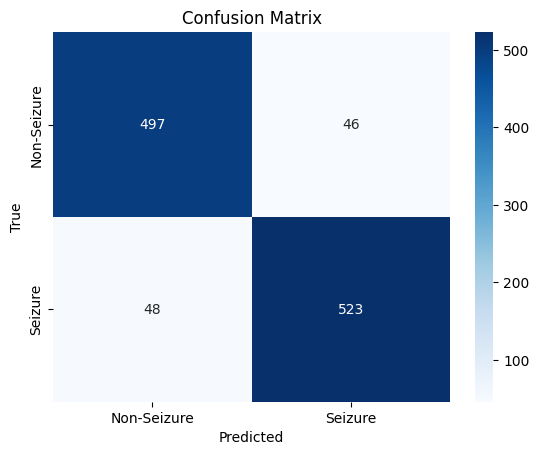

In [9]:
# Generate predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        preds = torch.sigmoid(model(data))  # Convert logits to probabilities
        preds = (preds > 0.5).int()  # Threshold at 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Seizure", "Seizure"],
            yticklabels=["Non-Seizure", "Seizure"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

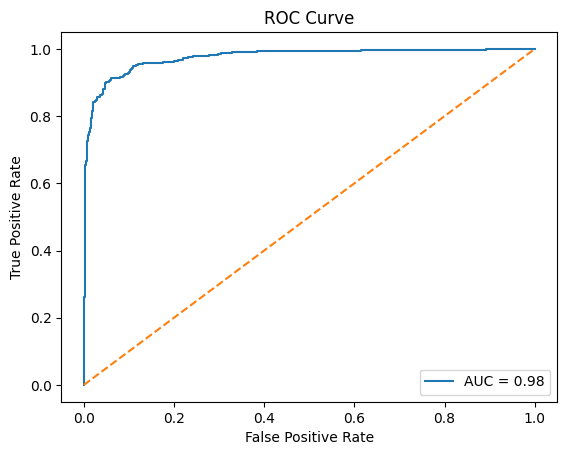

In [10]:
# Get predicted probabilities (not thresholded)
all_probs = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        probs = torch.sigmoid(model(data)).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

# Plot
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# Get some test samples
test_samples, test_labels = next(iter(test_loader))
test_samples = test_samples.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = torch.sigmoid(model(test_samples))
    preds = (outputs > 0.5).float()

# Visualize first 5 samples
for i in range(5):
    plt.figure(figsize=(10, 4))
    plt.plot(test_samples[i].cpu().numpy())
    plt.title(f"True: {test_labels[i].item()}, Pred: {preds[i].item()}")
    plt.show()

In [ ]:

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
auprc = auc(recall, precision)

plt.plot(recall, precision, label=f"AUPRC = {auprc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [ ]:
# Select a sample from the test set
sample_idx = 0  # Change to visualize different samples
data, label = test_dataset[sample_idx]

# Generate prediction
with torch.no_grad():
    data = data.unsqueeze(0).to(device)  # Add batch dimension
    prob = torch.sigmoid(model(data)).item()
pred = "Seizure" if prob > 0.5 else "Non-Seizure"

# Plot the time-series data
plt.figure(figsize=(10, 4))
plt.plot(data.cpu().numpy()[:, 0], label="EEG Channel 1")  # Plot 1st feature
plt.title(f"True Label: {label.item()} | Predicted: {pred} (Prob: {prob:.2f})")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [ ]:

print(classification_report(all_labels, all_preds,
                            target_names=["Non-Seizure", "Seizure"]))